In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5


# Fitting TESS data

In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

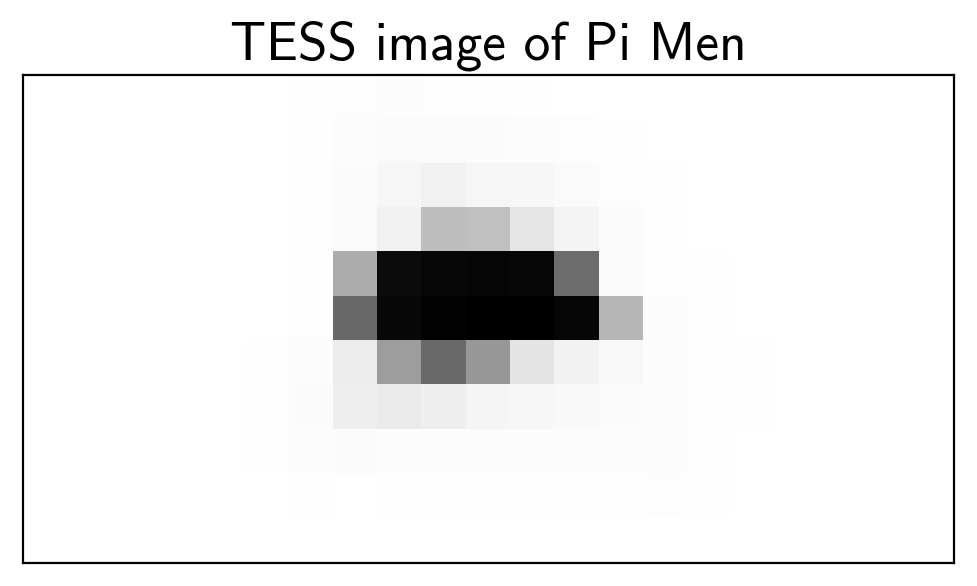

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

tpf_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0002/6113/6679/tess2018206045859-s0001-0000000261136679-0120-s_tp.fits"
with fits.open(tpf_url) as hdus:
    tpf = hdus[1].data
    tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

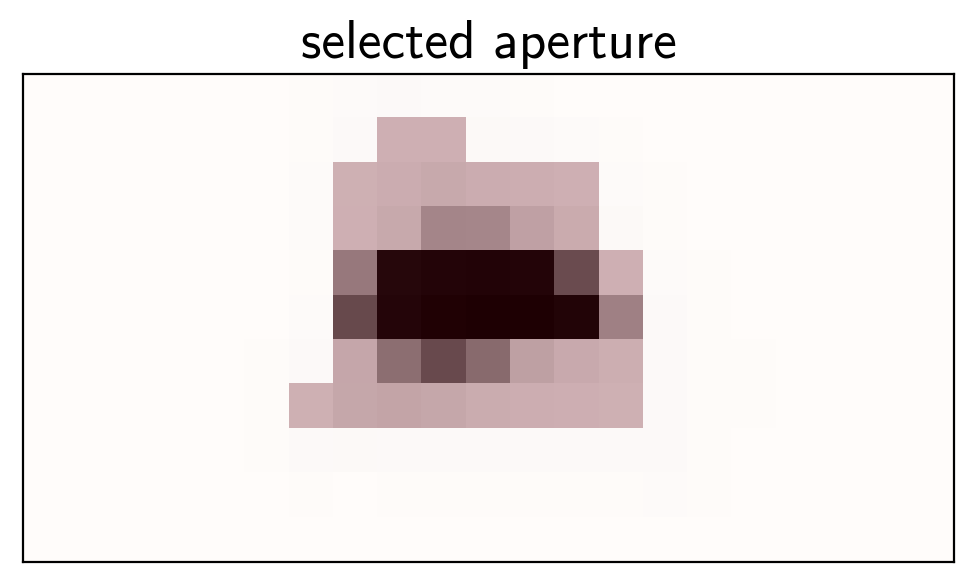

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

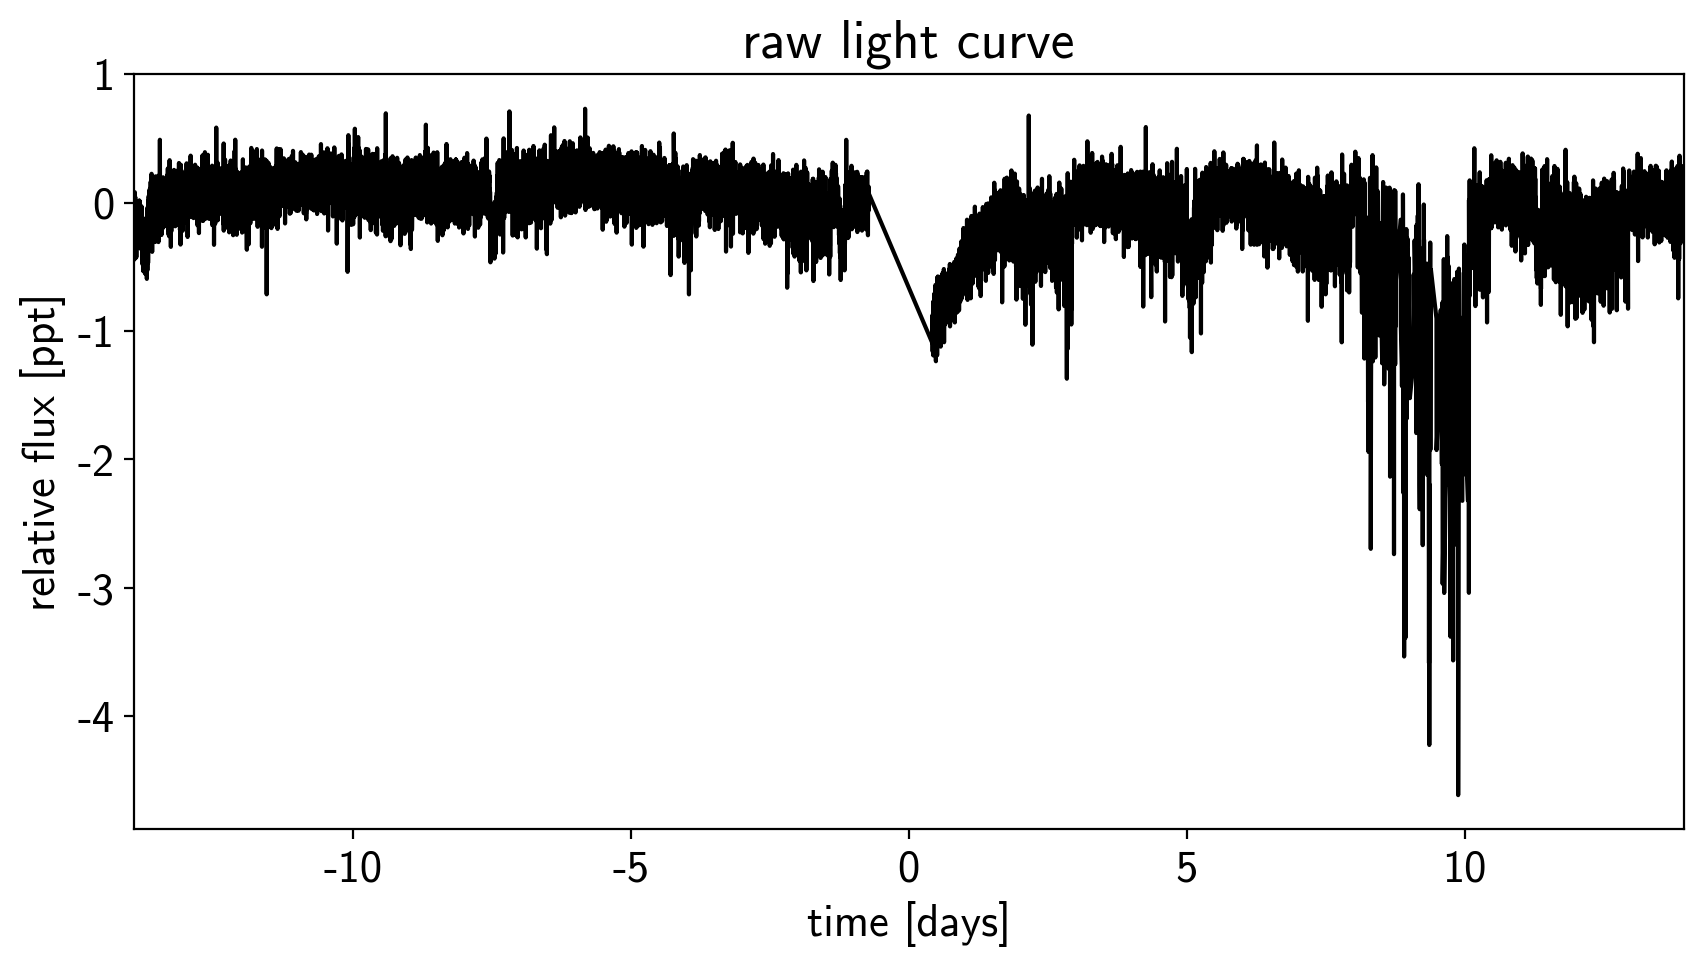

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

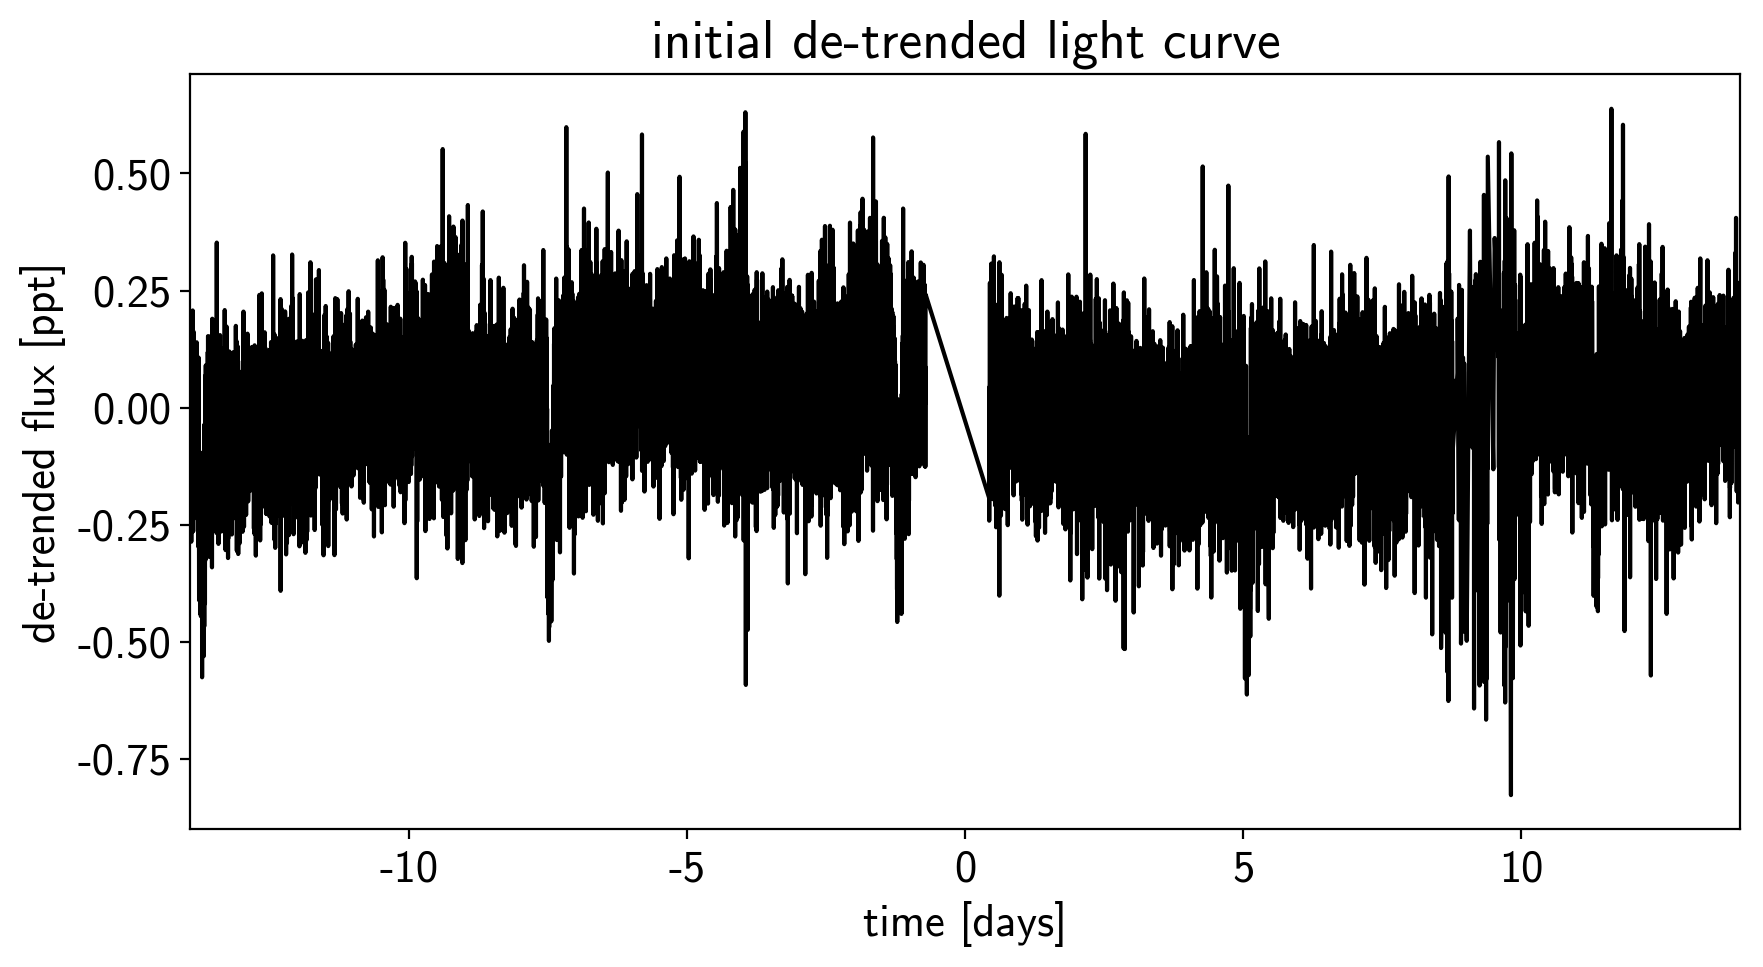

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

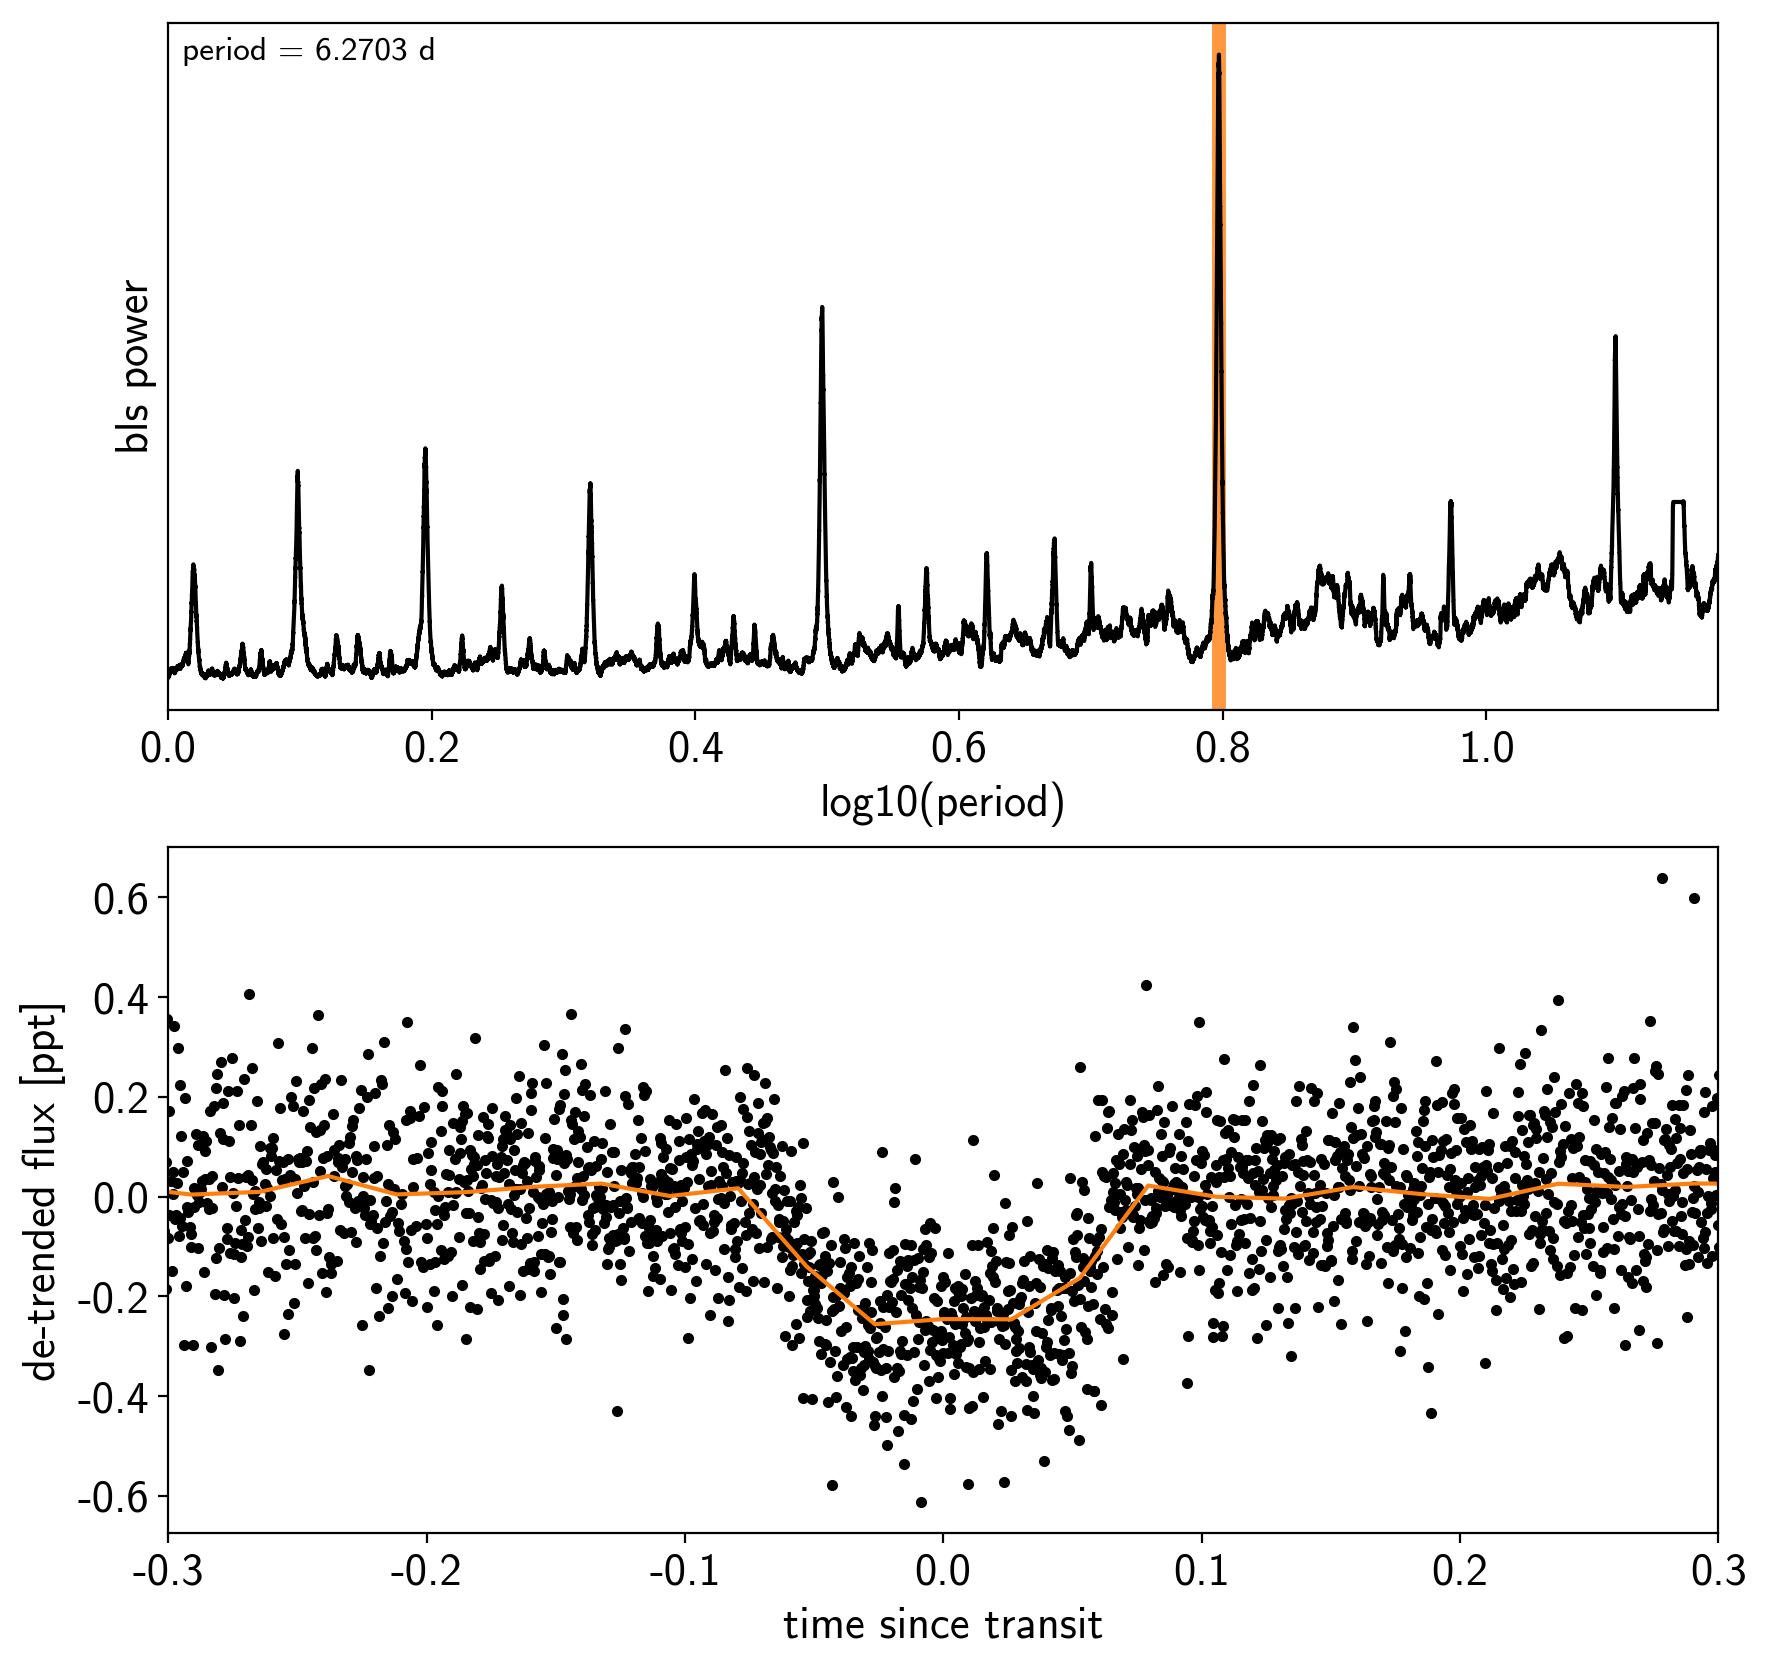

In [7]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

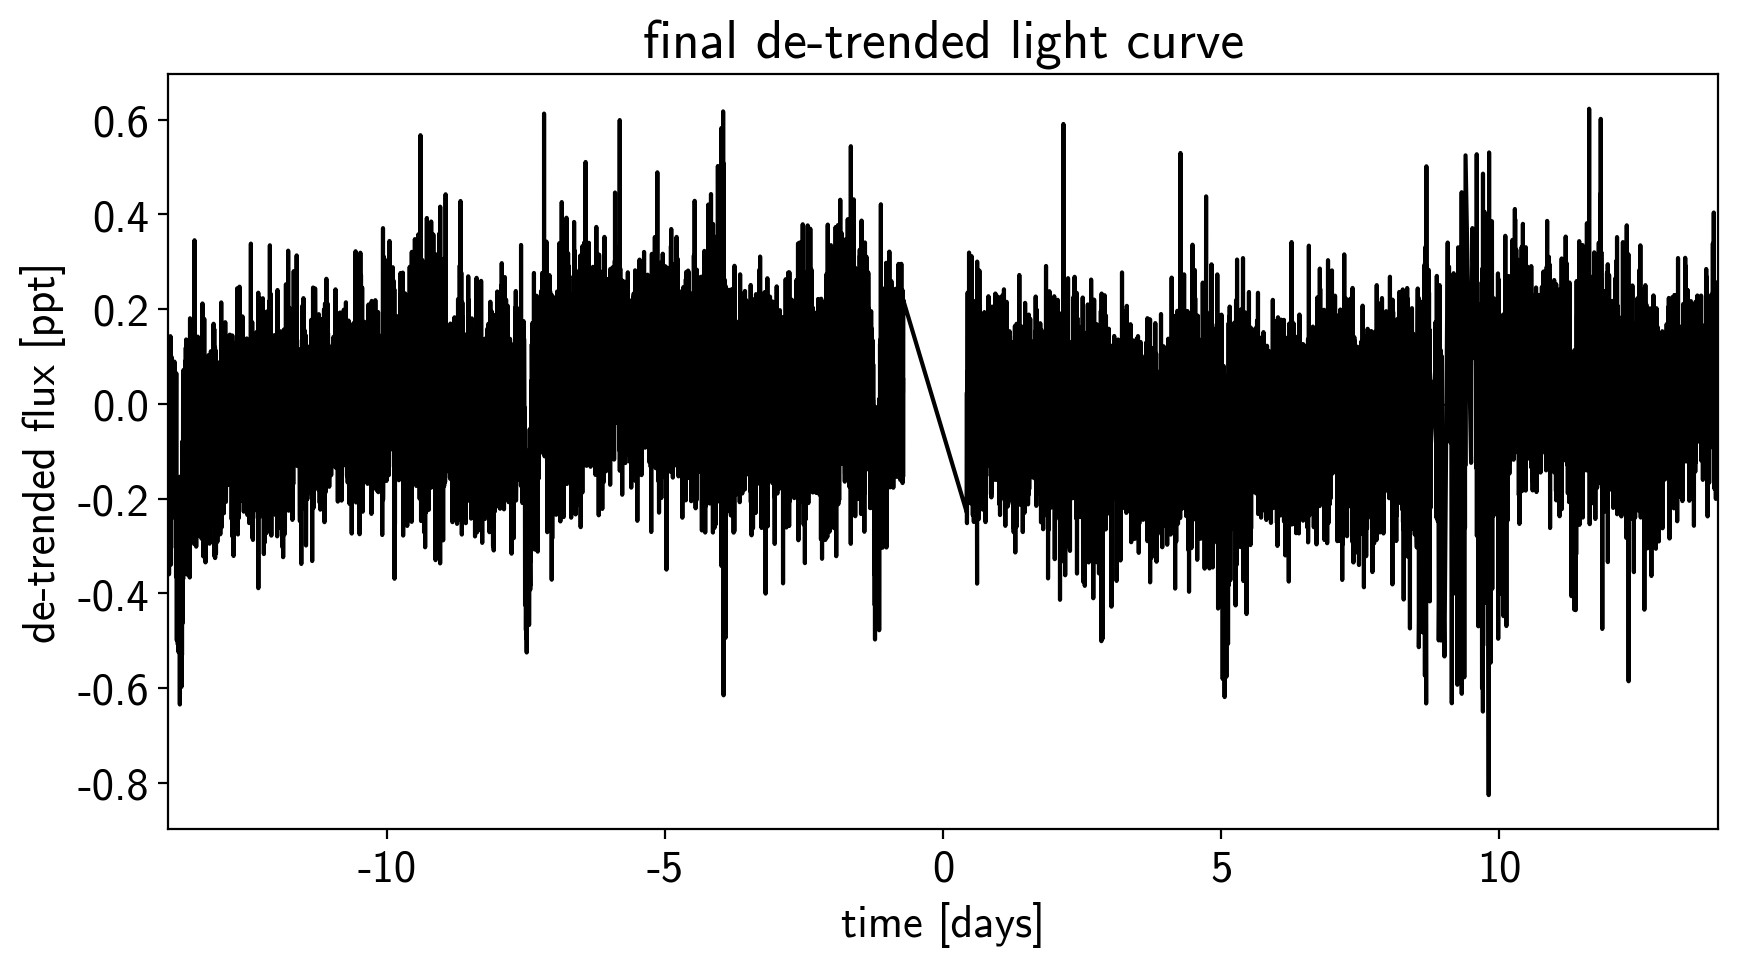

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

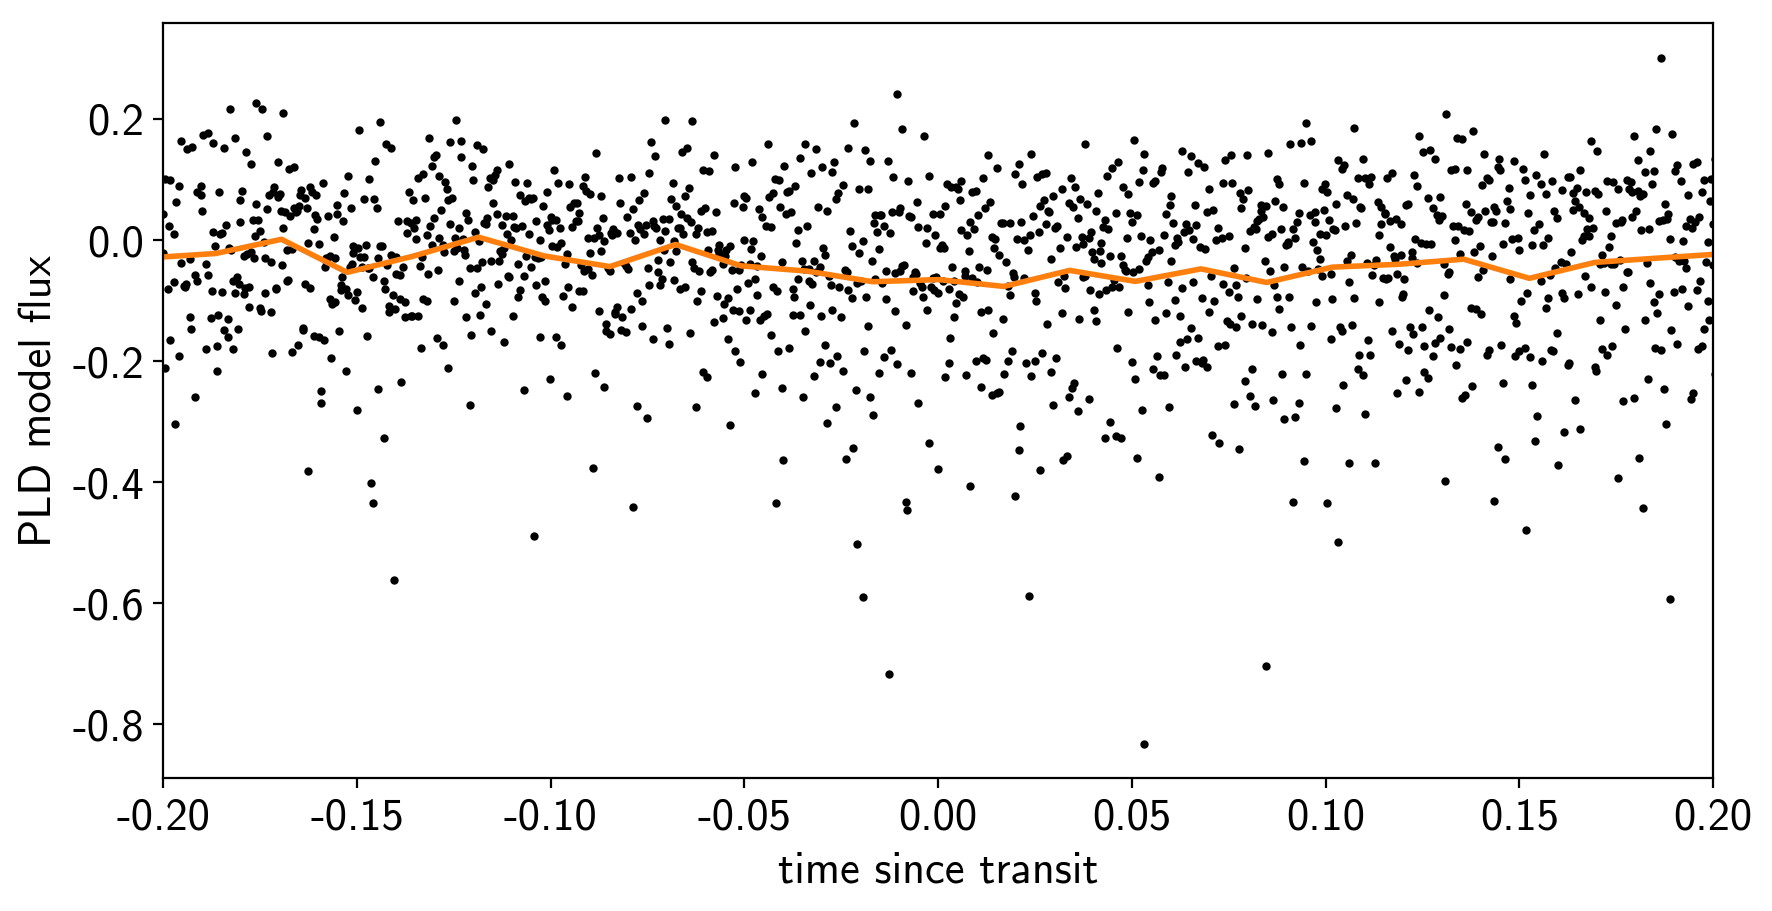

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`, but we'll use a [more informative prior on eccentricity](https://arxiv.org/abs/1306.4982).

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = pm.Normal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(R_star_huang[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12740.765561069971 -> 13007.915373837846


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13007.915373837846 -> 13009.375296936547


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 13009.37529693655 -> 13011.964145594648


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 13011.964145594648 -> 13025.549814395878


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 13025.54981439587 -> 13028.711073192928


optimizing logp for variables: ['logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 13028.711073192928 -> 13028.922206186133


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 13028.922206186126 -> 13029.259565820235


optimizing logp for variables: ['omega_angle__', 'ecc_logodds__']


message: Optimization terminated successfully.
logp: 13029.259565820235 -> 13049.868148593856


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 13049.86814859386 -> 13049.889405526703


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13049.889405526703 -> 13049.918411594184


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 13049.918411594203 -> 13052.459974919158


Here's how we plot the initial light curve model:

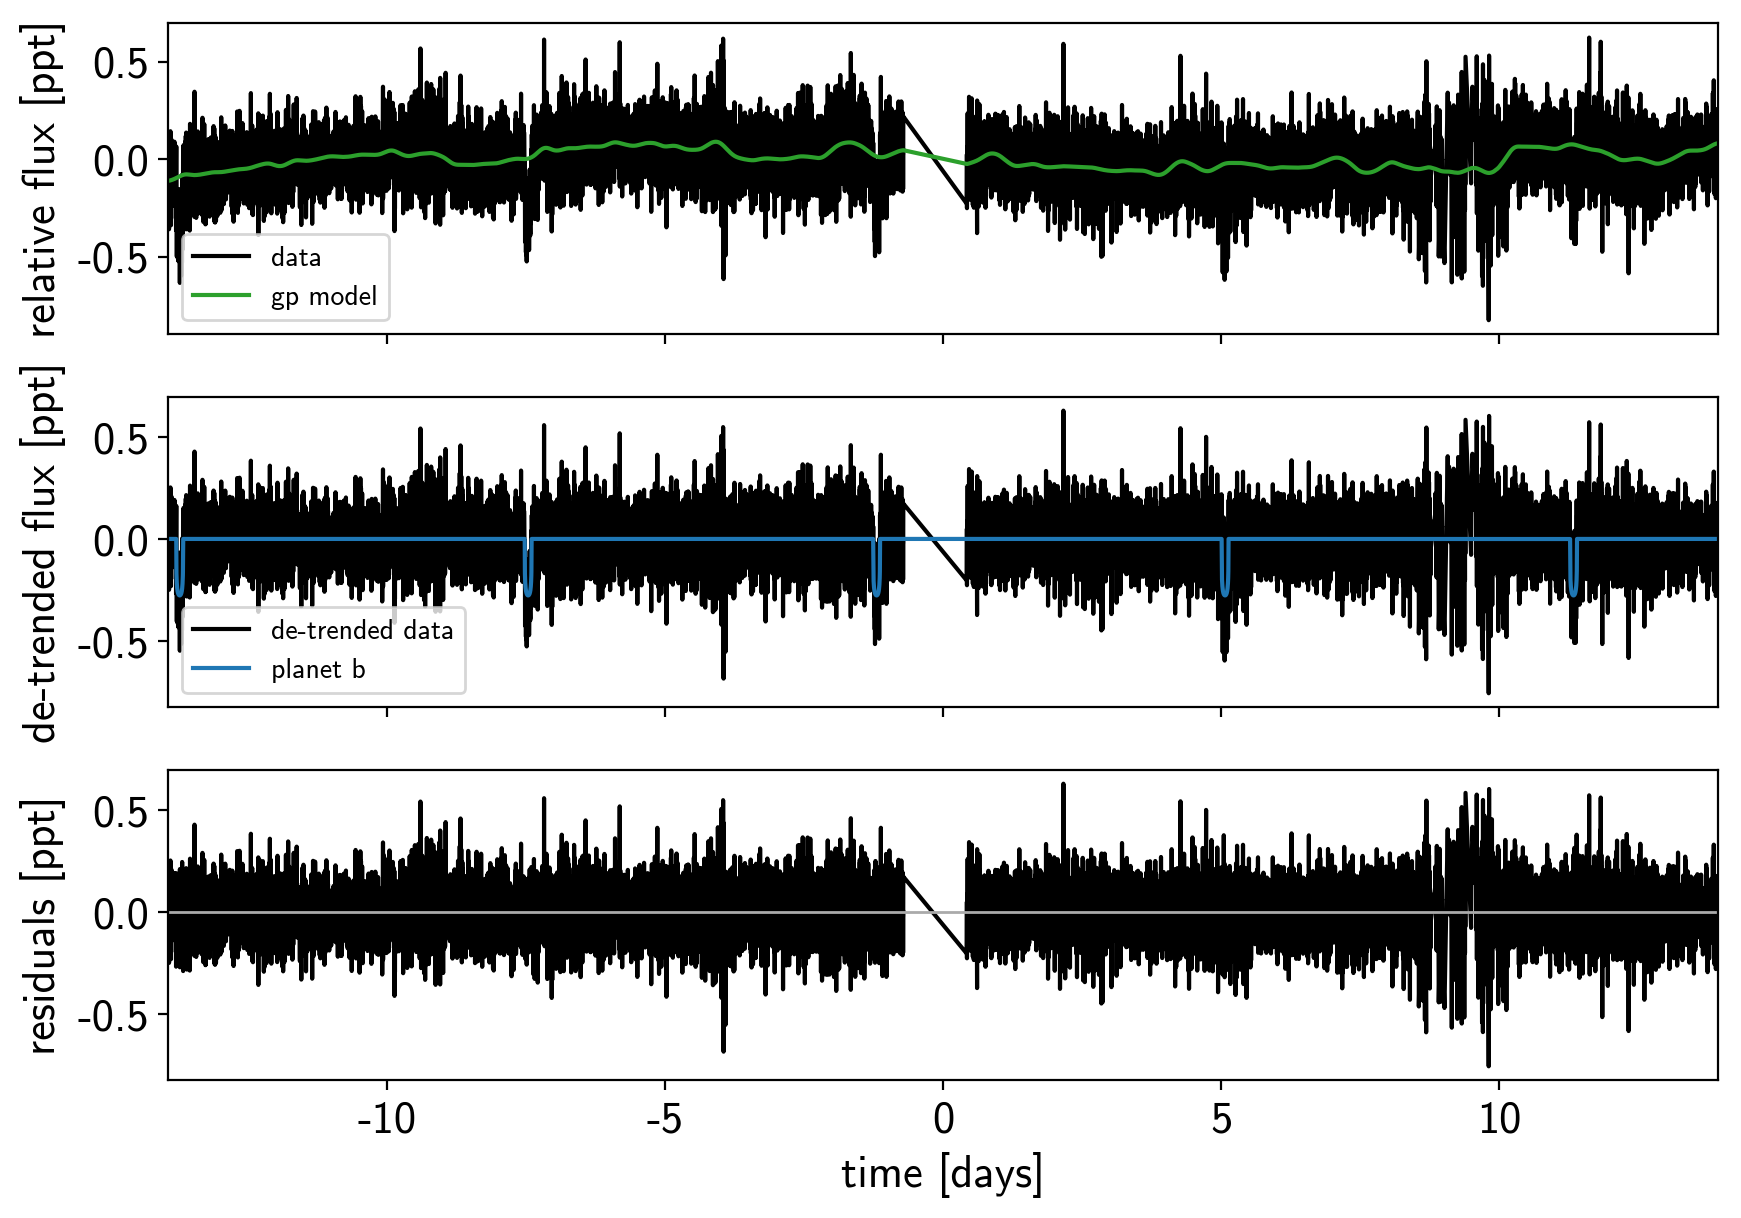

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

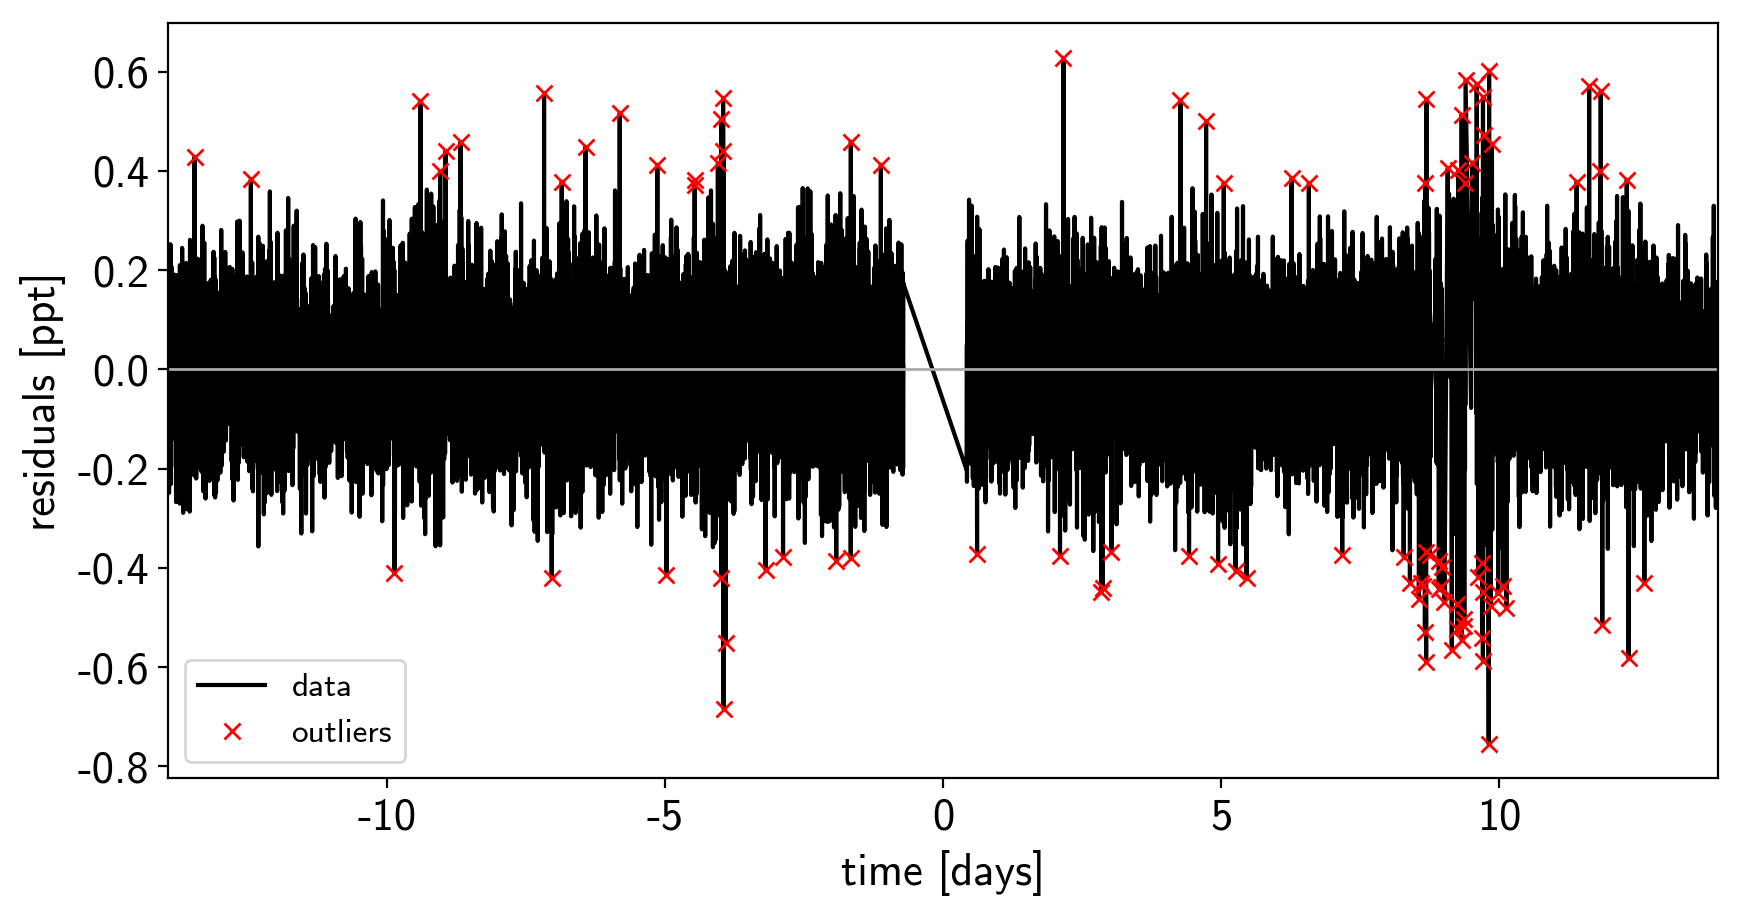

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13706.965171929465 -> 13737.924647263992


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.924647263992 -> 13737.944799031835


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 13737.944799031839 -> 13737.945672047628


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.945672047628 -> 13737.954508551973


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 13737.954508551977 -> 13737.978356987767


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.978356987767 -> 13737.981517082586


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 13737.981517082586 -> 13737.990354096222


optimizing logp for variables: ['omega_angle__', 'ecc_logodds__']


message: Optimization terminated successfully.
logp: 13737.990354096222 -> 13737.990393687394


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 13737.990393687402 -> 13737.993544839675


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13737.993544839675 -> 13737.993547696959


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.993547696966 -> 13738.00534645991


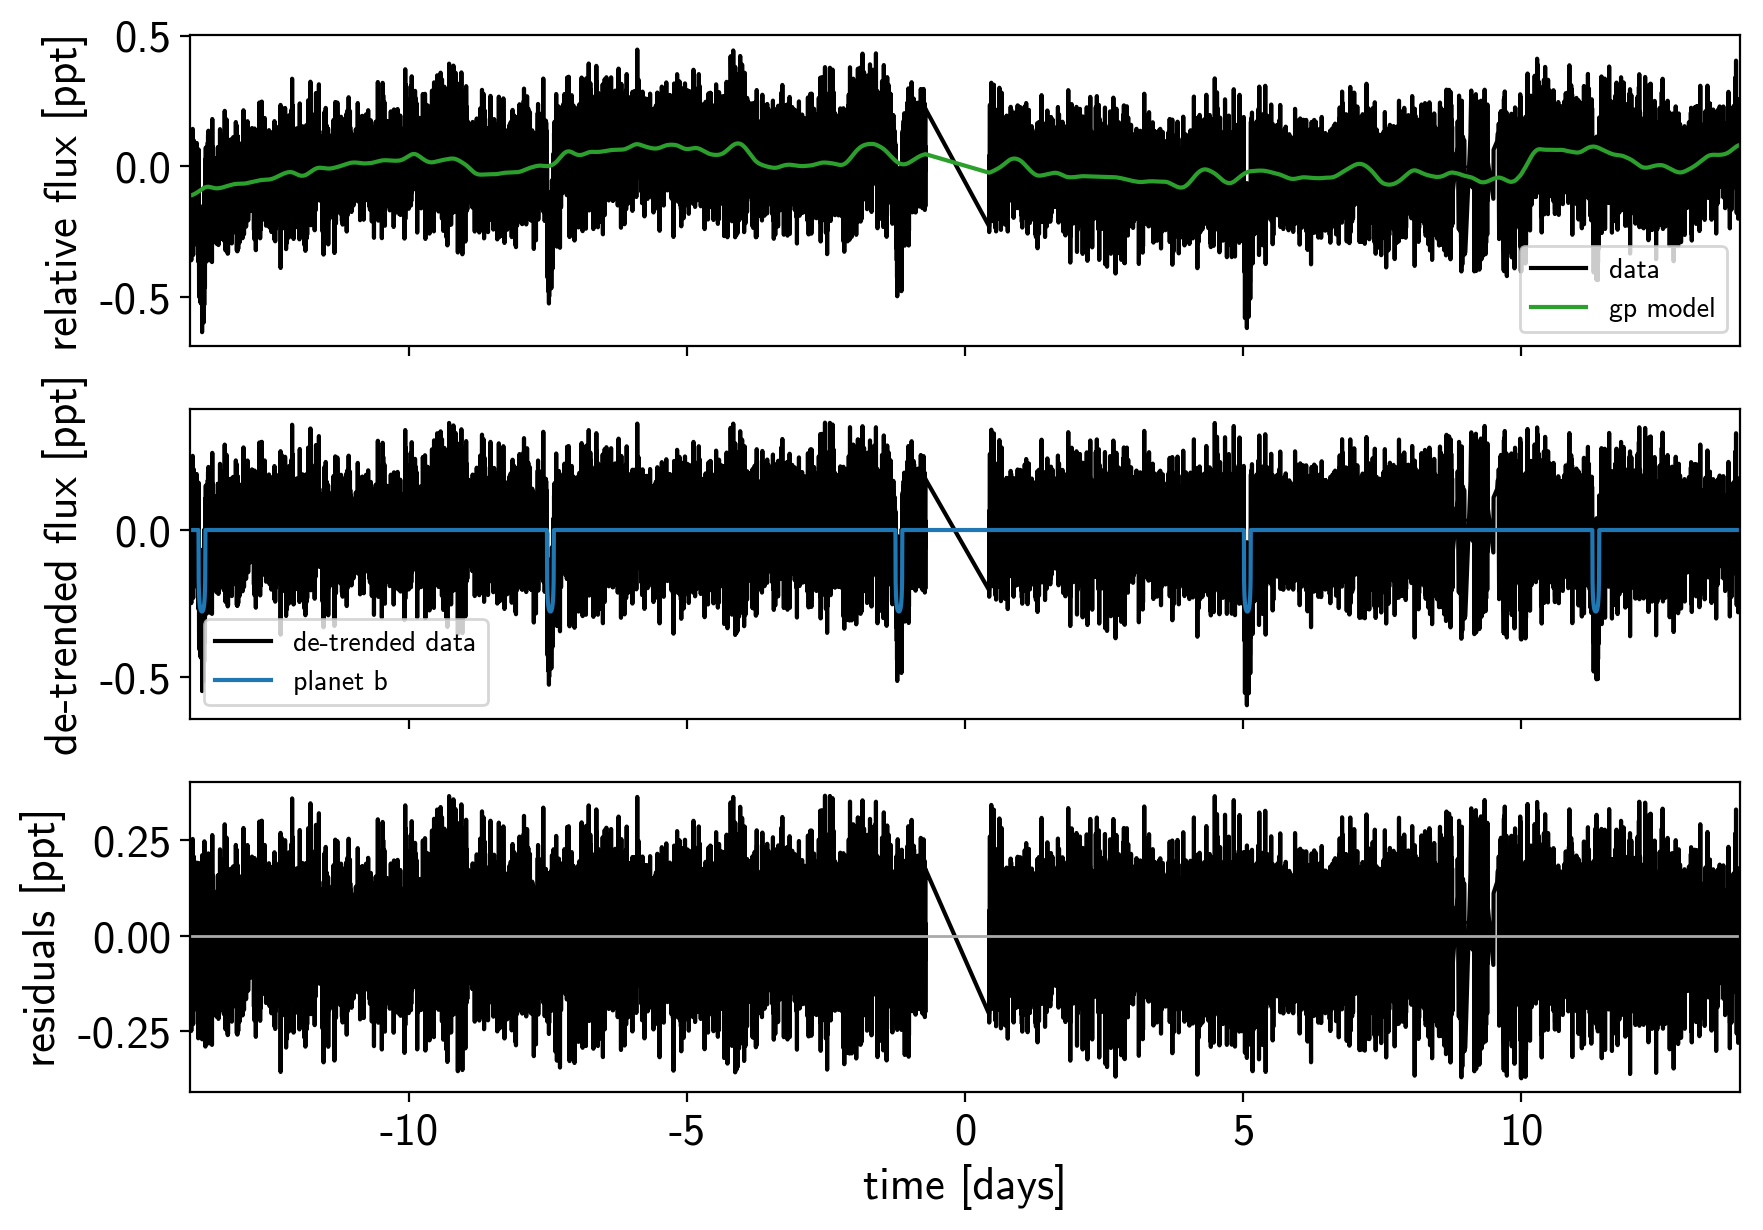

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample it using a :class:`exoplanet.PyMC3Sampler`:

In [14]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, start=200, finish=300)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:08, 89.69draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:02<01:07, 11.80draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:04<02:46,  4.72draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:04<02:12,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:06<05:16,  2.47draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:06<03:57,  3.29draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:08<06:26,  2.02draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:08<05:00,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:10<05:55,  2.18draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:10<04:39,  2.77draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:12<05:40,  2.26draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:12<04:27,  2.87draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:14<05:31,  2.32draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:14<04:22,  2.92draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:16<05:26,  2.33draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:16<04:18,  2.94draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:16<03:14,  3.91draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:18<08:57,  1.41draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:18<06:46,  1.87draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:18<04:59,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:19<07:40,  1.64draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:20<07:43,  1.63draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:20<05:55,  2.12draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:20<04:43,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:21<07:25,  1.69draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:22<07:29,  1.67draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:22<05:46,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:22<04:43,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:23<07:19,  1.70draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:24<07:24,  1.68draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:24<05:42,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:24<04:44,  2.62draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:25<07:16,  1.70draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:26<07:18,  1.69draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:26<05:39,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:26<04:45,  2.59draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:26<03:50,  3.21draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:27<06:02,  2.04draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:28<06:57,  1.76draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:28<05:45,  2.13draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:28<04:27,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:29<04:34,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:29<05:05,  2.40draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:30<07:14,  1.68draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:31<05:56,  2.05draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:31<06:04,  2.00draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:32<07:57,  1.52draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:33<06:23,  1.89draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:33<06:24,  1.88draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:34<07:03,  1.71draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:34<06:16,  1.92draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:35<05:49,  2.07draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:35<05:59,  2.00draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:36<06:49,  1.76draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:36<06:02,  1.98draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:37<05:37,  2.13draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:37<05:52,  2.03draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:38<06:46,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:38<05:55,  2.01draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:39<05:33,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:39<05:50,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:40<06:45,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:40<05:49,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:41<05:29,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:41<05:47,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:42<06:46,  1.74draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:42<05:44,  2.05draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:43<05:27,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:43<05:46,  2.03draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:44<06:47,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:44<05:41,  2.06draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:45<05:24,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:45<05:45,  2.03draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:46<05:20,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:46<05:11,  2.24draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:47<05:54,  1.97draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:47<06:06,  1.90draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:48<05:33,  2.09draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:48<05:24,  2.14draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:49<05:59,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:49<06:10,  1.87draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:50<05:32,  2.08draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:50<05:28,  2.10draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:51<05:58,  1.92draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:52<06:10,  1.86draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:52<05:29,  2.09draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:52<05:30,  2.08draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:53<05:55,  1.93draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:54<06:08,  1.86draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:54<05:24,  2.11draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:54<05:33,  2.05draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:55<05:53,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:56<06:06,  1.86draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:56<05:21,  2.12draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:56<05:34,  2.03draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:57<05:49,  1.94draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:58<06:05,  1.85draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:58<05:17,  2.13draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:58<05:35,  2.01draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:59<05:45,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [01:00<06:03,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [01:00<05:13,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [01:00<05:35,  2.00draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [01:01<05:40,  1.96draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [01:02<06:01,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [01:02<05:10,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [01:03<05:37,  1.98draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [01:03<05:37,  1.97draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [01:04<05:59,  1.85draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [01:04<05:06,  2.17draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [01:05<05:38,  1.96draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [01:05<05:34,  1.98draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [01:06<05:57,  1.85draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [01:06<05:03,  2.17draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [01:07<05:33,  1.98draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [01:07<04:42,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [01:08<06:14,  1.75draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [01:09<06:23,  1.71draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [01:09<05:15,  2.07draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [01:11<06:09,  1.76draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [01:11<05:04,  2.13draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [01:13<06:01,  1.79draws/s]

Sampling 4 chains:  20%|██        | 163/808 [01:13<04:57,  2.16draws/s]

Sampling 4 chains:  20%|██        | 165/808 [01:14<04:34,  2.34draws/s]

Sampling 4 chains:  21%|██        | 166/808 [01:15<05:56,  1.80draws/s]

Sampling 4 chains:  21%|██        | 168/808 [01:15<04:58,  2.15draws/s]

Sampling 4 chains:  21%|██        | 169/808 [01:16<05:30,  1.93draws/s]

Sampling 4 chains:  21%|██        | 170/808 [01:17<06:37,  1.61draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [01:17<05:24,  1.96draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [01:18<04:47,  2.20draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [01:19<06:07,  1.72draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [01:19<05:49,  1.81draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [01:20<05:04,  2.07draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [01:21<06:19,  1.66draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [01:21<05:55,  1.77draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [01:22<05:08,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [01:23<06:22,  1.63draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [01:23<05:55,  1.76draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [01:24<05:08,  2.02draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [01:25<06:22,  1.62draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [01:25<05:53,  1.76draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [01:25<04:26,  2.32draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [01:26<04:37,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [01:27<04:42,  2.18draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [01:27<05:02,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [01:28<04:59,  2.05draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [01:29<04:57,  2.05draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [01:29<05:14,  1.94draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [01:30<05:04,  2.01draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:31<05:01,  2.01draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [01:31<03:56,  2.57draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [01:32<05:26,  1.86draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [01:33<05:17,  1.90draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [01:33<04:07,  2.44draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [01:34<05:29,  1.83draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [01:34<04:23,  2.27draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [01:35<04:58,  2.00draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [01:35<03:54,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:36<05:24,  1.84draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:36<04:45,  2.08draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [01:37<05:16,  1.88draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [01:37<04:06,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:38<05:29,  1.80draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [01:38<04:48,  2.05draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:39<05:18,  1.85draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [01:39<04:08,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [01:40<05:27,  1.80draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [01:40<04:46,  2.05draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [01:41<05:19,  1.84draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [01:41<04:09,  2.35draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [01:42<05:25,  1.80draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [01:42<04:43,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:43<05:18,  1.83draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [01:43<04:09,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:44<05:21,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [01:44<04:40,  2.07draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [01:45<05:17,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:45<04:09,  2.32draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [01:46<05:17,  1.82draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [01:46<04:38,  2.07draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [01:47<05:15,  1.82draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:47<04:08,  2.31draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [01:48<05:13,  1.83draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:48<04:35,  2.08draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [01:49<05:13,  1.82draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [01:49<04:08,  2.29draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [01:50<05:10,  1.83draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [01:50<04:32,  2.09draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [01:51<05:12,  1.81draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [01:51<04:09,  2.27draws/s]

Sampling 4 chains:  30%|███       | 243/808 [01:51<03:16,  2.88draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:52<04:07,  2.28draws/s]

Sampling 4 chains:  30%|███       | 245/808 [01:53<05:37,  1.67draws/s]

Sampling 4 chains:  31%|███       | 247/808 [01:53<04:18,  2.17draws/s]

Sampling 4 chains:  31%|███       | 248/808 [01:53<03:18,  2.82draws/s]

Sampling 4 chains:  31%|███       | 249/808 [01:55<06:52,  1.36draws/s]

Sampling 4 chains:  31%|███       | 251/808 [01:55<05:11,  1.79draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [01:57<06:01,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [01:57<04:36,  2.00draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [01:59<05:34,  1.65draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [01:59<04:10,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [01:59<03:28,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [02:00<03:24,  2.67draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [02:01<05:03,  1.80draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [02:01<03:50,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [02:01<03:21,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [02:02<04:11,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [02:03<05:34,  1.62draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [02:03<04:12,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [02:03<03:34,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [02:04<04:22,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [02:05<05:38,  1.59draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [02:05<04:16,  2.09draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [02:05<03:35,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [02:06<04:25,  2.02draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [02:07<05:37,  1.58draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [02:07<04:15,  2.08draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [02:08<04:13,  2.09draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [02:09<05:26,  1.62draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [02:09<04:09,  2.12draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [02:10<04:08,  2.12draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [02:11<05:21,  1.64draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [02:11<04:06,  2.13draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [02:12<04:06,  2.12draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [02:13<05:16,  1.65draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [02:13<04:04,  2.13draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [02:14<04:04,  2.12draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [02:15<05:10,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [02:15<04:03,  2.12draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [02:16<04:03,  2.12draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [02:17<05:05,  1.68draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [02:17<04:01,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [02:18<04:02,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [02:19<05:01,  1.69draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [02:19<03:58,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [02:20<04:00,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [02:21<04:56,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [02:21<03:54,  2.15draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [02:22<03:58,  2.11draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [02:23<04:51,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [02:23<03:51,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [02:24<03:56,  2.11draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [02:25<04:47,  1.73draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [02:25<03:47,  2.19draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [02:25<02:51,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [02:26<04:06,  2.00draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [02:27<05:16,  1.56draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [02:27<03:53,  2.10draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [02:28<04:50,  1.68draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [02:29<05:44,  1.42draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [02:29<04:15,  1.91draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [02:30<04:08,  1.96draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [02:31<05:10,  1.56draws/s]

Sampling 4 chains:  40%|████      | 324/808 [02:31<03:54,  2.06draws/s]

Sampling 4 chains:  40%|████      | 326/808 [02:32<03:52,  2.07draws/s]

Sampling 4 chains:  40%|████      | 327/808 [02:33<04:56,  1.62draws/s]

Sampling 4 chains:  41%|████      | 328/808 [02:33<03:46,  2.12draws/s]

Sampling 4 chains:  41%|████      | 330/808 [02:34<03:46,  2.11draws/s]

Sampling 4 chains:  41%|████      | 331/808 [02:35<04:48,  1.65draws/s]

Sampling 4 chains:  41%|████      | 332/808 [02:35<03:43,  2.13draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [02:36<03:44,  2.11draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [02:37<04:43,  1.67draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [02:37<03:40,  2.14draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [02:38<03:42,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [02:39<02:53,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [02:39<03:45,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [02:39<03:05,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [02:40<04:22,  1.78draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [02:41<03:21,  2.31draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [02:41<04:02,  1.92draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [02:41<03:17,  2.35draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [02:42<04:30,  1.71draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [02:43<03:26,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [02:43<04:03,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [02:43<03:17,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [02:44<04:14,  1.80draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [02:44<03:15,  2.34draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [02:45<02:33,  2.98draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [02:45<03:23,  2.24draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [02:46<04:44,  1.59draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [02:46<03:38,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [02:47<02:48,  2.68draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [02:47<03:32,  2.13draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [02:48<04:49,  1.55draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [02:48<03:44,  2.00draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [02:49<02:51,  2.61draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [02:49<03:31,  2.11draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [02:50<04:47,  1.55draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [02:51<03:45,  1.97draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [02:51<03:28,  2.12draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [02:52<04:44,  1.56draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [02:53<03:45,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [02:53<03:27,  2.12draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [02:54<04:41,  1.56draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [02:55<03:45,  1.94draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [02:55<03:26,  2.11draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [02:56<04:39,  1.55draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [02:57<03:45,  1.92draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [02:57<03:13,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [02:57<02:37,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [02:58<04:04,  1.76draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [02:59<03:21,  2.12draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [02:59<03:32,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [02:59<02:50,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [03:00<04:10,  1.70draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [03:01<03:28,  2.03draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [03:01<03:37,  1.95draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [03:01<02:50,  2.48draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [03:02<04:08,  1.69draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [03:03<03:29,  2.01draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [03:03<03:37,  1.93draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [03:03<02:47,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [03:04<04:05,  1.70draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [03:05<03:29,  1.99draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [03:05<03:36,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [03:05<02:45,  2.51draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [03:06<04:02,  1.70draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [03:07<03:28,  1.97draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [03:07<03:35,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [03:08<03:39,  1.87draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [03:09<03:14,  2.10draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [03:09<03:23,  2.00draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [03:10<02:56,  2.29draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [03:10<03:08,  2.14draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [03:11<02:54,  2.31draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [03:11<03:07,  2.14draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [03:12<03:19,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [03:12<03:24,  1.95draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [03:13<03:06,  2.14draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [03:13<03:15,  2.04draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [03:14<03:21,  1.97draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [03:14<03:26,  1.92draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [03:15<03:08,  2.09draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [03:15<03:16,  2.00draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [03:16<03:19,  1.97draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [03:16<03:24,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [03:17<03:09,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [03:17<03:15,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [03:18<03:16,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [03:18<03:21,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [03:19<03:09,  2.04draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [03:19<03:14,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [03:20<03:12,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [03:20<03:19,  1.93draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [03:21<03:09,  2.02draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [03:21<03:12,  1.99draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [03:22<03:08,  2.02draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [03:22<03:16,  1.93draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [03:23<03:10,  1.99draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [03:23<03:10,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [03:24<03:04,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [03:24<02:49,  2.21draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [03:24<02:22,  2.64draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [03:25<03:30,  1.78draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [03:26<03:16,  1.90draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [03:26<03:00,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [03:26<02:25,  2.54draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [03:27<03:33,  1.73draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [03:28<03:16,  1.88draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [03:28<03:02,  2.02draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [03:28<02:25,  2.53draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [03:29<03:32,  1.72draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [03:30<03:14,  1.88draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [03:30<03:02,  1.99draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [03:30<02:22,  2.55draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [03:32<03:31,  1.71draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [03:32<03:11,  1.88draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [03:32<03:02,  1.97draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [03:32<02:19,  2.57draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [03:34<03:29,  1.71draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [03:34<03:08,  1.90draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [03:34<03:02,  1.95draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [03:36<03:07,  1.89draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [03:36<02:51,  2.06draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [03:36<02:52,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [03:38<02:59,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [03:38<02:43,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [03:38<02:48,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [03:40<02:56,  1.97draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [03:40<02:38,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [03:40<02:47,  2.05draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [03:42<02:53,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [03:42<02:35,  2.20draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [03:42<02:47,  2.03draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [03:44<02:52,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [03:44<02:33,  2.20draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [03:45<02:47,  2.01draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [03:46<02:50,  1.95draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [03:46<02:31,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [03:47<02:44,  2.01draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [03:47<02:41,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [03:48<02:38,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [03:49<02:49,  1.94draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [03:49<02:44,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [03:50<02:39,  2.04draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [03:51<02:49,  1.92draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [03:51<02:43,  1.96draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [03:52<02:37,  2.03draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [03:52<02:41,  1.98draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [03:53<02:09,  2.47draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [03:53<02:51,  1.85draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [03:54<02:20,  2.25draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [03:54<02:28,  2.12draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [03:56<03:21,  1.56draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [03:56<02:40,  1.95draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [03:56<02:42,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [03:58<03:29,  1.48draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [03:58<02:45,  1.86draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [03:58<02:45,  1.85draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [04:00<03:31,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [04:00<02:46,  1.83draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [04:01<02:45,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [04:02<03:30,  1.43draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [04:02<02:45,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [04:03<02:43,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [04:04<03:28,  1.43draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [04:04<02:35,  1.91draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [04:04<02:14,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [04:05<02:22,  2.06draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [04:06<03:12,  1.53draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [04:06<02:25,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [04:06<02:04,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [04:07<02:16,  2.13draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [04:08<03:06,  1.55draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [04:08<02:22,  2.02draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [04:08<02:00,  2.40draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [04:09<02:13,  2.15draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [04:10<03:03,  1.55draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [04:10<02:21,  2.02draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [04:10<01:57,  2.42draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [04:11<02:10,  2.16draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [04:12<03:01,  1.56draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [04:12<02:20,  2.00draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [04:12<01:48,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [04:14<02:27,  1.89draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [04:14<01:57,  2.35draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [04:14<01:30,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [04:16<02:14,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [04:16<01:49,  2.50draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [04:16<01:21,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [04:18<03:13,  1.40draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [04:18<02:31,  1.77draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [04:18<01:52,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [04:20<03:28,  1.28draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [04:20<02:46,  1.59draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [04:20<02:01,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [04:22<03:33,  1.23draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [04:22<02:48,  1.55draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [04:22<02:02,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [04:24<03:32,  1.22draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [04:24<02:47,  1.53draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [04:24<02:00,  2.11draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [04:26<03:29,  1.21draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [04:26<02:46,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [04:28<02:38,  1.58draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [04:28<02:09,  1.92draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [04:30<02:12,  1.85draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [04:30<01:50,  2.22draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [04:32<01:59,  2.03draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [04:32<01:40,  2.40draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [04:34<01:53,  2.10draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [04:34<01:37,  2.44draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [04:36<01:49,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [04:36<01:31,  2.56draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [04:36<01:07,  3.41draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [04:38<02:45,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [04:38<02:06,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [04:38<01:33,  2.42draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [04:40<03:00,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [04:40<02:16,  1.65draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [04:41<01:44,  2.13draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [04:42<02:59,  1.23draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [04:42<02:12,  1.67draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [04:42<01:40,  2.19draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [04:43<01:26,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [04:44<02:45,  1.32draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [04:44<02:00,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [04:45<01:40,  2.13draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [04:46<02:52,  1.24draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [04:46<02:04,  1.71draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [04:47<01:45,  2.01draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [04:48<02:04,  1.68draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [04:49<01:38,  2.11draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [04:50<01:58,  1.73draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [04:51<01:33,  2.16draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [04:52<01:54,  1.76draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [04:53<01:30,  2.20draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [04:54<01:51,  1.77draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [04:55<01:28,  2.21draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [04:56<01:48,  1.78draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [04:57<01:26,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [04:58<01:45,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [04:59<01:24,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [05:00<01:42,  1.80draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [05:01<01:22,  2.21draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [05:02<01:39,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [05:03<01:21,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [05:04<01:37,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [05:04<01:13,  2.41draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [05:05<01:10,  2.47draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [05:06<01:28,  1.96draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [05:07<01:08,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [05:07<01:06,  2.56draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [05:08<01:19,  2.12draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [05:08<01:03,  2.65draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [05:09<01:11,  2.35draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [05:10<01:21,  2.01draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [05:10<01:03,  2.58draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [05:11<01:11,  2.28draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [05:12<01:21,  1.97draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [05:12<01:01,  2.59draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [05:13<01:10,  2.25draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [05:14<01:20,  1.96draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [05:15<01:11,  2.17draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [05:15<00:54,  2.82draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [05:16<01:34,  1.62draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [05:17<01:12,  2.09draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [05:17<01:07,  2.23draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [05:17<00:51,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [05:18<01:31,  1.62draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [05:19<01:16,  1.93draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [05:19<01:09,  2.10draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [05:19<00:53,  2.72draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [05:20<01:29,  1.61draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [05:21<01:15,  1.89draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [05:21<01:08,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [05:21<00:52,  2.67draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [05:22<01:26,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [05:23<01:14,  1.88draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [05:23<01:07,  2.06draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [05:23<00:52,  2.63draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [05:24<01:22,  1.64draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [05:24<01:03,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [05:25<00:52,  2.54draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [05:25<00:51,  2.57draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [05:26<01:25,  1.54draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [05:27<01:06,  1.96draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [05:27<00:54,  2.39draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [05:27<00:52,  2.47draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [05:28<01:23,  1.53draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [05:29<01:06,  1.92draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [05:29<00:53,  2.35draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [05:29<00:51,  2.45draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [05:30<01:20,  1.54draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [05:31<01:04,  1.90draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [05:31<00:51,  2.35draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [05:31<00:49,  2.44draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [05:32<01:17,  1.56draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [05:33<01:03,  1.88draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [05:33<00:50,  2.33draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [05:33<00:48,  2.43draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [05:34<01:13,  1.57draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [05:35<01:01,  1.86draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [05:35<00:48,  2.33draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [05:35<00:46,  2.43draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [05:36<01:10,  1.58draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [05:37<01:00,  1.85draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [05:37<00:47,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [05:37<00:45,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [05:38<01:07,  1.60draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [05:39<00:58,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [05:39<00:45,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [05:39<00:43,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [05:40<01:04,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [05:41<00:56,  1.81draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [05:41<00:44,  2.31draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [05:41<00:41,  2.41draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [05:42<01:01,  1.64draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [05:43<00:55,  1.80draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [05:43<00:42,  2.30draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [05:43<00:40,  2.41draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [05:44<00:57,  1.66draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [05:45<00:53,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [05:45<00:40,  2.30draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [05:45<00:38,  2.40draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [05:46<00:54,  1.67draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [05:47<00:51,  1.77draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [05:47<00:39,  2.28draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [05:47<00:37,  2.39draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [05:48<00:51,  1.70draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [05:49<00:49,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [05:49<00:37,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [05:49<00:35,  2.38draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [05:50<00:32,  2.62draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [05:50<00:38,  2.14draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [05:51<00:39,  2.07draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [05:51<00:40,  2.00draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [05:52<00:34,  2.29draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [05:52<00:39,  2.01draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [05:53<00:40,  1.94draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [05:53<00:40,  1.92draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [05:54<00:34,  2.21draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [05:54<00:37,  2.00draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [05:55<00:38,  1.90draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [05:55<00:38,  1.90draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [05:56<00:32,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [05:56<00:35,  2.02draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [05:57<00:37,  1.88draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [05:57<00:36,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [05:58<00:31,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [05:58<00:32,  2.06draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [05:59<00:35,  1.86draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [05:59<00:34,  1.88draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [06:00<00:29,  2.16draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [06:00<00:30,  2.08draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [06:01<00:33,  1.85draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [06:01<00:32,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [06:02<00:27,  2.16draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [06:02<00:27,  2.12draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [06:03<00:31,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [06:03<00:30,  1.86draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [06:04<00:26,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [06:04<00:25,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [06:05<00:29,  1.81draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [06:05<00:28,  1.84draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [06:06<00:24,  2.14draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [06:06<00:23,  2.16draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [06:07<00:28,  1.78draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [06:08<00:26,  1.84draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [06:08<00:22,  2.14draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [06:08<00:19,  2.46draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [06:09<00:27,  1.64draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [06:10<00:24,  1.84draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [06:10<00:20,  2.14draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [06:10<00:17,  2.46draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [06:11<00:25,  1.64draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [06:12<00:22,  1.85draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [06:12<00:18,  2.14draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [06:12<00:15,  2.52draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [06:13<00:23,  1.63draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [06:14<00:20,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [06:14<00:16,  2.15draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [06:14<00:13,  2.57draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [06:15<00:21,  1.62draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [06:16<00:17,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [06:16<00:14,  2.15draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [06:16<00:11,  2.61draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [06:17<00:18,  1.61draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [06:18<00:15,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [06:18<00:13,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [06:18<00:10,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [06:19<00:16,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [06:20<00:13,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [06:20<00:11,  2.14draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [06:20<00:08,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [06:21<00:13,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [06:22<00:11,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [06:22<00:09,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [06:22<00:06,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [06:23<00:11,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [06:24<00:09,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [06:24<00:07,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [06:24<00:05,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [06:24<00:04,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [06:25<00:07,  1.83draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [06:26<00:08,  1.50draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [06:27<00:08,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [06:28<00:08,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [06:29<00:08,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [06:31<00:09,  1.24s/draws]

Sampling 4 chains:  99%|█████████▉| 801/808 [06:32<00:07,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 803/808 [06:36<00:06,  1.39s/draws]

Sampling 4 chains: 100%|█████████▉| 804/808 [06:40<00:07,  1.92s/draws]

Sampling 4 chains: 100%|█████████▉| 805/808 [06:40<00:04,  1.47s/draws]

Sampling 4 chains: 100%|█████████▉| 806/808 [06:40<00:02,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 807/808 [06:44<00:02,  2.03s/draws]

Sampling 4 chains: 100%|██████████| 808/808 [06:48<00:00,  2.37s/draws]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 9/408 [00:00<00:04, 89.41draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:04, 79.05draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:02<01:02,  6.19draws/s]

Sampling 4 chains:   6%|▌         | 24/408 [00:02<00:53,  7.21draws/s]

Sampling 4 chains:   7%|▋         | 27/408 [00:04<01:48,  3.50draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:06<03:06,  2.03draws/s]

Sampling 4 chains:   8%|▊         | 31/408 [00:06<02:16,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:08<03:22,  1.85draws/s]

Sampling 4 chains:   9%|▊         | 35/408 [00:08<02:28,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:10<03:28,  1.78draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:10<02:33,  2.40draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:10<02:12,  2.78draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:12<04:32,  1.35draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:12<03:19,  1.83draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:12<02:43,  2.22draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:12<02:10,  2.79draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:14<04:10,  1.45draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:14<03:17,  1.83draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:14<02:41,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:15<02:06,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:15<02:03,  2.91draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:16<03:04,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:16<02:25,  2.45draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:17<02:47,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:17<02:33,  2.30draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:18<03:24,  1.72draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:18<02:36,  2.25draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:19<02:55,  2.01draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:19<02:41,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:19<02:52,  2.02draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:20<02:47,  2.07draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:21<03:02,  1.90draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:21<02:47,  2.06draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:22<02:56,  1.96draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:22<02:47,  2.05draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:23<03:01,  1.89draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:23<02:49,  2.01draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:24<02:56,  1.93draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:24<02:43,  2.08draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:25<02:25,  2.32draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:25<02:55,  1.92draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:26<02:31,  2.22draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:26<02:23,  2.34draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:27<02:47,  1.98draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:28<02:27,  2.25draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:28<02:17,  2.40draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:29<02:43,  2.02draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:30<02:25,  2.25draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:30<02:13,  2.44draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:30<01:53,  2.87draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:31<02:52,  1.87draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:32<03:03,  1.76draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:32<02:28,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:33<01:56,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:33<02:26,  2.18draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:35<03:25,  1.54draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:35<02:36,  2.02draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:35<02:50,  1.84draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:37<03:43,  1.40draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:37<02:48,  1.85draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:37<02:56,  1.75draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:39<03:45,  1.37draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:39<02:50,  1.80draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:40<02:56,  1.74draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:40<03:12,  1.58draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:41<02:45,  1.84draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:41<02:09,  2.34draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:42<02:50,  1.77draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:42<02:07,  2.35draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:42<02:04,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:43<02:00,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:43<02:01,  2.45draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:44<02:29,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:44<01:55,  2.55draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:44<01:53,  2.59draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:45<02:29,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:46<02:47,  1.74draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:46<02:09,  2.25draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:46<01:45,  2.74draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:47<02:24,  2.00draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:48<02:55,  1.64draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:48<02:16,  2.09draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:49<02:40,  1.77draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:50<02:31,  1.86draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:50<01:56,  2.41draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:50<01:37,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:51<02:13,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:52<02:16,  2.03draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:52<01:51,  2.48draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:53<02:23,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:54<02:21,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:54<01:55,  2.35draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:55<02:26,  1.85draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:56<02:22,  1.89draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:57<01:55,  2.31draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:57<02:26,  1.82draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:58<01:48,  2.43draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:58<01:32,  2.86draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:59<02:02,  2.15draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:59<02:34,  1.69draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [01:00<02:03,  2.10draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [01:00<01:42,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [01:01<02:07,  2.03draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [01:01<02:36,  1.64draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [01:02<02:06,  2.02draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [01:02<01:44,  2.45draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [01:03<02:06,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [01:03<02:35,  1.63draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [01:04<02:07,  1.98draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [01:04<01:43,  2.43draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [01:05<01:37,  2.55draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [01:05<02:13,  1.85draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [01:06<02:07,  1.94draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [01:07<01:53,  2.16draws/s]

Sampling 4 chains:  40%|████      | 164/408 [01:07<02:23,  1.70draws/s]

Sampling 4 chains:  40%|████      | 165/408 [01:08<02:15,  1.80draws/s]

Sampling 4 chains:  41%|████      | 167/408 [01:09<01:57,  2.05draws/s]

Sampling 4 chains:  41%|████      | 168/408 [01:10<02:25,  1.65draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [01:10<02:17,  1.74draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [01:11<01:58,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [01:11<01:46,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [01:12<02:28,  1.58draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [01:12<01:47,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [01:13<02:13,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [01:14<02:47,  1.38draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [01:14<02:04,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [01:15<02:06,  1.80draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [01:16<02:42,  1.39draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [01:16<02:04,  1.80draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [01:17<02:04,  1.79draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [01:17<01:49,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [01:18<02:07,  1.73draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [01:19<01:40,  2.18draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [01:19<02:06,  1.72draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [01:20<01:54,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [01:21<01:42,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [01:21<02:05,  1.70draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [01:22<01:53,  1.86draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [01:23<01:41,  2.08draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [01:23<02:03,  1.71draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [01:24<01:52,  1.86draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [01:25<01:39,  2.07draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [01:25<02:00,  1.71draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [01:26<01:41,  2.02draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [01:27<01:49,  1.86draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [01:27<01:29,  2.26draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [01:27<01:37,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [01:28<01:23,  2.41draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [01:28<01:18,  2.53draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [01:29<01:32,  2.14draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [01:30<01:34,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [01:30<01:27,  2.23draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [01:31<01:37,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [01:32<01:29,  2.15draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [01:32<01:17,  2.46draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [01:32<01:15,  2.50draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [01:33<01:29,  2.12draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [01:34<01:43,  1.82draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [01:34<01:27,  2.14draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [01:34<01:22,  2.24draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [01:35<01:33,  1.99draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [01:36<01:23,  2.18draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [01:36<01:13,  2.48draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [01:36<01:08,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [01:37<01:27,  2.06draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [01:37<01:06,  2.69draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [01:38<01:17,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [01:38<01:25,  2.07draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [01:39<01:39,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [01:39<01:14,  2.34draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [01:40<01:21,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [01:40<01:24,  2.05draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [01:41<01:19,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [01:41<01:00,  2.79draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [01:42<01:17,  2.18draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [01:42<01:13,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [01:42<00:55,  2.98draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [01:44<01:50,  1.49draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [01:44<01:35,  1.72draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [01:44<01:11,  2.28draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [01:46<01:59,  1.34draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [01:46<01:40,  1.60draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [01:46<01:14,  2.11draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [01:48<02:00,  1.30draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [01:48<01:38,  1.58draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [01:48<01:14,  2.07draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [01:49<01:31,  1.68draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [01:50<01:30,  1.68draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [01:50<01:16,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [01:51<01:01,  2.42draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [01:51<01:16,  1.94draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [01:52<01:19,  1.85draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [01:52<01:07,  2.16draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [01:53<01:03,  2.27draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [01:53<01:17,  1.86draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [01:54<01:19,  1.80draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [01:54<01:04,  2.20draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [01:55<00:53,  2.60draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [01:55<01:10,  1.99draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [01:56<01:22,  1.67draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [01:57<01:05,  2.08draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [01:57<01:18,  1.72draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [01:58<01:27,  1.54draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [01:59<01:08,  1.94draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [02:00<01:19,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [02:00<01:26,  1.50draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [02:01<01:07,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [02:02<01:18,  1.61draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [02:02<01:24,  1.50draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [02:03<01:05,  1.90draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [02:03<00:53,  2.32draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [02:04<01:00,  2.01draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [02:04<01:09,  1.73draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [02:05<01:02,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [02:05<00:51,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [02:06<00:58,  2.01draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [02:06<01:07,  1.74draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [02:07<01:00,  1.92draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [02:07<00:50,  2.30draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [02:08<00:57,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [02:08<01:04,  1.75draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [02:09<00:57,  1.93draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [02:09<00:48,  2.28draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [02:09<00:47,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [02:10<00:40,  2.67draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [02:10<00:51,  2.10draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [02:11<00:57,  1.87draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [02:11<00:45,  2.31draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [02:12<00:39,  2.63draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [02:13<01:10,  1.47draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [02:13<00:53,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [02:14<00:45,  2.19draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [02:15<00:53,  1.86draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [02:15<00:55,  1.76draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [02:16<00:47,  2.01draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [02:17<00:53,  1.78draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [02:17<00:55,  1.71draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [02:18<00:47,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [02:19<00:51,  1.76draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [02:19<00:53,  1.70draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [02:20<00:45,  1.93draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [02:21<00:49,  1.76draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [02:21<00:50,  1.70draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [02:22<00:43,  1.92draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [02:23<00:46,  1.77draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [02:23<00:47,  1.71draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [02:24<00:41,  1.93draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [02:25<00:44,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [02:25<00:36,  2.14draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [02:25<00:36,  2.14draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [02:26<00:39,  1.90draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [02:27<00:41,  1.79draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [02:27<00:34,  2.14draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [02:27<00:34,  2.11draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [02:28<00:38,  1.89draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [02:29<00:39,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [02:29<00:32,  2.15draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [02:29<00:32,  2.10draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [02:30<00:36,  1.88draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [02:31<00:37,  1.81draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [02:31<00:30,  2.16draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [02:31<00:31,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [02:32<00:34,  1.87draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [02:33<00:34,  1.82draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [02:33<00:28,  2.17draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [02:33<00:29,  2.06draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [02:34<00:32,  1.86draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [02:35<00:32,  1.82draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [02:35<00:26,  2.19draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [02:36<00:22,  2.47draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [02:37<00:35,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [02:37<00:28,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [02:38<00:23,  2.20draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [02:38<00:24,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [02:39<00:26,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [02:39<00:21,  2.24draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [02:40<00:22,  2.07draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [02:41<00:24,  1.89draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [02:41<00:19,  2.25draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [02:42<00:20,  2.07draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [02:43<00:19,  2.14draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [02:44<00:17,  2.26draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [02:44<00:16,  2.30draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [02:45<00:15,  2.31draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [02:46<00:18,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [02:46<00:16,  2.02draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [02:47<00:15,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [02:47<00:13,  2.27draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [02:48<00:12,  2.39draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [02:48<00:12,  2.39draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [02:49<00:15,  1.77draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [02:49<00:13,  2.00draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [02:50<00:11,  2.20draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [02:50<00:11,  2.25draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [02:50<00:09,  2.65draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [02:51<00:10,  2.11draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [02:52<00:09,  2.29draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [02:52<00:08,  2.47draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [02:53<00:09,  2.10draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [02:53<00:10,  1.82draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [02:54<00:08,  2.05draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [02:54<00:07,  2.29draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [02:55<00:07,  2.01draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [02:55<00:08,  1.82draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [02:56<00:07,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [02:56<00:05,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [02:57<00:06,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [02:57<00:06,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [02:58<00:05,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [02:58<00:03,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [02:59<00:04,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [02:59<00:03,  1.77draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [03:00<00:03,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [03:01<00:04,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [03:02<00:02,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [03:06<00:05,  1.79s/draws]

Sampling 4 chains: 100%|█████████▉| 406/408 [03:07<00:02,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 407/408 [03:09<00:01,  1.83s/draws]

Sampling 4 chains: 100%|██████████| 408/408 [03:10<00:00,  1.43s/draws]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:01<14:18,  1.06s/draws]

Sampling 4 chains:   0%|          | 2/808 [00:01<11:18,  1.19draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:02<10:47,  1.24draws/s]

Sampling 4 chains:   1%|          | 6/808 [00:02<08:00,  1.67draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:02<06:18,  2.12draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:03<05:31,  2.41draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:04<09:07,  1.46draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:04<07:11,  1.85draws/s]

Sampling 4 chains:   1%|▏         | 12/808 [00:04<05:29,  2.42draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:05<05:29,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:06<09:01,  1.47draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:06<07:12,  1.83draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:06<05:29,  2.40draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:07<05:27,  2.42draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:07<04:15,  3.09draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:08<07:35,  1.73draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:08<06:19,  2.08draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:09<06:24,  2.05draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:09<05:00,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:10<07:57,  1.64draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:10<06:38,  1.97draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:11<06:35,  1.98draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:11<05:13,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:11<04:05,  3.18draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:12<06:43,  1.93draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:13<07:46,  1.67draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:13<06:05,  2.13draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:14<05:39,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:14<05:20,  2.42draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:15<05:12,  2.48draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:15<04:29,  2.86draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:16<05:48,  2.21draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:16<05:37,  2.28draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:17<06:40,  1.92draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:17<05:40,  2.26draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:18<05:02,  2.54draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:18<06:32,  1.95draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:19<07:14,  1.76draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:19<06:16,  2.03draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:20<05:16,  2.41draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:20<04:44,  2.68draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:20<05:20,  2.37draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:21<04:13,  2.99draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:21<05:02,  2.51draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:22<05:36,  2.25draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:22<05:02,  2.50draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:22<05:17,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:23<04:28,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:23<03:46,  3.32draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:25<08:29,  1.48draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:25<06:30,  1.91draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:26<06:24,  1.95draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:27<08:32,  1.45draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:27<06:50,  1.81draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:28<06:40,  1.86draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:29<08:36,  1.44draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:29<06:53,  1.79draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:30<06:47,  1.81draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:31<08:30,  1.44draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:31<06:51,  1.79draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:32<06:53,  1.78draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:33<08:22,  1.46draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:33<06:20,  1.93draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:33<05:50,  2.09draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:34<06:17,  1.94draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:34<05:58,  2.04draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:35<06:02,  2.01draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:35<04:29,  2.70draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:36<06:23,  1.89draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:37<08:12,  1.47draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:37<06:09,  1.96draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:38<05:29,  2.19draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:38<04:49,  2.49draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:39<06:33,  1.83draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:39<05:33,  2.15draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:40<05:31,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:41<04:58,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:41<04:24,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:41<03:43,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:41<02:48,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:42<05:30,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:42<04:18,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:43<05:14,  2.25draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:43<04:21,  2.70draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:43<03:28,  3.39draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:44<03:47,  3.10draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:44<03:50,  3.04draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:45<03:57,  2.95draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:45<04:53,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:46<05:59,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:47<05:29,  2.12draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:47<04:56,  2.35draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:48<05:44,  2.03draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:48<04:34,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:48<04:29,  2.58draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:49<05:47,  1.99draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:49<05:42,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:50<04:26,  2.59draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:50<04:00,  2.87draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:51<04:50,  2.37draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:52<05:35,  2.05draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:52<04:35,  2.49draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:52<04:09,  2.74draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:54<07:27,  1.53draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:54<05:50,  1.94draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:54<04:39,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:54<03:54,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:55<03:49,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:56<06:48,  1.66draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:57<05:35,  2.01draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:57<05:00,  2.24draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:58<07:43,  1.45draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:58<06:01,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:59<05:37,  1.98draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [01:00<08:11,  1.36draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [01:01<06:17,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [01:01<05:35,  1.98draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [01:01<04:24,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [01:02<07:09,  1.55draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [01:03<06:11,  1.78draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [01:03<04:57,  2.22draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [01:04<06:42,  1.64draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [01:05<07:04,  1.55draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [01:05<05:34,  1.96draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [01:06<06:01,  1.81draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [01:06<04:43,  2.30draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [01:07<04:09,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [01:07<04:28,  2.42draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [01:08<06:16,  1.73draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [01:09<05:24,  2.00draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [01:09<05:22,  2.00draws/s]

Sampling 4 chains:  20%|██        | 162/808 [01:10<06:40,  1.61draws/s]

Sampling 4 chains:  20%|██        | 163/808 [01:10<05:06,  2.10draws/s]

Sampling 4 chains:  20%|██        | 164/808 [01:11<05:21,  2.01draws/s]

Sampling 4 chains:  20%|██        | 165/808 [01:11<05:24,  1.98draws/s]

Sampling 4 chains:  21%|██        | 166/808 [01:12<05:21,  2.00draws/s]

Sampling 4 chains:  21%|██        | 167/808 [01:12<04:45,  2.24draws/s]

Sampling 4 chains:  21%|██        | 168/808 [01:12<03:55,  2.72draws/s]

Sampling 4 chains:  21%|██        | 169/808 [01:13<06:16,  1.70draws/s]

Sampling 4 chains:  21%|██        | 170/808 [01:14<05:54,  1.80draws/s]

Sampling 4 chains:  21%|██        | 171/808 [01:14<04:57,  2.14draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [01:14<04:09,  2.54draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [01:15<03:24,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [01:16<05:30,  1.92draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [01:16<04:34,  2.31draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [01:17<04:38,  2.27draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [01:18<06:49,  1.54draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [01:18<05:31,  1.90draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [01:19<05:13,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [01:20<05:34,  1.87draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [01:20<05:05,  2.04draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [01:21<04:55,  2.11draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [01:21<04:20,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [01:22<06:17,  1.64draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [01:23<05:41,  1.81draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [01:23<04:56,  2.08draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [01:24<06:32,  1.57draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [01:25<05:12,  1.96draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [01:25<04:24,  2.31draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [01:26<06:11,  1.64draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [01:26<04:33,  2.23draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:27<04:17,  2.36draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [01:28<07:36,  1.33draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [01:28<05:39,  1.79draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [01:29<04:34,  2.20draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [01:30<07:43,  1.30draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [01:31<05:56,  1.69draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [01:31<04:41,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [01:32<07:43,  1.29draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [01:32<05:43,  1.74draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:33<04:26,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:33<04:01,  2.47draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [01:34<05:53,  1.68draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [01:34<05:24,  1.83draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:35<04:13,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [01:35<03:28,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:36<06:13,  1.58draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [01:36<05:33,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [01:37<04:28,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [01:38<06:44,  1.45draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [01:38<05:57,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [01:39<04:46,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:40<06:48,  1.43draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [01:41<05:57,  1.63draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:41<04:30,  2.15draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [01:41<04:14,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [01:42<05:14,  1.84draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:42<04:42,  2.05draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [01:43<04:25,  2.18draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [01:43<03:32,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [01:43<03:51,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:44<04:45,  2.01draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [01:44<04:15,  2.25draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:45<04:30,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [01:45<04:26,  2.15draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [01:46<05:21,  1.77draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [01:46<04:32,  2.08draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [01:47<04:43,  2.00draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [01:47<04:27,  2.12draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [01:48<05:30,  1.71draws/s]

Sampling 4 chains:  30%|███       | 243/808 [01:48<04:35,  2.05draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:49<04:20,  2.16draws/s]

Sampling 4 chains:  30%|███       | 245/808 [01:49<03:27,  2.71draws/s]

Sampling 4 chains:  30%|███       | 246/808 [01:50<05:43,  1.63draws/s]

Sampling 4 chains:  31%|███       | 248/808 [01:50<04:27,  2.10draws/s]

Sampling 4 chains:  31%|███       | 249/808 [01:51<03:51,  2.41draws/s]

Sampling 4 chains:  31%|███       | 250/808 [01:51<03:32,  2.63draws/s]

Sampling 4 chains:  31%|███       | 251/808 [01:52<05:38,  1.65draws/s]

Sampling 4 chains:  31%|███       | 252/808 [01:52<04:55,  1.88draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [01:53<03:48,  2.42draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [01:53<02:56,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [01:54<04:03,  2.27draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [01:54<04:27,  2.06draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [01:54<03:37,  2.53draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [01:55<03:51,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [01:55<03:15,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [01:56<04:52,  1.87draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [01:57<05:24,  1.68draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [01:57<03:56,  2.29draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [01:57<03:27,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [01:58<04:53,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [01:59<05:00,  1.80draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [01:59<04:02,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [01:59<03:48,  2.36draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [02:00<04:44,  1.89draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [02:00<03:35,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [02:01<04:11,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [02:01<03:11,  2.78draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [02:02<05:15,  1.69draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [02:03<05:30,  1.61draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [02:03<04:10,  2.11draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [02:04<05:54,  1.49draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [02:05<05:50,  1.51draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [02:05<04:27,  1.96draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [02:06<06:05,  1.43draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [02:07<05:43,  1.52draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [02:07<04:29,  1.93draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [02:08<03:25,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [02:08<03:04,  2.81draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [02:09<04:13,  2.04draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [02:09<03:56,  2.18draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [02:10<04:03,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [02:10<04:13,  2.03draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [02:11<03:37,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [02:11<04:22,  1.95draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [02:12<04:27,  1.90draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [02:12<04:23,  1.93draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [02:13<03:49,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [02:13<02:59,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [02:13<03:30,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [02:14<03:56,  2.14draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [02:15<04:00,  2.09draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [02:15<03:52,  2.16draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [02:15<04:00,  2.09draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [02:16<04:24,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [02:17<04:17,  1.94draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [02:17<03:31,  2.35draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [02:18<05:21,  1.55draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [02:19<04:51,  1.70draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [02:19<03:57,  2.08draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [02:20<05:38,  1.45draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [02:21<04:56,  1.66draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [02:21<03:36,  2.27draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [02:21<03:26,  2.37draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [02:22<02:47,  2.90draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [02:23<05:01,  1.61draws/s]

Sampling 4 chains:  40%|████      | 324/808 [02:23<04:05,  1.97draws/s]

Sampling 4 chains:  40%|████      | 325/808 [02:24<03:41,  2.18draws/s]

Sampling 4 chains:  40%|████      | 326/808 [02:24<03:51,  2.09draws/s]

Sampling 4 chains:  40%|████      | 327/808 [02:25<04:20,  1.84draws/s]

Sampling 4 chains:  41%|████      | 330/808 [02:25<03:12,  2.48draws/s]

Sampling 4 chains:  41%|████      | 331/808 [02:25<03:11,  2.50draws/s]

Sampling 4 chains:  41%|████      | 332/808 [02:26<03:28,  2.28draws/s]

Sampling 4 chains:  41%|████      | 333/808 [02:26<03:11,  2.48draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [02:27<03:37,  2.18draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [02:27<02:40,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [02:29<06:11,  1.26draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [02:29<04:30,  1.73draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [02:30<04:04,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [02:31<05:25,  1.43draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [02:31<04:35,  1.69draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [02:32<03:56,  1.95draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [02:32<04:13,  1.82draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [02:33<03:50,  1.99draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [02:33<03:09,  2.41draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [02:34<05:03,  1.51draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [02:35<04:20,  1.75draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [02:35<03:23,  2.23draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [02:36<05:26,  1.39draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [02:37<04:35,  1.64draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [02:37<03:29,  2.15draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [02:37<02:59,  2.51draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [02:38<05:04,  1.47draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [02:39<04:16,  1.75draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [02:39<03:16,  2.28draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [02:39<02:29,  2.98draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [02:41<04:51,  1.52draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [02:41<04:22,  1.69draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [02:41<03:20,  2.20draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [02:43<03:24,  2.15draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [02:43<03:18,  2.21draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [02:43<02:54,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [02:45<03:30,  2.07draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [02:45<03:18,  2.19draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [02:45<03:00,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [02:47<03:31,  2.03draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [02:47<03:16,  2.19draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [02:47<02:34,  2.77draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [02:47<02:17,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [02:49<04:23,  1.62draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [02:49<03:48,  1.86draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [02:49<03:04,  2.31draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [02:49<02:33,  2.76draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [02:51<03:09,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [02:51<02:54,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [02:52<02:58,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [02:52<02:44,  2.53draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [02:52<02:27,  2.82draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [02:53<02:15,  3.06draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [02:53<02:00,  3.44draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [02:54<02:25,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [02:54<01:58,  3.49draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [02:55<03:30,  1.95draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [02:55<02:48,  2.42draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [02:56<03:00,  2.26draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [02:56<02:17,  2.94draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [02:57<03:37,  1.86draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [02:58<04:05,  1.65draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [02:58<02:57,  2.26draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [02:58<02:22,  2.81draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [02:59<03:10,  2.10draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [03:00<04:20,  1.53draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [03:00<03:13,  2.05draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [03:00<02:29,  2.66draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [03:00<02:14,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [03:00<01:41,  3.89draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [03:00<01:26,  4.56draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [03:02<03:49,  1.71draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [03:02<03:24,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [03:03<02:35,  2.51draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [03:04<04:39,  1.39draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [03:04<03:55,  1.64draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [03:05<02:57,  2.18draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [03:05<03:05,  2.07draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [03:05<02:50,  2.25draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [03:06<02:32,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [03:07<02:49,  2.24draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [03:07<02:41,  2.35draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [03:07<02:24,  2.62draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [03:08<02:43,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [03:08<02:28,  2.53draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [03:09<02:43,  2.30draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [03:09<03:05,  2.02draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [03:10<03:12,  1.94draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [03:10<02:45,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [03:11<02:58,  2.08draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [03:11<02:30,  2.46draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [03:11<02:44,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [03:12<02:41,  2.28draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [03:12<02:20,  2.61draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [03:13<02:11,  2.78draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [03:13<01:53,  3.22draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [03:13<02:06,  2.86draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [03:14<02:54,  2.08draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [03:15<02:44,  2.19draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [03:15<02:39,  2.25draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [03:16<02:18,  2.58draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [03:16<02:23,  2.48draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [03:17<02:49,  2.09draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [03:17<02:12,  2.68draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [03:17<01:50,  3.18draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [03:18<01:43,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [03:18<01:56,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [03:19<02:46,  2.09draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [03:20<02:27,  2.35draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [03:20<02:35,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [03:20<02:35,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [03:21<03:09,  1.82draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [03:22<02:41,  2.12draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [03:22<02:45,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [03:23<02:45,  2.05draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [03:23<03:11,  1.77draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [03:24<02:42,  2.08draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [03:24<02:47,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [03:25<02:49,  1.99draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [03:25<03:10,  1.76draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [03:26<02:40,  2.09draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [03:26<02:15,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [03:26<02:05,  2.66draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [03:27<02:14,  2.47draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [03:28<02:36,  2.11draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [03:28<02:19,  2.37draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [03:29<02:21,  2.31draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [03:29<01:50,  2.96draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [03:30<03:11,  1.70draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [03:30<02:43,  1.99draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [03:31<02:36,  2.07draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [03:31<02:04,  2.58draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [03:32<02:22,  2.25draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [03:32<02:17,  2.33draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [03:33<02:45,  1.93draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [03:33<02:06,  2.50draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [03:34<02:32,  2.07draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [03:34<02:23,  2.19draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [03:35<02:51,  1.83draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [03:35<02:18,  2.26draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [03:36<02:42,  1.93draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [03:36<02:30,  2.07draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [03:37<02:39,  1.94draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [03:37<02:22,  2.16draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [03:38<02:46,  1.85draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [03:38<02:33,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [03:39<02:42,  1.88draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [03:39<02:20,  2.17draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [03:40<02:45,  1.83draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [03:40<02:32,  1.98draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [03:41<02:43,  1.85draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [03:41<02:16,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [03:42<02:44,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [03:42<02:30,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [03:43<02:43,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [03:43<02:12,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [03:44<02:17,  2.15draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [03:44<02:04,  2.37draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [03:44<01:57,  2.50draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [03:45<02:21,  2.06draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [03:46<02:38,  1.84draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [03:46<02:12,  2.19draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [03:46<01:47,  2.70draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [03:46<01:26,  3.34draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [03:47<02:00,  2.39draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [03:48<03:02,  1.57draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [03:48<02:15,  2.10draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [03:49<02:35,  1.82draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [03:50<03:22,  1.39draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [03:50<02:29,  1.87draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [03:50<01:54,  2.45draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [03:51<02:05,  2.22draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [03:52<02:49,  1.64draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [03:52<02:21,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [03:52<01:55,  2.40draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [03:53<02:10,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [03:54<02:49,  1.61draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [03:54<02:20,  1.94draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [03:55<02:01,  2.23draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [03:55<02:09,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [03:56<02:46,  1.63draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [03:56<02:17,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [03:57<02:05,  2.13draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [03:57<01:38,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [03:57<01:29,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [03:58<01:41,  2.59draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [03:59<02:04,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [03:59<01:55,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [03:59<01:29,  2.92draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [04:00<01:33,  2.79draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [04:00<01:43,  2.50draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [04:00<01:23,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [04:01<01:40,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [04:01<01:48,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [04:02<02:11,  1.94draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [04:02<01:41,  2.51draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [04:03<02:04,  2.04draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [04:03<02:04,  2.02draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [04:04<02:19,  1.80draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [04:04<01:47,  2.33draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [04:05<02:08,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [04:05<02:01,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [04:06<01:52,  2.20draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [04:06<01:57,  2.10draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [04:07<01:47,  2.27draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [04:08<02:12,  1.84draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [04:08<02:12,  1.83draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [04:09<01:57,  2.04draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [04:10<02:16,  1.75draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [04:10<02:16,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [04:11<02:00,  1.96draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [04:12<02:00,  1.95draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [04:12<01:38,  2.38draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [04:12<01:17,  3.01draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [04:12<01:27,  2.66draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [04:14<01:44,  2.20draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [04:14<01:22,  2.79draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [04:14<01:06,  3.44draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [04:14<01:16,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [04:16<02:28,  1.52draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [04:16<01:48,  2.06draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [04:16<01:29,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [04:17<01:14,  2.95draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [04:17<01:13,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [04:18<01:24,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [04:18<01:23,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [04:18<01:17,  2.77draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [04:19<01:00,  3.54draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [04:20<02:18,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [04:20<01:45,  2.01draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [04:20<01:29,  2.36draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [04:21<01:11,  2.94draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [04:22<02:23,  1.46draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [04:22<01:55,  1.80draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [04:22<01:28,  2.33draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [04:23<01:08,  3.00draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [04:23<00:54,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [04:23<00:55,  3.66draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [04:24<01:56,  1.75draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [04:24<01:34,  2.14draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [04:25<01:20,  2.49draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [04:25<01:02,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [04:26<02:11,  1.51draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [04:27<01:48,  1.83draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [04:27<01:30,  2.17draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [04:27<01:09,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [04:28<01:56,  1.67draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [04:28<01:35,  2.01draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [04:29<01:15,  2.54draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [04:29<01:10,  2.70draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [04:29<00:54,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [04:30<01:27,  2.16draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [04:31<01:40,  1.86draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [04:31<01:28,  2.09draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [04:31<01:09,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [04:32<01:34,  1.94draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [04:32<01:19,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [04:33<01:25,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [04:33<01:17,  2.33draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [04:34<01:24,  2.12draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [04:35<01:31,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [04:35<01:23,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [04:36<01:04,  2.70draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [04:36<01:25,  2.04draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [04:37<01:12,  2.38draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [04:37<01:12,  2.38draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [04:37<01:10,  2.44draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [04:38<01:37,  1.74draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [04:39<01:22,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [04:39<01:17,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [04:40<01:04,  2.57draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [04:40<01:13,  2.24draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [04:40<01:07,  2.45draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [04:41<01:25,  1.90draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [04:42<01:19,  2.04draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [04:42<01:07,  2.36draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [04:43<01:41,  1.56draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [04:44<01:30,  1.75draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [04:44<01:14,  2.09draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [04:45<01:16,  2.03draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [04:45<01:22,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [04:46<01:10,  2.18draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [04:47<01:14,  2.02draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [04:47<01:04,  2.32draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [04:47<01:01,  2.43draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [04:48<00:55,  2.66draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [04:49<01:14,  1.96draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [04:49<01:18,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [04:50<01:10,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [04:50<00:59,  2.43draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [04:51<01:19,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [04:51<01:19,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [04:52<01:11,  1.96draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [04:52<00:57,  2.46draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [04:52<01:05,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [04:53<00:56,  2.46draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [04:53<01:05,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [04:53<00:50,  2.70draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [04:54<00:50,  2.67draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [04:54<01:01,  2.17draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [04:55<00:48,  2.75draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [04:55<00:42,  3.13draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [04:55<00:53,  2.44draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [04:57<01:19,  1.63draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [04:57<01:01,  2.09draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [04:57<00:49,  2.61draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [04:57<00:54,  2.34draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [04:59<01:23,  1.51draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [04:59<01:03,  1.97draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [05:00<01:05,  1.88draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [05:01<01:28,  1.38draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [05:02<01:11,  1.67draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [05:03<01:30,  1.31draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [05:03<01:07,  1.70draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [05:04<01:01,  1.86draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [05:04<01:03,  1.79draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [05:05<01:04,  1.74draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [05:05<00:49,  2.24draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [05:05<00:41,  2.65draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [05:05<00:31,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [05:06<00:27,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [05:07<00:58,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [05:07<00:55,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [05:08<00:44,  2.36draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [05:08<00:34,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [05:08<00:31,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [05:09<00:43,  2.34draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [05:09<00:39,  2.54draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [05:09<00:42,  2.34draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [05:10<00:45,  2.18draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [05:11<00:50,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [05:11<00:44,  2.15draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [05:11<00:40,  2.32draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [05:12<00:47,  1.97draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [05:13<00:51,  1.80draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [05:13<00:46,  1.99draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [05:13<00:41,  2.19draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [05:14<00:36,  2.47draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [05:14<00:34,  2.55draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [05:15<00:49,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [05:15<00:39,  2.21draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [05:16<00:38,  2.23draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [05:17<00:52,  1.61draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [05:17<00:39,  2.12draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [05:18<00:37,  2.15draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [05:19<00:51,  1.54draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [05:19<00:37,  2.09draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [05:20<00:44,  1.74draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [05:21<00:55,  1.36draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [05:21<00:40,  1.85draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [05:22<00:44,  1.65draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [05:23<00:54,  1.33draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [05:24<00:39,  1.78draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [05:24<00:31,  2.22draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [05:25<00:48,  1.39draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [05:26<00:41,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [05:26<00:29,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [05:26<00:23,  2.74draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [05:27<00:35,  1.78draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [05:28<00:38,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [05:28<00:29,  2.10draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [05:28<00:22,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [05:30<00:47,  1.25draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [05:30<00:34,  1.68draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [05:30<00:28,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [05:31<00:36,  1.52draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [05:32<00:33,  1.63draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [05:32<00:29,  1.81draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [05:33<00:37,  1.40draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [05:34<00:34,  1.49draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [05:34<00:32,  1.58draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [05:35<00:35,  1.40draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [05:35<00:29,  1.63draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [05:36<00:32,  1.46draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [05:37<00:36,  1.30draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [05:38<00:28,  1.63draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [05:38<00:20,  2.10draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [05:38<00:20,  2.15draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [05:40<00:29,  1.42draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [05:40<00:26,  1.57draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [05:42<00:36,  1.08draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [05:42<00:32,  1.19draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [05:44<00:38,  1.02s/draws]

Sampling 4 chains:  95%|█████████▌| 771/808 [05:44<00:34,  1.06draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [05:46<00:36,  1.03s/draws]

Sampling 4 chains:  96%|█████████▌| 774/808 [05:47<00:29,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [05:48<00:32,  1.01draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [05:49<00:30,  1.04draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [05:50<00:31,  1.02s/draws]

Sampling 4 chains:  96%|█████████▋| 778/808 [05:51<00:30,  1.01s/draws]

Sampling 4 chains:  96%|█████████▋| 779/808 [05:51<00:24,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [05:52<00:21,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [05:53<00:25,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [05:54<00:18,  1.39draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [05:54<00:16,  1.52draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [05:56<00:21,  1.10draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [05:56<00:18,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [05:56<00:13,  1.62draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [05:58<00:20,  1.01draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [05:59<00:19,  1.00draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [06:00<00:19,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 790/808 [06:01<00:17,  1.00draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [06:03<00:22,  1.31s/draws]

Sampling 4 chains:  98%|█████████▊| 792/808 [06:05<00:24,  1.52s/draws]

Sampling 4 chains:  98%|█████████▊| 793/808 [06:07<00:25,  1.68s/draws]

Sampling 4 chains:  98%|█████████▊| 794/808 [06:09<00:24,  1.79s/draws]

Sampling 4 chains:  98%|█████████▊| 795/808 [06:11<00:24,  1.86s/draws]

Sampling 4 chains:  99%|█████████▊| 796/808 [06:13<00:22,  1.91s/draws]

Sampling 4 chains:  99%|█████████▊| 797/808 [06:16<00:21,  1.95s/draws]

Sampling 4 chains:  99%|█████████▉| 798/808 [06:16<00:15,  1.52s/draws]

Sampling 4 chains:  99%|█████████▉| 799/808 [06:17<00:12,  1.36s/draws]

Sampling 4 chains:  99%|█████████▉| 800/808 [06:18<00:09,  1.24s/draws]

Sampling 4 chains:  99%|█████████▉| 801/808 [06:20<00:10,  1.46s/draws]

Sampling 4 chains:  99%|█████████▉| 802/808 [06:22<00:09,  1.58s/draws]

Sampling 4 chains:  99%|█████████▉| 803/808 [06:24<00:08,  1.71s/draws]

Sampling 4 chains: 100%|█████████▉| 804/808 [06:26<00:07,  1.81s/draws]

Sampling 4 chains: 100%|█████████▉| 805/808 [06:28<00:05,  1.78s/draws]

Sampling 4 chains: 100%|█████████▉| 806/808 [06:30<00:03,  1.86s/draws]

Sampling 4 chains: 100%|█████████▉| 807/808 [06:37<00:03,  3.66s/draws]

Sampling 4 chains: 100%|██████████| 808/808 [06:46<00:00,  4.98s/draws]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/1608 [00:00<02:43,  9.84draws/s]

Sampling 4 chains:   0%|          | 5/1608 [00:00<02:14, 11.89draws/s]

Sampling 4 chains:   0%|          | 8/1608 [00:00<02:29, 10.73draws/s]

Sampling 4 chains:   1%|          | 10/1608 [00:01<04:24,  6.03draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:01<04:24,  6.04draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:02<07:04,  3.75draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:02<05:47,  4.59draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:03<08:46,  3.02draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:03<07:48,  3.40draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:04<12:30,  2.12draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:05<14:22,  1.84draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:05<11:40,  2.26draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:06<15:14,  1.73draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:07<16:17,  1.62draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:07<12:30,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:07<09:43,  2.71draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:08<13:42,  1.92draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:09<15:11,  1.73draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:09<11:25,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:09<09:26,  2.78draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:09<07:44,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:10<12:08,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:10<09:43,  2.70draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:11<10:45,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:11<08:13,  3.18draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:11<08:17,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:12<12:14,  2.14draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:13<14:11,  1.84draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:13<11:13,  2.33draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:13<10:12,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:14<11:21,  2.30draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:14<09:58,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:15<12:46,  2.04draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:15<10:18,  2.52draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:15<09:27,  2.75draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:16<10:49,  2.40draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:16<09:26,  2.75draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:16<08:38,  3.01draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:17<11:32,  2.25draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:17<10:03,  2.58draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:18<09:59,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:18<08:55,  2.90draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:19<11:59,  2.16draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:19<09:31,  2.71draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:20<12:04,  2.14draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:20<10:34,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:21<09:08,  2.82draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:21<09:44,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:21<08:14,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:22<13:17,  1.94draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:23<14:46,  1.74draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:23<11:33,  2.22draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:24<15:42,  1.63draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:25<16:18,  1.57draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:25<12:36,  2.03draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:26<16:29,  1.55draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:27<16:44,  1.53draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:27<12:36,  2.03draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:27<10:20,  2.47draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:28<14:54,  1.71draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:29<15:36,  1.63draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:29<12:17,  2.07draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:29<09:41,  2.63draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:30<11:55,  2.13draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:30<10:50,  2.35draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:31<12:42,  2.00draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:31<10:43,  2.37draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:32<09:24,  2.69draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:32<09:06,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:33<08:53,  2.84draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:33<08:32,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:34<07:20,  3.44draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:34<08:46,  2.87draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:35<10:07,  2.49draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:35<08:03,  3.12draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:35<08:17,  3.03draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:36<07:46,  3.23draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:36<06:19,  3.97draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:36<07:09,  3.51draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:37<08:46,  2.86draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:37<07:10,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:37<08:13,  3.05draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:38<09:04,  2.76draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:38<06:50,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:38<07:32,  3.31draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:39<09:58,  2.50draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:39<09:48,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:39<07:44,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:40<05:55,  4.20draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:40<06:06,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:40<06:28,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:42<12:29,  1.99draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:42<09:29,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:42<08:28,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:42<10:07,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:43<10:22,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:44<12:25,  1.99draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:44<11:49,  2.09draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:45<11:44,  2.10draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:45<12:06,  2.04draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:46<09:59,  2.47draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:47<11:44,  2.10draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:47<11:55,  2.07draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:48<10:06,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:48<08:01,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:49<12:57,  1.89draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:49<12:45,  1.92draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:50<09:52,  2.48draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:50<07:46,  3.15draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:50<09:08,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:51<13:38,  1.79draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:52<11:52,  2.06draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:52<10:50,  2.25draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:53<10:12,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:53<11:41,  2.08draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:54<10:46,  2.26draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:54<12:13,  1.99draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:55<09:58,  2.43draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:55<11:22,  2.13draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:56<10:40,  2.27draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:56<11:55,  2.03draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:57<09:53,  2.45draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:57<11:20,  2.13draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:58<10:30,  2.30draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:58<11:48,  2.05draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:59<09:40,  2.49draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:59<07:15,  3.32draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:59<08:26,  2.85draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [01:00<09:48,  2.45draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [01:00<10:10,  2.36draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [01:01<08:35,  2.80draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [01:01<08:07,  2.95draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [01:02<08:38,  2.77draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [01:02<10:11,  2.35draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [01:03<08:39,  2.76draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [01:03<08:05,  2.95draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [01:04<08:48,  2.71draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [01:04<09:52,  2.41draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [01:04<07:15,  3.28draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [01:05<07:59,  2.98draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [01:05<06:48,  3.48draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [01:06<06:32,  3.62draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [01:06<08:38,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [01:07<08:56,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [01:07<07:32,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [01:08<08:29,  2.78draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [01:09<09:27,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [01:09<06:59,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [01:09<07:38,  3.07draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [01:09<06:07,  3.83draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [01:10<10:33,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [01:11<10:59,  2.14draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [01:11<08:24,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [01:11<08:37,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [01:11<06:47,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [01:12<07:29,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [01:12<06:59,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [01:13<08:23,  2.78draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [01:13<06:21,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [01:13<06:57,  3.35draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [01:13<05:50,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [01:14<06:35,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [01:15<08:03,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [01:15<06:56,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [01:15<07:01,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [01:16<06:10,  3.76draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [01:16<06:31,  3.55draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [01:17<08:11,  2.83draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [01:17<06:59,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [01:18<08:11,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [01:18<07:49,  2.95draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [01:19<09:04,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [01:19<07:17,  3.16draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [01:20<08:46,  2.62draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [01:20<08:07,  2.83draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [01:21<08:09,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [01:21<07:54,  2.90draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [01:21<06:34,  3.48draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [01:22<10:01,  2.29draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [01:23<09:34,  2.39draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [01:23<08:22,  2.73draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [01:23<07:42,  2.96draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [01:24<08:42,  2.62draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [01:24<08:12,  2.78draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [01:25<10:28,  2.18draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [01:25<08:59,  2.53draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [01:25<08:26,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [01:26<08:55,  2.55draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [01:26<08:19,  2.73draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [01:27<10:35,  2.15draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [01:27<08:59,  2.52draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [01:27<08:28,  2.68draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [01:27<07:06,  3.19draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [01:28<06:51,  3.30draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [01:28<06:55,  3.27draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [01:28<07:33,  2.99draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [01:29<07:16,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [01:29<08:29,  2.66draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [01:29<06:36,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [01:30<08:54,  2.53draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [01:30<07:24,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [01:30<06:24,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [01:31<06:38,  3.38draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [01:31<06:50,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [01:31<06:13,  3.61draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [01:31<05:15,  4.27draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [01:32<08:02,  2.79draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [01:32<07:05,  3.16draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [01:32<05:49,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [01:33<06:19,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [01:33<06:32,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [01:33<06:52,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [01:34<09:12,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [01:34<07:51,  2.84draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [01:34<07:26,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [01:35<06:29,  3.43draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [01:35<06:36,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [01:35<06:02,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [01:35<04:58,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [01:36<05:57,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [01:36<06:11,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [01:36<05:44,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [01:37<07:16,  3.05draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [01:37<07:03,  3.13draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [01:37<06:57,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [01:38<07:30,  2.94draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [01:38<07:12,  3.06draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [01:38<06:25,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [01:39<07:47,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [01:39<07:22,  2.99draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [01:39<06:31,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [01:39<05:12,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [01:40<06:56,  3.16draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [01:40<06:17,  3.49draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [01:41<10:50,  2.02draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [01:41<08:14,  2.65draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [01:42<10:18,  2.12draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [01:43<10:30,  2.08draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [01:43<07:59,  2.72draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [01:44<10:09,  2.14draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [01:44<09:04,  2.40draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [01:45<07:39,  2.84draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [01:45<08:52,  2.45draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [01:45<07:02,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [01:46<06:20,  3.41draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [01:46<06:15,  3.45draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [01:46<07:41,  2.81draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [01:47<06:49,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [01:47<06:36,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [01:47<06:04,  3.55draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [01:48<07:28,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [01:49<08:23,  2.57draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [01:49<07:49,  2.75draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [01:49<06:48,  3.15draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:50<08:01,  2.68draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [01:51<08:38,  2.48draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [01:51<08:07,  2.64draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [01:51<07:00,  3.05draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:52<08:04,  2.65draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [01:53<07:11,  2.96draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:53<06:04,  3.51draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [01:53<05:23,  3.95draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [01:54<07:09,  2.97draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [01:54<07:56,  2.68draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:55<08:52,  2.39draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [01:55<07:10,  2.95draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [01:55<06:06,  3.47draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:56<07:42,  2.75draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:56<08:16,  2.56draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [01:57<09:05,  2.32draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [01:57<08:21,  2.53draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:57<06:51,  3.08draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [01:58<08:22,  2.52draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [01:58<07:38,  2.76draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:59<09:33,  2.20draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [01:59<08:50,  2.38draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [01:59<06:58,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [02:00<08:12,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [02:00<06:54,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [02:01<08:45,  2.39draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [02:01<08:32,  2.45draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [02:02<07:54,  2.64draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [02:02<06:43,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [02:03<08:34,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [02:03<07:11,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [02:04<06:57,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [02:04<07:14,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [02:04<05:49,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [02:05<07:11,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [02:05<06:13,  3.32draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [02:06<06:16,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [02:06<05:37,  3.66draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [02:07<05:57,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [02:07<06:06,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [02:07<04:40,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [02:08<06:40,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [02:08<07:27,  2.75draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [02:09<08:35,  2.39draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [02:09<07:47,  2.63draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [02:09<05:57,  3.44draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [02:10<07:31,  2.72draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [02:10<08:02,  2.54draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [02:11<08:59,  2.27draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [02:11<07:52,  2.59draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [02:11<06:07,  3.32draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [02:12<07:33,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [02:13<11:24,  1.78draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [02:13<09:24,  2.16draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [02:13<07:21,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [02:13<05:48,  3.49draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [02:14<06:23,  3.16draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [02:14<05:23,  3.75draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [02:15<09:52,  2.05draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [02:15<08:10,  2.47draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [02:15<07:18,  2.76draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [02:15<06:18,  3.20draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [02:16<06:24,  3.14draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [02:16<05:42,  3.53draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [02:17<08:49,  2.28draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [02:17<07:23,  2.72draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [02:17<06:46,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [02:17<05:30,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [02:18<08:38,  2.32draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [02:19<10:05,  1.98draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [02:19<08:42,  2.30draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [02:20<07:01,  2.84draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [02:20<07:23,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [02:20<06:50,  2.91draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [02:21<09:03,  2.20draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [02:21<08:04,  2.47draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [02:21<06:15,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [02:22<05:51,  3.39draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [02:22<05:51,  3.38draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [02:23<05:34,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [02:23<06:52,  2.87draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [02:24<05:48,  3.40draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [02:24<06:08,  3.21draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [02:24<06:09,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [02:25<06:18,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [02:25<06:16,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [02:26<05:33,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [02:26<07:25,  2.64draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [02:27<08:09,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [02:27<06:46,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [02:27<07:02,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [02:28<06:55,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [02:28<05:36,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [02:28<06:15,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [02:29<07:48,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [02:29<07:52,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [02:30<07:17,  2.67draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [02:30<05:48,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [02:30<04:57,  3.91draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [02:30<05:53,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [02:31<07:27,  2.59draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [02:31<07:41,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [02:32<07:16,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [02:32<05:45,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [02:32<06:34,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [02:33<07:28,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [02:34<06:08,  3.13draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [02:34<04:55,  3.90draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [02:34<04:07,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [02:34<05:28,  3.50draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [02:35<05:24,  3.54draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [02:35<06:22,  3.00draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [02:36<05:27,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [02:36<05:17,  3.61draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [02:36<04:20,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [02:36<05:38,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [02:37<09:38,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [02:38<08:03,  2.36draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [02:38<06:47,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [02:38<05:20,  3.55draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [02:38<06:21,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [02:39<06:56,  2.73draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [02:40<06:20,  2.98draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [02:40<05:58,  3.16draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [02:41<06:48,  2.77draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [02:41<05:49,  3.23draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [02:42<05:38,  3.33draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [02:42<04:46,  3.93draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [02:42<04:58,  3.77draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [02:43<05:50,  3.20draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [02:44<06:36,  2.83draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [02:44<05:17,  3.53draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [02:45<06:32,  2.85draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [02:46<07:04,  2.63draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [02:46<05:37,  3.31draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [02:47<05:50,  3.18draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [02:48<09:04,  2.04draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [02:48<06:32,  2.83draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [02:50<09:56,  1.85draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [02:50<07:41,  2.39draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [02:51<08:14,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [02:52<10:23,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [02:52<08:01,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [02:52<08:19,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [02:53<08:45,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [02:54<10:43,  1.70draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [02:54<08:10,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [02:54<08:25,  2.16draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [02:55<08:54,  2.04draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [02:55<08:42,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [02:56<08:27,  2.15draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [02:56<07:28,  2.43draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [02:57<08:13,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [02:58<10:48,  1.68draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [02:58<08:57,  2.02draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [02:59<07:49,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [02:59<07:45,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [03:00<06:38,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [03:00<07:36,  2.36draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [03:01<06:55,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [03:01<07:01,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [03:02<06:16,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [03:02<07:02,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [03:03<06:36,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [03:03<06:35,  2.71draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [03:04<05:56,  3.00draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [03:04<05:31,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [03:05<07:13,  2.46draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [03:05<07:00,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [03:06<07:27,  2.37draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [03:06<05:32,  3.19draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [03:06<05:55,  2.98draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [03:07<06:47,  2.60draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [03:07<05:32,  3.19draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [03:08<08:17,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [03:08<06:17,  2.80draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [03:09<08:46,  2.00draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [03:09<06:59,  2.51draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [03:10<09:14,  1.90draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [03:10<06:48,  2.57draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [03:11<09:18,  1.88draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [03:11<07:26,  2.35draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [03:12<09:29,  1.84draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [03:12<07:29,  2.32draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [03:13<08:48,  1.97draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [03:14<10:11,  1.70draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [03:14<08:32,  2.03draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [03:15<09:33,  1.81draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [03:16<10:54,  1.58draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [03:16<08:05,  2.13draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [03:16<07:18,  2.36draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [03:17<10:17,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [03:18<10:01,  1.72draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [03:18<07:18,  2.35draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [03:19<12:00,  1.43draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [03:20<10:51,  1.58draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [03:20<08:12,  2.09draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [03:20<06:48,  2.51draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [03:21<08:00,  2.13draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [03:21<07:32,  2.26draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [03:22<07:31,  2.27draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [03:22<06:01,  2.83draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [03:23<09:26,  1.80draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [03:23<08:37,  1.97draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [03:24<08:05,  2.10draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [03:24<06:38,  2.55draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [03:25<07:09,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [03:25<07:13,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [03:26<07:14,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [03:26<05:41,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [03:27<06:29,  2.60draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [03:27<06:56,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [03:28<07:09,  2.35draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [03:28<05:26,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [03:29<08:12,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [03:29<08:21,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [03:30<07:50,  2.13draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [03:30<06:07,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [03:31<08:21,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [03:32<08:39,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [03:32<07:06,  2.34draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [03:32<06:06,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [03:32<05:21,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [03:33<07:37,  2.18draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [03:34<08:12,  2.02draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [03:34<06:40,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [03:34<05:51,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [03:34<05:15,  3.14draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [03:35<07:27,  2.21draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [03:36<08:03,  2.05draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [03:36<06:49,  2.42draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [03:36<05:40,  2.90draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [03:36<05:10,  3.18draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [03:37<07:18,  2.25draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [03:37<07:33,  2.17draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [03:38<06:12,  2.64draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [03:38<04:55,  3.32draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [03:38<04:39,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [03:38<04:28,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [03:39<07:58,  2.04draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [03:40<06:09,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [03:40<05:53,  2.76draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [03:40<05:38,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [03:40<05:06,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [03:42<09:00,  1.80draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [03:42<08:10,  1.98draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [03:42<06:48,  2.38draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [03:42<06:02,  2.68draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [03:43<09:03,  1.79draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [03:44<06:56,  2.33draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [03:44<06:59,  2.31draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [03:44<05:50,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [03:44<05:11,  3.10draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [03:45<08:26,  1.91draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [03:46<06:32,  2.46draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [03:46<06:59,  2.30draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [03:46<05:46,  2.77draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [03:46<04:54,  3.27draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [03:47<04:03,  3.93draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [03:48<07:39,  2.09draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [03:48<07:59,  2.00draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [03:48<06:28,  2.46draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [03:48<05:02,  3.16draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [03:49<04:16,  3.72draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [03:50<07:47,  2.04draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [03:50<08:18,  1.91draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [03:50<06:39,  2.38draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [03:51<05:12,  3.04draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [03:51<06:01,  2.62draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [03:52<08:57,  1.76draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [03:52<06:55,  2.28draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [03:52<05:10,  3.04draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [03:54<11:44,  1.34draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [03:54<09:07,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [03:55<07:37,  2.05draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [03:56<10:04,  1.55draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [03:56<08:06,  1.93draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [03:58<08:25,  1.85draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [03:58<06:44,  2.31draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [03:59<05:59,  2.59draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [03:59<05:00,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [04:00<07:20,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [04:00<05:53,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [04:00<04:28,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [04:01<03:58,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [04:01<05:05,  3.02draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [04:01<04:16,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [04:02<04:35,  3.35draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [04:02<05:31,  2.78draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [04:02<04:31,  3.38draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [04:02<03:43,  4.12draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [04:02<03:05,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [04:03<02:45,  5.55draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [04:03<04:13,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [04:03<03:33,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [04:04<04:10,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [04:04<05:49,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [04:04<04:50,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [04:05<03:56,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [04:05<05:56,  2.55draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [04:06<05:53,  2.57draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [04:06<06:54,  2.19draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [04:06<05:31,  2.74draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [04:07<04:48,  3.14draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [04:07<03:59,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [04:07<05:04,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [04:08<05:19,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [04:08<06:17,  2.39draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [04:09<05:22,  2.79draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [04:09<05:08,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [04:10<05:18,  2.81draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [04:10<05:27,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [04:10<04:48,  3.10draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [04:11<04:45,  3.13draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [04:11<04:52,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [04:12<05:11,  2.86draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [04:12<04:04,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [04:12<04:12,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [04:13<04:14,  3.49draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [04:13<04:15,  3.46draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [04:14<04:50,  3.04draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [04:14<04:21,  3.37draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [04:15<05:35,  2.63draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [04:15<06:24,  2.29draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [04:16<06:26,  2.27draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [04:16<05:21,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [04:16<04:32,  3.22draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [04:17<05:09,  2.82draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [04:17<05:48,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [04:18<06:31,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [04:18<05:38,  2.58draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [04:18<04:46,  3.04draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [04:19<07:40,  1.89draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [04:20<07:53,  1.84draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [04:20<06:25,  2.25draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [04:21<06:40,  2.16draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [04:22<07:21,  1.96draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [04:22<05:59,  2.40draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [04:23<08:34,  1.67draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [04:24<08:42,  1.64draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [04:24<06:53,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [04:25<09:11,  1.55draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [04:26<09:09,  1.56draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [04:27<09:21,  1.52draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [04:28<09:19,  1.53draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [04:28<07:04,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [04:30<12:21,  1.15draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [04:30<09:09,  1.54draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [04:31<11:12,  1.26draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [04:32<10:37,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [04:32<07:53,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [04:33<10:20,  1.36draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [04:34<10:03,  1.40draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [04:34<07:26,  1.88draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [04:35<10:06,  1.38draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [04:36<09:51,  1.42draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [04:37<07:55,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [04:38<11:59,  1.16draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [04:38<08:37,  1.61draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [04:39<07:28,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [04:40<11:47,  1.18draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [04:42<11:02,  1.25draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [04:44<10:30,  1.31draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [04:44<07:32,  1.82draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [04:46<13:07,  1.04draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [04:46<09:27,  1.44draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [04:47<08:03,  1.69draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [04:48<11:53,  1.15draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [04:48<08:32,  1.59draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [04:49<09:33,  1.42draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [04:50<11:10,  1.21draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [04:51<09:37,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [04:52<10:56,  1.24draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [04:52<08:05,  1.67draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [04:53<09:04,  1.49draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [04:54<10:21,  1.30draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [04:55<07:38,  1.76draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [04:55<06:59,  1.92draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [04:55<06:24,  2.09draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [04:56<08:27,  1.58draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [04:56<06:14,  2.14draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [04:57<07:40,  1.74draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [04:58<09:20,  1.42draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [04:59<06:58,  1.90draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [04:59<06:40,  1.99draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [05:00<09:50,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [05:00<07:23,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [05:02<08:49,  1.50draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [05:02<06:45,  1.95draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [05:03<06:22,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [05:04<08:21,  1.57draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [05:04<06:41,  1.96draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [05:06<08:08,  1.61draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [05:06<06:14,  2.09draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [05:07<05:09,  2.53draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [05:07<06:03,  2.15draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [05:08<06:45,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [05:09<07:29,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [05:10<09:05,  1.43draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [05:11<07:42,  1.68draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [05:11<05:58,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [05:12<08:01,  1.61draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [05:13<09:06,  1.42draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [05:14<08:25,  1.53draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [05:14<07:05,  1.81draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [05:15<07:31,  1.71draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [05:15<06:13,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [05:15<04:55,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [05:16<04:46,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [05:16<05:13,  2.44draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [05:17<05:44,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [05:17<05:42,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [05:18<05:53,  2.16draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [05:19<07:52,  1.61draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [05:20<07:24,  1.71draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [05:21<08:46,  1.44draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [05:21<07:39,  1.65draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [05:22<06:13,  2.02draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [05:22<07:38,  1.64draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [05:23<05:47,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [05:23<07:12,  1.74draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [05:24<05:36,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [05:25<07:26,  1.68draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [05:26<07:08,  1.75draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [05:26<06:51,  1.82draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [05:27<06:41,  1.86draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [05:27<06:27,  1.92draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [05:28<06:21,  1.95draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [05:28<06:17,  1.97draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [05:29<06:31,  1.89draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [05:29<06:07,  2.02draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [05:30<06:06,  2.02draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [05:31<06:35,  1.86draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [05:31<05:58,  2.06draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [05:31<05:52,  2.09draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [05:33<08:35,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [05:33<07:09,  1.71draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [05:34<08:40,  1.41draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [05:35<08:45,  1.39draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [05:35<07:03,  1.73draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [05:36<08:33,  1.42draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [05:37<09:36,  1.26draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [05:38<08:30,  1.42draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [05:39<09:32,  1.27draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [05:39<08:30,  1.42draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [05:40<07:42,  1.57draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [05:41<08:58,  1.34draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [05:41<08:04,  1.49draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [05:42<07:24,  1.62draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [05:42<06:21,  1.89draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [05:43<06:49,  1.75draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [05:44<08:19,  1.44draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [05:45<09:24,  1.27draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [05:45<07:30,  1.59draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [05:45<06:05,  1.96draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [05:46<06:01,  1.97draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [05:46<05:58,  1.99draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [05:47<05:56,  2.00draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [05:47<05:55,  2.00draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [05:48<05:53,  2.01draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [05:49<07:37,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [05:50<08:50,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [05:51<07:54,  1.48draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [05:52<07:16,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [05:53<08:33,  1.37draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [05:54<07:42,  1.51draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [05:55<08:50,  1.32draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [05:56<07:54,  1.47draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [05:57<08:59,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [05:57<08:00,  1.45draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [05:58<09:05,  1.28draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [05:59<07:34,  1.53draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [05:59<07:34,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [06:00<05:55,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [06:00<07:02,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [06:01<08:21,  1.38draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [06:02<06:26,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [06:02<07:18,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [06:04<11:55,  1.04s/draws]

Sampling 4 chains:  57%|█████▋    | 922/1608 [06:06<15:08,  1.32s/draws]

Sampling 4 chains:  57%|█████▋    | 923/1608 [06:07<12:27,  1.09s/draws]

Sampling 4 chains:  57%|█████▋    | 924/1608 [06:07<10:14,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [06:08<08:00,  1.42draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [06:09<10:08,  1.12draws/s]

Sampling 4 chains:  58%|█████▊    | 927/1608 [06:09<08:27,  1.34draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [06:11<12:38,  1.12s/draws]

Sampling 4 chains:  58%|█████▊    | 929/1608 [06:12<09:46,  1.16draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [06:12<09:15,  1.22draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [06:13<09:50,  1.15draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [06:15<12:53,  1.14s/draws]

Sampling 4 chains:  58%|█████▊    | 933/1608 [06:15<09:41,  1.16draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [06:16<07:46,  1.44draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [06:16<07:47,  1.44draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [06:17<08:15,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [06:17<06:17,  1.78draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [06:18<07:43,  1.44draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [06:19<08:42,  1.28draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [06:20<07:15,  1.53draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [06:20<07:14,  1.54draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [06:21<08:24,  1.32draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [06:23<11:58,  1.08s/draws]

Sampling 4 chains:  59%|█████▊    | 944/1608 [06:23<08:53,  1.24draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [06:24<07:24,  1.49draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [06:25<10:48,  1.02draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [06:26<11:29,  1.04s/draws]

Sampling 4 chains:  59%|█████▉    | 948/1608 [06:28<11:56,  1.09s/draws]

Sampling 4 chains:  59%|█████▉    | 949/1608 [06:28<10:22,  1.06draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [06:30<11:53,  1.08s/draws]

Sampling 4 chains:  59%|█████▉    | 951/1608 [06:31<12:57,  1.18s/draws]

Sampling 4 chains:  59%|█████▉    | 952/1608 [06:32<11:04,  1.01s/draws]

Sampling 4 chains:  59%|█████▉    | 953/1608 [06:33<13:30,  1.24s/draws]

Sampling 4 chains:  59%|█████▉    | 954/1608 [06:36<16:54,  1.55s/draws]

Sampling 4 chains:  59%|█████▉    | 955/1608 [06:36<13:36,  1.25s/draws]

Sampling 4 chains:  59%|█████▉    | 956/1608 [06:38<14:25,  1.33s/draws]

Sampling 4 chains:  60%|█████▉    | 957/1608 [06:39<14:22,  1.32s/draws]

Sampling 4 chains:  60%|█████▉    | 958/1608 [06:40<12:23,  1.14s/draws]

Sampling 4 chains:  60%|█████▉    | 959/1608 [06:40<10:20,  1.05draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [06:42<11:23,  1.05s/draws]

Sampling 4 chains:  60%|█████▉    | 961/1608 [06:42<08:41,  1.24draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [06:44<12:33,  1.17s/draws]

Sampling 4 chains:  60%|█████▉    | 963/1608 [06:44<10:33,  1.02draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [06:46<12:03,  1.12s/draws]

Sampling 4 chains:  60%|██████    | 965/1608 [06:47<12:27,  1.16s/draws]

Sampling 4 chains:  60%|██████    | 966/1608 [06:48<12:59,  1.21s/draws]

Sampling 4 chains:  60%|██████    | 967/1608 [06:50<13:23,  1.25s/draws]

Sampling 4 chains:  60%|██████    | 969/1608 [06:52<12:38,  1.19s/draws]

Sampling 4 chains:  60%|██████    | 970/1608 [06:53<10:46,  1.01s/draws]

Sampling 4 chains:  60%|██████    | 971/1608 [06:54<11:57,  1.13s/draws]

Sampling 4 chains:  60%|██████    | 972/1608 [06:54<10:11,  1.04draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [06:55<09:12,  1.15draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [06:56<08:50,  1.19draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [06:58<12:21,  1.17s/draws]

Sampling 4 chains:  61%|██████    | 977/1608 [06:58<09:03,  1.16draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [07:00<11:56,  1.14s/draws]

Sampling 4 chains:  61%|██████    | 979/1608 [07:02<14:37,  1.40s/draws]

Sampling 4 chains:  61%|██████    | 980/1608 [07:03<13:21,  1.28s/draws]

Sampling 4 chains:  61%|██████    | 981/1608 [07:03<10:01,  1.04draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [07:04<09:26,  1.10draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [07:05<09:43,  1.07draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [07:05<08:16,  1.26draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [07:06<07:25,  1.40draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [07:07<06:43,  1.54draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [07:08<07:48,  1.32draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [07:09<08:33,  1.20draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [07:09<07:32,  1.37draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [07:11<10:28,  1.02s/draws]

Sampling 4 chains:  62%|██████▏   | 992/1608 [07:13<13:21,  1.30s/draws]

Sampling 4 chains:  62%|██████▏   | 993/1608 [07:13<10:29,  1.02s/draws]

Sampling 4 chains:  62%|██████▏   | 994/1608 [07:14<08:52,  1.15draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [07:15<10:48,  1.06s/draws]

Sampling 4 chains:  62%|██████▏   | 996/1608 [07:17<13:40,  1.34s/draws]

Sampling 4 chains:  62%|██████▏   | 997/1608 [07:19<14:35,  1.43s/draws]

Sampling 4 chains:  62%|██████▏   | 998/1608 [07:19<11:16,  1.11s/draws]

Sampling 4 chains:  62%|██████▏   | 999/1608 [07:20<10:28,  1.03s/draws]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [07:21<10:50,  1.07s/draws]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [07:22<09:03,  1.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [07:22<07:52,  1.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [07:24<11:32,  1.14s/draws]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [07:25<11:04,  1.10s/draws]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [07:26<10:44,  1.07s/draws]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [07:27<09:36,  1.04draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [07:27<07:37,  1.31draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [07:28<08:20,  1.20draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [07:29<07:19,  1.36draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [07:30<05:52,  1.69draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [07:30<06:20,  1.57draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [07:31<07:24,  1.34draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [07:32<08:09,  1.21draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [07:33<08:40,  1.14draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [07:34<09:02,  1.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [07:35<08:26,  1.17draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [07:35<06:44,  1.46draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [07:36<06:11,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [07:37<06:12,  1.58draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [07:37<05:23,  1.81draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [07:38<06:18,  1.55draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [07:38<04:47,  2.03draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [07:39<06:17,  1.55draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [07:40<07:20,  1.32draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [07:41<08:03,  1.20draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [07:42<08:31,  1.14draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [07:42<07:24,  1.30draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [07:43<07:05,  1.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [07:43<05:56,  1.62draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [07:44<05:35,  1.72draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [07:44<05:21,  1.79draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [07:45<04:34,  2.10draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [07:45<05:14,  1.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [07:46<05:03,  1.89draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [07:46<05:00,  1.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [07:47<05:21,  1.78draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [07:47<04:44,  2.00draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [07:50<09:02,  1.05draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [07:51<10:57,  1.16s/draws]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [07:52<08:45,  1.08draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [07:53<10:08,  1.08s/draws]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [07:54<08:51,  1.06draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [07:54<07:43,  1.22draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [07:55<08:14,  1.14draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [07:56<07:02,  1.33draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [07:58<10:36,  1.14s/draws]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [07:59<11:43,  1.26s/draws]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [08:01<13:41,  1.47s/draws]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [08:02<12:47,  1.37s/draws]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [08:03<11:23,  1.23s/draws]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [08:05<13:34,  1.46s/draws]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [08:06<10:55,  1.18s/draws]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [08:07<11:43,  1.27s/draws]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [08:09<12:36,  1.37s/draws]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [08:09<09:55,  1.08s/draws]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [08:10<08:31,  1.08draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [08:10<07:19,  1.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [08:11<07:37,  1.20draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [08:12<08:04,  1.13draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [08:13<08:22,  1.09draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [08:14<08:34,  1.06draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [08:16<11:26,  1.26s/draws]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [08:17<09:12,  1.02s/draws]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [08:18<09:53,  1.09s/draws]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [08:18<07:38,  1.18draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [08:18<06:02,  1.49draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [08:20<08:58,  1.00draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [08:21<08:57,  1.00draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [08:22<08:59,  1.00s/draws]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [08:23<08:59,  1.00s/draws]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [08:24<08:58,  1.00s/draws]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [08:25<07:49,  1.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [08:25<06:35,  1.35draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [08:26<06:38,  1.34draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [08:26<05:17,  1.68draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [08:26<04:13,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [08:27<05:05,  1.73draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [08:28<06:16,  1.41draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [08:29<07:02,  1.25draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [08:30<07:33,  1.16draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [08:31<07:56,  1.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [08:32<06:52,  1.27draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [08:33<07:27,  1.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [08:34<06:49,  1.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [08:34<05:11,  1.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [08:35<05:09,  1.68draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [08:36<06:12,  1.39draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [08:38<09:30,  1.10s/draws]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [08:40<11:47,  1.37s/draws]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [08:41<11:34,  1.35s/draws]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [08:42<09:54,  1.15s/draws]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [08:42<07:39,  1.12draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [08:42<05:58,  1.43draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [08:44<07:55,  1.08draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [08:45<08:05,  1.05draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [08:46<08:13,  1.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [08:47<08:18,  1.02draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [08:48<08:21,  1.01draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [08:49<08:23,  1.01draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [08:49<07:01,  1.20draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [08:50<06:17,  1.34draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [08:50<05:08,  1.64draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [08:50<04:31,  1.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [08:51<04:01,  2.08draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [08:52<05:18,  1.57draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [08:53<06:13,  1.34draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [08:53<05:37,  1.48draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [08:54<05:10,  1.60draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [08:56<08:34,  1.04s/draws]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [08:57<10:00,  1.21s/draws]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [08:58<07:56,  1.04draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [08:58<06:26,  1.28draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [08:59<05:35,  1.47draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [08:59<04:23,  1.87draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [09:00<05:30,  1.49draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [09:01<06:17,  1.30draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [09:02<06:49,  1.19draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [09:03<07:11,  1.13draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [09:04<07:26,  1.09draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [09:05<08:13,  1.02s/draws]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [09:06<07:07,  1.13draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [09:06<06:35,  1.22draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [09:07<05:49,  1.38draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [09:07<04:41,  1.71draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [09:09<08:06,  1.01s/draws]

Sampling 4 chains:  70%|███████   | 1128/1608 [09:10<08:03,  1.01s/draws]

Sampling 4 chains:  70%|███████   | 1129/1608 [09:11<08:02,  1.01s/draws]

Sampling 4 chains:  70%|███████   | 1130/1608 [09:12<08:01,  1.01s/draws]

Sampling 4 chains:  70%|███████   | 1131/1608 [09:13<07:59,  1.01s/draws]

Sampling 4 chains:  70%|███████   | 1132/1608 [09:14<07:27,  1.06draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [09:14<06:29,  1.22draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [09:15<05:42,  1.38draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [09:15<04:25,  1.78draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [09:18<11:03,  1.41s/draws]

Sampling 4 chains:  71%|███████   | 1137/1608 [09:19<09:12,  1.17s/draws]

Sampling 4 chains:  71%|███████   | 1138/1608 [09:21<11:07,  1.42s/draws]

Sampling 4 chains:  71%|███████   | 1139/1608 [09:21<08:46,  1.12s/draws]

Sampling 4 chains:  71%|███████   | 1140/1608 [09:23<09:39,  1.24s/draws]

Sampling 4 chains:  71%|███████   | 1142/1608 [09:25<09:07,  1.17s/draws]

Sampling 4 chains:  71%|███████   | 1143/1608 [09:27<09:56,  1.28s/draws]

Sampling 4 chains:  71%|███████   | 1144/1608 [09:27<08:00,  1.04s/draws]

Sampling 4 chains:  71%|███████   | 1145/1608 [09:29<10:12,  1.32s/draws]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [09:30<08:36,  1.12s/draws]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [09:31<08:50,  1.15s/draws]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [09:31<06:28,  1.18draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [09:32<06:49,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [09:34<09:21,  1.23s/draws]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [09:35<07:52,  1.03s/draws]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [09:35<06:26,  1.18draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [09:36<06:46,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [09:37<07:01,  1.08draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [09:38<06:45,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [09:38<05:09,  1.46draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [09:38<04:15,  1.77draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [09:39<04:34,  1.64draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [09:40<05:27,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [09:41<06:04,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [09:42<06:29,  1.15draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [09:43<05:56,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [09:43<04:59,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [09:44<05:42,  1.30draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [09:45<06:11,  1.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [09:46<05:25,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [09:46<04:49,  1.52draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [09:47<04:22,  1.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [09:47<03:41,  1.98draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [09:48<03:40,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [09:48<03:38,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [09:49<04:43,  1.54draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [09:50<04:24,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [09:51<05:14,  1.38draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [09:51<04:09,  1.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [09:52<04:34,  1.57draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [09:53<05:20,  1.34draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [09:54<05:52,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [09:54<05:30,  1.30draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [09:55<04:36,  1.55draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [09:56<04:17,  1.65draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [09:58<07:22,  1.04s/draws]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [09:59<07:45,  1.10s/draws]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [10:00<07:05,  1.01s/draws]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [10:02<09:11,  1.31s/draws]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [10:02<07:56,  1.13s/draws]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [10:03<06:20,  1.10draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [10:04<06:20,  1.10draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [10:06<08:39,  1.25s/draws]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [10:07<08:34,  1.24s/draws]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [10:08<07:38,  1.10s/draws]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [10:09<07:24,  1.07s/draws]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [10:10<08:08,  1.18s/draws]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [10:11<06:51,  1.00draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [10:11<05:11,  1.32draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [10:15<11:24,  1.67s/draws]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [10:15<08:20,  1.22s/draws]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [10:17<09:31,  1.40s/draws]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [10:18<09:59,  1.47s/draws]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [10:19<07:42,  1.14s/draws]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [10:19<06:07,  1.10draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [10:21<07:35,  1.13s/draws]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [10:23<09:21,  1.39s/draws]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [10:23<06:49,  1.02s/draws]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [10:25<08:29,  1.27s/draws]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [10:26<08:58,  1.35s/draws]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [10:27<07:13,  1.09s/draws]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [10:27<06:01,  1.10draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [10:29<07:13,  1.09s/draws]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [10:31<09:07,  1.38s/draws]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [10:31<06:37,  1.01s/draws]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [10:35<11:29,  1.75s/draws]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [10:35<08:49,  1.35s/draws]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [10:36<07:15,  1.11s/draws]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [10:39<11:47,  1.81s/draws]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [10:39<08:30,  1.31s/draws]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [10:42<11:53,  1.83s/draws]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [10:43<09:50,  1.52s/draws]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [10:43<07:08,  1.11s/draws]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [10:44<06:05,  1.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [10:47<10:36,  1.65s/draws]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [10:47<07:41,  1.20s/draws]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [10:49<08:57,  1.40s/draws]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [10:50<07:41,  1.21s/draws]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [10:52<09:06,  1.43s/draws]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [10:53<08:44,  1.38s/draws]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [10:55<09:52,  1.56s/draws]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [10:55<07:34,  1.20s/draws]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [10:57<09:08,  1.46s/draws]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [10:58<07:25,  1.18s/draws]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [10:59<07:07,  1.14s/draws]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [11:00<06:17,  1.01s/draws]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [11:01<06:48,  1.10s/draws]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [11:03<08:29,  1.37s/draws]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [11:05<09:41,  1.57s/draws]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [11:06<07:46,  1.26s/draws]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [11:06<06:04,  1.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [11:07<06:17,  1.03s/draws]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [11:08<05:29,  1.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [11:09<06:23,  1.05s/draws]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [11:11<08:08,  1.34s/draws]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [11:12<07:30,  1.24s/draws]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [11:14<08:03,  1.33s/draws]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [11:14<06:27,  1.07s/draws]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [11:15<05:24,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [11:16<04:41,  1.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [11:17<05:57,  1.00draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [11:19<07:43,  1.30s/draws]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [11:21<08:57,  1.51s/draws]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [11:22<07:08,  1.21s/draws]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [11:22<06:13,  1.06s/draws]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [11:23<05:46,  1.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [11:23<04:48,  1.22draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [11:25<06:06,  1.05s/draws]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [11:26<05:04,  1.15draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [11:27<06:14,  1.07s/draws]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [11:28<06:07,  1.06s/draws]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [11:30<07:50,  1.36s/draws]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [11:30<05:55,  1.03s/draws]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [11:31<05:57,  1.04s/draws]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [11:32<05:25,  1.06draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [11:34<06:04,  1.06s/draws]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [11:34<05:29,  1.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [11:36<07:20,  1.29s/draws]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [11:37<07:07,  1.26s/draws]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [11:38<06:23,  1.13s/draws]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [11:39<04:53,  1.15draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [11:39<04:39,  1.20draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [11:40<03:36,  1.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [11:40<03:50,  1.45draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [11:41<04:36,  1.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [11:42<04:36,  1.20draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [11:43<04:53,  1.13draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [11:44<04:14,  1.30draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [11:45<04:36,  1.19draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [11:45<04:18,  1.27draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [11:46<03:34,  1.53draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [11:47<04:01,  1.36draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [11:48<03:27,  1.57draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [11:49<04:30,  1.20draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [11:49<03:57,  1.36draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [11:49<02:55,  1.83draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [11:50<03:29,  1.53draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [11:51<03:14,  1.65draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [11:51<03:03,  1.74draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [11:52<02:55,  1.81draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [11:53<03:46,  1.39draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [11:54<04:03,  1.29draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [11:55<03:43,  1.41draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [11:55<03:17,  1.59draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [11:56<02:25,  2.14draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [11:57<04:32,  1.14draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [11:58<03:56,  1.30draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [11:59<03:30,  1.45draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [12:00<03:58,  1.28draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [12:01<03:30,  1.44draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [12:03<03:44,  1.34draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [12:03<03:03,  1.63draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [12:04<02:14,  2.22draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [12:04<02:54,  1.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [12:06<04:59,  1.01s/draws]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [12:07<04:57,  1.01s/draws]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [12:08<04:55,  1.01s/draws]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [12:10<04:54,  1.01s/draws]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [12:11<04:53,  1.01s/draws]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [12:11<04:36,  1.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [12:11<03:23,  1.43draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [12:12<02:26,  1.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [12:13<03:03,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [12:14<03:33,  1.34draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [12:14<03:12,  1.48draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [12:15<03:39,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [12:15<03:11,  1.48draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [12:16<03:00,  1.56draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [12:18<05:00,  1.07s/draws]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [12:19<04:56,  1.06s/draws]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [12:19<03:44,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [12:19<02:49,  1.64draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [12:20<02:09,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [12:20<02:13,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [12:21<02:56,  1.56draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [12:22<03:26,  1.33draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [12:23<03:46,  1.20draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [12:24<03:04,  1.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [12:25<04:24,  1.02draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [12:27<05:46,  1.28s/draws]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [12:27<04:26,  1.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [12:28<03:10,  1.40draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [12:28<02:56,  1.50draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [12:29<03:22,  1.31draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [12:30<03:40,  1.19draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [12:31<03:53,  1.13draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [12:31<03:05,  1.42draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [12:32<03:05,  1.41draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [12:33<03:28,  1.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [12:34<03:44,  1.16draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [12:35<03:53,  1.10draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [12:35<02:58,  1.44draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [12:36<02:10,  1.95draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [12:36<02:18,  1.83draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [12:37<02:52,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [12:38<03:15,  1.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [12:39<03:32,  1.18draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [12:39<02:44,  1.52draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [12:40<02:52,  1.44draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [12:41<03:31,  1.17draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [12:42<03:24,  1.21draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [12:43<03:53,  1.06draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [12:44<02:45,  1.47draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [12:44<02:44,  1.48draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [12:44<02:10,  1.85draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [12:46<03:40,  1.09draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [12:46<02:48,  1.42draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [12:47<03:12,  1.24draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [12:48<03:08,  1.26draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [12:48<02:26,  1.62draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [12:50<03:48,  1.03draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [12:50<02:54,  1.35draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [12:51<03:11,  1.22draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [12:52<02:30,  1.55draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [12:52<02:22,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [12:52<01:55,  2.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [12:53<02:13,  1.73draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [12:54<02:58,  1.29draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [12:55<02:55,  1.30draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [12:55<02:16,  1.66draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [12:56<02:28,  1.52draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [12:56<02:01,  1.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [12:57<02:14,  1.67draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [12:58<01:52,  1.99draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [12:58<02:07,  1.74draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [12:59<01:46,  2.08draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [12:59<02:02,  1.79draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [12:59<01:35,  2.30draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [13:00<01:36,  2.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [13:01<01:51,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [13:01<02:03,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [13:02<02:30,  1.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [13:03<02:03,  1.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [13:03<02:11,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [13:03<01:38,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [13:04<01:20,  2.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [13:04<01:40,  2.09draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [13:05<02:12,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [13:06<01:50,  1.87draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [13:06<02:00,  1.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [13:07<02:25,  1.41draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [13:08<02:04,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [13:08<01:40,  2.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [13:09<02:10,  1.55draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [13:10<01:49,  1.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [13:10<02:00,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [13:11<01:53,  1.75draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [13:11<01:48,  1.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [13:12<01:29,  2.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [13:12<01:31,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [13:13<01:32,  2.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [13:13<01:33,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [13:13<01:14,  2.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [13:14<01:39,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [13:15<02:06,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [13:15<01:40,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [13:16<01:44,  1.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [13:16<01:21,  2.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [13:17<01:53,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [13:18<01:33,  1.98draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [13:18<01:18,  2.35draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [13:19<01:48,  1.68draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [13:19<01:42,  1.77draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [13:20<01:30,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [13:20<01:38,  1.84draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [13:21<02:01,  1.47draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [13:22<01:47,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [13:22<01:44,  1.69draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [13:23<01:39,  1.77draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [13:24<02:01,  1.44draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [13:24<01:35,  1.82draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [13:25<01:40,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [13:26<01:55,  1.48draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [13:27<02:19,  1.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [13:28<02:27,  1.15draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [13:29<02:31,  1.11draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [13:31<03:24,  1.22s/draws]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [13:32<03:32,  1.28s/draws]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [13:35<04:34,  1.66s/draws]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [13:37<04:48,  1.76s/draws]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [13:39<04:58,  1.83s/draws]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [13:40<04:16,  1.58s/draws]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [13:40<03:22,  1.26s/draws]

Sampling 4 chains:  90%|█████████ | 1448/1608 [13:41<02:44,  1.03s/draws]

Sampling 4 chains:  90%|█████████ | 1449/1608 [13:42<02:42,  1.02s/draws]

Sampling 4 chains:  90%|█████████ | 1450/1608 [13:44<03:27,  1.31s/draws]

Sampling 4 chains:  90%|█████████ | 1451/1608 [13:45<03:11,  1.22s/draws]

Sampling 4 chains:  90%|█████████ | 1452/1608 [13:47<03:47,  1.46s/draws]

Sampling 4 chains:  90%|█████████ | 1453/1608 [13:48<03:50,  1.49s/draws]

Sampling 4 chains:  90%|█████████ | 1454/1608 [13:49<03:00,  1.17s/draws]

Sampling 4 chains:  90%|█████████ | 1455/1608 [13:51<03:36,  1.42s/draws]

Sampling 4 chains:  91%|█████████ | 1456/1608 [13:52<03:16,  1.29s/draws]

Sampling 4 chains:  91%|█████████ | 1457/1608 [13:53<03:01,  1.20s/draws]

Sampling 4 chains:  91%|█████████ | 1458/1608 [13:55<03:36,  1.44s/draws]

Sampling 4 chains:  91%|█████████ | 1459/1608 [13:56<03:36,  1.45s/draws]

Sampling 4 chains:  91%|█████████ | 1460/1608 [13:57<02:53,  1.17s/draws]

Sampling 4 chains:  91%|█████████ | 1461/1608 [13:59<03:29,  1.42s/draws]

Sampling 4 chains:  91%|█████████ | 1462/1608 [14:00<03:09,  1.30s/draws]

Sampling 4 chains:  91%|█████████ | 1463/1608 [14:01<02:55,  1.21s/draws]

Sampling 4 chains:  91%|█████████ | 1464/1608 [14:02<02:45,  1.15s/draws]

Sampling 4 chains:  91%|█████████ | 1465/1608 [14:03<02:38,  1.11s/draws]

Sampling 4 chains:  91%|█████████ | 1466/1608 [14:04<02:50,  1.20s/draws]

Sampling 4 chains:  91%|█████████ | 1467/1608 [14:05<02:24,  1.02s/draws]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [14:07<03:04,  1.32s/draws]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [14:09<03:30,  1.52s/draws]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [14:11<03:50,  1.67s/draws]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [14:12<03:35,  1.58s/draws]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [14:13<02:55,  1.29s/draws]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [14:15<03:22,  1.50s/draws]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [14:19<05:01,  2.25s/draws]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [14:20<04:22,  1.97s/draws]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [14:28<08:11,  3.72s/draws]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [14:36<10:48,  4.95s/draws]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [14:44<12:34,  5.81s/draws]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [14:51<13:47,  6.41s/draws]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [14:59<14:35,  6.84s/draws]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [15:07<15:13,  7.19s/draws]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [15:15<15:36,  7.43s/draws]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [15:23<15:49,  7.60s/draws]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [15:27<13:27,  6.52s/draws]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [15:31<11:51,  5.78s/draws]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [15:35<10:40,  5.25s/draws]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [15:39<09:50,  4.88s/draws]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [15:43<09:14,  4.62s/draws]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [15:47<08:47,  4.43s/draws]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [15:51<08:27,  4.30s/draws]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [15:55<08:11,  4.20s/draws]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [15:59<07:59,  4.13s/draws]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [16:03<07:50,  4.09s/draws]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [16:05<06:34,  3.46s/draws]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [16:07<05:41,  3.02s/draws]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [16:09<05:04,  2.71s/draws]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [16:11<04:37,  2.50s/draws]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [16:12<03:44,  2.05s/draws]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [16:14<03:41,  2.03s/draws]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [16:15<03:05,  1.72s/draws]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [16:16<02:40,  1.50s/draws]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [16:17<02:23,  1.35s/draws]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [16:18<02:10,  1.24s/draws]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [16:19<02:02,  1.17s/draws]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [16:20<01:40,  1.03draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [16:21<01:39,  1.02draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [16:22<01:39,  1.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [16:22<01:23,  1.19draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [16:23<01:27,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [16:24<01:29,  1.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [16:25<01:31,  1.06draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [16:27<01:46,  1.11s/draws]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [16:29<02:10,  1.37s/draws]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [16:31<02:26,  1.56s/draws]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [16:32<02:09,  1.39s/draws]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [16:33<01:57,  1.28s/draws]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [16:34<01:48,  1.19s/draws]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [16:35<01:42,  1.14s/draws]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [16:37<02:04,  1.40s/draws]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [16:39<02:21,  1.61s/draws]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [16:43<03:23,  2.34s/draws]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [16:45<03:12,  2.23s/draws]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [16:53<05:40,  4.00s/draws]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [16:57<05:37,  4.01s/draws]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [17:01<05:32,  4.01s/draws]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [17:05<05:29,  4.01s/draws]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [17:09<05:25,  4.02s/draws]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [17:17<06:56,  5.20s/draws]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [17:25<07:54,  6.00s/draws]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [17:33<08:32,  6.57s/draws]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [17:37<07:26,  5.79s/draws]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [17:41<06:38,  5.25s/draws]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [17:45<06:05,  4.87s/draws]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [17:47<04:56,  4.01s/draws]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [17:51<04:52,  4.01s/draws]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [17:55<04:48,  4.01s/draws]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [17:57<04:01,  3.40s/draws]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [18:01<04:09,  3.57s/draws]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [18:03<03:33,  3.10s/draws]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [18:05<03:07,  2.76s/draws]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [18:07<02:49,  2.53s/draws]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [18:09<02:35,  2.36s/draws]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [18:11<02:25,  2.24s/draws]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [18:12<02:18,  2.16s/draws]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [18:14<02:12,  2.10s/draws]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [18:15<01:49,  1.77s/draws]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [18:17<01:51,  1.83s/draws]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [18:19<01:52,  1.87s/draws]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [18:21<01:52,  1.91s/draws]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [18:23<01:51,  1.93s/draws]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [18:25<01:50,  1.94s/draws]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [18:27<01:49,  1.95s/draws]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [18:28<01:31,  1.66s/draws]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [18:29<01:18,  1.46s/draws]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [18:30<01:09,  1.31s/draws]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [18:31<01:03,  1.22s/draws]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [18:32<00:50,  1.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [18:32<00:42,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [18:33<00:43,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [18:34<00:44,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [18:35<00:44,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [18:36<00:43,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [18:37<00:43,  1.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [18:38<00:42,  1.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [18:40<00:54,  1.27s/draws]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [18:41<00:49,  1.19s/draws]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [18:43<00:58,  1.42s/draws]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [18:44<00:51,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [18:45<00:46,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [18:46<00:43,  1.14s/draws]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [18:48<00:51,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [18:49<00:46,  1.28s/draws]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [18:51<00:52,  1.50s/draws]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [18:53<00:56,  1.66s/draws]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [18:55<00:57,  1.75s/draws]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [18:56<00:48,  1.53s/draws]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [18:57<00:42,  1.36s/draws]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [18:58<00:37,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [18:59<00:33,  1.17s/draws]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [19:00<00:31,  1.11s/draws]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [19:01<00:29,  1.08s/draws]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [19:02<00:27,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [19:03<00:25,  1.03s/draws]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [19:03<00:20,  1.15draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [19:04<00:17,  1.32draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [19:05<00:18,  1.21draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [19:06<00:18,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [19:06<00:15,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [19:07<00:15,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [19:08<00:15,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [19:09<00:15,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [19:10<00:14,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [19:11<00:14,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [19:12<00:13,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [19:13<00:12,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [19:14<00:11,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [19:16<00:14,  1.27s/draws]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [19:18<00:14,  1.48s/draws]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [19:20<00:14,  1.63s/draws]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [19:21<00:11,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [19:23<00:11,  1.60s/draws]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [19:24<00:08,  1.41s/draws]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [19:25<00:06,  1.28s/draws]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [19:26<00:04,  1.19s/draws]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [19:27<00:03,  1.13s/draws]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [19:28<00:02,  1.10s/draws]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [19:29<00:01,  1.06s/draws]

Sampling 4 chains: 100%|██████████| 1608/1608 [19:31<00:00,  1.35s/draws]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 3/3208 [00:00<01:46, 29.99draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:01<04:01, 13.24draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:01<07:30,  7.10draws/s]

Sampling 4 chains:   0%|          | 12/3208 [00:02<11:55,  4.46draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:03<26:03,  2.04draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:03<22:54,  2.32draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:04<22:13,  2.39draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:05<32:54,  1.62draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:05<27:58,  1.90draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:06<25:28,  2.09draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:07<34:42,  1.53draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:08<29:24,  1.81draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:08<26:21,  2.01draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:09<34:53,  1.52draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:10<29:37,  1.79draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:10<26:33,  2.00draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:11<23:47,  2.23draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:11<22:14,  2.38draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:12<20:53,  2.53draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:12<20:51,  2.54draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:13<19:44,  2.68draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:13<18:57,  2.79draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:14<17:44,  2.98draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:14<14:52,  3.55draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:14<16:10,  3.26draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:15<19:13,  2.74draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:15<20:31,  2.57draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:16<18:52,  2.79draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:16<16:14,  3.25draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:16<15:32,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:17<15:22,  3.43draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:17<17:51,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:18<21:31,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:18<18:07,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:18<16:42,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:19<19:48,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:20<18:15,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:20<15:56,  3.29draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:20<16:48,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:21<26:23,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:22<27:02,  1.94draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:22<22:09,  2.37draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:22<21:22,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:23<25:19,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:23<21:52,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:24<23:37,  2.22draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:24<20:11,  2.59draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:24<20:00,  2.62draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:25<28:31,  1.83draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:25<21:37,  2.42draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:26<21:19,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:26<19:03,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:26<19:18,  2.71draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:27<19:26,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:27<17:49,  2.93draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:27<16:28,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:27<13:31,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:28<15:06,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:28<15:02,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:28<16:32,  3.15draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:29<13:37,  3.82draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:29<12:52,  4.05draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:29<17:38,  2.95draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:30<14:23,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:30<12:13,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:30<11:34,  4.49draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:31<19:06,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:31<15:18,  3.40draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:31<22:48,  2.28draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:32<18:00,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:32<14:30,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:32<12:54,  4.02draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:33<24:57,  2.08draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:34<27:21,  1.90draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:34<20:44,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:34<16:21,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:34<14:05,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:35<21:27,  2.42draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:35<16:48,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:36<24:35,  2.11draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:36<20:19,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:36<16:59,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:37<23:13,  2.23draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:37<18:06,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:38<25:38,  2.02draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:38<23:24,  2.21draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:39<27:54,  1.85draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:39<21:28,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:40<26:24,  1.96draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:40<21:02,  2.45draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:40<19:20,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:41<24:49,  2.08draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:41<19:17,  2.67draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:42<25:23,  2.03draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:42<20:01,  2.57draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:42<15:48,  3.26draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:42<14:17,  3.60draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:43<20:51,  2.47draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:43<16:32,  3.11draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:44<23:46,  2.17draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:44<23:19,  2.21draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:45<27:01,  1.90draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:45<21:30,  2.39draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:46<27:13,  1.89draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:46<25:03,  2.05draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:47<28:21,  1.81draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:47<23:21,  2.20draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:48<28:15,  1.82draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:48<25:18,  2.03draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:49<28:21,  1.81draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:49<24:15,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:50<28:27,  1.80draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:50<24:50,  2.06draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:51<28:04,  1.82draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:51<24:40,  2.08draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:52<28:45,  1.78draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:52<24:10,  2.12draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:53<27:53,  1.83draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:53<24:56,  2.05draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:54<28:26,  1.80draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:54<24:14,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:55<27:37,  1.85draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:56<25:25,  2.01draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:56<27:39,  1.85draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:57<24:22,  2.09draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:57<27:29,  1.86draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:58<25:35,  1.99draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:58<25:00,  2.04draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:58<19:49,  2.57draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:59<19:09,  2.66draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:59<23:47,  2.14draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [01:00<23:08,  2.20draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [01:00<23:03,  2.21draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [01:00<18:30,  2.75draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [01:01<18:09,  2.80draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [01:01<23:19,  2.18draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [01:02<22:35,  2.25draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [01:02<20:16,  2.51draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [01:02<19:09,  2.65draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [01:03<18:24,  2.76draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [01:04<29:48,  1.70draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [01:04<25:49,  1.97draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [01:04<22:21,  2.27draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [01:05<20:37,  2.46draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [01:05<25:02,  2.03draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [01:06<23:50,  2.13draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [01:06<18:54,  2.68draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [01:07<25:19,  2.00draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [01:08<23:04,  2.19draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [01:08<22:19,  2.27draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [01:08<17:58,  2.81draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [01:08<18:03,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [01:09<18:56,  2.67draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [01:10<18:37,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [01:10<19:10,  2.63draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [01:11<20:26,  2.47draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [01:11<15:58,  3.16draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [01:12<20:27,  2.47draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [01:12<20:36,  2.45draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [01:13<19:03,  2.64draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [01:13<17:53,  2.82draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [01:13<14:14,  3.54draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [01:14<19:14,  2.62draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [01:14<19:37,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [01:14<14:31,  3.46draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [01:15<22:22,  2.25draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [01:15<17:24,  2.89draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [01:15<13:41,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [01:16<17:17,  2.90draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [01:16<18:21,  2.74draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [01:16<13:40,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [01:17<21:32,  2.33draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [01:17<16:54,  2.97draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [01:18<26:45,  1.87draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [01:18<19:44,  2.54draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [01:19<25:38,  1.95draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [01:20<33:15,  1.51draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [01:20<25:16,  1.98draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [01:20<18:32,  2.70draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [01:21<28:22,  1.76draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [01:22<31:15,  1.60draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [01:22<24:29,  2.04draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [01:23<20:16,  2.46draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [01:24<32:45,  1.52draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [01:24<25:56,  1.92draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [01:25<22:48,  2.19draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [01:26<34:03,  1.46draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [01:26<27:33,  1.81draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [01:27<23:41,  2.10draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [01:28<34:21,  1.45draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [01:29<28:23,  1.75draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [01:29<24:06,  2.06draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [01:29<19:10,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [01:31<33:36,  1.48draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [01:31<27:38,  1.80draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [01:31<21:09,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [01:32<28:20,  1.75draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [01:32<21:28,  2.31draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [01:33<20:20,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [01:33<18:21,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [01:34<19:56,  2.48draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [01:34<22:06,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [01:35<18:20,  2.70draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [01:35<17:36,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [01:36<15:55,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [01:36<20:04,  2.46draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [01:37<19:04,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [01:37<18:00,  2.74draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [01:38<19:43,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [01:38<21:54,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [01:39<17:44,  2.78draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [01:39<14:49,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [01:39<18:17,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [01:40<20:18,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [01:40<18:05,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [01:41<17:55,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [01:41<14:41,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [01:42<21:28,  2.29draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [01:43<21:06,  2.33draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [01:43<16:32,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [01:44<22:36,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [01:45<22:34,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [01:45<17:17,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [01:46<19:41,  2.49draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [01:47<20:20,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [01:47<21:35,  2.27draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [01:47<17:10,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [01:48<17:37,  2.78draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [01:48<21:07,  2.32draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [01:49<27:55,  1.75draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [01:49<22:39,  2.16draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [01:50<21:00,  2.33draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [01:50<23:36,  2.07draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [01:51<24:00,  2.03draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [01:51<22:39,  2.15draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [01:51<18:56,  2.58draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [01:52<18:35,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [01:53<20:52,  2.33draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [01:53<20:50,  2.34draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [01:53<16:07,  3.02draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [01:54<16:50,  2.89draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [01:55<19:20,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [01:55<20:09,  2.41draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [01:56<17:20,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [01:56<17:16,  2.81draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [01:57<19:34,  2.48draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [01:57<20:50,  2.33draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [01:58<17:21,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [01:58<17:11,  2.82draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [01:59<19:28,  2.49draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [01:59<21:01,  2.31draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [02:00<17:57,  2.70draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [02:00<16:56,  2.86draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [02:01<26:42,  1.81draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [02:02<26:04,  1.86draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [02:02<22:12,  2.18draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [02:02<18:54,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [02:03<28:30,  1.70draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [02:04<27:03,  1.79draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [02:04<23:43,  2.04draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [02:04<19:01,  2.54draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [02:05<28:47,  1.68draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [02:06<27:02,  1.79draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [02:06<24:28,  1.97draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [02:06<18:40,  2.58draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [02:07<20:23,  2.36draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [02:08<18:12,  2.64draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [02:08<18:38,  2.58draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [02:08<14:08,  3.40draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [02:10<31:16,  1.54draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [02:10<28:17,  1.70draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [02:10<20:43,  2.32draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [02:12<35:28,  1.35draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [02:12<31:25,  1.53draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [02:12<22:59,  2.09draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [02:13<30:57,  1.55draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [02:14<27:15,  1.76draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [02:14<25:41,  1.87draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [02:14<19:39,  2.44draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [02:15<21:38,  2.21draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [02:16<20:16,  2.36draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [02:16<20:46,  2.30draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [02:16<16:37,  2.88draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [02:17<19:24,  2.46draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [02:18<18:40,  2.56draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [02:18<19:23,  2.46draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [02:18<16:16,  2.93draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [02:19<15:20,  3.11draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [02:20<18:04,  2.64draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [02:20<17:34,  2.71draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [02:20<18:32,  2.57draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [02:21<16:41,  2.86draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [02:21<22:35,  2.11draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [02:22<19:14,  2.47draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [02:22<18:15,  2.61draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [02:23<22:37,  2.10draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [02:23<21:17,  2.23draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [02:24<18:40,  2.55draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [02:24<17:30,  2.71draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [02:25<22:29,  2.11draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [02:25<21:00,  2.26draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [02:26<18:46,  2.53draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [02:26<17:12,  2.76draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [02:27<22:34,  2.10draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [02:27<17:16,  2.74draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [02:27<20:45,  2.28draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [02:28<19:00,  2.49draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [02:28<17:02,  2.78draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [02:28<15:29,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [02:28<13:25,  3.53draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [02:29<14:07,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [02:29<11:40,  4.05draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [02:29<13:41,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [02:30<15:02,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [02:30<15:47,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [02:30<17:15,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [02:31<19:26,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [02:32<23:51,  1.98draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [02:32<21:46,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [02:33<21:19,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [02:33<23:12,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [02:34<22:19,  2.11draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [02:34<19:00,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [02:34<18:26,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [02:35<18:38,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [02:35<16:39,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [02:35<17:10,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [02:36<20:58,  2.24draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [02:36<19:54,  2.36draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [02:37<19:17,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [02:37<17:24,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [02:37<17:20,  2.71draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [02:38<14:43,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [02:38<14:29,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [02:39<24:35,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [02:39<22:15,  2.11draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [02:40<17:57,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [02:40<17:02,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [02:41<31:32,  1.48draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [02:42<24:22,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [02:42<22:07,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [02:43<34:20,  1.36draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [02:43<25:53,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [02:44<20:42,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [02:44<19:53,  2.35draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [02:45<28:15,  1.65draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [02:45<23:41,  1.97draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [02:46<19:14,  2.42draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [02:46<15:29,  3.01draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [02:47<24:58,  1.87draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [02:47<23:23,  1.99draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [02:47<20:41,  2.25draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [02:48<16:39,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [02:49<27:41,  1.68draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [02:49<25:23,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [02:50<22:35,  2.06draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [02:50<17:28,  2.66draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [02:50<14:13,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [02:51<30:02,  1.55draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [02:52<26:14,  1.77draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [02:52<19:59,  2.32draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [02:53<26:08,  1.77draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [02:53<26:18,  1.76draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [02:54<23:55,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [02:54<18:13,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [02:55<24:49,  1.87draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [02:55<25:49,  1.79draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [02:56<23:34,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [02:56<19:23,  2.38draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [02:57<25:05,  1.84draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [02:57<26:33,  1.74draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [02:58<21:29,  2.15draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [02:58<17:21,  2.66draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [02:58<14:48,  3.12draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [02:59<21:55,  2.11draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [03:00<24:40,  1.87draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [03:00<20:09,  2.29draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [03:00<16:02,  2.87draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [03:00<14:06,  3.27draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [03:01<21:15,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [03:02<24:22,  1.89draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [03:02<21:02,  2.19draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [03:03<25:23,  1.81draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [03:04<27:57,  1.64draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [03:04<21:30,  2.14draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [03:04<18:56,  2.43draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [03:06<34:01,  1.35draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [03:06<25:31,  1.80draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [03:06<21:37,  2.12draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [03:07<25:29,  1.80draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [03:08<28:38,  1.60draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [03:08<21:42,  2.11draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [03:08<18:49,  2.43draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [03:09<23:42,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [03:09<18:23,  2.49draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [03:10<21:54,  2.09draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [03:10<18:40,  2.45draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [03:11<25:44,  1.77draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [03:12<26:40,  1.71draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [03:12<21:58,  2.08draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [03:13<22:42,  2.01draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [03:13<21:16,  2.14draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [03:14<22:14,  2.05draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [03:14<19:27,  2.34draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [03:15<26:42,  1.70draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [03:16<22:14,  2.05draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [03:18<26:04,  1.74draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [03:18<20:50,  2.18draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [03:18<17:26,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [03:19<18:38,  2.44draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [03:19<20:32,  2.21draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [03:20<20:14,  2.24draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [03:20<15:11,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [03:20<16:44,  2.71draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [03:21<17:44,  2.55draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [03:21<20:21,  2.23draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [03:22<20:07,  2.25draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [03:22<16:16,  2.78draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [03:22<17:21,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [03:23<17:45,  2.55draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [03:23<20:40,  2.19draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [03:24<20:24,  2.21draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [03:24<16:34,  2.72draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [03:24<17:10,  2.63draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [03:25<17:29,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [03:25<20:37,  2.19draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [03:26<19:43,  2.29draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [03:26<15:28,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [03:26<15:59,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [03:27<25:09,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [03:28<22:33,  2.00draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [03:28<17:44,  2.54draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [03:29<31:05,  1.45draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [03:30<26:31,  1.69draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [03:30<19:55,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [03:30<17:10,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [03:31<21:07,  2.13draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [03:31<24:02,  1.87draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [03:32<21:13,  2.11draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [03:32<16:38,  2.69draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [03:32<15:05,  2.97draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [03:33<18:59,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [03:33<22:46,  1.97draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [03:34<20:07,  2.23draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [03:34<16:44,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [03:34<14:55,  3.00draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [03:35<18:13,  2.46draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [03:36<22:49,  1.96draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [03:36<19:36,  2.28draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [03:36<17:04,  2.62draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [03:36<15:12,  2.94draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [03:37<17:44,  2.52draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [03:38<22:48,  1.96draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [03:38<23:05,  1.93draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [03:38<19:28,  2.29draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [03:39<19:51,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [03:40<25:02,  1.78draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [03:40<19:57,  2.23draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [03:40<18:42,  2.38draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [03:41<16:25,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [03:41<21:56,  2.03draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [03:42<22:06,  2.01draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [03:42<17:23,  2.56draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [03:42<17:10,  2.59draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [03:43<15:43,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [03:44<24:54,  1.78draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [03:44<20:12,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [03:44<16:03,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [03:44<16:14,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [03:46<27:43,  1.60draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [03:46<23:18,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [03:46<18:28,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [03:46<18:04,  2.45draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [03:48<29:12,  1.52draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [03:48<23:49,  1.86draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [03:48<18:41,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [03:48<18:21,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [03:50<28:41,  1.54draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [03:50<24:05,  1.83draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [03:50<18:38,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [03:51<18:36,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [03:52<29:21,  1.50draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [03:52<23:56,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [03:52<18:13,  2.42draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [03:53<18:40,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [03:54<29:55,  1.47draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [03:54<23:37,  1.86draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [03:55<20:19,  2.17draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [03:56<31:37,  1.39draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [03:56<24:02,  1.83draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [03:57<20:37,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [03:58<27:53,  1.58draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [03:58<24:02,  1.83draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [03:58<18:16,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [03:59<16:31,  2.66draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [04:00<24:59,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [04:00<21:43,  2.02draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [04:00<17:05,  2.56draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [04:01<15:35,  2.81draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [04:02<24:01,  1.82draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [04:02<19:22,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [04:02<15:05,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [04:03<13:54,  3.14draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [04:04<23:06,  1.89draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [04:04<21:48,  2.00draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [04:04<16:07,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [04:05<17:16,  2.52draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [04:06<25:21,  1.72draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [04:06<22:44,  1.92draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [04:06<18:00,  2.42draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [04:08<22:13,  1.96draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [04:08<21:28,  2.03draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [04:08<16:43,  2.60draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [04:09<18:29,  2.35draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [04:10<18:11,  2.39draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [04:10<19:26,  2.23draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [04:11<16:51,  2.58draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [04:12<19:52,  2.18draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [04:12<20:12,  2.15draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [04:13<16:55,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [04:14<20:23,  2.12draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [04:15<20:24,  2.12draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [04:15<17:02,  2.54draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [04:16<20:58,  2.06draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [04:17<27:06,  1.59draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [04:17<21:21,  2.02draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [04:18<24:22,  1.77draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [04:18<20:44,  2.08draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [04:19<23:38,  1.82draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [04:19<18:29,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [04:20<22:47,  1.89draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [04:21<29:00,  1.48draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [04:21<21:51,  1.97draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [04:22<25:36,  1.68draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [04:22<20:41,  2.08draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [04:23<24:55,  1.72draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [04:24<24:02,  1.79draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [04:24<19:22,  2.21draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [04:25<24:09,  1.78draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [04:26<23:29,  1.82draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [04:26<18:41,  2.29draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [04:27<22:12,  1.93draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [04:27<17:17,  2.48draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [04:27<13:09,  3.25draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [04:28<22:12,  1.93draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [04:29<23:12,  1.84draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [04:29<19:42,  2.17draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [04:29<15:04,  2.83draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [04:30<16:28,  2.59draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [04:30<13:14,  3.22draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [04:31<16:47,  2.54draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [04:31<15:37,  2.73draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [04:32<18:10,  2.34draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [04:33<20:51,  2.04draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [04:33<18:04,  2.36draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [04:34<19:09,  2.22draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [04:35<17:20,  2.45draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [04:35<18:23,  2.31draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [04:36<24:42,  1.72draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [04:37<21:31,  1.97draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [04:37<19:35,  2.17draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [04:38<20:23,  2.08draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [04:39<22:49,  1.86draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [04:39<20:02,  2.11draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [04:40<20:32,  2.06draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [04:41<23:39,  1.79draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [04:41<20:08,  2.10draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [04:42<18:22,  2.30draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [04:42<14:25,  2.93draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [04:43<18:26,  2.29draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [04:43<15:47,  2.67draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [04:44<18:28,  2.28draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [04:45<21:30,  1.96draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [04:45<17:11,  2.45draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [04:45<13:14,  3.18draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [04:47<30:57,  1.36draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [04:47<23:12,  1.81draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [04:48<17:49,  2.36draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [04:48<22:15,  1.89draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [04:49<27:16,  1.54draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [04:49<21:08,  1.98draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [04:50<17:22,  2.41draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [04:50<21:41,  1.93draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [04:51<21:10,  1.98draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [04:52<19:11,  2.18draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [04:53<23:11,  1.81draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [04:53<22:12,  1.88draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [04:54<19:30,  2.14draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [04:55<23:20,  1.79draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [04:56<22:28,  1.86draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [04:56<19:21,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [04:57<23:08,  1.80draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [04:58<22:26,  1.86draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [04:58<19:17,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [04:59<22:46,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [05:00<22:21,  1.86draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [05:00<17:24,  2.39draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [05:01<21:10,  1.96draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [05:02<28:01,  1.48draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [05:02<21:18,  1.95draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [05:03<23:42,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [05:04<29:50,  1.39draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [05:04<22:39,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [05:05<24:19,  1.70draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [05:05<18:33,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [05:05<15:46,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [05:06<19:22,  2.14draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [05:06<14:20,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [05:07<21:05,  1.96draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [05:07<16:24,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [05:07<14:27,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [05:07<13:30,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [05:08<13:56,  2.96draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [05:08<12:16,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [05:08<11:43,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [05:09<09:54,  4.16draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [05:09<09:34,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [05:10<19:11,  2.15draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [05:10<17:36,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [05:11<14:47,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [05:11<20:27,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [05:12<18:24,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [05:13<17:06,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [05:13<14:15,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [05:13<11:44,  3.49draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [05:14<21:14,  1.93draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [05:15<23:02,  1.78draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [05:15<18:25,  2.22draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [05:15<14:19,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [05:17<20:43,  1.97draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [05:17<16:53,  2.42draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [05:17<13:21,  3.06draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [05:18<13:38,  3.00draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [05:18<13:55,  2.93draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [05:19<20:16,  2.01draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [05:19<15:53,  2.57draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [05:20<15:19,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [05:20<15:22,  2.65draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [05:21<18:41,  2.18draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [05:21<15:23,  2.65draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [05:21<12:12,  3.33draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [05:22<22:00,  1.85draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [05:23<23:27,  1.73draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [05:23<18:24,  2.21draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [05:24<18:14,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [05:24<16:57,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [05:25<21:51,  1.86draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [05:26<23:05,  1.76draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [05:26<17:45,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [05:27<20:03,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [05:28<21:51,  1.85draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [05:29<24:24,  1.66draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [05:30<25:00,  1.62draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [05:31<19:31,  2.07draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [05:31<20:32,  1.97draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [05:32<22:24,  1.80draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [05:33<24:08,  1.67draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [05:35<25:09,  1.60draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [05:35<20:04,  2.01draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [05:35<19:26,  2.07draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [05:37<30:38,  1.31draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [05:37<28:43,  1.40draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [05:39<29:06,  1.38draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [05:39<22:59,  1.75draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [05:39<19:49,  2.03draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [05:41<32:04,  1.25draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [05:41<25:36,  1.57draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [05:41<20:54,  1.92draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [05:41<16:18,  2.46draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [05:42<21:54,  1.83draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [05:43<22:17,  1.80draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [05:43<22:57,  1.75draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [05:44<26:03,  1.54draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [05:45<26:08,  1.53draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [05:45<20:52,  1.92draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [05:45<16:14,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [05:45<14:14,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [05:46<19:12,  2.08draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [05:47<21:40,  1.84draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [05:48<22:11,  1.80draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [05:48<24:28,  1.63draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [05:49<26:05,  1.53draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [05:49<20:32,  1.94draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [05:50<18:40,  2.14draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [05:50<21:50,  1.83draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [05:51<24:45,  1.61draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [05:51<19:55,  2.00draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [05:52<17:31,  2.27draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [05:53<24:27,  1.63draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [05:53<23:30,  1.69draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [05:53<17:59,  2.21draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [05:54<18:52,  2.10draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [05:55<17:00,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [05:55<18:39,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [05:55<14:35,  2.72draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [05:56<14:09,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [05:56<18:00,  2.20draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [05:57<23:40,  1.67draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [05:58<18:16,  2.17draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [05:58<20:39,  1.91draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [05:59<25:58,  1.52draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [06:00<20:38,  1.91draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [06:00<21:53,  1.80draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [06:01<27:19,  1.45draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [06:02<20:42,  1.90draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [06:02<21:41,  1.82draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [06:03<20:13,  1.95draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [06:03<21:09,  1.86draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [06:05<18:49,  2.09draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [06:05<18:18,  2.15draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [06:06<20:08,  1.95draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [06:07<19:55,  1.97draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [06:08<26:22,  1.49draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [06:09<24:10,  1.62draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [06:09<22:21,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [06:10<22:07,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [06:12<23:29,  1.67draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [06:13<20:23,  1.92draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [06:13<17:09,  2.28draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [06:14<18:04,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [06:15<18:33,  2.10draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [06:15<16:08,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [06:16<16:49,  2.31draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [06:16<13:31,  2.88draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [06:17<19:29,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [06:17<14:51,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [06:18<23:31,  1.65draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [06:19<25:42,  1.51draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [06:19<19:30,  1.99draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [06:19<19:22,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [06:20<18:09,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [06:20<15:36,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [06:21<19:50,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [06:22<25:40,  1.51draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [06:22<21:24,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [06:23<23:23,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [06:23<18:01,  2.15draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [06:23<18:28,  2.10draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [06:24<21:15,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [06:25<22:43,  1.70draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [06:25<17:34,  2.20draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [06:26<22:30,  1.72draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [06:26<20:07,  1.92draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [06:27<23:35,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [06:28<21:53,  1.76draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [06:28<19:33,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [06:28<18:31,  2.08draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [06:29<22:12,  1.73draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [06:30<24:49,  1.55draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [06:30<22:40,  1.70draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [06:31<24:59,  1.54draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [06:32<22:38,  1.70draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [06:32<19:41,  1.95draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [06:32<16:35,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [06:32<14:22,  2.67draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [06:34<27:41,  1.39draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [06:34<22:38,  1.69draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [06:34<18:32,  2.07draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [06:36<26:57,  1.42draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [06:36<22:03,  1.74draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [06:36<19:31,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [06:37<21:08,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [06:38<26:27,  1.45draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [06:38<23:05,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [06:39<18:32,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [06:39<17:37,  2.17draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [06:40<21:12,  1.80draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [06:40<17:31,  2.18draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [06:41<17:38,  2.16draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [06:41<18:36,  2.05draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [06:42<22:08,  1.72draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [06:42<18:01,  2.12draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [06:43<18:37,  2.05draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [06:43<15:51,  2.40draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [06:44<20:24,  1.87draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [06:44<16:39,  2.28draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [06:45<17:40,  2.15draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [06:45<15:10,  2.50draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [06:46<19:54,  1.91draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [06:46<16:16,  2.33draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [06:47<17:18,  2.19draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [06:47<17:45,  2.14draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [06:48<21:52,  1.73draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [06:48<17:31,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [06:49<18:08,  2.09draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [06:49<15:34,  2.43draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [06:50<20:14,  1.87draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [06:50<16:22,  2.31draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [06:51<17:17,  2.19draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [06:51<17:43,  2.13draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [06:52<21:55,  1.72draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [06:52<17:17,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [06:53<18:06,  2.08draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [06:53<15:23,  2.45draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [06:54<16:55,  2.23draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [06:54<15:33,  2.42draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [06:54<12:26,  3.02draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [06:55<20:08,  1.87draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [06:56<20:44,  1.81draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [06:56<18:05,  2.08draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [06:56<13:54,  2.70draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [06:57<16:32,  2.27draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [06:57<16:09,  2.32draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [06:58<16:35,  2.26draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [06:58<16:45,  2.24draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [06:59<15:40,  2.39draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [06:59<15:23,  2.43draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [07:00<16:26,  2.28draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [07:00<16:25,  2.28draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [07:01<15:22,  2.43draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [07:01<15:16,  2.45draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [07:02<16:27,  2.27draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [07:02<16:19,  2.29draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [07:03<15:14,  2.45draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [07:04<21:05,  1.77draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [07:04<19:40,  1.90draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [07:05<17:01,  2.19draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [07:06<17:35,  2.12draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [07:06<17:30,  2.13draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [07:07<15:19,  2.42draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [07:07<13:20,  2.78draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [07:08<15:27,  2.40draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [07:09<16:04,  2.31draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [07:09<14:34,  2.54draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [07:10<14:52,  2.49draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [07:10<16:06,  2.30draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [07:11<14:02,  2.63draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [07:11<16:08,  2.29draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [07:12<16:39,  2.22draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [07:13<17:10,  2.15draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [07:13<18:27,  2.00draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [07:14<18:16,  2.02draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [07:15<14:33,  2.53draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [07:15<16:41,  2.21draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [07:16<22:21,  1.65draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [07:17<18:14,  2.02draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [07:17<18:48,  1.95draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [07:18<18:47,  1.95draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [07:19<14:47,  2.48draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [07:19<16:38,  2.20draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [07:20<23:29,  1.56draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [07:21<20:31,  1.78draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [07:21<20:51,  1.75draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [07:22<20:25,  1.79draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [07:23<18:16,  2.00draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [07:23<19:40,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [07:24<19:30,  1.87draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [07:25<17:28,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [07:25<19:39,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [07:26<25:17,  1.44draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [07:27<19:26,  1.87draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [07:28<21:19,  1.71draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [07:28<16:46,  2.17draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [07:28<14:43,  2.47draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [07:29<18:28,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [07:30<24:04,  1.51draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [07:30<20:07,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [07:31<19:47,  1.83draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [07:31<16:03,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [07:32<19:06,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [07:32<16:41,  2.17draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [07:32<15:17,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [07:33<18:11,  1.99draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [07:33<16:24,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [07:34<18:50,  1.92draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [07:35<22:07,  1.63draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [07:35<17:32,  2.06draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [07:35<16:15,  2.22draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [07:36<15:18,  2.36draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [07:36<13:58,  2.58draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [07:37<15:23,  2.34draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [07:37<14:33,  2.48draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [07:37<11:58,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [07:37<12:13,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [07:38<15:43,  2.29draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [07:39<22:01,  1.63draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [07:39<19:33,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [07:40<17:11,  2.09draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [07:40<15:22,  2.34draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [07:41<14:55,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [07:41<15:55,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [07:41<12:26,  2.88draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [07:42<12:51,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [07:42<12:34,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [07:42<12:00,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [07:43<19:22,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [07:44<17:38,  2.03draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [07:44<19:11,  1.86draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [07:45<23:25,  1.53draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [07:46<18:54,  1.89draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [07:46<19:58,  1.79draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [07:47<18:06,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [07:47<19:22,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [07:48<17:40,  2.02draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [07:48<17:16,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [07:48<13:52,  2.57draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [07:49<13:49,  2.58draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [07:49<15:39,  2.27draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [07:50<15:48,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [07:50<16:41,  2.13draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [07:50<12:47,  2.78draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [07:51<12:57,  2.74draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [07:52<19:52,  1.79draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [07:52<20:07,  1.76draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [07:53<16:22,  2.17draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [07:53<17:38,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [07:54<17:48,  1.99draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [07:55<14:38,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [07:55<16:44,  2.11draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [07:56<22:44,  1.55draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [07:57<20:01,  1.76draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [07:57<20:22,  1.73draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [07:58<16:30,  2.14draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [07:58<18:03,  1.95draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [07:59<23:17,  1.51draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [08:00<20:37,  1.71draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [08:00<20:59,  1.68draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [08:01<25:23,  1.39draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [08:02<21:52,  1.61draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [08:02<22:06,  1.59draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [08:03<19:23,  1.81draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [08:03<19:50,  1.77draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [08:04<16:05,  2.18draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [08:05<22:00,  1.59draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [08:06<21:40,  1.62draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [08:06<17:25,  2.01draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [08:07<19:00,  1.84draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [08:07<17:25,  2.01draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [08:08<18:06,  1.93draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [08:08<15:05,  2.31draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [08:09<17:06,  2.04draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [08:10<21:53,  1.60draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [08:10<17:47,  1.96draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [08:12<28:46,  1.21draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [08:12<22:34,  1.54draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [08:13<21:30,  1.62draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [08:13<16:21,  2.13draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [08:14<20:45,  1.68draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [08:14<16:59,  2.04draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [08:16<28:07,  1.24draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [08:17<24:57,  1.39draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [08:18<28:02,  1.24draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [08:18<20:43,  1.67draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [08:18<18:43,  1.85draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [08:19<18:21,  1.89draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [08:20<23:23,  1.48draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [08:20<17:35,  1.97draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [08:21<21:36,  1.60draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [08:21<16:52,  2.05draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [08:22<20:33,  1.68draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [08:22<16:03,  2.15draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [08:22<14:57,  2.31draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [08:23<17:27,  1.98draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [08:24<20:58,  1.64draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [08:24<16:38,  2.07draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [08:25<20:11,  1.71draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [08:26<26:44,  1.29draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [08:26<21:58,  1.57draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [08:27<20:43,  1.66draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [08:27<16:27,  2.09draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [08:28<22:05,  1.56draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [08:28<18:28,  1.86draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [08:29<18:32,  1.85draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [08:29<14:05,  2.43draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [08:30<15:32,  2.21draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [08:30<13:35,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [08:31<15:25,  2.22draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [08:31<12:46,  2.68draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [08:32<19:36,  1.75draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [08:32<16:02,  2.13draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [08:33<17:16,  1.98draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [08:34<26:57,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [08:35<24:54,  1.37draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [08:36<31:09,  1.10draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [08:37<22:51,  1.49draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [08:37<21:54,  1.56draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [08:38<22:24,  1.52draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [08:39<18:56,  1.80draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [08:40<23:36,  1.44draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [08:41<20:59,  1.62draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [08:42<30:56,  1.10draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [08:43<26:05,  1.30draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [08:43<24:10,  1.40draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [08:45<31:43,  1.07draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [08:45<28:10,  1.20draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [08:47<27:08,  1.25draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [08:47<22:00,  1.54draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [08:48<19:43,  1.71draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [08:49<24:10,  1.40draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [08:49<22:53,  1.48draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [08:50<20:21,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [08:51<24:31,  1.38draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [08:51<20:05,  1.68draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [08:52<18:34,  1.82draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [08:53<28:29,  1.18draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [08:54<22:28,  1.50draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [08:55<26:39,  1.26draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [08:55<23:37,  1.42draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [08:56<21:05,  1.59draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [08:57<30:38,  1.10draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [08:58<25:58,  1.29draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [08:59<29:17,  1.15draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [09:00<29:48,  1.13draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [09:01<35:49,  1.07s/draws]

Sampling 4 chains:  37%|███▋      | 1197/3208 [09:02<26:05,  1.28draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [09:02<22:42,  1.48draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [09:03<27:13,  1.23draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [09:04<28:15,  1.18draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [09:06<35:44,  1.07s/draws]

Sampling 4 chains:  37%|███▋      | 1202/3208 [09:06<29:32,  1.13draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [09:07<30:51,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [09:07<22:43,  1.47draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [09:08<24:56,  1.34draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [09:09<27:36,  1.21draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [09:10<23:32,  1.42draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [09:10<17:49,  1.87draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [09:10<17:05,  1.95draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [09:11<23:22,  1.42draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [09:12<20:12,  1.65draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [09:14<24:16,  1.37draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [09:15<25:16,  1.31draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [09:16<21:17,  1.56draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [09:17<19:56,  1.66draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [09:17<20:34,  1.61draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [09:18<16:31,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [09:18<12:55,  2.56draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [09:19<19:07,  1.73draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [09:19<20:03,  1.65draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [09:20<17:24,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [09:20<17:12,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [09:21<22:07,  1.49draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [09:21<17:12,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [09:22<22:11,  1.49draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [09:23<23:48,  1.39draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [09:24<22:13,  1.48draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [09:25<22:04,  1.49draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [09:25<23:26,  1.40draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [09:26<19:39,  1.67draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [09:27<22:51,  1.44draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [09:27<23:41,  1.39draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [09:29<29:16,  1.12draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [09:29<27:43,  1.19draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [09:30<22:23,  1.47draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [09:30<22:38,  1.45draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [09:31<25:50,  1.27draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [09:32<21:35,  1.52draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [09:32<17:30,  1.87draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [09:32<16:21,  2.00draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [09:33<21:26,  1.53draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [09:34<18:00,  1.82draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [09:36<21:05,  1.55draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [09:36<18:58,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [09:37<19:09,  1.70draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [09:38<23:30,  1.39draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [09:38<18:55,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [09:39<20:40,  1.58draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [09:40<24:22,  1.34draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [09:40<21:25,  1.52draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [09:40<16:04,  2.03draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [09:41<15:43,  2.07draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [09:42<20:54,  1.55draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [09:42<16:52,  1.93draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [09:44<29:19,  1.11draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [09:44<25:27,  1.28draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [09:46<32:36,  1.01s/draws]

Sampling 4 chains:  39%|███▉      | 1262/3208 [09:46<25:02,  1.30draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [09:48<35:00,  1.08s/draws]

Sampling 4 chains:  39%|███▉      | 1264/3208 [09:48<29:50,  1.09draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [09:50<28:02,  1.15draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [09:50<21:35,  1.50draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [09:52<32:55,  1.02s/draws]

Sampling 4 chains:  40%|███▉      | 1269/3208 [09:52<28:35,  1.13draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [09:54<34:21,  1.06s/draws]

Sampling 4 chains:  40%|███▉      | 1271/3208 [09:54<25:13,  1.28draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [09:54<21:45,  1.48draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [09:56<29:56,  1.08draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [09:56<25:23,  1.27draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [09:57<23:17,  1.38draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [09:58<26:09,  1.23draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [09:58<20:47,  1.55draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [09:59<19:22,  1.66draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [10:00<23:23,  1.37draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [10:00<20:40,  1.55draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [10:01<17:14,  1.86draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [10:02<21:51,  1.47draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [10:03<17:50,  1.79draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [10:04<26:55,  1.19draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [10:05<20:59,  1.52draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [10:05<15:42,  2.03draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [10:06<20:53,  1.53draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [10:08<34:17,  1.07s/draws]

Sampling 4 chains:  40%|████      | 1293/3208 [10:08<27:57,  1.14draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [10:08<20:33,  1.55draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [10:09<17:55,  1.78draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [10:10<23:50,  1.34draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [10:10<20:09,  1.58draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [10:11<20:26,  1.56draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [10:12<27:12,  1.17draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [10:12<20:28,  1.55draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [10:13<17:47,  1.79draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [10:13<14:07,  2.25draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [10:14<22:38,  1.40draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [10:15<22:38,  1.40draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [10:16<28:18,  1.12draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [10:16<21:51,  1.45draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [10:17<18:06,  1.75draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [10:17<14:55,  2.12draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [10:18<22:38,  1.40draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [10:19<23:06,  1.37draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [10:20<28:13,  1.12draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [10:21<21:46,  1.45draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [10:21<17:56,  1.76draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [10:21<15:10,  2.08draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [10:22<20:18,  1.55draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [10:22<16:26,  1.92draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [10:23<16:16,  1.94draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [10:23<16:11,  1.95draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [10:24<18:53,  1.67draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [10:24<15:16,  2.06draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [10:25<12:42,  2.47draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [10:25<16:26,  1.91draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [10:26<19:11,  1.64draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [10:26<15:19,  2.05draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [10:27<12:42,  2.47draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [10:27<11:38,  2.69draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [10:27<12:58,  2.42draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [10:28<16:51,  1.86draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [10:28<13:38,  2.29draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [10:29<14:09,  2.21draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [10:29<14:51,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [10:30<18:05,  1.73draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [10:31<14:31,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [10:31<11:53,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [10:32<16:09,  1.93draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [10:32<16:06,  1.94draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [10:32<14:24,  2.17draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [10:33<16:04,  1.94draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [10:34<16:09,  1.93draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [10:34<14:39,  2.12draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [10:35<11:39,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [10:35<09:24,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [10:36<14:49,  2.09draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [10:36<18:36,  1.67draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [10:37<14:13,  2.18draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [10:37<14:58,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [10:38<14:54,  2.08draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [10:39<18:53,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [10:39<14:11,  2.18draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [10:39<10:56,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [10:40<16:04,  1.92draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [10:41<19:52,  1.56draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [10:42<18:39,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [10:43<17:46,  1.74draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [10:43<13:16,  2.32draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [10:44<17:53,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [10:45<21:09,  1.45draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [10:45<15:41,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [10:45<15:37,  1.97draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [10:46<14:00,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [10:47<14:33,  2.11draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [10:47<11:02,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [10:47<10:43,  2.86draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [10:48<12:22,  2.47draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [10:48<13:17,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [10:49<14:01,  2.18draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [10:49<15:39,  1.95draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [10:50<14:34,  2.10draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [10:50<14:55,  2.04draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [10:51<15:07,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [10:51<12:08,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [10:52<16:18,  1.87draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [10:52<16:08,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [10:53<15:48,  1.93draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [10:54<17:08,  1.77draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [10:54<15:08,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [10:54<15:31,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [10:55<15:09,  2.00draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [10:55<12:40,  2.39draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [10:56<13:19,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [10:56<12:10,  2.49draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [10:57<13:31,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [10:57<15:59,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [10:58<18:17,  1.66draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [10:59<17:53,  1.69draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [10:59<19:04,  1.59draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [11:00<17:09,  1.76draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [11:00<15:09,  1.99draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [11:01<15:42,  1.92draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [11:01<17:47,  1.70draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [11:02<16:11,  1.86draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [11:02<14:10,  2.13draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [11:03<15:10,  1.99draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [11:04<20:00,  1.51draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [11:05<29:42,  1.01draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [11:06<23:47,  1.26draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [11:06<18:36,  1.62draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [11:08<24:21,  1.23draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [11:08<20:32,  1.46draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [11:10<21:43,  1.38draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [11:10<19:06,  1.57draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [11:10<16:55,  1.77draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [11:12<22:38,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [11:12<20:10,  1.48draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [11:14<28:00,  1.07draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [11:14<26:51,  1.11draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [11:16<29:44,  1.00draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [11:16<25:11,  1.18draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [11:18<24:28,  1.22draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [11:18<24:10,  1.23draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [11:19<18:52,  1.58draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [11:20<22:15,  1.34draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [11:21<24:37,  1.21draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [11:22<26:18,  1.13draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [11:22<25:20,  1.17draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [11:23<19:50,  1.50draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [11:24<22:55,  1.29draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [11:24<21:10,  1.40draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [11:24<16:04,  1.85draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [11:25<14:00,  2.11draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [11:26<18:55,  1.56draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [11:27<19:47,  1.50draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [11:28<25:25,  1.16draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [11:29<24:10,  1.22draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [11:30<28:30,  1.04draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [11:31<26:18,  1.12draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [11:32<30:00,  1.02s/draws]

Sampling 4 chains:  45%|████▍     | 1438/3208 [11:32<26:10,  1.13draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [11:33<19:25,  1.52draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [11:33<14:53,  1.98draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [11:34<20:43,  1.42draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [11:35<20:51,  1.41draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [11:36<26:10,  1.12draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [11:37<23:34,  1.25draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [11:37<17:30,  1.68draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [11:37<14:56,  1.97draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [11:38<16:41,  1.76draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [11:38<14:27,  2.03draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [11:39<19:02,  1.54draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [11:40<19:22,  1.51draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [11:40<16:22,  1.79draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [11:41<16:32,  1.77draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [11:41<12:32,  2.33draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [11:41<11:14,  2.60draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [11:42<11:04,  2.64draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [11:43<16:38,  1.75draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [11:43<14:23,  2.03draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [11:44<16:11,  1.80draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [11:44<14:03,  2.07draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [11:45<14:54,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [11:45<11:35,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [11:45<10:45,  2.70draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [11:46<16:22,  1.78draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [11:47<17:37,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [11:47<14:58,  1.94draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [11:49<24:22,  1.19draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [11:49<18:04,  1.60draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [11:49<15:26,  1.88draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [11:49<11:40,  2.48draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [11:51<22:12,  1.30draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [11:51<18:37,  1.55draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [11:53<26:33,  1.09draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [11:53<19:34,  1.48draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [11:53<17:03,  1.69draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [11:55<26:06,  1.11draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [11:57<35:16,  1.22s/draws]

Sampling 4 chains:  46%|████▌     | 1478/3208 [11:57<29:13,  1.01s/draws]

Sampling 4 chains:  46%|████▌     | 1479/3208 [11:58<21:24,  1.35draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [11:59<27:00,  1.07draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [11:59<21:15,  1.35draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [12:02<32:27,  1.13s/draws]

Sampling 4 chains:  46%|████▋     | 1484/3208 [12:03<35:30,  1.24s/draws]

Sampling 4 chains:  46%|████▋     | 1486/3208 [12:04<27:17,  1.05draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [12:05<31:36,  1.10s/draws]

Sampling 4 chains:  46%|████▋     | 1489/3208 [12:06<24:46,  1.16draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [12:06<18:25,  1.55draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [12:07<23:48,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [12:08<19:22,  1.48draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [12:09<25:28,  1.12draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [12:09<18:56,  1.51draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [12:10<17:37,  1.62draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [12:10<13:39,  2.09draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [12:11<20:05,  1.42draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [12:11<15:21,  1.85draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [12:12<14:56,  1.91draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [12:13<22:13,  1.28draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [12:14<21:04,  1.35draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [12:14<16:20,  1.74draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [12:15<21:31,  1.32draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [12:15<16:49,  1.69draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [12:16<15:38,  1.81draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [12:16<13:54,  2.04draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [12:17<18:17,  1.55draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [12:17<14:41,  1.93draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [12:18<14:11,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [12:18<11:53,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [12:19<17:40,  1.60draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [12:19<14:20,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [12:20<14:04,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [12:20<12:23,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [12:21<17:14,  1.64draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [12:21<14:11,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [12:22<13:52,  2.03draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [12:22<12:03,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [12:22<09:34,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [12:23<13:05,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [12:23<11:20,  2.47draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [12:24<11:59,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [12:24<10:43,  2.61draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [12:25<16:03,  1.75draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [12:26<13:31,  2.07draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [12:26<13:27,  2.08draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [12:26<11:38,  2.40draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [12:27<11:17,  2.48draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [12:27<10:04,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [12:28<09:23,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [12:28<10:33,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [12:28<09:31,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [12:29<09:03,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [12:29<08:11,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [12:29<07:50,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [12:30<11:52,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [12:30<12:50,  2.17draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [12:31<11:02,  2.52draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [12:31<11:45,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [12:32<12:39,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [12:32<10:51,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [12:32<12:03,  2.30draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [12:33<10:24,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [12:33<09:16,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [12:33<08:28,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [12:34<12:23,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [12:34<13:16,  2.08draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [12:35<11:00,  2.51draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [12:35<09:49,  2.81draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [12:35<08:47,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [12:36<10:31,  2.62draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [12:36<09:33,  2.88draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [12:37<15:05,  1.82draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [12:37<12:12,  2.26draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [12:38<13:02,  2.11draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [12:38<11:24,  2.41draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [12:39<12:41,  2.17draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [12:39<12:33,  2.19draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [12:39<10:22,  2.64draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [12:40<14:02,  1.95draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [12:41<18:13,  1.50draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [12:41<14:10,  1.93draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [12:42<14:25,  1.90draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [12:42<12:34,  2.18draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [12:43<13:41,  2.00draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [12:43<13:04,  2.09draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [12:43<10:17,  2.65draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [12:44<11:50,  2.30draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [12:44<10:46,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [12:44<08:40,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [12:45<13:18,  2.05draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [12:46<15:05,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [12:46<13:03,  2.08draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [12:46<10:08,  2.68draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [12:47<11:10,  2.43draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [12:47<08:38,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [12:47<08:28,  3.20draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [12:48<14:13,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [12:48<10:53,  2.49draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [12:49<11:50,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [12:49<09:09,  2.95draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [12:49<08:45,  3.09draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [12:49<06:57,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [12:50<12:19,  2.19draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [12:50<09:27,  2.86draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [12:51<10:49,  2.49draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [12:51<08:39,  3.12draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [12:51<09:02,  2.98draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [12:52<11:38,  2.31draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [12:52<10:15,  2.63draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [12:52<07:58,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [12:53<09:50,  2.73draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [12:53<10:49,  2.48draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [12:54<15:02,  1.79draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [12:55<13:01,  2.06draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [12:56<18:41,  1.43draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [12:56<15:32,  1.72draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [12:57<15:20,  1.75draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [12:58<21:43,  1.23draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [12:59<16:19,  1.64draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [12:59<15:48,  1.69draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [13:00<19:18,  1.38draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [13:01<17:27,  1.53draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [13:02<24:42,  1.08draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [13:02<19:36,  1.36draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [13:03<15:24,  1.73draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [13:03<14:55,  1.78draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [13:04<20:40,  1.29draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [13:05<20:34,  1.29draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [13:06<22:33,  1.18draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [13:07<17:49,  1.49draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [13:07<14:28,  1.83draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [13:07<14:16,  1.86draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [13:08<18:18,  1.45draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [13:09<16:35,  1.60draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [13:09<16:09,  1.64draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [13:10<19:33,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [13:11<14:53,  1.78draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [13:11<12:37,  2.09draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [13:12<21:51,  1.21draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [13:13<16:29,  1.60draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [13:15<26:43,  1.01s/draws]

Sampling 4 chains:  51%|█████     | 1628/3208 [13:15<20:06,  1.31draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [13:17<27:35,  1.05s/draws]

Sampling 4 chains:  51%|█████     | 1630/3208 [13:17<21:48,  1.21draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [13:19<28:39,  1.09s/draws]

Sampling 4 chains:  51%|█████     | 1633/3208 [13:19<21:19,  1.23draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [13:21<28:17,  1.08s/draws]

Sampling 4 chains:  51%|█████     | 1636/3208 [13:21<20:17,  1.29draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [13:21<15:45,  1.66draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [13:23<24:16,  1.08draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [13:23<19:44,  1.32draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [13:25<26:56,  1.03s/draws]

Sampling 4 chains:  51%|█████     | 1641/3208 [13:25<21:46,  1.20draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [13:26<23:09,  1.13draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [13:27<21:10,  1.23draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [13:28<25:42,  1.01draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [13:29<22:57,  1.13draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [13:29<17:56,  1.45draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [13:30<15:33,  1.67draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [13:30<13:50,  1.88draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [13:31<14:36,  1.78draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [13:31<13:14,  1.96draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [13:31<10:11,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [13:32<14:58,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [13:33<16:50,  1.54draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [13:34<16:26,  1.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [13:35<18:34,  1.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [13:36<21:40,  1.19draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [13:37<21:43,  1.19draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [13:39<20:38,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [13:40<18:21,  1.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [13:41<20:38,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [13:42<18:20,  1.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [13:43<20:59,  1.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [13:44<22:19,  1.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [13:45<22:49,  1.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [13:45<16:48,  1.52draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [13:46<13:28,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [13:47<15:29,  1.65draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [13:48<18:32,  1.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [13:49<20:43,  1.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [13:49<21:41,  1.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [13:51<19:35,  1.30draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [13:52<21:06,  1.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [13:53<22:31,  1.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [13:54<23:03,  1.10draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [13:54<20:01,  1.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [13:55<18:14,  1.39draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [13:56<17:06,  1.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [13:57<18:40,  1.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [13:58<20:30,  1.24draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [13:58<15:44,  1.61draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [13:59<17:39,  1.43draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [14:01<27:40,  1.09s/draws]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [14:02<27:06,  1.07s/draws]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [14:02<19:59,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [14:02<15:05,  1.67draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [14:03<15:58,  1.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [14:05<26:29,  1.05s/draws]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [14:06<26:37,  1.06s/draws]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [14:07<22:11,  1.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [14:08<23:37,  1.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [14:09<23:41,  1.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [14:10<24:42,  1.02draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [14:10<18:56,  1.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [14:11<16:56,  1.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [14:13<27:00,  1.08s/draws]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [14:14<26:30,  1.06s/draws]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [14:14<19:13,  1.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [14:16<27:10,  1.09s/draws]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [14:18<26:34,  1.06s/draws]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [14:18<19:21,  1.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [14:18<15:24,  1.62draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [14:20<21:22,  1.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [14:20<15:45,  1.58draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [14:21<17:47,  1.40draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [14:22<19:59,  1.24draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [14:22<14:47,  1.68draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [14:22<11:07,  2.23draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [14:23<13:45,  1.80draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [14:24<17:09,  1.44draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [14:24<12:54,  1.92draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [14:25<15:38,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [14:26<19:30,  1.27draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [14:27<16:26,  1.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [14:27<12:18,  2.00draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [14:28<17:15,  1.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [14:29<15:12,  1.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [14:30<19:18,  1.27draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [14:31<16:35,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [14:32<20:24,  1.20draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [14:33<17:18,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [14:34<20:54,  1.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [14:35<17:38,  1.39draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [14:35<13:47,  1.77draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [14:36<17:00,  1.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [14:37<14:52,  1.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [14:38<19:16,  1.26draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [14:39<16:27,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [14:40<20:20,  1.20draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [14:41<17:11,  1.41draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [14:42<20:56,  1.16draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [14:43<17:30,  1.38draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [14:44<15:57,  1.52draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [14:44<16:31,  1.47draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [14:45<14:24,  1.68draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [14:45<12:09,  1.99draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [14:46<15:32,  1.55draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [14:47<16:18,  1.48draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [14:47<13:19,  1.81draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [14:49<13:01,  1.85draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [14:49<11:42,  2.05draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [14:50<10:33,  2.28draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [14:51<14:33,  1.65draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [14:51<12:38,  1.90draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [14:52<11:22,  2.11draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [14:52<11:28,  2.09draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [14:53<11:42,  2.04draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [14:53<10:33,  2.26draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [14:54<10:02,  2.38draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [14:55<18:46,  1.27draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [14:56<16:04,  1.48draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [14:57<18:12,  1.31draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [14:57<17:15,  1.38draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [14:58<15:11,  1.57draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [14:59<21:56,  1.08draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [15:00<18:40,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [15:00<15:24,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [15:00<12:18,  1.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [15:01<11:36,  2.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [15:02<15:42,  1.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [15:02<14:44,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [15:03<17:30,  1.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [15:04<15:40,  1.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [15:04<14:43,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [15:05<13:52,  1.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [15:05<13:23,  1.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [15:06<12:46,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [15:06<12:40,  1.86draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [15:07<16:01,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [15:08<14:39,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [15:08<12:25,  1.89draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [15:09<14:25,  1.63draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [15:09<12:59,  1.81draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [15:10<12:39,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [15:10<12:25,  1.89draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [15:11<12:15,  1.91draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [15:11<12:06,  1.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [15:12<15:35,  1.50draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [15:13<14:30,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [15:13<11:00,  2.12draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [15:15<17:34,  1.33draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [15:15<15:47,  1.48draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [15:16<17:23,  1.34draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [15:16<12:55,  1.80draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [15:17<12:36,  1.85draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [15:17<12:21,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [15:17<09:28,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [15:18<09:17,  2.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [15:18<10:07,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [15:20<17:30,  1.32draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [15:20<16:03,  1.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [15:21<19:03,  1.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [15:22<15:45,  1.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [15:22<14:57,  1.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [15:23<13:33,  1.70draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [15:23<13:26,  1.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [15:24<15:52,  1.45draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [15:25<14:41,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [15:25<14:27,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [15:27<15:00,  1.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [15:27<14:52,  1.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [15:29<19:57,  1.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [15:29<18:28,  1.24draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [15:31<17:37,  1.30draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [15:31<16:56,  1.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [15:32<15:19,  1.49draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [15:32<11:29,  1.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [15:33<09:35,  2.38draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [15:33<11:20,  2.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [15:34<14:52,  1.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [15:35<12:40,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [15:35<13:33,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [15:36<12:57,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [15:37<11:13,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [15:37<12:36,  1.80draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [15:38<12:18,  1.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [15:39<10:38,  2.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [15:40<12:22,  1.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [15:41<15:29,  1.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [15:41<12:16,  1.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [15:42<11:16,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [15:43<15:06,  1.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [15:43<12:04,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [15:45<20:44,  1.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [15:45<15:59,  1.41draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [15:46<16:04,  1.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [15:47<18:33,  1.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [15:47<14:41,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [15:48<14:54,  1.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [15:49<17:50,  1.26draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [15:49<14:14,  1.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [15:49<11:04,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [15:50<11:11,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [15:50<11:47,  1.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [15:52<18:04,  1.24draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [15:52<16:31,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [15:53<16:53,  1.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [15:54<16:09,  1.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [15:54<15:15,  1.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [15:55<16:08,  1.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [15:56<15:24,  1.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [15:56<14:51,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [15:57<15:56,  1.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [15:58<13:23,  1.66draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [15:58<11:00,  2.02draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [15:58<11:55,  1.86draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [15:59<13:54,  1.59draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [16:00<13:28,  1.64draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [16:00<13:43,  1.61draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [16:01<15:17,  1.45draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [16:03<18:31,  1.19draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [16:04<22:17,  1.01s/draws]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [16:04<18:54,  1.17draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [16:05<14:00,  1.57draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [16:06<19:03,  1.15draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [16:07<15:24,  1.43draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [16:08<20:00,  1.10draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [16:09<17:53,  1.23draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [16:10<17:15,  1.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [16:11<16:04,  1.36draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [16:12<15:53,  1.38draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [16:13<15:27,  1.41draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [16:13<13:04,  1.67draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [16:14<17:34,  1.24draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [16:15<14:54,  1.46draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [16:15<11:34,  1.88draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [16:17<19:07,  1.14draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [16:17<15:41,  1.38draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [16:18<17:39,  1.23draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [16:19<16:33,  1.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [16:20<16:04,  1.35draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [16:21<15:24,  1.40draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [16:21<13:11,  1.64draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [16:22<15:50,  1.36draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [16:23<13:54,  1.55draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [16:23<11:00,  1.96draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [16:23<08:39,  2.49draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [16:23<07:34,  2.85draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [16:24<11:52,  1.81draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [16:25<12:23,  1.74draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [16:25<11:07,  1.93draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [16:27<18:24,  1.17draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [16:27<13:54,  1.54draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [16:27<11:15,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [16:28<14:25,  1.49draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [16:29<14:03,  1.52draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [16:29<12:22,  1.73draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [16:30<12:38,  1.69draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [16:30<11:23,  1.87draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [16:31<11:39,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [16:31<08:48,  2.42draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [16:31<07:38,  2.78draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [16:32<09:18,  2.29draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [16:32<09:03,  2.35draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [16:33<10:18,  2.06draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [16:33<09:43,  2.18draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [16:34<13:17,  1.60draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [16:35<13:17,  1.59draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [16:35<10:13,  2.07draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [16:35<08:42,  2.43draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [16:36<12:32,  1.69draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [16:37<12:48,  1.65draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [16:38<11:21,  1.86draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [16:39<14:22,  1.47draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [16:39<14:18,  1.47draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [16:39<10:23,  2.03draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [16:40<08:41,  2.42draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [16:41<12:30,  1.68draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [16:42<15:10,  1.38draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [16:43<21:26,  1.02s/draws]

Sampling 4 chains:  61%|██████    | 1951/3208 [16:44<16:00,  1.31draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [16:45<17:42,  1.18draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [16:46<18:50,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [16:47<19:36,  1.07draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [16:47<17:55,  1.16draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [16:48<13:29,  1.55draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [16:48<10:40,  1.95draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [16:49<13:51,  1.50draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [16:51<22:37,  1.09s/draws]

Sampling 4 chains:  61%|██████    | 1960/3208 [16:51<19:37,  1.06draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [16:52<15:03,  1.38draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [16:53<17:00,  1.22draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [16:53<15:17,  1.36draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [16:54<13:46,  1.50draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [16:55<16:07,  1.28draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [16:56<16:25,  1.26draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [16:56<12:50,  1.61draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [16:57<17:59,  1.15draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [16:58<16:23,  1.26draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [17:00<20:14,  1.02draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [17:00<15:34,  1.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [17:00<13:29,  1.53draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [17:04<30:32,  1.48s/draws]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [17:04<24:29,  1.19s/draws]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [17:04<18:28,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [17:06<25:46,  1.26s/draws]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [17:08<25:44,  1.26s/draws]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [17:08<19:39,  1.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [17:09<17:13,  1.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [17:10<19:28,  1.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [17:11<19:00,  1.07draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [17:12<20:29,  1.00s/draws]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [17:12<17:59,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [17:13<14:26,  1.41draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [17:15<22:39,  1.11s/draws]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [17:16<22:50,  1.12s/draws]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [17:16<17:37,  1.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [17:19<28:55,  1.42s/draws]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [17:20<27:03,  1.33s/draws]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [17:21<22:34,  1.11s/draws]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [17:24<36:51,  1.82s/draws]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [17:24<27:13,  1.34s/draws]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [17:27<36:28,  1.80s/draws]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [17:28<31:21,  1.55s/draws]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [17:29<25:56,  1.28s/draws]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [17:30<26:27,  1.31s/draws]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [17:31<25:04,  1.24s/draws]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [17:32<23:15,  1.15s/draws]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [17:33<18:23,  1.09draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [17:34<23:00,  1.14s/draws]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [17:35<22:35,  1.12s/draws]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [17:36<21:32,  1.07s/draws]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [17:37<19:28,  1.03draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [17:38<21:36,  1.08s/draws]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [17:39<21:21,  1.07s/draws]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [17:40<21:01,  1.05s/draws]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [17:41<17:07,  1.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [17:42<21:47,  1.09s/draws]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [17:43<21:18,  1.07s/draws]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [17:44<21:04,  1.06s/draws]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [17:45<19:08,  1.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [17:47<21:15,  1.07s/draws]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [17:47<20:46,  1.04s/draws]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [17:49<20:56,  1.05s/draws]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [17:51<20:43,  1.04s/draws]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [17:52<20:22,  1.03s/draws]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [17:53<20:28,  1.03s/draws]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [17:53<19:04,  1.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [17:54<14:33,  1.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [17:55<16:17,  1.21draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [17:56<17:27,  1.13draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [17:57<18:11,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [17:58<15:46,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [17:59<16:53,  1.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [18:01<23:56,  1.22s/draws]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [18:02<22:26,  1.14s/draws]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [18:03<18:48,  1.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [18:04<19:07,  1.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [18:05<19:54,  1.02s/draws]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [18:06<19:23,  1.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [18:08<19:33,  1.00s/draws]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [18:09<17:02,  1.15draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [18:10<20:32,  1.05s/draws]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [18:11<17:24,  1.12draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [18:13<24:03,  1.24s/draws]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [18:14<19:49,  1.02s/draws]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [18:15<19:42,  1.02s/draws]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [18:17<25:37,  1.32s/draws]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [18:18<23:51,  1.23s/draws]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [18:18<17:33,  1.10draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [18:19<16:26,  1.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [18:21<23:15,  1.21s/draws]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [18:22<19:10,  1.00draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [18:23<16:20,  1.18draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [18:24<17:17,  1.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [18:25<17:57,  1.07draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [18:26<18:24,  1.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [18:27<14:31,  1.32draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [18:27<12:39,  1.51draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [18:29<20:27,  1.07s/draws]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [18:30<17:24,  1.10draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [18:31<17:33,  1.09draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [18:32<18:36,  1.02draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [18:33<18:16,  1.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [18:35<19:22,  1.02s/draws]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [18:35<16:50,  1.13draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [18:35<13:26,  1.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [18:37<21:07,  1.11s/draws]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [18:39<21:20,  1.13s/draws]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [18:39<19:46,  1.04s/draws]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [18:42<25:21,  1.34s/draws]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [18:43<24:28,  1.30s/draws]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [18:43<20:45,  1.10s/draws]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [18:44<15:37,  1.21draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [18:45<17:42,  1.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [18:46<17:05,  1.10draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [18:48<17:41,  1.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [18:49<19:07,  1.02s/draws]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [18:50<18:06,  1.04draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [18:52<24:10,  1.29s/draws]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [18:53<19:46,  1.06s/draws]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [18:53<14:46,  1.27draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [18:54<15:09,  1.23draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [18:55<13:54,  1.34draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [18:56<14:34,  1.28draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [18:58<21:33,  1.16s/draws]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [18:59<21:38,  1.16s/draws]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [19:00<20:26,  1.10s/draws]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [19:02<25:52,  1.39s/draws]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [19:03<24:06,  1.30s/draws]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [19:04<21:38,  1.17s/draws]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [19:07<32:59,  1.78s/draws]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [19:08<27:57,  1.51s/draws]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [19:08<20:26,  1.11s/draws]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [19:10<25:52,  1.40s/draws]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [19:11<23:14,  1.26s/draws]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [19:12<21:12,  1.15s/draws]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [19:15<32:34,  1.77s/draws]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [19:17<29:49,  1.62s/draws]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [19:19<31:20,  1.71s/draws]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [19:19<27:05,  1.48s/draws]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [19:20<23:03,  1.26s/draws]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [19:22<23:10,  1.26s/draws]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [19:25<35:38,  1.95s/draws]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [19:26<28:03,  1.53s/draws]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [19:27<26:14,  1.44s/draws]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [19:28<22:57,  1.26s/draws]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [19:28<20:03,  1.10s/draws]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [19:30<21:18,  1.17s/draws]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [19:33<35:20,  1.94s/draws]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [19:34<26:48,  1.47s/draws]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [19:35<25:17,  1.39s/draws]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [19:36<22:26,  1.24s/draws]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [19:37<19:06,  1.05s/draws]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [19:38<21:14,  1.17s/draws]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [19:40<26:06,  1.44s/draws]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [19:41<21:22,  1.18s/draws]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [19:42<21:41,  1.20s/draws]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [19:42<16:30,  1.09draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [19:43<17:17,  1.04draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [19:44<17:26,  1.03draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [19:45<15:13,  1.18draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [19:46<18:42,  1.04s/draws]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [19:48<24:09,  1.34s/draws]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [19:49<20:00,  1.11s/draws]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [19:50<21:46,  1.21s/draws]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [19:51<17:50,  1.00draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [19:52<18:36,  1.04s/draws]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [19:53<15:57,  1.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [19:53<13:46,  1.30draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [19:57<29:06,  1.63s/draws]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [19:58<23:12,  1.30s/draws]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [19:59<21:43,  1.22s/draws]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [19:59<17:01,  1.04draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [20:01<19:05,  1.07s/draws]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [20:01<16:02,  1.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [20:05<30:17,  1.71s/draws]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [20:05<23:52,  1.35s/draws]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [20:07<26:36,  1.50s/draws]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [20:07<19:36,  1.11s/draws]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [20:09<17:46,  1.01s/draws]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [20:09<15:10,  1.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [20:11<18:40,  1.06s/draws]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [20:11<15:45,  1.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [20:14<21:47,  1.24s/draws]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [20:15<23:19,  1.33s/draws]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [20:16<18:49,  1.07s/draws]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [20:17<15:52,  1.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [20:18<13:46,  1.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [20:19<17:39,  1.01s/draws]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [20:20<14:40,  1.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [20:21<14:24,  1.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [20:22<12:46,  1.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [20:23<16:54,  1.03draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [20:24<13:55,  1.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [20:24<10:18,  1.68draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [20:24<08:45,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [20:25<12:34,  1.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [20:26<11:25,  1.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [20:28<17:42,  1.02s/draws]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [20:28<13:32,  1.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [20:29<17:36,  1.02s/draws]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [20:30<14:59,  1.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [20:31<15:46,  1.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [20:32<13:46,  1.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [20:32<10:38,  1.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [20:32<08:59,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [20:32<08:27,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [20:34<14:16,  1.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [20:36<18:50,  1.10s/draws]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [20:36<14:52,  1.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [20:38<21:00,  1.23s/draws]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [20:40<22:43,  1.33s/draws]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [20:40<16:26,  1.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [20:40<13:29,  1.26draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [20:41<11:29,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [20:42<14:23,  1.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [20:44<20:18,  1.20s/draws]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [20:44<15:17,  1.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [20:46<18:58,  1.12s/draws]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [20:46<15:26,  1.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [20:48<19:04,  1.13s/draws]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [20:48<14:24,  1.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [20:49<13:01,  1.29draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [20:51<16:38,  1.01draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [20:52<19:35,  1.17s/draws]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [20:53<14:55,  1.12draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [20:55<20:46,  1.24s/draws]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [20:56<22:04,  1.32s/draws]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [20:57<16:48,  1.01s/draws]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [20:57<15:24,  1.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [20:58<14:31,  1.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [20:59<13:03,  1.28draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [21:00<16:21,  1.02draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [21:00<12:04,  1.38draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [21:01<10:54,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [21:02<12:43,  1.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [21:02<10:42,  1.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [21:04<15:50,  1.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [21:04<12:46,  1.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [21:04<09:48,  1.69draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [21:05<11:59,  1.38draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [21:06<10:46,  1.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [21:06<09:12,  1.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [21:06<07:20,  2.24draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [21:08<12:38,  1.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [21:08<10:26,  1.57draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [21:09<10:42,  1.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [21:10<14:01,  1.17draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [21:11<10:51,  1.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [21:11<10:06,  1.62draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [21:11<08:28,  1.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [21:12<09:31,  1.72draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [21:12<08:01,  2.03draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [21:13<06:44,  2.42draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [21:13<07:13,  2.25draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [21:14<07:09,  2.27draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [21:14<07:51,  2.07draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [21:14<06:50,  2.37draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [21:15<05:55,  2.73draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [21:15<06:36,  2.45draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [21:15<06:05,  2.65draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [21:16<07:44,  2.09draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [21:17<07:56,  2.04draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [21:18<09:34,  1.69draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [21:18<10:02,  1.61draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [21:19<08:16,  1.94draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [21:19<08:11,  1.96draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [21:20<08:10,  1.96draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [21:21<08:18,  1.93draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [21:21<08:09,  1.96draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [21:22<08:58,  1.78draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [21:23<10:30,  1.52draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [21:23<09:40,  1.65draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [21:25<10:35,  1.50draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [21:25<09:30,  1.67draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [21:26<09:29,  1.67draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [21:26<08:41,  1.82draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [21:27<08:56,  1.77draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [21:27<08:16,  1.91draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [21:28<07:12,  2.19draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [21:28<07:03,  2.23draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [21:29<07:46,  2.03draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [21:29<07:26,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [21:30<09:19,  1.69draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [21:31<07:15,  2.16draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [21:31<07:54,  1.98draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [21:32<07:26,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [21:33<07:38,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [21:33<08:09,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [21:34<07:27,  2.09draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [21:35<07:45,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [21:35<08:09,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [21:36<07:18,  2.13draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [21:36<05:38,  2.75draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [21:36<06:34,  2.36draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [21:37<06:47,  2.28draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [21:38<08:47,  1.76draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [21:38<09:21,  1.65draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [21:39<07:47,  1.98draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [21:39<06:35,  2.34draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [21:40<08:21,  1.84draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [21:40<09:10,  1.68draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [21:41<08:56,  1.72draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [21:42<09:44,  1.58draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [21:42<10:17,  1.49draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [21:44<13:02,  1.18draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [21:44<12:47,  1.20draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [21:46<14:34,  1.05draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [21:46<11:05,  1.38draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [21:47<10:46,  1.42draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [21:47<08:12,  1.86draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [21:48<09:44,  1.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [21:48<07:30,  2.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [21:49<09:51,  1.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [21:50<10:51,  1.40draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [21:50<09:47,  1.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [21:51<09:54,  1.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [21:52<10:53,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [21:53<12:14,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [21:53<09:06,  1.66draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [21:54<12:48,  1.18draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [21:55<11:12,  1.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [21:55<08:19,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [21:55<07:06,  2.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [21:57<12:23,  1.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [21:58<10:56,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [21:59<12:15,  1.22draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [22:00<13:10,  1.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [22:01<13:48,  1.08draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [22:02<11:56,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [22:02<10:00,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [22:03<09:55,  1.50draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [22:03<09:39,  1.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [22:04<08:34,  1.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [22:05<10:27,  1.42draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [22:07<11:49,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [22:08<10:36,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [22:09<11:46,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [22:10<12:56,  1.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [22:10<11:02,  1.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [22:11<10:01,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [22:12<10:29,  1.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [22:12<08:33,  1.71draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [22:13<10:12,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [22:14<12:00,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [22:15<12:25,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [22:16<13:42,  1.06draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [22:17<13:27,  1.08draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [22:18<14:36,  1.00s/draws]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [22:19<12:34,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [22:19<10:04,  1.44draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [22:20<11:01,  1.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [22:20<09:13,  1.57draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [22:21<09:52,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [22:22<12:33,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [22:25<21:00,  1.46s/draws]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [22:27<20:30,  1.42s/draws]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [22:27<16:25,  1.14s/draws]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [22:28<17:07,  1.19s/draws]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [22:30<16:46,  1.17s/draws]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [22:31<16:47,  1.17s/draws]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [22:33<20:30,  1.43s/draws]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [22:34<18:23,  1.28s/draws]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [22:35<19:43,  1.38s/draws]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [22:37<19:52,  1.39s/draws]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [22:37<14:22,  1.01s/draws]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [22:38<14:05,  1.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [22:42<27:18,  1.92s/draws]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [22:43<23:48,  1.67s/draws]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [22:44<19:03,  1.34s/draws]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [22:45<19:29,  1.37s/draws]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [22:46<17:41,  1.25s/draws]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [22:47<17:07,  1.21s/draws]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [22:49<20:43,  1.47s/draws]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [22:50<18:08,  1.29s/draws]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [22:52<20:20,  1.44s/draws]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [22:53<20:28,  1.45s/draws]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [22:54<17:30,  1.25s/draws]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [22:55<15:47,  1.12s/draws]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [22:58<24:35,  1.75s/draws]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [22:59<21:09,  1.51s/draws]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [23:00<19:12,  1.37s/draws]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [23:02<19:34,  1.40s/draws]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [23:02<16:09,  1.16s/draws]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [23:03<15:38,  1.12s/draws]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [23:05<19:28,  1.40s/draws]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [23:06<17:35,  1.26s/draws]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [23:07<16:54,  1.22s/draws]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [23:08<16:24,  1.18s/draws]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [23:09<15:27,  1.12s/draws]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [23:10<12:52,  1.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [23:10<10:41,  1.29draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [23:11<12:15,  1.13draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [23:13<17:01,  1.23s/draws]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [23:14<15:30,  1.13s/draws]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [23:16<15:40,  1.14s/draws]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [23:16<14:27,  1.05s/draws]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [23:17<11:14,  1.22draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [23:18<11:38,  1.18draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [23:18<10:36,  1.29draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [23:18<08:21,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [23:20<10:51,  1.26draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [23:20<10:53,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [23:22<12:45,  1.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [23:22<12:02,  1.13draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [23:24<13:40,  1.01s/draws]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [23:24<12:35,  1.08draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [23:25<10:21,  1.31draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [23:26<10:54,  1.24draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [23:26<10:26,  1.30draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [23:28<09:28,  1.43draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [23:28<07:40,  1.76draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [23:30<13:33,  1.01s/draws]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [23:32<16:45,  1.25s/draws]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [23:32<12:37,  1.06draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [23:33<13:38,  1.02s/draws]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [23:34<11:56,  1.12draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [23:34<09:20,  1.43draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [23:35<09:52,  1.35draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [23:36<10:40,  1.25draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [23:36<08:30,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [23:37<10:00,  1.33draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [23:38<10:00,  1.33draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [23:39<12:04,  1.10draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [23:40<11:24,  1.16draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [23:41<11:59,  1.10draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [23:41<09:31,  1.39draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [23:41<07:32,  1.75draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [23:42<08:25,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [23:43<08:43,  1.51draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [23:43<06:58,  1.89draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [23:44<06:26,  2.04draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [23:44<05:43,  2.29draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [23:46<10:44,  1.22draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [23:46<08:51,  1.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [23:47<10:13,  1.28draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [23:48<09:44,  1.34draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [23:49<10:45,  1.21draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [23:49<09:05,  1.43draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [23:49<07:05,  1.84draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [23:50<06:36,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [23:51<09:39,  1.34draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [23:51<07:21,  1.76draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [23:52<07:21,  1.76draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [23:53<09:03,  1.43draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [23:53<08:11,  1.57draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [23:55<11:40,  1.10draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [23:57<15:58,  1.24s/draws]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [23:58<13:56,  1.08s/draws]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [23:59<14:47,  1.15s/draws]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [23:59<11:46,  1.09draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [24:01<14:34,  1.14s/draws]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [24:02<13:07,  1.03s/draws]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [24:03<14:02,  1.10s/draws]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [24:05<17:37,  1.38s/draws]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [24:06<15:06,  1.19s/draws]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [24:07<15:32,  1.22s/draws]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [24:08<12:37,  1.01draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [24:10<17:33,  1.38s/draws]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [24:10<13:31,  1.07s/draws]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [24:11<13:14,  1.05s/draws]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [24:13<16:57,  1.34s/draws]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [24:15<19:37,  1.56s/draws]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [24:16<15:42,  1.25s/draws]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [24:17<16:43,  1.33s/draws]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [24:18<14:11,  1.13s/draws]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [24:18<11:16,  1.11draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [24:19<08:39,  1.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [24:20<12:53,  1.03s/draws]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [24:22<16:36,  1.33s/draws]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [24:24<17:40,  1.42s/draws]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [24:24<13:53,  1.11s/draws]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [24:26<15:59,  1.28s/draws]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [24:27<14:13,  1.14s/draws]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [24:29<15:54,  1.28s/draws]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [24:31<18:47,  1.52s/draws]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [24:31<15:11,  1.23s/draws]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [24:32<14:28,  1.17s/draws]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [24:34<17:51,  1.45s/draws]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [24:35<14:04,  1.14s/draws]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [24:38<21:15,  1.73s/draws]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [24:38<16:52,  1.37s/draws]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [24:39<15:42,  1.28s/draws]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [24:40<14:36,  1.19s/draws]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [24:42<15:37,  1.28s/draws]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [24:47<19:31,  1.60s/draws]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [24:49<21:11,  1.74s/draws]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [24:50<20:16,  1.66s/draws]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [24:50<14:38,  1.20s/draws]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [24:51<11:37,  1.04draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [24:54<21:20,  1.76s/draws]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [24:55<16:36,  1.37s/draws]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [24:57<19:26,  1.61s/draws]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [24:59<19:53,  1.65s/draws]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [24:59<14:36,  1.21s/draws]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [25:02<23:21,  1.94s/draws]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [25:03<17:54,  1.49s/draws]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [25:05<20:34,  1.71s/draws]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [25:07<19:41,  1.64s/draws]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [25:07<15:01,  1.25s/draws]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [25:11<17:50,  1.49s/draws]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [25:13<18:59,  1.59s/draws]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [25:13<14:03,  1.18s/draws]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [25:13<10:42,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [25:15<12:52,  1.08s/draws]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [25:15<10:00,  1.19draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [25:17<15:10,  1.28s/draws]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [25:19<16:55,  1.43s/draws]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [25:21<18:51,  1.60s/draws]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [25:23<16:25,  1.39s/draws]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [25:23<12:25,  1.06s/draws]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [25:25<15:56,  1.36s/draws]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [25:26<12:00,  1.02s/draws]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [25:27<14:44,  1.26s/draws]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [25:29<17:29,  1.49s/draws]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [25:30<12:39,  1.08s/draws]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [25:31<14:06,  1.21s/draws]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [25:31<10:51,  1.07draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [25:34<14:45,  1.27s/draws]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [25:34<11:09,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [25:36<14:07,  1.22s/draws]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [25:38<17:05,  1.48s/draws]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [25:38<12:16,  1.06s/draws]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [25:39<13:52,  1.21s/draws]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [25:40<10:48,  1.06draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [25:42<14:36,  1.27s/draws]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [25:42<10:53,  1.05draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [25:43<10:26,  1.10draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [25:45<14:16,  1.25s/draws]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [25:46<13:59,  1.23s/draws]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [25:47<11:15,  1.01draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [25:48<10:36,  1.07draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [25:48<08:58,  1.27draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [25:50<12:22,  1.09s/draws]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [25:52<16:29,  1.46s/draws]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [25:53<14:05,  1.25s/draws]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [25:54<13:17,  1.18s/draws]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [25:54<10:14,  1.10draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [25:54<07:35,  1.48draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [25:55<07:23,  1.52draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [25:56<07:56,  1.41draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [25:56<07:09,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [25:57<07:27,  1.50draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [25:58<09:36,  1.16draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [25:59<09:07,  1.22draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [26:00<10:49,  1.03draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [26:01<09:55,  1.12draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [26:03<11:24,  1.03s/draws]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [26:03<08:34,  1.29draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [26:03<07:44,  1.43draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [26:04<07:59,  1.38draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [26:05<07:31,  1.47draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [26:05<07:32,  1.46draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [26:07<09:47,  1.12draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [26:07<09:04,  1.21draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [26:08<09:42,  1.13draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [26:09<07:57,  1.38draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [26:10<08:55,  1.23draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [26:10<08:25,  1.30draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [26:11<07:04,  1.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [26:11<05:58,  1.82draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [26:11<05:17,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [26:12<04:55,  2.20draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [26:12<04:28,  2.43draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [26:13<05:27,  1.98draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [26:13<05:50,  1.85draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [26:14<05:26,  1.98draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [26:15<07:08,  1.51draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [26:15<06:51,  1.57draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [26:16<06:14,  1.72draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [26:17<07:39,  1.40draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [26:18<07:09,  1.49draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [26:18<06:29,  1.65draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [26:19<06:18,  1.69draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [26:19<05:55,  1.80draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [26:19<05:13,  2.04draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [26:20<04:18,  2.47draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [26:20<05:02,  2.10draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [26:21<06:16,  1.69draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [26:22<06:03,  1.75draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [26:23<07:27,  1.41draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [26:23<06:48,  1.55draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [26:24<06:23,  1.65draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [26:24<06:03,  1.73draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [26:25<05:51,  1.79draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [26:26<07:18,  1.43draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [26:26<06:41,  1.56draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [26:27<06:17,  1.66draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [26:28<07:01,  1.48draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [26:28<05:30,  1.89draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [26:28<05:23,  1.93draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [26:29<04:35,  2.25draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [26:29<04:43,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [26:30<06:32,  1.58draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [26:31<07:41,  1.34draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [26:32<08:31,  1.21draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [26:33<09:05,  1.13draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [26:34<07:53,  1.30draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [26:35<08:20,  1.22draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [26:36<09:18,  1.10draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [26:37<09:34,  1.06draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [26:38<09:55,  1.02draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [26:39<09:53,  1.03draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [26:41<13:07,  1.30s/draws]

Sampling 4 chains:  81%|████████  | 2601/3208 [26:43<13:10,  1.30s/draws]

Sampling 4 chains:  81%|████████  | 2602/3208 [26:44<11:24,  1.13s/draws]

Sampling 4 chains:  81%|████████  | 2603/3208 [26:45<10:57,  1.09s/draws]

Sampling 4 chains:  81%|████████  | 2605/3208 [26:47<10:52,  1.08s/draws]

Sampling 4 chains:  81%|████████  | 2606/3208 [26:47<07:59,  1.26draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [26:49<11:31,  1.15s/draws]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [26:50<11:09,  1.12s/draws]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [26:50<09:47,  1.02draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [26:51<07:56,  1.25draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [26:53<11:06,  1.12s/draws]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [26:53<08:19,  1.19draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [26:54<08:50,  1.12draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [26:55<10:01,  1.01s/draws]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [26:56<09:11,  1.08draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [26:57<09:26,  1.05draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [26:59<12:01,  1.22s/draws]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [26:59<09:02,  1.09draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [27:00<09:17,  1.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [27:01<08:52,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [27:02<09:57,  1.02s/draws]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [27:04<11:30,  1.18s/draws]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [27:04<09:34,  1.02draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [27:06<12:45,  1.31s/draws]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [27:07<12:09,  1.25s/draws]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [27:08<11:20,  1.17s/draws]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [27:09<10:09,  1.05s/draws]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [27:10<10:49,  1.12s/draws]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [27:12<12:30,  1.30s/draws]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [27:15<15:40,  1.63s/draws]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [27:16<15:22,  1.60s/draws]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [27:17<12:14,  1.27s/draws]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [27:17<10:52,  1.13s/draws]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [27:19<11:06,  1.16s/draws]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [27:20<12:27,  1.30s/draws]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [27:21<09:50,  1.03s/draws]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [27:24<17:19,  1.82s/draws]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [27:25<12:41,  1.34s/draws]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [27:25<09:26,  1.00draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [27:25<08:46,  1.08draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [27:27<09:42,  1.03s/draws]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [27:29<12:32,  1.33s/draws]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [27:31<14:31,  1.54s/draws]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [27:32<13:01,  1.39s/draws]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [27:32<10:36,  1.13s/draws]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [27:33<08:56,  1.05draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [27:34<08:18,  1.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [27:34<06:27,  1.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [27:36<11:34,  1.24s/draws]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [27:38<12:25,  1.34s/draws]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [27:40<14:23,  1.55s/draws]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [27:40<11:13,  1.21s/draws]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [27:41<09:38,  1.04s/draws]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [27:42<08:55,  1.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [27:42<06:47,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [27:43<07:37,  1.21draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [27:44<09:05,  1.01draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [27:45<08:13,  1.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [27:46<08:32,  1.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [27:47<08:45,  1.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [27:49<09:48,  1.08s/draws]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [27:49<08:46,  1.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [27:49<06:45,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [27:50<06:30,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [27:51<07:39,  1.18draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [27:53<08:51,  1.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [27:53<08:10,  1.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [27:54<08:28,  1.06draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [27:56<11:24,  1.27s/draws]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [27:57<08:37,  1.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [27:57<07:53,  1.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [27:58<06:49,  1.31draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [27:59<07:52,  1.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [28:01<08:41,  1.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [28:01<08:16,  1.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [28:04<11:13,  1.27s/draws]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [28:05<10:32,  1.19s/draws]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [28:05<07:44,  1.14draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [28:06<07:54,  1.11draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [28:06<07:47,  1.13draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [28:08<06:54,  1.27draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [28:09<07:31,  1.16draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [28:10<06:35,  1.32draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [28:12<09:56,  1.15s/draws]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [28:13<09:33,  1.10s/draws]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [28:14<09:28,  1.10s/draws]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [28:14<07:09,  1.21draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [28:15<06:33,  1.32draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [28:16<07:16,  1.18draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [28:17<07:53,  1.09draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [28:18<07:58,  1.07draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [28:19<08:16,  1.03draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [28:20<08:19,  1.03draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [28:21<08:25,  1.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [28:21<07:30,  1.13draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [28:23<08:46,  1.03s/draws]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [28:24<07:27,  1.13draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [28:25<07:39,  1.10draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [28:28<13:18,  1.58s/draws]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [28:29<11:42,  1.39s/draws]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [28:30<10:18,  1.23s/draws]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [28:30<07:49,  1.07draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [28:31<08:05,  1.03draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [28:34<13:21,  1.60s/draws]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [28:37<16:31,  1.99s/draws]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [28:38<12:59,  1.57s/draws]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [28:39<11:54,  1.44s/draws]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [28:42<15:39,  1.90s/draws]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [28:45<18:05,  2.20s/draws]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [28:45<13:09,  1.60s/draws]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [28:46<11:40,  1.42s/draws]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [28:48<11:05,  1.36s/draws]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [28:51<14:54,  1.83s/draws]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [28:53<16:25,  2.01s/draws]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [28:53<12:07,  1.49s/draws]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [28:55<11:55,  1.47s/draws]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [28:56<11:14,  1.39s/draws]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [28:59<15:03,  1.86s/draws]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [29:01<15:28,  1.92s/draws]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [29:01<11:18,  1.41s/draws]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [29:04<14:54,  1.86s/draws]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [29:09<22:06,  2.76s/draws]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [29:10<16:57,  2.12s/draws]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [29:12<18:07,  2.28s/draws]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [29:14<16:26,  2.07s/draws]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [29:17<19:31,  2.46s/draws]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [29:21<21:26,  2.71s/draws]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [29:23<19:41,  2.49s/draws]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [29:26<20:41,  2.63s/draws]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [29:27<17:41,  2.25s/draws]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [29:29<17:01,  2.17s/draws]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [29:31<17:14,  2.20s/draws]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [29:34<18:05,  2.31s/draws]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [29:35<16:24,  2.10s/draws]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [29:37<16:08,  2.07s/draws]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [29:39<16:07,  2.08s/draws]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [29:42<17:06,  2.21s/draws]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [29:44<15:50,  2.05s/draws]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [29:46<16:28,  2.14s/draws]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [29:48<15:43,  2.04s/draws]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [29:50<16:23,  2.13s/draws]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [29:52<15:26,  2.01s/draws]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [29:55<16:56,  2.22s/draws]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [29:58<20:33,  2.69s/draws]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [30:00<18:46,  2.47s/draws]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [30:03<18:59,  2.50s/draws]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [30:05<16:59,  2.24s/draws]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [30:07<16:35,  2.19s/draws]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [30:12<23:06,  3.06s/draws]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [30:13<18:15,  2.42s/draws]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [30:15<17:44,  2.36s/draws]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [30:20<24:25,  3.26s/draws]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [30:21<18:40,  2.50s/draws]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [30:23<17:51,  2.39s/draws]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [30:25<16:49,  2.26s/draws]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [30:29<19:52,  2.67s/draws]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [30:29<14:42,  1.98s/draws]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [30:31<15:17,  2.07s/draws]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [30:33<14:41,  1.99s/draws]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [30:37<19:10,  2.60s/draws]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [30:40<15:56,  2.17s/draws]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [30:41<14:52,  2.03s/draws]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [30:45<19:45,  2.71s/draws]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [30:46<14:09,  1.94s/draws]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [30:48<14:26,  1.99s/draws]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [30:50<14:09,  1.95s/draws]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [30:52<14:19,  1.98s/draws]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [30:54<15:52,  2.20s/draws]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [30:56<14:03,  1.95s/draws]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [31:00<14:09,  1.97s/draws]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [31:02<14:14,  1.99s/draws]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [31:03<12:38,  1.77s/draws]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [31:03<09:06,  1.28s/draws]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [31:06<12:08,  1.71s/draws]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [31:07<11:40,  1.65s/draws]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [31:11<16:32,  2.34s/draws]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [31:12<11:51,  1.68s/draws]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [31:16<17:16,  2.46s/draws]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [31:19<19:38,  2.80s/draws]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [31:20<14:07,  2.02s/draws]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [31:24<19:53,  2.85s/draws]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [31:27<19:59,  2.87s/draws]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [31:28<14:47,  2.13s/draws]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [31:33<21:14,  3.06s/draws]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [31:36<20:07,  2.91s/draws]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [31:36<15:04,  2.19s/draws]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [31:41<21:36,  3.14s/draws]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [31:44<19:54,  2.90s/draws]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [31:44<14:53,  2.17s/draws]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [31:50<21:54,  3.21s/draws]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [31:52<19:35,  2.88s/draws]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [31:52<14:44,  2.17s/draws]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [31:58<21:54,  3.23s/draws]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [32:00<19:20,  2.86s/draws]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [32:01<14:28,  2.15s/draws]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [32:06<22:01,  3.27s/draws]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [32:08<19:13,  2.86s/draws]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [32:09<14:13,  2.12s/draws]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [32:15<22:12,  3.32s/draws]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [32:17<18:59,  2.85s/draws]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [32:17<14:07,  2.12s/draws]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [32:23<22:05,  3.33s/draws]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [32:25<18:42,  2.83s/draws]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [32:26<14:24,  2.18s/draws]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [32:31<21:29,  3.27s/draws]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [32:32<15:59,  2.43s/draws]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [32:33<13:36,  2.08s/draws]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [32:40<22:37,  3.46s/draws]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [32:40<16:23,  2.52s/draws]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [32:41<13:51,  2.13s/draws]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [32:48<22:55,  3.54s/draws]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [32:49<16:46,  2.59s/draws]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [32:50<13:41,  2.12s/draws]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [32:57<23:05,  3.59s/draws]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [32:57<16:50,  2.63s/draws]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [32:58<13:19,  2.08s/draws]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [33:05<22:49,  3.57s/draws]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [33:06<17:27,  2.74s/draws]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [33:06<12:51,  2.03s/draws]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [33:13<22:20,  3.53s/draws]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [33:14<17:51,  2.83s/draws]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [33:14<12:40,  2.01s/draws]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [33:22<22:27,  3.57s/draws]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [33:22<17:18,  2.76s/draws]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [33:23<12:24,  1.99s/draws]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [33:30<22:28,  3.61s/draws]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [33:31<16:53,  2.72s/draws]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [33:31<12:12,  1.97s/draws]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [33:38<22:41,  3.67s/draws]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [33:39<16:30,  2.68s/draws]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [33:39<12:13,  1.99s/draws]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [33:47<22:11,  3.62s/draws]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [33:47<16:15,  2.66s/draws]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [33:48<12:36,  2.07s/draws]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [33:55<21:56,  3.61s/draws]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [33:56<16:11,  2.68s/draws]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [34:03<24:00,  3.98s/draws]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [34:03<17:21,  2.89s/draws]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [34:04<13:50,  2.31s/draws]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [34:11<22:05,  3.69s/draws]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [34:12<16:06,  2.70s/draws]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [34:13<13:15,  2.23s/draws]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [34:19<21:06,  3.56s/draws]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [34:20<15:20,  2.59s/draws]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [34:21<13:05,  2.22s/draws]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [34:28<20:36,  3.50s/draws]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [34:28<14:55,  2.55s/draws]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [34:30<13:19,  2.28s/draws]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [34:36<20:12,  3.46s/draws]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [34:36<14:29,  2.49s/draws]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [34:38<13:41,  2.36s/draws]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [34:44<19:48,  3.43s/draws]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [34:44<14:12,  2.46s/draws]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [34:46<13:58,  2.43s/draws]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [34:52<19:17,  3.36s/draws]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [34:52<13:57,  2.44s/draws]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [34:55<14:09,  2.49s/draws]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [34:59<17:01,  3.00s/draws]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [35:00<13:49,  2.44s/draws]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [35:00<10:00,  1.77s/draws]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [35:03<11:51,  2.10s/draws]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [35:08<15:30,  2.76s/draws]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [35:08<12:09,  2.17s/draws]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [35:09<08:39,  1.55s/draws]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [35:12<11:42,  2.10s/draws]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [35:16<15:13,  2.74s/draws]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [35:17<11:17,  2.04s/draws]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [35:21<11:13,  2.04s/draws]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [35:25<14:26,  2.63s/draws]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [35:29<12:13,  2.25s/draws]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [35:33<15:09,  2.80s/draws]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [35:33<10:43,  1.99s/draws]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [35:37<13:43,  2.56s/draws]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [35:37<10:10,  1.90s/draws]

Sampling 4 chains:  90%|█████████ | 2888/3208 [35:39<09:50,  1.84s/draws]

Sampling 4 chains:  90%|█████████ | 2889/3208 [35:41<09:54,  1.86s/draws]

Sampling 4 chains:  90%|█████████ | 2890/3208 [35:41<07:51,  1.48s/draws]

Sampling 4 chains:  90%|█████████ | 2891/3208 [35:43<08:01,  1.52s/draws]

Sampling 4 chains:  90%|█████████ | 2892/3208 [35:46<09:50,  1.87s/draws]

Sampling 4 chains:  90%|█████████ | 2893/3208 [35:47<09:00,  1.72s/draws]

Sampling 4 chains:  90%|█████████ | 2894/3208 [35:49<09:13,  1.76s/draws]

Sampling 4 chains:  90%|█████████ | 2895/3208 [35:49<06:41,  1.28s/draws]

Sampling 4 chains:  90%|█████████ | 2896/3208 [35:51<07:48,  1.50s/draws]

Sampling 4 chains:  90%|█████████ | 2897/3208 [35:53<08:35,  1.66s/draws]

Sampling 4 chains:  90%|█████████ | 2898/3208 [35:54<07:44,  1.50s/draws]

Sampling 4 chains:  90%|█████████ | 2899/3208 [35:55<06:46,  1.32s/draws]

Sampling 4 chains:  90%|█████████ | 2900/3208 [35:57<07:38,  1.49s/draws]

Sampling 4 chains:  90%|█████████ | 2901/3208 [35:57<05:29,  1.07s/draws]

Sampling 4 chains:  90%|█████████ | 2902/3208 [35:59<06:55,  1.36s/draws]

Sampling 4 chains:  90%|█████████ | 2903/3208 [36:00<06:23,  1.26s/draws]

Sampling 4 chains:  91%|█████████ | 2904/3208 [36:01<06:00,  1.19s/draws]

Sampling 4 chains:  91%|█████████ | 2905/3208 [36:03<06:17,  1.25s/draws]

Sampling 4 chains:  91%|█████████ | 2906/3208 [36:03<05:22,  1.07s/draws]

Sampling 4 chains:  91%|█████████ | 2907/3208 [36:05<06:35,  1.31s/draws]

Sampling 4 chains:  91%|█████████ | 2908/3208 [36:05<04:47,  1.04draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [36:07<05:42,  1.14s/draws]

Sampling 4 chains:  91%|█████████ | 2910/3208 [36:07<04:38,  1.07draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [36:09<06:13,  1.26s/draws]

Sampling 4 chains:  91%|█████████ | 2912/3208 [36:11<06:54,  1.40s/draws]

Sampling 4 chains:  91%|█████████ | 2913/3208 [36:12<05:26,  1.11s/draws]

Sampling 4 chains:  91%|█████████ | 2914/3208 [36:13<06:20,  1.29s/draws]

Sampling 4 chains:  91%|█████████ | 2915/3208 [36:14<04:51,  1.01draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [36:15<05:50,  1.20s/draws]

Sampling 4 chains:  91%|█████████ | 2917/3208 [36:16<04:37,  1.05draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [36:17<05:44,  1.19s/draws]

Sampling 4 chains:  91%|█████████ | 2919/3208 [36:18<04:25,  1.09draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [36:19<05:42,  1.19s/draws]

Sampling 4 chains:  91%|█████████ | 2921/3208 [36:20<04:16,  1.12draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [36:21<05:22,  1.13s/draws]

Sampling 4 chains:  91%|█████████ | 2923/3208 [36:22<04:15,  1.12draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [36:24<05:48,  1.23s/draws]

Sampling 4 chains:  91%|█████████ | 2926/3208 [36:26<05:30,  1.17s/draws]

Sampling 4 chains:  91%|█████████ | 2927/3208 [36:27<05:15,  1.12s/draws]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [36:28<05:04,  1.09s/draws]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [36:28<03:46,  1.23draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [36:29<03:48,  1.21draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [36:29<03:29,  1.32draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [36:31<04:26,  1.04draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [36:32<04:29,  1.02draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [36:32<03:35,  1.27draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [36:34<04:48,  1.06s/draws]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [36:36<06:07,  1.35s/draws]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [36:37<05:04,  1.12s/draws]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [36:37<04:51,  1.08s/draws]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [36:38<03:58,  1.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [36:40<05:28,  1.23s/draws]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [36:41<04:51,  1.09s/draws]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [36:42<04:27,  1.01s/draws]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [36:42<03:51,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [36:44<05:30,  1.25s/draws]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [36:45<04:30,  1.03s/draws]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [36:46<05:13,  1.20s/draws]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [36:47<04:59,  1.15s/draws]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [36:48<04:51,  1.12s/draws]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [36:49<03:59,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [36:50<03:41,  1.16draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [36:51<03:47,  1.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [36:51<03:10,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [36:52<03:01,  1.40draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [36:53<03:52,  1.09draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [36:54<03:33,  1.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [36:55<03:48,  1.10draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [36:55<03:02,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [36:57<04:24,  1.06s/draws]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [36:57<03:20,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [36:58<03:04,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [36:58<02:23,  1.72draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [37:00<04:17,  1.05s/draws]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [37:01<04:17,  1.05s/draws]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [37:03<04:14,  1.05s/draws]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [37:04<03:35,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [37:05<03:39,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [37:06<03:08,  1.27draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [37:06<02:54,  1.36draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [37:07<03:09,  1.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [37:08<03:34,  1.10draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [37:10<04:57,  1.27s/draws]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [37:11<04:22,  1.12s/draws]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [37:12<03:21,  1.15draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [37:13<04:22,  1.13s/draws]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [37:14<03:24,  1.13draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [37:15<03:21,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [37:16<02:43,  1.39draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [37:17<03:53,  1.03s/draws]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [37:18<03:00,  1.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [37:20<04:07,  1.10s/draws]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [37:20<03:08,  1.19draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [37:21<03:41,  1.01draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [37:22<03:14,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [37:23<03:04,  1.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [37:25<04:25,  1.21s/draws]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [37:29<07:33,  2.08s/draws]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [37:30<05:47,  1.60s/draws]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [37:38<08:19,  2.32s/draws]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [37:46<09:59,  2.81s/draws]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [37:46<07:04,  2.00s/draws]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [37:54<13:11,  3.75s/draws]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [37:54<09:18,  2.66s/draws]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [38:02<14:39,  4.21s/draws]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [38:02<10:19,  2.98s/draws]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [38:09<15:11,  4.40s/draws]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [38:10<10:41,  3.11s/draws]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [38:17<15:13,  4.46s/draws]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [38:18<11:02,  3.25s/draws]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [38:25<15:06,  4.47s/draws]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [38:26<11:10,  3.32s/draws]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [38:32<14:30,  4.33s/draws]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [38:34<11:22,  3.41s/draws]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [38:40<14:43,  4.44s/draws]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [38:41<11:21,  3.44s/draws]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [38:48<14:48,  4.51s/draws]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [38:49<11:13,  3.43s/draws]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [38:57<14:47,  4.55s/draws]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [38:57<11:03,  3.42s/draws]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [39:05<14:40,  4.56s/draws]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [39:05<10:53,  3.41s/draws]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [39:13<14:33,  4.57s/draws]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [39:13<10:47,  3.41s/draws]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [39:17<11:17,  3.58s/draws]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [39:21<10:58,  3.50s/draws]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [39:21<08:16,  2.66s/draws]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [39:25<09:30,  3.07s/draws]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [39:29<09:40,  3.14s/draws]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [39:29<07:21,  2.40s/draws]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [39:33<08:44,  2.87s/draws]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [39:37<09:10,  3.02s/draws]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [39:37<06:55,  2.30s/draws]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [39:41<08:24,  2.80s/draws]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [39:45<08:59,  3.02s/draws]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [39:45<06:39,  2.25s/draws]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [39:49<08:08,  2.76s/draws]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [39:51<07:24,  2.53s/draws]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [39:53<06:40,  2.29s/draws]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [39:53<04:51,  1.67s/draws]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [39:57<06:48,  2.36s/draws]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [39:59<06:25,  2.24s/draws]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [40:01<06:09,  2.16s/draws]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [40:03<05:06,  1.81s/draws]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [40:05<05:13,  1.86s/draws]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [40:07<05:17,  1.90s/draws]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [40:09<05:27,  1.98s/draws]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [40:10<04:28,  1.63s/draws]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [40:12<04:44,  1.74s/draws]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [40:14<04:54,  1.81s/draws]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [40:16<05:01,  1.86s/draws]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [40:17<04:17,  1.60s/draws]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [40:17<03:16,  1.23s/draws]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [40:19<03:34,  1.35s/draws]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [40:20<03:16,  1.24s/draws]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [40:21<03:03,  1.17s/draws]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [40:22<02:54,  1.12s/draws]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [40:24<03:34,  1.38s/draws]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [40:25<03:38,  1.42s/draws]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [40:26<02:53,  1.14s/draws]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [40:28<03:31,  1.39s/draws]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [40:30<03:56,  1.57s/draws]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [40:32<04:13,  1.69s/draws]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [40:32<03:18,  1.33s/draws]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [40:33<03:02,  1.23s/draws]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [40:33<02:12,  1.11draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [40:34<02:09,  1.12draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [40:36<02:56,  1.22s/draws]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [40:38<03:28,  1.45s/draws]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [40:40<03:51,  1.62s/draws]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [40:41<03:29,  1.48s/draws]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [40:42<03:01,  1.29s/draws]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [40:44<03:29,  1.50s/draws]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [40:46<03:48,  1.64s/draws]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [40:48<04:00,  1.74s/draws]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [40:49<03:27,  1.51s/draws]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [40:49<02:32,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [40:51<02:58,  1.32s/draws]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [40:53<03:23,  1.52s/draws]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [40:57<04:59,  2.25s/draws]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [40:57<03:35,  1.63s/draws]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [41:01<04:59,  2.28s/draws]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [41:03<04:45,  2.20s/draws]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [41:05<04:35,  2.14s/draws]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [41:05<03:15,  1.53s/draws]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [41:09<04:44,  2.24s/draws]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [41:13<05:48,  2.77s/draws]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [41:17<05:16,  2.55s/draws]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [41:19<04:54,  2.39s/draws]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [41:21<04:28,  2.20s/draws]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [41:21<03:16,  1.62s/draws]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [41:25<04:40,  2.34s/draws]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [41:27<04:26,  2.24s/draws]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [41:29<04:02,  2.05s/draws]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [41:31<04:12,  2.16s/draws]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [41:33<04:05,  2.11s/draws]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [41:35<03:59,  2.08s/draws]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [41:37<03:35,  1.89s/draws]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [41:37<02:48,  1.49s/draws]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [41:39<03:03,  1.64s/draws]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [41:41<03:13,  1.74s/draws]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [41:43<03:19,  1.81s/draws]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [41:45<03:04,  1.69s/draws]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [41:45<02:26,  1.36s/draws]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [41:47<02:45,  1.55s/draws]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [41:51<04:00,  2.27s/draws]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [41:52<03:28,  1.99s/draws]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [41:53<02:45,  1.59s/draws]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [41:55<02:56,  1.72s/draws]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [41:57<03:03,  1.80s/draws]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [41:59<03:07,  1.86s/draws]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [42:00<02:46,  1.66s/draws]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [42:01<02:18,  1.40s/draws]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [42:03<02:34,  1.58s/draws]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [42:08<04:15,  2.63s/draws]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [42:11<04:19,  2.70s/draws]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [42:16<05:21,  3.38s/draws]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [42:24<07:23,  4.71s/draws]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [42:32<08:46,  5.66s/draws]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [42:40<09:41,  6.32s/draws]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [42:47<10:17,  6.79s/draws]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [42:55<10:41,  7.12s/draws]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [43:03<10:54,  7.36s/draws]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [43:07<09:17,  6.34s/draws]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [43:15<09:51,  6.80s/draws]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [43:23<10:13,  7.13s/draws]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [43:27<08:44,  6.17s/draws]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [43:31<07:41,  5.50s/draws]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [43:35<06:57,  5.03s/draws]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [43:39<06:25,  4.71s/draws]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [43:43<06:02,  4.48s/draws]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [43:47<05:45,  4.32s/draws]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [43:49<04:45,  3.62s/draws]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [43:53<04:49,  3.72s/draws]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [43:57<04:51,  3.79s/draws]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [44:01<04:51,  3.83s/draws]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [44:02<04:05,  3.27s/draws]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [44:04<03:33,  2.88s/draws]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [44:06<03:10,  2.61s/draws]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [44:08<02:54,  2.42s/draws]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [44:10<02:42,  2.29s/draws]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [44:12<02:34,  2.20s/draws]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [44:16<03:08,  2.73s/draws]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [44:20<03:31,  3.11s/draws]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [44:24<03:45,  3.37s/draws]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [44:28<03:54,  3.55s/draws]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [44:32<03:59,  3.68s/draws]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [44:36<04:00,  3.76s/draws]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [44:40<04:00,  3.82s/draws]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [44:44<03:59,  3.86s/draws]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [44:48<03:57,  3.89s/draws]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [44:50<03:18,  3.31s/draws]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [44:52<02:51,  2.91s/draws]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [44:54<02:32,  2.63s/draws]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [44:56<02:18,  2.43s/draws]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [44:58<02:08,  2.30s/draws]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [45:00<02:01,  2.20s/draws]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [45:02<01:55,  2.13s/draws]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [45:04<01:50,  2.08s/draws]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [45:06<01:46,  2.05s/draws]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [45:08<01:43,  2.03s/draws]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [45:10<01:40,  2.01s/draws]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [45:12<01:37,  2.00s/draws]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [45:14<01:35,  1.99s/draws]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [45:16<01:33,  1.99s/draws]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [45:17<01:17,  1.69s/draws]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [45:19<01:19,  1.77s/draws]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [45:20<01:07,  1.54s/draws]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [45:21<00:58,  1.37s/draws]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [45:22<00:52,  1.26s/draws]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [45:23<00:48,  1.17s/draws]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [45:24<00:44,  1.12s/draws]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [45:25<00:42,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [45:26<00:40,  1.06s/draws]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [45:27<00:38,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [45:28<00:36,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [45:29<00:35,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [45:30<00:34,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [45:31<00:33,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [45:32<00:32,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [45:33<00:31,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [45:34<00:29,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [45:35<00:28,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [45:36<00:27,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [45:37<00:26,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [45:38<00:25,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [45:40<00:32,  1.28s/draws]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [45:41<00:35,  1.49s/draws]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [45:42<00:30,  1.34s/draws]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [45:43<00:27,  1.23s/draws]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [45:44<00:24,  1.16s/draws]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [45:45<00:22,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [45:46<00:20,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [45:47<00:18,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [45:48<00:17,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [45:49<00:13,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [45:51<00:18,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [45:55<00:28,  2.04s/draws]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [45:59<00:33,  2.61s/draws]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [46:03<00:36,  3.01s/draws]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [46:07<00:36,  3.29s/draws]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [46:11<00:34,  3.49s/draws]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [46:13<00:27,  3.03s/draws]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [46:15<00:21,  2.71s/draws]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [46:17<00:17,  2.50s/draws]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [46:19<00:14,  2.35s/draws]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [46:20<00:09,  1.95s/draws]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [46:22<00:07,  1.96s/draws]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [46:24<00:05,  1.97s/draws]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [46:26<00:03,  1.98s/draws]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [46:28<00:01,  1.98s/draws]

Sampling 4 chains: 100%|██████████| 3208/3208 [46:32<00:00,  2.57s/draws]

Sampling 4 chains:   0%|          | 0/7208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 3/7208 [00:00<04:30, 26.64draws/s]

Sampling 4 chains:   0%|          | 9/7208 [00:01<09:19, 12.88draws/s]

Sampling 4 chains:   0%|          | 12/7208 [00:01<07:48, 15.35draws/s]

Sampling 4 chains:   0%|          | 14/7208 [00:03<42:04,  2.85draws/s]

Sampling 4 chains:   0%|          | 17/7208 [00:04<41:34,  2.88draws/s]

Sampling 4 chains:   0%|          | 18/7208 [00:05<1:07:19,  1.78draws/s]

Sampling 4 chains:   0%|          | 21/7208 [00:06<59:17,  2.02draws/s]  

Sampling 4 chains:   0%|          | 22/7208 [00:07<1:19:06,  1.51draws/s]

Sampling 4 chains:   0%|          | 25/7208 [00:08<1:07:35,  1.77draws/s]

Sampling 4 chains:   0%|          | 26/7208 [00:09<1:24:11,  1.42draws/s]

Sampling 4 chains:   0%|          | 30/7208 [00:10<1:08:09,  1.76draws/s]

Sampling 4 chains:   0%|          | 32/7208 [00:11<1:06:48,  1.79draws/s]

Sampling 4 chains:   0%|          | 34/7208 [00:12<1:04:21,  1.86draws/s]

Sampling 4 chains:   0%|          | 36/7208 [00:13<1:04:34,  1.85draws/s]

Sampling 4 chains:   1%|          | 38/7208 [00:14<1:02:14,  1.92draws/s]

Sampling 4 chains:   1%|          | 40/7208 [00:15<1:02:11,  1.92draws/s]

Sampling 4 chains:   1%|          | 42/7208 [00:15<45:42,  2.61draws/s]  

Sampling 4 chains:   1%|          | 43/7208 [00:16<1:04:29,  1.85draws/s]

Sampling 4 chains:   1%|          | 46/7208 [00:17<57:48,  2.06draws/s]  

Sampling 4 chains:   1%|          | 47/7208 [00:17<44:43,  2.67draws/s]

Sampling 4 chains:   1%|          | 48/7208 [00:18<1:02:31,  1.91draws/s]

Sampling 4 chains:   1%|          | 51/7208 [00:19<56:00,  2.13draws/s]  

Sampling 4 chains:   1%|          | 52/7208 [00:19<45:25,  2.63draws/s]

Sampling 4 chains:   1%|          | 53/7208 [00:20<1:01:55,  1.93draws/s]

Sampling 4 chains:   1%|          | 56/7208 [00:21<55:42,  2.14draws/s]  

Sampling 4 chains:   1%|          | 58/7208 [00:21<42:29,  2.80draws/s]

Sampling 4 chains:   1%|          | 59/7208 [00:22<58:41,  2.03draws/s]

Sampling 4 chains:   1%|          | 61/7208 [00:23<1:00:03,  1.98draws/s]

Sampling 4 chains:   1%|          | 62/7208 [00:24<49:05,  2.43draws/s]  

Sampling 4 chains:   1%|          | 63/7208 [00:24<1:02:40,  1.90draws/s]

Sampling 4 chains:   1%|          | 65/7208 [00:25<1:02:36,  1.90draws/s]

Sampling 4 chains:   1%|          | 66/7208 [00:26<52:36,  2.26draws/s]  

Sampling 4 chains:   1%|          | 67/7208 [00:26<1:03:36,  1.87draws/s]

Sampling 4 chains:   1%|          | 70/7208 [00:27<56:43,  2.10draws/s]  

Sampling 4 chains:   1%|          | 72/7208 [00:28<44:40,  2.66draws/s]

Sampling 4 chains:   1%|          | 73/7208 [00:28<57:59,  2.05draws/s]

Sampling 4 chains:   1%|          | 75/7208 [00:29<58:53,  2.02draws/s]

Sampling 4 chains:   1%|          | 77/7208 [00:30<46:22,  2.56draws/s]

Sampling 4 chains:   1%|          | 78/7208 [00:31<58:47,  2.02draws/s]

Sampling 4 chains:   1%|          | 80/7208 [00:31<43:08,  2.75draws/s]

Sampling 4 chains:   1%|          | 81/7208 [00:31<36:49,  3.23draws/s]

Sampling 4 chains:   1%|          | 82/7208 [00:32<51:34,  2.30draws/s]

Sampling 4 chains:   1%|          | 84/7208 [00:32<38:32,  3.08draws/s]

Sampling 4 chains:   1%|          | 85/7208 [00:32<33:00,  3.60draws/s]

Sampling 4 chains:   1%|          | 86/7208 [00:33<48:39,  2.44draws/s]

Sampling 4 chains:   1%|          | 88/7208 [00:33<39:35,  3.00draws/s]

Sampling 4 chains:   1%|          | 89/7208 [00:33<46:07,  2.57draws/s]

Sampling 4 chains:   1%|          | 90/7208 [00:34<39:04,  3.04draws/s]

Sampling 4 chains:   1%|▏         | 91/7208 [00:34<33:27,  3.55draws/s]

Sampling 4 chains:   1%|▏         | 92/7208 [00:34<29:01,  4.09draws/s]

Sampling 4 chains:   1%|▏         | 93/7208 [00:34<26:47,  4.43draws/s]

Sampling 4 chains:   1%|▏         | 94/7208 [00:35<36:56,  3.21draws/s]

Sampling 4 chains:   1%|▏         | 96/7208 [00:36<44:10,  2.68draws/s]

Sampling 4 chains:   1%|▏         | 97/7208 [00:36<38:50,  3.05draws/s]

Sampling 4 chains:   1%|▏         | 98/7208 [00:36<32:06,  3.69draws/s]

Sampling 4 chains:   1%|▏         | 99/7208 [00:37<46:23,  2.55draws/s]

Sampling 4 chains:   1%|▏         | 101/7208 [00:38<55:25,  2.14draws/s]

Sampling 4 chains:   1%|▏         | 102/7208 [00:38<42:59,  2.75draws/s]

Sampling 4 chains:   1%|▏         | 103/7208 [00:39<53:20,  2.22draws/s]

Sampling 4 chains:   1%|▏         | 105/7208 [00:40<1:00:24,  1.96draws/s]

Sampling 4 chains:   1%|▏         | 106/7208 [00:40<47:09,  2.51draws/s]  

Sampling 4 chains:   1%|▏         | 107/7208 [00:41<56:11,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 109/7208 [00:42<1:01:45,  1.92draws/s]

Sampling 4 chains:   2%|▏         | 110/7208 [00:42<49:37,  2.38draws/s]  

Sampling 4 chains:   2%|▏         | 111/7208 [00:43<56:08,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 113/7208 [00:44<1:01:51,  1.91draws/s]

Sampling 4 chains:   2%|▏         | 114/7208 [00:44<50:39,  2.33draws/s]  

Sampling 4 chains:   2%|▏         | 115/7208 [00:45<57:00,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 117/7208 [00:45<43:47,  2.70draws/s]

Sampling 4 chains:   2%|▏         | 118/7208 [00:46<1:07:27,  1.75draws/s]

Sampling 4 chains:   2%|▏         | 119/7208 [00:46<54:23,  2.17draws/s]  

Sampling 4 chains:   2%|▏         | 120/7208 [00:47<1:00:12,  1.96draws/s]

Sampling 4 chains:   2%|▏         | 122/7208 [00:48<1:04:13,  1.84draws/s]

Sampling 4 chains:   2%|▏         | 123/7208 [00:48<52:06,  2.27draws/s]  

Sampling 4 chains:   2%|▏         | 124/7208 [00:49<56:46,  2.08draws/s]

Sampling 4 chains:   2%|▏         | 125/7208 [00:49<43:48,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 126/7208 [00:49<36:10,  3.26draws/s]

Sampling 4 chains:   2%|▏         | 127/7208 [00:50<31:58,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 128/7208 [00:50<52:22,  2.25draws/s]

Sampling 4 chains:   2%|▏         | 129/7208 [00:51<42:59,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 130/7208 [00:51<48:26,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 132/7208 [00:51<37:29,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 133/7208 [00:51<31:08,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 134/7208 [00:53<1:22:47,  1.42draws/s]

Sampling 4 chains:   2%|▏         | 136/7208 [00:53<1:01:11,  1.93draws/s]

Sampling 4 chains:   2%|▏         | 137/7208 [00:53<48:26,  2.43draws/s]  

Sampling 4 chains:   2%|▏         | 138/7208 [00:55<1:10:40,  1.67draws/s]

Sampling 4 chains:   2%|▏         | 139/7208 [00:55<1:13:22,  1.61draws/s]

Sampling 4 chains:   2%|▏         | 141/7208 [00:55<55:06,  2.14draws/s]  

Sampling 4 chains:   2%|▏         | 142/7208 [00:56<43:33,  2.70draws/s]

Sampling 4 chains:   2%|▏         | 143/7208 [00:56<54:04,  2.18draws/s]

Sampling 4 chains:   2%|▏         | 144/7208 [00:57<50:33,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 145/7208 [00:57<59:12,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 146/7208 [00:57<45:28,  2.59draws/s]

Sampling 4 chains:   2%|▏         | 147/7208 [00:57<36:34,  3.22draws/s]

Sampling 4 chains:   2%|▏         | 148/7208 [00:58<30:02,  3.92draws/s]

Sampling 4 chains:   2%|▏         | 149/7208 [00:58<44:07,  2.67draws/s]

Sampling 4 chains:   2%|▏         | 150/7208 [00:59<49:06,  2.40draws/s]

Sampling 4 chains:   2%|▏         | 151/7208 [00:59<52:36,  2.24draws/s]

Sampling 4 chains:   2%|▏         | 152/7208 [00:59<41:33,  2.83draws/s]

Sampling 4 chains:   2%|▏         | 153/7208 [01:00<33:44,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 154/7208 [01:00<27:41,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 155/7208 [01:01<1:18:19,  1.50draws/s]

Sampling 4 chains:   2%|▏         | 157/7208 [01:02<59:59,  1.96draws/s]  

Sampling 4 chains:   2%|▏         | 159/7208 [01:02<54:58,  2.14draws/s]

Sampling 4 chains:   2%|▏         | 160/7208 [01:03<56:34,  2.08draws/s]

Sampling 4 chains:   2%|▏         | 161/7208 [01:03<55:22,  2.12draws/s]

Sampling 4 chains:   2%|▏         | 162/7208 [01:04<52:42,  2.23draws/s]

Sampling 4 chains:   2%|▏         | 164/7208 [01:04<40:07,  2.93draws/s]

Sampling 4 chains:   2%|▏         | 165/7208 [01:05<1:04:37,  1.82draws/s]

Sampling 4 chains:   2%|▏         | 166/7208 [01:05<1:01:28,  1.91draws/s]

Sampling 4 chains:   2%|▏         | 168/7208 [01:06<49:42,  2.36draws/s]  

Sampling 4 chains:   2%|▏         | 170/7208 [01:07<1:00:39,  1.93draws/s]

Sampling 4 chains:   2%|▏         | 171/7208 [01:08<51:55,  2.26draws/s]  

Sampling 4 chains:   2%|▏         | 172/7208 [01:08<48:13,  2.43draws/s]

Sampling 4 chains:   2%|▏         | 174/7208 [01:09<59:36,  1.97draws/s]

Sampling 4 chains:   2%|▏         | 175/7208 [01:10<50:30,  2.32draws/s]

Sampling 4 chains:   2%|▏         | 176/7208 [01:10<47:22,  2.47draws/s]

Sampling 4 chains:   2%|▏         | 178/7208 [01:11<58:20,  2.01draws/s]

Sampling 4 chains:   2%|▏         | 179/7208 [01:12<51:29,  2.27draws/s]

Sampling 4 chains:   2%|▏         | 180/7208 [01:12<47:18,  2.48draws/s]

Sampling 4 chains:   3%|▎         | 182/7208 [01:13<53:37,  2.18draws/s]

Sampling 4 chains:   3%|▎         | 183/7208 [01:14<58:03,  2.02draws/s]

Sampling 4 chains:   3%|▎         | 184/7208 [01:14<50:51,  2.30draws/s]

Sampling 4 chains:   3%|▎         | 186/7208 [01:15<56:40,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 187/7208 [01:16<59:40,  1.96draws/s]

Sampling 4 chains:   3%|▎         | 188/7208 [01:16<51:22,  2.28draws/s]

Sampling 4 chains:   3%|▎         | 189/7208 [01:16<40:10,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 190/7208 [01:17<50:19,  2.32draws/s]

Sampling 4 chains:   3%|▎         | 191/7208 [01:17<44:44,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 192/7208 [01:17<38:46,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 193/7208 [01:18<42:45,  2.73draws/s]

Sampling 4 chains:   3%|▎         | 195/7208 [01:19<49:37,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 196/7208 [01:19<44:01,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 197/7208 [01:19<39:25,  2.96draws/s]

Sampling 4 chains:   3%|▎         | 199/7208 [01:20<35:12,  3.32draws/s]

Sampling 4 chains:   3%|▎         | 201/7208 [01:20<30:35,  3.82draws/s]

Sampling 4 chains:   3%|▎         | 202/7208 [01:20<30:32,  3.82draws/s]

Sampling 4 chains:   3%|▎         | 203/7208 [01:21<47:55,  2.44draws/s]

Sampling 4 chains:   3%|▎         | 204/7208 [01:21<42:48,  2.73draws/s]

Sampling 4 chains:   3%|▎         | 206/7208 [01:22<37:37,  3.10draws/s]

Sampling 4 chains:   3%|▎         | 207/7208 [01:23<46:47,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 208/7208 [01:23<58:53,  1.98draws/s]

Sampling 4 chains:   3%|▎         | 209/7208 [01:23<45:53,  2.54draws/s]

Sampling 4 chains:   3%|▎         | 210/7208 [01:24<37:13,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 211/7208 [01:24<41:27,  2.81draws/s]

Sampling 4 chains:   3%|▎         | 212/7208 [01:25<49:29,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 213/7208 [01:25<1:00:29,  1.93draws/s]

Sampling 4 chains:   3%|▎         | 214/7208 [01:25<48:04,  2.42draws/s]  

Sampling 4 chains:   3%|▎         | 215/7208 [01:26<37:59,  3.07draws/s]

Sampling 4 chains:   3%|▎         | 216/7208 [01:26<42:00,  2.77draws/s]

Sampling 4 chains:   3%|▎         | 217/7208 [01:26<39:34,  2.94draws/s]

Sampling 4 chains:   3%|▎         | 218/7208 [01:27<37:49,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 219/7208 [01:27<51:58,  2.24draws/s]

Sampling 4 chains:   3%|▎         | 220/7208 [01:28<43:44,  2.66draws/s]

Sampling 4 chains:   3%|▎         | 222/7208 [01:28<39:52,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 223/7208 [01:28<37:40,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 224/7208 [01:29<36:41,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 225/7208 [01:29<50:55,  2.29draws/s]

Sampling 4 chains:   3%|▎         | 226/7208 [01:30<43:45,  2.66draws/s]

Sampling 4 chains:   3%|▎         | 227/7208 [01:30<48:49,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 228/7208 [01:30<43:27,  2.68draws/s]

Sampling 4 chains:   3%|▎         | 229/7208 [01:31<40:59,  2.84draws/s]

Sampling 4 chains:   3%|▎         | 230/7208 [01:31<53:51,  2.16draws/s]

Sampling 4 chains:   3%|▎         | 231/7208 [01:32<47:54,  2.43draws/s]

Sampling 4 chains:   3%|▎         | 233/7208 [01:32<37:20,  3.11draws/s]

Sampling 4 chains:   3%|▎         | 234/7208 [01:32<34:51,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 235/7208 [01:33<44:10,  2.63draws/s]

Sampling 4 chains:   3%|▎         | 236/7208 [01:33<37:59,  3.06draws/s]

Sampling 4 chains:   3%|▎         | 237/7208 [01:33<35:29,  3.27draws/s]

Sampling 4 chains:   3%|▎         | 238/7208 [01:33<33:51,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 239/7208 [01:34<34:35,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 241/7208 [01:35<42:04,  2.76draws/s]

Sampling 4 chains:   3%|▎         | 242/7208 [01:35<45:16,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 243/7208 [01:36<40:31,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 244/7208 [01:36<39:29,  2.94draws/s]

Sampling 4 chains:   3%|▎         | 246/7208 [01:37<45:41,  2.54draws/s]

Sampling 4 chains:   3%|▎         | 247/7208 [01:37<47:20,  2.45draws/s]

Sampling 4 chains:   3%|▎         | 249/7208 [01:38<37:30,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 250/7208 [01:38<39:52,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 251/7208 [01:38<44:07,  2.63draws/s]

Sampling 4 chains:   3%|▎         | 252/7208 [01:39<36:58,  3.14draws/s]

Sampling 4 chains:   4%|▎         | 253/7208 [01:39<52:17,  2.22draws/s]

Sampling 4 chains:   4%|▎         | 255/7208 [01:40<48:28,  2.39draws/s]

Sampling 4 chains:   4%|▎         | 256/7208 [01:41<55:04,  2.10draws/s]

Sampling 4 chains:   4%|▎         | 257/7208 [01:41<1:04:51,  1.79draws/s]

Sampling 4 chains:   4%|▎         | 259/7208 [01:42<56:09,  2.06draws/s]  

Sampling 4 chains:   4%|▎         | 260/7208 [01:42<53:30,  2.16draws/s]

Sampling 4 chains:   4%|▎         | 261/7208 [01:43<46:32,  2.49draws/s]

Sampling 4 chains:   4%|▎         | 262/7208 [01:43<59:05,  1.96draws/s]

Sampling 4 chains:   4%|▎         | 264/7208 [01:44<52:40,  2.20draws/s]

Sampling 4 chains:   4%|▎         | 265/7208 [01:45<52:43,  2.19draws/s]

Sampling 4 chains:   4%|▎         | 266/7208 [01:45<42:50,  2.70draws/s]

Sampling 4 chains:   4%|▎         | 267/7208 [01:46<56:37,  2.04draws/s]

Sampling 4 chains:   4%|▎         | 269/7208 [01:46<51:42,  2.24draws/s]

Sampling 4 chains:   4%|▎         | 270/7208 [01:47<50:26,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 271/7208 [01:47<41:34,  2.78draws/s]

Sampling 4 chains:   4%|▍         | 272/7208 [01:48<55:15,  2.09draws/s]

Sampling 4 chains:   4%|▍         | 274/7208 [01:48<51:33,  2.24draws/s]

Sampling 4 chains:   4%|▍         | 275/7208 [01:49<45:57,  2.51draws/s]

Sampling 4 chains:   4%|▍         | 277/7208 [01:49<36:44,  3.14draws/s]

Sampling 4 chains:   4%|▍         | 278/7208 [01:50<52:06,  2.22draws/s]

Sampling 4 chains:   4%|▍         | 280/7208 [01:50<49:55,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 281/7208 [01:51<43:41,  2.64draws/s]

Sampling 4 chains:   4%|▍         | 283/7208 [01:51<34:40,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 284/7208 [01:52<51:56,  2.22draws/s]

Sampling 4 chains:   4%|▍         | 286/7208 [01:52<50:09,  2.30draws/s]

Sampling 4 chains:   4%|▍         | 287/7208 [01:53<43:18,  2.66draws/s]

Sampling 4 chains:   4%|▍         | 288/7208 [01:53<37:26,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 289/7208 [01:54<54:38,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 291/7208 [01:54<41:51,  2.75draws/s]

Sampling 4 chains:   4%|▍         | 292/7208 [01:55<50:31,  2.28draws/s]

Sampling 4 chains:   4%|▍         | 293/7208 [01:55<42:39,  2.70draws/s]

Sampling 4 chains:   4%|▍         | 294/7208 [01:55<36:51,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 295/7208 [01:56<54:58,  2.10draws/s]

Sampling 4 chains:   4%|▍         | 297/7208 [01:56<41:31,  2.77draws/s]

Sampling 4 chains:   4%|▍         | 298/7208 [01:57<51:38,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 299/7208 [01:58<1:19:11,  1.45draws/s]

Sampling 4 chains:   4%|▍         | 301/7208 [01:58<57:51,  1.99draws/s]  

Sampling 4 chains:   4%|▍         | 302/7208 [01:59<1:02:56,  1.83draws/s]

Sampling 4 chains:   4%|▍         | 303/7208 [01:59<52:05,  2.21draws/s]  

Sampling 4 chains:   4%|▍         | 304/7208 [01:59<41:10,  2.79draws/s]

Sampling 4 chains:   4%|▍         | 305/7208 [02:00<46:36,  2.47draws/s]

Sampling 4 chains:   4%|▍         | 306/7208 [02:00<45:56,  2.50draws/s]

Sampling 4 chains:   4%|▍         | 308/7208 [02:01<43:08,  2.67draws/s]

Sampling 4 chains:   4%|▍         | 309/7208 [02:01<35:28,  3.24draws/s]

Sampling 4 chains:   4%|▍         | 310/7208 [02:01<33:23,  3.44draws/s]

Sampling 4 chains:   4%|▍         | 311/7208 [02:02<44:43,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 312/7208 [02:02<45:56,  2.50draws/s]

Sampling 4 chains:   4%|▍         | 315/7208 [02:03<40:58,  2.80draws/s]

Sampling 4 chains:   4%|▍         | 316/7208 [02:03<37:56,  3.03draws/s]

Sampling 4 chains:   4%|▍         | 317/7208 [02:04<1:03:38,  1.80draws/s]

Sampling 4 chains:   4%|▍         | 319/7208 [02:05<56:28,  2.03draws/s]  

Sampling 4 chains:   4%|▍         | 320/7208 [02:05<49:23,  2.32draws/s]

Sampling 4 chains:   4%|▍         | 321/7208 [02:06<1:10:53,  1.62draws/s]

Sampling 4 chains:   4%|▍         | 323/7208 [02:07<1:01:43,  1.86draws/s]

Sampling 4 chains:   4%|▍         | 324/7208 [02:07<53:23,  2.15draws/s]  

Sampling 4 chains:   5%|▍         | 326/7208 [02:08<55:02,  2.08draws/s]

Sampling 4 chains:   5%|▍         | 327/7208 [02:08<43:09,  2.66draws/s]

Sampling 4 chains:   5%|▍         | 328/7208 [02:09<51:48,  2.21draws/s]

Sampling 4 chains:   5%|▍         | 329/7208 [02:09<45:14,  2.53draws/s]

Sampling 4 chains:   5%|▍         | 331/7208 [02:10<49:16,  2.33draws/s]

Sampling 4 chains:   5%|▍         | 332/7208 [02:10<40:23,  2.84draws/s]

Sampling 4 chains:   5%|▍         | 333/7208 [02:11<49:49,  2.30draws/s]

Sampling 4 chains:   5%|▍         | 334/7208 [02:11<42:36,  2.69draws/s]

Sampling 4 chains:   5%|▍         | 336/7208 [02:12<47:29,  2.41draws/s]

Sampling 4 chains:   5%|▍         | 337/7208 [02:12<39:56,  2.87draws/s]

Sampling 4 chains:   5%|▍         | 338/7208 [02:13<38:50,  2.95draws/s]

Sampling 4 chains:   5%|▍         | 339/7208 [02:13<36:56,  3.10draws/s]

Sampling 4 chains:   5%|▍         | 340/7208 [02:13<33:22,  3.43draws/s]

Sampling 4 chains:   5%|▍         | 341/7208 [02:14<59:14,  1.93draws/s]

Sampling 4 chains:   5%|▍         | 342/7208 [02:15<48:49,  2.34draws/s]

Sampling 4 chains:   5%|▍         | 343/7208 [02:15<43:53,  2.61draws/s]

Sampling 4 chains:   5%|▍         | 344/7208 [02:15<41:49,  2.74draws/s]

Sampling 4 chains:   5%|▍         | 345/7208 [02:15<36:30,  3.13draws/s]

Sampling 4 chains:   5%|▍         | 346/7208 [02:16<1:00:40,  1.89draws/s]

Sampling 4 chains:   5%|▍         | 347/7208 [02:17<51:39,  2.21draws/s]  

Sampling 4 chains:   5%|▍         | 348/7208 [02:17<43:16,  2.64draws/s]

Sampling 4 chains:   5%|▍         | 349/7208 [02:17<40:28,  2.82draws/s]

Sampling 4 chains:   5%|▍         | 351/7208 [02:18<40:38,  2.81draws/s]

Sampling 4 chains:   5%|▍         | 352/7208 [02:19<58:11,  1.96draws/s]

Sampling 4 chains:   5%|▍         | 353/7208 [02:19<45:58,  2.48draws/s]

Sampling 4 chains:   5%|▍         | 354/7208 [02:19<42:49,  2.67draws/s]

Sampling 4 chains:   5%|▍         | 356/7208 [02:20<42:04,  2.71draws/s]

Sampling 4 chains:   5%|▍         | 357/7208 [02:20<46:52,  2.44draws/s]

Sampling 4 chains:   5%|▍         | 358/7208 [02:21<46:19,  2.46draws/s]

Sampling 4 chains:   5%|▍         | 359/7208 [02:21<36:21,  3.14draws/s]

Sampling 4 chains:   5%|▍         | 360/7208 [02:21<36:54,  3.09draws/s]

Sampling 4 chains:   5%|▌         | 362/7208 [02:22<37:35,  3.03draws/s]

Sampling 4 chains:   5%|▌         | 363/7208 [02:22<37:49,  3.02draws/s]

Sampling 4 chains:   5%|▌         | 364/7208 [02:23<47:22,  2.41draws/s]

Sampling 4 chains:   5%|▌         | 366/7208 [02:23<40:15,  2.83draws/s]

Sampling 4 chains:   5%|▌         | 368/7208 [02:24<40:01,  2.85draws/s]

Sampling 4 chains:   5%|▌         | 369/7208 [02:24<39:34,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 370/7208 [02:25<49:08,  2.32draws/s]

Sampling 4 chains:   5%|▌         | 372/7208 [02:25<41:15,  2.76draws/s]

Sampling 4 chains:   5%|▌         | 374/7208 [02:26<40:27,  2.82draws/s]

Sampling 4 chains:   5%|▌         | 375/7208 [02:26<40:06,  2.84draws/s]

Sampling 4 chains:   5%|▌         | 376/7208 [02:27<51:10,  2.23draws/s]

Sampling 4 chains:   5%|▌         | 378/7208 [02:27<41:50,  2.72draws/s]

Sampling 4 chains:   5%|▌         | 380/7208 [02:28<40:44,  2.79draws/s]

Sampling 4 chains:   5%|▌         | 381/7208 [02:28<40:36,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 382/7208 [02:29<53:17,  2.13draws/s]

Sampling 4 chains:   5%|▌         | 383/7208 [02:30<47:23,  2.40draws/s]

Sampling 4 chains:   5%|▌         | 385/7208 [02:30<36:05,  3.15draws/s]

Sampling 4 chains:   5%|▌         | 386/7208 [02:31<54:45,  2.08draws/s]

Sampling 4 chains:   5%|▌         | 387/7208 [02:31<1:04:12,  1.77draws/s]

Sampling 4 chains:   5%|▌         | 388/7208 [02:32<54:18,  2.09draws/s]  

Sampling 4 chains:   5%|▌         | 389/7208 [02:32<42:11,  2.69draws/s]

Sampling 4 chains:   5%|▌         | 391/7208 [02:32<36:13,  3.14draws/s]

Sampling 4 chains:   5%|▌         | 392/7208 [02:33<42:52,  2.65draws/s]

Sampling 4 chains:   5%|▌         | 393/7208 [02:33<47:29,  2.39draws/s]

Sampling 4 chains:   5%|▌         | 394/7208 [02:33<43:19,  2.62draws/s]

Sampling 4 chains:   5%|▌         | 395/7208 [02:34<41:52,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 397/7208 [02:34<35:58,  3.16draws/s]

Sampling 4 chains:   6%|▌         | 398/7208 [02:35<1:00:13,  1.88draws/s]

Sampling 4 chains:   6%|▌         | 399/7208 [02:36<53:08,  2.14draws/s]  

Sampling 4 chains:   6%|▌         | 400/7208 [02:36<43:50,  2.59draws/s]

Sampling 4 chains:   6%|▌         | 401/7208 [02:36<34:54,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 403/7208 [02:36<31:14,  3.63draws/s]

Sampling 4 chains:   6%|▌         | 404/7208 [02:37<57:38,  1.97draws/s]

Sampling 4 chains:   6%|▌         | 405/7208 [02:38<50:18,  2.25draws/s]

Sampling 4 chains:   6%|▌         | 406/7208 [02:38<45:55,  2.47draws/s]

Sampling 4 chains:   6%|▌         | 408/7208 [02:39<44:18,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 409/7208 [02:39<40:29,  2.80draws/s]

Sampling 4 chains:   6%|▌         | 410/7208 [02:39<44:40,  2.54draws/s]

Sampling 4 chains:   6%|▌         | 411/7208 [02:40<50:32,  2.24draws/s]

Sampling 4 chains:   6%|▌         | 412/7208 [02:41<1:00:10,  1.88draws/s]

Sampling 4 chains:   6%|▌         | 413/7208 [02:41<50:13,  2.26draws/s]  

Sampling 4 chains:   6%|▌         | 415/7208 [02:41<44:35,  2.54draws/s]

Sampling 4 chains:   6%|▌         | 416/7208 [02:43<1:14:06,  1.53draws/s]

Sampling 4 chains:   6%|▌         | 417/7208 [02:43<1:00:55,  1.86draws/s]

Sampling 4 chains:   6%|▌         | 419/7208 [02:44<52:12,  2.17draws/s]  

Sampling 4 chains:   6%|▌         | 420/7208 [02:44<43:40,  2.59draws/s]

Sampling 4 chains:   6%|▌         | 421/7208 [02:45<1:05:34,  1.72draws/s]

Sampling 4 chains:   6%|▌         | 422/7208 [02:45<53:05,  2.13draws/s]  

Sampling 4 chains:   6%|▌         | 424/7208 [02:46<48:06,  2.35draws/s]

Sampling 4 chains:   6%|▌         | 425/7208 [02:46<46:33,  2.43draws/s]

Sampling 4 chains:   6%|▌         | 426/7208 [02:47<1:00:45,  1.86draws/s]

Sampling 4 chains:   6%|▌         | 427/7208 [02:47<46:50,  2.41draws/s]  

Sampling 4 chains:   6%|▌         | 429/7208 [02:48<44:58,  2.51draws/s]

Sampling 4 chains:   6%|▌         | 430/7208 [02:48<38:05,  2.97draws/s]

Sampling 4 chains:   6%|▌         | 431/7208 [02:49<1:01:38,  1.83draws/s]

Sampling 4 chains:   6%|▌         | 433/7208 [02:49<45:37,  2.47draws/s]  

Sampling 4 chains:   6%|▌         | 434/7208 [02:50<54:40,  2.06draws/s]

Sampling 4 chains:   6%|▌         | 435/7208 [02:51<1:20:07,  1.41draws/s]

Sampling 4 chains:   6%|▌         | 437/7208 [02:51<58:08,  1.94draws/s]  

Sampling 4 chains:   6%|▌         | 438/7208 [02:52<1:04:06,  1.76draws/s]

Sampling 4 chains:   6%|▌         | 439/7208 [02:53<1:26:49,  1.30draws/s]

Sampling 4 chains:   6%|▌         | 440/7208 [02:53<1:04:10,  1.76draws/s]

Sampling 4 chains:   6%|▌         | 442/7208 [02:54<57:04,  1.98draws/s]  

Sampling 4 chains:   6%|▌         | 443/7208 [02:55<1:21:36,  1.38draws/s]

Sampling 4 chains:   6%|▌         | 446/7208 [02:56<1:06:21,  1.70draws/s]

Sampling 4 chains:   6%|▌         | 447/7208 [02:56<56:37,  1.99draws/s]  

Sampling 4 chains:   6%|▌         | 448/7208 [02:57<1:11:08,  1.58draws/s]

Sampling 4 chains:   6%|▋         | 451/7208 [02:58<59:20,  1.90draws/s]  

Sampling 4 chains:   6%|▋         | 452/7208 [02:58<47:35,  2.37draws/s]

Sampling 4 chains:   6%|▋         | 454/7208 [02:59<50:39,  2.22draws/s]

Sampling 4 chains:   6%|▋         | 457/7208 [03:00<42:04,  2.67draws/s]

Sampling 4 chains:   6%|▋         | 458/7208 [03:00<39:14,  2.87draws/s]

Sampling 4 chains:   6%|▋         | 459/7208 [03:00<32:29,  3.46draws/s]

Sampling 4 chains:   6%|▋         | 461/7208 [03:01<37:48,  2.97draws/s]

Sampling 4 chains:   6%|▋         | 462/7208 [03:01<31:00,  3.63draws/s]

Sampling 4 chains:   6%|▋         | 464/7208 [03:01<24:00,  4.68draws/s]

Sampling 4 chains:   6%|▋         | 465/7208 [03:02<29:34,  3.80draws/s]

Sampling 4 chains:   6%|▋         | 466/7208 [03:02<40:33,  2.77draws/s]

Sampling 4 chains:   6%|▋         | 467/7208 [03:03<56:18,  1.99draws/s]

Sampling 4 chains:   6%|▋         | 468/7208 [03:03<49:33,  2.27draws/s]

Sampling 4 chains:   7%|▋         | 469/7208 [03:04<46:07,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 470/7208 [03:04<51:19,  2.19draws/s]

Sampling 4 chains:   7%|▋         | 471/7208 [03:05<51:44,  2.17draws/s]

Sampling 4 chains:   7%|▋         | 472/7208 [03:05<50:00,  2.25draws/s]

Sampling 4 chains:   7%|▋         | 473/7208 [03:05<39:48,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 474/7208 [03:06<33:26,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 475/7208 [03:06<34:02,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 476/7208 [03:06<41:55,  2.68draws/s]

Sampling 4 chains:   7%|▋         | 477/7208 [03:07<45:48,  2.45draws/s]

Sampling 4 chains:   7%|▋         | 478/7208 [03:07<46:40,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 479/7208 [03:07<36:02,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 480/7208 [03:08<30:36,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 481/7208 [03:08<32:51,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 483/7208 [03:09<40:14,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 484/7208 [03:09<43:01,  2.60draws/s]

Sampling 4 chains:   7%|▋         | 485/7208 [03:10<39:47,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 486/7208 [03:10<37:46,  2.97draws/s]

Sampling 4 chains:   7%|▋         | 488/7208 [03:11<43:48,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 489/7208 [03:12<46:07,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 490/7208 [03:12<42:36,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 491/7208 [03:12<38:51,  2.88draws/s]

Sampling 4 chains:   7%|▋         | 493/7208 [03:13<44:31,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 494/7208 [03:14<45:55,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 495/7208 [03:14<40:24,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 496/7208 [03:14<39:44,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 498/7208 [03:15<45:08,  2.48draws/s]

Sampling 4 chains:   7%|▋         | 499/7208 [03:16<47:40,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 500/7208 [03:16<41:18,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 501/7208 [03:16<39:05,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 503/7208 [03:17<44:50,  2.49draws/s]

Sampling 4 chains:   7%|▋         | 504/7208 [03:18<49:17,  2.27draws/s]

Sampling 4 chains:   7%|▋         | 506/7208 [03:18<42:35,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 508/7208 [03:19<47:08,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 509/7208 [03:20<48:33,  2.30draws/s]

Sampling 4 chains:   7%|▋         | 511/7208 [03:20<43:09,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 513/7208 [03:21<39:34,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 514/7208 [03:22<1:00:23,  1.85draws/s]

Sampling 4 chains:   7%|▋         | 516/7208 [03:22<44:34,  2.50draws/s]  

Sampling 4 chains:   7%|▋         | 517/7208 [03:22<43:31,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 518/7208 [03:23<49:48,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 519/7208 [03:23<49:38,  2.25draws/s]

Sampling 4 chains:   7%|▋         | 520/7208 [03:24<52:56,  2.11draws/s]

Sampling 4 chains:   7%|▋         | 522/7208 [03:24<40:07,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 523/7208 [03:24<38:02,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 524/7208 [03:25<46:24,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 525/7208 [03:25<47:02,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 526/7208 [03:26<44:42,  2.49draws/s]

Sampling 4 chains:   7%|▋         | 527/7208 [03:26<39:17,  2.83draws/s]

Sampling 4 chains:   7%|▋         | 528/7208 [03:26<33:56,  3.28draws/s]

Sampling 4 chains:   7%|▋         | 529/7208 [03:27<51:42,  2.15draws/s]

Sampling 4 chains:   7%|▋         | 530/7208 [03:27<49:54,  2.23draws/s]

Sampling 4 chains:   7%|▋         | 531/7208 [03:28<48:34,  2.29draws/s]

Sampling 4 chains:   7%|▋         | 532/7208 [03:28<41:07,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 533/7208 [03:28<37:15,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 534/7208 [03:28<30:43,  3.62draws/s]

Sampling 4 chains:   7%|▋         | 535/7208 [03:29<25:35,  4.35draws/s]

Sampling 4 chains:   7%|▋         | 536/7208 [03:29<47:46,  2.33draws/s]

Sampling 4 chains:   7%|▋         | 537/7208 [03:30<37:46,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 538/7208 [03:30<37:33,  2.96draws/s]

Sampling 4 chains:   7%|▋         | 539/7208 [03:30<40:57,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 540/7208 [03:31<32:31,  3.42draws/s]

Sampling 4 chains:   8%|▊         | 541/7208 [03:31<27:48,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 542/7208 [03:32<48:21,  2.30draws/s]

Sampling 4 chains:   8%|▊         | 543/7208 [03:32<39:17,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 544/7208 [03:32<39:06,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 545/7208 [03:33<43:14,  2.57draws/s]

Sampling 4 chains:   8%|▊         | 547/7208 [03:34<47:51,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 548/7208 [03:34<39:25,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 549/7208 [03:34<34:52,  3.18draws/s]

Sampling 4 chains:   8%|▊         | 550/7208 [03:35<46:37,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 551/7208 [03:35<37:30,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 552/7208 [03:36<53:47,  2.06draws/s]

Sampling 4 chains:   8%|▊         | 553/7208 [03:36<44:24,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 554/7208 [03:36<39:12,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 555/7208 [03:37<50:39,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 557/7208 [03:38<50:15,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 558/7208 [03:38<43:02,  2.58draws/s]

Sampling 4 chains:   8%|▊         | 559/7208 [03:38<38:49,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 560/7208 [03:39<44:33,  2.49draws/s]

Sampling 4 chains:   8%|▊         | 561/7208 [03:39<38:14,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 563/7208 [03:40<40:16,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 564/7208 [03:40<36:33,  3.03draws/s]

Sampling 4 chains:   8%|▊         | 565/7208 [03:40<35:01,  3.16draws/s]

Sampling 4 chains:   8%|▊         | 566/7208 [03:41<40:44,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 567/7208 [03:41<37:09,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 569/7208 [03:42<38:46,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 570/7208 [03:42<35:51,  3.09draws/s]

Sampling 4 chains:   8%|▊         | 571/7208 [03:42<33:30,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 572/7208 [03:43<40:32,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 573/7208 [03:43<39:00,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 574/7208 [03:44<50:54,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 575/7208 [03:44<43:56,  2.52draws/s]

Sampling 4 chains:   8%|▊         | 577/7208 [03:45<49:38,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 578/7208 [03:46<56:59,  1.94draws/s]

Sampling 4 chains:   8%|▊         | 579/7208 [03:46<48:17,  2.29draws/s]

Sampling 4 chains:   8%|▊         | 581/7208 [03:47<53:01,  2.08draws/s]

Sampling 4 chains:   8%|▊         | 582/7208 [03:48<59:07,  1.87draws/s]

Sampling 4 chains:   8%|▊         | 583/7208 [03:48<48:59,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 585/7208 [03:49<53:58,  2.05draws/s]

Sampling 4 chains:   8%|▊         | 586/7208 [03:50<1:00:17,  1.83draws/s]

Sampling 4 chains:   8%|▊         | 587/7208 [03:50<48:12,  2.29draws/s]  

Sampling 4 chains:   8%|▊         | 588/7208 [03:50<37:27,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 589/7208 [03:51<1:02:43,  1.76draws/s]

Sampling 4 chains:   8%|▊         | 590/7208 [03:52<1:07:02,  1.65draws/s]

Sampling 4 chains:   8%|▊         | 591/7208 [03:52<51:20,  2.15draws/s]  

Sampling 4 chains:   8%|▊         | 592/7208 [03:52<39:58,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 593/7208 [03:54<1:05:05,  1.69draws/s]

Sampling 4 chains:   8%|▊         | 594/7208 [03:54<1:05:40,  1.68draws/s]

Sampling 4 chains:   8%|▊         | 596/7208 [03:54<49:09,  2.24draws/s]  

Sampling 4 chains:   8%|▊         | 597/7208 [03:56<1:16:06,  1.45draws/s]

Sampling 4 chains:   8%|▊         | 598/7208 [03:56<1:11:42,  1.54draws/s]

Sampling 4 chains:   8%|▊         | 599/7208 [03:56<53:56,  2.04draws/s]  

Sampling 4 chains:   8%|▊         | 600/7208 [03:56<41:59,  2.62draws/s]

Sampling 4 chains:   8%|▊         | 601/7208 [03:58<1:10:53,  1.55draws/s]

Sampling 4 chains:   8%|▊         | 602/7208 [03:58<1:08:52,  1.60draws/s]

Sampling 4 chains:   8%|▊         | 603/7208 [03:58<51:34,  2.13draws/s]  

Sampling 4 chains:   8%|▊         | 604/7208 [03:58<39:51,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 605/7208 [03:59<1:02:07,  1.77draws/s]

Sampling 4 chains:   8%|▊         | 606/7208 [04:00<50:53,  2.16draws/s]  

Sampling 4 chains:   8%|▊         | 607/7208 [04:00<55:29,  1.98draws/s]

Sampling 4 chains:   8%|▊         | 609/7208 [04:01<42:11,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 610/7208 [04:02<1:03:30,  1.73draws/s]

Sampling 4 chains:   8%|▊         | 611/7208 [04:02<52:10,  2.11draws/s]  

Sampling 4 chains:   8%|▊         | 612/7208 [04:02<56:44,  1.94draws/s]

Sampling 4 chains:   9%|▊         | 614/7208 [04:03<46:46,  2.35draws/s]

Sampling 4 chains:   9%|▊         | 615/7208 [04:04<58:24,  1.88draws/s]

Sampling 4 chains:   9%|▊         | 616/7208 [04:04<49:18,  2.23draws/s]

Sampling 4 chains:   9%|▊         | 617/7208 [04:04<54:53,  2.00draws/s]

Sampling 4 chains:   9%|▊         | 619/7208 [04:05<40:57,  2.68draws/s]

Sampling 4 chains:   9%|▊         | 620/7208 [04:05<37:21,  2.94draws/s]

Sampling 4 chains:   9%|▊         | 621/7208 [04:06<51:28,  2.13draws/s]

Sampling 4 chains:   9%|▊         | 622/7208 [04:06<45:00,  2.44draws/s]

Sampling 4 chains:   9%|▊         | 623/7208 [04:06<39:29,  2.78draws/s]

Sampling 4 chains:   9%|▊         | 624/7208 [04:07<40:05,  2.74draws/s]

Sampling 4 chains:   9%|▊         | 626/7208 [04:07<30:19,  3.62draws/s]

Sampling 4 chains:   9%|▊         | 627/7208 [04:07<30:11,  3.63draws/s]

Sampling 4 chains:   9%|▊         | 628/7208 [04:07<29:06,  3.77draws/s]

Sampling 4 chains:   9%|▊         | 629/7208 [04:08<37:22,  2.93draws/s]

Sampling 4 chains:   9%|▊         | 630/7208 [04:08<35:15,  3.11draws/s]

Sampling 4 chains:   9%|▉         | 631/7208 [04:09<45:44,  2.40draws/s]

Sampling 4 chains:   9%|▉         | 633/7208 [04:09<33:52,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 634/7208 [04:09<40:41,  2.69draws/s]

Sampling 4 chains:   9%|▉         | 635/7208 [04:10<54:11,  2.02draws/s]

Sampling 4 chains:   9%|▉         | 636/7208 [04:10<46:01,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 637/7208 [04:11<46:13,  2.37draws/s]

Sampling 4 chains:   9%|▉         | 639/7208 [04:11<38:05,  2.87draws/s]

Sampling 4 chains:   9%|▉         | 640/7208 [04:11<35:05,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 641/7208 [04:12<58:18,  1.88draws/s]

Sampling 4 chains:   9%|▉         | 642/7208 [04:13<55:44,  1.96draws/s]

Sampling 4 chains:   9%|▉         | 644/7208 [04:13<44:19,  2.47draws/s]

Sampling 4 chains:   9%|▉         | 645/7208 [04:13<39:14,  2.79draws/s]

Sampling 4 chains:   9%|▉         | 646/7208 [04:14<1:01:29,  1.78draws/s]

Sampling 4 chains:   9%|▉         | 647/7208 [04:15<58:40,  1.86draws/s]  

Sampling 4 chains:   9%|▉         | 649/7208 [04:15<45:51,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 650/7208 [04:16<1:14:41,  1.46draws/s]

Sampling 4 chains:   9%|▉         | 651/7208 [04:17<1:08:30,  1.60draws/s]

Sampling 4 chains:   9%|▉         | 653/7208 [04:17<52:14,  2.09draws/s]  

Sampling 4 chains:   9%|▉         | 654/7208 [04:18<45:41,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 655/7208 [04:19<1:05:51,  1.66draws/s]

Sampling 4 chains:   9%|▉         | 656/7208 [04:19<1:02:54,  1.74draws/s]

Sampling 4 chains:   9%|▉         | 658/7208 [04:19<47:47,  2.28draws/s]  

Sampling 4 chains:   9%|▉         | 659/7208 [04:20<42:59,  2.54draws/s]

Sampling 4 chains:   9%|▉         | 660/7208 [04:21<1:21:27,  1.34draws/s]

Sampling 4 chains:   9%|▉         | 662/7208 [04:21<1:00:26,  1.81draws/s]

Sampling 4 chains:   9%|▉         | 663/7208 [04:22<51:47,  2.11draws/s]  

Sampling 4 chains:   9%|▉         | 664/7208 [04:23<1:28:17,  1.24draws/s]

Sampling 4 chains:   9%|▉         | 666/7208 [04:23<1:05:09,  1.67draws/s]

Sampling 4 chains:   9%|▉         | 667/7208 [04:24<54:36,  2.00draws/s]  

Sampling 4 chains:   9%|▉         | 668/7208 [04:25<1:12:06,  1.51draws/s]

Sampling 4 chains:   9%|▉         | 669/7208 [04:25<1:09:11,  1.58draws/s]

Sampling 4 chains:   9%|▉         | 671/7208 [04:26<51:33,  2.11draws/s]  

Sampling 4 chains:   9%|▉         | 672/7208 [04:27<1:18:14,  1.39draws/s]

Sampling 4 chains:   9%|▉         | 673/7208 [04:27<1:14:42,  1.46draws/s]

Sampling 4 chains:   9%|▉         | 675/7208 [04:28<54:50,  1.99draws/s]  

Sampling 4 chains:   9%|▉         | 676/7208 [04:29<1:21:02,  1.34draws/s]

Sampling 4 chains:   9%|▉         | 677/7208 [04:30<1:16:31,  1.42draws/s]

Sampling 4 chains:   9%|▉         | 679/7208 [04:30<56:09,  1.94draws/s]  

Sampling 4 chains:   9%|▉         | 680/7208 [04:31<1:22:07,  1.32draws/s]

Sampling 4 chains:   9%|▉         | 681/7208 [04:32<1:17:42,  1.40draws/s]

Sampling 4 chains:   9%|▉         | 683/7208 [04:32<57:03,  1.91draws/s]  

Sampling 4 chains:   9%|▉         | 684/7208 [04:33<1:22:48,  1.31draws/s]

Sampling 4 chains:  10%|▉         | 685/7208 [04:34<1:17:59,  1.39draws/s]

Sampling 4 chains:  10%|▉         | 687/7208 [04:34<57:13,  1.90draws/s]  

Sampling 4 chains:  10%|▉         | 688/7208 [04:35<1:22:47,  1.31draws/s]

Sampling 4 chains:  10%|▉         | 689/7208 [04:36<1:18:21,  1.39draws/s]

Sampling 4 chains:  10%|▉         | 691/7208 [04:36<57:04,  1.90draws/s]  

Sampling 4 chains:  10%|▉         | 692/7208 [04:37<1:22:10,  1.32draws/s]

Sampling 4 chains:  10%|▉         | 693/7208 [04:38<1:18:51,  1.38draws/s]

Sampling 4 chains:  10%|▉         | 695/7208 [04:38<57:08,  1.90draws/s]  

Sampling 4 chains:  10%|▉         | 696/7208 [04:39<1:21:37,  1.33draws/s]

Sampling 4 chains:  10%|▉         | 697/7208 [04:40<1:19:41,  1.36draws/s]

Sampling 4 chains:  10%|▉         | 700/7208 [04:41<1:10:35,  1.54draws/s]

Sampling 4 chains:  10%|▉         | 701/7208 [04:42<1:11:53,  1.51draws/s]

Sampling 4 chains:  10%|▉         | 704/7208 [04:43<1:02:23,  1.74draws/s]

Sampling 4 chains:  10%|▉         | 705/7208 [04:43<51:26,  2.11draws/s]  

Sampling 4 chains:  10%|▉         | 706/7208 [04:44<59:32,  1.82draws/s]

Sampling 4 chains:  10%|▉         | 709/7208 [04:45<56:06,  1.93draws/s]

Sampling 4 chains:  10%|▉         | 710/7208 [04:46<1:02:39,  1.73draws/s]

Sampling 4 chains:  10%|▉         | 713/7208 [04:47<56:05,  1.93draws/s]  

Sampling 4 chains:  10%|▉         | 714/7208 [04:48<46:18,  2.34draws/s]

Sampling 4 chains:  10%|▉         | 715/7208 [04:48<41:59,  2.58draws/s]

Sampling 4 chains:  10%|▉         | 716/7208 [04:48<44:16,  2.44draws/s]

Sampling 4 chains:  10%|▉         | 718/7208 [04:49<40:11,  2.69draws/s]

Sampling 4 chains:  10%|▉         | 719/7208 [04:50<52:10,  2.07draws/s]

Sampling 4 chains:  10%|▉         | 720/7208 [04:50<45:55,  2.35draws/s]

Sampling 4 chains:  10%|█         | 721/7208 [04:50<48:07,  2.25draws/s]

Sampling 4 chains:  10%|█         | 723/7208 [04:51<42:22,  2.55draws/s]

Sampling 4 chains:  10%|█         | 724/7208 [04:52<53:48,  2.01draws/s]

Sampling 4 chains:  10%|█         | 725/7208 [04:52<46:57,  2.30draws/s]

Sampling 4 chains:  10%|█         | 726/7208 [04:52<46:56,  2.30draws/s]

Sampling 4 chains:  10%|█         | 728/7208 [04:53<37:52,  2.85draws/s]

Sampling 4 chains:  10%|█         | 729/7208 [04:53<35:51,  3.01draws/s]

Sampling 4 chains:  10%|█         | 730/7208 [04:53<41:42,  2.59draws/s]

Sampling 4 chains:  10%|█         | 731/7208 [04:54<58:05,  1.86draws/s]

Sampling 4 chains:  10%|█         | 733/7208 [04:55<42:52,  2.52draws/s]

Sampling 4 chains:  10%|█         | 734/7208 [04:55<37:20,  2.89draws/s]

Sampling 4 chains:  10%|█         | 735/7208 [04:56<52:01,  2.07draws/s]

Sampling 4 chains:  10%|█         | 736/7208 [04:56<43:57,  2.45draws/s]

Sampling 4 chains:  10%|█         | 737/7208 [04:56<53:11,  2.03draws/s]

Sampling 4 chains:  10%|█         | 739/7208 [04:57<38:51,  2.78draws/s]

Sampling 4 chains:  10%|█         | 740/7208 [04:57<43:50,  2.46draws/s]

Sampling 4 chains:  10%|█         | 741/7208 [04:58<54:46,  1.97draws/s]

Sampling 4 chains:  10%|█         | 742/7208 [04:58<47:26,  2.27draws/s]

Sampling 4 chains:  10%|█         | 743/7208 [04:59<46:28,  2.32draws/s]

Sampling 4 chains:  10%|█         | 745/7208 [04:59<37:59,  2.84draws/s]

Sampling 4 chains:  10%|█         | 746/7208 [04:59<35:33,  3.03draws/s]

Sampling 4 chains:  10%|█         | 747/7208 [04:59<32:34,  3.31draws/s]

Sampling 4 chains:  10%|█         | 748/7208 [05:00<28:10,  3.82draws/s]

Sampling 4 chains:  10%|█         | 749/7208 [05:00<39:55,  2.70draws/s]

Sampling 4 chains:  10%|█         | 750/7208 [05:00<35:36,  3.02draws/s]

Sampling 4 chains:  10%|█         | 751/7208 [05:01<29:51,  3.61draws/s]

Sampling 4 chains:  10%|█         | 752/7208 [05:01<24:16,  4.43draws/s]

Sampling 4 chains:  10%|█         | 753/7208 [05:01<34:22,  3.13draws/s]

Sampling 4 chains:  10%|█         | 754/7208 [05:01<31:47,  3.38draws/s]

Sampling 4 chains:  10%|█         | 755/7208 [05:02<26:27,  4.07draws/s]

Sampling 4 chains:  10%|█         | 756/7208 [05:02<34:59,  3.07draws/s]

Sampling 4 chains:  11%|█         | 757/7208 [05:02<37:02,  2.90draws/s]

Sampling 4 chains:  11%|█         | 758/7208 [05:03<35:08,  3.06draws/s]

Sampling 4 chains:  11%|█         | 759/7208 [05:03<35:42,  3.01draws/s]

Sampling 4 chains:  11%|█         | 760/7208 [05:03<29:57,  3.59draws/s]

Sampling 4 chains:  11%|█         | 761/7208 [05:04<48:52,  2.20draws/s]

Sampling 4 chains:  11%|█         | 762/7208 [05:05<47:23,  2.27draws/s]

Sampling 4 chains:  11%|█         | 763/7208 [05:05<43:21,  2.48draws/s]

Sampling 4 chains:  11%|█         | 764/7208 [05:05<39:48,  2.70draws/s]

Sampling 4 chains:  11%|█         | 765/7208 [05:06<41:32,  2.59draws/s]

Sampling 4 chains:  11%|█         | 766/7208 [05:06<45:44,  2.35draws/s]

Sampling 4 chains:  11%|█         | 768/7208 [05:07<45:31,  2.36draws/s]

Sampling 4 chains:  11%|█         | 769/7208 [05:07<37:57,  2.83draws/s]

Sampling 4 chains:  11%|█         | 770/7208 [05:07<34:04,  3.15draws/s]

Sampling 4 chains:  11%|█         | 771/7208 [05:08<51:31,  2.08draws/s]

Sampling 4 chains:  11%|█         | 772/7208 [05:09<1:01:58,  1.73draws/s]

Sampling 4 chains:  11%|█         | 773/7208 [05:09<48:44,  2.20draws/s]  

Sampling 4 chains:  11%|█         | 774/7208 [05:10<1:08:00,  1.58draws/s]

Sampling 4 chains:  11%|█         | 775/7208 [05:11<1:14:46,  1.43draws/s]

Sampling 4 chains:  11%|█         | 776/7208 [05:11<57:20,  1.87draws/s]  

Sampling 4 chains:  11%|█         | 777/7208 [05:11<47:37,  2.25draws/s]

Sampling 4 chains:  11%|█         | 778/7208 [05:12<58:51,  1.82draws/s]

Sampling 4 chains:  11%|█         | 779/7208 [05:13<1:10:38,  1.52draws/s]

Sampling 4 chains:  11%|█         | 780/7208 [05:13<53:21,  2.01draws/s]  

Sampling 4 chains:  11%|█         | 781/7208 [05:14<1:08:58,  1.55draws/s]

Sampling 4 chains:  11%|█         | 782/7208 [05:15<1:19:24,  1.35draws/s]

Sampling 4 chains:  11%|█         | 783/7208 [05:15<59:18,  1.81draws/s]  

Sampling 4 chains:  11%|█         | 784/7208 [05:16<47:57,  2.23draws/s]

Sampling 4 chains:  11%|█         | 785/7208 [05:16<57:44,  1.85draws/s]

Sampling 4 chains:  11%|█         | 787/7208 [05:17<56:48,  1.88draws/s]

Sampling 4 chains:  11%|█         | 789/7208 [05:18<44:08,  2.42draws/s]

Sampling 4 chains:  11%|█         | 790/7208 [05:18<54:40,  1.96draws/s]

Sampling 4 chains:  11%|█         | 791/7208 [05:18<42:04,  2.54draws/s]

Sampling 4 chains:  11%|█         | 792/7208 [05:19<58:18,  1.83draws/s]

Sampling 4 chains:  11%|█         | 794/7208 [05:19<42:57,  2.49draws/s]

Sampling 4 chains:  11%|█         | 795/7208 [05:20<35:28,  3.01draws/s]

Sampling 4 chains:  11%|█         | 796/7208 [05:20<36:02,  2.97draws/s]

Sampling 4 chains:  11%|█         | 797/7208 [05:20<36:50,  2.90draws/s]

Sampling 4 chains:  11%|█         | 798/7208 [05:21<36:00,  2.97draws/s]

Sampling 4 chains:  11%|█         | 799/7208 [05:21<36:18,  2.94draws/s]

Sampling 4 chains:  11%|█         | 800/7208 [05:21<36:40,  2.91draws/s]

Sampling 4 chains:  11%|█         | 801/7208 [05:22<29:35,  3.61draws/s]

Sampling 4 chains:  11%|█         | 802/7208 [05:22<27:21,  3.90draws/s]

Sampling 4 chains:  11%|█         | 803/7208 [05:22<30:24,  3.51draws/s]

Sampling 4 chains:  11%|█         | 804/7208 [05:22<31:49,  3.35draws/s]

Sampling 4 chains:  11%|█         | 805/7208 [05:23<33:17,  3.21draws/s]

Sampling 4 chains:  11%|█         | 806/7208 [05:23<34:41,  3.08draws/s]

Sampling 4 chains:  11%|█         | 807/7208 [05:23<34:21,  3.10draws/s]

Sampling 4 chains:  11%|█         | 808/7208 [05:24<29:51,  3.57draws/s]

Sampling 4 chains:  11%|█         | 809/7208 [05:24<26:47,  3.98draws/s]

Sampling 4 chains:  11%|█         | 810/7208 [05:24<29:58,  3.56draws/s]

Sampling 4 chains:  11%|█▏        | 811/7208 [05:24<30:28,  3.50draws/s]

Sampling 4 chains:  11%|█▏        | 812/7208 [05:25<37:45,  2.82draws/s]

Sampling 4 chains:  11%|█▏        | 813/7208 [05:25<33:46,  3.16draws/s]

Sampling 4 chains:  11%|█▏        | 814/7208 [05:25<32:41,  3.26draws/s]

Sampling 4 chains:  11%|█▏        | 815/7208 [05:26<29:42,  3.59draws/s]

Sampling 4 chains:  11%|█▏        | 816/7208 [05:26<26:07,  4.08draws/s]

Sampling 4 chains:  11%|█▏        | 817/7208 [05:26<30:15,  3.52draws/s]

Sampling 4 chains:  11%|█▏        | 818/7208 [05:27<37:46,  2.82draws/s]

Sampling 4 chains:  11%|█▏        | 819/7208 [05:27<30:28,  3.49draws/s]

Sampling 4 chains:  11%|█▏        | 820/7208 [05:28<41:57,  2.54draws/s]

Sampling 4 chains:  11%|█▏        | 821/7208 [05:28<37:32,  2.84draws/s]

Sampling 4 chains:  11%|█▏        | 823/7208 [05:28<28:09,  3.78draws/s]

Sampling 4 chains:  11%|█▏        | 824/7208 [05:29<49:09,  2.16draws/s]

Sampling 4 chains:  11%|█▏        | 826/7208 [05:30<50:50,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 829/7208 [05:31<46:32,  2.28draws/s]

Sampling 4 chains:  12%|█▏        | 830/7208 [05:32<56:14,  1.89draws/s]

Sampling 4 chains:  12%|█▏        | 831/7208 [05:32<49:40,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 833/7208 [05:33<51:08,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 835/7208 [05:34<52:45,  2.01draws/s]

Sampling 4 chains:  12%|█▏        | 837/7208 [05:35<53:35,  1.98draws/s]

Sampling 4 chains:  12%|█▏        | 838/7208 [05:36<59:14,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 839/7208 [05:36<52:59,  2.00draws/s]

Sampling 4 chains:  12%|█▏        | 841/7208 [05:37<54:29,  1.95draws/s]

Sampling 4 chains:  12%|█▏        | 842/7208 [05:38<1:09:17,  1.53draws/s]

Sampling 4 chains:  12%|█▏        | 844/7208 [05:39<1:07:06,  1.58draws/s]

Sampling 4 chains:  12%|█▏        | 845/7208 [05:40<1:02:18,  1.70draws/s]

Sampling 4 chains:  12%|█▏        | 846/7208 [05:40<57:16,  1.85draws/s]  

Sampling 4 chains:  12%|█▏        | 848/7208 [05:41<56:26,  1.88draws/s]

Sampling 4 chains:  12%|█▏        | 849/7208 [05:42<57:34,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 850/7208 [05:42<54:57,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 852/7208 [05:43<54:46,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 853/7208 [05:44<42:59,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 854/7208 [05:44<42:53,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 855/7208 [05:44<45:13,  2.34draws/s]

Sampling 4 chains:  12%|█▏        | 857/7208 [05:45<39:47,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 858/7208 [05:46<1:00:29,  1.75draws/s]

Sampling 4 chains:  12%|█▏        | 860/7208 [05:46<50:45,  2.08draws/s]  

Sampling 4 chains:  12%|█▏        | 861/7208 [05:47<51:07,  2.07draws/s]

Sampling 4 chains:  12%|█▏        | 862/7208 [05:47<52:34,  2.01draws/s]

Sampling 4 chains:  12%|█▏        | 863/7208 [05:48<42:18,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 864/7208 [05:48<39:27,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 866/7208 [05:49<36:11,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 867/7208 [05:49<40:25,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 869/7208 [05:50<37:10,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 870/7208 [05:50<41:46,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 871/7208 [05:51<46:41,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 872/7208 [05:51<46:24,  2.28draws/s]

Sampling 4 chains:  12%|█▏        | 873/7208 [05:52<51:36,  2.05draws/s]

Sampling 4 chains:  12%|█▏        | 874/7208 [05:52<40:57,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 875/7208 [05:52<37:00,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 877/7208 [05:53<42:03,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 878/7208 [05:54<48:49,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 879/7208 [05:54<38:51,  2.71draws/s]

Sampling 4 chains:  12%|█▏        | 880/7208 [05:54<35:26,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 882/7208 [05:55<34:34,  3.05draws/s]

Sampling 4 chains:  12%|█▏        | 883/7208 [05:55<37:05,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 885/7208 [05:56<35:47,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 886/7208 [05:56<29:14,  3.60draws/s]

Sampling 4 chains:  12%|█▏        | 887/7208 [05:56<28:56,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 889/7208 [05:57<36:23,  2.89draws/s]

Sampling 4 chains:  12%|█▏        | 891/7208 [05:58<35:35,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 892/7208 [05:58<28:09,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 893/7208 [05:58<28:26,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 895/7208 [05:59<36:01,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 897/7208 [06:00<35:27,  2.97draws/s]

Sampling 4 chains:  12%|█▏        | 899/7208 [06:00<30:36,  3.44draws/s]

Sampling 4 chains:  12%|█▎        | 901/7208 [06:01<37:31,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 902/7208 [06:01<29:36,  3.55draws/s]

Sampling 4 chains:  13%|█▎        | 903/7208 [06:02<35:16,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 904/7208 [06:02<30:30,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 905/7208 [06:02<33:11,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 906/7208 [06:03<51:53,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 907/7208 [06:03<39:57,  2.63draws/s]

Sampling 4 chains:  13%|█▎        | 908/7208 [06:04<39:17,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 909/7208 [06:04<36:55,  2.84draws/s]

Sampling 4 chains:  13%|█▎        | 910/7208 [06:04<33:26,  3.14draws/s]

Sampling 4 chains:  13%|█▎        | 911/7208 [06:04<27:25,  3.83draws/s]

Sampling 4 chains:  13%|█▎        | 912/7208 [06:05<31:18,  3.35draws/s]

Sampling 4 chains:  13%|█▎        | 913/7208 [06:06<54:00,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 915/7208 [06:06<42:12,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 916/7208 [06:06<41:02,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 917/7208 [06:07<40:21,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 918/7208 [06:07<44:12,  2.37draws/s]

Sampling 4 chains:  13%|█▎        | 919/7208 [06:08<49:59,  2.10draws/s]

Sampling 4 chains:  13%|█▎        | 920/7208 [06:08<40:49,  2.57draws/s]

Sampling 4 chains:  13%|█▎        | 921/7208 [06:08<35:38,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 922/7208 [06:09<29:52,  3.51draws/s]

Sampling 4 chains:  13%|█▎        | 923/7208 [06:09<40:47,  2.57draws/s]

Sampling 4 chains:  13%|█▎        | 924/7208 [06:10<55:13,  1.90draws/s]

Sampling 4 chains:  13%|█▎        | 925/7208 [06:10<43:57,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 926/7208 [06:10<37:46,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 927/7208 [06:11<31:56,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 928/7208 [06:11<41:48,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 929/7208 [06:11<36:15,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 930/7208 [06:12<46:53,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 931/7208 [06:12<36:22,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 932/7208 [06:13<38:22,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 933/7208 [06:13<45:59,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 934/7208 [06:13<38:57,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 935/7208 [06:14<33:31,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 936/7208 [06:14<40:38,  2.57draws/s]

Sampling 4 chains:  13%|█▎        | 938/7208 [06:15<35:56,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 939/7208 [06:15<50:31,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 940/7208 [06:16<1:00:40,  1.72draws/s]

Sampling 4 chains:  13%|█▎        | 942/7208 [06:16<45:44,  2.28draws/s]  

Sampling 4 chains:  13%|█▎        | 943/7208 [06:17<39:09,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 944/7208 [06:17<46:11,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 945/7208 [06:18<38:15,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 946/7208 [06:18<53:15,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 948/7208 [06:19<39:58,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 949/7208 [06:19<35:25,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 950/7208 [06:20<49:13,  2.12draws/s]

Sampling 4 chains:  13%|█▎        | 951/7208 [06:20<42:13,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 952/7208 [06:20<50:32,  2.06draws/s]

Sampling 4 chains:  13%|█▎        | 953/7208 [06:21<38:32,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 954/7208 [06:21<34:58,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 955/7208 [06:22<48:23,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 956/7208 [06:22<42:08,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 957/7208 [06:23<49:47,  2.09draws/s]

Sampling 4 chains:  13%|█▎        | 959/7208 [06:23<36:59,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 960/7208 [06:24<57:23,  1.81draws/s]

Sampling 4 chains:  13%|█▎        | 961/7208 [06:24<48:17,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 962/7208 [06:26<1:38:38,  1.06draws/s]

Sampling 4 chains:  13%|█▎        | 963/7208 [06:27<1:27:59,  1.18draws/s]

Sampling 4 chains:  13%|█▎        | 964/7208 [06:28<1:40:14,  1.04draws/s]

Sampling 4 chains:  13%|█▎        | 965/7208 [06:28<1:18:04,  1.33draws/s]

Sampling 4 chains:  13%|█▎        | 966/7208 [06:30<1:59:02,  1.14s/draws]

Sampling 4 chains:  13%|█▎        | 967/7208 [06:31<1:40:09,  1.04draws/s]

Sampling 4 chains:  13%|█▎        | 969/7208 [06:32<1:27:57,  1.18draws/s]

Sampling 4 chains:  13%|█▎        | 970/7208 [06:32<1:14:20,  1.40draws/s]

Sampling 4 chains:  13%|█▎        | 971/7208 [06:33<1:05:38,  1.58draws/s]

Sampling 4 chains:  13%|█▎        | 972/7208 [06:34<1:36:39,  1.08draws/s]

Sampling 4 chains:  13%|█▎        | 973/7208 [06:36<2:11:56,  1.27s/draws]

Sampling 4 chains:  14%|█▎        | 974/7208 [06:38<2:17:17,  1.32s/draws]

Sampling 4 chains:  14%|█▎        | 975/7208 [06:39<2:13:17,  1.28s/draws]

Sampling 4 chains:  14%|█▎        | 976/7208 [06:40<2:03:39,  1.19s/draws]

Sampling 4 chains:  14%|█▎        | 977/7208 [06:41<1:42:49,  1.01draws/s]

Sampling 4 chains:  14%|█▎        | 978/7208 [06:42<1:57:28,  1.13s/draws]

Sampling 4 chains:  14%|█▎        | 979/7208 [06:44<2:26:51,  1.41s/draws]

Sampling 4 chains:  14%|█▎        | 980/7208 [06:46<2:46:20,  1.60s/draws]

Sampling 4 chains:  14%|█▎        | 981/7208 [06:47<2:30:37,  1.45s/draws]

Sampling 4 chains:  14%|█▎        | 982/7208 [06:48<2:13:36,  1.29s/draws]

Sampling 4 chains:  14%|█▎        | 983/7208 [06:49<1:52:41,  1.09s/draws]

Sampling 4 chains:  14%|█▎        | 984/7208 [06:50<2:05:36,  1.21s/draws]

Sampling 4 chains:  14%|█▎        | 985/7208 [06:52<2:27:36,  1.42s/draws]

Sampling 4 chains:  14%|█▎        | 986/7208 [06:53<2:04:18,  1.20s/draws]

Sampling 4 chains:  14%|█▎        | 987/7208 [06:54<2:13:56,  1.29s/draws]

Sampling 4 chains:  14%|█▎        | 988/7208 [06:55<1:50:48,  1.07s/draws]

Sampling 4 chains:  14%|█▎        | 989/7208 [06:55<1:33:19,  1.11draws/s]

Sampling 4 chains:  14%|█▎        | 990/7208 [06:56<1:30:49,  1.14draws/s]

Sampling 4 chains:  14%|█▎        | 991/7208 [06:57<1:26:05,  1.20draws/s]

Sampling 4 chains:  14%|█▍        | 992/7208 [06:58<1:46:26,  1.03s/draws]

Sampling 4 chains:  14%|█▍        | 993/7208 [06:59<1:31:52,  1.13draws/s]

Sampling 4 chains:  14%|█▍        | 994/7208 [07:00<1:44:13,  1.01s/draws]

Sampling 4 chains:  14%|█▍        | 995/7208 [07:01<1:36:18,  1.08draws/s]

Sampling 4 chains:  14%|█▍        | 996/7208 [07:02<1:53:46,  1.10s/draws]

Sampling 4 chains:  14%|█▍        | 997/7208 [07:03<1:36:15,  1.08draws/s]

Sampling 4 chains:  14%|█▍        | 998/7208 [07:04<1:23:57,  1.23draws/s]

Sampling 4 chains:  14%|█▍        | 999/7208 [07:04<1:21:31,  1.27draws/s]

Sampling 4 chains:  14%|█▍        | 1000/7208 [07:05<1:04:01,  1.62draws/s]

Sampling 4 chains:  14%|█▍        | 1001/7208 [07:05<1:02:03,  1.67draws/s]

Sampling 4 chains:  14%|█▍        | 1002/7208 [07:06<1:21:57,  1.26draws/s]

Sampling 4 chains:  14%|█▍        | 1003/7208 [07:07<1:22:23,  1.26draws/s]

Sampling 4 chains:  14%|█▍        | 1004/7208 [07:08<1:35:22,  1.08draws/s]

Sampling 4 chains:  14%|█▍        | 1005/7208 [07:09<1:13:30,  1.41draws/s]

Sampling 4 chains:  14%|█▍        | 1006/7208 [07:09<1:10:42,  1.46draws/s]

Sampling 4 chains:  14%|█▍        | 1007/7208 [07:10<1:26:19,  1.20draws/s]

Sampling 4 chains:  14%|█▍        | 1008/7208 [07:11<1:07:29,  1.53draws/s]

Sampling 4 chains:  14%|█▍        | 1009/7208 [07:11<1:06:58,  1.54draws/s]

Sampling 4 chains:  14%|█▍        | 1010/7208 [07:12<1:02:25,  1.65draws/s]

Sampling 4 chains:  14%|█▍        | 1011/7208 [07:12<1:04:08,  1.61draws/s]

Sampling 4 chains:  14%|█▍        | 1012/7208 [07:13<1:12:21,  1.43draws/s]

Sampling 4 chains:  14%|█▍        | 1013/7208 [07:14<1:25:57,  1.20draws/s]

Sampling 4 chains:  14%|█▍        | 1014/7208 [07:15<1:07:34,  1.53draws/s]

Sampling 4 chains:  14%|█▍        | 1015/7208 [07:15<1:08:05,  1.52draws/s]

Sampling 4 chains:  14%|█▍        | 1016/7208 [07:15<51:01,  2.02draws/s]  

Sampling 4 chains:  14%|█▍        | 1017/7208 [07:17<1:14:21,  1.39draws/s]

Sampling 4 chains:  14%|█▍        | 1018/7208 [07:17<1:13:54,  1.40draws/s]

Sampling 4 chains:  14%|█▍        | 1020/7208 [07:19<1:12:20,  1.43draws/s]

Sampling 4 chains:  14%|█▍        | 1021/7208 [07:19<1:12:57,  1.41draws/s]

Sampling 4 chains:  14%|█▍        | 1023/7208 [07:20<57:37,  1.79draws/s]  

Sampling 4 chains:  14%|█▍        | 1024/7208 [07:20<58:56,  1.75draws/s]

Sampling 4 chains:  14%|█▍        | 1025/7208 [07:21<51:11,  2.01draws/s]

Sampling 4 chains:  14%|█▍        | 1026/7208 [07:22<57:43,  1.78draws/s]

Sampling 4 chains:  14%|█▍        | 1027/7208 [07:22<50:19,  2.05draws/s]

Sampling 4 chains:  14%|█▍        | 1028/7208 [07:23<57:04,  1.80draws/s]

Sampling 4 chains:  14%|█▍        | 1030/7208 [07:24<55:47,  1.85draws/s]

Sampling 4 chains:  14%|█▍        | 1032/7208 [07:24<43:54,  2.34draws/s]

Sampling 4 chains:  14%|█▍        | 1033/7208 [07:25<52:46,  1.95draws/s]

Sampling 4 chains:  14%|█▍        | 1034/7208 [07:25<52:50,  1.95draws/s]

Sampling 4 chains:  14%|█▍        | 1035/7208 [07:26<53:10,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 1036/7208 [07:26<45:59,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 1037/7208 [07:26<38:57,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 1038/7208 [07:27<43:06,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 1039/7208 [07:28<1:01:34,  1.67draws/s]

Sampling 4 chains:  14%|█▍        | 1041/7208 [07:28<47:29,  2.16draws/s]  

Sampling 4 chains:  14%|█▍        | 1043/7208 [07:29<44:47,  2.29draws/s]

Sampling 4 chains:  14%|█▍        | 1044/7208 [07:30<1:01:50,  1.66draws/s]

Sampling 4 chains:  15%|█▍        | 1046/7208 [07:30<47:49,  2.15draws/s]  

Sampling 4 chains:  15%|█▍        | 1047/7208 [07:31<55:36,  1.85draws/s]

Sampling 4 chains:  15%|█▍        | 1048/7208 [07:31<48:09,  2.13draws/s]

Sampling 4 chains:  15%|█▍        | 1049/7208 [07:32<55:46,  1.84draws/s]

Sampling 4 chains:  15%|█▍        | 1051/7208 [07:32<43:57,  2.33draws/s]

Sampling 4 chains:  15%|█▍        | 1052/7208 [07:33<52:26,  1.96draws/s]

Sampling 4 chains:  15%|█▍        | 1053/7208 [07:34<1:08:14,  1.50draws/s]

Sampling 4 chains:  15%|█▍        | 1055/7208 [07:34<52:43,  1.95draws/s]  

Sampling 4 chains:  15%|█▍        | 1056/7208 [07:35<58:52,  1.74draws/s]

Sampling 4 chains:  15%|█▍        | 1057/7208 [07:36<1:13:02,  1.40draws/s]

Sampling 4 chains:  15%|█▍        | 1059/7208 [07:36<55:25,  1.85draws/s]  

Sampling 4 chains:  15%|█▍        | 1061/7208 [07:37<50:12,  2.04draws/s]

Sampling 4 chains:  15%|█▍        | 1063/7208 [07:37<39:15,  2.61draws/s]

Sampling 4 chains:  15%|█▍        | 1064/7208 [07:38<50:37,  2.02draws/s]

Sampling 4 chains:  15%|█▍        | 1066/7208 [07:38<39:23,  2.60draws/s]

Sampling 4 chains:  15%|█▍        | 1067/7208 [07:39<51:02,  2.01draws/s]

Sampling 4 chains:  15%|█▍        | 1068/7208 [07:40<1:07:02,  1.53draws/s]

Sampling 4 chains:  15%|█▍        | 1070/7208 [07:40<50:40,  2.02draws/s]  

Sampling 4 chains:  15%|█▍        | 1072/7208 [07:42<1:03:15,  1.62draws/s]

Sampling 4 chains:  15%|█▍        | 1074/7208 [07:42<47:46,  2.14draws/s]  

Sampling 4 chains:  15%|█▍        | 1075/7208 [07:43<59:37,  1.71draws/s]

Sampling 4 chains:  15%|█▍        | 1076/7208 [07:44<1:11:28,  1.43draws/s]

Sampling 4 chains:  15%|█▍        | 1077/7208 [07:44<56:24,  1.81draws/s]  

Sampling 4 chains:  15%|█▍        | 1078/7208 [07:44<42:45,  2.39draws/s]

Sampling 4 chains:  15%|█▍        | 1079/7208 [07:45<51:16,  1.99draws/s]

Sampling 4 chains:  15%|█▍        | 1081/7208 [07:46<51:24,  1.99draws/s]

Sampling 4 chains:  15%|█▌        | 1083/7208 [07:46<39:18,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 1084/7208 [07:47<52:00,  1.96draws/s]

Sampling 4 chains:  15%|█▌        | 1085/7208 [07:47<43:08,  2.37draws/s]

Sampling 4 chains:  15%|█▌        | 1086/7208 [07:48<54:43,  1.86draws/s]

Sampling 4 chains:  15%|█▌        | 1087/7208 [07:48<42:20,  2.41draws/s]

Sampling 4 chains:  15%|█▌        | 1088/7208 [07:48<35:52,  2.84draws/s]

Sampling 4 chains:  15%|█▌        | 1089/7208 [07:49<45:55,  2.22draws/s]

Sampling 4 chains:  15%|█▌        | 1090/7208 [07:49<36:32,  2.79draws/s]

Sampling 4 chains:  15%|█▌        | 1092/7208 [07:50<33:23,  3.05draws/s]

Sampling 4 chains:  15%|█▌        | 1093/7208 [07:50<34:42,  2.94draws/s]

Sampling 4 chains:  15%|█▌        | 1094/7208 [07:51<44:12,  2.31draws/s]

Sampling 4 chains:  15%|█▌        | 1095/7208 [07:51<42:59,  2.37draws/s]

Sampling 4 chains:  15%|█▌        | 1096/7208 [07:51<35:42,  2.85draws/s]

Sampling 4 chains:  15%|█▌        | 1097/7208 [07:52<38:36,  2.64draws/s]

Sampling 4 chains:  15%|█▌        | 1098/7208 [07:53<48:30,  2.10draws/s]

Sampling 4 chains:  15%|█▌        | 1099/7208 [07:53<43:51,  2.32draws/s]

Sampling 4 chains:  15%|█▌        | 1100/7208 [07:53<43:05,  2.36draws/s]

Sampling 4 chains:  15%|█▌        | 1101/7208 [07:53<35:02,  2.90draws/s]

Sampling 4 chains:  15%|█▌        | 1102/7208 [07:54<38:56,  2.61draws/s]

Sampling 4 chains:  15%|█▌        | 1103/7208 [07:54<44:10,  2.30draws/s]

Sampling 4 chains:  15%|█▌        | 1104/7208 [07:55<35:02,  2.90draws/s]

Sampling 4 chains:  15%|█▌        | 1105/7208 [07:55<35:10,  2.89draws/s]

Sampling 4 chains:  15%|█▌        | 1106/7208 [07:55<41:29,  2.45draws/s]

Sampling 4 chains:  15%|█▌        | 1107/7208 [07:56<43:49,  2.32draws/s]

Sampling 4 chains:  15%|█▌        | 1109/7208 [07:57<41:13,  2.47draws/s]

Sampling 4 chains:  15%|█▌        | 1110/7208 [07:57<39:46,  2.56draws/s]

Sampling 4 chains:  15%|█▌        | 1111/7208 [07:58<58:51,  1.73draws/s]

Sampling 4 chains:  15%|█▌        | 1113/7208 [07:59<51:29,  1.97draws/s]

Sampling 4 chains:  15%|█▌        | 1114/7208 [07:59<46:31,  2.18draws/s]

Sampling 4 chains:  15%|█▌        | 1116/7208 [08:00<47:57,  2.12draws/s]

Sampling 4 chains:  16%|█▌        | 1118/7208 [08:01<44:07,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1119/7208 [08:01<40:47,  2.49draws/s]

Sampling 4 chains:  16%|█▌        | 1121/7208 [08:01<34:46,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 1122/7208 [08:02<33:15,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 1123/7208 [08:02<32:59,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 1125/7208 [08:03<38:37,  2.63draws/s]

Sampling 4 chains:  16%|█▌        | 1127/7208 [08:04<37:42,  2.69draws/s]

Sampling 4 chains:  16%|█▌        | 1128/7208 [08:04<36:05,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 1130/7208 [08:05<35:58,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 1131/7208 [08:05<37:22,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1132/7208 [08:06<54:31,  1.86draws/s]

Sampling 4 chains:  16%|█▌        | 1134/7208 [08:07<48:55,  2.07draws/s]

Sampling 4 chains:  16%|█▌        | 1135/7208 [08:07<43:41,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 1137/7208 [08:08<41:22,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 1138/7208 [08:08<41:32,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 1139/7208 [08:09<56:40,  1.78draws/s]

Sampling 4 chains:  16%|█▌        | 1140/7208 [08:09<43:24,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 1141/7208 [08:10<42:49,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 1142/7208 [08:10<35:48,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 1143/7208 [08:10<33:55,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 1144/7208 [08:10<27:45,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 1145/7208 [08:11<37:34,  2.69draws/s]

Sampling 4 chains:  16%|█▌        | 1146/7208 [08:11<34:56,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 1147/7208 [08:11<28:54,  3.49draws/s]

Sampling 4 chains:  16%|█▌        | 1148/7208 [08:12<38:09,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 1149/7208 [08:12<35:04,  2.88draws/s]

Sampling 4 chains:  16%|█▌        | 1150/7208 [08:12<29:31,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 1151/7208 [08:13<36:18,  2.78draws/s]

Sampling 4 chains:  16%|█▌        | 1153/7208 [08:13<30:26,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 1154/7208 [08:14<43:10,  2.34draws/s]

Sampling 4 chains:  16%|█▌        | 1156/7208 [08:14<34:48,  2.90draws/s]

Sampling 4 chains:  16%|█▌        | 1157/7208 [08:15<45:39,  2.21draws/s]

Sampling 4 chains:  16%|█▌        | 1159/7208 [08:15<36:42,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 1160/7208 [08:16<46:41,  2.16draws/s]

Sampling 4 chains:  16%|█▌        | 1162/7208 [08:17<41:27,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 1163/7208 [08:17<42:01,  2.40draws/s]

Sampling 4 chains:  16%|█▌        | 1164/7208 [08:17<39:16,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 1165/7208 [08:18<32:55,  3.06draws/s]

Sampling 4 chains:  16%|█▌        | 1167/7208 [08:18<30:38,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 1169/7208 [08:19<29:09,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 1170/7208 [08:19<46:09,  2.18draws/s]

Sampling 4 chains:  16%|█▌        | 1171/7208 [08:20<52:24,  1.92draws/s]

Sampling 4 chains:  16%|█▋        | 1172/7208 [08:20<39:51,  2.52draws/s]

Sampling 4 chains:  16%|█▋        | 1173/7208 [08:21<55:29,  1.81draws/s]

Sampling 4 chains:  16%|█▋        | 1174/7208 [08:21<49:52,  2.02draws/s]

Sampling 4 chains:  16%|█▋        | 1175/7208 [08:22<54:31,  1.84draws/s]

Sampling 4 chains:  16%|█▋        | 1176/7208 [08:22<41:59,  2.39draws/s]

Sampling 4 chains:  16%|█▋        | 1177/7208 [08:23<56:14,  1.79draws/s]

Sampling 4 chains:  16%|█▋        | 1178/7208 [08:24<50:45,  1.98draws/s]

Sampling 4 chains:  16%|█▋        | 1179/7208 [08:24<59:05,  1.70draws/s]

Sampling 4 chains:  16%|█▋        | 1180/7208 [08:25<1:07:49,  1.48draws/s]

Sampling 4 chains:  16%|█▋        | 1181/7208 [08:25<51:53,  1.94draws/s]  

Sampling 4 chains:  16%|█▋        | 1182/7208 [08:26<1:07:06,  1.50draws/s]

Sampling 4 chains:  16%|█▋        | 1184/7208 [08:27<59:48,  1.68draws/s]  

Sampling 4 chains:  16%|█▋        | 1185/7208 [08:27<46:59,  2.14draws/s]

Sampling 4 chains:  16%|█▋        | 1186/7208 [08:28<39:59,  2.51draws/s]

Sampling 4 chains:  16%|█▋        | 1187/7208 [08:28<51:50,  1.94draws/s]

Sampling 4 chains:  16%|█▋        | 1188/7208 [08:29<1:00:41,  1.65draws/s]

Sampling 4 chains:  16%|█▋        | 1189/7208 [08:29<49:00,  2.05draws/s]  

Sampling 4 chains:  17%|█▋        | 1190/7208 [08:30<1:05:15,  1.54draws/s]

Sampling 4 chains:  17%|█▋        | 1191/7208 [08:31<1:01:10,  1.64draws/s]

Sampling 4 chains:  17%|█▋        | 1192/7208 [08:31<50:32,  1.98draws/s]  

Sampling 4 chains:  17%|█▋        | 1193/7208 [08:32<49:02,  2.04draws/s]

Sampling 4 chains:  17%|█▋        | 1194/7208 [08:32<43:50,  2.29draws/s]

Sampling 4 chains:  17%|█▋        | 1195/7208 [08:33<1:01:31,  1.63draws/s]

Sampling 4 chains:  17%|█▋        | 1196/7208 [08:33<50:20,  1.99draws/s]  

Sampling 4 chains:  17%|█▋        | 1197/7208 [08:34<43:00,  2.33draws/s]

Sampling 4 chains:  17%|█▋        | 1198/7208 [08:34<45:42,  2.19draws/s]

Sampling 4 chains:  17%|█▋        | 1199/7208 [08:35<57:32,  1.74draws/s]

Sampling 4 chains:  17%|█▋        | 1200/7208 [08:35<45:24,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 1201/7208 [08:35<38:11,  2.62draws/s]

Sampling 4 chains:  17%|█▋        | 1202/7208 [08:36<51:31,  1.94draws/s]

Sampling 4 chains:  17%|█▋        | 1203/7208 [08:37<51:38,  1.94draws/s]

Sampling 4 chains:  17%|█▋        | 1204/7208 [08:37<56:49,  1.76draws/s]

Sampling 4 chains:  17%|█▋        | 1205/7208 [08:38<49:57,  2.00draws/s]

Sampling 4 chains:  17%|█▋        | 1206/7208 [08:38<55:15,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 1207/7208 [08:39<49:22,  2.03draws/s]

Sampling 4 chains:  17%|█▋        | 1208/7208 [08:39<54:05,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 1209/7208 [08:40<1:07:49,  1.47draws/s]

Sampling 4 chains:  17%|█▋        | 1210/7208 [08:41<59:47,  1.67draws/s]  

Sampling 4 chains:  17%|█▋        | 1211/7208 [08:42<1:09:13,  1.44draws/s]

Sampling 4 chains:  17%|█▋        | 1212/7208 [08:42<1:09:17,  1.44draws/s]

Sampling 4 chains:  17%|█▋        | 1213/7208 [08:43<1:01:44,  1.62draws/s]

Sampling 4 chains:  17%|█▋        | 1214/7208 [08:43<1:00:06,  1.66draws/s]

Sampling 4 chains:  17%|█▋        | 1216/7208 [08:44<57:15,  1.74draws/s]  

Sampling 4 chains:  17%|█▋        | 1217/7208 [08:45<54:12,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 1218/7208 [08:46<1:24:10,  1.19draws/s]

Sampling 4 chains:  17%|█▋        | 1219/7208 [08:47<1:13:55,  1.35draws/s]

Sampling 4 chains:  17%|█▋        | 1220/7208 [08:47<1:07:07,  1.49draws/s]

Sampling 4 chains:  17%|█▋        | 1221/7208 [08:48<1:17:22,  1.29draws/s]

Sampling 4 chains:  17%|█▋        | 1222/7208 [08:49<1:09:56,  1.43draws/s]

Sampling 4 chains:  17%|█▋        | 1223/7208 [08:49<1:03:43,  1.57draws/s]

Sampling 4 chains:  17%|█▋        | 1224/7208 [08:50<55:32,  1.80draws/s]  

Sampling 4 chains:  17%|█▋        | 1225/7208 [08:50<58:28,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 1226/7208 [08:51<56:56,  1.75draws/s]

Sampling 4 chains:  17%|█▋        | 1227/7208 [08:52<1:00:33,  1.65draws/s]

Sampling 4 chains:  17%|█▋        | 1228/7208 [08:52<1:06:11,  1.51draws/s]

Sampling 4 chains:  17%|█▋        | 1229/7208 [08:53<1:03:24,  1.57draws/s]

Sampling 4 chains:  17%|█▋        | 1230/7208 [08:55<1:27:38,  1.14draws/s]

Sampling 4 chains:  17%|█▋        | 1231/7208 [08:55<1:19:21,  1.26draws/s]

Sampling 4 chains:  17%|█▋        | 1232/7208 [08:57<1:38:26,  1.01draws/s]

Sampling 4 chains:  17%|█▋        | 1233/7208 [08:57<1:27:10,  1.14draws/s]

Sampling 4 chains:  17%|█▋        | 1234/7208 [08:58<1:13:12,  1.36draws/s]

Sampling 4 chains:  17%|█▋        | 1235/7208 [08:58<1:01:46,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 1236/7208 [08:59<1:21:42,  1.22draws/s]

Sampling 4 chains:  17%|█▋        | 1237/7208 [09:00<1:08:41,  1.45draws/s]

Sampling 4 chains:  17%|█▋        | 1238/7208 [09:00<1:00:44,  1.64draws/s]

Sampling 4 chains:  17%|█▋        | 1239/7208 [09:00<48:50,  2.04draws/s]  

Sampling 4 chains:  17%|█▋        | 1240/7208 [09:02<1:15:24,  1.32draws/s]

Sampling 4 chains:  17%|█▋        | 1241/7208 [09:02<1:12:24,  1.37draws/s]

Sampling 4 chains:  17%|█▋        | 1242/7208 [09:03<1:01:29,  1.62draws/s]

Sampling 4 chains:  17%|█▋        | 1243/7208 [09:04<1:13:18,  1.36draws/s]

Sampling 4 chains:  17%|█▋        | 1244/7208 [09:04<1:11:07,  1.40draws/s]

Sampling 4 chains:  17%|█▋        | 1245/7208 [09:05<1:00:04,  1.65draws/s]

Sampling 4 chains:  17%|█▋        | 1246/7208 [09:06<1:23:41,  1.19draws/s]

Sampling 4 chains:  17%|█▋        | 1247/7208 [09:06<1:07:41,  1.47draws/s]

Sampling 4 chains:  17%|█▋        | 1248/7208 [09:07<56:52,  1.75draws/s]  

Sampling 4 chains:  17%|█▋        | 1249/7208 [09:08<1:10:02,  1.42draws/s]

Sampling 4 chains:  17%|█▋        | 1250/7208 [09:08<1:08:25,  1.45draws/s]

Sampling 4 chains:  17%|█▋        | 1252/7208 [09:09<53:24,  1.86draws/s]  

Sampling 4 chains:  17%|█▋        | 1253/7208 [09:09<58:57,  1.68draws/s]

Sampling 4 chains:  17%|█▋        | 1254/7208 [09:10<50:16,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 1255/7208 [09:10<56:38,  1.75draws/s]

Sampling 4 chains:  17%|█▋        | 1256/7208 [09:11<48:22,  2.05draws/s]

Sampling 4 chains:  17%|█▋        | 1257/7208 [09:11<55:26,  1.79draws/s]

Sampling 4 chains:  17%|█▋        | 1258/7208 [09:12<47:16,  2.10draws/s]

Sampling 4 chains:  17%|█▋        | 1259/7208 [09:13<55:08,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 1260/7208 [09:13<46:21,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 1261/7208 [09:14<55:24,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 1262/7208 [09:14<45:49,  2.16draws/s]

Sampling 4 chains:  18%|█▊        | 1263/7208 [09:14<45:01,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 1264/7208 [09:15<42:15,  2.34draws/s]

Sampling 4 chains:  18%|█▊        | 1265/7208 [09:15<35:58,  2.75draws/s]

Sampling 4 chains:  18%|█▊        | 1266/7208 [09:15<34:05,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 1267/7208 [09:16<45:02,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 1268/7208 [09:16<40:41,  2.43draws/s]

Sampling 4 chains:  18%|█▊        | 1269/7208 [09:17<44:21,  2.23draws/s]

Sampling 4 chains:  18%|█▊        | 1270/7208 [09:17<36:17,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 1271/7208 [09:17<34:37,  2.86draws/s]

Sampling 4 chains:  18%|█▊        | 1272/7208 [09:18<44:59,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 1273/7208 [09:19<1:01:28,  1.61draws/s]

Sampling 4 chains:  18%|█▊        | 1274/7208 [09:19<52:53,  1.87draws/s]  

Sampling 4 chains:  18%|█▊        | 1275/7208 [09:20<57:07,  1.73draws/s]

Sampling 4 chains:  18%|█▊        | 1276/7208 [09:21<1:09:59,  1.41draws/s]

Sampling 4 chains:  18%|█▊        | 1277/7208 [09:21<59:37,  1.66draws/s]  

Sampling 4 chains:  18%|█▊        | 1278/7208 [09:22<1:00:59,  1.62draws/s]

Sampling 4 chains:  18%|█▊        | 1279/7208 [09:22<53:54,  1.83draws/s]  

Sampling 4 chains:  18%|█▊        | 1280/7208 [09:22<41:31,  2.38draws/s]

Sampling 4 chains:  18%|█▊        | 1281/7208 [09:23<43:55,  2.25draws/s]

Sampling 4 chains:  18%|█▊        | 1282/7208 [09:24<1:00:42,  1.63draws/s]

Sampling 4 chains:  18%|█▊        | 1283/7208 [09:24<54:26,  1.81draws/s]  

Sampling 4 chains:  18%|█▊        | 1284/7208 [09:25<56:21,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 1286/7208 [09:26<54:23,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 1287/7208 [09:26<50:46,  1.94draws/s]

Sampling 4 chains:  18%|█▊        | 1288/7208 [09:26<39:01,  2.53draws/s]

Sampling 4 chains:  18%|█▊        | 1289/7208 [09:27<40:57,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 1290/7208 [09:28<58:29,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 1291/7208 [09:28<54:43,  1.80draws/s]

Sampling 4 chains:  18%|█▊        | 1292/7208 [09:29<54:09,  1.82draws/s]

Sampling 4 chains:  18%|█▊        | 1293/7208 [09:30<1:07:47,  1.45draws/s]

Sampling 4 chains:  18%|█▊        | 1294/7208 [09:30<1:02:04,  1.59draws/s]

Sampling 4 chains:  18%|█▊        | 1295/7208 [09:31<58:44,  1.68draws/s]  

Sampling 4 chains:  18%|█▊        | 1296/7208 [09:32<1:11:00,  1.39draws/s]

Sampling 4 chains:  18%|█▊        | 1297/7208 [09:33<1:05:34,  1.50draws/s]

Sampling 4 chains:  18%|█▊        | 1298/7208 [09:33<59:57,  1.64draws/s]  

Sampling 4 chains:  18%|█▊        | 1299/7208 [09:33<45:19,  2.17draws/s]

Sampling 4 chains:  18%|█▊        | 1300/7208 [09:34<58:13,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 1301/7208 [09:35<58:17,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 1303/7208 [09:35<46:55,  2.10draws/s]

Sampling 4 chains:  18%|█▊        | 1304/7208 [09:36<47:45,  2.06draws/s]

Sampling 4 chains:  18%|█▊        | 1305/7208 [09:36<36:43,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 1306/7208 [09:37<52:17,  1.88draws/s]

Sampling 4 chains:  18%|█▊        | 1307/7208 [09:38<1:10:55,  1.39draws/s]

Sampling 4 chains:  18%|█▊        | 1308/7208 [09:39<1:14:35,  1.32draws/s]

Sampling 4 chains:  18%|█▊        | 1309/7208 [09:39<57:30,  1.71draws/s]  

Sampling 4 chains:  18%|█▊        | 1310/7208 [09:41<1:34:13,  1.04draws/s]

Sampling 4 chains:  18%|█▊        | 1311/7208 [09:41<1:12:09,  1.36draws/s]

Sampling 4 chains:  18%|█▊        | 1312/7208 [09:41<1:07:01,  1.47draws/s]

Sampling 4 chains:  18%|█▊        | 1313/7208 [09:43<1:23:34,  1.18draws/s]

Sampling 4 chains:  18%|█▊        | 1314/7208 [09:43<1:04:27,  1.52draws/s]

Sampling 4 chains:  18%|█▊        | 1316/7208 [09:45<1:11:49,  1.37draws/s]

Sampling 4 chains:  18%|█▊        | 1317/7208 [09:45<59:47,  1.64draws/s]  

Sampling 4 chains:  18%|█▊        | 1318/7208 [09:47<1:31:45,  1.07draws/s]

Sampling 4 chains:  18%|█▊        | 1319/7208 [09:47<1:15:19,  1.30draws/s]

Sampling 4 chains:  18%|█▊        | 1320/7208 [09:49<1:41:23,  1.03s/draws]

Sampling 4 chains:  18%|█▊        | 1321/7208 [09:50<1:38:04,  1.00draws/s]

Sampling 4 chains:  18%|█▊        | 1323/7208 [09:51<1:24:47,  1.16draws/s]

Sampling 4 chains:  18%|█▊        | 1324/7208 [09:51<1:06:51,  1.47draws/s]

Sampling 4 chains:  18%|█▊        | 1325/7208 [09:51<53:32,  1.83draws/s]  

Sampling 4 chains:  18%|█▊        | 1326/7208 [09:52<53:01,  1.85draws/s]

Sampling 4 chains:  18%|█▊        | 1327/7208 [09:53<1:06:54,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 1328/7208 [09:54<1:16:40,  1.28draws/s]

Sampling 4 chains:  18%|█▊        | 1329/7208 [09:55<1:23:38,  1.17draws/s]

Sampling 4 chains:  18%|█▊        | 1330/7208 [09:55<1:07:10,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 1331/7208 [09:55<55:00,  1.78draws/s]  

Sampling 4 chains:  18%|█▊        | 1332/7208 [09:56<52:04,  1.88draws/s]

Sampling 4 chains:  18%|█▊        | 1333/7208 [09:57<1:06:30,  1.47draws/s]

Sampling 4 chains:  19%|█▊        | 1334/7208 [09:57<1:01:32,  1.59draws/s]

Sampling 4 chains:  19%|█▊        | 1335/7208 [09:58<58:14,  1.68draws/s]  

Sampling 4 chains:  19%|█▊        | 1337/7208 [09:58<48:16,  2.03draws/s]

Sampling 4 chains:  19%|█▊        | 1338/7208 [09:59<1:00:29,  1.62draws/s]

Sampling 4 chains:  19%|█▊        | 1339/7208 [09:59<45:52,  2.13draws/s]  

Sampling 4 chains:  19%|█▊        | 1340/7208 [10:00<1:02:18,  1.57draws/s]

Sampling 4 chains:  19%|█▊        | 1341/7208 [10:01<1:14:00,  1.32draws/s]

Sampling 4 chains:  19%|█▊        | 1342/7208 [10:03<1:49:53,  1.12s/draws]

Sampling 4 chains:  19%|█▊        | 1344/7208 [10:04<1:20:39,  1.21draws/s]

Sampling 4 chains:  19%|█▊        | 1345/7208 [10:05<1:50:15,  1.13s/draws]

Sampling 4 chains:  19%|█▊        | 1346/7208 [10:06<1:35:42,  1.02draws/s]

Sampling 4 chains:  19%|█▊        | 1347/7208 [10:08<1:47:53,  1.10s/draws]

Sampling 4 chains:  19%|█▊        | 1349/7208 [10:10<1:45:36,  1.08s/draws]

Sampling 4 chains:  19%|█▊        | 1350/7208 [10:11<1:44:39,  1.07s/draws]

Sampling 4 chains:  19%|█▊        | 1351/7208 [10:12<1:49:32,  1.12s/draws]

Sampling 4 chains:  19%|█▉        | 1353/7208 [10:13<1:28:40,  1.10draws/s]

Sampling 4 chains:  19%|█▉        | 1354/7208 [10:14<1:40:37,  1.03s/draws]

Sampling 4 chains:  19%|█▉        | 1355/7208 [10:14<1:23:12,  1.17draws/s]

Sampling 4 chains:  19%|█▉        | 1356/7208 [10:15<1:06:17,  1.47draws/s]

Sampling 4 chains:  19%|█▉        | 1357/7208 [10:16<1:16:00,  1.28draws/s]

Sampling 4 chains:  19%|█▉        | 1358/7208 [10:16<1:01:59,  1.57draws/s]

Sampling 4 chains:  19%|█▉        | 1360/7208 [10:17<54:02,  1.80draws/s]  

Sampling 4 chains:  19%|█▉        | 1361/7208 [10:18<1:08:01,  1.43draws/s]

Sampling 4 chains:  19%|█▉        | 1362/7208 [10:19<1:14:22,  1.31draws/s]

Sampling 4 chains:  19%|█▉        | 1363/7208 [10:19<55:42,  1.75draws/s]  

Sampling 4 chains:  19%|█▉        | 1364/7208 [10:20<1:17:11,  1.26draws/s]

Sampling 4 chains:  19%|█▉        | 1365/7208 [10:21<1:19:35,  1.22draws/s]

Sampling 4 chains:  19%|█▉        | 1366/7208 [10:23<1:53:04,  1.16s/draws]

Sampling 4 chains:  19%|█▉        | 1367/7208 [10:23<1:22:12,  1.18draws/s]

Sampling 4 chains:  19%|█▉        | 1368/7208 [10:24<1:30:12,  1.08draws/s]

Sampling 4 chains:  19%|█▉        | 1369/7208 [10:25<1:18:03,  1.25draws/s]

Sampling 4 chains:  19%|█▉        | 1370/7208 [10:27<2:04:17,  1.28s/draws]

Sampling 4 chains:  19%|█▉        | 1372/7208 [10:28<1:44:04,  1.07s/draws]

Sampling 4 chains:  19%|█▉        | 1373/7208 [10:29<1:30:32,  1.07draws/s]

Sampling 4 chains:  19%|█▉        | 1374/7208 [10:30<1:45:12,  1.08s/draws]

Sampling 4 chains:  19%|█▉        | 1375/7208 [10:31<1:39:15,  1.02s/draws]

Sampling 4 chains:  19%|█▉        | 1377/7208 [10:33<1:35:52,  1.01draws/s]

Sampling 4 chains:  19%|█▉        | 1378/7208 [10:34<1:47:32,  1.11s/draws]

Sampling 4 chains:  19%|█▉        | 1379/7208 [10:35<1:42:11,  1.05s/draws]

Sampling 4 chains:  19%|█▉        | 1380/7208 [10:36<1:44:03,  1.07s/draws]

Sampling 4 chains:  19%|█▉        | 1381/7208 [10:37<1:32:07,  1.05draws/s]

Sampling 4 chains:  19%|█▉        | 1382/7208 [10:37<1:12:40,  1.34draws/s]

Sampling 4 chains:  19%|█▉        | 1383/7208 [10:39<1:51:09,  1.15s/draws]

Sampling 4 chains:  19%|█▉        | 1385/7208 [10:41<1:33:20,  1.04draws/s]

Sampling 4 chains:  19%|█▉        | 1386/7208 [10:41<1:24:34,  1.15draws/s]

Sampling 4 chains:  19%|█▉        | 1387/7208 [10:41<1:08:56,  1.41draws/s]

Sampling 4 chains:  19%|█▉        | 1388/7208 [10:43<1:18:37,  1.23draws/s]

Sampling 4 chains:  19%|█▉        | 1389/7208 [10:44<1:23:08,  1.17draws/s]

Sampling 4 chains:  19%|█▉        | 1391/7208 [10:45<1:13:48,  1.31draws/s]

Sampling 4 chains:  19%|█▉        | 1392/7208 [10:45<1:10:55,  1.37draws/s]

Sampling 4 chains:  19%|█▉        | 1393/7208 [10:46<1:00:00,  1.62draws/s]

Sampling 4 chains:  19%|█▉        | 1394/7208 [10:47<1:11:52,  1.35draws/s]

Sampling 4 chains:  19%|█▉        | 1395/7208 [10:48<1:19:59,  1.21draws/s]

Sampling 4 chains:  19%|█▉        | 1396/7208 [10:49<1:26:18,  1.12draws/s]

Sampling 4 chains:  19%|█▉        | 1397/7208 [10:49<1:19:01,  1.23draws/s]

Sampling 4 chains:  19%|█▉        | 1398/7208 [10:50<1:06:10,  1.46draws/s]

Sampling 4 chains:  19%|█▉        | 1399/7208 [10:51<1:16:58,  1.26draws/s]

Sampling 4 chains:  19%|█▉        | 1400/7208 [10:51<1:12:04,  1.34draws/s]

Sampling 4 chains:  19%|█▉        | 1401/7208 [10:52<58:54,  1.64draws/s]  

Sampling 4 chains:  19%|█▉        | 1403/7208 [10:53<58:04,  1.67draws/s]

Sampling 4 chains:  19%|█▉        | 1404/7208 [10:53<57:56,  1.67draws/s]

Sampling 4 chains:  19%|█▉        | 1405/7208 [10:54<51:16,  1.89draws/s]

Sampling 4 chains:  20%|█▉        | 1406/7208 [10:55<1:24:12,  1.15draws/s]

Sampling 4 chains:  20%|█▉        | 1407/7208 [10:56<1:10:02,  1.38draws/s]

Sampling 4 chains:  20%|█▉        | 1408/7208 [10:57<1:07:40,  1.43draws/s]

Sampling 4 chains:  20%|█▉        | 1409/7208 [10:57<1:01:07,  1.58draws/s]

Sampling 4 chains:  20%|█▉        | 1410/7208 [10:58<1:09:56,  1.38draws/s]

Sampling 4 chains:  20%|█▉        | 1411/7208 [10:59<1:07:31,  1.43draws/s]

Sampling 4 chains:  20%|█▉        | 1412/7208 [10:59<58:20,  1.66draws/s]  

Sampling 4 chains:  20%|█▉        | 1413/7208 [11:00<1:06:28,  1.45draws/s]

Sampling 4 chains:  20%|█▉        | 1414/7208 [11:01<1:09:26,  1.39draws/s]

Sampling 4 chains:  20%|█▉        | 1415/7208 [11:01<59:16,  1.63draws/s]  

Sampling 4 chains:  20%|█▉        | 1416/7208 [11:01<44:40,  2.16draws/s]

Sampling 4 chains:  20%|█▉        | 1417/7208 [11:02<57:53,  1.67draws/s]

Sampling 4 chains:  20%|█▉        | 1418/7208 [11:03<59:16,  1.63draws/s]

Sampling 4 chains:  20%|█▉        | 1419/7208 [11:03<52:31,  1.84draws/s]

Sampling 4 chains:  20%|█▉        | 1420/7208 [11:04<55:12,  1.75draws/s]

Sampling 4 chains:  20%|█▉        | 1421/7208 [11:04<49:42,  1.94draws/s]

Sampling 4 chains:  20%|█▉        | 1422/7208 [11:05<1:04:18,  1.50draws/s]

Sampling 4 chains:  20%|█▉        | 1424/7208 [11:06<54:05,  1.78draws/s]  

Sampling 4 chains:  20%|█▉        | 1425/7208 [11:06<49:13,  1.96draws/s]

Sampling 4 chains:  20%|█▉        | 1426/7208 [11:07<1:04:05,  1.50draws/s]

Sampling 4 chains:  20%|█▉        | 1427/7208 [11:08<1:02:38,  1.54draws/s]

Sampling 4 chains:  20%|█▉        | 1428/7208 [11:08<49:10,  1.96draws/s]  

Sampling 4 chains:  20%|█▉        | 1429/7208 [11:08<40:48,  2.36draws/s]

Sampling 4 chains:  20%|█▉        | 1430/7208 [11:09<58:08,  1.66draws/s]

Sampling 4 chains:  20%|█▉        | 1432/7208 [11:10<49:32,  1.94draws/s]

Sampling 4 chains:  20%|█▉        | 1433/7208 [11:10<46:35,  2.07draws/s]

Sampling 4 chains:  20%|█▉        | 1434/7208 [11:11<1:02:11,  1.55draws/s]

Sampling 4 chains:  20%|█▉        | 1435/7208 [11:12<1:00:59,  1.58draws/s]

Sampling 4 chains:  20%|█▉        | 1436/7208 [11:13<1:24:39,  1.14draws/s]

Sampling 4 chains:  20%|█▉        | 1438/7208 [11:14<1:07:41,  1.42draws/s]

Sampling 4 chains:  20%|█▉        | 1439/7208 [11:15<1:29:47,  1.07draws/s]

Sampling 4 chains:  20%|█▉        | 1440/7208 [11:16<1:19:50,  1.20draws/s]

Sampling 4 chains:  20%|██        | 1442/7208 [11:17<1:16:52,  1.25draws/s]

Sampling 4 chains:  20%|██        | 1444/7208 [11:18<1:02:15,  1.54draws/s]

Sampling 4 chains:  20%|██        | 1445/7208 [11:19<1:25:44,  1.12draws/s]

Sampling 4 chains:  20%|██        | 1447/7208 [11:20<1:08:12,  1.41draws/s]

Sampling 4 chains:  20%|██        | 1448/7208 [11:21<1:17:06,  1.24draws/s]

Sampling 4 chains:  20%|██        | 1449/7208 [11:21<1:07:03,  1.43draws/s]

Sampling 4 chains:  20%|██        | 1451/7208 [11:22<55:04,  1.74draws/s]  

Sampling 4 chains:  20%|██        | 1452/7208 [11:23<52:03,  1.84draws/s]

Sampling 4 chains:  20%|██        | 1453/7208 [11:24<1:05:12,  1.47draws/s]

Sampling 4 chains:  20%|██        | 1454/7208 [11:24<1:01:52,  1.55draws/s]

Sampling 4 chains:  20%|██        | 1456/7208 [11:25<50:38,  1.89draws/s]  

Sampling 4 chains:  20%|██        | 1457/7208 [11:25<50:19,  1.90draws/s]

Sampling 4 chains:  20%|██        | 1458/7208 [11:26<48:00,  2.00draws/s]

Sampling 4 chains:  20%|██        | 1459/7208 [11:26<50:25,  1.90draws/s]

Sampling 4 chains:  20%|██        | 1460/7208 [11:27<50:58,  1.88draws/s]

Sampling 4 chains:  20%|██        | 1461/7208 [11:27<49:45,  1.93draws/s]

Sampling 4 chains:  20%|██        | 1462/7208 [11:28<47:22,  2.02draws/s]

Sampling 4 chains:  20%|██        | 1463/7208 [11:28<49:57,  1.92draws/s]

Sampling 4 chains:  20%|██        | 1464/7208 [11:29<51:42,  1.85draws/s]

Sampling 4 chains:  20%|██        | 1465/7208 [11:29<48:47,  1.96draws/s]

Sampling 4 chains:  20%|██        | 1466/7208 [11:30<47:29,  2.01draws/s]

Sampling 4 chains:  20%|██        | 1468/7208 [11:31<48:41,  1.96draws/s]

Sampling 4 chains:  20%|██        | 1469/7208 [11:32<1:03:51,  1.50draws/s]

Sampling 4 chains:  20%|██        | 1470/7208 [11:32<53:28,  1.79draws/s]  

Sampling 4 chains:  20%|██        | 1471/7208 [11:33<58:02,  1.65draws/s]

Sampling 4 chains:  20%|██        | 1472/7208 [11:33<45:18,  2.11draws/s]

Sampling 4 chains:  20%|██        | 1473/7208 [11:34<53:53,  1.77draws/s]

Sampling 4 chains:  20%|██        | 1475/7208 [11:35<53:30,  1.79draws/s]

Sampling 4 chains:  20%|██        | 1476/7208 [11:36<1:06:46,  1.43draws/s]

Sampling 4 chains:  20%|██        | 1477/7208 [11:37<1:16:09,  1.25draws/s]

Sampling 4 chains:  21%|██        | 1478/7208 [11:37<1:00:55,  1.57draws/s]

Sampling 4 chains:  21%|██        | 1479/7208 [11:38<1:04:24,  1.48draws/s]

Sampling 4 chains:  21%|██        | 1481/7208 [11:39<1:04:21,  1.48draws/s]

Sampling 4 chains:  21%|██        | 1482/7208 [11:40<1:05:02,  1.47draws/s]

Sampling 4 chains:  21%|██        | 1483/7208 [11:40<51:08,  1.87draws/s]  

Sampling 4 chains:  21%|██        | 1484/7208 [11:41<1:09:35,  1.37draws/s]

Sampling 4 chains:  21%|██        | 1485/7208 [11:42<1:07:47,  1.41draws/s]

Sampling 4 chains:  21%|██        | 1486/7208 [11:42<50:21,  1.89draws/s]  

Sampling 4 chains:  21%|██        | 1487/7208 [11:43<1:01:39,  1.55draws/s]

Sampling 4 chains:  21%|██        | 1488/7208 [11:43<54:03,  1.76draws/s]  

Sampling 4 chains:  21%|██        | 1489/7208 [11:44<56:11,  1.70draws/s]

Sampling 4 chains:  21%|██        | 1490/7208 [11:46<1:20:11,  1.19draws/s]

Sampling 4 chains:  21%|██        | 1491/7208 [11:46<1:13:34,  1.30draws/s]

Sampling 4 chains:  21%|██        | 1492/7208 [11:47<1:20:45,  1.18draws/s]

Sampling 4 chains:  21%|██        | 1493/7208 [11:48<1:29:39,  1.06draws/s]

Sampling 4 chains:  21%|██        | 1494/7208 [11:49<1:28:02,  1.08draws/s]

Sampling 4 chains:  21%|██        | 1495/7208 [11:50<1:32:59,  1.02draws/s]

Sampling 4 chains:  21%|██        | 1496/7208 [11:51<1:32:11,  1.03draws/s]

Sampling 4 chains:  21%|██        | 1497/7208 [11:52<1:33:42,  1.02draws/s]

Sampling 4 chains:  21%|██        | 1498/7208 [11:54<1:47:59,  1.13s/draws]

Sampling 4 chains:  21%|██        | 1499/7208 [11:54<1:31:30,  1.04draws/s]

Sampling 4 chains:  21%|██        | 1500/7208 [11:54<1:07:08,  1.42draws/s]

Sampling 4 chains:  21%|██        | 1501/7208 [11:55<1:13:13,  1.30draws/s]

Sampling 4 chains:  21%|██        | 1502/7208 [11:56<1:20:24,  1.18draws/s]

Sampling 4 chains:  21%|██        | 1504/7208 [11:57<1:10:44,  1.34draws/s]

Sampling 4 chains:  21%|██        | 1505/7208 [11:58<1:04:28,  1.47draws/s]

Sampling 4 chains:  21%|██        | 1506/7208 [11:58<59:21,  1.60draws/s]  

Sampling 4 chains:  21%|██        | 1507/7208 [11:59<1:10:46,  1.34draws/s]

Sampling 4 chains:  21%|██        | 1508/7208 [12:00<1:18:45,  1.21draws/s]

Sampling 4 chains:  21%|██        | 1509/7208 [12:01<1:24:18,  1.13draws/s]

Sampling 4 chains:  21%|██        | 1510/7208 [12:02<1:16:46,  1.24draws/s]

Sampling 4 chains:  21%|██        | 1511/7208 [12:02<1:05:14,  1.46draws/s]

Sampling 4 chains:  21%|██        | 1512/7208 [12:03<50:40,  1.87draws/s]  

Sampling 4 chains:  21%|██        | 1513/7208 [12:05<1:28:51,  1.07draws/s]

Sampling 4 chains:  21%|██        | 1515/7208 [12:06<1:25:30,  1.11draws/s]

Sampling 4 chains:  21%|██        | 1516/7208 [12:07<1:11:38,  1.32draws/s]

Sampling 4 chains:  21%|██        | 1517/7208 [12:09<1:48:28,  1.14s/draws]

Sampling 4 chains:  21%|██        | 1518/7208 [12:10<1:45:13,  1.11s/draws]

Sampling 4 chains:  21%|██        | 1519/7208 [12:10<1:31:38,  1.03draws/s]

Sampling 4 chains:  21%|██        | 1520/7208 [12:11<1:19:14,  1.20draws/s]

Sampling 4 chains:  21%|██        | 1521/7208 [12:12<1:20:38,  1.18draws/s]

Sampling 4 chains:  21%|██        | 1522/7208 [12:13<1:24:26,  1.12draws/s]

Sampling 4 chains:  21%|██        | 1523/7208 [12:14<1:28:57,  1.07draws/s]

Sampling 4 chains:  21%|██        | 1524/7208 [12:14<1:21:21,  1.16draws/s]

Sampling 4 chains:  21%|██        | 1525/7208 [12:15<1:10:31,  1.34draws/s]

Sampling 4 chains:  21%|██        | 1526/7208 [12:16<1:14:40,  1.27draws/s]

Sampling 4 chains:  21%|██        | 1527/7208 [12:18<1:50:18,  1.17s/draws]

Sampling 4 chains:  21%|██        | 1528/7208 [12:19<1:37:56,  1.03s/draws]

Sampling 4 chains:  21%|██        | 1529/7208 [12:19<1:16:44,  1.23draws/s]

Sampling 4 chains:  21%|██        | 1530/7208 [12:19<56:53,  1.66draws/s]  

Sampling 4 chains:  21%|██        | 1531/7208 [12:21<1:33:12,  1.02draws/s]

Sampling 4 chains:  21%|██▏       | 1533/7208 [12:22<1:20:23,  1.18draws/s]

Sampling 4 chains:  21%|██▏       | 1534/7208 [12:23<1:25:17,  1.11draws/s]

Sampling 4 chains:  21%|██▏       | 1535/7208 [12:23<1:02:36,  1.51draws/s]

Sampling 4 chains:  21%|██▏       | 1536/7208 [12:24<1:09:55,  1.35draws/s]

Sampling 4 chains:  21%|██▏       | 1537/7208 [12:25<1:10:22,  1.34draws/s]

Sampling 4 chains:  21%|██▏       | 1538/7208 [12:25<56:04,  1.69draws/s]  

Sampling 4 chains:  21%|██▏       | 1540/7208 [12:26<46:49,  2.02draws/s]

Sampling 4 chains:  21%|██▏       | 1541/7208 [12:27<1:01:46,  1.53draws/s]

Sampling 4 chains:  21%|██▏       | 1542/7208 [12:27<1:00:46,  1.55draws/s]

Sampling 4 chains:  21%|██▏       | 1543/7208 [12:28<54:21,  1.74draws/s]  

Sampling 4 chains:  21%|██▏       | 1544/7208 [12:29<1:07:06,  1.41draws/s]

Sampling 4 chains:  21%|██▏       | 1545/7208 [12:29<55:18,  1.71draws/s]  

Sampling 4 chains:  21%|██▏       | 1546/7208 [12:29<44:04,  2.14draws/s]

Sampling 4 chains:  21%|██▏       | 1547/7208 [12:30<46:07,  2.05draws/s]

Sampling 4 chains:  21%|██▏       | 1548/7208 [12:31<1:01:13,  1.54draws/s]

Sampling 4 chains:  21%|██▏       | 1549/7208 [12:31<1:00:15,  1.57draws/s]

Sampling 4 chains:  22%|██▏       | 1550/7208 [12:32<54:56,  1.72draws/s]  

Sampling 4 chains:  22%|██▏       | 1551/7208 [12:33<1:07:27,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 1552/7208 [12:33<1:01:47,  1.53draws/s]

Sampling 4 chains:  22%|██▏       | 1553/7208 [12:34<1:12:16,  1.30draws/s]

Sampling 4 chains:  22%|██▏       | 1554/7208 [12:35<1:19:30,  1.19draws/s]

Sampling 4 chains:  22%|██▏       | 1556/7208 [12:36<1:10:05,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 1557/7208 [12:37<1:03:35,  1.48draws/s]

Sampling 4 chains:  22%|██▏       | 1558/7208 [12:37<55:07,  1.71draws/s]  

Sampling 4 chains:  22%|██▏       | 1560/7208 [12:38<47:51,  1.97draws/s]

Sampling 4 chains:  22%|██▏       | 1561/7208 [12:39<1:02:31,  1.51draws/s]

Sampling 4 chains:  22%|██▏       | 1562/7208 [12:39<59:16,  1.59draws/s]  

Sampling 4 chains:  22%|██▏       | 1563/7208 [12:40<54:52,  1.71draws/s]

Sampling 4 chains:  22%|██▏       | 1564/7208 [12:41<1:07:17,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 1565/7208 [12:41<58:19,  1.61draws/s]  

Sampling 4 chains:  22%|██▏       | 1566/7208 [12:42<58:23,  1.61draws/s]

Sampling 4 chains:  22%|██▏       | 1567/7208 [12:43<1:09:57,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 1568/7208 [12:44<1:04:22,  1.46draws/s]

Sampling 4 chains:  22%|██▏       | 1569/7208 [12:44<58:44,  1.60draws/s]  

Sampling 4 chains:  22%|██▏       | 1570/7208 [12:45<1:10:14,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 1571/7208 [12:45<53:48,  1.75draws/s]  

Sampling 4 chains:  22%|██▏       | 1572/7208 [12:47<1:31:08,  1.03draws/s]

Sampling 4 chains:  22%|██▏       | 1573/7208 [12:48<1:18:24,  1.20draws/s]

Sampling 4 chains:  22%|██▏       | 1574/7208 [12:49<1:38:09,  1.05s/draws]

Sampling 4 chains:  22%|██▏       | 1575/7208 [12:50<1:20:36,  1.16draws/s]

Sampling 4 chains:  22%|██▏       | 1577/7208 [12:51<1:19:14,  1.18draws/s]

Sampling 4 chains:  22%|██▏       | 1578/7208 [12:52<1:24:11,  1.11draws/s]

Sampling 4 chains:  22%|██▏       | 1579/7208 [12:53<1:27:34,  1.07draws/s]

Sampling 4 chains:  22%|██▏       | 1580/7208 [12:54<1:08:47,  1.36draws/s]

Sampling 4 chains:  22%|██▏       | 1581/7208 [12:54<52:44,  1.78draws/s]  

Sampling 4 chains:  22%|██▏       | 1583/7208 [12:55<59:30,  1.58draws/s]

Sampling 4 chains:  22%|██▏       | 1584/7208 [12:57<1:39:06,  1.06s/draws]

Sampling 4 chains:  22%|██▏       | 1585/7208 [12:58<1:23:44,  1.12draws/s]

Sampling 4 chains:  22%|██▏       | 1586/7208 [12:59<1:41:44,  1.09s/draws]

Sampling 4 chains:  22%|██▏       | 1587/7208 [13:01<2:09:06,  1.38s/draws]

Sampling 4 chains:  22%|██▏       | 1588/7208 [13:02<1:40:29,  1.07s/draws]

Sampling 4 chains:  22%|██▏       | 1589/7208 [13:02<1:13:38,  1.27draws/s]

Sampling 4 chains:  22%|██▏       | 1591/7208 [13:02<59:10,  1.58draws/s]  

Sampling 4 chains:  22%|██▏       | 1592/7208 [13:03<1:10:01,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 1593/7208 [13:04<1:02:51,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 1594/7208 [13:05<58:46,  1.59draws/s]  

Sampling 4 chains:  22%|██▏       | 1595/7208 [13:06<1:09:57,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 1596/7208 [13:06<1:02:37,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 1597/7208 [13:07<58:49,  1.59draws/s]  

Sampling 4 chains:  22%|██▏       | 1598/7208 [13:08<1:09:54,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 1599/7208 [13:08<1:02:36,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 1600/7208 [13:09<58:53,  1.59draws/s]  

Sampling 4 chains:  22%|██▏       | 1601/7208 [13:10<1:20:44,  1.16draws/s]

Sampling 4 chains:  22%|██▏       | 1602/7208 [13:10<59:52,  1.56draws/s]  

Sampling 4 chains:  22%|██▏       | 1604/7208 [13:11<49:11,  1.90draws/s]

Sampling 4 chains:  22%|██▏       | 1605/7208 [13:12<1:18:08,  1.20draws/s]

Sampling 4 chains:  22%|██▏       | 1606/7208 [13:13<1:08:33,  1.36draws/s]

Sampling 4 chains:  22%|██▏       | 1607/7208 [13:14<1:32:08,  1.01draws/s]

Sampling 4 chains:  22%|██▏       | 1608/7208 [13:15<1:18:09,  1.19draws/s]

Sampling 4 chains:  22%|██▏       | 1609/7208 [13:16<1:38:11,  1.05s/draws]

Sampling 4 chains:  22%|██▏       | 1610/7208 [13:17<1:23:26,  1.12draws/s]

Sampling 4 chains:  22%|██▏       | 1611/7208 [13:18<1:27:38,  1.06draws/s]

Sampling 4 chains:  22%|██▏       | 1612/7208 [13:18<1:07:52,  1.37draws/s]

Sampling 4 chains:  22%|██▏       | 1613/7208 [13:18<56:40,  1.65draws/s]  

Sampling 4 chains:  22%|██▏       | 1614/7208 [13:19<53:17,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 1615/7208 [13:20<1:17:29,  1.20draws/s]

Sampling 4 chains:  22%|██▏       | 1616/7208 [13:21<1:12:20,  1.29draws/s]

Sampling 4 chains:  22%|██▏       | 1617/7208 [13:22<1:29:26,  1.04draws/s]

Sampling 4 chains:  22%|██▏       | 1618/7208 [13:23<1:21:33,  1.14draws/s]

Sampling 4 chains:  22%|██▏       | 1619/7208 [13:24<1:26:26,  1.08draws/s]

Sampling 4 chains:  22%|██▏       | 1620/7208 [13:24<1:09:27,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 1621/7208 [13:26<1:36:35,  1.04s/draws]

Sampling 4 chains:  23%|██▎       | 1623/7208 [13:27<1:12:08,  1.29draws/s]

Sampling 4 chains:  23%|██▎       | 1624/7208 [13:27<58:25,  1.59draws/s]  

Sampling 4 chains:  23%|██▎       | 1625/7208 [13:27<53:58,  1.72draws/s]

Sampling 4 chains:  23%|██▎       | 1626/7208 [13:28<1:06:18,  1.40draws/s]

Sampling 4 chains:  23%|██▎       | 1627/7208 [13:29<53:57,  1.72draws/s]  

Sampling 4 chains:  23%|██▎       | 1628/7208 [13:30<1:06:14,  1.40draws/s]

Sampling 4 chains:  23%|██▎       | 1629/7208 [13:30<1:07:13,  1.38draws/s]

Sampling 4 chains:  23%|██▎       | 1630/7208 [13:31<1:15:26,  1.23draws/s]

Sampling 4 chains:  23%|██▎       | 1631/7208 [13:32<1:00:20,  1.54draws/s]

Sampling 4 chains:  23%|██▎       | 1632/7208 [13:32<1:03:13,  1.47draws/s]

Sampling 4 chains:  23%|██▎       | 1633/7208 [13:33<1:12:53,  1.27draws/s]

Sampling 4 chains:  23%|██▎       | 1634/7208 [13:34<58:36,  1.59draws/s]  

Sampling 4 chains:  23%|██▎       | 1635/7208 [13:34<56:34,  1.64draws/s]

Sampling 4 chains:  23%|██▎       | 1636/7208 [13:35<1:05:35,  1.42draws/s]

Sampling 4 chains:  23%|██▎       | 1637/7208 [13:35<53:52,  1.72draws/s]  

Sampling 4 chains:  23%|██▎       | 1638/7208 [13:36<45:32,  2.04draws/s]

Sampling 4 chains:  23%|██▎       | 1639/7208 [13:38<1:21:10,  1.14draws/s]

Sampling 4 chains:  23%|██▎       | 1640/7208 [13:38<1:05:47,  1.41draws/s]

Sampling 4 chains:  23%|██▎       | 1641/7208 [13:39<1:05:38,  1.41draws/s]

Sampling 4 chains:  23%|██▎       | 1642/7208 [13:40<1:14:27,  1.25draws/s]

Sampling 4 chains:  23%|██▎       | 1643/7208 [13:40<1:02:10,  1.49draws/s]

Sampling 4 chains:  23%|██▎       | 1644/7208 [13:41<1:12:39,  1.28draws/s]

Sampling 4 chains:  23%|██▎       | 1645/7208 [13:42<1:08:37,  1.35draws/s]

Sampling 4 chains:  23%|██▎       | 1646/7208 [13:42<58:45,  1.58draws/s]  

Sampling 4 chains:  23%|██▎       | 1647/7208 [13:42<49:25,  1.88draws/s]

Sampling 4 chains:  23%|██▎       | 1648/7208 [13:43<44:04,  2.10draws/s]

Sampling 4 chains:  23%|██▎       | 1649/7208 [13:43<52:26,  1.77draws/s]

Sampling 4 chains:  23%|██▎       | 1650/7208 [13:44<54:26,  1.70draws/s]

Sampling 4 chains:  23%|██▎       | 1651/7208 [13:45<55:55,  1.66draws/s]

Sampling 4 chains:  23%|██▎       | 1652/7208 [13:46<1:07:39,  1.37draws/s]

Sampling 4 chains:  23%|██▎       | 1653/7208 [13:46<57:25,  1.61draws/s]  

Sampling 4 chains:  23%|██▎       | 1654/7208 [13:47<58:46,  1.58draws/s]

Sampling 4 chains:  23%|██▎       | 1655/7208 [13:47<51:02,  1.81draws/s]

Sampling 4 chains:  23%|██▎       | 1656/7208 [13:48<54:30,  1.70draws/s]

Sampling 4 chains:  23%|██▎       | 1657/7208 [13:48<52:38,  1.76draws/s]

Sampling 4 chains:  23%|██▎       | 1658/7208 [13:49<51:22,  1.80draws/s]

Sampling 4 chains:  23%|██▎       | 1659/7208 [13:49<45:10,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 1660/7208 [13:50<51:19,  1.80draws/s]

Sampling 4 chains:  23%|██▎       | 1661/7208 [13:50<49:30,  1.87draws/s]

Sampling 4 chains:  23%|██▎       | 1662/7208 [13:51<49:37,  1.86draws/s]

Sampling 4 chains:  23%|██▎       | 1663/7208 [13:51<42:56,  2.15draws/s]

Sampling 4 chains:  23%|██▎       | 1664/7208 [13:52<44:44,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 1665/7208 [13:52<36:54,  2.50draws/s]

Sampling 4 chains:  23%|██▎       | 1666/7208 [13:53<1:02:04,  1.49draws/s]

Sampling 4 chains:  23%|██▎       | 1667/7208 [13:55<1:40:09,  1.08s/draws]

Sampling 4 chains:  23%|██▎       | 1668/7208 [13:56<1:30:11,  1.02draws/s]

Sampling 4 chains:  23%|██▎       | 1669/7208 [13:57<1:39:29,  1.08s/draws]

Sampling 4 chains:  23%|██▎       | 1670/7208 [13:58<1:29:57,  1.03draws/s]

Sampling 4 chains:  23%|██▎       | 1671/7208 [13:58<1:13:00,  1.26draws/s]

Sampling 4 chains:  23%|██▎       | 1672/7208 [13:59<1:17:14,  1.19draws/s]

Sampling 4 chains:  23%|██▎       | 1673/7208 [14:00<1:12:34,  1.27draws/s]

Sampling 4 chains:  23%|██▎       | 1675/7208 [14:00<55:53,  1.65draws/s]  

Sampling 4 chains:  23%|██▎       | 1676/7208 [14:02<1:27:18,  1.06draws/s]

Sampling 4 chains:  23%|██▎       | 1677/7208 [14:02<1:09:27,  1.33draws/s]

Sampling 4 chains:  23%|██▎       | 1678/7208 [14:04<1:36:34,  1.05s/draws]

Sampling 4 chains:  23%|██▎       | 1679/7208 [14:04<1:15:59,  1.21draws/s]

Sampling 4 chains:  23%|██▎       | 1680/7208 [14:06<1:41:16,  1.10s/draws]

Sampling 4 chains:  23%|██▎       | 1681/7208 [14:07<1:18:47,  1.17draws/s]

Sampling 4 chains:  23%|██▎       | 1683/7208 [14:08<1:09:25,  1.33draws/s]

Sampling 4 chains:  23%|██▎       | 1684/7208 [14:08<1:08:24,  1.35draws/s]

Sampling 4 chains:  23%|██▎       | 1686/7208 [14:09<52:01,  1.77draws/s]  

Sampling 4 chains:  23%|██▎       | 1687/7208 [14:10<1:04:32,  1.43draws/s]

Sampling 4 chains:  23%|██▎       | 1688/7208 [14:10<1:04:57,  1.42draws/s]

Sampling 4 chains:  23%|██▎       | 1689/7208 [14:11<53:47,  1.71draws/s]  

Sampling 4 chains:  23%|██▎       | 1690/7208 [14:11<57:27,  1.60draws/s]

Sampling 4 chains:  23%|██▎       | 1691/7208 [14:12<48:24,  1.90draws/s]

Sampling 4 chains:  23%|██▎       | 1692/7208 [14:12<53:56,  1.70draws/s]

Sampling 4 chains:  23%|██▎       | 1693/7208 [14:13<45:35,  2.02draws/s]

Sampling 4 chains:  24%|██▎       | 1694/7208 [14:13<52:19,  1.76draws/s]

Sampling 4 chains:  24%|██▎       | 1695/7208 [14:14<44:15,  2.08draws/s]

Sampling 4 chains:  24%|██▎       | 1696/7208 [14:15<57:23,  1.60draws/s]

Sampling 4 chains:  24%|██▎       | 1698/7208 [14:15<51:14,  1.79draws/s]

Sampling 4 chains:  24%|██▎       | 1699/7208 [14:16<43:50,  2.09draws/s]

Sampling 4 chains:  24%|██▎       | 1700/7208 [14:17<53:51,  1.70draws/s]

Sampling 4 chains:  24%|██▎       | 1701/7208 [14:17<42:55,  2.14draws/s]

Sampling 4 chains:  24%|██▎       | 1702/7208 [14:17<50:10,  1.83draws/s]

Sampling 4 chains:  24%|██▎       | 1703/7208 [14:18<1:03:19,  1.45draws/s]

Sampling 4 chains:  24%|██▎       | 1704/7208 [14:19<53:00,  1.73draws/s]  

Sampling 4 chains:  24%|██▎       | 1705/7208 [14:20<56:29,  1.62draws/s]

Sampling 4 chains:  24%|██▎       | 1706/7208 [14:21<1:16:55,  1.19draws/s]

Sampling 4 chains:  24%|██▎       | 1707/7208 [14:22<1:13:02,  1.26draws/s]

Sampling 4 chains:  24%|██▎       | 1708/7208 [14:23<1:19:17,  1.16draws/s]

Sampling 4 chains:  24%|██▎       | 1710/7208 [14:24<1:09:36,  1.32draws/s]

Sampling 4 chains:  24%|██▎       | 1711/7208 [14:25<1:16:52,  1.19draws/s]

Sampling 4 chains:  24%|██▍       | 1712/7208 [14:25<59:15,  1.55draws/s]  

Sampling 4 chains:  24%|██▍       | 1713/7208 [14:25<45:12,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 1714/7208 [14:26<50:35,  1.81draws/s]

Sampling 4 chains:  24%|██▍       | 1715/7208 [14:27<1:03:39,  1.44draws/s]

Sampling 4 chains:  24%|██▍       | 1716/7208 [14:28<1:12:45,  1.26draws/s]

Sampling 4 chains:  24%|██▍       | 1717/7208 [14:29<1:18:51,  1.16draws/s]

Sampling 4 chains:  24%|██▍       | 1718/7208 [14:30<1:23:08,  1.10draws/s]

Sampling 4 chains:  24%|██▍       | 1719/7208 [14:31<1:24:30,  1.08draws/s]

Sampling 4 chains:  24%|██▍       | 1721/7208 [14:32<1:13:56,  1.24draws/s]

Sampling 4 chains:  24%|██▍       | 1722/7208 [14:33<1:19:52,  1.14draws/s]

Sampling 4 chains:  24%|██▍       | 1723/7208 [14:33<1:03:29,  1.44draws/s]

Sampling 4 chains:  24%|██▍       | 1725/7208 [14:35<1:06:58,  1.36draws/s]

Sampling 4 chains:  24%|██▍       | 1726/7208 [14:35<50:19,  1.82draws/s]  

Sampling 4 chains:  24%|██▍       | 1727/7208 [14:37<1:31:33,  1.00s/draws]

Sampling 4 chains:  24%|██▍       | 1728/7208 [14:39<1:54:37,  1.25s/draws]

Sampling 4 chains:  24%|██▍       | 1729/7208 [14:39<1:25:49,  1.06draws/s]

Sampling 4 chains:  24%|██▍       | 1730/7208 [14:40<1:28:09,  1.04draws/s]

Sampling 4 chains:  24%|██▍       | 1731/7208 [14:41<1:29:46,  1.02draws/s]

Sampling 4 chains:  24%|██▍       | 1732/7208 [14:41<1:09:32,  1.31draws/s]

Sampling 4 chains:  24%|██▍       | 1734/7208 [14:42<59:17,  1.54draws/s]  

Sampling 4 chains:  24%|██▍       | 1735/7208 [14:43<1:02:05,  1.47draws/s]

Sampling 4 chains:  24%|██▍       | 1736/7208 [14:43<50:45,  1.80draws/s]  

Sampling 4 chains:  24%|██▍       | 1737/7208 [14:44<1:03:27,  1.44draws/s]

Sampling 4 chains:  24%|██▍       | 1738/7208 [14:44<53:07,  1.72draws/s]  

Sampling 4 chains:  24%|██▍       | 1739/7208 [14:45<1:03:01,  1.45draws/s]

Sampling 4 chains:  24%|██▍       | 1742/7208 [14:46<54:05,  1.68draws/s]  

Sampling 4 chains:  24%|██▍       | 1743/7208 [14:47<48:13,  1.89draws/s]

Sampling 4 chains:  24%|██▍       | 1744/7208 [14:47<51:18,  1.77draws/s]

Sampling 4 chains:  24%|██▍       | 1745/7208 [14:48<1:03:59,  1.42draws/s]

Sampling 4 chains:  24%|██▍       | 1746/7208 [14:51<1:40:58,  1.11s/draws]

Sampling 4 chains:  24%|██▍       | 1747/7208 [14:51<1:19:30,  1.14draws/s]

Sampling 4 chains:  24%|██▍       | 1748/7208 [14:52<1:14:56,  1.21draws/s]

Sampling 4 chains:  24%|██▍       | 1749/7208 [14:53<1:20:31,  1.13draws/s]

Sampling 4 chains:  24%|██▍       | 1750/7208 [14:53<1:20:11,  1.13draws/s]

Sampling 4 chains:  24%|██▍       | 1752/7208 [14:55<1:12:21,  1.26draws/s]

Sampling 4 chains:  24%|██▍       | 1753/7208 [14:55<56:52,  1.60draws/s]  

Sampling 4 chains:  24%|██▍       | 1754/7208 [14:57<1:29:32,  1.02draws/s]

Sampling 4 chains:  24%|██▍       | 1755/7208 [14:58<1:25:06,  1.07draws/s]

Sampling 4 chains:  24%|██▍       | 1757/7208 [14:58<1:02:17,  1.46draws/s]

Sampling 4 chains:  24%|██▍       | 1758/7208 [14:59<1:11:41,  1.27draws/s]

Sampling 4 chains:  24%|██▍       | 1759/7208 [14:59<54:24,  1.67draws/s]  

Sampling 4 chains:  24%|██▍       | 1760/7208 [15:01<1:29:34,  1.01draws/s]

Sampling 4 chains:  24%|██▍       | 1761/7208 [15:02<1:24:59,  1.07draws/s]

Sampling 4 chains:  24%|██▍       | 1763/7208 [15:02<1:02:11,  1.46draws/s]

Sampling 4 chains:  24%|██▍       | 1764/7208 [15:03<1:14:07,  1.22draws/s]

Sampling 4 chains:  24%|██▍       | 1765/7208 [15:04<1:16:47,  1.18draws/s]

Sampling 4 chains:  25%|██▍       | 1766/7208 [15:05<1:21:36,  1.11draws/s]

Sampling 4 chains:  25%|██▍       | 1767/7208 [15:06<1:20:21,  1.13draws/s]

Sampling 4 chains:  25%|██▍       | 1769/7208 [15:06<58:34,  1.55draws/s]  

Sampling 4 chains:  25%|██▍       | 1770/7208 [15:07<1:08:50,  1.32draws/s]

Sampling 4 chains:  25%|██▍       | 1772/7208 [15:08<1:02:10,  1.46draws/s]

Sampling 4 chains:  25%|██▍       | 1773/7208 [15:09<1:11:31,  1.27draws/s]

Sampling 4 chains:  25%|██▍       | 1775/7208 [15:10<1:01:38,  1.47draws/s]

Sampling 4 chains:  25%|██▍       | 1777/7208 [15:10<45:33,  1.99draws/s]  

Sampling 4 chains:  25%|██▍       | 1778/7208 [15:11<59:27,  1.52draws/s]

Sampling 4 chains:  25%|██▍       | 1780/7208 [15:12<53:09,  1.70draws/s]

Sampling 4 chains:  25%|██▍       | 1781/7208 [15:12<42:16,  2.14draws/s]

Sampling 4 chains:  25%|██▍       | 1782/7208 [15:13<56:58,  1.59draws/s]

Sampling 4 chains:  25%|██▍       | 1784/7208 [15:14<51:44,  1.75draws/s]

Sampling 4 chains:  25%|██▍       | 1785/7208 [15:14<40:36,  2.23draws/s]

Sampling 4 chains:  25%|██▍       | 1786/7208 [15:15<55:16,  1.64draws/s]

Sampling 4 chains:  25%|██▍       | 1788/7208 [15:16<50:38,  1.78draws/s]

Sampling 4 chains:  25%|██▍       | 1789/7208 [15:16<40:08,  2.25draws/s]

Sampling 4 chains:  25%|██▍       | 1790/7208 [15:17<54:28,  1.66draws/s]

Sampling 4 chains:  25%|██▍       | 1791/7208 [15:18<1:03:02,  1.43draws/s]

Sampling 4 chains:  25%|██▍       | 1792/7208 [15:18<46:57,  1.92draws/s]  

Sampling 4 chains:  25%|██▍       | 1794/7208 [15:20<58:37,  1.54draws/s]

Sampling 4 chains:  25%|██▍       | 1795/7208 [15:20<45:47,  1.97draws/s]

Sampling 4 chains:  25%|██▍       | 1796/7208 [15:22<1:22:24,  1.09draws/s]

Sampling 4 chains:  25%|██▍       | 1798/7208 [15:22<59:05,  1.53draws/s]  

Sampling 4 chains:  25%|██▍       | 1800/7208 [15:23<54:58,  1.64draws/s]

Sampling 4 chains:  25%|██▍       | 1801/7208 [15:24<1:05:16,  1.38draws/s]

Sampling 4 chains:  25%|██▌       | 1802/7208 [15:24<48:32,  1.86draws/s]  

Sampling 4 chains:  25%|██▌       | 1803/7208 [15:25<58:55,  1.53draws/s]

Sampling 4 chains:  25%|██▌       | 1804/7208 [15:26<1:06:33,  1.35draws/s]

Sampling 4 chains:  25%|██▌       | 1806/7208 [15:26<48:56,  1.84draws/s]  

Sampling 4 chains:  25%|██▌       | 1807/7208 [15:27<58:51,  1.53draws/s]

Sampling 4 chains:  25%|██▌       | 1808/7208 [15:28<1:06:42,  1.35draws/s]

Sampling 4 chains:  25%|██▌       | 1810/7208 [15:28<49:09,  1.83draws/s]  

Sampling 4 chains:  25%|██▌       | 1811/7208 [15:29<56:53,  1.58draws/s]

Sampling 4 chains:  25%|██▌       | 1813/7208 [15:29<42:18,  2.13draws/s]

Sampling 4 chains:  25%|██▌       | 1814/7208 [15:30<54:48,  1.64draws/s]

Sampling 4 chains:  25%|██▌       | 1815/7208 [15:31<1:03:20,  1.42draws/s]

Sampling 4 chains:  25%|██▌       | 1817/7208 [15:31<46:49,  1.92draws/s]  

Sampling 4 chains:  25%|██▌       | 1818/7208 [15:32<57:53,  1.55draws/s]

Sampling 4 chains:  25%|██▌       | 1819/7208 [15:33<1:05:12,  1.38draws/s]

Sampling 4 chains:  25%|██▌       | 1821/7208 [15:34<48:17,  1.86draws/s]  

Sampling 4 chains:  25%|██▌       | 1822/7208 [15:34<59:04,  1.52draws/s]

Sampling 4 chains:  25%|██▌       | 1823/7208 [15:35<1:05:10,  1.38draws/s]

Sampling 4 chains:  25%|██▌       | 1825/7208 [15:36<48:33,  1.85draws/s]  

Sampling 4 chains:  25%|██▌       | 1826/7208 [15:37<59:42,  1.50draws/s]

Sampling 4 chains:  25%|██▌       | 1827/7208 [15:37<1:04:32,  1.39draws/s]

Sampling 4 chains:  25%|██▌       | 1828/7208 [15:37<47:58,  1.87draws/s]  

Sampling 4 chains:  25%|██▌       | 1830/7208 [15:38<35:30,  2.52draws/s]

Sampling 4 chains:  25%|██▌       | 1831/7208 [15:39<50:24,  1.78draws/s]

Sampling 4 chains:  25%|██▌       | 1833/7208 [15:39<46:26,  1.93draws/s]

Sampling 4 chains:  25%|██▌       | 1834/7208 [15:40<36:27,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 1836/7208 [15:41<40:51,  2.19draws/s]

Sampling 4 chains:  25%|██▌       | 1837/7208 [15:41<48:22,  1.85draws/s]

Sampling 4 chains:  25%|██▌       | 1838/7208 [15:42<38:59,  2.30draws/s]

Sampling 4 chains:  26%|██▌       | 1840/7208 [15:42<38:21,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 1841/7208 [15:43<33:16,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 1843/7208 [15:44<37:13,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 1845/7208 [15:44<35:54,  2.49draws/s]

Sampling 4 chains:  26%|██▌       | 1846/7208 [15:46<59:18,  1.51draws/s]

Sampling 4 chains:  26%|██▌       | 1848/7208 [15:46<43:11,  2.07draws/s]

Sampling 4 chains:  26%|██▌       | 1849/7208 [15:46<46:34,  1.92draws/s]

Sampling 4 chains:  26%|██▌       | 1850/7208 [15:47<41:37,  2.15draws/s]

Sampling 4 chains:  26%|██▌       | 1851/7208 [15:48<58:59,  1.51draws/s]

Sampling 4 chains:  26%|██▌       | 1852/7208 [15:49<56:26,  1.58draws/s]

Sampling 4 chains:  26%|██▌       | 1853/7208 [15:49<49:38,  1.80draws/s]

Sampling 4 chains:  26%|██▌       | 1854/7208 [15:50<1:00:09,  1.48draws/s]

Sampling 4 chains:  26%|██▌       | 1855/7208 [15:50<46:36,  1.91draws/s]  

Sampling 4 chains:  26%|██▌       | 1856/7208 [15:51<46:28,  1.92draws/s]

Sampling 4 chains:  26%|██▌       | 1857/7208 [15:51<43:33,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 1858/7208 [15:52<46:12,  1.93draws/s]

Sampling 4 chains:  26%|██▌       | 1859/7208 [15:52<46:46,  1.91draws/s]

Sampling 4 chains:  26%|██▌       | 1860/7208 [15:53<45:12,  1.97draws/s]

Sampling 4 chains:  26%|██▌       | 1861/7208 [15:53<43:45,  2.04draws/s]

Sampling 4 chains:  26%|██▌       | 1862/7208 [15:54<45:30,  1.96draws/s]

Sampling 4 chains:  26%|██▌       | 1863/7208 [15:54<42:21,  2.10draws/s]

Sampling 4 chains:  26%|██▌       | 1865/7208 [15:54<31:10,  2.86draws/s]

Sampling 4 chains:  26%|██▌       | 1867/7208 [15:55<35:18,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 1868/7208 [15:56<38:15,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 1869/7208 [15:56<38:35,  2.31draws/s]

Sampling 4 chains:  26%|██▌       | 1871/7208 [15:56<29:14,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 1872/7208 [15:57<45:04,  1.97draws/s]

Sampling 4 chains:  26%|██▌       | 1873/7208 [15:58<58:38,  1.52draws/s]

Sampling 4 chains:  26%|██▌       | 1875/7208 [15:58<42:31,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 1876/7208 [15:59<40:17,  2.21draws/s]

Sampling 4 chains:  26%|██▌       | 1877/7208 [15:59<44:56,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 1878/7208 [16:00<41:41,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 1879/7208 [16:00<42:33,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 1880/7208 [16:01<43:22,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 1881/7208 [16:01<47:47,  1.86draws/s]

Sampling 4 chains:  26%|██▌       | 1883/7208 [16:02<38:03,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 1884/7208 [16:02<40:43,  2.18draws/s]

Sampling 4 chains:  26%|██▌       | 1885/7208 [16:02<32:53,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 1887/7208 [16:03<27:13,  3.26draws/s]

Sampling 4 chains:  26%|██▌       | 1888/7208 [16:03<32:31,  2.73draws/s]

Sampling 4 chains:  26%|██▌       | 1889/7208 [16:03<28:21,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 1891/7208 [16:04<30:33,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 1892/7208 [16:04<27:39,  3.20draws/s]

Sampling 4 chains:  26%|██▋       | 1894/7208 [16:05<29:38,  2.99draws/s]

Sampling 4 chains:  26%|██▋       | 1895/7208 [16:05<27:51,  3.18draws/s]

Sampling 4 chains:  26%|██▋       | 1896/7208 [16:06<25:50,  3.43draws/s]

Sampling 4 chains:  26%|██▋       | 1897/7208 [16:06<32:57,  2.69draws/s]

Sampling 4 chains:  26%|██▋       | 1898/7208 [16:06<29:13,  3.03draws/s]

Sampling 4 chains:  26%|██▋       | 1900/7208 [16:07<23:21,  3.79draws/s]

Sampling 4 chains:  26%|██▋       | 1901/7208 [16:08<38:46,  2.28draws/s]

Sampling 4 chains:  26%|██▋       | 1902/7208 [16:08<31:38,  2.79draws/s]

Sampling 4 chains:  26%|██▋       | 1903/7208 [16:08<37:19,  2.37draws/s]

Sampling 4 chains:  26%|██▋       | 1904/7208 [16:09<32:38,  2.71draws/s]

Sampling 4 chains:  26%|██▋       | 1905/7208 [16:09<28:16,  3.13draws/s]

Sampling 4 chains:  26%|██▋       | 1906/7208 [16:10<43:05,  2.05draws/s]

Sampling 4 chains:  26%|██▋       | 1907/7208 [16:10<33:56,  2.60draws/s]

Sampling 4 chains:  26%|██▋       | 1908/7208 [16:10<38:42,  2.28draws/s]

Sampling 4 chains:  26%|██▋       | 1909/7208 [16:11<33:35,  2.63draws/s]

Sampling 4 chains:  26%|██▋       | 1910/7208 [16:11<29:05,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 1911/7208 [16:12<41:49,  2.11draws/s]

Sampling 4 chains:  27%|██▋       | 1912/7208 [16:12<32:09,  2.75draws/s]

Sampling 4 chains:  27%|██▋       | 1913/7208 [16:12<40:16,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 1914/7208 [16:13<34:51,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 1915/7208 [16:13<30:02,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 1916/7208 [16:14<1:03:36,  1.39draws/s]

Sampling 4 chains:  27%|██▋       | 1917/7208 [16:15<51:05,  1.73draws/s]  

Sampling 4 chains:  27%|██▋       | 1918/7208 [16:15<40:18,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 1919/7208 [16:16<51:02,  1.73draws/s]

Sampling 4 chains:  27%|██▋       | 1921/7208 [16:17<51:01,  1.73draws/s]

Sampling 4 chains:  27%|██▋       | 1922/7208 [16:18<59:36,  1.48draws/s]

Sampling 4 chains:  27%|██▋       | 1923/7208 [16:19<1:02:17,  1.41draws/s]

Sampling 4 chains:  27%|██▋       | 1924/7208 [16:20<1:17:54,  1.13draws/s]

Sampling 4 chains:  27%|██▋       | 1926/7208 [16:21<1:04:21,  1.37draws/s]

Sampling 4 chains:  27%|██▋       | 1927/7208 [16:21<54:00,  1.63draws/s]  

Sampling 4 chains:  27%|██▋       | 1928/7208 [16:22<1:04:46,  1.36draws/s]

Sampling 4 chains:  27%|██▋       | 1929/7208 [16:23<1:03:00,  1.40draws/s]

Sampling 4 chains:  27%|██▋       | 1930/7208 [16:23<52:36,  1.67draws/s]  

Sampling 4 chains:  27%|██▋       | 1931/7208 [16:24<1:04:11,  1.37draws/s]

Sampling 4 chains:  27%|██▋       | 1933/7208 [16:25<53:57,  1.63draws/s]  

Sampling 4 chains:  27%|██▋       | 1934/7208 [16:25<45:34,  1.93draws/s]

Sampling 4 chains:  27%|██▋       | 1935/7208 [16:26<1:00:24,  1.45draws/s]

Sampling 4 chains:  27%|██▋       | 1936/7208 [16:27<59:50,  1.47draws/s]  

Sampling 4 chains:  27%|██▋       | 1937/7208 [16:27<49:15,  1.78draws/s]

Sampling 4 chains:  27%|██▋       | 1938/7208 [16:28<1:03:06,  1.39draws/s]

Sampling 4 chains:  27%|██▋       | 1940/7208 [16:29<53:03,  1.65draws/s]  

Sampling 4 chains:  27%|██▋       | 1941/7208 [16:29<43:45,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 1942/7208 [16:30<50:56,  1.72draws/s]

Sampling 4 chains:  27%|██▋       | 1943/7208 [16:30<45:01,  1.95draws/s]

Sampling 4 chains:  27%|██▋       | 1944/7208 [16:31<54:39,  1.61draws/s]

Sampling 4 chains:  27%|██▋       | 1945/7208 [16:31<42:05,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 1946/7208 [16:32<47:16,  1.86draws/s]

Sampling 4 chains:  27%|██▋       | 1947/7208 [16:33<55:51,  1.57draws/s]

Sampling 4 chains:  27%|██▋       | 1948/7208 [16:33<48:17,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 1949/7208 [16:34<51:33,  1.70draws/s]

Sampling 4 chains:  27%|██▋       | 1950/7208 [16:34<39:57,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 1951/7208 [16:35<51:13,  1.71draws/s]

Sampling 4 chains:  27%|██▋       | 1952/7208 [16:35<39:27,  2.22draws/s]

Sampling 4 chains:  27%|██▋       | 1953/7208 [16:35<33:14,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 1954/7208 [16:36<41:03,  2.13draws/s]

Sampling 4 chains:  27%|██▋       | 1955/7208 [16:36<32:11,  2.72draws/s]

Sampling 4 chains:  27%|██▋       | 1956/7208 [16:36<33:00,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 1957/7208 [16:37<36:20,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 1958/7208 [16:37<28:33,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 1959/7208 [16:38<43:50,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 1960/7208 [16:39<57:41,  1.52draws/s]

Sampling 4 chains:  27%|██▋       | 1961/7208 [16:39<43:04,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 1962/7208 [16:39<35:11,  2.48draws/s]

Sampling 4 chains:  27%|██▋       | 1963/7208 [16:40<43:53,  1.99draws/s]

Sampling 4 chains:  27%|██▋       | 1964/7208 [16:40<43:54,  1.99draws/s]

Sampling 4 chains:  27%|██▋       | 1965/7208 [16:41<46:40,  1.87draws/s]

Sampling 4 chains:  27%|██▋       | 1966/7208 [16:41<37:11,  2.35draws/s]

Sampling 4 chains:  27%|██▋       | 1967/7208 [16:42<39:50,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 1968/7208 [16:42<36:10,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 1969/7208 [16:43<56:33,  1.54draws/s]

Sampling 4 chains:  27%|██▋       | 1970/7208 [16:44<53:38,  1.63draws/s]

Sampling 4 chains:  27%|██▋       | 1971/7208 [16:44<45:40,  1.91draws/s]

Sampling 4 chains:  27%|██▋       | 1972/7208 [16:45<43:18,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 1974/7208 [16:45<40:03,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 1975/7208 [16:46<37:27,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 1976/7208 [16:46<31:26,  2.77draws/s]

Sampling 4 chains:  27%|██▋       | 1977/7208 [16:47<43:37,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 1978/7208 [16:47<47:17,  1.84draws/s]

Sampling 4 chains:  27%|██▋       | 1980/7208 [16:48<38:00,  2.29draws/s]

Sampling 4 chains:  27%|██▋       | 1981/7208 [16:48<43:08,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 1982/7208 [16:49<38:11,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 1984/7208 [16:49<37:24,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 1985/7208 [16:50<33:38,  2.59draws/s]

Sampling 4 chains:  28%|██▊       | 1986/7208 [16:50<39:22,  2.21draws/s]

Sampling 4 chains:  28%|██▊       | 1987/7208 [16:51<38:15,  2.27draws/s]

Sampling 4 chains:  28%|██▊       | 1988/7208 [16:51<42:44,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 1989/7208 [16:51<33:28,  2.60draws/s]

Sampling 4 chains:  28%|██▊       | 1990/7208 [16:52<30:31,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 1991/7208 [16:53<46:17,  1.88draws/s]

Sampling 4 chains:  28%|██▊       | 1993/7208 [16:53<40:55,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 1994/7208 [16:54<32:43,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 1995/7208 [16:54<29:55,  2.90draws/s]

Sampling 4 chains:  28%|██▊       | 1996/7208 [16:54<36:14,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 1997/7208 [16:55<36:42,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 1998/7208 [16:55<40:37,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 1999/7208 [16:56<33:23,  2.60draws/s]

Sampling 4 chains:  28%|██▊       | 2000/7208 [16:56<30:10,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 2001/7208 [16:57<41:04,  2.11draws/s]

Sampling 4 chains:  28%|██▊       | 2002/7208 [16:57<34:14,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2004/7208 [16:57<31:41,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 2005/7208 [16:58<34:30,  2.51draws/s]

Sampling 4 chains:  28%|██▊       | 2006/7208 [16:58<38:13,  2.27draws/s]

Sampling 4 chains:  28%|██▊       | 2007/7208 [16:59<32:44,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 2008/7208 [16:59<29:44,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2009/7208 [16:59<34:17,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2010/7208 [17:00<30:22,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 2011/7208 [17:00<28:23,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 2012/7208 [17:00<32:39,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 2013/7208 [17:01<29:33,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 2014/7208 [17:01<28:04,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 2016/7208 [17:02<29:14,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 2017/7208 [17:02<40:06,  2.16draws/s]

Sampling 4 chains:  28%|██▊       | 2018/7208 [17:03<34:56,  2.48draws/s]

Sampling 4 chains:  28%|██▊       | 2019/7208 [17:03<32:17,  2.68draws/s]

Sampling 4 chains:  28%|██▊       | 2020/7208 [17:04<34:05,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 2021/7208 [17:04<31:02,  2.78draws/s]

Sampling 4 chains:  28%|██▊       | 2022/7208 [17:05<40:45,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 2023/7208 [17:05<35:57,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 2024/7208 [17:05<33:40,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 2026/7208 [17:06<28:41,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 2027/7208 [17:06<27:56,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 2028/7208 [17:07<37:56,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 2029/7208 [17:07<34:52,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 2030/7208 [17:07<33:09,  2.60draws/s]

Sampling 4 chains:  28%|██▊       | 2031/7208 [17:08<32:24,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 2032/7208 [17:08<31:32,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 2033/7208 [17:09<39:28,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 2034/7208 [17:09<37:10,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 2035/7208 [17:09<35:30,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2036/7208 [17:10<31:55,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 2037/7208 [17:10<32:37,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 2038/7208 [17:10<30:17,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 2039/7208 [17:11<29:35,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2040/7208 [17:11<31:26,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 2041/7208 [17:12<37:28,  2.30draws/s]

Sampling 4 chains:  28%|██▊       | 2042/7208 [17:12<37:20,  2.31draws/s]

Sampling 4 chains:  28%|██▊       | 2043/7208 [17:13<41:30,  2.07draws/s]

Sampling 4 chains:  28%|██▊       | 2044/7208 [17:13<40:14,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 2045/7208 [17:14<43:21,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 2046/7208 [17:14<41:52,  2.05draws/s]

Sampling 4 chains:  28%|██▊       | 2047/7208 [17:15<55:49,  1.54draws/s]

Sampling 4 chains:  28%|██▊       | 2048/7208 [17:16<52:45,  1.63draws/s]

Sampling 4 chains:  28%|██▊       | 2049/7208 [17:16<49:45,  1.73draws/s]

Sampling 4 chains:  28%|██▊       | 2050/7208 [17:17<1:01:22,  1.40draws/s]

Sampling 4 chains:  28%|██▊       | 2051/7208 [17:18<53:08,  1.62draws/s]  

Sampling 4 chains:  28%|██▊       | 2052/7208 [17:18<40:11,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 2053/7208 [17:18<41:23,  2.08draws/s]

Sampling 4 chains:  28%|██▊       | 2054/7208 [17:18<35:15,  2.44draws/s]

Sampling 4 chains:  29%|██▊       | 2055/7208 [17:19<30:10,  2.85draws/s]

Sampling 4 chains:  29%|██▊       | 2057/7208 [17:20<35:07,  2.44draws/s]

Sampling 4 chains:  29%|██▊       | 2058/7208 [17:21<51:12,  1.68draws/s]

Sampling 4 chains:  29%|██▊       | 2059/7208 [17:22<1:02:40,  1.37draws/s]

Sampling 4 chains:  29%|██▊       | 2060/7208 [17:23<1:01:40,  1.39draws/s]

Sampling 4 chains:  29%|██▊       | 2061/7208 [17:23<49:10,  1.74draws/s]  

Sampling 4 chains:  29%|██▊       | 2062/7208 [17:24<1:04:05,  1.34draws/s]

Sampling 4 chains:  29%|██▊       | 2063/7208 [17:26<1:35:21,  1.11s/draws]

Sampling 4 chains:  29%|██▊       | 2064/7208 [17:26<1:10:15,  1.22draws/s]

Sampling 4 chains:  29%|██▊       | 2065/7208 [17:27<1:04:35,  1.33draws/s]

Sampling 4 chains:  29%|██▊       | 2066/7208 [17:27<51:45,  1.66draws/s]  

Sampling 4 chains:  29%|██▊       | 2067/7208 [17:28<1:08:09,  1.26draws/s]

Sampling 4 chains:  29%|██▊       | 2068/7208 [17:29<1:01:26,  1.39draws/s]

Sampling 4 chains:  29%|██▊       | 2069/7208 [17:30<1:22:30,  1.04draws/s]

Sampling 4 chains:  29%|██▊       | 2070/7208 [17:31<1:10:51,  1.21draws/s]

Sampling 4 chains:  29%|██▊       | 2071/7208 [17:34<2:19:20,  1.63s/draws]

Sampling 4 chains:  29%|██▊       | 2072/7208 [17:34<1:40:48,  1.18s/draws]

Sampling 4 chains:  29%|██▉       | 2073/7208 [17:35<1:22:51,  1.03draws/s]

Sampling 4 chains:  29%|██▉       | 2074/7208 [17:35<1:06:04,  1.30draws/s]

Sampling 4 chains:  29%|██▉       | 2075/7208 [17:36<1:18:42,  1.09draws/s]

Sampling 4 chains:  29%|██▉       | 2076/7208 [17:37<1:07:46,  1.26draws/s]

Sampling 4 chains:  29%|██▉       | 2077/7208 [17:38<1:27:23,  1.02s/draws]

Sampling 4 chains:  29%|██▉       | 2078/7208 [17:39<1:14:14,  1.15draws/s]

Sampling 4 chains:  29%|██▉       | 2079/7208 [17:40<1:31:27,  1.07s/draws]

Sampling 4 chains:  29%|██▉       | 2080/7208 [17:41<1:17:20,  1.10draws/s]

Sampling 4 chains:  29%|██▉       | 2081/7208 [17:42<1:30:32,  1.06s/draws]

Sampling 4 chains:  29%|██▉       | 2082/7208 [17:43<1:05:56,  1.30draws/s]

Sampling 4 chains:  29%|██▉       | 2083/7208 [17:43<1:00:08,  1.42draws/s]

Sampling 4 chains:  29%|██▉       | 2084/7208 [17:43<49:49,  1.71draws/s]  

Sampling 4 chains:  29%|██▉       | 2085/7208 [17:45<1:05:41,  1.30draws/s]

Sampling 4 chains:  29%|██▉       | 2086/7208 [17:45<1:00:37,  1.41draws/s]

Sampling 4 chains:  29%|██▉       | 2087/7208 [17:46<54:14,  1.57draws/s]  

Sampling 4 chains:  29%|██▉       | 2088/7208 [17:47<1:19:30,  1.07draws/s]

Sampling 4 chains:  29%|██▉       | 2089/7208 [17:48<1:06:52,  1.28draws/s]

Sampling 4 chains:  29%|██▉       | 2090/7208 [17:50<1:38:57,  1.16s/draws]

Sampling 4 chains:  29%|██▉       | 2091/7208 [17:51<1:32:59,  1.09s/draws]

Sampling 4 chains:  29%|██▉       | 2092/7208 [17:51<1:07:40,  1.26draws/s]

Sampling 4 chains:  29%|██▉       | 2093/7208 [17:51<1:06:48,  1.28draws/s]

Sampling 4 chains:  29%|██▉       | 2094/7208 [17:53<1:20:34,  1.06draws/s]

Sampling 4 chains:  29%|██▉       | 2095/7208 [17:53<1:12:54,  1.17draws/s]

Sampling 4 chains:  29%|██▉       | 2096/7208 [17:54<1:01:12,  1.39draws/s]

Sampling 4 chains:  29%|██▉       | 2097/7208 [17:56<1:25:58,  1.01s/draws]

Sampling 4 chains:  29%|██▉       | 2098/7208 [17:56<1:10:20,  1.21draws/s]

Sampling 4 chains:  29%|██▉       | 2099/7208 [17:57<1:15:44,  1.12draws/s]

Sampling 4 chains:  29%|██▉       | 2100/7208 [17:58<1:10:31,  1.21draws/s]

Sampling 4 chains:  29%|██▉       | 2101/7208 [17:58<57:59,  1.47draws/s]  

Sampling 4 chains:  29%|██▉       | 2102/7208 [17:59<1:06:52,  1.27draws/s]

Sampling 4 chains:  29%|██▉       | 2103/7208 [18:00<58:55,  1.44draws/s]  

Sampling 4 chains:  29%|██▉       | 2104/7208 [18:00<48:27,  1.76draws/s]

Sampling 4 chains:  29%|██▉       | 2105/7208 [18:01<1:07:10,  1.27draws/s]

Sampling 4 chains:  29%|██▉       | 2106/7208 [18:02<1:08:02,  1.25draws/s]

Sampling 4 chains:  29%|██▉       | 2107/7208 [18:02<53:12,  1.60draws/s]  

Sampling 4 chains:  29%|██▉       | 2108/7208 [18:03<1:03:29,  1.34draws/s]

Sampling 4 chains:  29%|██▉       | 2109/7208 [18:05<1:36:30,  1.14s/draws]

Sampling 4 chains:  29%|██▉       | 2110/7208 [18:06<1:32:47,  1.09s/draws]

Sampling 4 chains:  29%|██▉       | 2111/7208 [18:07<1:14:01,  1.15draws/s]

Sampling 4 chains:  29%|██▉       | 2112/7208 [18:07<1:09:55,  1.21draws/s]

Sampling 4 chains:  29%|██▉       | 2113/7208 [18:08<56:29,  1.50draws/s]  

Sampling 4 chains:  29%|██▉       | 2114/7208 [18:08<58:13,  1.46draws/s]

Sampling 4 chains:  29%|██▉       | 2116/7208 [18:09<54:07,  1.57draws/s]

Sampling 4 chains:  29%|██▉       | 2117/7208 [18:10<1:04:06,  1.32draws/s]

Sampling 4 chains:  29%|██▉       | 2118/7208 [18:11<1:11:06,  1.19draws/s]

Sampling 4 chains:  29%|██▉       | 2119/7208 [18:12<1:16:04,  1.11draws/s]

Sampling 4 chains:  29%|██▉       | 2121/7208 [18:13<1:06:16,  1.28draws/s]

Sampling 4 chains:  29%|██▉       | 2122/7208 [18:14<57:42,  1.47draws/s]  

Sampling 4 chains:  29%|██▉       | 2123/7208 [18:14<55:03,  1.54draws/s]

Sampling 4 chains:  29%|██▉       | 2125/7208 [18:16<51:39,  1.64draws/s]

Sampling 4 chains:  30%|██▉       | 2127/7208 [18:17<49:13,  1.72draws/s]

Sampling 4 chains:  30%|██▉       | 2129/7208 [18:18<47:27,  1.78draws/s]

Sampling 4 chains:  30%|██▉       | 2130/7208 [18:19<59:16,  1.43draws/s]

Sampling 4 chains:  30%|██▉       | 2131/7208 [18:20<1:07:30,  1.25draws/s]

Sampling 4 chains:  30%|██▉       | 2133/7208 [18:20<53:44,  1.57draws/s]  

Sampling 4 chains:  30%|██▉       | 2134/7208 [18:21<53:49,  1.57draws/s]

Sampling 4 chains:  30%|██▉       | 2135/7208 [18:21<47:30,  1.78draws/s]

Sampling 4 chains:  30%|██▉       | 2136/7208 [18:22<58:10,  1.45draws/s]

Sampling 4 chains:  30%|██▉       | 2138/7208 [18:23<50:02,  1.69draws/s]

Sampling 4 chains:  30%|██▉       | 2139/7208 [18:23<43:15,  1.95draws/s]

Sampling 4 chains:  30%|██▉       | 2140/7208 [18:24<56:12,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 2141/7208 [18:25<58:57,  1.43draws/s]

Sampling 4 chains:  30%|██▉       | 2142/7208 [18:25<47:25,  1.78draws/s]

Sampling 4 chains:  30%|██▉       | 2143/7208 [18:26<59:10,  1.43draws/s]

Sampling 4 chains:  30%|██▉       | 2144/7208 [18:27<1:07:37,  1.25draws/s]

Sampling 4 chains:  30%|██▉       | 2145/7208 [18:28<57:30,  1.47draws/s]  

Sampling 4 chains:  30%|██▉       | 2146/7208 [18:28<56:11,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 2147/7208 [18:29<59:35,  1.42draws/s]

Sampling 4 chains:  30%|██▉       | 2148/7208 [18:29<47:28,  1.78draws/s]

Sampling 4 chains:  30%|██▉       | 2149/7208 [18:30<59:08,  1.43draws/s]

Sampling 4 chains:  30%|██▉       | 2150/7208 [18:31<44:32,  1.89draws/s]

Sampling 4 chains:  30%|██▉       | 2151/7208 [18:31<41:02,  2.05draws/s]

Sampling 4 chains:  30%|██▉       | 2152/7208 [18:32<50:59,  1.65draws/s]

Sampling 4 chains:  30%|██▉       | 2153/7208 [18:32<39:21,  2.14draws/s]

Sampling 4 chains:  30%|██▉       | 2154/7208 [18:32<40:30,  2.08draws/s]

Sampling 4 chains:  30%|██▉       | 2155/7208 [18:33<41:20,  2.04draws/s]

Sampling 4 chains:  30%|██▉       | 2156/7208 [18:33<35:56,  2.34draws/s]

Sampling 4 chains:  30%|██▉       | 2157/7208 [18:34<44:06,  1.91draws/s]

Sampling 4 chains:  30%|██▉       | 2158/7208 [18:35<56:50,  1.48draws/s]

Sampling 4 chains:  30%|██▉       | 2159/7208 [18:35<47:44,  1.76draws/s]

Sampling 4 chains:  30%|██▉       | 2160/7208 [18:36<51:21,  1.64draws/s]

Sampling 4 chains:  30%|██▉       | 2161/7208 [18:37<48:59,  1.72draws/s]

Sampling 4 chains:  30%|██▉       | 2162/7208 [18:37<47:20,  1.78draws/s]

Sampling 4 chains:  30%|███       | 2163/7208 [18:38<58:59,  1.43draws/s]

Sampling 4 chains:  30%|███       | 2164/7208 [18:39<54:17,  1.55draws/s]

Sampling 4 chains:  30%|███       | 2165/7208 [18:39<44:37,  1.88draws/s]

Sampling 4 chains:  30%|███       | 2166/7208 [18:40<46:34,  1.80draws/s]

Sampling 4 chains:  30%|███       | 2167/7208 [18:40<36:34,  2.30draws/s]

Sampling 4 chains:  30%|███       | 2168/7208 [18:40<34:22,  2.44draws/s]

Sampling 4 chains:  30%|███       | 2169/7208 [18:40<28:18,  2.97draws/s]

Sampling 4 chains:  30%|███       | 2170/7208 [18:41<45:41,  1.84draws/s]

Sampling 4 chains:  30%|███       | 2171/7208 [18:42<57:54,  1.45draws/s]

Sampling 4 chains:  30%|███       | 2172/7208 [18:43<1:06:18,  1.27draws/s]

Sampling 4 chains:  30%|███       | 2173/7208 [18:44<57:01,  1.47draws/s]  

Sampling 4 chains:  30%|███       | 2175/7208 [18:44<47:32,  1.76draws/s]

Sampling 4 chains:  30%|███       | 2176/7208 [18:45<59:30,  1.41draws/s]

Sampling 4 chains:  30%|███       | 2177/7208 [18:46<51:46,  1.62draws/s]

Sampling 4 chains:  30%|███       | 2178/7208 [18:46<52:23,  1.60draws/s]

Sampling 4 chains:  30%|███       | 2179/7208 [18:47<58:46,  1.43draws/s]

Sampling 4 chains:  30%|███       | 2180/7208 [18:47<45:11,  1.85draws/s]

Sampling 4 chains:  30%|███       | 2181/7208 [18:48<51:51,  1.62draws/s]

Sampling 4 chains:  30%|███       | 2182/7208 [18:48<42:28,  1.97draws/s]

Sampling 4 chains:  30%|███       | 2183/7208 [18:50<55:55,  1.50draws/s]

Sampling 4 chains:  30%|███       | 2184/7208 [18:50<48:50,  1.71draws/s]

Sampling 4 chains:  30%|███       | 2185/7208 [18:51<50:36,  1.65draws/s]

Sampling 4 chains:  30%|███       | 2186/7208 [18:53<1:27:23,  1.04s/draws]

Sampling 4 chains:  30%|███       | 2187/7208 [18:55<1:53:04,  1.35s/draws]

Sampling 4 chains:  30%|███       | 2188/7208 [18:55<1:38:43,  1.18s/draws]

Sampling 4 chains:  30%|███       | 2189/7208 [18:56<1:33:10,  1.11s/draws]

Sampling 4 chains:  30%|███       | 2190/7208 [18:58<1:51:44,  1.34s/draws]

Sampling 4 chains:  30%|███       | 2191/7208 [18:59<1:30:59,  1.09s/draws]

Sampling 4 chains:  30%|███       | 2192/7208 [19:01<1:55:04,  1.38s/draws]

Sampling 4 chains:  30%|███       | 2193/7208 [19:02<2:00:29,  1.44s/draws]

Sampling 4 chains:  30%|███       | 2194/7208 [19:03<1:35:48,  1.15s/draws]

Sampling 4 chains:  30%|███       | 2195/7208 [19:04<1:25:55,  1.03s/draws]

Sampling 4 chains:  30%|███       | 2196/7208 [19:05<1:24:17,  1.01s/draws]

Sampling 4 chains:  30%|███       | 2197/7208 [19:05<1:07:15,  1.24draws/s]

Sampling 4 chains:  30%|███       | 2198/7208 [19:07<1:27:06,  1.04s/draws]

Sampling 4 chains:  31%|███       | 2199/7208 [19:07<1:12:13,  1.16draws/s]

Sampling 4 chains:  31%|███       | 2200/7208 [19:09<1:41:44,  1.22s/draws]

Sampling 4 chains:  31%|███       | 2201/7208 [19:10<1:36:53,  1.16s/draws]

Sampling 4 chains:  31%|███       | 2202/7208 [19:11<1:21:37,  1.02draws/s]

Sampling 4 chains:  31%|███       | 2203/7208 [19:12<1:27:57,  1.05s/draws]

Sampling 4 chains:  31%|███       | 2204/7208 [19:12<1:08:11,  1.22draws/s]

Sampling 4 chains:  31%|███       | 2205/7208 [19:13<1:03:05,  1.32draws/s]

Sampling 4 chains:  31%|███       | 2206/7208 [19:13<54:27,  1.53draws/s]  

Sampling 4 chains:  31%|███       | 2207/7208 [19:14<1:03:46,  1.31draws/s]

Sampling 4 chains:  31%|███       | 2208/7208 [19:15<57:56,  1.44draws/s]  

Sampling 4 chains:  31%|███       | 2209/7208 [19:15<52:54,  1.57draws/s]

Sampling 4 chains:  31%|███       | 2210/7208 [19:16<1:02:35,  1.33draws/s]

Sampling 4 chains:  31%|███       | 2211/7208 [19:17<1:09:29,  1.20draws/s]

Sampling 4 chains:  31%|███       | 2212/7208 [19:18<1:01:29,  1.35draws/s]

Sampling 4 chains:  31%|███       | 2213/7208 [19:19<1:08:41,  1.21draws/s]

Sampling 4 chains:  31%|███       | 2215/7208 [19:20<1:00:56,  1.37draws/s]

Sampling 4 chains:  31%|███       | 2216/7208 [19:20<46:08,  1.80draws/s]  

Sampling 4 chains:  31%|███       | 2217/7208 [19:21<53:14,  1.56draws/s]

Sampling 4 chains:  31%|███       | 2219/7208 [19:22<50:45,  1.64draws/s]

Sampling 4 chains:  31%|███       | 2220/7208 [19:23<1:01:16,  1.36draws/s]

Sampling 4 chains:  31%|███       | 2221/7208 [19:24<1:08:25,  1.21draws/s]

Sampling 4 chains:  31%|███       | 2222/7208 [19:25<1:13:33,  1.13draws/s]

Sampling 4 chains:  31%|███       | 2223/7208 [19:26<1:17:10,  1.08draws/s]

Sampling 4 chains:  31%|███       | 2224/7208 [19:28<1:43:21,  1.24s/draws]

Sampling 4 chains:  31%|███       | 2226/7208 [19:29<1:22:41,  1.00draws/s]

Sampling 4 chains:  31%|███       | 2227/7208 [19:29<1:01:46,  1.34draws/s]

Sampling 4 chains:  31%|███       | 2228/7208 [19:30<1:12:29,  1.15draws/s]

Sampling 4 chains:  31%|███       | 2229/7208 [19:31<1:16:16,  1.09draws/s]

Sampling 4 chains:  31%|███       | 2230/7208 [19:32<1:18:55,  1.05draws/s]

Sampling 4 chains:  31%|███       | 2231/7208 [19:33<1:17:42,  1.07draws/s]

Sampling 4 chains:  31%|███       | 2232/7208 [19:34<1:22:47,  1.00draws/s]

Sampling 4 chains:  31%|███       | 2233/7208 [19:36<1:49:21,  1.32s/draws]

Sampling 4 chains:  31%|███       | 2235/7208 [19:37<1:22:59,  1.00s/draws]

Sampling 4 chains:  31%|███       | 2236/7208 [19:37<1:07:28,  1.23draws/s]

Sampling 4 chains:  31%|███       | 2237/7208 [19:38<1:16:09,  1.09draws/s]

Sampling 4 chains:  31%|███       | 2238/7208 [19:40<1:44:17,  1.26s/draws]

Sampling 4 chains:  31%|███       | 2239/7208 [19:41<1:34:19,  1.14s/draws]

Sampling 4 chains:  31%|███       | 2240/7208 [19:41<1:10:10,  1.18draws/s]

Sampling 4 chains:  31%|███       | 2241/7208 [19:43<1:40:01,  1.21s/draws]

Sampling 4 chains:  31%|███       | 2242/7208 [19:45<1:40:27,  1.21s/draws]

Sampling 4 chains:  31%|███       | 2243/7208 [19:45<1:14:39,  1.11draws/s]

Sampling 4 chains:  31%|███       | 2244/7208 [19:45<1:03:27,  1.30draws/s]

Sampling 4 chains:  31%|███       | 2245/7208 [19:46<49:36,  1.67draws/s]  

Sampling 4 chains:  31%|███       | 2246/7208 [19:48<1:25:55,  1.04s/draws]

Sampling 4 chains:  31%|███       | 2247/7208 [19:49<1:32:48,  1.12s/draws]

Sampling 4 chains:  31%|███       | 2248/7208 [19:49<1:16:56,  1.07draws/s]

Sampling 4 chains:  31%|███       | 2249/7208 [19:50<1:00:20,  1.37draws/s]

Sampling 4 chains:  31%|███       | 2250/7208 [19:52<1:33:32,  1.13s/draws]

Sampling 4 chains:  31%|███       | 2251/7208 [19:53<1:36:14,  1.16s/draws]

Sampling 4 chains:  31%|███▏      | 2253/7208 [19:53<1:13:39,  1.12draws/s]

Sampling 4 chains:  31%|███▏      | 2254/7208 [19:54<59:36,  1.39draws/s]  

Sampling 4 chains:  31%|███▏      | 2255/7208 [19:56<1:32:53,  1.13s/draws]

Sampling 4 chains:  31%|███▏      | 2256/7208 [19:57<1:33:09,  1.13s/draws]

Sampling 4 chains:  31%|███▏      | 2257/7208 [19:58<1:19:40,  1.04draws/s]

Sampling 4 chains:  31%|███▏      | 2258/7208 [19:58<1:03:54,  1.29draws/s]

Sampling 4 chains:  31%|███▏      | 2259/7208 [19:59<1:10:04,  1.18draws/s]

Sampling 4 chains:  31%|███▏      | 2260/7208 [20:00<1:14:53,  1.10draws/s]

Sampling 4 chains:  31%|███▏      | 2261/7208 [20:01<1:18:03,  1.06draws/s]

Sampling 4 chains:  31%|███▏      | 2263/7208 [20:01<58:52,  1.40draws/s]  

Sampling 4 chains:  31%|███▏      | 2264/7208 [20:02<49:10,  1.68draws/s]

Sampling 4 chains:  31%|███▏      | 2265/7208 [20:03<1:09:23,  1.19draws/s]

Sampling 4 chains:  31%|███▏      | 2266/7208 [20:05<1:37:28,  1.18s/draws]

Sampling 4 chains:  31%|███▏      | 2268/7208 [20:06<1:16:49,  1.07draws/s]

Sampling 4 chains:  31%|███▏      | 2269/7208 [20:09<2:16:29,  1.66s/draws]

Sampling 4 chains:  31%|███▏      | 2270/7208 [20:09<1:39:19,  1.21s/draws]

Sampling 4 chains:  32%|███▏      | 2271/7208 [20:10<1:18:04,  1.05draws/s]

Sampling 4 chains:  32%|███▏      | 2272/7208 [20:10<1:00:31,  1.36draws/s]

Sampling 4 chains:  32%|███▏      | 2273/7208 [20:13<2:03:52,  1.51s/draws]

Sampling 4 chains:  32%|███▏      | 2274/7208 [20:13<1:31:22,  1.11s/draws]

Sampling 4 chains:  32%|███▏      | 2275/7208 [20:14<1:18:06,  1.05draws/s]

Sampling 4 chains:  32%|███▏      | 2276/7208 [20:16<1:44:42,  1.27s/draws]

Sampling 4 chains:  32%|███▏      | 2277/7208 [20:17<1:43:59,  1.27s/draws]

Sampling 4 chains:  32%|███▏      | 2278/7208 [20:17<1:18:38,  1.04draws/s]

Sampling 4 chains:  32%|███▏      | 2279/7208 [20:18<1:04:46,  1.27draws/s]

Sampling 4 chains:  32%|███▏      | 2280/7208 [20:18<49:27,  1.66draws/s]  

Sampling 4 chains:  32%|███▏      | 2281/7208 [20:20<1:11:15,  1.15draws/s]

Sampling 4 chains:  32%|███▏      | 2282/7208 [20:20<1:03:11,  1.30draws/s]

Sampling 4 chains:  32%|███▏      | 2283/7208 [20:21<1:09:13,  1.19draws/s]

Sampling 4 chains:  32%|███▏      | 2284/7208 [20:21<53:23,  1.54draws/s]  

Sampling 4 chains:  32%|███▏      | 2285/7208 [20:22<44:29,  1.84draws/s]

Sampling 4 chains:  32%|███▏      | 2286/7208 [20:23<1:08:59,  1.19draws/s]

Sampling 4 chains:  32%|███▏      | 2287/7208 [20:24<1:00:46,  1.35draws/s]

Sampling 4 chains:  32%|███▏      | 2288/7208 [20:25<1:20:06,  1.02draws/s]

Sampling 4 chains:  32%|███▏      | 2289/7208 [20:25<1:00:22,  1.36draws/s]

Sampling 4 chains:  32%|███▏      | 2290/7208 [20:26<50:26,  1.62draws/s]  

Sampling 4 chains:  32%|███▏      | 2291/7208 [20:26<45:03,  1.82draws/s]

Sampling 4 chains:  32%|███▏      | 2292/7208 [20:27<59:25,  1.38draws/s]

Sampling 4 chains:  32%|███▏      | 2293/7208 [20:27<45:36,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 2294/7208 [20:28<40:33,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 2295/7208 [20:28<40:49,  2.01draws/s]

Sampling 4 chains:  32%|███▏      | 2296/7208 [20:29<53:40,  1.53draws/s]

Sampling 4 chains:  32%|███▏      | 2297/7208 [20:29<41:24,  1.98draws/s]

Sampling 4 chains:  32%|███▏      | 2298/7208 [20:30<37:48,  2.16draws/s]

Sampling 4 chains:  32%|███▏      | 2299/7208 [20:30<38:52,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 2300/7208 [20:31<55:41,  1.47draws/s]

Sampling 4 chains:  32%|███▏      | 2301/7208 [20:32<48:22,  1.69draws/s]

Sampling 4 chains:  32%|███▏      | 2302/7208 [20:32<45:50,  1.78draws/s]

Sampling 4 chains:  32%|███▏      | 2303/7208 [20:32<35:46,  2.29draws/s]

Sampling 4 chains:  32%|███▏      | 2304/7208 [20:34<1:00:42,  1.35draws/s]

Sampling 4 chains:  32%|███▏      | 2305/7208 [20:34<51:40,  1.58draws/s]  

Sampling 4 chains:  32%|███▏      | 2306/7208 [20:34<41:57,  1.95draws/s]

Sampling 4 chains:  32%|███▏      | 2307/7208 [20:36<1:06:16,  1.23draws/s]

Sampling 4 chains:  32%|███▏      | 2308/7208 [20:36<55:57,  1.46draws/s]  

Sampling 4 chains:  32%|███▏      | 2309/7208 [20:37<43:24,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2310/7208 [20:37<42:07,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 2311/7208 [20:38<42:55,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 2312/7208 [20:38<51:08,  1.60draws/s]

Sampling 4 chains:  32%|███▏      | 2313/7208 [20:39<39:53,  2.05draws/s]

Sampling 4 chains:  32%|███▏      | 2314/7208 [20:39<40:02,  2.04draws/s]

Sampling 4 chains:  32%|███▏      | 2315/7208 [20:40<41:07,  1.98draws/s]

Sampling 4 chains:  32%|███▏      | 2316/7208 [20:40<40:59,  1.99draws/s]

Sampling 4 chains:  32%|███▏      | 2317/7208 [20:41<37:06,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 2318/7208 [20:41<42:35,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 2319/7208 [20:42<38:09,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 2320/7208 [20:42<43:22,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2321/7208 [20:42<37:14,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 2323/7208 [20:43<35:05,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 2324/7208 [20:44<36:17,  2.24draws/s]

Sampling 4 chains:  32%|███▏      | 2325/7208 [20:44<38:42,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 2326/7208 [20:45<35:09,  2.31draws/s]

Sampling 4 chains:  32%|███▏      | 2327/7208 [20:45<41:37,  1.95draws/s]

Sampling 4 chains:  32%|███▏      | 2328/7208 [20:46<36:58,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 2329/7208 [20:46<29:35,  2.75draws/s]

Sampling 4 chains:  32%|███▏      | 2330/7208 [20:46<34:16,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 2331/7208 [20:47<31:37,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 2332/7208 [20:47<39:32,  2.06draws/s]

Sampling 4 chains:  32%|███▏      | 2333/7208 [20:48<38:24,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 2334/7208 [20:48<41:12,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 2335/7208 [20:49<36:02,  2.25draws/s]

Sampling 4 chains:  32%|███▏      | 2336/7208 [20:50<50:03,  1.62draws/s]

Sampling 4 chains:  32%|███▏      | 2337/7208 [20:50<37:51,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 2338/7208 [20:50<41:34,  1.95draws/s]

Sampling 4 chains:  32%|███▏      | 2339/7208 [20:51<34:40,  2.34draws/s]

Sampling 4 chains:  32%|███▏      | 2341/7208 [20:51<33:56,  2.39draws/s]

Sampling 4 chains:  32%|███▏      | 2342/7208 [20:52<30:44,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 2344/7208 [20:52<30:29,  2.66draws/s]

Sampling 4 chains:  33%|███▎      | 2345/7208 [20:53<28:43,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 2346/7208 [20:53<37:44,  2.15draws/s]

Sampling 4 chains:  33%|███▎      | 2347/7208 [20:54<35:03,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 2348/7208 [20:55<40:45,  1.99draws/s]

Sampling 4 chains:  33%|███▎      | 2349/7208 [20:55<36:14,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 2350/7208 [20:56<42:34,  1.90draws/s]

Sampling 4 chains:  33%|███▎      | 2351/7208 [20:56<37:41,  2.15draws/s]

Sampling 4 chains:  33%|███▎      | 2352/7208 [20:56<31:00,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 2353/7208 [20:57<42:00,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 2354/7208 [20:57<33:59,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 2355/7208 [20:58<43:09,  1.87draws/s]

Sampling 4 chains:  33%|███▎      | 2356/7208 [20:58<35:46,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 2357/7208 [20:59<41:47,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 2359/7208 [20:59<31:12,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 2360/7208 [20:59<26:03,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 2361/7208 [21:00<36:36,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 2363/7208 [21:00<28:54,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 2364/7208 [21:01<38:14,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 2365/7208 [21:01<33:32,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 2366/7208 [21:02<35:53,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 2367/7208 [21:02<30:36,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 2368/7208 [21:02<25:02,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 2369/7208 [21:03<33:16,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 2370/7208 [21:03<28:42,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 2371/7208 [21:04<39:31,  2.04draws/s]

Sampling 4 chains:  33%|███▎      | 2372/7208 [21:04<32:53,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 2373/7208 [21:04<27:26,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 2374/7208 [21:05<34:26,  2.34draws/s]

Sampling 4 chains:  33%|███▎      | 2375/7208 [21:05<28:57,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 2376/7208 [21:06<40:20,  2.00draws/s]

Sampling 4 chains:  33%|███▎      | 2377/7208 [21:06<32:59,  2.44draws/s]

Sampling 4 chains:  33%|███▎      | 2378/7208 [21:06<28:01,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 2379/7208 [21:07<34:45,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 2380/7208 [21:07<26:51,  3.00draws/s]

Sampling 4 chains:  33%|███▎      | 2382/7208 [21:08<29:56,  2.69draws/s]

Sampling 4 chains:  33%|███▎      | 2383/7208 [21:08<24:57,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 2384/7208 [21:08<25:52,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 2385/7208 [21:09<30:31,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 2386/7208 [21:09<24:57,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 2387/7208 [21:10<38:37,  2.08draws/s]

Sampling 4 chains:  33%|███▎      | 2388/7208 [21:10<30:12,  2.66draws/s]

Sampling 4 chains:  33%|███▎      | 2389/7208 [21:10<27:29,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 2390/7208 [21:11<34:26,  2.33draws/s]

Sampling 4 chains:  33%|███▎      | 2391/7208 [21:11<26:55,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 2392/7208 [21:12<40:40,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 2393/7208 [21:12<31:01,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 2394/7208 [21:13<43:46,  1.83draws/s]

Sampling 4 chains:  33%|███▎      | 2396/7208 [21:14<43:06,  1.86draws/s]

Sampling 4 chains:  33%|███▎      | 2397/7208 [21:14<39:47,  2.02draws/s]

Sampling 4 chains:  33%|███▎      | 2398/7208 [21:15<43:06,  1.86draws/s]

Sampling 4 chains:  33%|███▎      | 2401/7208 [21:16<38:27,  2.08draws/s]

Sampling 4 chains:  33%|███▎      | 2402/7208 [21:17<51:32,  1.55draws/s]

Sampling 4 chains:  33%|███▎      | 2404/7208 [21:18<48:22,  1.65draws/s]

Sampling 4 chains:  33%|███▎      | 2405/7208 [21:19<43:37,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 2406/7208 [21:19<45:19,  1.77draws/s]

Sampling 4 chains:  33%|███▎      | 2408/7208 [21:20<44:00,  1.82draws/s]

Sampling 4 chains:  33%|███▎      | 2410/7208 [21:21<43:03,  1.86draws/s]

Sampling 4 chains:  33%|███▎      | 2411/7208 [21:22<54:42,  1.46draws/s]

Sampling 4 chains:  33%|███▎      | 2413/7208 [21:23<43:09,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 2414/7208 [21:23<44:25,  1.80draws/s]

Sampling 4 chains:  34%|███▎      | 2416/7208 [21:24<43:46,  1.82draws/s]

Sampling 4 chains:  34%|███▎      | 2418/7208 [21:25<42:52,  1.86draws/s]

Sampling 4 chains:  34%|███▎      | 2419/7208 [21:26<54:33,  1.46draws/s]

Sampling 4 chains:  34%|███▎      | 2421/7208 [21:27<42:35,  1.87draws/s]

Sampling 4 chains:  34%|███▎      | 2422/7208 [21:27<45:30,  1.75draws/s]

Sampling 4 chains:  34%|███▎      | 2423/7208 [21:28<56:03,  1.42draws/s]

Sampling 4 chains:  34%|███▎      | 2425/7208 [21:29<51:40,  1.54draws/s]

Sampling 4 chains:  34%|███▎      | 2426/7208 [21:30<59:33,  1.34draws/s]

Sampling 4 chains:  34%|███▎      | 2428/7208 [21:31<46:02,  1.73draws/s]

Sampling 4 chains:  34%|███▎      | 2429/7208 [21:31<46:44,  1.70draws/s]

Sampling 4 chains:  34%|███▎      | 2430/7208 [21:32<35:20,  2.25draws/s]

Sampling 4 chains:  34%|███▎      | 2431/7208 [21:32<47:54,  1.66draws/s]

Sampling 4 chains:  34%|███▍      | 2433/7208 [21:33<40:26,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 2434/7208 [21:34<40:37,  1.96draws/s]

Sampling 4 chains:  34%|███▍      | 2435/7208 [21:35<51:16,  1.55draws/s]

Sampling 4 chains:  34%|███▍      | 2437/7208 [21:35<39:49,  2.00draws/s]

Sampling 4 chains:  34%|███▍      | 2438/7208 [21:36<46:20,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 2439/7208 [21:37<55:12,  1.44draws/s]

Sampling 4 chains:  34%|███▍      | 2441/7208 [21:38<51:44,  1.54draws/s]

Sampling 4 chains:  34%|███▍      | 2442/7208 [21:39<1:00:46,  1.31draws/s]

Sampling 4 chains:  34%|███▍      | 2443/7208 [21:39<47:27,  1.67draws/s]  

Sampling 4 chains:  34%|███▍      | 2444/7208 [21:40<47:28,  1.67draws/s]

Sampling 4 chains:  34%|███▍      | 2445/7208 [21:40<38:27,  2.06draws/s]

Sampling 4 chains:  34%|███▍      | 2446/7208 [21:41<49:46,  1.59draws/s]

Sampling 4 chains:  34%|███▍      | 2448/7208 [21:42<47:49,  1.66draws/s]

Sampling 4 chains:  34%|███▍      | 2449/7208 [21:42<45:43,  1.73draws/s]

Sampling 4 chains:  34%|███▍      | 2450/7208 [21:43<48:52,  1.62draws/s]

Sampling 4 chains:  34%|███▍      | 2451/7208 [21:43<41:49,  1.90draws/s]

Sampling 4 chains:  34%|███▍      | 2452/7208 [21:44<53:44,  1.47draws/s]

Sampling 4 chains:  34%|███▍      | 2453/7208 [21:45<48:18,  1.64draws/s]

Sampling 4 chains:  34%|███▍      | 2454/7208 [21:45<39:39,  2.00draws/s]

Sampling 4 chains:  34%|███▍      | 2455/7208 [21:45<35:37,  2.22draws/s]

Sampling 4 chains:  34%|███▍      | 2456/7208 [21:46<41:22,  1.91draws/s]

Sampling 4 chains:  34%|███▍      | 2457/7208 [21:46<37:03,  2.14draws/s]

Sampling 4 chains:  34%|███▍      | 2458/7208 [21:47<50:20,  1.57draws/s]

Sampling 4 chains:  34%|███▍      | 2459/7208 [21:48<40:24,  1.96draws/s]

Sampling 4 chains:  34%|███▍      | 2460/7208 [21:48<38:59,  2.03draws/s]

Sampling 4 chains:  34%|███▍      | 2461/7208 [21:48<35:54,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 2462/7208 [21:49<35:38,  2.22draws/s]

Sampling 4 chains:  34%|███▍      | 2463/7208 [21:50<38:51,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 2464/7208 [21:50<42:38,  1.85draws/s]

Sampling 4 chains:  34%|███▍      | 2465/7208 [21:52<1:03:36,  1.24draws/s]

Sampling 4 chains:  34%|███▍      | 2466/7208 [21:52<59:14,  1.33draws/s]  

Sampling 4 chains:  34%|███▍      | 2467/7208 [21:53<51:35,  1.53draws/s]

Sampling 4 chains:  34%|███▍      | 2468/7208 [21:53<50:23,  1.57draws/s]

Sampling 4 chains:  34%|███▍      | 2469/7208 [21:54<45:54,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 2470/7208 [21:55<1:10:04,  1.13draws/s]

Sampling 4 chains:  34%|███▍      | 2471/7208 [21:56<59:52,  1.32draws/s]  

Sampling 4 chains:  34%|███▍      | 2472/7208 [21:56<44:20,  1.78draws/s]

Sampling 4 chains:  34%|███▍      | 2473/7208 [21:57<1:01:06,  1.29draws/s]

Sampling 4 chains:  34%|███▍      | 2474/7208 [21:58<59:30,  1.33draws/s]  

Sampling 4 chains:  34%|███▍      | 2475/7208 [21:59<1:18:32,  1.00draws/s]

Sampling 4 chains:  34%|███▍      | 2476/7208 [22:00<1:07:23,  1.17draws/s]

Sampling 4 chains:  34%|███▍      | 2477/7208 [22:01<1:23:32,  1.06s/draws]

Sampling 4 chains:  34%|███▍      | 2478/7208 [22:02<1:10:44,  1.11draws/s]

Sampling 4 chains:  34%|███▍      | 2479/7208 [22:04<1:25:54,  1.09s/draws]

Sampling 4 chains:  34%|███▍      | 2480/7208 [22:04<1:12:21,  1.09draws/s]

Sampling 4 chains:  34%|███▍      | 2482/7208 [22:05<1:05:40,  1.20draws/s]

Sampling 4 chains:  34%|███▍      | 2483/7208 [22:06<1:04:36,  1.22draws/s]

Sampling 4 chains:  34%|███▍      | 2484/7208 [22:08<1:20:37,  1.02s/draws]

Sampling 4 chains:  34%|███▍      | 2485/7208 [22:09<1:17:55,  1.01draws/s]

Sampling 4 chains:  34%|███▍      | 2486/7208 [22:11<1:42:57,  1.31s/draws]

Sampling 4 chains:  35%|███▍      | 2487/7208 [22:12<1:36:47,  1.23s/draws]

Sampling 4 chains:  35%|███▍      | 2489/7208 [22:12<1:14:48,  1.05draws/s]

Sampling 4 chains:  35%|███▍      | 2490/7208 [22:13<1:22:05,  1.04s/draws]

Sampling 4 chains:  35%|███▍      | 2491/7208 [22:14<1:02:16,  1.26draws/s]

Sampling 4 chains:  35%|███▍      | 2492/7208 [22:16<1:32:06,  1.17s/draws]

Sampling 4 chains:  35%|███▍      | 2494/7208 [22:18<1:28:40,  1.13s/draws]

Sampling 4 chains:  35%|███▍      | 2495/7208 [22:20<1:49:12,  1.39s/draws]

Sampling 4 chains:  35%|███▍      | 2497/7208 [22:20<1:23:15,  1.06s/draws]

Sampling 4 chains:  35%|███▍      | 2498/7208 [22:22<1:26:50,  1.11s/draws]

Sampling 4 chains:  35%|███▍      | 2499/7208 [22:24<1:54:23,  1.46s/draws]

Sampling 4 chains:  35%|███▍      | 2500/7208 [22:24<1:24:16,  1.07s/draws]

Sampling 4 chains:  35%|███▍      | 2501/7208 [22:28<2:30:43,  1.92s/draws]

Sampling 4 chains:  35%|███▍      | 2502/7208 [22:28<1:52:05,  1.43s/draws]

Sampling 4 chains:  35%|███▍      | 2503/7208 [22:29<1:25:54,  1.10s/draws]

Sampling 4 chains:  35%|███▍      | 2504/7208 [22:30<1:26:13,  1.10s/draws]

Sampling 4 chains:  35%|███▍      | 2505/7208 [22:30<1:08:11,  1.15draws/s]

Sampling 4 chains:  35%|███▍      | 2506/7208 [22:32<1:35:53,  1.22s/draws]

Sampling 4 chains:  35%|███▍      | 2507/7208 [22:32<1:14:12,  1.06draws/s]

Sampling 4 chains:  35%|███▍      | 2508/7208 [22:34<1:32:53,  1.19s/draws]

Sampling 4 chains:  35%|███▍      | 2509/7208 [22:35<1:28:54,  1.14s/draws]

Sampling 4 chains:  35%|███▍      | 2510/7208 [22:36<1:33:27,  1.19s/draws]

Sampling 4 chains:  35%|███▍      | 2511/7208 [22:37<1:13:05,  1.07draws/s]

Sampling 4 chains:  35%|███▍      | 2512/7208 [22:37<1:00:08,  1.30draws/s]

Sampling 4 chains:  35%|███▍      | 2513/7208 [22:38<55:34,  1.41draws/s]  

Sampling 4 chains:  35%|███▍      | 2514/7208 [22:39<1:13:11,  1.07draws/s]

Sampling 4 chains:  35%|███▍      | 2515/7208 [22:41<1:24:13,  1.08s/draws]

Sampling 4 chains:  35%|███▍      | 2516/7208 [22:41<1:04:45,  1.21draws/s]

Sampling 4 chains:  35%|███▍      | 2517/7208 [22:41<54:09,  1.44draws/s]  

Sampling 4 chains:  35%|███▍      | 2518/7208 [22:43<1:11:56,  1.09draws/s]

Sampling 4 chains:  35%|███▍      | 2519/7208 [22:43<1:04:18,  1.22draws/s]

Sampling 4 chains:  35%|███▍      | 2520/7208 [22:45<1:32:47,  1.19s/draws]

Sampling 4 chains:  35%|███▍      | 2521/7208 [22:46<1:15:52,  1.03draws/s]

Sampling 4 chains:  35%|███▍      | 2522/7208 [22:46<1:06:01,  1.18draws/s]

Sampling 4 chains:  35%|███▌      | 2523/7208 [22:47<58:59,  1.32draws/s]  

Sampling 4 chains:  35%|███▌      | 2524/7208 [22:48<1:16:04,  1.03draws/s]

Sampling 4 chains:  35%|███▌      | 2525/7208 [22:49<1:08:25,  1.14draws/s]

Sampling 4 chains:  35%|███▌      | 2526/7208 [22:49<56:52,  1.37draws/s]  

Sampling 4 chains:  35%|███▌      | 2527/7208 [22:50<1:03:41,  1.22draws/s]

Sampling 4 chains:  35%|███▌      | 2528/7208 [22:51<58:45,  1.33draws/s]  

Sampling 4 chains:  35%|███▌      | 2529/7208 [22:52<1:14:39,  1.04draws/s]

Sampling 4 chains:  35%|███▌      | 2530/7208 [22:53<1:07:43,  1.15draws/s]

Sampling 4 chains:  35%|███▌      | 2531/7208 [22:54<1:03:17,  1.23draws/s]

Sampling 4 chains:  35%|███▌      | 2532/7208 [22:54<1:00:31,  1.29draws/s]

Sampling 4 chains:  35%|███▌      | 2533/7208 [22:55<59:16,  1.31draws/s]  

Sampling 4 chains:  35%|███▌      | 2534/7208 [22:55<48:23,  1.61draws/s]

Sampling 4 chains:  35%|███▌      | 2535/7208 [22:57<57:39,  1.35draws/s]

Sampling 4 chains:  35%|███▌      | 2536/7208 [22:57<56:06,  1.39draws/s]

Sampling 4 chains:  35%|███▌      | 2537/7208 [22:58<47:15,  1.65draws/s]

Sampling 4 chains:  35%|███▌      | 2538/7208 [22:59<56:59,  1.37draws/s]

Sampling 4 chains:  35%|███▌      | 2539/7208 [22:59<59:22,  1.31draws/s]

Sampling 4 chains:  35%|███▌      | 2540/7208 [23:01<1:09:55,  1.11draws/s]

Sampling 4 chains:  35%|███▌      | 2541/7208 [23:02<1:17:16,  1.01draws/s]

Sampling 4 chains:  35%|███▌      | 2542/7208 [23:03<1:13:21,  1.06draws/s]

Sampling 4 chains:  35%|███▌      | 2543/7208 [23:04<1:12:30,  1.07draws/s]

Sampling 4 chains:  35%|███▌      | 2544/7208 [23:05<1:17:28,  1.00draws/s]

Sampling 4 chains:  35%|███▌      | 2545/7208 [23:05<1:11:25,  1.09draws/s]

Sampling 4 chains:  35%|███▌      | 2546/7208 [23:07<1:20:21,  1.03s/draws]

Sampling 4 chains:  35%|███▌      | 2547/7208 [23:09<1:44:14,  1.34s/draws]

Sampling 4 chains:  35%|███▌      | 2548/7208 [23:10<1:30:55,  1.17s/draws]

Sampling 4 chains:  35%|███▌      | 2549/7208 [23:10<1:10:49,  1.10draws/s]

Sampling 4 chains:  35%|███▌      | 2550/7208 [23:12<1:35:35,  1.23s/draws]

Sampling 4 chains:  35%|███▌      | 2552/7208 [23:14<1:27:50,  1.13s/draws]

Sampling 4 chains:  35%|███▌      | 2553/7208 [23:14<1:07:02,  1.16draws/s]

Sampling 4 chains:  35%|███▌      | 2555/7208 [23:16<1:10:32,  1.10draws/s]

Sampling 4 chains:  35%|███▌      | 2556/7208 [23:18<1:31:38,  1.18s/draws]

Sampling 4 chains:  35%|███▌      | 2557/7208 [23:18<1:09:16,  1.12draws/s]

Sampling 4 chains:  36%|███▌      | 2559/7208 [23:20<1:12:11,  1.07draws/s]

Sampling 4 chains:  36%|███▌      | 2560/7208 [23:20<54:04,  1.43draws/s]  

Sampling 4 chains:  36%|███▌      | 2561/7208 [23:22<1:16:52,  1.01draws/s]

Sampling 4 chains:  36%|███▌      | 2562/7208 [23:22<58:28,  1.32draws/s]  

Sampling 4 chains:  36%|███▌      | 2564/7208 [23:23<52:43,  1.47draws/s]

Sampling 4 chains:  36%|███▌      | 2565/7208 [23:25<1:24:11,  1.09s/draws]

Sampling 4 chains:  36%|███▌      | 2566/7208 [23:26<1:18:29,  1.01s/draws]

Sampling 4 chains:  36%|███▌      | 2567/7208 [23:26<58:31,  1.32draws/s]  

Sampling 4 chains:  36%|███▌      | 2568/7208 [23:27<1:05:31,  1.18draws/s]

Sampling 4 chains:  36%|███▌      | 2569/7208 [23:28<1:09:43,  1.11draws/s]

Sampling 4 chains:  36%|███▌      | 2570/7208 [23:29<58:21,  1.32draws/s]  

Sampling 4 chains:  36%|███▌      | 2571/7208 [23:29<55:01,  1.40draws/s]

Sampling 4 chains:  36%|███▌      | 2572/7208 [23:30<57:26,  1.35draws/s]

Sampling 4 chains:  36%|███▌      | 2574/7208 [23:31<54:17,  1.42draws/s]

Sampling 4 chains:  36%|███▌      | 2575/7208 [23:33<1:25:10,  1.10s/draws]

Sampling 4 chains:  36%|███▌      | 2576/7208 [23:34<1:18:43,  1.02s/draws]

Sampling 4 chains:  36%|███▌      | 2578/7208 [23:35<1:09:09,  1.12draws/s]

Sampling 4 chains:  36%|███▌      | 2579/7208 [23:36<1:12:13,  1.07draws/s]

Sampling 4 chains:  36%|███▌      | 2580/7208 [23:37<1:06:32,  1.16draws/s]

Sampling 4 chains:  36%|███▌      | 2581/7208 [23:37<54:23,  1.42draws/s]  

Sampling 4 chains:  36%|███▌      | 2582/7208 [23:38<56:51,  1.36draws/s]

Sampling 4 chains:  36%|███▌      | 2584/7208 [23:38<42:22,  1.82draws/s]

Sampling 4 chains:  36%|███▌      | 2585/7208 [23:39<53:27,  1.44draws/s]

Sampling 4 chains:  36%|███▌      | 2586/7208 [23:42<1:25:35,  1.11s/draws]

Sampling 4 chains:  36%|███▌      | 2587/7208 [23:42<1:16:11,  1.01draws/s]

Sampling 4 chains:  36%|███▌      | 2589/7208 [23:44<1:09:08,  1.11draws/s]

Sampling 4 chains:  36%|███▌      | 2590/7208 [23:44<1:03:15,  1.22draws/s]

Sampling 4 chains:  36%|███▌      | 2591/7208 [23:45<53:36,  1.44draws/s]  

Sampling 4 chains:  36%|███▌      | 2592/7208 [23:45<57:02,  1.35draws/s]

Sampling 4 chains:  36%|███▌      | 2593/7208 [23:46<1:01:45,  1.25draws/s]

Sampling 4 chains:  36%|███▌      | 2594/7208 [23:47<49:20,  1.56draws/s]  

Sampling 4 chains:  36%|███▌      | 2595/7208 [23:48<1:10:36,  1.09draws/s]

Sampling 4 chains:  36%|███▌      | 2596/7208 [23:48<54:36,  1.41draws/s]  

Sampling 4 chains:  36%|███▌      | 2597/7208 [23:49<43:46,  1.76draws/s]

Sampling 4 chains:  36%|███▌      | 2598/7208 [23:50<1:06:27,  1.16draws/s]

Sampling 4 chains:  36%|███▌      | 2599/7208 [23:51<52:16,  1.47draws/s]  

Sampling 4 chains:  36%|███▌      | 2600/7208 [23:51<41:59,  1.83draws/s]

Sampling 4 chains:  36%|███▌      | 2601/7208 [23:53<1:12:11,  1.06draws/s]

Sampling 4 chains:  36%|███▌      | 2602/7208 [23:53<54:28,  1.41draws/s]  

Sampling 4 chains:  36%|███▌      | 2603/7208 [23:54<57:36,  1.33draws/s]

Sampling 4 chains:  36%|███▌      | 2604/7208 [23:54<46:34,  1.65draws/s]

Sampling 4 chains:  36%|███▌      | 2605/7208 [23:54<41:59,  1.83draws/s]

Sampling 4 chains:  36%|███▌      | 2606/7208 [23:55<37:48,  2.03draws/s]

Sampling 4 chains:  36%|███▌      | 2607/7208 [23:55<29:45,  2.58draws/s]

Sampling 4 chains:  36%|███▌      | 2608/7208 [23:56<44:16,  1.73draws/s]

Sampling 4 chains:  36%|███▌      | 2609/7208 [23:56<42:43,  1.79draws/s]

Sampling 4 chains:  36%|███▌      | 2610/7208 [23:57<39:01,  1.96draws/s]

Sampling 4 chains:  36%|███▌      | 2611/7208 [23:58<53:11,  1.44draws/s]

Sampling 4 chains:  36%|███▌      | 2612/7208 [23:59<1:00:49,  1.26draws/s]

Sampling 4 chains:  36%|███▋      | 2613/7208 [24:00<1:06:07,  1.16draws/s]

Sampling 4 chains:  36%|███▋      | 2614/7208 [24:01<59:16,  1.29draws/s]  

Sampling 4 chains:  36%|███▋      | 2615/7208 [24:01<50:02,  1.53draws/s]

Sampling 4 chains:  36%|███▋      | 2617/7208 [24:02<51:23,  1.49draws/s]

Sampling 4 chains:  36%|███▋      | 2618/7208 [24:03<52:11,  1.47draws/s]

Sampling 4 chains:  36%|███▋      | 2619/7208 [24:05<1:13:12,  1.04draws/s]

Sampling 4 chains:  36%|███▋      | 2620/7208 [24:05<1:01:37,  1.24draws/s]

Sampling 4 chains:  36%|███▋      | 2621/7208 [24:07<1:29:59,  1.18s/draws]

Sampling 4 chains:  36%|███▋      | 2622/7208 [24:09<1:39:24,  1.30s/draws]

Sampling 4 chains:  36%|███▋      | 2623/7208 [24:09<1:19:52,  1.05s/draws]

Sampling 4 chains:  36%|███▋      | 2625/7208 [24:10<1:07:34,  1.13draws/s]

Sampling 4 chains:  36%|███▋      | 2626/7208 [24:11<59:04,  1.29draws/s]  

Sampling 4 chains:  36%|███▋      | 2627/7208 [24:11<52:58,  1.44draws/s]

Sampling 4 chains:  36%|███▋      | 2628/7208 [24:13<1:13:31,  1.04draws/s]

Sampling 4 chains:  36%|███▋      | 2629/7208 [24:13<1:01:48,  1.23draws/s]

Sampling 4 chains:  37%|███▋      | 2631/7208 [24:14<54:56,  1.39draws/s]  

Sampling 4 chains:  37%|███▋      | 2632/7208 [24:15<52:03,  1.46draws/s]

Sampling 4 chains:  37%|███▋      | 2633/7208 [24:15<46:12,  1.65draws/s]

Sampling 4 chains:  37%|███▋      | 2634/7208 [24:16<55:39,  1.37draws/s]

Sampling 4 chains:  37%|███▋      | 2635/7208 [24:17<52:55,  1.44draws/s]

Sampling 4 chains:  37%|███▋      | 2636/7208 [24:17<46:30,  1.64draws/s]

Sampling 4 chains:  37%|███▋      | 2637/7208 [24:18<56:07,  1.36draws/s]

Sampling 4 chains:  37%|███▋      | 2638/7208 [24:19<54:00,  1.41draws/s]

Sampling 4 chains:  37%|███▋      | 2639/7208 [24:19<46:30,  1.64draws/s]

Sampling 4 chains:  37%|███▋      | 2640/7208 [24:21<1:08:17,  1.11draws/s]

Sampling 4 chains:  37%|███▋      | 2641/7208 [24:21<58:59,  1.29draws/s]  

Sampling 4 chains:  37%|███▋      | 2642/7208 [24:22<44:36,  1.71draws/s]

Sampling 4 chains:  37%|███▋      | 2643/7208 [24:22<51:20,  1.48draws/s]

Sampling 4 chains:  37%|███▋      | 2644/7208 [24:23<47:19,  1.61draws/s]

Sampling 4 chains:  37%|███▋      | 2645/7208 [24:23<45:05,  1.69draws/s]

Sampling 4 chains:  37%|███▋      | 2646/7208 [24:25<55:16,  1.38draws/s]

Sampling 4 chains:  37%|███▋      | 2647/7208 [24:25<49:06,  1.55draws/s]

Sampling 4 chains:  37%|███▋      | 2648/7208 [24:26<51:59,  1.46draws/s]

Sampling 4 chains:  37%|███▋      | 2649/7208 [24:27<55:21,  1.37draws/s]

Sampling 4 chains:  37%|███▋      | 2650/7208 [24:27<48:11,  1.58draws/s]

Sampling 4 chains:  37%|███▋      | 2651/7208 [24:27<43:48,  1.73draws/s]

Sampling 4 chains:  37%|███▋      | 2652/7208 [24:29<57:21,  1.32draws/s]

Sampling 4 chains:  37%|███▋      | 2653/7208 [24:29<49:02,  1.55draws/s]

Sampling 4 chains:  37%|███▋      | 2654/7208 [24:30<54:39,  1.39draws/s]

Sampling 4 chains:  37%|███▋      | 2655/7208 [24:31<55:08,  1.38draws/s]

Sampling 4 chains:  37%|███▋      | 2656/7208 [24:31<47:22,  1.60draws/s]

Sampling 4 chains:  37%|███▋      | 2657/7208 [24:32<47:30,  1.60draws/s]

Sampling 4 chains:  37%|███▋      | 2658/7208 [24:33<1:04:56,  1.17draws/s]

Sampling 4 chains:  37%|███▋      | 2659/7208 [24:34<59:59,  1.26draws/s]  

Sampling 4 chains:  37%|███▋      | 2660/7208 [24:35<1:05:19,  1.16draws/s]

Sampling 4 chains:  37%|███▋      | 2661/7208 [24:35<53:54,  1.41draws/s]  

Sampling 4 chains:  37%|███▋      | 2662/7208 [24:36<52:43,  1.44draws/s]

Sampling 4 chains:  37%|███▋      | 2663/7208 [24:36<40:26,  1.87draws/s]

Sampling 4 chains:  37%|███▋      | 2664/7208 [24:37<47:57,  1.58draws/s]

Sampling 4 chains:  37%|███▋      | 2665/7208 [24:38<56:45,  1.33draws/s]

Sampling 4 chains:  37%|███▋      | 2666/7208 [24:38<46:16,  1.64draws/s]

Sampling 4 chains:  37%|███▋      | 2667/7208 [24:39<49:04,  1.54draws/s]

Sampling 4 chains:  37%|███▋      | 2668/7208 [24:39<41:35,  1.82draws/s]

Sampling 4 chains:  37%|███▋      | 2669/7208 [24:40<45:08,  1.68draws/s]

Sampling 4 chains:  37%|███▋      | 2670/7208 [24:41<54:50,  1.38draws/s]

Sampling 4 chains:  37%|███▋      | 2671/7208 [24:41<45:27,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 2672/7208 [24:43<1:11:17,  1.06draws/s]

Sampling 4 chains:  37%|███▋      | 2673/7208 [24:44<1:22:32,  1.09s/draws]

Sampling 4 chains:  37%|███▋      | 2674/7208 [24:45<1:11:25,  1.06draws/s]

Sampling 4 chains:  37%|███▋      | 2675/7208 [24:45<57:16,  1.32draws/s]  

Sampling 4 chains:  37%|███▋      | 2676/7208 [24:46<1:03:37,  1.19draws/s]

Sampling 4 chains:  37%|███▋      | 2677/7208 [24:47<59:59,  1.26draws/s]  

Sampling 4 chains:  37%|███▋      | 2678/7208 [24:49<1:28:10,  1.17s/draws]

Sampling 4 chains:  37%|███▋      | 2679/7208 [24:49<1:09:36,  1.08draws/s]

Sampling 4 chains:  37%|███▋      | 2680/7208 [24:51<1:26:54,  1.15s/draws]

Sampling 4 chains:  37%|███▋      | 2681/7208 [24:53<1:38:35,  1.31s/draws]

Sampling 4 chains:  37%|███▋      | 2682/7208 [24:53<1:17:13,  1.02s/draws]

Sampling 4 chains:  37%|███▋      | 2683/7208 [24:54<1:03:54,  1.18draws/s]

Sampling 4 chains:  37%|███▋      | 2684/7208 [24:54<57:58,  1.30draws/s]  

Sampling 4 chains:  37%|███▋      | 2685/7208 [24:55<50:09,  1.50draws/s]

Sampling 4 chains:  37%|███▋      | 2686/7208 [24:55<48:41,  1.55draws/s]

Sampling 4 chains:  37%|███▋      | 2687/7208 [24:57<1:20:00,  1.06s/draws]

Sampling 4 chains:  37%|███▋      | 2688/7208 [24:58<1:07:33,  1.12draws/s]

Sampling 4 chains:  37%|███▋      | 2689/7208 [24:59<1:21:53,  1.09s/draws]

Sampling 4 chains:  37%|███▋      | 2690/7208 [25:01<1:41:26,  1.35s/draws]

Sampling 4 chains:  37%|███▋      | 2692/7208 [25:02<1:18:03,  1.04s/draws]

Sampling 4 chains:  37%|███▋      | 2693/7208 [25:02<1:05:04,  1.16draws/s]

Sampling 4 chains:  37%|███▋      | 2694/7208 [25:03<56:25,  1.33draws/s]  

Sampling 4 chains:  37%|███▋      | 2695/7208 [25:04<1:04:07,  1.17draws/s]

Sampling 4 chains:  37%|███▋      | 2696/7208 [25:04<55:29,  1.36draws/s]  

Sampling 4 chains:  37%|███▋      | 2697/7208 [25:05<1:02:10,  1.21draws/s]

Sampling 4 chains:  37%|███▋      | 2698/7208 [25:06<55:15,  1.36draws/s]  

Sampling 4 chains:  37%|███▋      | 2699/7208 [25:07<1:13:28,  1.02draws/s]

Sampling 4 chains:  37%|███▋      | 2700/7208 [25:08<1:02:29,  1.20draws/s]

Sampling 4 chains:  37%|███▋      | 2701/7208 [25:09<1:19:06,  1.05s/draws]

Sampling 4 chains:  37%|███▋      | 2702/7208 [25:10<59:02,  1.27draws/s]  

Sampling 4 chains:  38%|███▊      | 2703/7208 [25:10<47:38,  1.58draws/s]

Sampling 4 chains:  38%|███▊      | 2704/7208 [25:11<56:09,  1.34draws/s]

Sampling 4 chains:  38%|███▊      | 2705/7208 [25:12<52:25,  1.43draws/s]

Sampling 4 chains:  38%|███▊      | 2706/7208 [25:12<46:15,  1.62draws/s]

Sampling 4 chains:  38%|███▊      | 2707/7208 [25:14<1:08:31,  1.09draws/s]

Sampling 4 chains:  38%|███▊      | 2708/7208 [25:14<57:28,  1.31draws/s]  

Sampling 4 chains:  38%|███▊      | 2709/7208 [25:16<1:16:26,  1.02s/draws]

Sampling 4 chains:  38%|███▊      | 2710/7208 [25:16<1:02:44,  1.19draws/s]

Sampling 4 chains:  38%|███▊      | 2711/7208 [25:18<1:20:24,  1.07s/draws]

Sampling 4 chains:  38%|███▊      | 2712/7208 [25:18<1:05:00,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 2713/7208 [25:18<47:51,  1.57draws/s]  

Sampling 4 chains:  38%|███▊      | 2714/7208 [25:19<53:39,  1.40draws/s]

Sampling 4 chains:  38%|███▊      | 2716/7208 [25:20<44:44,  1.67draws/s]

Sampling 4 chains:  38%|███▊      | 2717/7208 [25:21<54:21,  1.38draws/s]

Sampling 4 chains:  38%|███▊      | 2718/7208 [25:21<45:59,  1.63draws/s]

Sampling 4 chains:  38%|███▊      | 2719/7208 [25:22<47:04,  1.59draws/s]

Sampling 4 chains:  38%|███▊      | 2720/7208 [25:23<1:03:46,  1.17draws/s]

Sampling 4 chains:  38%|███▊      | 2721/7208 [25:24<59:42,  1.25draws/s]  

Sampling 4 chains:  38%|███▊      | 2722/7208 [25:25<1:04:45,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 2723/7208 [25:25<53:00,  1.41draws/s]  

Sampling 4 chains:  38%|███▊      | 2724/7208 [25:26<52:17,  1.43draws/s]

Sampling 4 chains:  38%|███▊      | 2725/7208 [25:27<53:15,  1.40draws/s]

Sampling 4 chains:  38%|███▊      | 2726/7208 [25:27<43:25,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 2727/7208 [25:27<38:09,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 2728/7208 [25:27<29:11,  2.56draws/s]

Sampling 4 chains:  38%|███▊      | 2729/7208 [25:28<33:13,  2.25draws/s]

Sampling 4 chains:  38%|███▊      | 2730/7208 [25:29<46:11,  1.62draws/s]

Sampling 4 chains:  38%|███▊      | 2731/7208 [25:29<39:28,  1.89draws/s]

Sampling 4 chains:  38%|███▊      | 2732/7208 [25:30<43:18,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 2733/7208 [25:31<53:07,  1.40draws/s]

Sampling 4 chains:  38%|███▊      | 2734/7208 [25:31<44:15,  1.68draws/s]

Sampling 4 chains:  38%|███▊      | 2735/7208 [25:32<46:43,  1.60draws/s]

Sampling 4 chains:  38%|███▊      | 2736/7208 [25:32<39:40,  1.88draws/s]

Sampling 4 chains:  38%|███▊      | 2737/7208 [25:33<43:36,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 2738/7208 [25:34<53:21,  1.40draws/s]

Sampling 4 chains:  38%|███▊      | 2739/7208 [25:34<43:56,  1.70draws/s]

Sampling 4 chains:  38%|███▊      | 2740/7208 [25:35<46:02,  1.62draws/s]

Sampling 4 chains:  38%|███▊      | 2741/7208 [25:35<43:14,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 2742/7208 [25:36<43:11,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 2743/7208 [25:36<36:11,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 2744/7208 [25:38<1:04:55,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 2745/7208 [25:38<50:41,  1.47draws/s]  

Sampling 4 chains:  38%|███▊      | 2746/7208 [25:40<1:15:44,  1.02s/draws]

Sampling 4 chains:  38%|███▊      | 2747/7208 [25:40<57:34,  1.29draws/s]  

Sampling 4 chains:  38%|███▊      | 2748/7208 [25:41<1:02:45,  1.18draws/s]

Sampling 4 chains:  38%|███▊      | 2749/7208 [25:42<1:02:13,  1.19draws/s]

Sampling 4 chains:  38%|███▊      | 2750/7208 [25:43<1:10:24,  1.06draws/s]

Sampling 4 chains:  38%|███▊      | 2752/7208 [25:44<53:04,  1.40draws/s]  

Sampling 4 chains:  38%|███▊      | 2753/7208 [25:44<48:01,  1.55draws/s]

Sampling 4 chains:  38%|███▊      | 2754/7208 [25:46<1:19:04,  1.07s/draws]

Sampling 4 chains:  38%|███▊      | 2755/7208 [25:47<1:18:07,  1.05s/draws]

Sampling 4 chains:  38%|███▊      | 2756/7208 [25:47<58:52,  1.26draws/s]  

Sampling 4 chains:  38%|███▊      | 2757/7208 [25:48<59:40,  1.24draws/s]

Sampling 4 chains:  38%|███▊      | 2758/7208 [25:49<1:04:27,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 2759/7208 [25:49<49:29,  1.50draws/s]  

Sampling 4 chains:  38%|███▊      | 2760/7208 [25:50<53:03,  1.40draws/s]

Sampling 4 chains:  38%|███▊      | 2761/7208 [25:51<59:54,  1.24draws/s]

Sampling 4 chains:  38%|███▊      | 2762/7208 [25:51<45:52,  1.62draws/s]

Sampling 4 chains:  38%|███▊      | 2763/7208 [25:52<37:41,  1.97draws/s]

Sampling 4 chains:  38%|███▊      | 2764/7208 [25:52<29:47,  2.49draws/s]

Sampling 4 chains:  38%|███▊      | 2765/7208 [25:53<53:13,  1.39draws/s]

Sampling 4 chains:  38%|███▊      | 2766/7208 [25:54<41:01,  1.80draws/s]

Sampling 4 chains:  38%|███▊      | 2767/7208 [25:55<1:10:34,  1.05draws/s]

Sampling 4 chains:  38%|███▊      | 2768/7208 [25:56<52:30,  1.41draws/s]  

Sampling 4 chains:  38%|███▊      | 2769/7208 [25:57<1:19:04,  1.07s/draws]

Sampling 4 chains:  38%|███▊      | 2770/7208 [26:00<1:41:03,  1.37s/draws]

Sampling 4 chains:  38%|███▊      | 2771/7208 [26:00<1:14:11,  1.00s/draws]

Sampling 4 chains:  38%|███▊      | 2772/7208 [26:00<1:00:45,  1.22draws/s]

Sampling 4 chains:  38%|███▊      | 2774/7208 [26:02<58:56,  1.25draws/s]  

Sampling 4 chains:  38%|███▊      | 2775/7208 [26:03<1:03:40,  1.16draws/s]

Sampling 4 chains:  39%|███▊      | 2776/7208 [26:04<1:10:20,  1.05draws/s]

Sampling 4 chains:  39%|███▊      | 2777/7208 [26:05<1:08:34,  1.08draws/s]

Sampling 4 chains:  39%|███▊      | 2778/7208 [26:06<1:10:32,  1.05draws/s]

Sampling 4 chains:  39%|███▊      | 2779/7208 [26:08<1:34:42,  1.28s/draws]

Sampling 4 chains:  39%|███▊      | 2780/7208 [26:08<1:08:42,  1.07draws/s]

Sampling 4 chains:  39%|███▊      | 2781/7208 [26:08<59:34,  1.24draws/s]  

Sampling 4 chains:  39%|███▊      | 2782/7208 [26:08<44:37,  1.65draws/s]

Sampling 4 chains:  39%|███▊      | 2783/7208 [26:10<59:20,  1.24draws/s]

Sampling 4 chains:  39%|███▊      | 2784/7208 [26:11<1:04:01,  1.15draws/s]

Sampling 4 chains:  39%|███▊      | 2785/7208 [26:12<1:07:30,  1.09draws/s]

Sampling 4 chains:  39%|███▊      | 2787/7208 [26:13<58:36,  1.26draws/s]  

Sampling 4 chains:  39%|███▊      | 2788/7208 [26:14<1:03:57,  1.15draws/s]

Sampling 4 chains:  39%|███▊      | 2789/7208 [26:16<1:29:56,  1.22s/draws]

Sampling 4 chains:  39%|███▊      | 2791/7208 [26:16<1:09:51,  1.05draws/s]

Sampling 4 chains:  39%|███▊      | 2792/7208 [26:17<53:33,  1.37draws/s]  

Sampling 4 chains:  39%|███▊      | 2793/7208 [26:17<41:28,  1.77draws/s]

Sampling 4 chains:  39%|███▉      | 2794/7208 [26:18<51:27,  1.43draws/s]

Sampling 4 chains:  39%|███▉      | 2795/7208 [26:20<1:20:29,  1.09s/draws]

Sampling 4 chains:  39%|███▉      | 2797/7208 [26:21<1:07:53,  1.08draws/s]

Sampling 4 chains:  39%|███▉      | 2798/7208 [26:22<1:09:26,  1.06draws/s]

Sampling 4 chains:  39%|███▉      | 2800/7208 [26:23<1:00:16,  1.22draws/s]

Sampling 4 chains:  39%|███▉      | 2801/7208 [26:24<1:04:06,  1.15draws/s]

Sampling 4 chains:  39%|███▉      | 2803/7208 [26:25<52:18,  1.40draws/s]  

Sampling 4 chains:  39%|███▉      | 2804/7208 [26:25<40:57,  1.79draws/s]

Sampling 4 chains:  39%|███▉      | 2805/7208 [26:25<32:30,  2.26draws/s]

Sampling 4 chains:  39%|███▉      | 2806/7208 [26:26<44:48,  1.64draws/s]

Sampling 4 chains:  39%|███▉      | 2808/7208 [26:27<42:42,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 2809/7208 [26:28<52:07,  1.41draws/s]

Sampling 4 chains:  39%|███▉      | 2811/7208 [26:29<47:56,  1.53draws/s]

Sampling 4 chains:  39%|███▉      | 2812/7208 [26:30<55:22,  1.32draws/s]

Sampling 4 chains:  39%|███▉      | 2814/7208 [26:31<50:33,  1.45draws/s]

Sampling 4 chains:  39%|███▉      | 2815/7208 [26:32<56:21,  1.30draws/s]

Sampling 4 chains:  39%|███▉      | 2816/7208 [26:33<55:20,  1.32draws/s]

Sampling 4 chains:  39%|███▉      | 2817/7208 [26:33<41:52,  1.75draws/s]

Sampling 4 chains:  39%|███▉      | 2818/7208 [26:33<34:11,  2.14draws/s]

Sampling 4 chains:  39%|███▉      | 2819/7208 [26:35<1:08:39,  1.07draws/s]

Sampling 4 chains:  39%|███▉      | 2820/7208 [26:36<1:08:23,  1.07draws/s]

Sampling 4 chains:  39%|███▉      | 2821/7208 [26:37<1:12:23,  1.01draws/s]

Sampling 4 chains:  39%|███▉      | 2822/7208 [26:39<1:35:17,  1.30s/draws]

Sampling 4 chains:  39%|███▉      | 2823/7208 [26:40<1:26:21,  1.18s/draws]

Sampling 4 chains:  39%|███▉      | 2824/7208 [26:41<1:19:27,  1.09s/draws]

Sampling 4 chains:  39%|███▉      | 2826/7208 [26:41<58:32,  1.25draws/s]  

Sampling 4 chains:  39%|███▉      | 2827/7208 [26:43<1:25:20,  1.17s/draws]

Sampling 4 chains:  39%|███▉      | 2828/7208 [26:44<1:18:38,  1.08s/draws]

Sampling 4 chains:  39%|███▉      | 2829/7208 [26:44<58:25,  1.25draws/s]  

Sampling 4 chains:  39%|███▉      | 2830/7208 [26:45<1:03:12,  1.15draws/s]

Sampling 4 chains:  39%|███▉      | 2831/7208 [26:47<1:28:48,  1.22s/draws]

Sampling 4 chains:  39%|███▉      | 2832/7208 [26:48<1:20:27,  1.10s/draws]

Sampling 4 chains:  39%|███▉      | 2833/7208 [26:49<1:17:26,  1.06s/draws]

Sampling 4 chains:  39%|███▉      | 2835/7208 [26:50<56:42,  1.29draws/s]  

Sampling 4 chains:  39%|███▉      | 2836/7208 [26:52<1:24:17,  1.16s/draws]

Sampling 4 chains:  39%|███▉      | 2837/7208 [26:52<1:16:33,  1.05s/draws]

Sampling 4 chains:  39%|███▉      | 2838/7208 [26:54<1:20:25,  1.10s/draws]

Sampling 4 chains:  39%|███▉      | 2839/7208 [26:54<1:14:25,  1.02s/draws]

Sampling 4 chains:  39%|███▉      | 2840/7208 [26:55<56:09,  1.30draws/s]  

Sampling 4 chains:  39%|███▉      | 2841/7208 [26:56<1:20:18,  1.10s/draws]

Sampling 4 chains:  39%|███▉      | 2842/7208 [26:57<59:40,  1.22draws/s]  

Sampling 4 chains:  39%|███▉      | 2843/7208 [26:57<59:29,  1.22draws/s]

Sampling 4 chains:  39%|███▉      | 2845/7208 [26:59<53:23,  1.36draws/s]

Sampling 4 chains:  39%|███▉      | 2846/7208 [26:59<40:33,  1.79draws/s]

Sampling 4 chains:  39%|███▉      | 2847/7208 [27:01<1:09:50,  1.04draws/s]

Sampling 4 chains:  40%|███▉      | 2848/7208 [27:01<52:03,  1.40draws/s]  

Sampling 4 chains:  40%|███▉      | 2849/7208 [27:02<54:11,  1.34draws/s]

Sampling 4 chains:  40%|███▉      | 2851/7208 [27:02<40:14,  1.80draws/s]

Sampling 4 chains:  40%|███▉      | 2852/7208 [27:03<46:38,  1.56draws/s]

Sampling 4 chains:  40%|███▉      | 2853/7208 [27:04<58:33,  1.24draws/s]

Sampling 4 chains:  40%|███▉      | 2854/7208 [27:05<59:07,  1.23draws/s]

Sampling 4 chains:  40%|███▉      | 2855/7208 [27:05<45:26,  1.60draws/s]

Sampling 4 chains:  40%|███▉      | 2856/7208 [27:06<49:28,  1.47draws/s]

Sampling 4 chains:  40%|███▉      | 2857/7208 [27:06<39:09,  1.85draws/s]

Sampling 4 chains:  40%|███▉      | 2858/7208 [27:07<45:18,  1.60draws/s]

Sampling 4 chains:  40%|███▉      | 2859/7208 [27:08<58:10,  1.25draws/s]

Sampling 4 chains:  40%|███▉      | 2860/7208 [27:09<58:09,  1.25draws/s]

Sampling 4 chains:  40%|███▉      | 2861/7208 [27:09<43:45,  1.66draws/s]

Sampling 4 chains:  40%|███▉      | 2862/7208 [27:10<49:58,  1.45draws/s]

Sampling 4 chains:  40%|███▉      | 2863/7208 [27:10<37:49,  1.91draws/s]

Sampling 4 chains:  40%|███▉      | 2864/7208 [27:11<45:17,  1.60draws/s]

Sampling 4 chains:  40%|███▉      | 2865/7208 [27:11<35:38,  2.03draws/s]

Sampling 4 chains:  40%|███▉      | 2866/7208 [27:13<1:04:56,  1.11draws/s]

Sampling 4 chains:  40%|███▉      | 2867/7208 [27:14<1:08:33,  1.06draws/s]

Sampling 4 chains:  40%|███▉      | 2868/7208 [27:14<51:02,  1.42draws/s]  

Sampling 4 chains:  40%|███▉      | 2869/7208 [27:15<53:16,  1.36draws/s]

Sampling 4 chains:  40%|███▉      | 2870/7208 [27:15<43:05,  1.68draws/s]

Sampling 4 chains:  40%|███▉      | 2871/7208 [27:17<1:08:17,  1.06draws/s]

Sampling 4 chains:  40%|███▉      | 2872/7208 [27:18<1:11:51,  1.01draws/s]

Sampling 4 chains:  40%|███▉      | 2873/7208 [27:18<53:34,  1.35draws/s]  

Sampling 4 chains:  40%|███▉      | 2874/7208 [27:19<54:13,  1.33draws/s]

Sampling 4 chains:  40%|███▉      | 2875/7208 [27:19<44:24,  1.63draws/s]

Sampling 4 chains:  40%|███▉      | 2876/7208 [27:20<46:35,  1.55draws/s]

Sampling 4 chains:  40%|███▉      | 2877/7208 [27:20<34:53,  2.07draws/s]

Sampling 4 chains:  40%|███▉      | 2878/7208 [27:22<1:06:11,  1.09draws/s]

Sampling 4 chains:  40%|███▉      | 2879/7208 [27:22<52:15,  1.38draws/s]  

Sampling 4 chains:  40%|███▉      | 2880/7208 [27:23<59:09,  1.22draws/s]

Sampling 4 chains:  40%|███▉      | 2881/7208 [27:24<56:50,  1.27draws/s]

Sampling 4 chains:  40%|███▉      | 2882/7208 [27:24<42:24,  1.70draws/s]

Sampling 4 chains:  40%|███▉      | 2883/7208 [27:26<1:10:58,  1.02draws/s]

Sampling 4 chains:  40%|████      | 2884/7208 [27:26<56:13,  1.28draws/s]  

Sampling 4 chains:  40%|████      | 2885/7208 [27:27<54:44,  1.32draws/s]

Sampling 4 chains:  40%|████      | 2886/7208 [27:27<45:14,  1.59draws/s]

Sampling 4 chains:  40%|████      | 2887/7208 [27:28<46:41,  1.54draws/s]

Sampling 4 chains:  40%|████      | 2888/7208 [27:28<35:58,  2.00draws/s]

Sampling 4 chains:  40%|████      | 2889/7208 [27:29<43:38,  1.65draws/s]

Sampling 4 chains:  40%|████      | 2890/7208 [27:30<52:09,  1.38draws/s]

Sampling 4 chains:  40%|████      | 2891/7208 [27:30<41:13,  1.75draws/s]

Sampling 4 chains:  40%|████      | 2892/7208 [27:30<31:49,  2.26draws/s]

Sampling 4 chains:  40%|████      | 2893/7208 [27:31<36:19,  1.98draws/s]

Sampling 4 chains:  40%|████      | 2894/7208 [27:31<33:33,  2.14draws/s]

Sampling 4 chains:  40%|████      | 2895/7208 [27:32<37:05,  1.94draws/s]

Sampling 4 chains:  40%|████      | 2896/7208 [27:33<47:38,  1.51draws/s]

Sampling 4 chains:  40%|████      | 2897/7208 [27:33<42:06,  1.71draws/s]

Sampling 4 chains:  40%|████      | 2898/7208 [27:34<42:29,  1.69draws/s]

Sampling 4 chains:  40%|████      | 2899/7208 [27:34<36:36,  1.96draws/s]

Sampling 4 chains:  40%|████      | 2900/7208 [27:34<27:48,  2.58draws/s]

Sampling 4 chains:  40%|████      | 2901/7208 [27:35<32:05,  2.24draws/s]

Sampling 4 chains:  40%|████      | 2902/7208 [27:36<44:17,  1.62draws/s]

Sampling 4 chains:  40%|████      | 2903/7208 [27:37<1:01:59,  1.16draws/s]

Sampling 4 chains:  40%|████      | 2904/7208 [27:38<55:59,  1.28draws/s]  

Sampling 4 chains:  40%|████      | 2905/7208 [27:38<47:39,  1.50draws/s]

Sampling 4 chains:  40%|████      | 2907/7208 [27:40<44:40,  1.60draws/s]

Sampling 4 chains:  40%|████      | 2908/7208 [27:40<43:24,  1.65draws/s]

Sampling 4 chains:  40%|████      | 2909/7208 [27:42<1:13:49,  1.03s/draws]

Sampling 4 chains:  40%|████      | 2910/7208 [27:43<1:02:51,  1.14draws/s]

Sampling 4 chains:  40%|████      | 2912/7208 [27:44<1:00:08,  1.19draws/s]

Sampling 4 chains:  40%|████      | 2913/7208 [27:45<54:15,  1.32draws/s]  

Sampling 4 chains:  40%|████      | 2914/7208 [27:46<1:09:08,  1.04draws/s]

Sampling 4 chains:  40%|████      | 2915/7208 [27:47<1:01:20,  1.17draws/s]

Sampling 4 chains:  40%|████      | 2917/7208 [27:47<47:17,  1.51draws/s]  

Sampling 4 chains:  40%|████      | 2918/7208 [27:48<44:30,  1.61draws/s]

Sampling 4 chains:  40%|████      | 2919/7208 [27:48<41:23,  1.73draws/s]

Sampling 4 chains:  41%|████      | 2920/7208 [27:49<42:36,  1.68draws/s]

Sampling 4 chains:  41%|████      | 2921/7208 [27:50<49:48,  1.43draws/s]

Sampling 4 chains:  41%|████      | 2922/7208 [27:50<44:26,  1.61draws/s]

Sampling 4 chains:  41%|████      | 2923/7208 [27:51<45:33,  1.57draws/s]

Sampling 4 chains:  41%|████      | 2924/7208 [27:51<34:32,  2.07draws/s]

Sampling 4 chains:  41%|████      | 2925/7208 [27:52<41:17,  1.73draws/s]

Sampling 4 chains:  41%|████      | 2926/7208 [27:52<37:53,  1.88draws/s]

Sampling 4 chains:  41%|████      | 2927/7208 [27:53<41:31,  1.72draws/s]

Sampling 4 chains:  41%|████      | 2928/7208 [27:54<48:30,  1.47draws/s]

Sampling 4 chains:  41%|████      | 2929/7208 [27:54<42:40,  1.67draws/s]

Sampling 4 chains:  41%|████      | 2930/7208 [27:55<42:55,  1.66draws/s]

Sampling 4 chains:  41%|████      | 2931/7208 [27:55<32:34,  2.19draws/s]

Sampling 4 chains:  41%|████      | 2932/7208 [27:55<25:27,  2.80draws/s]

Sampling 4 chains:  41%|████      | 2933/7208 [27:56<42:44,  1.67draws/s]

Sampling 4 chains:  41%|████      | 2934/7208 [27:57<43:12,  1.65draws/s]

Sampling 4 chains:  41%|████      | 2935/7208 [27:57<32:58,  2.16draws/s]

Sampling 4 chains:  41%|████      | 2936/7208 [27:57<28:37,  2.49draws/s]

Sampling 4 chains:  41%|████      | 2937/7208 [27:58<41:39,  1.71draws/s]

Sampling 4 chains:  41%|████      | 2938/7208 [27:59<42:45,  1.66draws/s]

Sampling 4 chains:  41%|████      | 2939/7208 [27:59<32:38,  2.18draws/s]

Sampling 4 chains:  41%|████      | 2940/7208 [27:59<26:11,  2.72draws/s]

Sampling 4 chains:  41%|████      | 2942/7208 [28:00<27:33,  2.58draws/s]

Sampling 4 chains:  41%|████      | 2943/7208 [28:00<24:39,  2.88draws/s]

Sampling 4 chains:  41%|████      | 2944/7208 [28:01<30:54,  2.30draws/s]

Sampling 4 chains:  41%|████      | 2945/7208 [28:01<29:36,  2.40draws/s]

Sampling 4 chains:  41%|████      | 2946/7208 [28:02<37:24,  1.90draws/s]

Sampling 4 chains:  41%|████      | 2947/7208 [28:03<45:06,  1.57draws/s]

Sampling 4 chains:  41%|████      | 2948/7208 [28:03<37:42,  1.88draws/s]

Sampling 4 chains:  41%|████      | 2949/7208 [28:04<45:05,  1.57draws/s]

Sampling 4 chains:  41%|████      | 2950/7208 [28:04<36:42,  1.93draws/s]

Sampling 4 chains:  41%|████      | 2951/7208 [28:05<39:24,  1.80draws/s]

Sampling 4 chains:  41%|████      | 2952/7208 [28:05<30:35,  2.32draws/s]

Sampling 4 chains:  41%|████      | 2953/7208 [28:05<24:20,  2.91draws/s]

Sampling 4 chains:  41%|████      | 2954/7208 [28:05<19:13,  3.69draws/s]

Sampling 4 chains:  41%|████      | 2955/7208 [28:06<30:21,  2.34draws/s]

Sampling 4 chains:  41%|████      | 2956/7208 [28:07<39:46,  1.78draws/s]

Sampling 4 chains:  41%|████      | 2957/7208 [28:07<31:16,  2.27draws/s]

Sampling 4 chains:  41%|████      | 2958/7208 [28:07<24:27,  2.90draws/s]

Sampling 4 chains:  41%|████      | 2960/7208 [28:08<26:50,  2.64draws/s]

Sampling 4 chains:  41%|████      | 2961/7208 [28:08<22:56,  3.08draws/s]

Sampling 4 chains:  41%|████      | 2962/7208 [28:09<29:41,  2.38draws/s]

Sampling 4 chains:  41%|████      | 2963/7208 [28:09<24:50,  2.85draws/s]

Sampling 4 chains:  41%|████      | 2964/7208 [28:09<19:42,  3.59draws/s]

Sampling 4 chains:  41%|████      | 2966/7208 [28:10<21:27,  3.30draws/s]

Sampling 4 chains:  41%|████      | 2967/7208 [28:10<19:07,  3.70draws/s]

Sampling 4 chains:  41%|████      | 2968/7208 [28:10<17:00,  4.15draws/s]

Sampling 4 chains:  41%|████      | 2969/7208 [28:11<32:47,  2.15draws/s]

Sampling 4 chains:  41%|████      | 2971/7208 [28:12<30:17,  2.33draws/s]

Sampling 4 chains:  41%|████      | 2972/7208 [28:12<25:34,  2.76draws/s]

Sampling 4 chains:  41%|████      | 2973/7208 [28:13<35:19,  2.00draws/s]

Sampling 4 chains:  41%|████▏     | 2974/7208 [28:13<29:03,  2.43draws/s]

Sampling 4 chains:  41%|████▏     | 2975/7208 [28:14<38:02,  1.85draws/s]

Sampling 4 chains:  41%|████▏     | 2976/7208 [28:14<30:43,  2.30draws/s]

Sampling 4 chains:  41%|████▏     | 2977/7208 [28:15<23:54,  2.95draws/s]

Sampling 4 chains:  41%|████▏     | 2978/7208 [28:15<27:26,  2.57draws/s]

Sampling 4 chains:  41%|████▏     | 2979/7208 [28:15<27:47,  2.54draws/s]

Sampling 4 chains:  41%|████▏     | 2980/7208 [28:16<22:20,  3.16draws/s]

Sampling 4 chains:  41%|████▏     | 2981/7208 [28:16<25:49,  2.73draws/s]

Sampling 4 chains:  41%|████▏     | 2982/7208 [28:16<22:43,  3.10draws/s]

Sampling 4 chains:  41%|████▏     | 2983/7208 [28:16<19:48,  3.55draws/s]

Sampling 4 chains:  41%|████▏     | 2984/7208 [28:17<26:34,  2.65draws/s]

Sampling 4 chains:  41%|████▏     | 2985/7208 [28:18<27:32,  2.55draws/s]

Sampling 4 chains:  41%|████▏     | 2986/7208 [28:18<22:39,  3.11draws/s]

Sampling 4 chains:  41%|████▏     | 2987/7208 [28:19<34:07,  2.06draws/s]

Sampling 4 chains:  41%|████▏     | 2988/7208 [28:19<35:54,  1.96draws/s]

Sampling 4 chains:  41%|████▏     | 2989/7208 [28:20<34:44,  2.02draws/s]

Sampling 4 chains:  41%|████▏     | 2990/7208 [28:20<28:11,  2.49draws/s]

Sampling 4 chains:  41%|████▏     | 2991/7208 [28:20<27:35,  2.55draws/s]

Sampling 4 chains:  42%|████▏     | 2992/7208 [28:20<25:14,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 2993/7208 [28:21<21:40,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 2994/7208 [28:21<26:43,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 2995/7208 [28:22<28:56,  2.43draws/s]

Sampling 4 chains:  42%|████▏     | 2996/7208 [28:22<24:23,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 2997/7208 [28:22<24:10,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 2998/7208 [28:23<27:21,  2.56draws/s]

Sampling 4 chains:  42%|████▏     | 2999/7208 [28:23<30:07,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 3000/7208 [28:24<31:43,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 3001/7208 [28:24<26:29,  2.65draws/s]

Sampling 4 chains:  42%|████▏     | 3002/7208 [28:25<31:33,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 3003/7208 [28:25<26:16,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 3004/7208 [28:25<29:48,  2.35draws/s]

Sampling 4 chains:  42%|████▏     | 3005/7208 [28:26<30:54,  2.27draws/s]

Sampling 4 chains:  42%|████▏     | 3006/7208 [28:27<39:11,  1.79draws/s]

Sampling 4 chains:  42%|████▏     | 3007/7208 [28:27<31:29,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 3008/7208 [28:27<33:36,  2.08draws/s]

Sampling 4 chains:  42%|████▏     | 3009/7208 [28:28<29:24,  2.38draws/s]

Sampling 4 chains:  42%|████▏     | 3010/7208 [28:28<30:30,  2.29draws/s]

Sampling 4 chains:  42%|████▏     | 3011/7208 [28:28<26:12,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 3012/7208 [28:29<39:56,  1.75draws/s]

Sampling 4 chains:  42%|████▏     | 3014/7208 [28:30<36:48,  1.90draws/s]

Sampling 4 chains:  42%|████▏     | 3015/7208 [28:30<29:33,  2.36draws/s]

Sampling 4 chains:  42%|████▏     | 3016/7208 [28:31<42:07,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 3017/7208 [28:32<36:27,  1.92draws/s]

Sampling 4 chains:  42%|████▏     | 3018/7208 [28:32<39:57,  1.75draws/s]

Sampling 4 chains:  42%|████▏     | 3019/7208 [28:33<48:49,  1.43draws/s]

Sampling 4 chains:  42%|████▏     | 3020/7208 [28:34<53:01,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 3021/7208 [28:34<40:12,  1.74draws/s]

Sampling 4 chains:  42%|████▏     | 3022/7208 [28:35<48:18,  1.44draws/s]

Sampling 4 chains:  42%|████▏     | 3024/7208 [28:36<38:25,  1.81draws/s]

Sampling 4 chains:  42%|████▏     | 3025/7208 [28:37<59:49,  1.17draws/s]

Sampling 4 chains:  42%|████▏     | 3027/7208 [28:38<49:23,  1.41draws/s]

Sampling 4 chains:  42%|████▏     | 3028/7208 [28:38<40:23,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 3029/7208 [28:39<49:58,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 3030/7208 [28:40<44:45,  1.56draws/s]

Sampling 4 chains:  42%|████▏     | 3031/7208 [28:40<36:42,  1.90draws/s]

Sampling 4 chains:  42%|████▏     | 3032/7208 [28:40<31:29,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 3034/7208 [28:41<29:48,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 3035/7208 [28:42<42:09,  1.65draws/s]

Sampling 4 chains:  42%|████▏     | 3036/7208 [28:42<34:34,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 3038/7208 [28:43<32:21,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 3039/7208 [28:44<38:41,  1.80draws/s]

Sampling 4 chains:  42%|████▏     | 3040/7208 [28:44<32:27,  2.14draws/s]

Sampling 4 chains:  42%|████▏     | 3041/7208 [28:45<28:47,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 3042/7208 [28:45<35:25,  1.96draws/s]

Sampling 4 chains:  42%|████▏     | 3043/7208 [28:46<46:08,  1.50draws/s]

Sampling 4 chains:  42%|████▏     | 3044/7208 [28:47<36:11,  1.92draws/s]

Sampling 4 chains:  42%|████▏     | 3046/7208 [28:47<34:01,  2.04draws/s]

Sampling 4 chains:  42%|████▏     | 3047/7208 [28:48<29:39,  2.34draws/s]

Sampling 4 chains:  42%|████▏     | 3048/7208 [28:48<30:38,  2.26draws/s]

Sampling 4 chains:  42%|████▏     | 3049/7208 [28:48<27:06,  2.56draws/s]

Sampling 4 chains:  42%|████▏     | 3050/7208 [28:49<22:06,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 3051/7208 [28:49<33:41,  2.06draws/s]

Sampling 4 chains:  42%|████▏     | 3052/7208 [28:50<29:15,  2.37draws/s]

Sampling 4 chains:  42%|████▏     | 3053/7208 [28:50<36:04,  1.92draws/s]

Sampling 4 chains:  42%|████▏     | 3054/7208 [28:51<27:26,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 3055/7208 [28:51<22:42,  3.05draws/s]

Sampling 4 chains:  42%|████▏     | 3056/7208 [28:51<31:25,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 3058/7208 [28:52<30:20,  2.28draws/s]

Sampling 4 chains:  42%|████▏     | 3059/7208 [28:52<25:54,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 3060/7208 [28:53<23:37,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 3061/7208 [28:54<33:24,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 3062/7208 [28:55<43:43,  1.58draws/s]

Sampling 4 chains:  42%|████▏     | 3063/7208 [28:55<35:47,  1.93draws/s]

Sampling 4 chains:  43%|████▎     | 3064/7208 [28:56<41:12,  1.68draws/s]

Sampling 4 chains:  43%|████▎     | 3066/7208 [28:56<37:32,  1.84draws/s]

Sampling 4 chains:  43%|████▎     | 3067/7208 [28:57<30:00,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 3069/7208 [28:57<23:25,  2.95draws/s]

Sampling 4 chains:  43%|████▎     | 3070/7208 [28:58<32:22,  2.13draws/s]

Sampling 4 chains:  43%|████▎     | 3072/7208 [28:58<25:13,  2.73draws/s]

Sampling 4 chains:  43%|████▎     | 3073/7208 [28:58<30:28,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 3074/7208 [28:59<24:15,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 3076/7208 [29:00<27:23,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 3078/7208 [29:00<22:07,  3.11draws/s]

Sampling 4 chains:  43%|████▎     | 3079/7208 [29:01<30:27,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 3081/7208 [29:02<31:44,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 3083/7208 [29:02<25:22,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 3084/7208 [29:03<31:16,  2.20draws/s]

Sampling 4 chains:  43%|████▎     | 3086/7208 [29:03<23:10,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 3087/7208 [29:03<21:11,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 3088/7208 [29:03<20:24,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 3089/7208 [29:04<22:47,  3.01draws/s]

Sampling 4 chains:  43%|████▎     | 3090/7208 [29:04<23:01,  2.98draws/s]

Sampling 4 chains:  43%|████▎     | 3091/7208 [29:04<21:43,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 3092/7208 [29:05<23:22,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 3093/7208 [29:05<23:44,  2.89draws/s]

Sampling 4 chains:  43%|████▎     | 3094/7208 [29:05<22:23,  3.06draws/s]

Sampling 4 chains:  43%|████▎     | 3095/7208 [29:06<23:26,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 3096/7208 [29:06<24:01,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 3097/7208 [29:06<22:32,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 3098/7208 [29:07<22:55,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 3100/7208 [29:07<20:14,  3.38draws/s]

Sampling 4 chains:  43%|████▎     | 3101/7208 [29:07<19:38,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 3102/7208 [29:08<21:08,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 3103/7208 [29:08<17:54,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 3104/7208 [29:08<17:50,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 3105/7208 [29:09<25:13,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 3106/7208 [29:09<20:36,  3.32draws/s]

Sampling 4 chains:  43%|████▎     | 3107/7208 [29:09<20:04,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 3108/7208 [29:10<26:32,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 3109/7208 [29:10<21:23,  3.19draws/s]

Sampling 4 chains:  43%|████▎     | 3110/7208 [29:11<32:01,  2.13draws/s]

Sampling 4 chains:  43%|████▎     | 3112/7208 [29:11<24:21,  2.80draws/s]

Sampling 4 chains:  43%|████▎     | 3113/7208 [29:11<23:11,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 3115/7208 [29:12<23:36,  2.89draws/s]

Sampling 4 chains:  43%|████▎     | 3116/7208 [29:12<23:41,  2.88draws/s]

Sampling 4 chains:  43%|████▎     | 3117/7208 [29:13<26:13,  2.60draws/s]

Sampling 4 chains:  43%|████▎     | 3118/7208 [29:13<22:27,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 3119/7208 [29:13<21:58,  3.10draws/s]

Sampling 4 chains:  43%|████▎     | 3121/7208 [29:14<22:38,  3.01draws/s]

Sampling 4 chains:  43%|████▎     | 3122/7208 [29:14<22:40,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 3123/7208 [29:15<26:12,  2.60draws/s]

Sampling 4 chains:  43%|████▎     | 3124/7208 [29:15<22:06,  3.08draws/s]

Sampling 4 chains:  43%|████▎     | 3125/7208 [29:15<21:30,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 3126/7208 [29:16<26:09,  2.60draws/s]

Sampling 4 chains:  43%|████▎     | 3127/7208 [29:16<22:13,  3.06draws/s]

Sampling 4 chains:  43%|████▎     | 3128/7208 [29:17<32:14,  2.11draws/s]

Sampling 4 chains:  43%|████▎     | 3130/7208 [29:17<24:41,  2.75draws/s]

Sampling 4 chains:  43%|████▎     | 3131/7208 [29:17<22:58,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 3133/7208 [29:18<18:27,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 3134/7208 [29:18<29:02,  2.34draws/s]

Sampling 4 chains:  44%|████▎     | 3136/7208 [29:19<22:40,  2.99draws/s]

Sampling 4 chains:  44%|████▎     | 3137/7208 [29:19<21:55,  3.09draws/s]

Sampling 4 chains:  44%|████▎     | 3138/7208 [29:19<25:05,  2.70draws/s]

Sampling 4 chains:  44%|████▎     | 3140/7208 [29:20<20:05,  3.37draws/s]

Sampling 4 chains:  44%|████▎     | 3141/7208 [29:20<29:32,  2.29draws/s]

Sampling 4 chains:  44%|████▎     | 3142/7208 [29:21<25:58,  2.61draws/s]

Sampling 4 chains:  44%|████▎     | 3143/7208 [29:21<23:08,  2.93draws/s]

Sampling 4 chains:  44%|████▎     | 3145/7208 [29:21<21:45,  3.11draws/s]

Sampling 4 chains:  44%|████▎     | 3146/7208 [29:22<19:48,  3.42draws/s]

Sampling 4 chains:  44%|████▎     | 3147/7208 [29:22<18:42,  3.62draws/s]

Sampling 4 chains:  44%|████▎     | 3148/7208 [29:23<24:37,  2.75draws/s]

Sampling 4 chains:  44%|████▎     | 3149/7208 [29:23<21:32,  3.14draws/s]

Sampling 4 chains:  44%|████▎     | 3150/7208 [29:23<19:46,  3.42draws/s]

Sampling 4 chains:  44%|████▎     | 3152/7208 [29:24<19:52,  3.40draws/s]

Sampling 4 chains:  44%|████▎     | 3153/7208 [29:24<17:54,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 3154/7208 [29:24<16:58,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 3155/7208 [29:25<24:29,  2.76draws/s]

Sampling 4 chains:  44%|████▍     | 3156/7208 [29:25<20:49,  3.24draws/s]

Sampling 4 chains:  44%|████▍     | 3157/7208 [29:25<18:46,  3.60draws/s]

Sampling 4 chains:  44%|████▍     | 3159/7208 [29:25<18:15,  3.70draws/s]

Sampling 4 chains:  44%|████▍     | 3160/7208 [29:26<15:42,  4.29draws/s]

Sampling 4 chains:  44%|████▍     | 3161/7208 [29:26<14:13,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 3162/7208 [29:26<24:14,  2.78draws/s]

Sampling 4 chains:  44%|████▍     | 3163/7208 [29:27<23:17,  2.89draws/s]

Sampling 4 chains:  44%|████▍     | 3164/7208 [29:27<20:11,  3.34draws/s]

Sampling 4 chains:  44%|████▍     | 3165/7208 [29:27<16:11,  4.16draws/s]

Sampling 4 chains:  44%|████▍     | 3166/7208 [29:28<19:31,  3.45draws/s]

Sampling 4 chains:  44%|████▍     | 3167/7208 [29:28<17:34,  3.83draws/s]

Sampling 4 chains:  44%|████▍     | 3168/7208 [29:28<15:03,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 3169/7208 [29:28<14:04,  4.78draws/s]

Sampling 4 chains:  44%|████▍     | 3170/7208 [29:28<12:10,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 3171/7208 [29:29<23:23,  2.88draws/s]

Sampling 4 chains:  44%|████▍     | 3172/7208 [29:29<19:34,  3.44draws/s]

Sampling 4 chains:  44%|████▍     | 3173/7208 [29:29<20:53,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 3174/7208 [29:30<22:20,  3.01draws/s]

Sampling 4 chains:  44%|████▍     | 3175/7208 [29:30<21:14,  3.16draws/s]

Sampling 4 chains:  44%|████▍     | 3176/7208 [29:30<17:40,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 3177/7208 [29:30<16:53,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 3178/7208 [29:31<25:17,  2.66draws/s]

Sampling 4 chains:  44%|████▍     | 3179/7208 [29:31<24:54,  2.70draws/s]

Sampling 4 chains:  44%|████▍     | 3180/7208 [29:32<25:20,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 3181/7208 [29:32<23:23,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 3182/7208 [29:32<18:55,  3.55draws/s]

Sampling 4 chains:  44%|████▍     | 3183/7208 [29:32<17:48,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 3184/7208 [29:33<25:53,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 3185/7208 [29:33<25:31,  2.63draws/s]

Sampling 4 chains:  44%|████▍     | 3186/7208 [29:34<25:46,  2.60draws/s]

Sampling 4 chains:  44%|████▍     | 3187/7208 [29:34<23:12,  2.89draws/s]

Sampling 4 chains:  44%|████▍     | 3188/7208 [29:34<18:48,  3.56draws/s]

Sampling 4 chains:  44%|████▍     | 3189/7208 [29:35<18:10,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 3190/7208 [29:35<25:34,  2.62draws/s]

Sampling 4 chains:  44%|████▍     | 3191/7208 [29:36<25:39,  2.61draws/s]

Sampling 4 chains:  44%|████▍     | 3192/7208 [29:36<25:43,  2.60draws/s]

Sampling 4 chains:  44%|████▍     | 3193/7208 [29:36<22:58,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 3194/7208 [29:36<18:38,  3.59draws/s]

Sampling 4 chains:  44%|████▍     | 3195/7208 [29:37<18:22,  3.64draws/s]

Sampling 4 chains:  44%|████▍     | 3196/7208 [29:37<25:28,  2.62draws/s]

Sampling 4 chains:  44%|████▍     | 3197/7208 [29:38<25:49,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 3198/7208 [29:38<25:41,  2.60draws/s]

Sampling 4 chains:  44%|████▍     | 3199/7208 [29:38<22:59,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 3200/7208 [29:38<18:27,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 3201/7208 [29:39<18:31,  3.61draws/s]

Sampling 4 chains:  44%|████▍     | 3202/7208 [29:39<15:17,  4.37draws/s]

Sampling 4 chains:  44%|████▍     | 3203/7208 [29:39<23:14,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 3204/7208 [29:40<21:51,  3.05draws/s]

Sampling 4 chains:  44%|████▍     | 3205/7208 [29:40<17:51,  3.74draws/s]

Sampling 4 chains:  44%|████▍     | 3206/7208 [29:40<17:37,  3.79draws/s]

Sampling 4 chains:  44%|████▍     | 3207/7208 [29:41<25:05,  2.66draws/s]

Sampling 4 chains:  45%|████▍     | 3208/7208 [29:41<27:48,  2.40draws/s]

Sampling 4 chains:  45%|████▍     | 3209/7208 [29:42<31:26,  2.12draws/s]

Sampling 4 chains:  45%|████▍     | 3210/7208 [29:42<27:54,  2.39draws/s]

Sampling 4 chains:  45%|████▍     | 3211/7208 [29:42<22:06,  3.01draws/s]

Sampling 4 chains:  45%|████▍     | 3212/7208 [29:43<25:45,  2.59draws/s]

Sampling 4 chains:  45%|████▍     | 3213/7208 [29:43<32:13,  2.07draws/s]

Sampling 4 chains:  45%|████▍     | 3214/7208 [29:44<29:03,  2.29draws/s]

Sampling 4 chains:  45%|████▍     | 3216/7208 [29:44<24:18,  2.74draws/s]

Sampling 4 chains:  45%|████▍     | 3217/7208 [29:46<50:33,  1.32draws/s]

Sampling 4 chains:  45%|████▍     | 3219/7208 [29:46<39:17,  1.69draws/s]

Sampling 4 chains:  45%|████▍     | 3220/7208 [29:47<40:50,  1.63draws/s]

Sampling 4 chains:  45%|████▍     | 3221/7208 [29:48<40:48,  1.63draws/s]

Sampling 4 chains:  45%|████▍     | 3222/7208 [29:48<35:23,  1.88draws/s]

Sampling 4 chains:  45%|████▍     | 3223/7208 [29:49<38:21,  1.73draws/s]

Sampling 4 chains:  45%|████▍     | 3224/7208 [29:49<35:46,  1.86draws/s]

Sampling 4 chains:  45%|████▍     | 3225/7208 [29:50<36:25,  1.82draws/s]

Sampling 4 chains:  45%|████▍     | 3226/7208 [29:50<31:58,  2.08draws/s]

Sampling 4 chains:  45%|████▍     | 3227/7208 [29:50<32:36,  2.03draws/s]

Sampling 4 chains:  45%|████▍     | 3228/7208 [29:51<35:35,  1.86draws/s]

Sampling 4 chains:  45%|████▍     | 3229/7208 [29:52<35:52,  1.85draws/s]

Sampling 4 chains:  45%|████▍     | 3230/7208 [29:52<31:19,  2.12draws/s]

Sampling 4 chains:  45%|████▍     | 3231/7208 [29:53<45:34,  1.45draws/s]

Sampling 4 chains:  45%|████▍     | 3232/7208 [29:54<42:57,  1.54draws/s]

Sampling 4 chains:  45%|████▍     | 3233/7208 [29:54<46:47,  1.42draws/s]

Sampling 4 chains:  45%|████▍     | 3234/7208 [29:55<41:22,  1.60draws/s]

Sampling 4 chains:  45%|████▍     | 3235/7208 [29:55<33:26,  1.98draws/s]

Sampling 4 chains:  45%|████▍     | 3236/7208 [29:56<34:40,  1.91draws/s]

Sampling 4 chains:  45%|████▍     | 3237/7208 [29:57<48:38,  1.36draws/s]

Sampling 4 chains:  45%|████▍     | 3238/7208 [29:57<39:09,  1.69draws/s]

Sampling 4 chains:  45%|████▍     | 3239/7208 [29:58<38:49,  1.70draws/s]

Sampling 4 chains:  45%|████▍     | 3240/7208 [29:59<43:16,  1.53draws/s]

Sampling 4 chains:  45%|████▍     | 3241/7208 [29:59<37:35,  1.76draws/s]

Sampling 4 chains:  45%|████▍     | 3242/7208 [29:59<32:19,  2.04draws/s]

Sampling 4 chains:  45%|████▍     | 3243/7208 [30:00<33:58,  1.94draws/s]

Sampling 4 chains:  45%|████▌     | 3244/7208 [30:01<39:49,  1.66draws/s]

Sampling 4 chains:  45%|████▌     | 3245/7208 [30:01<34:30,  1.91draws/s]

Sampling 4 chains:  45%|████▌     | 3246/7208 [30:01<31:32,  2.09draws/s]

Sampling 4 chains:  45%|████▌     | 3247/7208 [30:02<32:19,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 3248/7208 [30:03<44:52,  1.47draws/s]

Sampling 4 chains:  45%|████▌     | 3249/7208 [30:04<49:40,  1.33draws/s]

Sampling 4 chains:  45%|████▌     | 3250/7208 [30:05<51:03,  1.29draws/s]

Sampling 4 chains:  45%|████▌     | 3251/7208 [30:05<41:21,  1.59draws/s]

Sampling 4 chains:  45%|████▌     | 3252/7208 [30:05<38:08,  1.73draws/s]

Sampling 4 chains:  45%|████▌     | 3253/7208 [30:06<36:05,  1.83draws/s]

Sampling 4 chains:  45%|████▌     | 3254/7208 [30:07<46:31,  1.42draws/s]

Sampling 4 chains:  45%|████▌     | 3255/7208 [30:08<42:25,  1.55draws/s]

Sampling 4 chains:  45%|████▌     | 3256/7208 [30:08<39:23,  1.67draws/s]

Sampling 4 chains:  45%|████▌     | 3257/7208 [30:09<44:03,  1.49draws/s]

Sampling 4 chains:  45%|████▌     | 3258/7208 [30:09<34:42,  1.90draws/s]

Sampling 4 chains:  45%|████▌     | 3259/7208 [30:10<44:08,  1.49draws/s]

Sampling 4 chains:  45%|████▌     | 3261/7208 [30:12<46:48,  1.41draws/s]

Sampling 4 chains:  45%|████▌     | 3262/7208 [30:12<40:28,  1.62draws/s]

Sampling 4 chains:  45%|████▌     | 3264/7208 [30:13<37:10,  1.77draws/s]

Sampling 4 chains:  45%|████▌     | 3265/7208 [30:14<42:02,  1.56draws/s]

Sampling 4 chains:  45%|████▌     | 3266/7208 [30:14<35:20,  1.86draws/s]

Sampling 4 chains:  45%|████▌     | 3267/7208 [30:14<27:36,  2.38draws/s]

Sampling 4 chains:  45%|████▌     | 3268/7208 [30:15<34:49,  1.89draws/s]

Sampling 4 chains:  45%|████▌     | 3269/7208 [30:16<45:46,  1.43draws/s]

Sampling 4 chains:  45%|████▌     | 3270/7208 [30:16<35:46,  1.83draws/s]

Sampling 4 chains:  45%|████▌     | 3271/7208 [30:17<40:22,  1.63draws/s]

Sampling 4 chains:  45%|████▌     | 3273/7208 [30:18<37:04,  1.77draws/s]

Sampling 4 chains:  45%|████▌     | 3274/7208 [30:18<29:03,  2.26draws/s]

Sampling 4 chains:  45%|████▌     | 3275/7208 [30:18<24:49,  2.64draws/s]

Sampling 4 chains:  45%|████▌     | 3276/7208 [30:19<32:45,  2.00draws/s]

Sampling 4 chains:  45%|████▌     | 3278/7208 [30:20<32:05,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 3280/7208 [30:20<25:58,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 3281/7208 [30:21<32:26,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 3282/7208 [30:22<42:17,  1.55draws/s]

Sampling 4 chains:  46%|████▌     | 3284/7208 [30:23<32:57,  1.98draws/s]

Sampling 4 chains:  46%|████▌     | 3285/7208 [30:23<36:20,  1.80draws/s]

Sampling 4 chains:  46%|████▌     | 3287/7208 [30:24<35:22,  1.85draws/s]

Sampling 4 chains:  46%|████▌     | 3288/7208 [30:25<32:03,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 3289/7208 [30:25<34:56,  1.87draws/s]

Sampling 4 chains:  46%|████▌     | 3290/7208 [30:25<26:56,  2.42draws/s]

Sampling 4 chains:  46%|████▌     | 3291/7208 [30:26<36:07,  1.81draws/s]

Sampling 4 chains:  46%|████▌     | 3292/7208 [30:26<28:07,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 3293/7208 [30:27<36:36,  1.78draws/s]

Sampling 4 chains:  46%|████▌     | 3294/7208 [30:27<29:18,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 3295/7208 [30:28<26:45,  2.44draws/s]

Sampling 4 chains:  46%|████▌     | 3296/7208 [30:29<38:39,  1.69draws/s]

Sampling 4 chains:  46%|████▌     | 3298/7208 [30:29<34:02,  1.91draws/s]

Sampling 4 chains:  46%|████▌     | 3299/7208 [30:30<29:47,  2.19draws/s]

Sampling 4 chains:  46%|████▌     | 3300/7208 [30:30<32:37,  2.00draws/s]

Sampling 4 chains:  46%|████▌     | 3301/7208 [30:31<30:48,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 3302/7208 [30:32<35:58,  1.81draws/s]

Sampling 4 chains:  46%|████▌     | 3303/7208 [30:32<30:49,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 3304/7208 [30:33<36:01,  1.81draws/s]

Sampling 4 chains:  46%|████▌     | 3305/7208 [30:33<31:56,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 3306/7208 [30:34<35:38,  1.82draws/s]

Sampling 4 chains:  46%|████▌     | 3307/7208 [30:34<29:47,  2.18draws/s]

Sampling 4 chains:  46%|████▌     | 3308/7208 [30:35<34:17,  1.90draws/s]

Sampling 4 chains:  46%|████▌     | 3309/7208 [30:36<45:45,  1.42draws/s]

Sampling 4 chains:  46%|████▌     | 3310/7208 [30:36<36:06,  1.80draws/s]

Sampling 4 chains:  46%|████▌     | 3311/7208 [30:37<47:24,  1.37draws/s]

Sampling 4 chains:  46%|████▌     | 3312/7208 [30:38<46:53,  1.38draws/s]

Sampling 4 chains:  46%|████▌     | 3313/7208 [30:38<36:18,  1.79draws/s]

Sampling 4 chains:  46%|████▌     | 3314/7208 [30:39<40:41,  1.59draws/s]

Sampling 4 chains:  46%|████▌     | 3315/7208 [30:39<36:03,  1.80draws/s]

Sampling 4 chains:  46%|████▌     | 3316/7208 [30:40<38:56,  1.67draws/s]

Sampling 4 chains:  46%|████▌     | 3317/7208 [30:40<30:01,  2.16draws/s]

Sampling 4 chains:  46%|████▌     | 3318/7208 [30:41<38:09,  1.70draws/s]

Sampling 4 chains:  46%|████▌     | 3319/7208 [30:41<32:51,  1.97draws/s]

Sampling 4 chains:  46%|████▌     | 3320/7208 [30:42<36:52,  1.76draws/s]

Sampling 4 chains:  46%|████▌     | 3321/7208 [30:42<28:08,  2.30draws/s]

Sampling 4 chains:  46%|████▌     | 3322/7208 [30:43<36:09,  1.79draws/s]

Sampling 4 chains:  46%|████▌     | 3323/7208 [30:43<28:30,  2.27draws/s]

Sampling 4 chains:  46%|████▌     | 3324/7208 [30:43<23:41,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 3325/7208 [30:44<30:29,  2.12draws/s]

Sampling 4 chains:  46%|████▌     | 3326/7208 [30:44<23:18,  2.77draws/s]

Sampling 4 chains:  46%|████▌     | 3327/7208 [30:45<34:16,  1.89draws/s]

Sampling 4 chains:  46%|████▌     | 3329/7208 [30:45<26:49,  2.41draws/s]

Sampling 4 chains:  46%|████▌     | 3330/7208 [30:46<32:57,  1.96draws/s]

Sampling 4 chains:  46%|████▌     | 3332/7208 [30:47<32:18,  2.00draws/s]

Sampling 4 chains:  46%|████▋     | 3334/7208 [30:47<24:10,  2.67draws/s]

Sampling 4 chains:  46%|████▋     | 3335/7208 [30:47<20:43,  3.11draws/s]

Sampling 4 chains:  46%|████▋     | 3336/7208 [30:48<28:57,  2.23draws/s]

Sampling 4 chains:  46%|████▋     | 3338/7208 [30:49<30:13,  2.13draws/s]

Sampling 4 chains:  46%|████▋     | 3340/7208 [30:49<23:39,  2.73draws/s]

Sampling 4 chains:  46%|████▋     | 3341/7208 [30:50<31:29,  2.05draws/s]

Sampling 4 chains:  46%|████▋     | 3343/7208 [30:51<30:48,  2.09draws/s]

Sampling 4 chains:  46%|████▋     | 3344/7208 [30:51<23:52,  2.70draws/s]

Sampling 4 chains:  46%|████▋     | 3345/7208 [30:51<21:18,  3.02draws/s]

Sampling 4 chains:  46%|████▋     | 3346/7208 [30:52<30:07,  2.14draws/s]

Sampling 4 chains:  46%|████▋     | 3348/7208 [30:53<31:01,  2.07draws/s]

Sampling 4 chains:  46%|████▋     | 3349/7208 [30:53<25:56,  2.48draws/s]

Sampling 4 chains:  46%|████▋     | 3350/7208 [30:54<33:56,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 3352/7208 [30:55<31:57,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 3353/7208 [30:55<25:29,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 3355/7208 [30:55<19:48,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 3356/7208 [30:56<30:02,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 3357/7208 [30:57<39:58,  1.61draws/s]

Sampling 4 chains:  47%|████▋     | 3359/7208 [30:57<29:58,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 3360/7208 [30:59<53:19,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 3361/7208 [30:59<40:09,  1.60draws/s]

Sampling 4 chains:  47%|████▋     | 3363/7208 [30:59<30:08,  2.13draws/s]

Sampling 4 chains:  47%|████▋     | 3364/7208 [31:00<36:35,  1.75draws/s]

Sampling 4 chains:  47%|████▋     | 3365/7208 [31:01<42:42,  1.50draws/s]

Sampling 4 chains:  47%|████▋     | 3366/7208 [31:01<33:41,  1.90draws/s]

Sampling 4 chains:  47%|████▋     | 3367/7208 [31:01<26:31,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 3368/7208 [31:02<33:38,  1.90draws/s]

Sampling 4 chains:  47%|████▋     | 3369/7208 [31:02<28:07,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 3370/7208 [31:03<36:15,  1.76draws/s]

Sampling 4 chains:  47%|████▋     | 3371/7208 [31:04<43:16,  1.48draws/s]

Sampling 4 chains:  47%|████▋     | 3373/7208 [31:05<32:44,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 3374/7208 [31:05<35:26,  1.80draws/s]

Sampling 4 chains:  47%|████▋     | 3375/7208 [31:05<28:47,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 3376/7208 [31:06<37:38,  1.70draws/s]

Sampling 4 chains:  47%|████▋     | 3377/7208 [31:06<28:29,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 3378/7208 [31:07<23:12,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 3379/7208 [31:07<32:32,  1.96draws/s]

Sampling 4 chains:  47%|████▋     | 3380/7208 [31:08<40:09,  1.59draws/s]

Sampling 4 chains:  47%|████▋     | 3381/7208 [31:08<30:24,  2.10draws/s]

Sampling 4 chains:  47%|████▋     | 3382/7208 [31:09<24:16,  2.63draws/s]

Sampling 4 chains:  47%|████▋     | 3383/7208 [31:09<29:00,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 3384/7208 [31:10<24:55,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 3385/7208 [31:11<36:56,  1.72draws/s]

Sampling 4 chains:  47%|████▋     | 3386/7208 [31:11<28:57,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 3387/7208 [31:11<32:16,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 3388/7208 [31:12<26:59,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 3389/7208 [31:12<35:40,  1.78draws/s]

Sampling 4 chains:  47%|████▋     | 3390/7208 [31:13<27:42,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 3391/7208 [31:13<23:07,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 3392/7208 [31:13<27:41,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 3393/7208 [31:14<23:40,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 3394/7208 [31:15<36:08,  1.76draws/s]

Sampling 4 chains:  47%|████▋     | 3395/7208 [31:15<29:31,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 3396/7208 [31:15<31:35,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 3397/7208 [31:16<26:38,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 3398/7208 [31:17<34:48,  1.82draws/s]

Sampling 4 chains:  47%|████▋     | 3399/7208 [31:17<27:45,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 3400/7208 [31:17<22:23,  2.83draws/s]

Sampling 4 chains:  47%|████▋     | 3401/7208 [31:17<27:28,  2.31draws/s]

Sampling 4 chains:  47%|████▋     | 3402/7208 [31:18<24:00,  2.64draws/s]

Sampling 4 chains:  47%|████▋     | 3403/7208 [31:19<36:32,  1.74draws/s]

Sampling 4 chains:  47%|████▋     | 3404/7208 [31:20<45:22,  1.40draws/s]

Sampling 4 chains:  47%|████▋     | 3405/7208 [31:21<46:02,  1.38draws/s]

Sampling 4 chains:  47%|████▋     | 3406/7208 [31:21<39:42,  1.60draws/s]

Sampling 4 chains:  47%|████▋     | 3407/7208 [31:22<39:14,  1.61draws/s]

Sampling 4 chains:  47%|████▋     | 3408/7208 [31:22<33:20,  1.90draws/s]

Sampling 4 chains:  47%|████▋     | 3409/7208 [31:23<42:57,  1.47draws/s]

Sampling 4 chains:  47%|████▋     | 3410/7208 [31:24<43:12,  1.46draws/s]

Sampling 4 chains:  47%|████▋     | 3411/7208 [31:24<36:48,  1.72draws/s]

Sampling 4 chains:  47%|████▋     | 3412/7208 [31:25<39:38,  1.60draws/s]

Sampling 4 chains:  47%|████▋     | 3413/7208 [31:25<33:36,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 3414/7208 [31:25<25:44,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 3415/7208 [31:26<28:11,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 3416/7208 [31:26<27:09,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 3417/7208 [31:27<32:08,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 3418/7208 [31:27<29:15,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 3419/7208 [31:28<31:50,  1.98draws/s]

Sampling 4 chains:  47%|████▋     | 3420/7208 [31:29<50:23,  1.25draws/s]

Sampling 4 chains:  47%|████▋     | 3422/7208 [31:30<40:30,  1.56draws/s]

Sampling 4 chains:  47%|████▋     | 3423/7208 [31:31<48:30,  1.30draws/s]

Sampling 4 chains:  48%|████▊     | 3424/7208 [31:31<42:27,  1.49draws/s]

Sampling 4 chains:  48%|████▊     | 3425/7208 [31:32<39:46,  1.59draws/s]

Sampling 4 chains:  48%|████▊     | 3426/7208 [31:33<56:32,  1.11draws/s]

Sampling 4 chains:  48%|████▊     | 3428/7208 [31:34<44:33,  1.41draws/s]

Sampling 4 chains:  48%|████▊     | 3429/7208 [31:35<1:01:25,  1.03draws/s]

Sampling 4 chains:  48%|████▊     | 3430/7208 [31:36<51:33,  1.22draws/s]  

Sampling 4 chains:  48%|████▊     | 3431/7208 [31:37<55:20,  1.14draws/s]

Sampling 4 chains:  48%|████▊     | 3432/7208 [31:37<47:31,  1.32draws/s]

Sampling 4 chains:  48%|████▊     | 3434/7208 [31:39<45:46,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 3435/7208 [31:39<37:03,  1.70draws/s]

Sampling 4 chains:  48%|████▊     | 3436/7208 [31:40<37:48,  1.66draws/s]

Sampling 4 chains:  48%|████▊     | 3437/7208 [31:40<28:47,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 3438/7208 [31:41<52:56,  1.19draws/s]

Sampling 4 chains:  48%|████▊     | 3439/7208 [31:42<41:48,  1.50draws/s]

Sampling 4 chains:  48%|████▊     | 3441/7208 [31:43<39:20,  1.60draws/s]

Sampling 4 chains:  48%|████▊     | 3442/7208 [31:44<46:44,  1.34draws/s]

Sampling 4 chains:  48%|████▊     | 3444/7208 [31:45<42:20,  1.48draws/s]

Sampling 4 chains:  48%|████▊     | 3445/7208 [31:46<43:15,  1.45draws/s]

Sampling 4 chains:  48%|████▊     | 3446/7208 [31:46<35:59,  1.74draws/s]

Sampling 4 chains:  48%|████▊     | 3447/7208 [31:47<44:37,  1.40draws/s]

Sampling 4 chains:  48%|████▊     | 3448/7208 [31:47<35:56,  1.74draws/s]

Sampling 4 chains:  48%|████▊     | 3449/7208 [31:48<39:54,  1.57draws/s]

Sampling 4 chains:  48%|████▊     | 3450/7208 [31:48<37:47,  1.66draws/s]

Sampling 4 chains:  48%|████▊     | 3451/7208 [31:49<45:30,  1.38draws/s]

Sampling 4 chains:  48%|████▊     | 3452/7208 [31:50<36:14,  1.73draws/s]

Sampling 4 chains:  48%|████▊     | 3453/7208 [31:50<40:16,  1.55draws/s]

Sampling 4 chains:  48%|████▊     | 3454/7208 [31:51<47:02,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 3455/7208 [31:52<43:34,  1.44draws/s]

Sampling 4 chains:  48%|████▊     | 3456/7208 [31:54<58:42,  1.07draws/s]

Sampling 4 chains:  48%|████▊     | 3457/7208 [31:54<46:11,  1.35draws/s]

Sampling 4 chains:  48%|████▊     | 3458/7208 [31:55<1:00:28,  1.03draws/s]

Sampling 4 chains:  48%|████▊     | 3459/7208 [31:56<57:38,  1.08draws/s]  

Sampling 4 chains:  48%|████▊     | 3460/7208 [31:58<1:09:10,  1.11s/draws]

Sampling 4 chains:  48%|████▊     | 3461/7208 [31:58<52:38,  1.19draws/s]  

Sampling 4 chains:  48%|████▊     | 3462/7208 [32:00<1:20:29,  1.29s/draws]

Sampling 4 chains:  48%|████▊     | 3463/7208 [32:02<1:28:49,  1.42s/draws]

Sampling 4 chains:  48%|████▊     | 3464/7208 [32:04<1:31:32,  1.47s/draws]

Sampling 4 chains:  48%|████▊     | 3465/7208 [32:04<1:18:53,  1.26s/draws]

Sampling 4 chains:  48%|████▊     | 3466/7208 [32:06<1:23:58,  1.35s/draws]

Sampling 4 chains:  48%|████▊     | 3467/7208 [32:06<1:02:01,  1.01draws/s]

Sampling 4 chains:  48%|████▊     | 3468/7208 [32:08<1:28:10,  1.41s/draws]

Sampling 4 chains:  48%|████▊     | 3469/7208 [32:10<1:30:18,  1.45s/draws]

Sampling 4 chains:  48%|████▊     | 3470/7208 [32:10<1:05:55,  1.06s/draws]

Sampling 4 chains:  48%|████▊     | 3471/7208 [32:10<53:01,  1.17draws/s]  

Sampling 4 chains:  48%|████▊     | 3472/7208 [32:12<1:00:41,  1.03draws/s]

Sampling 4 chains:  48%|████▊     | 3473/7208 [32:12<49:52,  1.25draws/s]  

Sampling 4 chains:  48%|████▊     | 3474/7208 [32:13<42:13,  1.47draws/s]

Sampling 4 chains:  48%|████▊     | 3475/7208 [32:14<58:00,  1.07draws/s]

Sampling 4 chains:  48%|████▊     | 3476/7208 [32:15<50:25,  1.23draws/s]

Sampling 4 chains:  48%|████▊     | 3477/7208 [32:16<1:05:38,  1.06s/draws]

Sampling 4 chains:  48%|████▊     | 3478/7208 [32:18<1:22:44,  1.33s/draws]

Sampling 4 chains:  48%|████▊     | 3479/7208 [32:19<1:07:14,  1.08s/draws]

Sampling 4 chains:  48%|████▊     | 3480/7208 [32:20<1:09:30,  1.12s/draws]

Sampling 4 chains:  48%|████▊     | 3481/7208 [32:20<55:51,  1.11draws/s]  

Sampling 4 chains:  48%|████▊     | 3482/7208 [32:21<47:47,  1.30draws/s]

Sampling 4 chains:  48%|████▊     | 3483/7208 [32:22<1:02:01,  1.00draws/s]

Sampling 4 chains:  48%|████▊     | 3485/7208 [32:23<48:13,  1.29draws/s]  

Sampling 4 chains:  48%|████▊     | 3486/7208 [32:24<1:02:48,  1.01s/draws]

Sampling 4 chains:  48%|████▊     | 3487/7208 [32:25<53:01,  1.17draws/s]  

Sampling 4 chains:  48%|████▊     | 3488/7208 [32:26<1:06:13,  1.07s/draws]

Sampling 4 chains:  48%|████▊     | 3489/7208 [32:27<55:20,  1.12draws/s]  

Sampling 4 chains:  48%|████▊     | 3490/7208 [32:28<58:21,  1.06draws/s]

Sampling 4 chains:  48%|████▊     | 3491/7208 [32:28<50:01,  1.24draws/s]

Sampling 4 chains:  48%|████▊     | 3493/7208 [32:29<39:41,  1.56draws/s]

Sampling 4 chains:  48%|████▊     | 3494/7208 [32:30<56:27,  1.10draws/s]

Sampling 4 chains:  49%|████▊     | 3496/7208 [32:31<44:18,  1.40draws/s]

Sampling 4 chains:  49%|████▊     | 3497/7208 [32:33<1:02:11,  1.01s/draws]

Sampling 4 chains:  49%|████▊     | 3498/7208 [32:33<51:23,  1.20draws/s]  

Sampling 4 chains:  49%|████▊     | 3499/7208 [32:35<1:03:09,  1.02s/draws]

Sampling 4 chains:  49%|████▊     | 3500/7208 [32:35<47:12,  1.31draws/s]  

Sampling 4 chains:  49%|████▊     | 3501/7208 [32:35<41:23,  1.49draws/s]

Sampling 4 chains:  49%|████▊     | 3502/7208 [32:36<36:40,  1.68draws/s]

Sampling 4 chains:  49%|████▊     | 3503/7208 [32:36<33:25,  1.85draws/s]

Sampling 4 chains:  49%|████▊     | 3504/7208 [32:37<46:06,  1.34draws/s]

Sampling 4 chains:  49%|████▊     | 3505/7208 [32:38<39:48,  1.55draws/s]

Sampling 4 chains:  49%|████▊     | 3506/7208 [32:39<49:42,  1.24draws/s]

Sampling 4 chains:  49%|████▊     | 3507/7208 [32:39<43:37,  1.41draws/s]

Sampling 4 chains:  49%|████▊     | 3508/7208 [32:40<37:45,  1.63draws/s]

Sampling 4 chains:  49%|████▊     | 3509/7208 [32:41<48:21,  1.27draws/s]

Sampling 4 chains:  49%|████▊     | 3510/7208 [32:41<43:01,  1.43draws/s]

Sampling 4 chains:  49%|████▊     | 3511/7208 [32:42<36:40,  1.68draws/s]

Sampling 4 chains:  49%|████▊     | 3512/7208 [32:43<44:41,  1.38draws/s]

Sampling 4 chains:  49%|████▊     | 3513/7208 [32:43<34:17,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 3514/7208 [32:43<33:34,  1.83draws/s]

Sampling 4 chains:  49%|████▉     | 3515/7208 [32:44<29:50,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3516/7208 [32:44<26:37,  2.31draws/s]

Sampling 4 chains:  49%|████▉     | 3517/7208 [32:45<31:42,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 3518/7208 [32:45<25:01,  2.46draws/s]

Sampling 4 chains:  49%|████▉     | 3519/7208 [32:46<28:11,  2.18draws/s]

Sampling 4 chains:  49%|████▉     | 3520/7208 [32:46<25:01,  2.46draws/s]

Sampling 4 chains:  49%|████▉     | 3521/7208 [32:47<36:11,  1.70draws/s]

Sampling 4 chains:  49%|████▉     | 3522/7208 [32:47<28:30,  2.15draws/s]

Sampling 4 chains:  49%|████▉     | 3523/7208 [32:48<35:26,  1.73draws/s]

Sampling 4 chains:  49%|████▉     | 3524/7208 [32:48<30:15,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 3525/7208 [32:49<34:25,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 3526/7208 [32:50<39:37,  1.55draws/s]

Sampling 4 chains:  49%|████▉     | 3527/7208 [32:51<49:38,  1.24draws/s]

Sampling 4 chains:  49%|████▉     | 3528/7208 [32:51<38:37,  1.59draws/s]

Sampling 4 chains:  49%|████▉     | 3529/7208 [32:52<41:54,  1.46draws/s]

Sampling 4 chains:  49%|████▉     | 3530/7208 [32:53<48:07,  1.27draws/s]

Sampling 4 chains:  49%|████▉     | 3531/7208 [32:53<38:14,  1.60draws/s]

Sampling 4 chains:  49%|████▉     | 3532/7208 [32:54<38:43,  1.58draws/s]

Sampling 4 chains:  49%|████▉     | 3533/7208 [32:54<29:33,  2.07draws/s]

Sampling 4 chains:  49%|████▉     | 3534/7208 [32:55<39:28,  1.55draws/s]

Sampling 4 chains:  49%|████▉     | 3535/7208 [32:56<44:18,  1.38draws/s]

Sampling 4 chains:  49%|████▉     | 3536/7208 [32:56<33:07,  1.85draws/s]

Sampling 4 chains:  49%|████▉     | 3537/7208 [32:56<26:50,  2.28draws/s]

Sampling 4 chains:  49%|████▉     | 3538/7208 [32:58<52:37,  1.16draws/s]

Sampling 4 chains:  49%|████▉     | 3539/7208 [32:59<55:37,  1.10draws/s]

Sampling 4 chains:  49%|████▉     | 3540/7208 [32:59<43:40,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 3541/7208 [33:00<43:37,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 3542/7208 [33:00<34:00,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 3543/7208 [33:01<40:03,  1.53draws/s]

Sampling 4 chains:  49%|████▉     | 3544/7208 [33:02<46:08,  1.32draws/s]

Sampling 4 chains:  49%|████▉     | 3546/7208 [33:03<42:02,  1.45draws/s]

Sampling 4 chains:  49%|████▉     | 3547/7208 [33:03<33:33,  1.82draws/s]

Sampling 4 chains:  49%|████▉     | 3548/7208 [33:04<37:33,  1.62draws/s]

Sampling 4 chains:  49%|████▉     | 3549/7208 [33:04<28:15,  2.16draws/s]

Sampling 4 chains:  49%|████▉     | 3550/7208 [33:05<37:47,  1.61draws/s]

Sampling 4 chains:  49%|████▉     | 3551/7208 [33:05<29:35,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3552/7208 [33:06<35:33,  1.71draws/s]

Sampling 4 chains:  49%|████▉     | 3553/7208 [33:08<1:02:36,  1.03s/draws]

Sampling 4 chains:  49%|████▉     | 3554/7208 [33:09<1:02:50,  1.03s/draws]

Sampling 4 chains:  49%|████▉     | 3555/7208 [33:10<47:02,  1.29draws/s]  

Sampling 4 chains:  49%|████▉     | 3556/7208 [33:10<48:19,  1.26draws/s]

Sampling 4 chains:  49%|████▉     | 3557/7208 [33:11<52:37,  1.16draws/s]

Sampling 4 chains:  49%|████▉     | 3558/7208 [33:12<39:53,  1.52draws/s]

Sampling 4 chains:  49%|████▉     | 3559/7208 [33:12<42:27,  1.43draws/s]

Sampling 4 chains:  49%|████▉     | 3560/7208 [33:13<49:18,  1.23draws/s]

Sampling 4 chains:  49%|████▉     | 3561/7208 [33:14<37:38,  1.61draws/s]

Sampling 4 chains:  49%|████▉     | 3562/7208 [33:15<43:44,  1.39draws/s]

Sampling 4 chains:  49%|████▉     | 3563/7208 [33:16<47:34,  1.28draws/s]

Sampling 4 chains:  49%|████▉     | 3564/7208 [33:16<36:05,  1.68draws/s]

Sampling 4 chains:  49%|████▉     | 3565/7208 [33:16<38:58,  1.56draws/s]

Sampling 4 chains:  49%|████▉     | 3566/7208 [33:17<31:45,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 3567/7208 [33:18<38:39,  1.57draws/s]

Sampling 4 chains:  50%|████▉     | 3568/7208 [33:19<48:36,  1.25draws/s]

Sampling 4 chains:  50%|████▉     | 3569/7208 [33:20<49:33,  1.22draws/s]

Sampling 4 chains:  50%|████▉     | 3570/7208 [33:20<37:20,  1.62draws/s]

Sampling 4 chains:  50%|████▉     | 3571/7208 [33:21<39:51,  1.52draws/s]

Sampling 4 chains:  50%|████▉     | 3572/7208 [33:22<48:34,  1.25draws/s]

Sampling 4 chains:  50%|████▉     | 3573/7208 [33:22<36:36,  1.65draws/s]

Sampling 4 chains:  50%|████▉     | 3574/7208 [33:23<46:12,  1.31draws/s]

Sampling 4 chains:  50%|████▉     | 3575/7208 [33:24<46:13,  1.31draws/s]

Sampling 4 chains:  50%|████▉     | 3576/7208 [33:24<34:54,  1.73draws/s]

Sampling 4 chains:  50%|████▉     | 3577/7208 [33:24<36:23,  1.66draws/s]

Sampling 4 chains:  50%|████▉     | 3578/7208 [33:26<48:22,  1.25draws/s]

Sampling 4 chains:  50%|████▉     | 3579/7208 [33:26<36:22,  1.66draws/s]

Sampling 4 chains:  50%|████▉     | 3580/7208 [33:28<1:00:16,  1.00draws/s]

Sampling 4 chains:  50%|████▉     | 3581/7208 [33:28<44:31,  1.36draws/s]  

Sampling 4 chains:  50%|████▉     | 3582/7208 [33:29<43:43,  1.38draws/s]

Sampling 4 chains:  50%|████▉     | 3583/7208 [33:29<32:29,  1.86draws/s]

Sampling 4 chains:  50%|████▉     | 3584/7208 [33:30<42:46,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 3585/7208 [33:30<32:23,  1.86draws/s]

Sampling 4 chains:  50%|████▉     | 3586/7208 [33:32<57:21,  1.05draws/s]

Sampling 4 chains:  50%|████▉     | 3587/7208 [33:32<42:27,  1.42draws/s]

Sampling 4 chains:  50%|████▉     | 3588/7208 [33:33<42:40,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 3589/7208 [33:34<51:22,  1.17draws/s]

Sampling 4 chains:  50%|████▉     | 3590/7208 [33:34<38:34,  1.56draws/s]

Sampling 4 chains:  50%|████▉     | 3591/7208 [33:35<42:50,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 3592/7208 [33:36<48:28,  1.24draws/s]

Sampling 4 chains:  50%|████▉     | 3593/7208 [33:36<36:39,  1.64draws/s]

Sampling 4 chains:  50%|████▉     | 3594/7208 [33:37<38:51,  1.55draws/s]

Sampling 4 chains:  50%|████▉     | 3596/7208 [33:38<37:39,  1.60draws/s]

Sampling 4 chains:  50%|████▉     | 3597/7208 [33:38<29:13,  2.06draws/s]

Sampling 4 chains:  50%|████▉     | 3598/7208 [33:39<38:56,  1.55draws/s]

Sampling 4 chains:  50%|████▉     | 3599/7208 [33:40<42:48,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 3600/7208 [33:40<32:50,  1.83draws/s]

Sampling 4 chains:  50%|████▉     | 3601/7208 [33:41<36:19,  1.65draws/s]

Sampling 4 chains:  50%|████▉     | 3602/7208 [33:41<27:42,  2.17draws/s]

Sampling 4 chains:  50%|████▉     | 3603/7208 [33:41<22:12,  2.71draws/s]

Sampling 4 chains:  50%|█████     | 3604/7208 [33:42<31:18,  1.92draws/s]

Sampling 4 chains:  50%|█████     | 3605/7208 [33:42<24:30,  2.45draws/s]

Sampling 4 chains:  50%|█████     | 3606/7208 [33:43<35:34,  1.69draws/s]

Sampling 4 chains:  50%|█████     | 3607/7208 [33:44<40:52,  1.47draws/s]

Sampling 4 chains:  50%|█████     | 3608/7208 [33:44<31:02,  1.93draws/s]

Sampling 4 chains:  50%|█████     | 3609/7208 [33:45<33:07,  1.81draws/s]

Sampling 4 chains:  50%|█████     | 3610/7208 [33:45<25:38,  2.34draws/s]

Sampling 4 chains:  50%|█████     | 3611/7208 [33:45<22:29,  2.67draws/s]

Sampling 4 chains:  50%|█████     | 3612/7208 [33:46<32:11,  1.86draws/s]

Sampling 4 chains:  50%|█████     | 3613/7208 [33:47<42:49,  1.40draws/s]

Sampling 4 chains:  50%|█████     | 3614/7208 [33:48<46:46,  1.28draws/s]

Sampling 4 chains:  50%|█████     | 3616/7208 [33:49<38:44,  1.55draws/s]

Sampling 4 chains:  50%|█████     | 3617/7208 [33:49<30:25,  1.97draws/s]

Sampling 4 chains:  50%|█████     | 3618/7208 [33:49<25:56,  2.31draws/s]

Sampling 4 chains:  50%|█████     | 3619/7208 [33:50<35:08,  1.70draws/s]

Sampling 4 chains:  50%|█████     | 3621/7208 [33:51<32:12,  1.86draws/s]

Sampling 4 chains:  50%|█████     | 3622/7208 [33:51<27:09,  2.20draws/s]

Sampling 4 chains:  50%|█████     | 3623/7208 [33:52<35:47,  1.67draws/s]

Sampling 4 chains:  50%|█████     | 3625/7208 [33:54<34:59,  1.71draws/s]

Sampling 4 chains:  50%|█████     | 3626/7208 [33:54<41:14,  1.45draws/s]

Sampling 4 chains:  50%|█████     | 3628/7208 [33:55<36:44,  1.62draws/s]

Sampling 4 chains:  50%|█████     | 3629/7208 [33:55<28:11,  2.12draws/s]

Sampling 4 chains:  50%|█████     | 3630/7208 [33:56<21:31,  2.77draws/s]

Sampling 4 chains:  50%|█████     | 3631/7208 [33:57<33:24,  1.78draws/s]

Sampling 4 chains:  50%|█████     | 3632/7208 [33:57<32:00,  1.86draws/s]

Sampling 4 chains:  50%|█████     | 3633/7208 [33:57<28:06,  2.12draws/s]

Sampling 4 chains:  50%|█████     | 3634/7208 [33:58<21:47,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 3635/7208 [33:59<35:25,  1.68draws/s]

Sampling 4 chains:  50%|█████     | 3636/7208 [34:00<40:06,  1.48draws/s]

Sampling 4 chains:  50%|█████     | 3638/7208 [34:00<29:32,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 3639/7208 [34:01<36:54,  1.61draws/s]

Sampling 4 chains:  50%|█████     | 3640/7208 [34:01<27:52,  2.13draws/s]

Sampling 4 chains:  51%|█████     | 3641/7208 [34:02<37:56,  1.57draws/s]

Sampling 4 chains:  51%|█████     | 3642/7208 [34:03<42:28,  1.40draws/s]

Sampling 4 chains:  51%|█████     | 3643/7208 [34:03<32:08,  1.85draws/s]

Sampling 4 chains:  51%|█████     | 3644/7208 [34:04<37:58,  1.56draws/s]

Sampling 4 chains:  51%|█████     | 3646/7208 [34:04<27:57,  2.12draws/s]

Sampling 4 chains:  51%|█████     | 3647/7208 [34:04<26:22,  2.25draws/s]

Sampling 4 chains:  51%|█████     | 3648/7208 [34:05<29:54,  1.98draws/s]

Sampling 4 chains:  51%|█████     | 3649/7208 [34:05<28:56,  2.05draws/s]

Sampling 4 chains:  51%|█████     | 3650/7208 [34:06<27:29,  2.16draws/s]

Sampling 4 chains:  51%|█████     | 3651/7208 [34:06<22:13,  2.67draws/s]

Sampling 4 chains:  51%|█████     | 3652/7208 [34:06<22:29,  2.63draws/s]

Sampling 4 chains:  51%|█████     | 3653/7208 [34:07<27:04,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 3654/7208 [34:08<37:10,  1.59draws/s]

Sampling 4 chains:  51%|█████     | 3655/7208 [34:08<33:00,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 3656/7208 [34:09<34:21,  1.72draws/s]

Sampling 4 chains:  51%|█████     | 3657/7208 [34:09<32:59,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 3658/7208 [34:10<32:18,  1.83draws/s]

Sampling 4 chains:  51%|█████     | 3659/7208 [34:10<29:51,  1.98draws/s]

Sampling 4 chains:  51%|█████     | 3660/7208 [34:11<31:51,  1.86draws/s]

Sampling 4 chains:  51%|█████     | 3661/7208 [34:12<40:27,  1.46draws/s]

Sampling 4 chains:  51%|█████     | 3662/7208 [34:12<35:31,  1.66draws/s]

Sampling 4 chains:  51%|█████     | 3663/7208 [34:13<35:57,  1.64draws/s]

Sampling 4 chains:  51%|█████     | 3664/7208 [34:13<30:03,  1.96draws/s]

Sampling 4 chains:  51%|█████     | 3665/7208 [34:13<23:00,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 3666/7208 [34:14<27:35,  2.14draws/s]

Sampling 4 chains:  51%|█████     | 3667/7208 [34:15<43:48,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 3668/7208 [34:16<42:35,  1.39draws/s]

Sampling 4 chains:  51%|█████     | 3669/7208 [34:16<35:52,  1.64draws/s]

Sampling 4 chains:  51%|█████     | 3670/7208 [34:18<47:40,  1.24draws/s]

Sampling 4 chains:  51%|█████     | 3671/7208 [34:18<40:46,  1.45draws/s]

Sampling 4 chains:  51%|█████     | 3672/7208 [34:19<34:37,  1.70draws/s]

Sampling 4 chains:  51%|█████     | 3673/7208 [34:19<36:15,  1.62draws/s]

Sampling 4 chains:  51%|█████     | 3674/7208 [34:20<31:25,  1.87draws/s]

Sampling 4 chains:  51%|█████     | 3675/7208 [34:20<33:59,  1.73draws/s]

Sampling 4 chains:  51%|█████     | 3676/7208 [34:21<29:49,  1.97draws/s]

Sampling 4 chains:  51%|█████     | 3677/7208 [34:21<32:55,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 3678/7208 [34:21<24:56,  2.36draws/s]

Sampling 4 chains:  51%|█████     | 3679/7208 [34:22<33:41,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 3680/7208 [34:23<29:19,  2.01draws/s]

Sampling 4 chains:  51%|█████     | 3681/7208 [34:23<32:45,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 3682/7208 [34:24<28:39,  2.05draws/s]

Sampling 4 chains:  51%|█████     | 3683/7208 [34:24<32:27,  1.81draws/s]

Sampling 4 chains:  51%|█████     | 3684/7208 [34:25<28:29,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 3685/7208 [34:25<32:10,  1.82draws/s]

Sampling 4 chains:  51%|█████     | 3686/7208 [34:26<28:17,  2.08draws/s]

Sampling 4 chains:  51%|█████     | 3687/7208 [34:26<25:46,  2.28draws/s]

Sampling 4 chains:  51%|█████     | 3688/7208 [34:26<24:26,  2.40draws/s]

Sampling 4 chains:  51%|█████     | 3689/7208 [34:27<22:46,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 3690/7208 [34:27<28:24,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 3691/7208 [34:28<38:01,  1.54draws/s]

Sampling 4 chains:  51%|█████     | 3692/7208 [34:29<32:06,  1.83draws/s]

Sampling 4 chains:  51%|█████     | 3693/7208 [34:29<34:41,  1.69draws/s]

Sampling 4 chains:  51%|█████▏    | 3695/7208 [34:30<27:11,  2.15draws/s]

Sampling 4 chains:  51%|█████▏    | 3696/7208 [34:31<31:48,  1.84draws/s]

Sampling 4 chains:  51%|█████▏    | 3697/7208 [34:31<27:28,  2.13draws/s]

Sampling 4 chains:  51%|█████▏    | 3698/7208 [34:32<31:57,  1.83draws/s]

Sampling 4 chains:  51%|█████▏    | 3699/7208 [34:33<45:36,  1.28draws/s]

Sampling 4 chains:  51%|█████▏    | 3700/7208 [34:34<44:45,  1.31draws/s]

Sampling 4 chains:  51%|█████▏    | 3701/7208 [34:34<44:40,  1.31draws/s]

Sampling 4 chains:  51%|█████▏    | 3702/7208 [34:35<40:55,  1.43draws/s]

Sampling 4 chains:  51%|█████▏    | 3703/7208 [34:36<41:45,  1.40draws/s]

Sampling 4 chains:  51%|█████▏    | 3704/7208 [34:36<34:11,  1.71draws/s]

Sampling 4 chains:  51%|█████▏    | 3705/7208 [34:37<50:59,  1.14draws/s]

Sampling 4 chains:  51%|█████▏    | 3706/7208 [34:38<40:23,  1.44draws/s]

Sampling 4 chains:  51%|█████▏    | 3707/7208 [34:38<32:36,  1.79draws/s]

Sampling 4 chains:  51%|█████▏    | 3708/7208 [34:40<55:13,  1.06draws/s]

Sampling 4 chains:  51%|█████▏    | 3709/7208 [34:40<42:01,  1.39draws/s]

Sampling 4 chains:  51%|█████▏    | 3710/7208 [34:41<47:32,  1.23draws/s]

Sampling 4 chains:  51%|█████▏    | 3711/7208 [34:42<48:37,  1.20draws/s]

Sampling 4 chains:  51%|█████▏    | 3712/7208 [34:42<36:52,  1.58draws/s]

Sampling 4 chains:  52%|█████▏    | 3713/7208 [34:42<32:16,  1.80draws/s]

Sampling 4 chains:  52%|█████▏    | 3714/7208 [34:43<25:40,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 3715/7208 [34:43<26:20,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 3716/7208 [34:44<36:13,  1.61draws/s]

Sampling 4 chains:  52%|█████▏    | 3717/7208 [34:45<33:00,  1.76draws/s]

Sampling 4 chains:  52%|█████▏    | 3718/7208 [34:45<33:28,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3719/7208 [34:46<29:25,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 3720/7208 [34:46<32:43,  1.78draws/s]

Sampling 4 chains:  52%|█████▏    | 3721/7208 [34:47<31:01,  1.87draws/s]

Sampling 4 chains:  52%|█████▏    | 3722/7208 [34:47<31:41,  1.83draws/s]

Sampling 4 chains:  52%|█████▏    | 3723/7208 [34:48<39:55,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3724/7208 [34:49<45:41,  1.27draws/s]

Sampling 4 chains:  52%|█████▏    | 3725/7208 [34:50<49:46,  1.17draws/s]

Sampling 4 chains:  52%|█████▏    | 3726/7208 [34:51<44:42,  1.30draws/s]

Sampling 4 chains:  52%|█████▏    | 3728/7208 [34:51<35:13,  1.65draws/s]

Sampling 4 chains:  52%|█████▏    | 3729/7208 [34:52<42:21,  1.37draws/s]

Sampling 4 chains:  52%|█████▏    | 3730/7208 [34:53<47:20,  1.22draws/s]

Sampling 4 chains:  52%|█████▏    | 3731/7208 [34:54<36:28,  1.59draws/s]

Sampling 4 chains:  52%|█████▏    | 3732/7208 [34:54<39:50,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3733/7208 [34:55<40:27,  1.43draws/s]

Sampling 4 chains:  52%|█████▏    | 3734/7208 [34:55<33:26,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 3735/7208 [34:56<41:08,  1.41draws/s]

Sampling 4 chains:  52%|█████▏    | 3736/7208 [34:57<42:34,  1.36draws/s]

Sampling 4 chains:  52%|█████▏    | 3737/7208 [34:57<33:48,  1.71draws/s]

Sampling 4 chains:  52%|█████▏    | 3738/7208 [34:58<26:24,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3739/7208 [34:58<33:24,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 3740/7208 [34:59<36:16,  1.59draws/s]

Sampling 4 chains:  52%|█████▏    | 3741/7208 [35:00<30:16,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3742/7208 [35:01<38:59,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3743/7208 [35:02<45:07,  1.28draws/s]

Sampling 4 chains:  52%|█████▏    | 3744/7208 [35:03<49:15,  1.17draws/s]

Sampling 4 chains:  52%|█████▏    | 3745/7208 [35:04<50:41,  1.14draws/s]

Sampling 4 chains:  52%|█████▏    | 3747/7208 [35:05<45:07,  1.28draws/s]

Sampling 4 chains:  52%|█████▏    | 3748/7208 [35:06<49:13,  1.17draws/s]

Sampling 4 chains:  52%|█████▏    | 3750/7208 [35:07<43:24,  1.33draws/s]

Sampling 4 chains:  52%|█████▏    | 3751/7208 [35:08<45:05,  1.28draws/s]

Sampling 4 chains:  52%|█████▏    | 3752/7208 [35:08<34:34,  1.67draws/s]

Sampling 4 chains:  52%|█████▏    | 3754/7208 [35:09<33:08,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3755/7208 [35:11<58:55,  1.02s/draws]

Sampling 4 chains:  52%|█████▏    | 3756/7208 [35:12<58:56,  1.02s/draws]

Sampling 4 chains:  52%|█████▏    | 3757/7208 [35:13<58:53,  1.02s/draws]

Sampling 4 chains:  52%|█████▏    | 3758/7208 [35:14<56:37,  1.02draws/s]

Sampling 4 chains:  52%|█████▏    | 3759/7208 [35:14<41:48,  1.38draws/s]

Sampling 4 chains:  52%|█████▏    | 3760/7208 [35:15<46:50,  1.23draws/s]

Sampling 4 chains:  52%|█████▏    | 3761/7208 [35:16<49:23,  1.16draws/s]

Sampling 4 chains:  52%|█████▏    | 3763/7208 [35:16<36:18,  1.58draws/s]

Sampling 4 chains:  52%|█████▏    | 3764/7208 [35:17<40:28,  1.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3765/7208 [35:18<42:55,  1.34draws/s]

Sampling 4 chains:  52%|█████▏    | 3766/7208 [35:18<33:01,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3767/7208 [35:19<40:40,  1.41draws/s]

Sampling 4 chains:  52%|█████▏    | 3768/7208 [35:20<45:52,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 3769/7208 [35:20<36:55,  1.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3770/7208 [35:21<38:35,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3771/7208 [35:22<40:27,  1.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3772/7208 [35:22<32:27,  1.76draws/s]

Sampling 4 chains:  52%|█████▏    | 3773/7208 [35:23<31:31,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 3774/7208 [35:24<39:37,  1.44draws/s]

Sampling 4 chains:  52%|█████▏    | 3775/7208 [35:24<39:33,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3776/7208 [35:26<51:00,  1.12draws/s]

Sampling 4 chains:  52%|█████▏    | 3777/7208 [35:26<39:05,  1.46draws/s]

Sampling 4 chains:  52%|█████▏    | 3778/7208 [35:27<41:36,  1.37draws/s]

Sampling 4 chains:  52%|█████▏    | 3779/7208 [35:28<46:43,  1.22draws/s]

Sampling 4 chains:  52%|█████▏    | 3780/7208 [35:29<49:24,  1.16draws/s]

Sampling 4 chains:  52%|█████▏    | 3782/7208 [35:30<43:42,  1.31draws/s]

Sampling 4 chains:  52%|█████▏    | 3783/7208 [35:30<32:43,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3784/7208 [35:31<37:28,  1.52draws/s]

Sampling 4 chains:  53%|█████▎    | 3786/7208 [35:32<35:20,  1.61draws/s]

Sampling 4 chains:  53%|█████▎    | 3787/7208 [35:33<40:28,  1.41draws/s]

Sampling 4 chains:  53%|█████▎    | 3789/7208 [35:34<37:53,  1.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3790/7208 [35:34<28:32,  2.00draws/s]

Sampling 4 chains:  53%|█████▎    | 3791/7208 [35:35<35:33,  1.60draws/s]

Sampling 4 chains:  53%|█████▎    | 3793/7208 [35:36<33:37,  1.69draws/s]

Sampling 4 chains:  53%|█████▎    | 3794/7208 [35:36<32:23,  1.76draws/s]

Sampling 4 chains:  53%|█████▎    | 3795/7208 [35:37<40:12,  1.41draws/s]

Sampling 4 chains:  53%|█████▎    | 3796/7208 [35:38<38:56,  1.46draws/s]

Sampling 4 chains:  53%|█████▎    | 3797/7208 [35:38<33:52,  1.68draws/s]

Sampling 4 chains:  53%|█████▎    | 3798/7208 [35:39<41:21,  1.37draws/s]

Sampling 4 chains:  53%|█████▎    | 3799/7208 [35:41<46:21,  1.23draws/s]

Sampling 4 chains:  53%|█████▎    | 3800/7208 [35:41<42:17,  1.34draws/s]

Sampling 4 chains:  53%|█████▎    | 3801/7208 [35:42<37:07,  1.53draws/s]

Sampling 4 chains:  53%|█████▎    | 3802/7208 [35:42<35:34,  1.60draws/s]

Sampling 4 chains:  53%|█████▎    | 3803/7208 [35:43<32:43,  1.73draws/s]

Sampling 4 chains:  53%|█████▎    | 3804/7208 [35:43<33:45,  1.68draws/s]

Sampling 4 chains:  53%|█████▎    | 3805/7208 [35:45<47:26,  1.20draws/s]

Sampling 4 chains:  53%|█████▎    | 3806/7208 [35:46<50:26,  1.12draws/s]

Sampling 4 chains:  53%|█████▎    | 3807/7208 [35:46<44:08,  1.28draws/s]

Sampling 4 chains:  53%|█████▎    | 3808/7208 [35:47<39:21,  1.44draws/s]

Sampling 4 chains:  53%|█████▎    | 3809/7208 [35:47<39:28,  1.43draws/s]

Sampling 4 chains:  53%|█████▎    | 3810/7208 [35:48<33:00,  1.72draws/s]

Sampling 4 chains:  53%|█████▎    | 3811/7208 [35:48<31:47,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3812/7208 [35:48<25:31,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 3813/7208 [35:49<34:49,  1.62draws/s]

Sampling 4 chains:  53%|█████▎    | 3814/7208 [35:50<29:56,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 3815/7208 [35:52<55:33,  1.02draws/s]

Sampling 4 chains:  53%|█████▎    | 3816/7208 [35:52<47:29,  1.19draws/s]

Sampling 4 chains:  53%|█████▎    | 3817/7208 [35:54<59:09,  1.05s/draws]

Sampling 4 chains:  53%|█████▎    | 3818/7208 [35:54<49:38,  1.14draws/s]

Sampling 4 chains:  53%|█████▎    | 3819/7208 [35:55<43:47,  1.29draws/s]

Sampling 4 chains:  53%|█████▎    | 3820/7208 [35:57<1:02:03,  1.10s/draws]

Sampling 4 chains:  53%|█████▎    | 3821/7208 [35:57<47:08,  1.20draws/s]  

Sampling 4 chains:  53%|█████▎    | 3822/7208 [35:58<48:44,  1.16draws/s]

Sampling 4 chains:  53%|█████▎    | 3823/7208 [35:58<42:18,  1.33draws/s]

Sampling 4 chains:  53%|█████▎    | 3824/7208 [35:59<40:01,  1.41draws/s]

Sampling 4 chains:  53%|█████▎    | 3825/7208 [36:00<45:15,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 3826/7208 [36:00<38:25,  1.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3827/7208 [36:01<37:26,  1.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3828/7208 [36:02<50:36,  1.11draws/s]

Sampling 4 chains:  53%|█████▎    | 3829/7208 [36:03<45:53,  1.23draws/s]

Sampling 4 chains:  53%|█████▎    | 3830/7208 [36:04<56:23,  1.00s/draws]

Sampling 4 chains:  53%|█████▎    | 3831/7208 [36:05<48:17,  1.17draws/s]

Sampling 4 chains:  53%|█████▎    | 3833/7208 [36:06<44:36,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 3834/7208 [36:07<45:27,  1.24draws/s]

Sampling 4 chains:  53%|█████▎    | 3835/7208 [36:09<56:42,  1.01s/draws]

Sampling 4 chains:  53%|█████▎    | 3836/7208 [36:09<49:01,  1.15draws/s]

Sampling 4 chains:  53%|█████▎    | 3837/7208 [36:11<59:39,  1.06s/draws]

Sampling 4 chains:  53%|█████▎    | 3838/7208 [36:11<50:51,  1.10draws/s]

Sampling 4 chains:  53%|█████▎    | 3839/7208 [36:13<1:09:26,  1.24s/draws]

Sampling 4 chains:  53%|█████▎    | 3841/7208 [36:15<1:01:15,  1.09s/draws]

Sampling 4 chains:  53%|█████▎    | 3843/7208 [36:15<47:26,  1.18draws/s]  

Sampling 4 chains:  53%|█████▎    | 3844/7208 [36:16<50:20,  1.11draws/s]

Sampling 4 chains:  53%|█████▎    | 3845/7208 [36:17<52:32,  1.07draws/s]

Sampling 4 chains:  53%|█████▎    | 3846/7208 [36:19<1:01:38,  1.10s/draws]

Sampling 4 chains:  53%|█████▎    | 3847/7208 [36:19<52:29,  1.07draws/s]  

Sampling 4 chains:  53%|█████▎    | 3848/7208 [36:20<53:51,  1.04draws/s]

Sampling 4 chains:  53%|█████▎    | 3849/7208 [36:21<45:15,  1.24draws/s]

Sampling 4 chains:  53%|█████▎    | 3850/7208 [36:21<37:27,  1.49draws/s]

Sampling 4 chains:  53%|█████▎    | 3851/7208 [36:21<29:58,  1.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3852/7208 [36:23<50:50,  1.10draws/s]

Sampling 4 chains:  53%|█████▎    | 3853/7208 [36:23<39:49,  1.40draws/s]

Sampling 4 chains:  53%|█████▎    | 3854/7208 [36:25<51:55,  1.08draws/s]

Sampling 4 chains:  53%|█████▎    | 3855/7208 [36:25<46:36,  1.20draws/s]

Sampling 4 chains:  53%|█████▎    | 3856/7208 [36:27<1:06:55,  1.20s/draws]

Sampling 4 chains:  54%|█████▎    | 3857/7208 [36:28<1:04:01,  1.15s/draws]

Sampling 4 chains:  54%|█████▎    | 3858/7208 [36:29<51:12,  1.09draws/s]  

Sampling 4 chains:  54%|█████▎    | 3859/7208 [36:30<47:25,  1.18draws/s]

Sampling 4 chains:  54%|█████▎    | 3860/7208 [36:31<49:24,  1.13draws/s]

Sampling 4 chains:  54%|█████▎    | 3861/7208 [36:31<47:34,  1.17draws/s]

Sampling 4 chains:  54%|█████▎    | 3862/7208 [36:32<37:25,  1.49draws/s]

Sampling 4 chains:  54%|█████▎    | 3863/7208 [36:33<49:00,  1.14draws/s]

Sampling 4 chains:  54%|█████▎    | 3864/7208 [36:34<45:44,  1.22draws/s]

Sampling 4 chains:  54%|█████▎    | 3865/7208 [36:35<54:29,  1.02draws/s]

Sampling 4 chains:  54%|█████▎    | 3866/7208 [36:36<49:46,  1.12draws/s]

Sampling 4 chains:  54%|█████▎    | 3867/7208 [36:37<51:52,  1.07draws/s]

Sampling 4 chains:  54%|█████▎    | 3868/7208 [36:37<41:33,  1.34draws/s]

Sampling 4 chains:  54%|█████▎    | 3869/7208 [36:38<40:55,  1.36draws/s]

Sampling 4 chains:  54%|█████▎    | 3870/7208 [36:38<34:01,  1.63draws/s]

Sampling 4 chains:  54%|█████▎    | 3871/7208 [36:39<35:29,  1.57draws/s]

Sampling 4 chains:  54%|█████▎    | 3872/7208 [36:39<30:00,  1.85draws/s]

Sampling 4 chains:  54%|█████▎    | 3873/7208 [36:40<31:31,  1.76draws/s]

Sampling 4 chains:  54%|█████▎    | 3874/7208 [36:41<40:34,  1.37draws/s]

Sampling 4 chains:  54%|█████▍    | 3875/7208 [36:42<45:24,  1.22draws/s]

Sampling 4 chains:  54%|█████▍    | 3876/7208 [36:43<48:40,  1.14draws/s]

Sampling 4 chains:  54%|█████▍    | 3877/7208 [36:43<38:52,  1.43draws/s]

Sampling 4 chains:  54%|█████▍    | 3878/7208 [36:43<30:49,  1.80draws/s]

Sampling 4 chains:  54%|█████▍    | 3879/7208 [36:44<38:29,  1.44draws/s]

Sampling 4 chains:  54%|█████▍    | 3880/7208 [36:45<40:01,  1.39draws/s]

Sampling 4 chains:  54%|█████▍    | 3881/7208 [36:45<31:54,  1.74draws/s]

Sampling 4 chains:  54%|█████▍    | 3882/7208 [36:46<39:21,  1.41draws/s]

Sampling 4 chains:  54%|█████▍    | 3884/7208 [36:47<36:02,  1.54draws/s]

Sampling 4 chains:  54%|█████▍    | 3885/7208 [36:48<36:30,  1.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3886/7208 [36:48<31:12,  1.77draws/s]

Sampling 4 chains:  54%|█████▍    | 3887/7208 [36:49<34:07,  1.62draws/s]

Sampling 4 chains:  54%|█████▍    | 3888/7208 [36:49<28:20,  1.95draws/s]

Sampling 4 chains:  54%|█████▍    | 3889/7208 [36:50<36:44,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3890/7208 [36:51<42:35,  1.30draws/s]

Sampling 4 chains:  54%|█████▍    | 3891/7208 [36:52<46:41,  1.18draws/s]

Sampling 4 chains:  54%|█████▍    | 3892/7208 [36:53<44:28,  1.24draws/s]

Sampling 4 chains:  54%|█████▍    | 3893/7208 [36:53<36:13,  1.53draws/s]

Sampling 4 chains:  54%|█████▍    | 3894/7208 [36:54<33:49,  1.63draws/s]

Sampling 4 chains:  54%|█████▍    | 3895/7208 [36:55<33:54,  1.63draws/s]

Sampling 4 chains:  54%|█████▍    | 3896/7208 [36:55<30:34,  1.81draws/s]

Sampling 4 chains:  54%|█████▍    | 3897/7208 [36:55<24:24,  2.26draws/s]

Sampling 4 chains:  54%|█████▍    | 3898/7208 [36:56<30:59,  1.78draws/s]

Sampling 4 chains:  54%|█████▍    | 3899/7208 [36:57<29:05,  1.90draws/s]

Sampling 4 chains:  54%|█████▍    | 3900/7208 [36:57<29:49,  1.85draws/s]

Sampling 4 chains:  54%|█████▍    | 3901/7208 [36:58<37:49,  1.46draws/s]

Sampling 4 chains:  54%|█████▍    | 3902/7208 [36:59<43:20,  1.27draws/s]

Sampling 4 chains:  54%|█████▍    | 3903/7208 [36:59<32:54,  1.67draws/s]

Sampling 4 chains:  54%|█████▍    | 3904/7208 [37:00<37:16,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 3905/7208 [37:01<34:29,  1.60draws/s]

Sampling 4 chains:  54%|█████▍    | 3906/7208 [37:01<34:52,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 3907/7208 [37:02<30:29,  1.80draws/s]

Sampling 4 chains:  54%|█████▍    | 3908/7208 [37:02<29:47,  1.85draws/s]

Sampling 4 chains:  54%|█████▍    | 3909/7208 [37:03<33:48,  1.63draws/s]

Sampling 4 chains:  54%|█████▍    | 3910/7208 [37:03<27:37,  1.99draws/s]

Sampling 4 chains:  54%|█████▍    | 3911/7208 [37:04<27:46,  1.98draws/s]

Sampling 4 chains:  54%|█████▍    | 3912/7208 [37:05<36:12,  1.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3913/7208 [37:05<28:03,  1.96draws/s]

Sampling 4 chains:  54%|█████▍    | 3914/7208 [37:05<26:57,  2.04draws/s]

Sampling 4 chains:  54%|█████▍    | 3915/7208 [37:06<25:34,  2.15draws/s]

Sampling 4 chains:  54%|█████▍    | 3916/7208 [37:07<34:39,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 3917/7208 [37:07<34:05,  1.61draws/s]

Sampling 4 chains:  54%|█████▍    | 3918/7208 [37:08<30:50,  1.78draws/s]

Sampling 4 chains:  54%|█████▍    | 3919/7208 [37:09<38:21,  1.43draws/s]

Sampling 4 chains:  54%|█████▍    | 3920/7208 [37:09<35:16,  1.55draws/s]

Sampling 4 chains:  54%|█████▍    | 3922/7208 [37:10<33:04,  1.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3923/7208 [37:11<39:53,  1.37draws/s]

Sampling 4 chains:  54%|█████▍    | 3925/7208 [37:12<36:17,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3926/7208 [37:13<40:37,  1.35draws/s]

Sampling 4 chains:  54%|█████▍    | 3928/7208 [37:14<30:00,  1.82draws/s]

Sampling 4 chains:  55%|█████▍    | 3929/7208 [37:14<35:59,  1.52draws/s]

Sampling 4 chains:  55%|█████▍    | 3930/7208 [37:15<41:51,  1.31draws/s]

Sampling 4 chains:  55%|█████▍    | 3931/7208 [37:16<31:02,  1.76draws/s]

Sampling 4 chains:  55%|█████▍    | 3932/7208 [37:16<28:20,  1.93draws/s]

Sampling 4 chains:  55%|█████▍    | 3933/7208 [37:17<36:32,  1.49draws/s]

Sampling 4 chains:  55%|█████▍    | 3934/7208 [37:18<42:24,  1.29draws/s]

Sampling 4 chains:  55%|█████▍    | 3935/7208 [37:19<46:15,  1.18draws/s]

Sampling 4 chains:  55%|█████▍    | 3936/7208 [37:20<42:16,  1.29draws/s]

Sampling 4 chains:  55%|█████▍    | 3937/7208 [37:20<33:23,  1.63draws/s]

Sampling 4 chains:  55%|█████▍    | 3938/7208 [37:20<26:19,  2.07draws/s]

Sampling 4 chains:  55%|█████▍    | 3939/7208 [37:21<35:04,  1.55draws/s]

Sampling 4 chains:  55%|█████▍    | 3940/7208 [37:22<34:32,  1.58draws/s]

Sampling 4 chains:  55%|█████▍    | 3941/7208 [37:22<30:58,  1.76draws/s]

Sampling 4 chains:  55%|█████▍    | 3942/7208 [37:23<38:27,  1.42draws/s]

Sampling 4 chains:  55%|█████▍    | 3943/7208 [37:24<36:01,  1.51draws/s]

Sampling 4 chains:  55%|█████▍    | 3944/7208 [37:24<32:46,  1.66draws/s]

Sampling 4 chains:  55%|█████▍    | 3945/7208 [37:25<39:34,  1.37draws/s]

Sampling 4 chains:  55%|█████▍    | 3946/7208 [37:26<44:18,  1.23draws/s]

Sampling 4 chains:  55%|█████▍    | 3947/7208 [37:27<47:35,  1.14draws/s]

Sampling 4 chains:  55%|█████▍    | 3948/7208 [37:28<42:16,  1.29draws/s]

Sampling 4 chains:  55%|█████▍    | 3949/7208 [37:28<37:15,  1.46draws/s]

Sampling 4 chains:  55%|█████▍    | 3950/7208 [37:28<27:41,  1.96draws/s]

Sampling 4 chains:  55%|█████▍    | 3951/7208 [37:30<46:46,  1.16draws/s]

Sampling 4 chains:  55%|█████▍    | 3952/7208 [37:30<36:55,  1.47draws/s]

Sampling 4 chains:  55%|█████▍    | 3953/7208 [37:31<42:28,  1.28draws/s]

Sampling 4 chains:  55%|█████▍    | 3954/7208 [37:32<37:54,  1.43draws/s]

Sampling 4 chains:  55%|█████▍    | 3955/7208 [37:33<51:41,  1.05draws/s]

Sampling 4 chains:  55%|█████▍    | 3956/7208 [37:34<52:47,  1.03draws/s]

Sampling 4 chains:  55%|█████▍    | 3957/7208 [37:35<53:33,  1.01draws/s]

Sampling 4 chains:  55%|█████▍    | 3958/7208 [37:36<44:40,  1.21draws/s]

Sampling 4 chains:  55%|█████▍    | 3959/7208 [37:36<40:42,  1.33draws/s]

Sampling 4 chains:  55%|█████▍    | 3960/7208 [37:37<34:30,  1.57draws/s]

Sampling 4 chains:  55%|█████▍    | 3961/7208 [37:37<34:42,  1.56draws/s]

Sampling 4 chains:  55%|█████▍    | 3962/7208 [37:38<39:48,  1.36draws/s]

Sampling 4 chains:  55%|█████▍    | 3963/7208 [37:39<45:21,  1.19draws/s]

Sampling 4 chains:  55%|█████▍    | 3964/7208 [37:40<38:12,  1.42draws/s]

Sampling 4 chains:  55%|█████▌    | 3965/7208 [37:40<36:51,  1.47draws/s]

Sampling 4 chains:  55%|█████▌    | 3966/7208 [37:43<58:44,  1.09s/draws]

Sampling 4 chains:  55%|█████▌    | 3967/7208 [37:44<1:03:37,  1.18s/draws]

Sampling 4 chains:  55%|█████▌    | 3968/7208 [37:45<55:01,  1.02s/draws]  

Sampling 4 chains:  55%|█████▌    | 3969/7208 [37:45<49:27,  1.09draws/s]

Sampling 4 chains:  55%|█████▌    | 3970/7208 [37:46<40:08,  1.34draws/s]

Sampling 4 chains:  55%|█████▌    | 3971/7208 [37:47<44:35,  1.21draws/s]

Sampling 4 chains:  55%|█████▌    | 3973/7208 [37:48<42:00,  1.28draws/s]

Sampling 4 chains:  55%|█████▌    | 3974/7208 [37:49<40:44,  1.32draws/s]

Sampling 4 chains:  55%|█████▌    | 3975/7208 [37:50<45:07,  1.19draws/s]

Sampling 4 chains:  55%|█████▌    | 3976/7208 [37:50<36:12,  1.49draws/s]

Sampling 4 chains:  55%|█████▌    | 3977/7208 [37:51<37:13,  1.45draws/s]

Sampling 4 chains:  55%|█████▌    | 3978/7208 [37:52<42:30,  1.27draws/s]

Sampling 4 chains:  55%|█████▌    | 3979/7208 [37:53<46:14,  1.16draws/s]

Sampling 4 chains:  55%|█████▌    | 3980/7208 [37:54<47:44,  1.13draws/s]

Sampling 4 chains:  55%|█████▌    | 3982/7208 [37:54<35:51,  1.50draws/s]

Sampling 4 chains:  55%|█████▌    | 3983/7208 [37:55<37:51,  1.42draws/s]

Sampling 4 chains:  55%|█████▌    | 3984/7208 [37:55<28:31,  1.88draws/s]

Sampling 4 chains:  55%|█████▌    | 3985/7208 [37:56<34:23,  1.56draws/s]

Sampling 4 chains:  55%|█████▌    | 3986/7208 [37:56<27:32,  1.95draws/s]

Sampling 4 chains:  55%|█████▌    | 3987/7208 [37:57<32:04,  1.67draws/s]

Sampling 4 chains:  55%|█████▌    | 3988/7208 [37:58<38:46,  1.38draws/s]

Sampling 4 chains:  55%|█████▌    | 3989/7208 [37:58<30:36,  1.75draws/s]

Sampling 4 chains:  55%|█████▌    | 3990/7208 [37:59<34:22,  1.56draws/s]

Sampling 4 chains:  55%|█████▌    | 3991/7208 [38:00<40:25,  1.33draws/s]

Sampling 4 chains:  55%|█████▌    | 3992/7208 [38:00<31:37,  1.70draws/s]

Sampling 4 chains:  55%|█████▌    | 3993/7208 [38:01<35:08,  1.52draws/s]

Sampling 4 chains:  55%|█████▌    | 3994/7208 [38:02<41:49,  1.28draws/s]

Sampling 4 chains:  55%|█████▌    | 3995/7208 [38:02<31:11,  1.72draws/s]

Sampling 4 chains:  55%|█████▌    | 3996/7208 [38:02<27:11,  1.97draws/s]

Sampling 4 chains:  55%|█████▌    | 3997/7208 [38:03<31:24,  1.70draws/s]

Sampling 4 chains:  55%|█████▌    | 3998/7208 [38:03<26:00,  2.06draws/s]

Sampling 4 chains:  55%|█████▌    | 3999/7208 [38:04<28:56,  1.85draws/s]

Sampling 4 chains:  55%|█████▌    | 4000/7208 [38:04<25:54,  2.06draws/s]

Sampling 4 chains:  56%|█████▌    | 4001/7208 [38:05<34:26,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4002/7208 [38:06<34:34,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4003/7208 [38:06<29:58,  1.78draws/s]

Sampling 4 chains:  56%|█████▌    | 4004/7208 [38:07<37:15,  1.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4005/7208 [38:08<36:18,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 4006/7208 [38:09<31:33,  1.69draws/s]

Sampling 4 chains:  56%|█████▌    | 4007/7208 [38:10<38:25,  1.39draws/s]

Sampling 4 chains:  56%|█████▌    | 4008/7208 [38:10<36:50,  1.45draws/s]

Sampling 4 chains:  56%|█████▌    | 4009/7208 [38:10<29:13,  1.82draws/s]

Sampling 4 chains:  56%|█████▌    | 4010/7208 [38:11<23:36,  2.26draws/s]

Sampling 4 chains:  56%|█████▌    | 4011/7208 [38:11<30:15,  1.76draws/s]

Sampling 4 chains:  56%|█████▌    | 4012/7208 [38:12<23:50,  2.23draws/s]

Sampling 4 chains:  56%|█████▌    | 4013/7208 [38:12<26:21,  2.02draws/s]

Sampling 4 chains:  56%|█████▌    | 4014/7208 [38:13<25:06,  2.12draws/s]

Sampling 4 chains:  56%|█████▌    | 4015/7208 [38:13<27:07,  1.96draws/s]

Sampling 4 chains:  56%|█████▌    | 4016/7208 [38:14<25:40,  2.07draws/s]

Sampling 4 chains:  56%|█████▌    | 4017/7208 [38:15<34:16,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4018/7208 [38:15<33:15,  1.60draws/s]

Sampling 4 chains:  56%|█████▌    | 4019/7208 [38:16<30:20,  1.75draws/s]

Sampling 4 chains:  56%|█████▌    | 4020/7208 [38:17<37:27,  1.42draws/s]

Sampling 4 chains:  56%|█████▌    | 4021/7208 [38:17<35:10,  1.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4022/7208 [38:18<31:57,  1.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4023/7208 [38:19<34:55,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 4024/7208 [38:19<28:31,  1.86draws/s]

Sampling 4 chains:  56%|█████▌    | 4025/7208 [38:19<28:18,  1.87draws/s]

Sampling 4 chains:  56%|█████▌    | 4026/7208 [38:20<25:36,  2.07draws/s]

Sampling 4 chains:  56%|█████▌    | 4027/7208 [38:20<20:23,  2.60draws/s]

Sampling 4 chains:  56%|█████▌    | 4028/7208 [38:20<22:02,  2.40draws/s]

Sampling 4 chains:  56%|█████▌    | 4029/7208 [38:21<23:57,  2.21draws/s]

Sampling 4 chains:  56%|█████▌    | 4030/7208 [38:21<24:16,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 4031/7208 [38:22<25:45,  2.06draws/s]

Sampling 4 chains:  56%|█████▌    | 4032/7208 [38:22<25:22,  2.09draws/s]

Sampling 4 chains:  56%|█████▌    | 4033/7208 [38:23<26:38,  1.99draws/s]

Sampling 4 chains:  56%|█████▌    | 4034/7208 [38:24<34:50,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 4035/7208 [38:24<31:39,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 4036/7208 [38:25<31:01,  1.70draws/s]

Sampling 4 chains:  56%|█████▌    | 4037/7208 [38:26<37:52,  1.40draws/s]

Sampling 4 chains:  56%|█████▌    | 4038/7208 [38:26<34:52,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 4039/7208 [38:27<32:09,  1.64draws/s]

Sampling 4 chains:  56%|█████▌    | 4041/7208 [38:28<29:38,  1.78draws/s]

Sampling 4 chains:  56%|█████▌    | 4042/7208 [38:28<22:32,  2.34draws/s]

Sampling 4 chains:  56%|█████▌    | 4043/7208 [38:28<24:07,  2.19draws/s]

Sampling 4 chains:  56%|█████▌    | 4044/7208 [38:29<24:40,  2.14draws/s]

Sampling 4 chains:  56%|█████▌    | 4045/7208 [38:30<33:25,  1.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4046/7208 [38:31<31:23,  1.68draws/s]

Sampling 4 chains:  56%|█████▌    | 4047/7208 [38:31<30:09,  1.75draws/s]

Sampling 4 chains:  56%|█████▌    | 4048/7208 [38:32<37:08,  1.42draws/s]

Sampling 4 chains:  56%|█████▌    | 4049/7208 [38:33<33:52,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4050/7208 [38:33<32:03,  1.64draws/s]

Sampling 4 chains:  56%|█████▌    | 4051/7208 [38:34<38:39,  1.36draws/s]

Sampling 4 chains:  56%|█████▌    | 4052/7208 [38:35<34:20,  1.53draws/s]

Sampling 4 chains:  56%|█████▌    | 4053/7208 [38:35<33:02,  1.59draws/s]

Sampling 4 chains:  56%|█████▌    | 4054/7208 [38:35<27:32,  1.91draws/s]

Sampling 4 chains:  56%|█████▋    | 4055/7208 [38:36<29:00,  1.81draws/s]

Sampling 4 chains:  56%|█████▋    | 4056/7208 [38:37<29:07,  1.80draws/s]

Sampling 4 chains:  56%|█████▋    | 4057/7208 [38:38<36:26,  1.44draws/s]

Sampling 4 chains:  56%|█████▋    | 4058/7208 [38:40<57:20,  1.09s/draws]

Sampling 4 chains:  56%|█████▋    | 4059/7208 [38:41<56:00,  1.07s/draws]

Sampling 4 chains:  56%|█████▋    | 4060/7208 [38:42<1:06:14,  1.26s/draws]

Sampling 4 chains:  56%|█████▋    | 4061/7208 [38:43<51:17,  1.02draws/s]  

Sampling 4 chains:  56%|█████▋    | 4062/7208 [38:44<57:07,  1.09s/draws]

Sampling 4 chains:  56%|█████▋    | 4063/7208 [38:44<43:09,  1.21draws/s]

Sampling 4 chains:  56%|█████▋    | 4064/7208 [38:44<33:30,  1.56draws/s]

Sampling 4 chains:  56%|█████▋    | 4065/7208 [38:45<27:42,  1.89draws/s]

Sampling 4 chains:  56%|█████▋    | 4066/7208 [38:46<44:15,  1.18draws/s]

Sampling 4 chains:  56%|█████▋    | 4067/7208 [38:47<38:21,  1.36draws/s]

Sampling 4 chains:  56%|█████▋    | 4068/7208 [38:49<58:46,  1.12s/draws]

Sampling 4 chains:  56%|█████▋    | 4069/7208 [38:50<57:05,  1.09s/draws]

Sampling 4 chains:  56%|█████▋    | 4070/7208 [38:50<49:51,  1.05draws/s]

Sampling 4 chains:  56%|█████▋    | 4071/7208 [38:51<40:52,  1.28draws/s]

Sampling 4 chains:  56%|█████▋    | 4072/7208 [38:52<44:25,  1.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4073/7208 [38:52<40:21,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4075/7208 [38:53<31:32,  1.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4076/7208 [38:54<38:07,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 4077/7208 [38:55<37:18,  1.40draws/s]

Sampling 4 chains:  57%|█████▋    | 4078/7208 [38:56<47:26,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 4079/7208 [38:57<49:28,  1.05draws/s]

Sampling 4 chains:  57%|█████▋    | 4080/7208 [38:58<50:34,  1.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4081/7208 [38:59<51:16,  1.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4082/7208 [39:01<1:02:08,  1.19s/draws]

Sampling 4 chains:  57%|█████▋    | 4083/7208 [39:01<47:24,  1.10draws/s]  

Sampling 4 chains:  57%|█████▋    | 4085/7208 [39:03<48:00,  1.08draws/s]

Sampling 4 chains:  57%|█████▋    | 4086/7208 [39:03<36:56,  1.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4087/7208 [39:05<57:31,  1.11s/draws]

Sampling 4 chains:  57%|█████▋    | 4088/7208 [39:06<56:00,  1.08s/draws]

Sampling 4 chains:  57%|█████▋    | 4089/7208 [39:07<49:10,  1.06draws/s]

Sampling 4 chains:  57%|█████▋    | 4090/7208 [39:07<40:12,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4091/7208 [39:08<43:53,  1.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4092/7208 [39:09<42:22,  1.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4093/7208 [39:09<33:43,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4094/7208 [39:09<27:55,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 4095/7208 [39:11<46:43,  1.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4096/7208 [39:12<48:29,  1.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4097/7208 [39:14<1:05:29,  1.26s/draws]

Sampling 4 chains:  57%|█████▋    | 4098/7208 [39:15<58:50,  1.14s/draws]  

Sampling 4 chains:  57%|█████▋    | 4099/7208 [39:15<43:54,  1.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4100/7208 [39:16<46:24,  1.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4101/7208 [39:17<45:43,  1.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4102/7208 [39:17<34:23,  1.51draws/s]

Sampling 4 chains:  57%|█████▋    | 4103/7208 [39:18<32:13,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 4104/7208 [39:19<46:09,  1.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4105/7208 [39:20<47:58,  1.08draws/s]

Sampling 4 chains:  57%|█████▋    | 4106/7208 [39:21<49:16,  1.05draws/s]

Sampling 4 chains:  57%|█████▋    | 4107/7208 [39:22<50:08,  1.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4108/7208 [39:23<48:12,  1.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4109/7208 [39:23<36:17,  1.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4110/7208 [39:24<41:13,  1.25draws/s]

Sampling 4 chains:  57%|█████▋    | 4111/7208 [39:25<43:04,  1.20draws/s]

Sampling 4 chains:  57%|█████▋    | 4112/7208 [39:25<31:41,  1.63draws/s]

Sampling 4 chains:  57%|█████▋    | 4113/7208 [39:26<32:43,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 4114/7208 [39:27<44:05,  1.17draws/s]

Sampling 4 chains:  57%|█████▋    | 4115/7208 [39:29<1:02:46,  1.22s/draws]

Sampling 4 chains:  57%|█████▋    | 4116/7208 [39:31<1:14:14,  1.44s/draws]

Sampling 4 chains:  57%|█████▋    | 4117/7208 [39:32<53:34,  1.04s/draws]  

Sampling 4 chains:  57%|█████▋    | 4118/7208 [39:33<1:06:49,  1.30s/draws]

Sampling 4 chains:  57%|█████▋    | 4119/7208 [39:34<49:17,  1.04draws/s]  

Sampling 4 chains:  57%|█████▋    | 4120/7208 [39:34<41:38,  1.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4121/7208 [39:38<1:25:19,  1.66s/draws]

Sampling 4 chains:  57%|█████▋    | 4122/7208 [39:40<1:30:36,  1.76s/draws]

Sampling 4 chains:  57%|█████▋    | 4123/7208 [39:42<1:33:00,  1.81s/draws]

Sampling 4 chains:  57%|█████▋    | 4124/7208 [39:42<1:07:33,  1.31s/draws]

Sampling 4 chains:  57%|█████▋    | 4125/7208 [39:43<58:35,  1.14s/draws]  

Sampling 4 chains:  57%|█████▋    | 4126/7208 [39:46<1:33:09,  1.81s/draws]

Sampling 4 chains:  57%|█████▋    | 4127/7208 [39:48<1:34:53,  1.85s/draws]

Sampling 4 chains:  57%|█████▋    | 4128/7208 [39:48<1:08:52,  1.34s/draws]

Sampling 4 chains:  57%|█████▋    | 4129/7208 [39:50<1:16:51,  1.50s/draws]

Sampling 4 chains:  57%|█████▋    | 4130/7208 [39:51<1:11:21,  1.39s/draws]

Sampling 4 chains:  57%|█████▋    | 4131/7208 [39:52<1:04:18,  1.25s/draws]

Sampling 4 chains:  57%|█████▋    | 4132/7208 [39:56<1:48:35,  2.12s/draws]

Sampling 4 chains:  57%|█████▋    | 4133/7208 [39:56<1:18:26,  1.53s/draws]

Sampling 4 chains:  57%|█████▋    | 4134/7208 [39:58<1:23:31,  1.63s/draws]

Sampling 4 chains:  57%|█████▋    | 4135/7208 [40:00<1:21:10,  1.58s/draws]

Sampling 4 chains:  57%|█████▋    | 4136/7208 [40:04<2:09:13,  2.52s/draws]

Sampling 4 chains:  57%|█████▋    | 4137/7208 [40:04<1:32:48,  1.81s/draws]

Sampling 4 chains:  57%|█████▋    | 4138/7208 [40:06<1:33:46,  1.83s/draws]

Sampling 4 chains:  57%|█████▋    | 4139/7208 [40:08<1:32:09,  1.80s/draws]

Sampling 4 chains:  57%|█████▋    | 4140/7208 [40:10<1:41:45,  1.99s/draws]

Sampling 4 chains:  57%|█████▋    | 4141/7208 [40:13<1:43:50,  2.03s/draws]

Sampling 4 chains:  57%|█████▋    | 4143/7208 [40:17<1:44:56,  2.05s/draws]

Sampling 4 chains:  57%|█████▋    | 4144/7208 [40:19<1:45:45,  2.07s/draws]

Sampling 4 chains:  58%|█████▊    | 4145/7208 [40:21<1:44:20,  2.04s/draws]

Sampling 4 chains:  58%|█████▊    | 4147/7208 [40:23<1:29:41,  1.76s/draws]

Sampling 4 chains:  58%|█████▊    | 4148/7208 [40:26<1:40:47,  1.98s/draws]

Sampling 4 chains:  58%|█████▊    | 4149/7208 [40:27<1:35:27,  1.87s/draws]

Sampling 4 chains:  58%|█████▊    | 4150/7208 [40:29<1:34:56,  1.86s/draws]

Sampling 4 chains:  58%|█████▊    | 4151/7208 [40:29<1:09:57,  1.37s/draws]

Sampling 4 chains:  58%|█████▊    | 4152/7208 [40:31<1:20:31,  1.58s/draws]

Sampling 4 chains:  58%|█████▊    | 4153/7208 [40:34<1:37:48,  1.92s/draws]

Sampling 4 chains:  58%|█████▊    | 4154/7208 [40:35<1:30:08,  1.77s/draws]

Sampling 4 chains:  58%|█████▊    | 4155/7208 [40:37<1:29:32,  1.76s/draws]

Sampling 4 chains:  58%|█████▊    | 4156/7208 [40:37<1:05:52,  1.30s/draws]

Sampling 4 chains:  58%|█████▊    | 4157/7208 [40:43<2:04:04,  2.44s/draws]

Sampling 4 chains:  58%|█████▊    | 4158/7208 [40:44<1:46:03,  2.09s/draws]

Sampling 4 chains:  58%|█████▊    | 4159/7208 [40:45<1:38:14,  1.93s/draws]

Sampling 4 chains:  58%|█████▊    | 4160/7208 [40:46<1:10:59,  1.40s/draws]

Sampling 4 chains:  58%|█████▊    | 4161/7208 [40:51<2:08:09,  2.52s/draws]

Sampling 4 chains:  58%|█████▊    | 4162/7208 [40:52<1:50:58,  2.19s/draws]

Sampling 4 chains:  58%|█████▊    | 4163/7208 [40:54<1:40:00,  1.97s/draws]

Sampling 4 chains:  58%|█████▊    | 4165/7208 [40:58<1:40:58,  1.99s/draws]

Sampling 4 chains:  58%|█████▊    | 4166/7208 [40:59<1:29:04,  1.76s/draws]

Sampling 4 chains:  58%|█████▊    | 4167/7208 [41:00<1:23:59,  1.66s/draws]

Sampling 4 chains:  58%|█████▊    | 4168/7208 [41:02<1:21:01,  1.60s/draws]

Sampling 4 chains:  58%|█████▊    | 4169/7208 [41:06<1:58:00,  2.33s/draws]

Sampling 4 chains:  58%|█████▊    | 4170/7208 [41:06<1:25:57,  1.70s/draws]

Sampling 4 chains:  58%|█████▊    | 4171/7208 [41:08<1:37:33,  1.93s/draws]

Sampling 4 chains:  58%|█████▊    | 4172/7208 [41:10<1:29:18,  1.76s/draws]

Sampling 4 chains:  58%|█████▊    | 4174/7208 [41:14<1:37:17,  1.92s/draws]

Sampling 4 chains:  58%|█████▊    | 4175/7208 [41:17<1:41:13,  2.00s/draws]

Sampling 4 chains:  58%|█████▊    | 4176/7208 [41:18<1:30:54,  1.80s/draws]

Sampling 4 chains:  58%|█████▊    | 4178/7208 [41:22<1:34:17,  1.87s/draws]

Sampling 4 chains:  58%|█████▊    | 4179/7208 [41:23<1:19:33,  1.58s/draws]

Sampling 4 chains:  58%|█████▊    | 4180/7208 [41:25<1:24:31,  1.67s/draws]

Sampling 4 chains:  58%|█████▊    | 4181/7208 [41:26<1:18:19,  1.55s/draws]

Sampling 4 chains:  58%|█████▊    | 4183/7208 [41:30<1:25:28,  1.70s/draws]

Sampling 4 chains:  58%|█████▊    | 4184/7208 [41:31<1:18:21,  1.55s/draws]

Sampling 4 chains:  58%|█████▊    | 4185/7208 [41:33<1:19:18,  1.57s/draws]

Sampling 4 chains:  58%|█████▊    | 4186/7208 [41:34<1:13:50,  1.47s/draws]

Sampling 4 chains:  58%|█████▊    | 4188/7208 [41:38<1:22:28,  1.64s/draws]

Sampling 4 chains:  58%|█████▊    | 4189/7208 [41:40<1:21:15,  1.61s/draws]

Sampling 4 chains:  58%|█████▊    | 4190/7208 [41:41<1:16:42,  1.52s/draws]

Sampling 4 chains:  58%|█████▊    | 4191/7208 [41:42<1:10:56,  1.41s/draws]

Sampling 4 chains:  58%|█████▊    | 4193/7208 [41:46<1:20:49,  1.61s/draws]

Sampling 4 chains:  58%|█████▊    | 4194/7208 [41:48<1:24:28,  1.68s/draws]

Sampling 4 chains:  58%|█████▊    | 4195/7208 [41:48<1:01:37,  1.23s/draws]

Sampling 4 chains:  58%|█████▊    | 4196/7208 [41:49<57:17,  1.14s/draws]  

Sampling 4 chains:  58%|█████▊    | 4197/7208 [41:50<54:38,  1.09s/draws]

Sampling 4 chains:  58%|█████▊    | 4198/7208 [41:52<1:10:21,  1.40s/draws]

Sampling 4 chains:  58%|█████▊    | 4199/7208 [41:54<1:19:47,  1.59s/draws]

Sampling 4 chains:  58%|█████▊    | 4200/7208 [41:57<1:26:30,  1.73s/draws]

Sampling 4 chains:  58%|█████▊    | 4201/7208 [41:57<1:03:27,  1.27s/draws]

Sampling 4 chains:  58%|█████▊    | 4202/7208 [41:58<57:49,  1.15s/draws]  

Sampling 4 chains:  58%|█████▊    | 4203/7208 [41:58<52:45,  1.05s/draws]

Sampling 4 chains:  58%|█████▊    | 4204/7208 [41:59<38:50,  1.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4205/7208 [42:01<57:47,  1.15s/draws]

Sampling 4 chains:  58%|█████▊    | 4206/7208 [42:05<1:42:01,  2.04s/draws]

Sampling 4 chains:  58%|█████▊    | 4207/7208 [42:05<1:18:25,  1.57s/draws]

Sampling 4 chains:  58%|█████▊    | 4208/7208 [42:06<1:06:16,  1.33s/draws]

Sampling 4 chains:  58%|█████▊    | 4209/7208 [42:07<55:46,  1.12s/draws]  

Sampling 4 chains:  58%|█████▊    | 4210/7208 [42:07<41:43,  1.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4211/7208 [42:09<59:38,  1.19s/draws]

Sampling 4 chains:  58%|█████▊    | 4212/7208 [42:11<1:12:14,  1.45s/draws]

Sampling 4 chains:  58%|█████▊    | 4213/7208 [42:13<1:21:05,  1.62s/draws]

Sampling 4 chains:  58%|█████▊    | 4214/7208 [42:13<1:05:54,  1.32s/draws]

Sampling 4 chains:  58%|█████▊    | 4215/7208 [42:14<56:24,  1.13s/draws]  

Sampling 4 chains:  58%|█████▊    | 4216/7208 [42:15<45:58,  1.08draws/s]

Sampling 4 chains:  59%|█████▊    | 4217/7208 [42:15<36:41,  1.36draws/s]

Sampling 4 chains:  59%|█████▊    | 4218/7208 [42:17<56:10,  1.13s/draws]

Sampling 4 chains:  59%|█████▊    | 4219/7208 [42:19<1:09:49,  1.40s/draws]

Sampling 4 chains:  59%|█████▊    | 4220/7208 [42:21<1:19:12,  1.59s/draws]

Sampling 4 chains:  59%|█████▊    | 4221/7208 [42:22<1:09:00,  1.39s/draws]

Sampling 4 chains:  59%|█████▊    | 4222/7208 [42:22<55:31,  1.12s/draws]  

Sampling 4 chains:  59%|█████▊    | 4223/7208 [42:23<41:42,  1.19draws/s]

Sampling 4 chains:  59%|█████▊    | 4224/7208 [42:23<35:52,  1.39draws/s]

Sampling 4 chains:  59%|█████▊    | 4225/7208 [42:25<55:27,  1.12s/draws]

Sampling 4 chains:  59%|█████▊    | 4226/7208 [42:27<1:00:58,  1.23s/draws]

Sampling 4 chains:  59%|█████▊    | 4227/7208 [42:27<50:46,  1.02s/draws]  

Sampling 4 chains:  59%|█████▊    | 4228/7208 [42:29<1:05:44,  1.32s/draws]

Sampling 4 chains:  59%|█████▊    | 4229/7208 [42:30<55:10,  1.11s/draws]  

Sampling 4 chains:  59%|█████▊    | 4230/7208 [42:30<44:35,  1.11draws/s]

Sampling 4 chains:  59%|█████▊    | 4231/7208 [42:31<38:16,  1.30draws/s]

Sampling 4 chains:  59%|█████▊    | 4233/7208 [42:31<30:48,  1.61draws/s]

Sampling 4 chains:  59%|█████▊    | 4234/7208 [42:32<36:40,  1.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4235/7208 [42:33<40:46,  1.22draws/s]

Sampling 4 chains:  59%|█████▉    | 4236/7208 [42:34<43:48,  1.13draws/s]

Sampling 4 chains:  59%|█████▉    | 4237/7208 [42:35<39:55,  1.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4238/7208 [42:35<33:49,  1.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4239/7208 [42:36<38:51,  1.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4240/7208 [42:37<41:37,  1.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4242/7208 [42:38<36:59,  1.34draws/s]

Sampling 4 chains:  59%|█████▉    | 4243/7208 [42:39<31:18,  1.58draws/s]

Sampling 4 chains:  59%|█████▉    | 4244/7208 [42:39<31:30,  1.57draws/s]

Sampling 4 chains:  59%|█████▉    | 4245/7208 [42:40<37:03,  1.33draws/s]

Sampling 4 chains:  59%|█████▉    | 4246/7208 [42:41<41:00,  1.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4247/7208 [42:42<43:48,  1.13draws/s]

Sampling 4 chains:  59%|█████▉    | 4248/7208 [42:43<42:53,  1.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4249/7208 [42:43<32:53,  1.50draws/s]

Sampling 4 chains:  59%|█████▉    | 4250/7208 [42:44<37:59,  1.30draws/s]

Sampling 4 chains:  59%|█████▉    | 4251/7208 [42:45<41:32,  1.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4252/7208 [42:46<32:55,  1.50draws/s]

Sampling 4 chains:  59%|█████▉    | 4253/7208 [42:46<34:16,  1.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4254/7208 [42:47<28:45,  1.71draws/s]

Sampling 4 chains:  59%|█████▉    | 4255/7208 [42:48<45:20,  1.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4256/7208 [42:50<1:01:44,  1.25s/draws]

Sampling 4 chains:  59%|█████▉    | 4257/7208 [42:52<58:28,  1.19s/draws]  

Sampling 4 chains:  59%|█████▉    | 4258/7208 [42:53<55:43,  1.13s/draws]

Sampling 4 chains:  59%|█████▉    | 4260/7208 [42:54<46:29,  1.06draws/s]

Sampling 4 chains:  59%|█████▉    | 4261/7208 [42:55<47:36,  1.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4262/7208 [42:55<37:05,  1.32draws/s]

Sampling 4 chains:  59%|█████▉    | 4263/7208 [42:57<52:10,  1.06s/draws]

Sampling 4 chains:  59%|█████▉    | 4264/7208 [42:59<1:06:26,  1.35s/draws]

Sampling 4 chains:  59%|█████▉    | 4265/7208 [43:00<1:01:29,  1.25s/draws]

Sampling 4 chains:  59%|█████▉    | 4266/7208 [43:00<44:31,  1.10draws/s]  

Sampling 4 chains:  59%|█████▉    | 4267/7208 [43:01<46:23,  1.06draws/s]

Sampling 4 chains:  59%|█████▉    | 4268/7208 [43:02<45:37,  1.07draws/s]

Sampling 4 chains:  59%|█████▉    | 4269/7208 [43:03<49:18,  1.01s/draws]

Sampling 4 chains:  59%|█████▉    | 4270/7208 [43:04<46:57,  1.04draws/s]

Sampling 4 chains:  59%|█████▉    | 4271/7208 [43:05<47:45,  1.02draws/s]

Sampling 4 chains:  59%|█████▉    | 4272/7208 [43:07<1:03:20,  1.29s/draws]

Sampling 4 chains:  59%|█████▉    | 4273/7208 [43:08<59:13,  1.21s/draws]  

Sampling 4 chains:  59%|█████▉    | 4274/7208 [43:08<44:48,  1.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4275/7208 [43:09<42:55,  1.14draws/s]

Sampling 4 chains:  59%|█████▉    | 4276/7208 [43:09<36:09,  1.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4277/7208 [43:10<34:06,  1.43draws/s]

Sampling 4 chains:  59%|█████▉    | 4278/7208 [43:11<38:44,  1.26draws/s]

Sampling 4 chains:  59%|█████▉    | 4280/7208 [43:12<34:37,  1.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4281/7208 [43:14<54:01,  1.11s/draws]

Sampling 4 chains:  59%|█████▉    | 4282/7208 [43:15<52:40,  1.08s/draws]

Sampling 4 chains:  59%|█████▉    | 4284/7208 [43:16<44:14,  1.10draws/s]

Sampling 4 chains:  59%|█████▉    | 4285/7208 [43:16<35:23,  1.38draws/s]

Sampling 4 chains:  59%|█████▉    | 4286/7208 [43:17<35:07,  1.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4287/7208 [43:18<35:16,  1.38draws/s]

Sampling 4 chains:  59%|█████▉    | 4288/7208 [43:18<28:50,  1.69draws/s]

Sampling 4 chains:  60%|█████▉    | 4289/7208 [43:19<34:58,  1.39draws/s]

Sampling 4 chains:  60%|█████▉    | 4290/7208 [43:20<39:13,  1.24draws/s]

Sampling 4 chains:  60%|█████▉    | 4291/7208 [43:20<32:36,  1.49draws/s]

Sampling 4 chains:  60%|█████▉    | 4292/7208 [43:21<32:27,  1.50draws/s]

Sampling 4 chains:  60%|█████▉    | 4293/7208 [43:22<37:35,  1.29draws/s]

Sampling 4 chains:  60%|█████▉    | 4294/7208 [43:23<41:09,  1.18draws/s]

Sampling 4 chains:  60%|█████▉    | 4296/7208 [43:24<36:13,  1.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4297/7208 [43:24<31:09,  1.56draws/s]

Sampling 4 chains:  60%|█████▉    | 4298/7208 [43:25<30:47,  1.58draws/s]

Sampling 4 chains:  60%|█████▉    | 4299/7208 [43:26<31:58,  1.52draws/s]

Sampling 4 chains:  60%|█████▉    | 4300/7208 [43:26<26:46,  1.81draws/s]

Sampling 4 chains:  60%|█████▉    | 4301/7208 [43:27<33:35,  1.44draws/s]

Sampling 4 chains:  60%|█████▉    | 4303/7208 [43:30<45:46,  1.06draws/s]

Sampling 4 chains:  60%|█████▉    | 4304/7208 [43:32<1:02:04,  1.28s/draws]

Sampling 4 chains:  60%|█████▉    | 4305/7208 [43:33<48:41,  1.01s/draws]  

Sampling 4 chains:  60%|█████▉    | 4306/7208 [43:34<57:04,  1.18s/draws]

Sampling 4 chains:  60%|█████▉    | 4308/7208 [43:35<47:21,  1.02draws/s]

Sampling 4 chains:  60%|█████▉    | 4309/7208 [43:36<48:10,  1.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4310/7208 [43:38<1:03:27,  1.31s/draws]

Sampling 4 chains:  60%|█████▉    | 4311/7208 [43:40<1:14:17,  1.54s/draws]

Sampling 4 chains:  60%|█████▉    | 4312/7208 [43:41<57:31,  1.19s/draws]  

Sampling 4 chains:  60%|█████▉    | 4313/7208 [43:43<1:07:51,  1.41s/draws]

Sampling 4 chains:  60%|█████▉    | 4314/7208 [43:43<57:30,  1.19s/draws]  

Sampling 4 chains:  60%|█████▉    | 4315/7208 [43:45<57:12,  1.19s/draws]

Sampling 4 chains:  60%|█████▉    | 4316/7208 [43:49<1:39:45,  2.07s/draws]

Sampling 4 chains:  60%|█████▉    | 4317/7208 [43:49<1:13:41,  1.53s/draws]

Sampling 4 chains:  60%|█████▉    | 4318/7208 [43:51<1:22:54,  1.72s/draws]

Sampling 4 chains:  60%|█████▉    | 4319/7208 [43:52<1:04:31,  1.34s/draws]

Sampling 4 chains:  60%|█████▉    | 4320/7208 [43:53<1:03:00,  1.31s/draws]

Sampling 4 chains:  60%|█████▉    | 4321/7208 [43:57<1:43:30,  2.15s/draws]

Sampling 4 chains:  60%|█████▉    | 4322/7208 [43:57<1:15:54,  1.58s/draws]

Sampling 4 chains:  60%|█████▉    | 4323/7208 [44:00<1:27:10,  1.81s/draws]

Sampling 4 chains:  60%|█████▉    | 4324/7208 [44:00<1:04:45,  1.35s/draws]

Sampling 4 chains:  60%|██████    | 4325/7208 [44:05<2:02:18,  2.55s/draws]

Sampling 4 chains:  60%|██████    | 4326/7208 [44:05<1:29:41,  1.87s/draws]

Sampling 4 chains:  60%|██████    | 4327/7208 [44:08<1:38:35,  2.05s/draws]

Sampling 4 chains:  60%|██████    | 4329/7208 [44:13<1:48:30,  2.26s/draws]

Sampling 4 chains:  60%|██████    | 4330/7208 [44:14<1:18:50,  1.64s/draws]

Sampling 4 chains:  60%|██████    | 4331/7208 [44:16<1:30:18,  1.88s/draws]

Sampling 4 chains:  60%|██████    | 4332/7208 [44:16<1:08:21,  1.43s/draws]

Sampling 4 chains:  60%|██████    | 4333/7208 [44:22<2:03:02,  2.57s/draws]

Sampling 4 chains:  60%|██████    | 4334/7208 [44:22<1:27:35,  1.83s/draws]

Sampling 4 chains:  60%|██████    | 4335/7208 [44:24<1:36:06,  2.01s/draws]

Sampling 4 chains:  60%|██████    | 4336/7208 [44:25<1:17:11,  1.61s/draws]

Sampling 4 chains:  60%|██████    | 4337/7208 [44:26<1:07:43,  1.42s/draws]

Sampling 4 chains:  60%|██████    | 4338/7208 [44:30<1:45:53,  2.21s/draws]

Sampling 4 chains:  60%|██████    | 4340/7208 [44:32<1:31:11,  1.91s/draws]

Sampling 4 chains:  60%|██████    | 4341/7208 [44:33<1:18:55,  1.65s/draws]

Sampling 4 chains:  60%|██████    | 4342/7208 [44:34<1:04:35,  1.35s/draws]

Sampling 4 chains:  60%|██████    | 4343/7208 [44:38<1:43:42,  2.17s/draws]

Sampling 4 chains:  60%|██████    | 4345/7208 [44:40<1:28:58,  1.86s/draws]

Sampling 4 chains:  60%|██████    | 4346/7208 [44:42<1:22:29,  1.73s/draws]

Sampling 4 chains:  60%|██████    | 4347/7208 [44:42<1:03:15,  1.33s/draws]

Sampling 4 chains:  60%|██████    | 4348/7208 [44:46<1:42:49,  2.16s/draws]

Sampling 4 chains:  60%|██████    | 4349/7208 [44:46<1:14:16,  1.56s/draws]

Sampling 4 chains:  60%|██████    | 4350/7208 [44:48<1:20:42,  1.69s/draws]

Sampling 4 chains:  60%|██████    | 4351/7208 [44:50<1:22:22,  1.73s/draws]

Sampling 4 chains:  60%|██████    | 4353/7208 [44:54<1:27:25,  1.84s/draws]

Sampling 4 chains:  60%|██████    | 4354/7208 [44:55<1:02:46,  1.32s/draws]

Sampling 4 chains:  60%|██████    | 4355/7208 [44:56<1:11:29,  1.50s/draws]

Sampling 4 chains:  60%|██████    | 4357/7208 [44:58<1:04:36,  1.36s/draws]

Sampling 4 chains:  60%|██████    | 4358/7208 [44:59<48:07,  1.01s/draws]  

Sampling 4 chains:  60%|██████    | 4359/7208 [45:01<59:52,  1.26s/draws]

Sampling 4 chains:  60%|██████    | 4360/7208 [45:03<1:11:05,  1.50s/draws]

Sampling 4 chains:  61%|██████    | 4361/7208 [45:03<51:27,  1.08s/draws]  

Sampling 4 chains:  61%|██████    | 4362/7208 [45:05<1:02:35,  1.32s/draws]

Sampling 4 chains:  61%|██████    | 4363/7208 [45:07<1:13:40,  1.55s/draws]

Sampling 4 chains:  61%|██████    | 4364/7208 [45:07<53:09,  1.12s/draws]  

Sampling 4 chains:  61%|██████    | 4365/7208 [45:07<39:23,  1.20draws/s]

Sampling 4 chains:  61%|██████    | 4366/7208 [45:09<52:53,  1.12s/draws]

Sampling 4 chains:  61%|██████    | 4367/7208 [45:11<1:06:09,  1.40s/draws]

Sampling 4 chains:  61%|██████    | 4368/7208 [45:11<48:22,  1.02s/draws]  

Sampling 4 chains:  61%|██████    | 4369/7208 [45:13<58:49,  1.24s/draws]

Sampling 4 chains:  61%|██████    | 4370/7208 [45:13<43:12,  1.09draws/s]

Sampling 4 chains:  61%|██████    | 4371/7208 [45:15<59:22,  1.26s/draws]

Sampling 4 chains:  61%|██████    | 4372/7208 [45:15<48:09,  1.02s/draws]

Sampling 4 chains:  61%|██████    | 4373/7208 [45:17<56:17,  1.19s/draws]

Sampling 4 chains:  61%|██████    | 4374/7208 [45:19<1:08:42,  1.45s/draws]

Sampling 4 chains:  61%|██████    | 4375/7208 [45:19<50:13,  1.06s/draws]  

Sampling 4 chains:  61%|██████    | 4376/7208 [45:21<57:24,  1.22s/draws]

Sampling 4 chains:  61%|██████    | 4377/7208 [45:21<45:05,  1.05draws/s]

Sampling 4 chains:  61%|██████    | 4378/7208 [45:23<1:00:43,  1.29s/draws]

Sampling 4 chains:  61%|██████    | 4379/7208 [45:24<51:31,  1.09s/draws]  

Sampling 4 chains:  61%|██████    | 4380/7208 [45:25<55:49,  1.18s/draws]

Sampling 4 chains:  61%|██████    | 4381/7208 [45:26<53:32,  1.14s/draws]

Sampling 4 chains:  61%|██████    | 4382/7208 [45:27<51:54,  1.10s/draws]

Sampling 4 chains:  61%|██████    | 4383/7208 [45:27<38:53,  1.21draws/s]

Sampling 4 chains:  61%|██████    | 4384/7208 [45:28<39:05,  1.20draws/s]

Sampling 4 chains:  61%|██████    | 4385/7208 [45:29<35:35,  1.32draws/s]

Sampling 4 chains:  61%|██████    | 4386/7208 [45:29<31:10,  1.51draws/s]

Sampling 4 chains:  61%|██████    | 4387/7208 [45:30<36:30,  1.29draws/s]

Sampling 4 chains:  61%|██████    | 4388/7208 [45:31<40:01,  1.17draws/s]

Sampling 4 chains:  61%|██████    | 4389/7208 [45:32<30:16,  1.55draws/s]

Sampling 4 chains:  61%|██████    | 4390/7208 [45:32<25:10,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 4391/7208 [45:32<25:52,  1.81draws/s]

Sampling 4 chains:  61%|██████    | 4392/7208 [45:33<32:30,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 4393/7208 [45:34<37:09,  1.26draws/s]

Sampling 4 chains:  61%|██████    | 4394/7208 [45:35<40:28,  1.16draws/s]

Sampling 4 chains:  61%|██████    | 4395/7208 [45:37<49:57,  1.07s/draws]

Sampling 4 chains:  61%|██████    | 4396/7208 [45:38<42:09,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 4397/7208 [45:39<44:14,  1.06draws/s]

Sampling 4 chains:  61%|██████    | 4398/7208 [45:40<45:34,  1.03draws/s]

Sampling 4 chains:  61%|██████    | 4399/7208 [45:40<33:21,  1.40draws/s]

Sampling 4 chains:  61%|██████    | 4400/7208 [45:40<31:00,  1.51draws/s]

Sampling 4 chains:  61%|██████    | 4401/7208 [45:41<27:02,  1.73draws/s]

Sampling 4 chains:  61%|██████    | 4402/7208 [45:42<33:20,  1.40draws/s]

Sampling 4 chains:  61%|██████    | 4403/7208 [45:44<52:18,  1.12s/draws]

Sampling 4 chains:  61%|██████    | 4405/7208 [45:45<46:28,  1.01draws/s]

Sampling 4 chains:  61%|██████    | 4406/7208 [45:46<42:06,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 4407/7208 [45:48<58:56,  1.26s/draws]

Sampling 4 chains:  61%|██████    | 4408/7208 [45:49<52:35,  1.13s/draws]

Sampling 4 chains:  61%|██████    | 4409/7208 [45:49<42:41,  1.09draws/s]

Sampling 4 chains:  61%|██████    | 4410/7208 [45:50<42:01,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 4411/7208 [45:52<57:11,  1.23s/draws]

Sampling 4 chains:  61%|██████    | 4413/7208 [45:53<48:18,  1.04s/draws]

Sampling 4 chains:  61%|██████    | 4414/7208 [45:54<47:08,  1.01s/draws]

Sampling 4 chains:  61%|██████▏   | 4415/7208 [45:56<1:00:12,  1.29s/draws]

Sampling 4 chains:  61%|██████▏   | 4416/7208 [45:57<57:14,  1.23s/draws]  

Sampling 4 chains:  61%|██████▏   | 4418/7208 [45:58<47:42,  1.03s/draws]

Sampling 4 chains:  61%|██████▏   | 4419/7208 [46:00<1:00:19,  1.30s/draws]

Sampling 4 chains:  61%|██████▏   | 4420/7208 [46:02<1:12:34,  1.56s/draws]

Sampling 4 chains:  61%|██████▏   | 4421/7208 [46:04<1:17:50,  1.68s/draws]

Sampling 4 chains:  61%|██████▏   | 4422/7208 [46:05<1:03:03,  1.36s/draws]

Sampling 4 chains:  61%|██████▏   | 4423/7208 [46:05<49:14,  1.06s/draws]  

Sampling 4 chains:  61%|██████▏   | 4424/7208 [46:06<50:54,  1.10s/draws]

Sampling 4 chains:  61%|██████▏   | 4425/7208 [46:08<1:02:49,  1.35s/draws]

Sampling 4 chains:  61%|██████▏   | 4426/7208 [46:09<45:23,  1.02draws/s]  

Sampling 4 chains:  61%|██████▏   | 4427/7208 [46:09<42:47,  1.08draws/s]

Sampling 4 chains:  61%|██████▏   | 4428/7208 [46:13<1:15:49,  1.64s/draws]

Sampling 4 chains:  61%|██████▏   | 4429/7208 [46:13<1:03:41,  1.38s/draws]

Sampling 4 chains:  61%|██████▏   | 4430/7208 [46:17<1:30:45,  1.96s/draws]

Sampling 4 chains:  61%|██████▏   | 4432/7208 [46:17<1:08:19,  1.48s/draws]

Sampling 4 chains:  62%|██████▏   | 4433/7208 [46:19<1:06:32,  1.44s/draws]

Sampling 4 chains:  62%|██████▏   | 4434/7208 [46:21<1:14:57,  1.62s/draws]

Sampling 4 chains:  62%|██████▏   | 4435/7208 [46:21<1:01:20,  1.33s/draws]

Sampling 4 chains:  62%|██████▏   | 4436/7208 [46:22<48:42,  1.05s/draws]  

Sampling 4 chains:  62%|██████▏   | 4437/7208 [46:23<47:44,  1.03s/draws]

Sampling 4 chains:  62%|██████▏   | 4438/7208 [46:25<1:01:53,  1.34s/draws]

Sampling 4 chains:  62%|██████▏   | 4440/7208 [46:26<47:14,  1.02s/draws]  

Sampling 4 chains:  62%|██████▏   | 4441/7208 [46:27<53:27,  1.16s/draws]

Sampling 4 chains:  62%|██████▏   | 4442/7208 [46:29<1:05:32,  1.42s/draws]

Sampling 4 chains:  62%|██████▏   | 4443/7208 [46:30<53:14,  1.16s/draws]  

Sampling 4 chains:  62%|██████▏   | 4444/7208 [46:30<48:24,  1.05s/draws]

Sampling 4 chains:  62%|██████▏   | 4445/7208 [46:31<43:40,  1.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4446/7208 [46:33<59:03,  1.28s/draws]

Sampling 4 chains:  62%|██████▏   | 4447/7208 [46:33<43:04,  1.07draws/s]

Sampling 4 chains:  62%|██████▏   | 4448/7208 [46:34<34:33,  1.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4449/7208 [46:36<51:56,  1.13s/draws]

Sampling 4 chains:  62%|██████▏   | 4450/7208 [46:37<59:36,  1.30s/draws]

Sampling 4 chains:  62%|██████▏   | 4451/7208 [46:39<1:03:06,  1.37s/draws]

Sampling 4 chains:  62%|██████▏   | 4452/7208 [46:40<55:20,  1.20s/draws]  

Sampling 4 chains:  62%|██████▏   | 4453/7208 [46:41<1:03:26,  1.38s/draws]

Sampling 4 chains:  62%|██████▏   | 4454/7208 [46:42<46:26,  1.01s/draws]  

Sampling 4 chains:  62%|██████▏   | 4455/7208 [46:44<1:01:14,  1.33s/draws]

Sampling 4 chains:  62%|██████▏   | 4456/7208 [46:46<1:09:05,  1.51s/draws]

Sampling 4 chains:  62%|██████▏   | 4457/7208 [46:47<1:11:53,  1.57s/draws]

Sampling 4 chains:  62%|██████▏   | 4458/7208 [46:48<56:06,  1.22s/draws]  

Sampling 4 chains:  62%|██████▏   | 4459/7208 [46:50<1:06:27,  1.45s/draws]

Sampling 4 chains:  62%|██████▏   | 4460/7208 [46:50<49:39,  1.08s/draws]  

Sampling 4 chains:  62%|██████▏   | 4461/7208 [46:52<59:48,  1.31s/draws]

Sampling 4 chains:  62%|██████▏   | 4463/7208 [46:54<55:55,  1.22s/draws]

Sampling 4 chains:  62%|██████▏   | 4464/7208 [46:56<1:05:50,  1.44s/draws]

Sampling 4 chains:  62%|██████▏   | 4466/7208 [46:56<46:47,  1.02s/draws]  

Sampling 4 chains:  62%|██████▏   | 4467/7208 [46:58<1:00:09,  1.32s/draws]

Sampling 4 chains:  62%|██████▏   | 4468/7208 [46:58<47:43,  1.05s/draws]  

Sampling 4 chains:  62%|██████▏   | 4469/7208 [47:00<56:35,  1.24s/draws]

Sampling 4 chains:  62%|██████▏   | 4470/7208 [47:02<1:06:11,  1.45s/draws]

Sampling 4 chains:  62%|██████▏   | 4471/7208 [47:02<47:57,  1.05s/draws]  

Sampling 4 chains:  62%|██████▏   | 4472/7208 [47:04<59:45,  1.31s/draws]

Sampling 4 chains:  62%|██████▏   | 4473/7208 [47:04<43:55,  1.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4474/7208 [47:04<32:28,  1.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4475/7208 [47:06<46:54,  1.03s/draws]

Sampling 4 chains:  62%|██████▏   | 4476/7208 [47:06<35:01,  1.30draws/s]

Sampling 4 chains:  62%|██████▏   | 4477/7208 [47:07<31:00,  1.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4478/7208 [47:08<40:52,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 4479/7208 [47:08<30:53,  1.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4480/7208 [47:10<46:57,  1.03s/draws]

Sampling 4 chains:  62%|██████▏   | 4481/7208 [47:10<35:21,  1.29draws/s]

Sampling 4 chains:  62%|██████▏   | 4482/7208 [47:12<49:43,  1.09s/draws]

Sampling 4 chains:  62%|██████▏   | 4483/7208 [47:12<37:34,  1.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4484/7208 [47:13<31:38,  1.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4485/7208 [47:14<41:30,  1.09draws/s]

Sampling 4 chains:  62%|██████▏   | 4486/7208 [47:14<32:06,  1.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4487/7208 [47:15<31:32,  1.44draws/s]

Sampling 4 chains:  62%|██████▏   | 4488/7208 [47:16<37:27,  1.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4489/7208 [47:16<29:35,  1.53draws/s]

Sampling 4 chains:  62%|██████▏   | 4490/7208 [47:18<44:44,  1.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4491/7208 [47:18<35:29,  1.28draws/s]

Sampling 4 chains:  62%|██████▏   | 4492/7208 [47:19<34:20,  1.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4493/7208 [47:21<42:33,  1.06draws/s]

Sampling 4 chains:  62%|██████▏   | 4494/7208 [47:21<38:16,  1.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4496/7208 [47:23<36:27,  1.24draws/s]

Sampling 4 chains:  62%|██████▏   | 4497/7208 [47:23<33:54,  1.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4498/7208 [47:23<25:08,  1.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4499/7208 [47:24<29:52,  1.51draws/s]

Sampling 4 chains:  62%|██████▏   | 4500/7208 [47:25<26:33,  1.70draws/s]

Sampling 4 chains:  62%|██████▏   | 4501/7208 [47:26<40:15,  1.12draws/s]

Sampling 4 chains:  62%|██████▏   | 4502/7208 [47:27<34:23,  1.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4503/7208 [47:27<31:32,  1.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4504/7208 [47:28<28:24,  1.59draws/s]

Sampling 4 chains:  62%|██████▎   | 4505/7208 [47:28<27:14,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4506/7208 [47:29<32:48,  1.37draws/s]

Sampling 4 chains:  63%|██████▎   | 4507/7208 [47:30<27:27,  1.64draws/s]

Sampling 4 chains:  63%|██████▎   | 4508/7208 [47:30<21:16,  2.12draws/s]

Sampling 4 chains:  63%|██████▎   | 4509/7208 [47:30<22:00,  2.04draws/s]

Sampling 4 chains:  63%|██████▎   | 4510/7208 [47:31<22:05,  2.04draws/s]

Sampling 4 chains:  63%|██████▎   | 4511/7208 [47:31<22:24,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 4512/7208 [47:32<19:38,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 4513/7208 [47:32<23:34,  1.91draws/s]

Sampling 4 chains:  63%|██████▎   | 4514/7208 [47:33<23:30,  1.91draws/s]

Sampling 4 chains:  63%|██████▎   | 4515/7208 [47:33<23:09,  1.94draws/s]

Sampling 4 chains:  63%|██████▎   | 4516/7208 [47:34<29:48,  1.51draws/s]

Sampling 4 chains:  63%|██████▎   | 4517/7208 [47:35<28:10,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 4518/7208 [47:35<26:03,  1.72draws/s]

Sampling 4 chains:  63%|██████▎   | 4519/7208 [47:36<25:42,  1.74draws/s]

Sampling 4 chains:  63%|██████▎   | 4520/7208 [47:36<24:07,  1.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4521/7208 [47:37<24:34,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 4522/7208 [47:37<23:00,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 4523/7208 [47:38<24:23,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 4525/7208 [47:38<19:39,  2.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4526/7208 [47:39<22:27,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 4527/7208 [47:39<20:28,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 4528/7208 [47:40<20:18,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4529/7208 [47:40<17:29,  2.55draws/s]

Sampling 4 chains:  63%|██████▎   | 4530/7208 [47:40<16:28,  2.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4531/7208 [47:41<24:57,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 4532/7208 [47:42<27:16,  1.63draws/s]

Sampling 4 chains:  63%|██████▎   | 4533/7208 [47:42<22:49,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 4534/7208 [47:43<29:51,  1.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4535/7208 [47:44<30:41,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4536/7208 [47:44<25:22,  1.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4537/7208 [47:45<24:30,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 4538/7208 [47:45<20:13,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4539/7208 [47:46<24:42,  1.80draws/s]

Sampling 4 chains:  63%|██████▎   | 4540/7208 [47:46<20:33,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 4541/7208 [47:47<18:24,  2.41draws/s]

Sampling 4 chains:  63%|██████▎   | 4542/7208 [47:47<19:22,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 4543/7208 [47:47<16:46,  2.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4544/7208 [47:48<15:20,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 4545/7208 [47:48<18:08,  2.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4546/7208 [47:48<15:34,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 4547/7208 [47:49<14:32,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 4548/7208 [47:49<13:29,  3.29draws/s]

Sampling 4 chains:  63%|██████▎   | 4549/7208 [47:49<13:07,  3.38draws/s]

Sampling 4 chains:  63%|██████▎   | 4550/7208 [47:50<16:03,  2.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4551/7208 [47:50<14:31,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 4552/7208 [47:51<20:37,  2.15draws/s]

Sampling 4 chains:  63%|██████▎   | 4553/7208 [47:51<17:54,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 4554/7208 [47:51<16:04,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 4555/7208 [47:52<18:15,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 4556/7208 [47:52<16:17,  2.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4557/7208 [47:52<14:45,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 4559/7208 [47:53<13:41,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 4560/7208 [47:53<13:13,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 4561/7208 [47:54<18:58,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 4562/7208 [47:54<17:20,  2.54draws/s]

Sampling 4 chains:  63%|██████▎   | 4563/7208 [47:55<21:29,  2.05draws/s]

Sampling 4 chains:  63%|██████▎   | 4564/7208 [47:55<19:24,  2.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4566/7208 [47:56<20:25,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 4567/7208 [47:56<17:12,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 4568/7208 [47:57<18:13,  2.41draws/s]

Sampling 4 chains:  63%|██████▎   | 4569/7208 [47:58<26:29,  1.66draws/s]

Sampling 4 chains:  63%|██████▎   | 4570/7208 [47:59<32:07,  1.37draws/s]

Sampling 4 chains:  63%|██████▎   | 4571/7208 [48:00<36:18,  1.21draws/s]

Sampling 4 chains:  63%|██████▎   | 4572/7208 [48:00<32:18,  1.36draws/s]

Sampling 4 chains:  63%|██████▎   | 4573/7208 [48:02<42:54,  1.02draws/s]

Sampling 4 chains:  63%|██████▎   | 4574/7208 [48:03<39:54,  1.10draws/s]

Sampling 4 chains:  63%|██████▎   | 4575/7208 [48:03<37:30,  1.17draws/s]

Sampling 4 chains:  63%|██████▎   | 4576/7208 [48:04<33:36,  1.31draws/s]

Sampling 4 chains:  63%|██████▎   | 4577/7208 [48:05<30:03,  1.46draws/s]

Sampling 4 chains:  64%|██████▎   | 4578/7208 [48:06<41:02,  1.07draws/s]

Sampling 4 chains:  64%|██████▎   | 4579/7208 [48:07<39:39,  1.10draws/s]

Sampling 4 chains:  64%|██████▎   | 4580/7208 [48:08<43:43,  1.00draws/s]

Sampling 4 chains:  64%|██████▎   | 4581/7208 [48:09<37:43,  1.16draws/s]

Sampling 4 chains:  64%|██████▎   | 4582/7208 [48:09<32:37,  1.34draws/s]

Sampling 4 chains:  64%|██████▎   | 4583/7208 [48:10<36:07,  1.21draws/s]

Sampling 4 chains:  64%|██████▎   | 4584/7208 [48:11<36:37,  1.19draws/s]

Sampling 4 chains:  64%|██████▎   | 4585/7208 [48:11<27:33,  1.59draws/s]

Sampling 4 chains:  64%|██████▎   | 4586/7208 [48:12<30:23,  1.44draws/s]

Sampling 4 chains:  64%|██████▎   | 4587/7208 [48:12<23:25,  1.87draws/s]

Sampling 4 chains:  64%|██████▎   | 4588/7208 [48:13<24:09,  1.81draws/s]

Sampling 4 chains:  64%|██████▎   | 4589/7208 [48:14<35:42,  1.22draws/s]

Sampling 4 chains:  64%|██████▎   | 4590/7208 [48:15<36:49,  1.19draws/s]

Sampling 4 chains:  64%|██████▎   | 4591/7208 [48:16<40:24,  1.08draws/s]

Sampling 4 chains:  64%|██████▎   | 4592/7208 [48:17<36:51,  1.18draws/s]

Sampling 4 chains:  64%|██████▎   | 4593/7208 [48:17<30:23,  1.43draws/s]

Sampling 4 chains:  64%|██████▎   | 4594/7208 [48:18<34:31,  1.26draws/s]

Sampling 4 chains:  64%|██████▎   | 4595/7208 [48:19<37:03,  1.18draws/s]

Sampling 4 chains:  64%|██████▍   | 4597/7208 [48:20<32:38,  1.33draws/s]

Sampling 4 chains:  64%|██████▍   | 4598/7208 [48:20<25:54,  1.68draws/s]

Sampling 4 chains:  64%|██████▍   | 4599/7208 [48:21<24:08,  1.80draws/s]

Sampling 4 chains:  64%|██████▍   | 4600/7208 [48:21<21:02,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 4601/7208 [48:22<27:59,  1.55draws/s]

Sampling 4 chains:  64%|██████▍   | 4602/7208 [48:23<32:45,  1.33draws/s]

Sampling 4 chains:  64%|██████▍   | 4604/7208 [48:24<29:31,  1.47draws/s]

Sampling 4 chains:  64%|██████▍   | 4605/7208 [48:25<30:10,  1.44draws/s]

Sampling 4 chains:  64%|██████▍   | 4606/7208 [48:25<24:48,  1.75draws/s]

Sampling 4 chains:  64%|██████▍   | 4607/7208 [48:26<30:35,  1.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4608/7208 [48:27<31:23,  1.38draws/s]

Sampling 4 chains:  64%|██████▍   | 4609/7208 [48:27<25:09,  1.72draws/s]

Sampling 4 chains:  64%|██████▍   | 4611/7208 [48:28<24:10,  1.79draws/s]

Sampling 4 chains:  64%|██████▍   | 4612/7208 [48:29<24:41,  1.75draws/s]

Sampling 4 chains:  64%|██████▍   | 4613/7208 [48:29<19:37,  2.20draws/s]

Sampling 4 chains:  64%|██████▍   | 4614/7208 [48:29<16:46,  2.58draws/s]

Sampling 4 chains:  64%|██████▍   | 4615/7208 [48:30<24:54,  1.73draws/s]

Sampling 4 chains:  64%|██████▍   | 4616/7208 [48:31<30:44,  1.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4618/7208 [48:33<33:55,  1.27draws/s]

Sampling 4 chains:  64%|██████▍   | 4619/7208 [48:33<25:33,  1.69draws/s]

Sampling 4 chains:  64%|██████▍   | 4620/7208 [48:36<44:33,  1.03s/draws]

Sampling 4 chains:  64%|██████▍   | 4622/7208 [48:37<43:26,  1.01s/draws]

Sampling 4 chains:  64%|██████▍   | 4624/7208 [48:38<31:17,  1.38draws/s]

Sampling 4 chains:  64%|██████▍   | 4625/7208 [48:40<48:55,  1.14s/draws]

Sampling 4 chains:  64%|██████▍   | 4626/7208 [48:42<59:11,  1.38s/draws]

Sampling 4 chains:  64%|██████▍   | 4628/7208 [48:42<42:07,  1.02draws/s]

Sampling 4 chains:  64%|██████▍   | 4629/7208 [48:44<55:19,  1.29s/draws]

Sampling 4 chains:  64%|██████▍   | 4631/7208 [48:46<51:22,  1.20s/draws]

Sampling 4 chains:  64%|██████▍   | 4633/7208 [48:46<36:42,  1.17draws/s]

Sampling 4 chains:  64%|██████▍   | 4634/7208 [48:46<27:00,  1.59draws/s]

Sampling 4 chains:  64%|██████▍   | 4635/7208 [48:48<43:09,  1.01s/draws]

Sampling 4 chains:  64%|██████▍   | 4637/7208 [48:50<42:48,  1.00draws/s]

Sampling 4 chains:  64%|██████▍   | 4639/7208 [48:50<30:59,  1.38draws/s]

Sampling 4 chains:  64%|██████▍   | 4640/7208 [48:52<46:08,  1.08s/draws]

Sampling 4 chains:  64%|██████▍   | 4641/7208 [48:52<34:09,  1.25draws/s]

Sampling 4 chains:  64%|██████▍   | 4642/7208 [48:54<47:54,  1.12s/draws]

Sampling 4 chains:  64%|██████▍   | 4644/7208 [48:54<34:39,  1.23draws/s]

Sampling 4 chains:  64%|██████▍   | 4645/7208 [48:54<28:48,  1.48draws/s]

Sampling 4 chains:  64%|██████▍   | 4646/7208 [48:56<39:20,  1.09draws/s]

Sampling 4 chains:  64%|██████▍   | 4647/7208 [48:56<29:58,  1.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4648/7208 [48:57<34:05,  1.25draws/s]

Sampling 4 chains:  64%|██████▍   | 4649/7208 [48:58<34:15,  1.24draws/s]

Sampling 4 chains:  65%|██████▍   | 4651/7208 [48:59<31:48,  1.34draws/s]

Sampling 4 chains:  65%|██████▍   | 4652/7208 [49:00<32:51,  1.30draws/s]

Sampling 4 chains:  65%|██████▍   | 4653/7208 [49:01<36:04,  1.18draws/s]

Sampling 4 chains:  65%|██████▍   | 4654/7208 [49:01<27:42,  1.54draws/s]

Sampling 4 chains:  65%|██████▍   | 4655/7208 [49:02<30:13,  1.41draws/s]

Sampling 4 chains:  65%|██████▍   | 4656/7208 [49:02<23:30,  1.81draws/s]

Sampling 4 chains:  65%|██████▍   | 4657/7208 [49:03<24:48,  1.71draws/s]

Sampling 4 chains:  65%|██████▍   | 4658/7208 [49:03<19:19,  2.20draws/s]

Sampling 4 chains:  65%|██████▍   | 4659/7208 [49:03<16:21,  2.60draws/s]

Sampling 4 chains:  65%|██████▍   | 4660/7208 [49:04<21:58,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 4661/7208 [49:05<28:03,  1.51draws/s]

Sampling 4 chains:  65%|██████▍   | 4662/7208 [49:05<22:34,  1.88draws/s]

Sampling 4 chains:  65%|██████▍   | 4663/7208 [49:06<26:18,  1.61draws/s]

Sampling 4 chains:  65%|██████▍   | 4664/7208 [49:07<30:59,  1.37draws/s]

Sampling 4 chains:  65%|██████▍   | 4665/7208 [49:07<24:43,  1.71draws/s]

Sampling 4 chains:  65%|██████▍   | 4666/7208 [49:09<40:14,  1.05draws/s]

Sampling 4 chains:  65%|██████▍   | 4667/7208 [49:09<31:35,  1.34draws/s]

Sampling 4 chains:  65%|██████▍   | 4668/7208 [49:10<32:09,  1.32draws/s]

Sampling 4 chains:  65%|██████▍   | 4669/7208 [49:11<34:49,  1.21draws/s]

Sampling 4 chains:  65%|██████▍   | 4670/7208 [49:11<26:33,  1.59draws/s]

Sampling 4 chains:  65%|██████▍   | 4671/7208 [49:12<20:19,  2.08draws/s]

Sampling 4 chains:  65%|██████▍   | 4672/7208 [49:13<36:10,  1.17draws/s]

Sampling 4 chains:  65%|██████▍   | 4673/7208 [49:14<29:16,  1.44draws/s]

Sampling 4 chains:  65%|██████▍   | 4674/7208 [49:14<30:19,  1.39draws/s]

Sampling 4 chains:  65%|██████▍   | 4675/7208 [49:16<37:17,  1.13draws/s]

Sampling 4 chains:  65%|██████▍   | 4676/7208 [49:16<35:51,  1.18draws/s]

Sampling 4 chains:  65%|██████▍   | 4677/7208 [49:17<37:00,  1.14draws/s]

Sampling 4 chains:  65%|██████▍   | 4678/7208 [49:18<30:01,  1.40draws/s]

Sampling 4 chains:  65%|██████▍   | 4679/7208 [49:18<30:50,  1.37draws/s]

Sampling 4 chains:  65%|██████▍   | 4680/7208 [49:20<37:41,  1.12draws/s]

Sampling 4 chains:  65%|██████▍   | 4681/7208 [49:20<28:27,  1.48draws/s]

Sampling 4 chains:  65%|██████▍   | 4682/7208 [49:20<27:33,  1.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4683/7208 [49:21<30:54,  1.36draws/s]

Sampling 4 chains:  65%|██████▍   | 4684/7208 [49:23<47:21,  1.13s/draws]

Sampling 4 chains:  65%|██████▍   | 4685/7208 [49:24<34:40,  1.21draws/s]

Sampling 4 chains:  65%|██████▌   | 4686/7208 [49:24<27:28,  1.53draws/s]

Sampling 4 chains:  65%|██████▌   | 4687/7208 [49:26<41:48,  1.01draws/s]

Sampling 4 chains:  65%|██████▌   | 4688/7208 [49:26<32:29,  1.29draws/s]

Sampling 4 chains:  65%|██████▌   | 4689/7208 [49:27<43:20,  1.03s/draws]

Sampling 4 chains:  65%|██████▌   | 4690/7208 [49:28<32:13,  1.30draws/s]

Sampling 4 chains:  65%|██████▌   | 4691/7208 [49:28<25:51,  1.62draws/s]

Sampling 4 chains:  65%|██████▌   | 4692/7208 [49:28<22:37,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 4693/7208 [49:30<33:46,  1.24draws/s]

Sampling 4 chains:  65%|██████▌   | 4694/7208 [49:30<26:55,  1.56draws/s]

Sampling 4 chains:  65%|██████▌   | 4695/7208 [49:32<38:40,  1.08draws/s]

Sampling 4 chains:  65%|██████▌   | 4696/7208 [49:32<29:27,  1.42draws/s]

Sampling 4 chains:  65%|██████▌   | 4697/7208 [49:32<24:08,  1.73draws/s]

Sampling 4 chains:  65%|██████▌   | 4698/7208 [49:34<39:06,  1.07draws/s]

Sampling 4 chains:  65%|██████▌   | 4699/7208 [49:34<30:58,  1.35draws/s]

Sampling 4 chains:  65%|██████▌   | 4700/7208 [49:35<31:05,  1.34draws/s]

Sampling 4 chains:  65%|██████▌   | 4701/7208 [49:36<31:35,  1.32draws/s]

Sampling 4 chains:  65%|██████▌   | 4702/7208 [49:36<28:35,  1.46draws/s]

Sampling 4 chains:  65%|██████▌   | 4703/7208 [49:37<27:43,  1.51draws/s]

Sampling 4 chains:  65%|██████▌   | 4704/7208 [49:37<21:04,  1.98draws/s]

Sampling 4 chains:  65%|██████▌   | 4705/7208 [49:37<18:12,  2.29draws/s]

Sampling 4 chains:  65%|██████▌   | 4706/7208 [49:38<18:54,  2.21draws/s]

Sampling 4 chains:  65%|██████▌   | 4707/7208 [49:39<29:32,  1.41draws/s]

Sampling 4 chains:  65%|██████▌   | 4708/7208 [49:39<23:43,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 4709/7208 [49:40<22:31,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 4710/7208 [49:40<19:47,  2.10draws/s]

Sampling 4 chains:  65%|██████▌   | 4711/7208 [49:41<29:27,  1.41draws/s]

Sampling 4 chains:  65%|██████▌   | 4712/7208 [49:42<26:12,  1.59draws/s]

Sampling 4 chains:  65%|██████▌   | 4713/7208 [49:42<22:42,  1.83draws/s]

Sampling 4 chains:  65%|██████▌   | 4714/7208 [49:42<18:45,  2.22draws/s]

Sampling 4 chains:  65%|██████▌   | 4715/7208 [49:43<25:54,  1.60draws/s]

Sampling 4 chains:  65%|██████▌   | 4716/7208 [49:44<28:15,  1.47draws/s]

Sampling 4 chains:  65%|██████▌   | 4717/7208 [49:44<22:26,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 4718/7208 [49:45<20:21,  2.04draws/s]

Sampling 4 chains:  65%|██████▌   | 4719/7208 [49:45<22:27,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 4720/7208 [49:46<20:26,  2.03draws/s]

Sampling 4 chains:  65%|██████▌   | 4721/7208 [49:46<19:37,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 4722/7208 [49:46<16:32,  2.51draws/s]

Sampling 4 chains:  66%|██████▌   | 4723/7208 [49:47<21:26,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 4724/7208 [49:47<17:59,  2.30draws/s]

Sampling 4 chains:  66%|██████▌   | 4725/7208 [49:48<16:45,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 4726/7208 [49:48<17:14,  2.40draws/s]

Sampling 4 chains:  66%|██████▌   | 4727/7208 [49:48<15:13,  2.72draws/s]

Sampling 4 chains:  66%|██████▌   | 4728/7208 [49:49<14:30,  2.85draws/s]

Sampling 4 chains:  66%|██████▌   | 4729/7208 [49:49<15:45,  2.62draws/s]

Sampling 4 chains:  66%|██████▌   | 4730/7208 [49:51<27:09,  1.52draws/s]

Sampling 4 chains:  66%|██████▌   | 4731/7208 [49:51<22:14,  1.86draws/s]

Sampling 4 chains:  66%|██████▌   | 4732/7208 [49:51<21:28,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 4733/7208 [49:52<27:44,  1.49draws/s]

Sampling 4 chains:  66%|██████▌   | 4734/7208 [49:53<23:18,  1.77draws/s]

Sampling 4 chains:  66%|██████▌   | 4736/7208 [49:53<17:33,  2.35draws/s]

Sampling 4 chains:  66%|██████▌   | 4737/7208 [49:54<22:33,  1.83draws/s]

Sampling 4 chains:  66%|██████▌   | 4738/7208 [49:54<24:26,  1.68draws/s]

Sampling 4 chains:  66%|██████▌   | 4739/7208 [49:55<21:04,  1.95draws/s]

Sampling 4 chains:  66%|██████▌   | 4740/7208 [49:55<16:50,  2.44draws/s]

Sampling 4 chains:  66%|██████▌   | 4741/7208 [49:56<30:51,  1.33draws/s]

Sampling 4 chains:  66%|██████▌   | 4742/7208 [49:57<25:43,  1.60draws/s]

Sampling 4 chains:  66%|██████▌   | 4743/7208 [49:57<19:44,  2.08draws/s]

Sampling 4 chains:  66%|██████▌   | 4744/7208 [49:57<20:30,  2.00draws/s]

Sampling 4 chains:  66%|██████▌   | 4745/7208 [49:58<26:58,  1.52draws/s]

Sampling 4 chains:  66%|██████▌   | 4746/7208 [49:59<23:01,  1.78draws/s]

Sampling 4 chains:  66%|██████▌   | 4747/7208 [49:59<17:35,  2.33draws/s]

Sampling 4 chains:  66%|██████▌   | 4748/7208 [49:59<19:18,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 4749/7208 [50:00<19:08,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 4750/7208 [50:01<22:32,  1.82draws/s]

Sampling 4 chains:  66%|██████▌   | 4751/7208 [50:01<17:44,  2.31draws/s]

Sampling 4 chains:  66%|██████▌   | 4752/7208 [50:01<20:47,  1.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4753/7208 [50:02<18:50,  2.17draws/s]

Sampling 4 chains:  66%|██████▌   | 4755/7208 [50:03<17:18,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 4756/7208 [50:04<24:39,  1.66draws/s]

Sampling 4 chains:  66%|██████▌   | 4757/7208 [50:04<21:51,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 4759/7208 [50:05<19:15,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 4760/7208 [50:06<26:05,  1.56draws/s]

Sampling 4 chains:  66%|██████▌   | 4761/7208 [50:06<22:42,  1.80draws/s]

Sampling 4 chains:  66%|██████▌   | 4763/7208 [50:07<20:00,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 4764/7208 [50:07<18:19,  2.22draws/s]

Sampling 4 chains:  66%|██████▌   | 4765/7208 [50:08<21:03,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 4766/7208 [50:08<18:56,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 4767/7208 [50:08<16:35,  2.45draws/s]

Sampling 4 chains:  66%|██████▌   | 4768/7208 [50:09<16:37,  2.45draws/s]

Sampling 4 chains:  66%|██████▌   | 4769/7208 [50:09<15:57,  2.55draws/s]

Sampling 4 chains:  66%|██████▌   | 4770/7208 [50:10<19:16,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 4771/7208 [50:10<17:12,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 4772/7208 [50:11<20:45,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 4773/7208 [50:11<18:09,  2.23draws/s]

Sampling 4 chains:  66%|██████▌   | 4775/7208 [50:12<17:06,  2.37draws/s]

Sampling 4 chains:  66%|██████▋   | 4776/7208 [50:12<15:26,  2.62draws/s]

Sampling 4 chains:  66%|██████▋   | 4777/7208 [50:12<12:08,  3.34draws/s]

Sampling 4 chains:  66%|██████▋   | 4778/7208 [50:13<16:04,  2.52draws/s]

Sampling 4 chains:  66%|██████▋   | 4779/7208 [50:13<14:38,  2.76draws/s]

Sampling 4 chains:  66%|██████▋   | 4780/7208 [50:14<19:13,  2.10draws/s]

Sampling 4 chains:  66%|██████▋   | 4781/7208 [50:14<16:47,  2.41draws/s]

Sampling 4 chains:  66%|██████▋   | 4782/7208 [50:14<13:38,  2.96draws/s]

Sampling 4 chains:  66%|██████▋   | 4783/7208 [50:15<16:42,  2.42draws/s]

Sampling 4 chains:  66%|██████▋   | 4784/7208 [50:15<15:03,  2.68draws/s]

Sampling 4 chains:  66%|██████▋   | 4785/7208 [50:15<12:35,  3.21draws/s]

Sampling 4 chains:  66%|██████▋   | 4786/7208 [50:16<15:42,  2.57draws/s]

Sampling 4 chains:  66%|██████▋   | 4787/7208 [50:16<15:40,  2.58draws/s]

Sampling 4 chains:  66%|██████▋   | 4788/7208 [50:17<18:32,  2.18draws/s]

Sampling 4 chains:  66%|██████▋   | 4789/7208 [50:17<16:14,  2.48draws/s]

Sampling 4 chains:  66%|██████▋   | 4790/7208 [50:17<13:35,  2.97draws/s]

Sampling 4 chains:  66%|██████▋   | 4791/7208 [50:18<16:26,  2.45draws/s]

Sampling 4 chains:  66%|██████▋   | 4792/7208 [50:18<17:40,  2.28draws/s]

Sampling 4 chains:  66%|██████▋   | 4793/7208 [50:19<21:28,  1.87draws/s]

Sampling 4 chains:  67%|██████▋   | 4794/7208 [50:19<17:37,  2.28draws/s]

Sampling 4 chains:  67%|██████▋   | 4796/7208 [50:20<17:09,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 4797/7208 [50:20<14:44,  2.73draws/s]

Sampling 4 chains:  67%|██████▋   | 4799/7208 [50:21<15:03,  2.67draws/s]

Sampling 4 chains:  67%|██████▋   | 4800/7208 [50:21<14:22,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 4801/7208 [50:22<18:30,  2.17draws/s]

Sampling 4 chains:  67%|██████▋   | 4802/7208 [50:22<15:51,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 4803/7208 [50:23<20:25,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 4804/7208 [50:24<18:14,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 4805/7208 [50:24<20:58,  1.91draws/s]

Sampling 4 chains:  67%|██████▋   | 4806/7208 [50:24<17:44,  2.26draws/s]

Sampling 4 chains:  67%|██████▋   | 4807/7208 [50:25<15:11,  2.63draws/s]

Sampling 4 chains:  67%|██████▋   | 4808/7208 [50:25<16:55,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 4809/7208 [50:26<16:09,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 4810/7208 [50:26<19:10,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 4811/7208 [50:27<16:40,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4813/7208 [50:27<16:05,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 4814/7208 [50:28<23:19,  1.71draws/s]

Sampling 4 chains:  67%|██████▋   | 4815/7208 [50:29<19:57,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 4817/7208 [50:30<20:05,  1.98draws/s]

Sampling 4 chains:  67%|██████▋   | 4818/7208 [50:30<15:17,  2.60draws/s]

Sampling 4 chains:  67%|██████▋   | 4819/7208 [50:30<17:39,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4820/7208 [50:31<16:26,  2.42draws/s]

Sampling 4 chains:  67%|██████▋   | 4821/7208 [50:31<12:42,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 4822/7208 [50:31<15:41,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 4823/7208 [50:32<16:27,  2.41draws/s]

Sampling 4 chains:  67%|██████▋   | 4824/7208 [50:32<18:06,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4825/7208 [50:33<17:06,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 4826/7208 [50:33<13:10,  3.01draws/s]

Sampling 4 chains:  67%|██████▋   | 4827/7208 [50:33<13:49,  2.87draws/s]

Sampling 4 chains:  67%|██████▋   | 4828/7208 [50:33<11:37,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 4829/7208 [50:34<13:52,  2.86draws/s]

Sampling 4 chains:  67%|██████▋   | 4830/7208 [50:34<16:12,  2.45draws/s]

Sampling 4 chains:  67%|██████▋   | 4831/7208 [50:35<16:29,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4833/7208 [50:35<15:02,  2.63draws/s]

Sampling 4 chains:  67%|██████▋   | 4834/7208 [50:36<15:56,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 4836/7208 [50:36<14:31,  2.72draws/s]

Sampling 4 chains:  67%|██████▋   | 4837/7208 [50:37<16:05,  2.45draws/s]

Sampling 4 chains:  67%|██████▋   | 4839/7208 [50:37<14:30,  2.72draws/s]

Sampling 4 chains:  67%|██████▋   | 4840/7208 [50:38<16:17,  2.42draws/s]

Sampling 4 chains:  67%|██████▋   | 4842/7208 [50:39<14:37,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 4843/7208 [50:39<15:48,  2.49draws/s]

Sampling 4 chains:  67%|██████▋   | 4845/7208 [50:40<14:23,  2.74draws/s]

Sampling 4 chains:  67%|██████▋   | 4846/7208 [50:41<22:15,  1.77draws/s]

Sampling 4 chains:  67%|██████▋   | 4847/7208 [50:41<21:01,  1.87draws/s]

Sampling 4 chains:  67%|██████▋   | 4849/7208 [50:41<16:46,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 4850/7208 [50:42<14:15,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 4851/7208 [50:43<22:04,  1.78draws/s]

Sampling 4 chains:  67%|██████▋   | 4852/7208 [50:43<20:31,  1.91draws/s]

Sampling 4 chains:  67%|██████▋   | 4854/7208 [50:44<17:52,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4855/7208 [50:44<17:22,  2.26draws/s]

Sampling 4 chains:  67%|██████▋   | 4856/7208 [50:44<13:21,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 4857/7208 [50:45<15:28,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 4858/7208 [50:45<15:26,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 4860/7208 [50:45<11:31,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4861/7208 [50:46<18:27,  2.12draws/s]

Sampling 4 chains:  67%|██████▋   | 4862/7208 [50:46<14:36,  2.68draws/s]

Sampling 4 chains:  67%|██████▋   | 4863/7208 [50:47<20:21,  1.92draws/s]

Sampling 4 chains:  67%|██████▋   | 4864/7208 [50:47<15:26,  2.53draws/s]

Sampling 4 chains:  68%|██████▊   | 4866/7208 [50:48<16:06,  2.42draws/s]

Sampling 4 chains:  68%|██████▊   | 4867/7208 [50:48<13:18,  2.93draws/s]

Sampling 4 chains:  68%|██████▊   | 4868/7208 [50:49<19:02,  2.05draws/s]

Sampling 4 chains:  68%|██████▊   | 4869/7208 [50:49<14:53,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 4871/7208 [50:50<13:22,  2.91draws/s]

Sampling 4 chains:  68%|██████▊   | 4872/7208 [50:50<13:41,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 4873/7208 [50:50<11:56,  3.26draws/s]

Sampling 4 chains:  68%|██████▊   | 4874/7208 [50:51<17:50,  2.18draws/s]

Sampling 4 chains:  68%|██████▊   | 4875/7208 [50:52<24:16,  1.60draws/s]

Sampling 4 chains:  68%|██████▊   | 4876/7208 [50:52<19:35,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 4877/7208 [50:53<22:56,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 4878/7208 [50:53<18:10,  2.14draws/s]

Sampling 4 chains:  68%|██████▊   | 4879/7208 [50:54<22:20,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 4880/7208 [50:54<18:35,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 4881/7208 [50:55<21:50,  1.78draws/s]

Sampling 4 chains:  68%|██████▊   | 4882/7208 [50:55<17:41,  2.19draws/s]

Sampling 4 chains:  68%|██████▊   | 4883/7208 [50:56<24:55,  1.56draws/s]

Sampling 4 chains:  68%|██████▊   | 4884/7208 [50:57<26:08,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 4885/7208 [50:57<20:52,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 4887/7208 [50:58<19:10,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 4888/7208 [50:58<16:14,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 4890/7208 [51:00<21:39,  1.78draws/s]

Sampling 4 chains:  68%|██████▊   | 4891/7208 [51:01<18:25,  2.10draws/s]

Sampling 4 chains:  68%|██████▊   | 4893/7208 [51:01<17:06,  2.26draws/s]

Sampling 4 chains:  68%|██████▊   | 4894/7208 [51:02<15:25,  2.50draws/s]

Sampling 4 chains:  68%|██████▊   | 4895/7208 [51:03<22:40,  1.70draws/s]

Sampling 4 chains:  68%|██████▊   | 4897/7208 [51:03<19:56,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 4898/7208 [51:04<17:37,  2.18draws/s]

Sampling 4 chains:  68%|██████▊   | 4900/7208 [51:04<16:19,  2.36draws/s]

Sampling 4 chains:  68%|██████▊   | 4901/7208 [51:05<23:02,  1.67draws/s]

Sampling 4 chains:  68%|██████▊   | 4902/7208 [51:05<17:28,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 4903/7208 [51:06<14:56,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 4905/7208 [51:07<16:21,  2.35draws/s]

Sampling 4 chains:  68%|██████▊   | 4907/7208 [51:07<15:06,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 4908/7208 [51:08<15:29,  2.47draws/s]

Sampling 4 chains:  68%|██████▊   | 4909/7208 [51:09<22:11,  1.73draws/s]

Sampling 4 chains:  68%|██████▊   | 4911/7208 [51:09<18:56,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 4912/7208 [51:10<18:11,  2.10draws/s]

Sampling 4 chains:  68%|██████▊   | 4914/7208 [51:10<16:02,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 4915/7208 [51:11<16:21,  2.34draws/s]

Sampling 4 chains:  68%|██████▊   | 4917/7208 [51:11<14:39,  2.61draws/s]

Sampling 4 chains:  68%|██████▊   | 4918/7208 [51:12<16:07,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 4919/7208 [51:13<22:29,  1.70draws/s]

Sampling 4 chains:  68%|██████▊   | 4921/7208 [51:13<18:38,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 4922/7208 [51:14<19:00,  2.00draws/s]

Sampling 4 chains:  68%|██████▊   | 4923/7208 [51:15<24:49,  1.53draws/s]

Sampling 4 chains:  68%|██████▊   | 4925/7208 [51:15<20:10,  1.89draws/s]

Sampling 4 chains:  68%|██████▊   | 4926/7208 [51:16<20:12,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 4927/7208 [51:17<25:50,  1.47draws/s]

Sampling 4 chains:  68%|██████▊   | 4929/7208 [51:17<20:38,  1.84draws/s]

Sampling 4 chains:  68%|██████▊   | 4930/7208 [51:18<20:59,  1.81draws/s]

Sampling 4 chains:  68%|██████▊   | 4931/7208 [51:19<26:21,  1.44draws/s]

Sampling 4 chains:  68%|██████▊   | 4933/7208 [51:19<20:48,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 4934/7208 [51:20<21:31,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 4935/7208 [51:21<26:42,  1.42draws/s]

Sampling 4 chains:  68%|██████▊   | 4937/7208 [51:21<20:53,  1.81draws/s]

Sampling 4 chains:  69%|██████▊   | 4938/7208 [51:22<21:43,  1.74draws/s]

Sampling 4 chains:  69%|██████▊   | 4939/7208 [51:22<18:22,  2.06draws/s]

Sampling 4 chains:  69%|██████▊   | 4940/7208 [51:23<21:19,  1.77draws/s]

Sampling 4 chains:  69%|██████▊   | 4942/7208 [51:23<16:59,  2.22draws/s]

Sampling 4 chains:  69%|██████▊   | 4943/7208 [51:24<19:21,  1.95draws/s]

Sampling 4 chains:  69%|██████▊   | 4945/7208 [51:24<15:31,  2.43draws/s]

Sampling 4 chains:  69%|██████▊   | 4946/7208 [51:26<22:16,  1.69draws/s]

Sampling 4 chains:  69%|██████▊   | 4947/7208 [51:26<23:19,  1.62draws/s]

Sampling 4 chains:  69%|██████▊   | 4949/7208 [51:27<22:30,  1.67draws/s]

Sampling 4 chains:  69%|██████▊   | 4950/7208 [51:28<18:26,  2.04draws/s]

Sampling 4 chains:  69%|██████▊   | 4951/7208 [51:28<20:56,  1.80draws/s]

Sampling 4 chains:  69%|██████▊   | 4953/7208 [51:29<16:19,  2.30draws/s]

Sampling 4 chains:  69%|██████▊   | 4954/7208 [51:29<20:46,  1.81draws/s]

Sampling 4 chains:  69%|██████▊   | 4955/7208 [51:30<24:53,  1.51draws/s]

Sampling 4 chains:  69%|██████▉   | 4956/7208 [51:30<18:50,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 4958/7208 [51:31<14:01,  2.67draws/s]

Sampling 4 chains:  69%|██████▉   | 4959/7208 [51:31<19:58,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 4960/7208 [51:32<23:46,  1.58draws/s]

Sampling 4 chains:  69%|██████▉   | 4961/7208 [51:33<18:34,  2.02draws/s]

Sampling 4 chains:  69%|██████▉   | 4963/7208 [51:34<19:04,  1.96draws/s]

Sampling 4 chains:  69%|██████▉   | 4964/7208 [51:34<22:07,  1.69draws/s]

Sampling 4 chains:  69%|██████▉   | 4965/7208 [51:35<17:42,  2.11draws/s]

Sampling 4 chains:  69%|██████▉   | 4966/7208 [51:36<24:04,  1.55draws/s]

Sampling 4 chains:  69%|██████▉   | 4968/7208 [51:36<21:21,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 4969/7208 [51:37<17:13,  2.17draws/s]

Sampling 4 chains:  69%|██████▉   | 4970/7208 [51:37<21:16,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 4971/7208 [51:38<17:53,  2.08draws/s]

Sampling 4 chains:  69%|██████▉   | 4972/7208 [51:38<21:02,  1.77draws/s]

Sampling 4 chains:  69%|██████▉   | 4973/7208 [51:39<16:29,  2.26draws/s]

Sampling 4 chains:  69%|██████▉   | 4974/7208 [51:39<15:07,  2.46draws/s]

Sampling 4 chains:  69%|██████▉   | 4975/7208 [51:40<19:38,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 4976/7208 [51:41<22:07,  1.68draws/s]

Sampling 4 chains:  69%|██████▉   | 4977/7208 [51:41<16:58,  2.19draws/s]

Sampling 4 chains:  69%|██████▉   | 4978/7208 [51:42<24:49,  1.50draws/s]

Sampling 4 chains:  69%|██████▉   | 4979/7208 [51:43<25:49,  1.44draws/s]

Sampling 4 chains:  69%|██████▉   | 4981/7208 [51:44<25:13,  1.47draws/s]

Sampling 4 chains:  69%|██████▉   | 4982/7208 [51:45<26:13,  1.41draws/s]

Sampling 4 chains:  69%|██████▉   | 4984/7208 [51:46<25:27,  1.46draws/s]

Sampling 4 chains:  69%|██████▉   | 4985/7208 [51:47<26:28,  1.40draws/s]

Sampling 4 chains:  69%|██████▉   | 4986/7208 [51:47<21:16,  1.74draws/s]

Sampling 4 chains:  69%|██████▉   | 4987/7208 [51:47<20:30,  1.80draws/s]

Sampling 4 chains:  69%|██████▉   | 4988/7208 [51:48<20:07,  1.84draws/s]

Sampling 4 chains:  69%|██████▉   | 4989/7208 [51:49<22:32,  1.64draws/s]

Sampling 4 chains:  69%|██████▉   | 4991/7208 [51:49<17:13,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 4992/7208 [51:50<23:26,  1.58draws/s]

Sampling 4 chains:  69%|██████▉   | 4993/7208 [51:51<24:28,  1.51draws/s]

Sampling 4 chains:  69%|██████▉   | 4995/7208 [51:51<18:45,  1.97draws/s]

Sampling 4 chains:  69%|██████▉   | 4996/7208 [51:52<22:07,  1.67draws/s]

Sampling 4 chains:  69%|██████▉   | 4997/7208 [51:53<25:39,  1.44draws/s]

Sampling 4 chains:  69%|██████▉   | 4998/7208 [51:53<21:34,  1.71draws/s]

Sampling 4 chains:  69%|██████▉   | 4999/7208 [51:54<22:36,  1.63draws/s]

Sampling 4 chains:  69%|██████▉   | 5000/7208 [51:54<17:21,  2.12draws/s]

Sampling 4 chains:  69%|██████▉   | 5001/7208 [51:55<25:44,  1.43draws/s]

Sampling 4 chains:  69%|██████▉   | 5002/7208 [51:56<25:03,  1.47draws/s]

Sampling 4 chains:  69%|██████▉   | 5003/7208 [51:56<18:58,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5005/7208 [51:57<20:20,  1.80draws/s]

Sampling 4 chains:  69%|██████▉   | 5006/7208 [51:58<20:54,  1.76draws/s]

Sampling 4 chains:  69%|██████▉   | 5007/7208 [51:58<17:05,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5008/7208 [51:59<20:44,  1.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5009/7208 [51:59<19:05,  1.92draws/s]

Sampling 4 chains:  70%|██████▉   | 5010/7208 [52:00<22:33,  1.62draws/s]

Sampling 4 chains:  70%|██████▉   | 5011/7208 [52:01<24:19,  1.50draws/s]

Sampling 4 chains:  70%|██████▉   | 5012/7208 [52:01<21:52,  1.67draws/s]

Sampling 4 chains:  70%|██████▉   | 5013/7208 [52:02<24:21,  1.50draws/s]

Sampling 4 chains:  70%|██████▉   | 5014/7208 [52:03<25:14,  1.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5015/7208 [52:03<20:40,  1.77draws/s]

Sampling 4 chains:  70%|██████▉   | 5016/7208 [52:03<16:39,  2.19draws/s]

Sampling 4 chains:  70%|██████▉   | 5017/7208 [52:04<23:00,  1.59draws/s]

Sampling 4 chains:  70%|██████▉   | 5018/7208 [52:05<21:40,  1.68draws/s]

Sampling 4 chains:  70%|██████▉   | 5019/7208 [52:05<18:33,  1.97draws/s]

Sampling 4 chains:  70%|██████▉   | 5020/7208 [52:05<15:04,  2.42draws/s]

Sampling 4 chains:  70%|██████▉   | 5021/7208 [52:06<16:07,  2.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5022/7208 [52:07<26:03,  1.40draws/s]

Sampling 4 chains:  70%|██████▉   | 5023/7208 [52:07<20:11,  1.80draws/s]

Sampling 4 chains:  70%|██████▉   | 5024/7208 [52:08<19:40,  1.85draws/s]

Sampling 4 chains:  70%|██████▉   | 5025/7208 [52:08<17:25,  2.09draws/s]

Sampling 4 chains:  70%|██████▉   | 5026/7208 [52:08<14:08,  2.57draws/s]

Sampling 4 chains:  70%|██████▉   | 5027/7208 [52:10<26:19,  1.38draws/s]

Sampling 4 chains:  70%|██████▉   | 5028/7208 [52:10<22:19,  1.63draws/s]

Sampling 4 chains:  70%|██████▉   | 5029/7208 [52:11<17:33,  2.07draws/s]

Sampling 4 chains:  70%|██████▉   | 5030/7208 [52:11<17:30,  2.07draws/s]

Sampling 4 chains:  70%|██████▉   | 5031/7208 [52:12<18:12,  1.99draws/s]

Sampling 4 chains:  70%|██████▉   | 5032/7208 [52:12<17:52,  2.03draws/s]

Sampling 4 chains:  70%|██████▉   | 5033/7208 [52:12<16:41,  2.17draws/s]

Sampling 4 chains:  70%|██████▉   | 5034/7208 [52:13<16:43,  2.17draws/s]

Sampling 4 chains:  70%|██████▉   | 5035/7208 [52:13<17:44,  2.04draws/s]

Sampling 4 chains:  70%|██████▉   | 5036/7208 [52:14<14:27,  2.50draws/s]

Sampling 4 chains:  70%|██████▉   | 5037/7208 [52:14<14:55,  2.42draws/s]

Sampling 4 chains:  70%|██████▉   | 5038/7208 [52:15<25:50,  1.40draws/s]

Sampling 4 chains:  70%|██████▉   | 5039/7208 [52:16<20:37,  1.75draws/s]

Sampling 4 chains:  70%|██████▉   | 5040/7208 [52:16<18:27,  1.96draws/s]

Sampling 4 chains:  70%|██████▉   | 5041/7208 [52:17<20:05,  1.80draws/s]

Sampling 4 chains:  70%|██████▉   | 5042/7208 [52:18<22:24,  1.61draws/s]

Sampling 4 chains:  70%|██████▉   | 5043/7208 [52:18<22:06,  1.63draws/s]

Sampling 4 chains:  70%|██████▉   | 5044/7208 [52:19<20:06,  1.79draws/s]

Sampling 4 chains:  70%|██████▉   | 5045/7208 [52:19<17:08,  2.10draws/s]

Sampling 4 chains:  70%|███████   | 5046/7208 [52:20<19:54,  1.81draws/s]

Sampling 4 chains:  70%|███████   | 5047/7208 [52:20<20:12,  1.78draws/s]

Sampling 4 chains:  70%|███████   | 5048/7208 [52:21<18:50,  1.91draws/s]

Sampling 4 chains:  70%|███████   | 5049/7208 [52:21<16:35,  2.17draws/s]

Sampling 4 chains:  70%|███████   | 5050/7208 [52:21<13:41,  2.63draws/s]

Sampling 4 chains:  70%|███████   | 5052/7208 [52:21<10:50,  3.32draws/s]

Sampling 4 chains:  70%|███████   | 5053/7208 [52:22<16:04,  2.23draws/s]

Sampling 4 chains:  70%|███████   | 5054/7208 [52:23<20:22,  1.76draws/s]

Sampling 4 chains:  70%|███████   | 5055/7208 [52:23<16:12,  2.21draws/s]

Sampling 4 chains:  70%|███████   | 5057/7208 [52:24<15:51,  2.26draws/s]

Sampling 4 chains:  70%|███████   | 5058/7208 [52:24<13:07,  2.73draws/s]

Sampling 4 chains:  70%|███████   | 5060/7208 [52:25<14:42,  2.43draws/s]

Sampling 4 chains:  70%|███████   | 5062/7208 [52:26<14:46,  2.42draws/s]

Sampling 4 chains:  70%|███████   | 5063/7208 [52:26<12:32,  2.85draws/s]

Sampling 4 chains:  70%|███████   | 5064/7208 [52:27<17:32,  2.04draws/s]

Sampling 4 chains:  70%|███████   | 5065/7208 [52:27<14:15,  2.50draws/s]

Sampling 4 chains:  70%|███████   | 5066/7208 [52:28<18:55,  1.89draws/s]

Sampling 4 chains:  70%|███████   | 5067/7208 [52:28<15:08,  2.36draws/s]

Sampling 4 chains:  70%|███████   | 5069/7208 [52:29<15:07,  2.36draws/s]

Sampling 4 chains:  70%|███████   | 5070/7208 [52:29<12:18,  2.89draws/s]

Sampling 4 chains:  70%|███████   | 5072/7208 [52:30<11:24,  3.12draws/s]

Sampling 4 chains:  70%|███████   | 5073/7208 [52:30<11:39,  3.05draws/s]

Sampling 4 chains:  70%|███████   | 5074/7208 [52:31<19:06,  1.86draws/s]

Sampling 4 chains:  70%|███████   | 5075/7208 [52:31<14:52,  2.39draws/s]

Sampling 4 chains:  70%|███████   | 5077/7208 [52:32<15:56,  2.23draws/s]

Sampling 4 chains:  70%|███████   | 5079/7208 [52:33<16:00,  2.22draws/s]

Sampling 4 chains:  70%|███████   | 5080/7208 [52:33<12:19,  2.88draws/s]

Sampling 4 chains:  70%|███████   | 5081/7208 [52:34<18:30,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 5083/7208 [52:34<13:53,  2.55draws/s]

Sampling 4 chains:  71%|███████   | 5084/7208 [52:35<18:59,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 5086/7208 [52:36<14:15,  2.48draws/s]

Sampling 4 chains:  71%|███████   | 5087/7208 [52:36<19:07,  1.85draws/s]

Sampling 4 chains:  71%|███████   | 5089/7208 [52:37<14:19,  2.46draws/s]

Sampling 4 chains:  71%|███████   | 5090/7208 [52:37<18:47,  1.88draws/s]

Sampling 4 chains:  71%|███████   | 5092/7208 [52:38<14:12,  2.48draws/s]

Sampling 4 chains:  71%|███████   | 5093/7208 [52:38<16:56,  2.08draws/s]

Sampling 4 chains:  71%|███████   | 5094/7208 [52:38<13:28,  2.62draws/s]

Sampling 4 chains:  71%|███████   | 5095/7208 [52:39<11:38,  3.02draws/s]

Sampling 4 chains:  71%|███████   | 5096/7208 [52:39<16:41,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 5098/7208 [52:40<12:48,  2.74draws/s]

Sampling 4 chains:  71%|███████   | 5099/7208 [52:40<17:32,  2.00draws/s]

Sampling 4 chains:  71%|███████   | 5100/7208 [52:41<14:33,  2.41draws/s]

Sampling 4 chains:  71%|███████   | 5101/7208 [52:42<19:51,  1.77draws/s]

Sampling 4 chains:  71%|███████   | 5102/7208 [52:42<23:14,  1.51draws/s]

Sampling 4 chains:  71%|███████   | 5103/7208 [52:43<19:05,  1.84draws/s]

Sampling 4 chains:  71%|███████   | 5104/7208 [52:43<21:06,  1.66draws/s]

Sampling 4 chains:  71%|███████   | 5105/7208 [52:44<16:51,  2.08draws/s]

Sampling 4 chains:  71%|███████   | 5106/7208 [52:44<20:20,  1.72draws/s]

Sampling 4 chains:  71%|███████   | 5107/7208 [52:45<17:23,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 5108/7208 [52:46<19:38,  1.78draws/s]

Sampling 4 chains:  71%|███████   | 5109/7208 [52:46<16:34,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 5110/7208 [52:47<19:26,  1.80draws/s]

Sampling 4 chains:  71%|███████   | 5111/7208 [52:47<15:43,  2.22draws/s]

Sampling 4 chains:  71%|███████   | 5112/7208 [52:47<12:13,  2.86draws/s]

Sampling 4 chains:  71%|███████   | 5113/7208 [52:48<15:51,  2.20draws/s]

Sampling 4 chains:  71%|███████   | 5114/7208 [52:48<14:27,  2.41draws/s]

Sampling 4 chains:  71%|███████   | 5115/7208 [52:49<17:24,  2.00draws/s]

Sampling 4 chains:  71%|███████   | 5116/7208 [52:49<15:47,  2.21draws/s]

Sampling 4 chains:  71%|███████   | 5117/7208 [52:50<18:02,  1.93draws/s]

Sampling 4 chains:  71%|███████   | 5118/7208 [52:51<23:12,  1.50draws/s]

Sampling 4 chains:  71%|███████   | 5119/7208 [52:51<20:17,  1.72draws/s]

Sampling 4 chains:  71%|███████   | 5121/7208 [52:53<22:47,  1.53draws/s]

Sampling 4 chains:  71%|███████   | 5122/7208 [52:53<20:15,  1.72draws/s]

Sampling 4 chains:  71%|███████   | 5123/7208 [52:55<29:51,  1.16draws/s]

Sampling 4 chains:  71%|███████   | 5124/7208 [52:55<21:56,  1.58draws/s]

Sampling 4 chains:  71%|███████   | 5125/7208 [52:55<19:58,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 5126/7208 [52:55<15:17,  2.27draws/s]

Sampling 4 chains:  71%|███████   | 5127/7208 [52:56<15:15,  2.27draws/s]

Sampling 4 chains:  71%|███████   | 5128/7208 [52:57<21:10,  1.64draws/s]

Sampling 4 chains:  71%|███████   | 5129/7208 [52:57<19:47,  1.75draws/s]

Sampling 4 chains:  71%|███████   | 5130/7208 [52:57<15:23,  2.25draws/s]

Sampling 4 chains:  71%|███████   | 5131/7208 [52:58<14:48,  2.34draws/s]

Sampling 4 chains:  71%|███████   | 5132/7208 [52:58<15:27,  2.24draws/s]

Sampling 4 chains:  71%|███████   | 5133/7208 [53:00<26:49,  1.29draws/s]

Sampling 4 chains:  71%|███████   | 5134/7208 [53:00<23:59,  1.44draws/s]

Sampling 4 chains:  71%|███████   | 5135/7208 [53:01<29:38,  1.17draws/s]

Sampling 4 chains:  71%|███████▏  | 5136/7208 [53:02<23:42,  1.46draws/s]

Sampling 4 chains:  71%|███████▏  | 5137/7208 [53:02<21:59,  1.57draws/s]

Sampling 4 chains:  71%|███████▏  | 5138/7208 [53:03<18:19,  1.88draws/s]

Sampling 4 chains:  71%|███████▏  | 5139/7208 [53:03<20:36,  1.67draws/s]

Sampling 4 chains:  71%|███████▏  | 5140/7208 [53:04<19:24,  1.78draws/s]

Sampling 4 chains:  71%|███████▏  | 5141/7208 [53:05<30:08,  1.14draws/s]

Sampling 4 chains:  71%|███████▏  | 5142/7208 [53:06<23:24,  1.47draws/s]

Sampling 4 chains:  71%|███████▏  | 5143/7208 [53:06<18:19,  1.88draws/s]

Sampling 4 chains:  71%|███████▏  | 5144/7208 [53:07<23:27,  1.47draws/s]

Sampling 4 chains:  71%|███████▏  | 5145/7208 [53:09<36:07,  1.05s/draws]

Sampling 4 chains:  71%|███████▏  | 5146/7208 [53:09<26:39,  1.29draws/s]

Sampling 4 chains:  71%|███████▏  | 5147/7208 [53:10<28:10,  1.22draws/s]

Sampling 4 chains:  71%|███████▏  | 5148/7208 [53:11<30:57,  1.11draws/s]

Sampling 4 chains:  71%|███████▏  | 5149/7208 [53:11<23:00,  1.49draws/s]

Sampling 4 chains:  71%|███████▏  | 5150/7208 [53:12<24:55,  1.38draws/s]

Sampling 4 chains:  71%|███████▏  | 5152/7208 [53:13<22:47,  1.50draws/s]

Sampling 4 chains:  71%|███████▏  | 5153/7208 [53:14<25:37,  1.34draws/s]

Sampling 4 chains:  72%|███████▏  | 5156/7208 [53:16<25:04,  1.36draws/s]

Sampling 4 chains:  72%|███████▏  | 5158/7208 [53:17<22:44,  1.50draws/s]

Sampling 4 chains:  72%|███████▏  | 5159/7208 [53:18<27:16,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5160/7208 [53:19<28:32,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5161/7208 [53:19<22:30,  1.52draws/s]

Sampling 4 chains:  72%|███████▏  | 5162/7208 [53:20<24:44,  1.38draws/s]

Sampling 4 chains:  72%|███████▏  | 5163/7208 [53:21<26:32,  1.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5164/7208 [53:22<28:51,  1.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5165/7208 [53:22<21:38,  1.57draws/s]

Sampling 4 chains:  72%|███████▏  | 5167/7208 [53:24<24:45,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 5168/7208 [53:24<19:06,  1.78draws/s]

Sampling 4 chains:  72%|███████▏  | 5169/7208 [53:26<32:14,  1.05draws/s]

Sampling 4 chains:  72%|███████▏  | 5170/7208 [53:28<39:07,  1.15s/draws]

Sampling 4 chains:  72%|███████▏  | 5171/7208 [53:28<31:21,  1.08draws/s]

Sampling 4 chains:  72%|███████▏  | 5172/7208 [53:28<24:31,  1.38draws/s]

Sampling 4 chains:  72%|███████▏  | 5173/7208 [53:30<35:17,  1.04s/draws]

Sampling 4 chains:  72%|███████▏  | 5174/7208 [53:30<27:26,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 5176/7208 [53:32<28:04,  1.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5177/7208 [53:32<22:39,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5178/7208 [53:33<23:06,  1.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5179/7208 [53:35<29:43,  1.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5180/7208 [53:35<27:43,  1.22draws/s]

Sampling 4 chains:  72%|███████▏  | 5181/7208 [53:36<29:35,  1.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5182/7208 [53:37<24:22,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 5183/7208 [53:37<23:31,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 5184/7208 [53:39<30:53,  1.09draws/s]

Sampling 4 chains:  72%|███████▏  | 5186/7208 [53:39<24:38,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 5187/7208 [53:41<31:52,  1.06draws/s]

Sampling 4 chains:  72%|███████▏  | 5188/7208 [53:41<28:07,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5189/7208 [53:42<24:14,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 5190/7208 [53:43<27:20,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 5191/7208 [53:43<24:36,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 5192/7208 [53:44<27:21,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 5193/7208 [53:45<22:49,  1.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5194/7208 [53:45<17:27,  1.92draws/s]

Sampling 4 chains:  72%|███████▏  | 5195/7208 [53:45<17:12,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 5196/7208 [53:47<27:54,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5197/7208 [53:47<21:08,  1.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5198/7208 [53:47<17:42,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5199/7208 [53:48<22:34,  1.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5200/7208 [53:49<21:46,  1.54draws/s]

Sampling 4 chains:  72%|███████▏  | 5201/7208 [53:49<19:25,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 5202/7208 [53:50<23:44,  1.41draws/s]

Sampling 4 chains:  72%|███████▏  | 5203/7208 [53:51<22:55,  1.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5204/7208 [53:51<19:52,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 5205/7208 [53:52<24:01,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 5206/7208 [53:53<22:23,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5207/7208 [53:53<16:42,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 5208/7208 [53:53<15:10,  2.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5209/7208 [53:54<20:40,  1.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5210/7208 [53:55<21:23,  1.56draws/s]

Sampling 4 chains:  72%|███████▏  | 5211/7208 [53:55<18:01,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 5213/7208 [53:57<21:25,  1.55draws/s]

Sampling 4 chains:  72%|███████▏  | 5214/7208 [53:57<17:29,  1.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5215/7208 [53:59<30:17,  1.10draws/s]

Sampling 4 chains:  72%|███████▏  | 5216/7208 [53:59<23:15,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 5217/7208 [54:00<26:15,  1.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5218/7208 [54:01<26:46,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 5219/7208 [54:01<19:58,  1.66draws/s]

Sampling 4 chains:  72%|███████▏  | 5221/7208 [54:02<19:13,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 5222/7208 [54:03<22:01,  1.50draws/s]

Sampling 4 chains:  72%|███████▏  | 5223/7208 [54:03<16:53,  1.96draws/s]

Sampling 4 chains:  72%|███████▏  | 5224/7208 [54:04<14:20,  2.30draws/s]

Sampling 4 chains:  72%|███████▏  | 5225/7208 [54:05<26:23,  1.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5226/7208 [54:06<19:40,  1.68draws/s]

Sampling 4 chains:  73%|███████▎  | 5227/7208 [54:07<32:53,  1.00draws/s]

Sampling 4 chains:  73%|███████▎  | 5229/7208 [54:10<33:10,  1.01s/draws]

Sampling 4 chains:  73%|███████▎  | 5231/7208 [54:10<25:09,  1.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5232/7208 [54:12<34:02,  1.03s/draws]

Sampling 4 chains:  73%|███████▎  | 5234/7208 [54:12<26:35,  1.24draws/s]

Sampling 4 chains:  73%|███████▎  | 5235/7208 [54:13<23:09,  1.42draws/s]

Sampling 4 chains:  73%|███████▎  | 5236/7208 [54:14<26:03,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5238/7208 [54:16<28:09,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5240/7208 [54:17<25:00,  1.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5241/7208 [54:18<26:47,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 5243/7208 [54:18<22:23,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 5244/7208 [54:19<18:21,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 5246/7208 [54:20<17:51,  1.83draws/s]

Sampling 4 chains:  73%|███████▎  | 5248/7208 [54:20<15:31,  2.10draws/s]

Sampling 4 chains:  73%|███████▎  | 5249/7208 [54:20<12:31,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 5250/7208 [54:21<12:07,  2.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5251/7208 [54:22<17:22,  1.88draws/s]

Sampling 4 chains:  73%|███████▎  | 5252/7208 [54:22<13:16,  2.46draws/s]

Sampling 4 chains:  73%|███████▎  | 5253/7208 [54:23<19:17,  1.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5254/7208 [54:24<22:14,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 5255/7208 [54:24<16:54,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 5256/7208 [54:25<21:56,  1.48draws/s]

Sampling 4 chains:  73%|███████▎  | 5257/7208 [54:26<23:51,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5258/7208 [54:26<18:15,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 5259/7208 [54:26<17:47,  1.83draws/s]

Sampling 4 chains:  73%|███████▎  | 5260/7208 [54:27<16:15,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 5261/7208 [54:28<17:40,  1.84draws/s]

Sampling 4 chains:  73%|███████▎  | 5262/7208 [54:28<15:33,  2.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5263/7208 [54:29<17:43,  1.83draws/s]

Sampling 4 chains:  73%|███████▎  | 5264/7208 [54:29<15:22,  2.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5265/7208 [54:30<17:47,  1.82draws/s]

Sampling 4 chains:  73%|███████▎  | 5266/7208 [54:30<15:15,  2.12draws/s]

Sampling 4 chains:  73%|███████▎  | 5267/7208 [54:31<17:51,  1.81draws/s]

Sampling 4 chains:  73%|███████▎  | 5268/7208 [54:32<24:53,  1.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5269/7208 [54:33<24:54,  1.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5270/7208 [54:34<27:25,  1.18draws/s]

Sampling 4 chains:  73%|███████▎  | 5271/7208 [54:34<21:19,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5272/7208 [54:35<22:46,  1.42draws/s]

Sampling 4 chains:  73%|███████▎  | 5273/7208 [54:35<22:00,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5274/7208 [54:36<19:29,  1.65draws/s]

Sampling 4 chains:  73%|███████▎  | 5275/7208 [54:36<15:14,  2.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5276/7208 [54:37<19:05,  1.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5277/7208 [54:37<16:26,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5278/7208 [54:38<19:30,  1.65draws/s]

Sampling 4 chains:  73%|███████▎  | 5279/7208 [54:39<22:32,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 5280/7208 [54:40<26:24,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 5281/7208 [54:41<27:33,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5283/7208 [54:43<29:05,  1.10draws/s]

Sampling 4 chains:  73%|███████▎  | 5285/7208 [54:44<24:27,  1.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5286/7208 [54:45<28:36,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 5288/7208 [54:46<22:46,  1.41draws/s]

Sampling 4 chains:  73%|███████▎  | 5289/7208 [54:46<20:17,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 5290/7208 [54:47<24:01,  1.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5292/7208 [54:48<21:44,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5293/7208 [54:48<17:59,  1.77draws/s]

Sampling 4 chains:  73%|███████▎  | 5294/7208 [54:49<20:05,  1.59draws/s]

Sampling 4 chains:  73%|███████▎  | 5295/7208 [54:49<16:25,  1.94draws/s]

Sampling 4 chains:  73%|███████▎  | 5296/7208 [54:51<28:30,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 5297/7208 [54:51<22:38,  1.41draws/s]

Sampling 4 chains:  74%|███████▎  | 5298/7208 [54:52<23:43,  1.34draws/s]

Sampling 4 chains:  74%|███████▎  | 5299/7208 [54:53<25:22,  1.25draws/s]

Sampling 4 chains:  74%|███████▎  | 5300/7208 [54:54<20:48,  1.53draws/s]

Sampling 4 chains:  74%|███████▎  | 5301/7208 [54:54<18:06,  1.75draws/s]

Sampling 4 chains:  74%|███████▎  | 5302/7208 [54:55<25:22,  1.25draws/s]

Sampling 4 chains:  74%|███████▎  | 5303/7208 [54:56<21:14,  1.49draws/s]

Sampling 4 chains:  74%|███████▎  | 5304/7208 [54:57<30:37,  1.04draws/s]

Sampling 4 chains:  74%|███████▎  | 5305/7208 [54:58<25:11,  1.26draws/s]

Sampling 4 chains:  74%|███████▎  | 5306/7208 [54:58<23:26,  1.35draws/s]

Sampling 4 chains:  74%|███████▎  | 5307/7208 [54:59<25:57,  1.22draws/s]

Sampling 4 chains:  74%|███████▎  | 5308/7208 [55:00<22:17,  1.42draws/s]

Sampling 4 chains:  74%|███████▎  | 5309/7208 [55:01<25:27,  1.24draws/s]

Sampling 4 chains:  74%|███████▎  | 5310/7208 [55:01<23:04,  1.37draws/s]

Sampling 4 chains:  74%|███████▎  | 5311/7208 [55:02<20:25,  1.55draws/s]

Sampling 4 chains:  74%|███████▎  | 5312/7208 [55:02<18:34,  1.70draws/s]

Sampling 4 chains:  74%|███████▎  | 5313/7208 [55:03<23:33,  1.34draws/s]

Sampling 4 chains:  74%|███████▎  | 5314/7208 [55:04<20:59,  1.50draws/s]

Sampling 4 chains:  74%|███████▎  | 5315/7208 [55:05<24:23,  1.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5316/7208 [55:05<22:00,  1.43draws/s]

Sampling 4 chains:  74%|███████▍  | 5317/7208 [55:06<19:31,  1.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5318/7208 [55:07<23:58,  1.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5320/7208 [55:08<21:33,  1.46draws/s]

Sampling 4 chains:  74%|███████▍  | 5321/7208 [55:09<24:38,  1.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5323/7208 [55:09<18:50,  1.67draws/s]

Sampling 4 chains:  74%|███████▍  | 5324/7208 [55:10<19:33,  1.60draws/s]

Sampling 4 chains:  74%|███████▍  | 5326/7208 [55:11<18:25,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 5328/7208 [55:12<17:37,  1.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5329/7208 [55:13<21:53,  1.43draws/s]

Sampling 4 chains:  74%|███████▍  | 5331/7208 [55:14<20:05,  1.56draws/s]

Sampling 4 chains:  74%|███████▍  | 5333/7208 [55:14<14:54,  2.10draws/s]

Sampling 4 chains:  74%|███████▍  | 5334/7208 [55:15<18:11,  1.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5335/7208 [55:16<22:13,  1.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5337/7208 [55:17<20:23,  1.53draws/s]

Sampling 4 chains:  74%|███████▍  | 5339/7208 [55:18<17:28,  1.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5340/7208 [55:18<15:22,  2.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5342/7208 [55:19<15:30,  2.01draws/s]

Sampling 4 chains:  74%|███████▍  | 5343/7208 [55:20<20:28,  1.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5345/7208 [55:21<19:32,  1.59draws/s]

Sampling 4 chains:  74%|███████▍  | 5346/7208 [55:22<22:15,  1.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5347/7208 [55:22<16:32,  1.88draws/s]

Sampling 4 chains:  74%|███████▍  | 5348/7208 [55:22<13:31,  2.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5349/7208 [55:23<15:56,  1.94draws/s]

Sampling 4 chains:  74%|███████▍  | 5350/7208 [55:23<12:15,  2.53draws/s]

Sampling 4 chains:  74%|███████▍  | 5351/7208 [55:24<16:56,  1.83draws/s]

Sampling 4 chains:  74%|███████▍  | 5352/7208 [55:24<12:58,  2.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5353/7208 [55:25<18:33,  1.67draws/s]

Sampling 4 chains:  74%|███████▍  | 5354/7208 [55:26<18:20,  1.68draws/s]

Sampling 4 chains:  74%|███████▍  | 5355/7208 [55:26<15:36,  1.98draws/s]

Sampling 4 chains:  74%|███████▍  | 5356/7208 [55:26<12:15,  2.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5357/7208 [55:27<16:34,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 5358/7208 [55:27<13:08,  2.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5359/7208 [55:29<26:19,  1.17draws/s]

Sampling 4 chains:  74%|███████▍  | 5360/7208 [55:29<19:59,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 5361/7208 [55:30<23:42,  1.30draws/s]

Sampling 4 chains:  74%|███████▍  | 5362/7208 [55:31<20:44,  1.48draws/s]

Sampling 4 chains:  74%|███████▍  | 5363/7208 [55:31<17:38,  1.74draws/s]

Sampling 4 chains:  74%|███████▍  | 5364/7208 [55:32<14:48,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5365/7208 [55:33<26:28,  1.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5366/7208 [55:34<20:40,  1.48draws/s]

Sampling 4 chains:  74%|███████▍  | 5367/7208 [55:34<17:24,  1.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5368/7208 [55:35<18:40,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 5369/7208 [55:35<20:12,  1.52draws/s]

Sampling 4 chains:  75%|███████▍  | 5370/7208 [55:37<25:53,  1.18draws/s]

Sampling 4 chains:  75%|███████▍  | 5371/7208 [55:37<25:00,  1.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5372/7208 [55:38<20:03,  1.53draws/s]

Sampling 4 chains:  75%|███████▍  | 5373/7208 [55:39<23:36,  1.30draws/s]

Sampling 4 chains:  75%|███████▍  | 5374/7208 [55:39<23:04,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 5376/7208 [55:40<17:38,  1.73draws/s]

Sampling 4 chains:  75%|███████▍  | 5377/7208 [55:41<28:30,  1.07draws/s]

Sampling 4 chains:  75%|███████▍  | 5378/7208 [55:42<22:39,  1.35draws/s]

Sampling 4 chains:  75%|███████▍  | 5379/7208 [55:42<20:35,  1.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5380/7208 [55:44<25:36,  1.19draws/s]

Sampling 4 chains:  75%|███████▍  | 5381/7208 [55:44<20:46,  1.47draws/s]

Sampling 4 chains:  75%|███████▍  | 5382/7208 [55:46<30:12,  1.01draws/s]

Sampling 4 chains:  75%|███████▍  | 5383/7208 [55:46<24:09,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 5384/7208 [55:47<26:15,  1.16draws/s]

Sampling 4 chains:  75%|███████▍  | 5385/7208 [55:48<26:53,  1.13draws/s]

Sampling 4 chains:  75%|███████▍  | 5386/7208 [55:49<28:59,  1.05draws/s]

Sampling 4 chains:  75%|███████▍  | 5387/7208 [55:50<26:08,  1.16draws/s]

Sampling 4 chains:  75%|███████▍  | 5388/7208 [55:50<21:48,  1.39draws/s]

Sampling 4 chains:  75%|███████▍  | 5390/7208 [55:52<22:44,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 5391/7208 [55:52<19:44,  1.53draws/s]

Sampling 4 chains:  75%|███████▍  | 5392/7208 [55:54<28:35,  1.06draws/s]

Sampling 4 chains:  75%|███████▍  | 5393/7208 [55:54<24:14,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5394/7208 [55:56<31:24,  1.04s/draws]

Sampling 4 chains:  75%|███████▍  | 5395/7208 [55:56<26:20,  1.15draws/s]

Sampling 4 chains:  75%|███████▍  | 5397/7208 [55:57<23:10,  1.30draws/s]

Sampling 4 chains:  75%|███████▍  | 5398/7208 [55:58<20:45,  1.45draws/s]

Sampling 4 chains:  75%|███████▍  | 5399/7208 [55:58<17:38,  1.71draws/s]

Sampling 4 chains:  75%|███████▍  | 5400/7208 [55:59<23:35,  1.28draws/s]

Sampling 4 chains:  75%|███████▍  | 5401/7208 [56:00<20:30,  1.47draws/s]

Sampling 4 chains:  75%|███████▍  | 5402/7208 [56:01<29:03,  1.04draws/s]

Sampling 4 chains:  75%|███████▍  | 5403/7208 [56:02<23:52,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 5404/7208 [56:03<31:40,  1.05s/draws]

Sampling 4 chains:  75%|███████▍  | 5405/7208 [56:04<25:27,  1.18draws/s]

Sampling 4 chains:  75%|███████▌  | 5406/7208 [56:05<25:52,  1.16draws/s]

Sampling 4 chains:  75%|███████▌  | 5407/7208 [56:06<25:09,  1.19draws/s]

Sampling 4 chains:  75%|███████▌  | 5408/7208 [56:06<20:45,  1.45draws/s]

Sampling 4 chains:  75%|███████▌  | 5409/7208 [56:07<20:54,  1.43draws/s]

Sampling 4 chains:  75%|███████▌  | 5410/7208 [56:08<23:29,  1.28draws/s]

Sampling 4 chains:  75%|███████▌  | 5411/7208 [56:08<19:23,  1.54draws/s]

Sampling 4 chains:  75%|███████▌  | 5412/7208 [56:10<29:05,  1.03draws/s]

Sampling 4 chains:  75%|███████▌  | 5413/7208 [56:10<23:01,  1.30draws/s]

Sampling 4 chains:  75%|███████▌  | 5414/7208 [56:12<31:52,  1.07s/draws]

Sampling 4 chains:  75%|███████▌  | 5415/7208 [56:12<24:40,  1.21draws/s]

Sampling 4 chains:  75%|███████▌  | 5416/7208 [56:13<24:06,  1.24draws/s]

Sampling 4 chains:  75%|███████▌  | 5417/7208 [56:13<19:03,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 5418/7208 [56:13<15:26,  1.93draws/s]

Sampling 4 chains:  75%|███████▌  | 5419/7208 [56:15<24:55,  1.20draws/s]

Sampling 4 chains:  75%|███████▌  | 5420/7208 [56:15<19:14,  1.55draws/s]

Sampling 4 chains:  75%|███████▌  | 5422/7208 [56:17<21:45,  1.37draws/s]

Sampling 4 chains:  75%|███████▌  | 5423/7208 [56:17<16:46,  1.77draws/s]

Sampling 4 chains:  75%|███████▌  | 5424/7208 [56:19<28:31,  1.04draws/s]

Sampling 4 chains:  75%|███████▌  | 5425/7208 [56:19<21:17,  1.40draws/s]

Sampling 4 chains:  75%|███████▌  | 5426/7208 [56:20<22:41,  1.31draws/s]

Sampling 4 chains:  75%|███████▌  | 5427/7208 [56:20<17:07,  1.73draws/s]

Sampling 4 chains:  75%|███████▌  | 5428/7208 [56:21<24:25,  1.21draws/s]

Sampling 4 chains:  75%|███████▌  | 5429/7208 [56:22<18:46,  1.58draws/s]

Sampling 4 chains:  75%|███████▌  | 5430/7208 [56:22<16:59,  1.74draws/s]

Sampling 4 chains:  75%|███████▌  | 5431/7208 [56:22<15:24,  1.92draws/s]

Sampling 4 chains:  75%|███████▌  | 5432/7208 [56:23<15:43,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 5433/7208 [56:24<15:08,  1.95draws/s]

Sampling 4 chains:  75%|███████▌  | 5434/7208 [56:24<15:58,  1.85draws/s]

Sampling 4 chains:  75%|███████▌  | 5435/7208 [56:25<14:51,  1.99draws/s]

Sampling 4 chains:  75%|███████▌  | 5436/7208 [56:26<19:28,  1.52draws/s]

Sampling 4 chains:  75%|███████▌  | 5437/7208 [56:26<18:48,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 5438/7208 [56:27<17:05,  1.73draws/s]

Sampling 4 chains:  75%|███████▌  | 5439/7208 [56:27<17:00,  1.73draws/s]

Sampling 4 chains:  75%|███████▌  | 5440/7208 [56:28<15:58,  1.84draws/s]

Sampling 4 chains:  75%|███████▌  | 5441/7208 [56:29<20:18,  1.45draws/s]

Sampling 4 chains:  75%|███████▌  | 5442/7208 [56:29<19:07,  1.54draws/s]

Sampling 4 chains:  76%|███████▌  | 5443/7208 [56:30<17:36,  1.67draws/s]

Sampling 4 chains:  76%|███████▌  | 5444/7208 [56:30<14:58,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 5445/7208 [56:30<12:44,  2.30draws/s]

Sampling 4 chains:  76%|███████▌  | 5446/7208 [56:31<13:06,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 5447/7208 [56:32<16:04,  1.83draws/s]

Sampling 4 chains:  76%|███████▌  | 5448/7208 [56:32<13:26,  2.18draws/s]

Sampling 4 chains:  76%|███████▌  | 5449/7208 [56:32<14:01,  2.09draws/s]

Sampling 4 chains:  76%|███████▌  | 5450/7208 [56:33<14:14,  2.06draws/s]

Sampling 4 chains:  76%|███████▌  | 5451/7208 [56:34<18:57,  1.55draws/s]

Sampling 4 chains:  76%|███████▌  | 5452/7208 [56:34<17:44,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 5453/7208 [56:35<16:55,  1.73draws/s]

Sampling 4 chains:  76%|███████▌  | 5454/7208 [56:35<16:21,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 5455/7208 [56:36<15:56,  1.83draws/s]

Sampling 4 chains:  76%|███████▌  | 5456/7208 [56:37<20:08,  1.45draws/s]

Sampling 4 chains:  76%|███████▌  | 5457/7208 [56:37<18:43,  1.56draws/s]

Sampling 4 chains:  76%|███████▌  | 5458/7208 [56:38<17:27,  1.67draws/s]

Sampling 4 chains:  76%|███████▌  | 5459/7208 [56:38<14:55,  1.95draws/s]

Sampling 4 chains:  76%|███████▌  | 5460/7208 [56:39<16:41,  1.74draws/s]

Sampling 4 chains:  76%|███████▌  | 5461/7208 [56:39<16:07,  1.81draws/s]

Sampling 4 chains:  76%|███████▌  | 5462/7208 [56:40<15:47,  1.84draws/s]

Sampling 4 chains:  76%|███████▌  | 5464/7208 [56:41<15:31,  1.87draws/s]

Sampling 4 chains:  76%|███████▌  | 5465/7208 [56:41<14:53,  1.95draws/s]

Sampling 4 chains:  76%|███████▌  | 5466/7208 [56:43<24:14,  1.20draws/s]

Sampling 4 chains:  76%|███████▌  | 5467/7208 [56:43<20:35,  1.41draws/s]

Sampling 4 chains:  76%|███████▌  | 5468/7208 [56:44<19:42,  1.47draws/s]

Sampling 4 chains:  76%|███████▌  | 5469/7208 [56:45<22:42,  1.28draws/s]

Sampling 4 chains:  76%|███████▌  | 5470/7208 [56:45<19:14,  1.51draws/s]

Sampling 4 chains:  76%|███████▌  | 5471/7208 [56:46<19:02,  1.52draws/s]

Sampling 4 chains:  76%|███████▌  | 5472/7208 [56:47<18:17,  1.58draws/s]

Sampling 4 chains:  76%|███████▌  | 5473/7208 [56:47<16:45,  1.73draws/s]

Sampling 4 chains:  76%|███████▌  | 5474/7208 [56:48<14:52,  1.94draws/s]

Sampling 4 chains:  76%|███████▌  | 5475/7208 [56:48<16:08,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 5476/7208 [56:48<13:27,  2.14draws/s]

Sampling 4 chains:  76%|███████▌  | 5477/7208 [56:50<18:56,  1.52draws/s]

Sampling 4 chains:  76%|███████▌  | 5478/7208 [56:50<19:34,  1.47draws/s]

Sampling 4 chains:  76%|███████▌  | 5479/7208 [56:51<16:03,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 5480/7208 [56:52<26:47,  1.08draws/s]

Sampling 4 chains:  76%|███████▌  | 5481/7208 [56:53<20:36,  1.40draws/s]

Sampling 4 chains:  76%|███████▌  | 5482/7208 [56:53<21:26,  1.34draws/s]

Sampling 4 chains:  76%|███████▌  | 5483/7208 [56:54<23:56,  1.20draws/s]

Sampling 4 chains:  76%|███████▌  | 5484/7208 [56:55<18:15,  1.57draws/s]

Sampling 4 chains:  76%|███████▌  | 5485/7208 [56:55<17:53,  1.60draws/s]

Sampling 4 chains:  76%|███████▌  | 5486/7208 [56:55<14:47,  1.94draws/s]

Sampling 4 chains:  76%|███████▌  | 5487/7208 [56:56<19:11,  1.49draws/s]

Sampling 4 chains:  76%|███████▌  | 5488/7208 [56:57<14:29,  1.98draws/s]

Sampling 4 chains:  76%|███████▌  | 5489/7208 [56:57<12:53,  2.22draws/s]

Sampling 4 chains:  76%|███████▌  | 5490/7208 [56:57<14:01,  2.04draws/s]

Sampling 4 chains:  76%|███████▌  | 5491/7208 [56:58<10:49,  2.64draws/s]

Sampling 4 chains:  76%|███████▌  | 5492/7208 [56:59<15:20,  1.86draws/s]

Sampling 4 chains:  76%|███████▌  | 5493/7208 [57:00<19:35,  1.46draws/s]

Sampling 4 chains:  76%|███████▌  | 5494/7208 [57:00<14:35,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 5495/7208 [57:02<27:01,  1.06draws/s]

Sampling 4 chains:  76%|███████▋  | 5497/7208 [57:03<26:08,  1.09draws/s]

Sampling 4 chains:  76%|███████▋  | 5498/7208 [57:04<21:21,  1.33draws/s]

Sampling 4 chains:  76%|███████▋  | 5500/7208 [57:05<19:19,  1.47draws/s]

Sampling 4 chains:  76%|███████▋  | 5502/7208 [57:05<14:03,  2.02draws/s]

Sampling 4 chains:  76%|███████▋  | 5503/7208 [57:06<17:33,  1.62draws/s]

Sampling 4 chains:  76%|███████▋  | 5504/7208 [57:07<21:06,  1.35draws/s]

Sampling 4 chains:  76%|███████▋  | 5506/7208 [57:08<19:07,  1.48draws/s]

Sampling 4 chains:  76%|███████▋  | 5507/7208 [57:09<22:06,  1.28draws/s]

Sampling 4 chains:  76%|███████▋  | 5509/7208 [57:09<17:38,  1.61draws/s]

Sampling 4 chains:  76%|███████▋  | 5510/7208 [57:10<21:07,  1.34draws/s]

Sampling 4 chains:  76%|███████▋  | 5511/7208 [57:11<23:30,  1.20draws/s]

Sampling 4 chains:  76%|███████▋  | 5512/7208 [57:12<18:22,  1.54draws/s]

Sampling 4 chains:  76%|███████▋  | 5513/7208 [57:12<19:38,  1.44draws/s]

Sampling 4 chains:  76%|███████▋  | 5514/7208 [57:13<18:09,  1.56draws/s]

Sampling 4 chains:  77%|███████▋  | 5515/7208 [57:13<15:40,  1.80draws/s]

Sampling 4 chains:  77%|███████▋  | 5516/7208 [57:13<12:17,  2.30draws/s]

Sampling 4 chains:  77%|███████▋  | 5517/7208 [57:14<12:57,  2.17draws/s]

Sampling 4 chains:  77%|███████▋  | 5518/7208 [57:15<17:35,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 5520/7208 [57:16<14:38,  1.92draws/s]

Sampling 4 chains:  77%|███████▋  | 5521/7208 [57:17<18:56,  1.48draws/s]

Sampling 4 chains:  77%|███████▋  | 5522/7208 [57:17<17:02,  1.65draws/s]

Sampling 4 chains:  77%|███████▋  | 5523/7208 [57:18<16:54,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 5524/7208 [57:19<23:58,  1.17draws/s]

Sampling 4 chains:  77%|███████▋  | 5525/7208 [57:20<22:01,  1.27draws/s]

Sampling 4 chains:  77%|███████▋  | 5526/7208 [57:20<17:34,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 5527/7208 [57:22<27:25,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5529/7208 [57:23<24:52,  1.12draws/s]

Sampling 4 chains:  77%|███████▋  | 5530/7208 [57:24<23:18,  1.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5531/7208 [57:25<27:20,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5532/7208 [57:26<25:19,  1.10draws/s]

Sampling 4 chains:  77%|███████▋  | 5533/7208 [57:27<28:28,  1.02s/draws]

Sampling 4 chains:  77%|███████▋  | 5534/7208 [57:28<26:19,  1.06draws/s]

Sampling 4 chains:  77%|███████▋  | 5535/7208 [57:28<20:29,  1.36draws/s]

Sampling 4 chains:  77%|███████▋  | 5536/7208 [57:28<16:21,  1.70draws/s]

Sampling 4 chains:  77%|███████▋  | 5537/7208 [57:29<15:58,  1.74draws/s]

Sampling 4 chains:  77%|███████▋  | 5538/7208 [57:30<19:20,  1.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5540/7208 [57:30<14:37,  1.90draws/s]

Sampling 4 chains:  77%|███████▋  | 5541/7208 [57:31<17:03,  1.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5542/7208 [57:32<20:31,  1.35draws/s]

Sampling 4 chains:  77%|███████▋  | 5543/7208 [57:32<15:51,  1.75draws/s]

Sampling 4 chains:  77%|███████▋  | 5544/7208 [57:33<18:09,  1.53draws/s]

Sampling 4 chains:  77%|███████▋  | 5545/7208 [57:33<14:01,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 5546/7208 [57:34<17:01,  1.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5547/7208 [57:34<13:05,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 5548/7208 [57:35<16:30,  1.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5549/7208 [57:36<20:03,  1.38draws/s]

Sampling 4 chains:  77%|███████▋  | 5550/7208 [57:36<14:57,  1.85draws/s]

Sampling 4 chains:  77%|███████▋  | 5551/7208 [57:37<15:28,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 5552/7208 [57:37<13:22,  2.06draws/s]

Sampling 4 chains:  77%|███████▋  | 5553/7208 [57:38<13:35,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 5554/7208 [57:38<14:25,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 5555/7208 [57:38<11:01,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 5556/7208 [57:39<10:20,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 5557/7208 [57:39<12:00,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 5558/7208 [57:40<12:05,  2.28draws/s]

Sampling 4 chains:  77%|███████▋  | 5559/7208 [57:40<13:07,  2.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5560/7208 [57:41<12:58,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 5561/7208 [57:41<13:37,  2.01draws/s]

Sampling 4 chains:  77%|███████▋  | 5562/7208 [57:42<13:29,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 5563/7208 [57:42<13:48,  1.99draws/s]

Sampling 4 chains:  77%|███████▋  | 5564/7208 [57:43<13:48,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 5565/7208 [57:43<13:51,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 5566/7208 [57:44<18:02,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 5567/7208 [57:45<17:03,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 5568/7208 [57:45<15:25,  1.77draws/s]

Sampling 4 chains:  77%|███████▋  | 5570/7208 [57:47<16:08,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 5571/7208 [57:47<13:56,  1.96draws/s]

Sampling 4 chains:  77%|███████▋  | 5572/7208 [57:47<13:37,  2.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5573/7208 [57:49<22:31,  1.21draws/s]

Sampling 4 chains:  77%|███████▋  | 5574/7208 [57:49<19:26,  1.40draws/s]

Sampling 4 chains:  77%|███████▋  | 5575/7208 [57:51<22:38,  1.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5576/7208 [57:51<22:59,  1.18draws/s]

Sampling 4 chains:  77%|███████▋  | 5577/7208 [57:53<25:46,  1.05draws/s]

Sampling 4 chains:  77%|███████▋  | 5578/7208 [57:53<24:57,  1.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5579/7208 [57:54<19:47,  1.37draws/s]

Sampling 4 chains:  77%|███████▋  | 5580/7208 [57:55<20:57,  1.29draws/s]

Sampling 4 chains:  77%|███████▋  | 5582/7208 [57:56<18:14,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 5583/7208 [57:57<23:14,  1.17draws/s]

Sampling 4 chains:  77%|███████▋  | 5584/7208 [57:58<22:16,  1.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5585/7208 [57:59<26:28,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5586/7208 [58:00<23:58,  1.13draws/s]

Sampling 4 chains:  78%|███████▊  | 5587/7208 [58:01<28:11,  1.04s/draws]

Sampling 4 chains:  78%|███████▊  | 5588/7208 [58:02<24:50,  1.09draws/s]

Sampling 4 chains:  78%|███████▊  | 5589/7208 [58:02<22:18,  1.21draws/s]

Sampling 4 chains:  78%|███████▊  | 5590/7208 [58:03<22:14,  1.21draws/s]

Sampling 4 chains:  78%|███████▊  | 5592/7208 [58:04<17:58,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 5593/7208 [58:05<20:49,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 5594/7208 [58:05<18:04,  1.49draws/s]

Sampling 4 chains:  78%|███████▊  | 5595/7208 [58:06<17:22,  1.55draws/s]

Sampling 4 chains:  78%|███████▊  | 5596/7208 [58:07<24:00,  1.12draws/s]

Sampling 4 chains:  78%|███████▊  | 5597/7208 [58:08<21:11,  1.27draws/s]

Sampling 4 chains:  78%|███████▊  | 5598/7208 [58:09<22:57,  1.17draws/s]

Sampling 4 chains:  78%|███████▊  | 5599/7208 [58:09<20:00,  1.34draws/s]

Sampling 4 chains:  78%|███████▊  | 5600/7208 [58:11<25:48,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 5602/7208 [58:11<20:23,  1.31draws/s]

Sampling 4 chains:  78%|███████▊  | 5603/7208 [58:12<16:36,  1.61draws/s]

Sampling 4 chains:  78%|███████▊  | 5604/7208 [58:13<21:18,  1.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5605/7208 [58:13<19:22,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 5606/7208 [58:15<25:22,  1.05draws/s]

Sampling 4 chains:  78%|███████▊  | 5607/7208 [58:15<22:21,  1.19draws/s]

Sampling 4 chains:  78%|███████▊  | 5608/7208 [58:16<19:10,  1.39draws/s]

Sampling 4 chains:  78%|███████▊  | 5609/7208 [58:17<26:15,  1.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5610/7208 [58:18<21:48,  1.22draws/s]

Sampling 4 chains:  78%|███████▊  | 5611/7208 [58:19<25:19,  1.05draws/s]

Sampling 4 chains:  78%|███████▊  | 5612/7208 [58:19<20:33,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 5613/7208 [58:20<17:42,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 5614/7208 [58:20<13:22,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 5615/7208 [58:22<21:21,  1.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5616/7208 [58:22<17:58,  1.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5617/7208 [58:24<25:52,  1.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5618/7208 [58:24<20:50,  1.27draws/s]

Sampling 4 chains:  78%|███████▊  | 5619/7208 [58:25<20:00,  1.32draws/s]

Sampling 4 chains:  78%|███████▊  | 5620/7208 [58:26<24:40,  1.07draws/s]

Sampling 4 chains:  78%|███████▊  | 5621/7208 [58:27<23:02,  1.15draws/s]

Sampling 4 chains:  78%|███████▊  | 5622/7208 [58:28<23:04,  1.15draws/s]

Sampling 4 chains:  78%|███████▊  | 5623/7208 [58:28<17:33,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 5624/7208 [58:28<14:09,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 5625/7208 [58:28<13:56,  1.89draws/s]

Sampling 4 chains:  78%|███████▊  | 5626/7208 [58:30<20:08,  1.31draws/s]

Sampling 4 chains:  78%|███████▊  | 5627/7208 [58:30<15:40,  1.68draws/s]

Sampling 4 chains:  78%|███████▊  | 5628/7208 [58:32<25:42,  1.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5629/7208 [58:32<19:21,  1.36draws/s]

Sampling 4 chains:  78%|███████▊  | 5630/7208 [58:33<20:24,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 5631/7208 [58:34<23:22,  1.12draws/s]

Sampling 4 chains:  78%|███████▊  | 5632/7208 [58:35<23:35,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 5633/7208 [58:36<24:32,  1.07draws/s]

Sampling 4 chains:  78%|███████▊  | 5634/7208 [58:36<18:04,  1.45draws/s]

Sampling 4 chains:  78%|███████▊  | 5635/7208 [58:37<19:24,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5637/7208 [58:37<14:11,  1.85draws/s]

Sampling 4 chains:  78%|███████▊  | 5638/7208 [58:38<17:31,  1.49draws/s]

Sampling 4 chains:  78%|███████▊  | 5639/7208 [58:39<20:28,  1.28draws/s]

Sampling 4 chains:  78%|███████▊  | 5641/7208 [58:40<18:22,  1.42draws/s]

Sampling 4 chains:  78%|███████▊  | 5642/7208 [58:41<20:53,  1.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5643/7208 [58:43<30:38,  1.17s/draws]

Sampling 4 chains:  78%|███████▊  | 5644/7208 [58:44<29:26,  1.13s/draws]

Sampling 4 chains:  78%|███████▊  | 5647/7208 [58:45<23:37,  1.10draws/s]

Sampling 4 chains:  78%|███████▊  | 5648/7208 [58:46<23:24,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 5649/7208 [58:48<32:22,  1.25s/draws]

Sampling 4 chains:  78%|███████▊  | 5651/7208 [58:50<30:36,  1.18s/draws]

Sampling 4 chains:  78%|███████▊  | 5652/7208 [58:51<29:25,  1.13s/draws]

Sampling 4 chains:  78%|███████▊  | 5653/7208 [58:52<28:00,  1.08s/draws]

Sampling 4 chains:  78%|███████▊  | 5655/7208 [58:53<20:35,  1.26draws/s]

Sampling 4 chains:  78%|███████▊  | 5656/7208 [58:54<20:55,  1.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5657/7208 [58:54<17:56,  1.44draws/s]

Sampling 4 chains:  78%|███████▊  | 5658/7208 [58:55<17:15,  1.50draws/s]

Sampling 4 chains:  79%|███████▊  | 5659/7208 [58:56<20:05,  1.28draws/s]

Sampling 4 chains:  79%|███████▊  | 5660/7208 [58:56<20:41,  1.25draws/s]

Sampling 4 chains:  79%|███████▊  | 5661/7208 [58:57<15:57,  1.61draws/s]

Sampling 4 chains:  79%|███████▊  | 5662/7208 [58:59<27:12,  1.06s/draws]

Sampling 4 chains:  79%|███████▊  | 5663/7208 [59:00<32:51,  1.28s/draws]

Sampling 4 chains:  79%|███████▊  | 5664/7208 [59:01<25:12,  1.02draws/s]

Sampling 4 chains:  79%|███████▊  | 5665/7208 [59:01<20:15,  1.27draws/s]

Sampling 4 chains:  79%|███████▊  | 5666/7208 [59:02<23:17,  1.10draws/s]

Sampling 4 chains:  79%|███████▊  | 5667/7208 [59:03<17:57,  1.43draws/s]

Sampling 4 chains:  79%|███████▊  | 5668/7208 [59:03<15:05,  1.70draws/s]

Sampling 4 chains:  79%|███████▊  | 5669/7208 [59:05<23:36,  1.09draws/s]

Sampling 4 chains:  79%|███████▊  | 5670/7208 [59:05<19:10,  1.34draws/s]

Sampling 4 chains:  79%|███████▊  | 5671/7208 [59:07<26:15,  1.03s/draws]

Sampling 4 chains:  79%|███████▊  | 5672/7208 [59:07<21:15,  1.20draws/s]

Sampling 4 chains:  79%|███████▊  | 5673/7208 [59:09<27:27,  1.07s/draws]

Sampling 4 chains:  79%|███████▊  | 5674/7208 [59:09<22:22,  1.14draws/s]

Sampling 4 chains:  79%|███████▊  | 5675/7208 [59:10<19:52,  1.29draws/s]

Sampling 4 chains:  79%|███████▊  | 5676/7208 [59:11<23:22,  1.09draws/s]

Sampling 4 chains:  79%|███████▉  | 5677/7208 [59:11<18:26,  1.38draws/s]

Sampling 4 chains:  79%|███████▉  | 5678/7208 [59:13<24:54,  1.02draws/s]

Sampling 4 chains:  79%|███████▉  | 5679/7208 [59:13<21:07,  1.21draws/s]

Sampling 4 chains:  79%|███████▉  | 5680/7208 [59:15<26:30,  1.04s/draws]

Sampling 4 chains:  79%|███████▉  | 5681/7208 [59:15<22:28,  1.13draws/s]

Sampling 4 chains:  79%|███████▉  | 5682/7208 [59:17<27:11,  1.07s/draws]

Sampling 4 chains:  79%|███████▉  | 5683/7208 [59:17<23:09,  1.10draws/s]

Sampling 4 chains:  79%|███████▉  | 5684/7208 [59:18<22:15,  1.14draws/s]

Sampling 4 chains:  79%|███████▉  | 5685/7208 [59:18<17:19,  1.46draws/s]

Sampling 4 chains:  79%|███████▉  | 5686/7208 [59:19<18:47,  1.35draws/s]

Sampling 4 chains:  79%|███████▉  | 5687/7208 [59:19<14:17,  1.77draws/s]

Sampling 4 chains:  79%|███████▉  | 5688/7208 [59:21<20:58,  1.21draws/s]

Sampling 4 chains:  79%|███████▉  | 5689/7208 [59:21<19:17,  1.31draws/s]

Sampling 4 chains:  79%|███████▉  | 5690/7208 [59:22<21:21,  1.18draws/s]

Sampling 4 chains:  79%|███████▉  | 5691/7208 [59:23<17:41,  1.43draws/s]

Sampling 4 chains:  79%|███████▉  | 5692/7208 [59:23<17:34,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5693/7208 [59:24<16:14,  1.55draws/s]

Sampling 4 chains:  79%|███████▉  | 5694/7208 [59:25<17:32,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5695/7208 [59:25<13:57,  1.81draws/s]

Sampling 4 chains:  79%|███████▉  | 5696/7208 [59:26<17:31,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5697/7208 [59:26<15:29,  1.63draws/s]

Sampling 4 chains:  79%|███████▉  | 5698/7208 [59:27<13:33,  1.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5699/7208 [59:27<11:15,  2.23draws/s]

Sampling 4 chains:  79%|███████▉  | 5700/7208 [59:28<12:15,  2.05draws/s]

Sampling 4 chains:  79%|███████▉  | 5701/7208 [59:28<11:55,  2.11draws/s]

Sampling 4 chains:  79%|███████▉  | 5702/7208 [59:29<14:04,  1.78draws/s]

Sampling 4 chains:  79%|███████▉  | 5703/7208 [59:29<11:49,  2.12draws/s]

Sampling 4 chains:  79%|███████▉  | 5704/7208 [59:30<15:58,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 5705/7208 [59:31<16:45,  1.50draws/s]

Sampling 4 chains:  79%|███████▉  | 5706/7208 [59:31<13:50,  1.81draws/s]

Sampling 4 chains:  79%|███████▉  | 5707/7208 [59:32<17:25,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5708/7208 [59:33<16:05,  1.55draws/s]

Sampling 4 chains:  79%|███████▉  | 5709/7208 [59:33<12:40,  1.97draws/s]

Sampling 4 chains:  79%|███████▉  | 5710/7208 [59:34<15:09,  1.65draws/s]

Sampling 4 chains:  79%|███████▉  | 5711/7208 [59:35<18:18,  1.36draws/s]

Sampling 4 chains:  79%|███████▉  | 5713/7208 [59:35<13:22,  1.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5714/7208 [59:36<15:56,  1.56draws/s]

Sampling 4 chains:  79%|███████▉  | 5715/7208 [59:36<13:29,  1.85draws/s]

Sampling 4 chains:  79%|███████▉  | 5716/7208 [59:37<14:46,  1.68draws/s]

Sampling 4 chains:  79%|███████▉  | 5717/7208 [59:37<11:11,  2.22draws/s]

Sampling 4 chains:  79%|███████▉  | 5718/7208 [59:38<14:37,  1.70draws/s]

Sampling 4 chains:  79%|███████▉  | 5719/7208 [59:39<17:53,  1.39draws/s]

Sampling 4 chains:  79%|███████▉  | 5721/7208 [59:40<16:20,  1.52draws/s]

Sampling 4 chains:  79%|███████▉  | 5722/7208 [59:41<19:02,  1.30draws/s]

Sampling 4 chains:  79%|███████▉  | 5724/7208 [59:42<17:06,  1.45draws/s]

Sampling 4 chains:  79%|███████▉  | 5725/7208 [59:43<19:32,  1.26draws/s]

Sampling 4 chains:  79%|███████▉  | 5727/7208 [59:43<14:11,  1.74draws/s]

Sampling 4 chains:  79%|███████▉  | 5728/7208 [59:44<16:26,  1.50draws/s]

Sampling 4 chains:  79%|███████▉  | 5729/7208 [59:45<15:44,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 5730/7208 [59:45<14:15,  1.73draws/s]

Sampling 4 chains:  80%|███████▉  | 5732/7208 [59:46<13:49,  1.78draws/s]

Sampling 4 chains:  80%|███████▉  | 5733/7208 [59:47<16:50,  1.46draws/s]

Sampling 4 chains:  80%|███████▉  | 5735/7208 [59:48<15:47,  1.55draws/s]

Sampling 4 chains:  80%|███████▉  | 5736/7208 [59:49<17:53,  1.37draws/s]

Sampling 4 chains:  80%|███████▉  | 5737/7208 [59:49<13:15,  1.85draws/s]

Sampling 4 chains:  80%|███████▉  | 5738/7208 [59:51<23:22,  1.05draws/s]

Sampling 4 chains:  80%|███████▉  | 5740/7208 [59:51<16:50,  1.45draws/s]

Sampling 4 chains:  80%|███████▉  | 5741/7208 [59:52<18:15,  1.34draws/s]

Sampling 4 chains:  80%|███████▉  | 5742/7208 [59:52<13:49,  1.77draws/s]

Sampling 4 chains:  80%|███████▉  | 5743/7208 [59:53<15:38,  1.56draws/s]

Sampling 4 chains:  80%|███████▉  | 5744/7208 [59:53<12:29,  1.95draws/s]

Sampling 4 chains:  80%|███████▉  | 5745/7208 [59:54<16:15,  1.50draws/s]

Sampling 4 chains:  80%|███████▉  | 5746/7208 [59:55<17:25,  1.40draws/s]

Sampling 4 chains:  80%|███████▉  | 5747/7208 [59:55<13:38,  1.78draws/s]

Sampling 4 chains:  80%|███████▉  | 5748/7208 [59:56<17:03,  1.43draws/s]

Sampling 4 chains:  80%|███████▉  | 5749/7208 [59:57<15:40,  1.55draws/s]

Sampling 4 chains:  80%|███████▉  | 5750/7208 [59:57<13:05,  1.86draws/s]

Sampling 4 chains:  80%|███████▉  | 5751/7208 [59:58<14:33,  1.67draws/s]

Sampling 4 chains:  80%|███████▉  | 5752/7208 [59:58<12:13,  1.98draws/s]

Sampling 4 chains:  80%|███████▉  | 5753/7208 [59:59<14:01,  1.73draws/s]

Sampling 4 chains:  80%|███████▉  | 5754/7208 [59:59<11:48,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 5755/7208 [59:59<10:29,  2.31draws/s]

Sampling 4 chains:  80%|███████▉  | 5756/7208 [1:00:00<10:41,  2.26draws/s]

Sampling 4 chains:  80%|███████▉  | 5757/7208 [1:00:01<15:00,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 5758/7208 [1:00:01<13:15,  1.82draws/s]

Sampling 4 chains:  80%|███████▉  | 5759/7208 [1:00:01<10:10,  2.37draws/s]

Sampling 4 chains:  80%|███████▉  | 5760/7208 [1:00:03<18:26,  1.31draws/s]

Sampling 4 chains:  80%|███████▉  | 5761/7208 [1:00:03<15:30,  1.56draws/s]

Sampling 4 chains:  80%|███████▉  | 5762/7208 [1:00:05<23:03,  1.05draws/s]

Sampling 4 chains:  80%|███████▉  | 5763/7208 [1:00:05<18:41,  1.29draws/s]

Sampling 4 chains:  80%|███████▉  | 5764/7208 [1:00:07<25:20,  1.05s/draws]

Sampling 4 chains:  80%|███████▉  | 5765/7208 [1:00:07<20:05,  1.20draws/s]

Sampling 4 chains:  80%|███████▉  | 5766/7208 [1:00:08<17:20,  1.39draws/s]

Sampling 4 chains:  80%|████████  | 5767/7208 [1:00:09<21:18,  1.13draws/s]

Sampling 4 chains:  80%|████████  | 5768/7208 [1:00:09<16:59,  1.41draws/s]

Sampling 4 chains:  80%|████████  | 5769/7208 [1:00:10<15:11,  1.58draws/s]

Sampling 4 chains:  80%|████████  | 5770/7208 [1:00:11<20:02,  1.20draws/s]

Sampling 4 chains:  80%|████████  | 5771/7208 [1:00:12<15:50,  1.51draws/s]

Sampling 4 chains:  80%|████████  | 5772/7208 [1:00:13<23:59,  1.00s/draws]

Sampling 4 chains:  80%|████████  | 5773/7208 [1:00:14<18:23,  1.30draws/s]

Sampling 4 chains:  80%|████████  | 5774/7208 [1:00:15<26:02,  1.09s/draws]

Sampling 4 chains:  80%|████████  | 5775/7208 [1:00:16<19:38,  1.22draws/s]

Sampling 4 chains:  80%|████████  | 5776/7208 [1:00:16<19:34,  1.22draws/s]

Sampling 4 chains:  80%|████████  | 5777/7208 [1:00:17<21:07,  1.13draws/s]

Sampling 4 chains:  80%|████████  | 5778/7208 [1:00:18<16:09,  1.48draws/s]

Sampling 4 chains:  80%|████████  | 5779/7208 [1:00:18<16:58,  1.40draws/s]

Sampling 4 chains:  80%|████████  | 5780/7208 [1:00:19<19:30,  1.22draws/s]

Sampling 4 chains:  80%|████████  | 5781/7208 [1:00:20<15:00,  1.58draws/s]

Sampling 4 chains:  80%|████████  | 5782/7208 [1:00:22<23:46,  1.00s/draws]

Sampling 4 chains:  80%|████████  | 5784/7208 [1:00:24<23:54,  1.01s/draws]

Sampling 4 chains:  80%|████████  | 5786/7208 [1:00:25<21:05,  1.12draws/s]

Sampling 4 chains:  80%|████████  | 5787/7208 [1:00:26<20:56,  1.13draws/s]

Sampling 4 chains:  80%|████████  | 5788/7208 [1:00:27<23:08,  1.02draws/s]

Sampling 4 chains:  80%|████████  | 5789/7208 [1:00:28<21:42,  1.09draws/s]

Sampling 4 chains:  80%|████████  | 5790/7208 [1:00:28<15:59,  1.48draws/s]

Sampling 4 chains:  80%|████████  | 5791/7208 [1:00:30<26:04,  1.10s/draws]

Sampling 4 chains:  80%|████████  | 5792/7208 [1:00:33<42:19,  1.79s/draws]

Sampling 4 chains:  80%|████████  | 5793/7208 [1:00:34<35:08,  1.49s/draws]

Sampling 4 chains:  80%|████████  | 5794/7208 [1:00:35<30:24,  1.29s/draws]

Sampling 4 chains:  80%|████████  | 5795/7208 [1:00:36<27:58,  1.19s/draws]

Sampling 4 chains:  80%|████████  | 5796/7208 [1:00:40<48:49,  2.07s/draws]

Sampling 4 chains:  80%|████████  | 5797/7208 [1:00:40<36:51,  1.57s/draws]

Sampling 4 chains:  80%|████████  | 5798/7208 [1:00:42<35:30,  1.51s/draws]

Sampling 4 chains:  80%|████████  | 5799/7208 [1:00:43<33:04,  1.41s/draws]

Sampling 4 chains:  80%|████████  | 5800/7208 [1:00:44<31:16,  1.33s/draws]

Sampling 4 chains:  80%|████████  | 5801/7208 [1:00:45<25:25,  1.08s/draws]

Sampling 4 chains:  80%|████████  | 5802/7208 [1:00:47<32:28,  1.39s/draws]

Sampling 4 chains:  81%|████████  | 5803/7208 [1:00:48<33:13,  1.42s/draws]

Sampling 4 chains:  81%|████████  | 5804/7208 [1:00:49<27:22,  1.17s/draws]

Sampling 4 chains:  81%|████████  | 5805/7208 [1:00:50<29:22,  1.26s/draws]

Sampling 4 chains:  81%|████████  | 5806/7208 [1:00:51<28:30,  1.22s/draws]

Sampling 4 chains:  81%|████████  | 5807/7208 [1:00:52<25:54,  1.11s/draws]

Sampling 4 chains:  81%|████████  | 5808/7208 [1:00:53<23:08,  1.01draws/s]

Sampling 4 chains:  81%|████████  | 5809/7208 [1:00:55<30:42,  1.32s/draws]

Sampling 4 chains:  81%|████████  | 5810/7208 [1:00:56<30:18,  1.30s/draws]

Sampling 4 chains:  81%|████████  | 5811/7208 [1:00:58<37:00,  1.59s/draws]

Sampling 4 chains:  81%|████████  | 5812/7208 [1:00:59<26:56,  1.16s/draws]

Sampling 4 chains:  81%|████████  | 5813/7208 [1:00:59<22:13,  1.05draws/s]

Sampling 4 chains:  81%|████████  | 5814/7208 [1:01:01<30:15,  1.30s/draws]

Sampling 4 chains:  81%|████████  | 5815/7208 [1:01:03<35:56,  1.55s/draws]

Sampling 4 chains:  81%|████████  | 5816/7208 [1:01:04<31:40,  1.37s/draws]

Sampling 4 chains:  81%|████████  | 5817/7208 [1:01:07<38:38,  1.67s/draws]

Sampling 4 chains:  81%|████████  | 5818/7208 [1:01:07<28:27,  1.23s/draws]

Sampling 4 chains:  81%|████████  | 5819/7208 [1:01:08<24:30,  1.06s/draws]

Sampling 4 chains:  81%|████████  | 5820/7208 [1:01:08<22:40,  1.02draws/s]

Sampling 4 chains:  81%|████████  | 5821/7208 [1:01:10<24:41,  1.07s/draws]

Sampling 4 chains:  81%|████████  | 5822/7208 [1:01:12<36:28,  1.58s/draws]

Sampling 4 chains:  81%|████████  | 5823/7208 [1:01:14<35:04,  1.52s/draws]

Sampling 4 chains:  81%|████████  | 5824/7208 [1:01:15<33:48,  1.47s/draws]

Sampling 4 chains:  81%|████████  | 5825/7208 [1:01:15<24:38,  1.07s/draws]

Sampling 4 chains:  81%|████████  | 5826/7208 [1:01:16<25:22,  1.10s/draws]

Sampling 4 chains:  81%|████████  | 5827/7208 [1:01:18<28:25,  1.23s/draws]

Sampling 4 chains:  81%|████████  | 5828/7208 [1:01:20<37:05,  1.61s/draws]

Sampling 4 chains:  81%|████████  | 5829/7208 [1:01:22<37:22,  1.63s/draws]

Sampling 4 chains:  81%|████████  | 5830/7208 [1:01:23<35:00,  1.52s/draws]

Sampling 4 chains:  81%|████████  | 5831/7208 [1:01:24<25:38,  1.12s/draws]

Sampling 4 chains:  81%|████████  | 5832/7208 [1:01:24<21:59,  1.04draws/s]

Sampling 4 chains:  81%|████████  | 5833/7208 [1:01:24<17:35,  1.30draws/s]

Sampling 4 chains:  81%|████████  | 5834/7208 [1:01:26<24:10,  1.06s/draws]

Sampling 4 chains:  81%|████████  | 5835/7208 [1:01:28<30:57,  1.35s/draws]

Sampling 4 chains:  81%|████████  | 5836/7208 [1:01:29<23:23,  1.02s/draws]

Sampling 4 chains:  81%|████████  | 5837/7208 [1:01:30<28:38,  1.25s/draws]

Sampling 4 chains:  81%|████████  | 5838/7208 [1:01:31<27:57,  1.22s/draws]

Sampling 4 chains:  81%|████████  | 5839/7208 [1:01:32<22:16,  1.02draws/s]

Sampling 4 chains:  81%|████████  | 5840/7208 [1:01:32<18:58,  1.20draws/s]

Sampling 4 chains:  81%|████████  | 5841/7208 [1:01:33<14:45,  1.54draws/s]

Sampling 4 chains:  81%|████████  | 5842/7208 [1:01:34<22:55,  1.01s/draws]

Sampling 4 chains:  81%|████████  | 5843/7208 [1:01:36<30:05,  1.32s/draws]

Sampling 4 chains:  81%|████████  | 5844/7208 [1:01:37<21:57,  1.04draws/s]

Sampling 4 chains:  81%|████████  | 5845/7208 [1:01:39<28:26,  1.25s/draws]

Sampling 4 chains:  81%|████████  | 5846/7208 [1:01:40<29:29,  1.30s/draws]

Sampling 4 chains:  81%|████████  | 5847/7208 [1:01:40<23:24,  1.03s/draws]

Sampling 4 chains:  81%|████████  | 5848/7208 [1:01:41<17:55,  1.26draws/s]

Sampling 4 chains:  81%|████████  | 5850/7208 [1:01:43<19:28,  1.16draws/s]

Sampling 4 chains:  81%|████████  | 5851/7208 [1:01:45<27:28,  1.22s/draws]

Sampling 4 chains:  81%|████████  | 5853/7208 [1:01:47<26:08,  1.16s/draws]

Sampling 4 chains:  81%|████████  | 5854/7208 [1:01:48<29:53,  1.32s/draws]

Sampling 4 chains:  81%|████████  | 5855/7208 [1:01:49<23:01,  1.02s/draws]

Sampling 4 chains:  81%|████████▏ | 5858/7208 [1:01:51<20:43,  1.09draws/s]

Sampling 4 chains:  81%|████████▏ | 5859/7208 [1:01:53<27:43,  1.23s/draws]

Sampling 4 chains:  81%|████████▏ | 5861/7208 [1:01:55<26:36,  1.19s/draws]

Sampling 4 chains:  81%|████████▏ | 5862/7208 [1:01:57<31:20,  1.40s/draws]

Sampling 4 chains:  81%|████████▏ | 5863/7208 [1:01:57<22:36,  1.01s/draws]

Sampling 4 chains:  81%|████████▏ | 5866/7208 [1:01:58<18:13,  1.23draws/s]

Sampling 4 chains:  81%|████████▏ | 5867/7208 [1:02:00<26:41,  1.19s/draws]

Sampling 4 chains:  81%|████████▏ | 5868/7208 [1:02:01<23:41,  1.06s/draws]

Sampling 4 chains:  81%|████████▏ | 5869/7208 [1:02:01<18:33,  1.20draws/s]

Sampling 4 chains:  81%|████████▏ | 5870/7208 [1:02:02<19:54,  1.12draws/s]

Sampling 4 chains:  81%|████████▏ | 5871/7208 [1:02:04<27:46,  1.25s/draws]

Sampling 4 chains:  81%|████████▏ | 5872/7208 [1:02:05<23:31,  1.06s/draws]

Sampling 4 chains:  81%|████████▏ | 5873/7208 [1:02:05<19:13,  1.16draws/s]

Sampling 4 chains:  81%|████████▏ | 5874/7208 [1:02:05<14:13,  1.56draws/s]

Sampling 4 chains:  82%|████████▏ | 5876/7208 [1:02:06<12:59,  1.71draws/s]

Sampling 4 chains:  82%|████████▏ | 5877/7208 [1:02:07<12:58,  1.71draws/s]

Sampling 4 chains:  82%|████████▏ | 5878/7208 [1:02:07<12:11,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 5879/7208 [1:02:09<18:53,  1.17draws/s]

Sampling 4 chains:  82%|████████▏ | 5880/7208 [1:02:09<16:41,  1.33draws/s]

Sampling 4 chains:  82%|████████▏ | 5881/7208 [1:02:11<21:38,  1.02draws/s]

Sampling 4 chains:  82%|████████▏ | 5882/7208 [1:02:11<18:50,  1.17draws/s]

Sampling 4 chains:  82%|████████▏ | 5883/7208 [1:02:13<22:53,  1.04s/draws]

Sampling 4 chains:  82%|████████▏ | 5884/7208 [1:02:13<19:33,  1.13draws/s]

Sampling 4 chains:  82%|████████▏ | 5886/7208 [1:02:14<15:12,  1.45draws/s]

Sampling 4 chains:  82%|████████▏ | 5887/7208 [1:02:15<17:22,  1.27draws/s]

Sampling 4 chains:  82%|████████▏ | 5888/7208 [1:02:16<16:10,  1.36draws/s]

Sampling 4 chains:  82%|████████▏ | 5889/7208 [1:02:17<20:36,  1.07draws/s]

Sampling 4 chains:  82%|████████▏ | 5890/7208 [1:02:18<18:39,  1.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5891/7208 [1:02:19<19:48,  1.11draws/s]

Sampling 4 chains:  82%|████████▏ | 5892/7208 [1:02:19<16:10,  1.36draws/s]

Sampling 4 chains:  82%|████████▏ | 5893/7208 [1:02:21<22:30,  1.03s/draws]

Sampling 4 chains:  82%|████████▏ | 5894/7208 [1:02:21<17:46,  1.23draws/s]

Sampling 4 chains:  82%|████████▏ | 5895/7208 [1:02:22<17:12,  1.27draws/s]

Sampling 4 chains:  82%|████████▏ | 5896/7208 [1:02:22<13:29,  1.62draws/s]

Sampling 4 chains:  82%|████████▏ | 5897/7208 [1:02:22<12:32,  1.74draws/s]

Sampling 4 chains:  82%|████████▏ | 5898/7208 [1:02:23<10:59,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 5899/7208 [1:02:23<09:19,  2.34draws/s]

Sampling 4 chains:  82%|████████▏ | 5900/7208 [1:02:24<11:38,  1.87draws/s]

Sampling 4 chains:  82%|████████▏ | 5901/7208 [1:02:25<14:51,  1.47draws/s]

Sampling 4 chains:  82%|████████▏ | 5902/7208 [1:02:25<11:43,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 5903/7208 [1:02:26<13:33,  1.60draws/s]

Sampling 4 chains:  82%|████████▏ | 5904/7208 [1:02:27<16:11,  1.34draws/s]

Sampling 4 chains:  82%|████████▏ | 5905/7208 [1:02:27<12:24,  1.75draws/s]

Sampling 4 chains:  82%|████████▏ | 5906/7208 [1:02:28<14:17,  1.52draws/s]

Sampling 4 chains:  82%|████████▏ | 5907/7208 [1:02:28<13:19,  1.63draws/s]

Sampling 4 chains:  82%|████████▏ | 5908/7208 [1:02:29<13:29,  1.61draws/s]

Sampling 4 chains:  82%|████████▏ | 5909/7208 [1:02:29<11:56,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 5910/7208 [1:02:30<12:23,  1.75draws/s]

Sampling 4 chains:  82%|████████▏ | 5911/7208 [1:02:30<10:57,  1.97draws/s]

Sampling 4 chains:  82%|████████▏ | 5913/7208 [1:02:31<09:15,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 5915/7208 [1:02:31<06:59,  3.08draws/s]

Sampling 4 chains:  82%|████████▏ | 5916/7208 [1:02:32<10:58,  1.96draws/s]

Sampling 4 chains:  82%|████████▏ | 5917/7208 [1:02:33<14:24,  1.49draws/s]

Sampling 4 chains:  82%|████████▏ | 5919/7208 [1:02:34<13:24,  1.60draws/s]

Sampling 4 chains:  82%|████████▏ | 5920/7208 [1:02:35<16:01,  1.34draws/s]

Sampling 4 chains:  82%|████████▏ | 5922/7208 [1:02:36<14:31,  1.48draws/s]

Sampling 4 chains:  82%|████████▏ | 5923/7208 [1:02:37<16:30,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 5925/7208 [1:02:39<17:09,  1.25draws/s]

Sampling 4 chains:  82%|████████▏ | 5926/7208 [1:02:39<13:44,  1.55draws/s]

Sampling 4 chains:  82%|████████▏ | 5928/7208 [1:02:39<10:32,  2.02draws/s]

Sampling 4 chains:  82%|████████▏ | 5929/7208 [1:02:40<11:58,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 5930/7208 [1:02:41<15:35,  1.37draws/s]

Sampling 4 chains:  82%|████████▏ | 5931/7208 [1:02:42<16:34,  1.28draws/s]

Sampling 4 chains:  82%|████████▏ | 5932/7208 [1:02:43<18:02,  1.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5933/7208 [1:02:43<13:33,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 5934/7208 [1:02:44<14:56,  1.42draws/s]

Sampling 4 chains:  82%|████████▏ | 5935/7208 [1:02:44<11:31,  1.84draws/s]

Sampling 4 chains:  82%|████████▏ | 5936/7208 [1:02:45<13:24,  1.58draws/s]

Sampling 4 chains:  82%|████████▏ | 5937/7208 [1:02:45<10:34,  2.00draws/s]

Sampling 4 chains:  82%|████████▏ | 5938/7208 [1:02:46<12:36,  1.68draws/s]

Sampling 4 chains:  82%|████████▏ | 5939/7208 [1:02:47<14:06,  1.50draws/s]

Sampling 4 chains:  82%|████████▏ | 5940/7208 [1:02:47<10:58,  1.93draws/s]

Sampling 4 chains:  82%|████████▏ | 5941/7208 [1:02:48<09:09,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 5942/7208 [1:02:48<09:21,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 5943/7208 [1:02:48<08:29,  2.48draws/s]

Sampling 4 chains:  82%|████████▏ | 5944/7208 [1:02:50<13:59,  1.50draws/s]

Sampling 4 chains:  82%|████████▏ | 5945/7208 [1:02:50<12:39,  1.66draws/s]

Sampling 4 chains:  82%|████████▏ | 5946/7208 [1:02:50<10:50,  1.94draws/s]

Sampling 4 chains:  83%|████████▎ | 5947/7208 [1:02:51<14:01,  1.50draws/s]

Sampling 4 chains:  83%|████████▎ | 5948/7208 [1:02:52<14:16,  1.47draws/s]

Sampling 4 chains:  83%|████████▎ | 5949/7208 [1:02:52<11:56,  1.76draws/s]

Sampling 4 chains:  83%|████████▎ | 5950/7208 [1:02:54<19:14,  1.09draws/s]

Sampling 4 chains:  83%|████████▎ | 5951/7208 [1:02:54<15:25,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 5952/7208 [1:02:55<15:14,  1.37draws/s]

Sampling 4 chains:  83%|████████▎ | 5953/7208 [1:02:55<11:37,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 5954/7208 [1:02:56<13:37,  1.53draws/s]

Sampling 4 chains:  83%|████████▎ | 5955/7208 [1:02:56<11:17,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 5957/7208 [1:02:57<10:13,  2.04draws/s]

Sampling 4 chains:  83%|████████▎ | 5958/7208 [1:02:58<13:33,  1.54draws/s]

Sampling 4 chains:  83%|████████▎ | 5959/7208 [1:02:58<11:17,  1.84draws/s]

Sampling 4 chains:  83%|████████▎ | 5960/7208 [1:03:00<14:14,  1.46draws/s]

Sampling 4 chains:  83%|████████▎ | 5961/7208 [1:03:00<14:34,  1.43draws/s]

Sampling 4 chains:  83%|████████▎ | 5962/7208 [1:03:01<16:34,  1.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5963/7208 [1:03:02<13:18,  1.56draws/s]

Sampling 4 chains:  83%|████████▎ | 5964/7208 [1:03:02<13:59,  1.48draws/s]

Sampling 4 chains:  83%|████████▎ | 5965/7208 [1:03:03<16:11,  1.28draws/s]

Sampling 4 chains:  83%|████████▎ | 5966/7208 [1:03:04<12:48,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 5967/7208 [1:03:04<10:04,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 5968/7208 [1:03:04<10:49,  1.91draws/s]

Sampling 4 chains:  83%|████████▎ | 5969/7208 [1:03:05<08:55,  2.31draws/s]

Sampling 4 chains:  83%|████████▎ | 5970/7208 [1:03:05<08:13,  2.51draws/s]

Sampling 4 chains:  83%|████████▎ | 5971/7208 [1:03:05<08:46,  2.35draws/s]

Sampling 4 chains:  83%|████████▎ | 5972/7208 [1:03:06<12:28,  1.65draws/s]

Sampling 4 chains:  83%|████████▎ | 5973/7208 [1:03:07<09:53,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 5974/7208 [1:03:07<12:05,  1.70draws/s]

Sampling 4 chains:  83%|████████▎ | 5975/7208 [1:03:08<09:35,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 5976/7208 [1:03:08<11:53,  1.73draws/s]

Sampling 4 chains:  83%|████████▎ | 5977/7208 [1:03:09<09:23,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 5978/7208 [1:03:10<11:53,  1.72draws/s]

Sampling 4 chains:  83%|████████▎ | 5979/7208 [1:03:10<09:14,  2.22draws/s]

Sampling 4 chains:  83%|████████▎ | 5980/7208 [1:03:11<11:55,  1.72draws/s]

Sampling 4 chains:  83%|████████▎ | 5981/7208 [1:03:11<09:04,  2.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5982/7208 [1:03:12<15:28,  1.32draws/s]

Sampling 4 chains:  83%|████████▎ | 5983/7208 [1:03:13<13:33,  1.51draws/s]

Sampling 4 chains:  83%|████████▎ | 5984/7208 [1:03:13<10:10,  2.00draws/s]

Sampling 4 chains:  83%|████████▎ | 5985/7208 [1:03:13<11:08,  1.83draws/s]

Sampling 4 chains:  83%|████████▎ | 5986/7208 [1:03:14<09:22,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 5987/7208 [1:03:15<12:50,  1.58draws/s]

Sampling 4 chains:  83%|████████▎ | 5989/7208 [1:03:16<12:08,  1.67draws/s]

Sampling 4 chains:  83%|████████▎ | 5990/7208 [1:03:17<14:44,  1.38draws/s]

Sampling 4 chains:  83%|████████▎ | 5992/7208 [1:03:18<13:27,  1.51draws/s]

Sampling 4 chains:  83%|████████▎ | 5994/7208 [1:03:19<12:35,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 5995/7208 [1:03:20<14:47,  1.37draws/s]

Sampling 4 chains:  83%|████████▎ | 5997/7208 [1:03:21<12:50,  1.57draws/s]

Sampling 4 chains:  83%|████████▎ | 5998/7208 [1:03:21<10:08,  1.99draws/s]

Sampling 4 chains:  83%|████████▎ | 5999/7208 [1:03:22<12:31,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6000/7208 [1:03:22<09:27,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6002/7208 [1:03:23<09:40,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6004/7208 [1:03:24<09:50,  2.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6005/7208 [1:03:25<12:59,  1.54draws/s]

Sampling 4 chains:  83%|████████▎ | 6006/7208 [1:03:25<09:59,  2.00draws/s]

Sampling 4 chains:  83%|████████▎ | 6007/7208 [1:03:26<12:08,  1.65draws/s]

Sampling 4 chains:  83%|████████▎ | 6008/7208 [1:03:27<14:36,  1.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6009/7208 [1:03:28<16:15,  1.23draws/s]

Sampling 4 chains:  83%|████████▎ | 6010/7208 [1:03:29<17:23,  1.15draws/s]

Sampling 4 chains:  83%|████████▎ | 6011/7208 [1:03:29<13:00,  1.53draws/s]

Sampling 4 chains:  83%|████████▎ | 6012/7208 [1:03:29<09:57,  2.00draws/s]

Sampling 4 chains:  83%|████████▎ | 6013/7208 [1:03:30<11:18,  1.76draws/s]

Sampling 4 chains:  83%|████████▎ | 6014/7208 [1:03:30<09:12,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 6015/7208 [1:03:31<11:09,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6016/7208 [1:03:32<13:49,  1.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6017/7208 [1:03:33<15:43,  1.26draws/s]

Sampling 4 chains:  83%|████████▎ | 6018/7208 [1:03:33<13:14,  1.50draws/s]

Sampling 4 chains:  84%|████████▎ | 6019/7208 [1:03:34<13:02,  1.52draws/s]

Sampling 4 chains:  84%|████████▎ | 6020/7208 [1:03:35<17:32,  1.13draws/s]

Sampling 4 chains:  84%|████████▎ | 6021/7208 [1:03:36<15:48,  1.25draws/s]

Sampling 4 chains:  84%|████████▎ | 6022/7208 [1:03:37<17:01,  1.16draws/s]

Sampling 4 chains:  84%|████████▎ | 6023/7208 [1:03:37<13:49,  1.43draws/s]

Sampling 4 chains:  84%|████████▎ | 6024/7208 [1:03:37<10:26,  1.89draws/s]

Sampling 4 chains:  84%|████████▎ | 6025/7208 [1:03:38<10:35,  1.86draws/s]

Sampling 4 chains:  84%|████████▎ | 6026/7208 [1:03:39<10:52,  1.81draws/s]

Sampling 4 chains:  84%|████████▎ | 6027/7208 [1:03:39<10:06,  1.95draws/s]

Sampling 4 chains:  84%|████████▎ | 6028/7208 [1:03:40<10:01,  1.96draws/s]

Sampling 4 chains:  84%|████████▎ | 6029/7208 [1:03:40<10:01,  1.96draws/s]

Sampling 4 chains:  84%|████████▎ | 6030/7208 [1:03:41<13:00,  1.51draws/s]

Sampling 4 chains:  84%|████████▎ | 6031/7208 [1:03:42<12:09,  1.61draws/s]

Sampling 4 chains:  84%|████████▎ | 6033/7208 [1:03:43<11:28,  1.71draws/s]

Sampling 4 chains:  84%|████████▎ | 6034/7208 [1:03:44<14:28,  1.35draws/s]

Sampling 4 chains:  84%|████████▎ | 6035/7208 [1:03:45<15:31,  1.26draws/s]

Sampling 4 chains:  84%|████████▎ | 6036/7208 [1:03:46<16:14,  1.20draws/s]

Sampling 4 chains:  84%|████████▍ | 6038/7208 [1:03:46<12:06,  1.61draws/s]

Sampling 4 chains:  84%|████████▍ | 6039/7208 [1:03:47<13:25,  1.45draws/s]

Sampling 4 chains:  84%|████████▍ | 6040/7208 [1:03:47<11:34,  1.68draws/s]

Sampling 4 chains:  84%|████████▍ | 6041/7208 [1:03:48<11:49,  1.64draws/s]

Sampling 4 chains:  84%|████████▍ | 6042/7208 [1:03:48<09:31,  2.04draws/s]

Sampling 4 chains:  84%|████████▍ | 6043/7208 [1:03:49<11:18,  1.72draws/s]

Sampling 4 chains:  84%|████████▍ | 6044/7208 [1:03:50<13:52,  1.40draws/s]

Sampling 4 chains:  84%|████████▍ | 6045/7208 [1:03:50<11:04,  1.75draws/s]

Sampling 4 chains:  84%|████████▍ | 6046/7208 [1:03:51<12:14,  1.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6047/7208 [1:03:52<14:24,  1.34draws/s]

Sampling 4 chains:  84%|████████▍ | 6048/7208 [1:03:52<11:50,  1.63draws/s]

Sampling 4 chains:  84%|████████▍ | 6049/7208 [1:03:53<12:21,  1.56draws/s]

Sampling 4 chains:  84%|████████▍ | 6050/7208 [1:03:54<14:28,  1.33draws/s]

Sampling 4 chains:  84%|████████▍ | 6051/7208 [1:03:54<11:35,  1.66draws/s]

Sampling 4 chains:  84%|████████▍ | 6052/7208 [1:03:54<08:47,  2.19draws/s]

Sampling 4 chains:  84%|████████▍ | 6053/7208 [1:03:55<09:50,  1.96draws/s]

Sampling 4 chains:  84%|████████▍ | 6055/7208 [1:03:56<09:47,  1.96draws/s]

Sampling 4 chains:  84%|████████▍ | 6056/7208 [1:03:56<09:13,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 6057/7208 [1:03:58<15:40,  1.22draws/s]

Sampling 4 chains:  84%|████████▍ | 6058/7208 [1:03:58<13:34,  1.41draws/s]

Sampling 4 chains:  84%|████████▍ | 6059/7208 [1:03:59<12:40,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 6060/7208 [1:04:00<14:37,  1.31draws/s]

Sampling 4 chains:  84%|████████▍ | 6061/7208 [1:04:00<13:03,  1.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6062/7208 [1:04:01<12:06,  1.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6063/7208 [1:04:02<14:14,  1.34draws/s]

Sampling 4 chains:  84%|████████▍ | 6064/7208 [1:04:02<11:09,  1.71draws/s]

Sampling 4 chains:  84%|████████▍ | 6065/7208 [1:04:02<09:38,  1.98draws/s]

Sampling 4 chains:  84%|████████▍ | 6066/7208 [1:04:03<09:28,  2.01draws/s]

Sampling 4 chains:  84%|████████▍ | 6067/7208 [1:04:03<07:49,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 6068/7208 [1:04:04<10:00,  1.90draws/s]

Sampling 4 chains:  84%|████████▍ | 6069/7208 [1:04:04<10:22,  1.83draws/s]

Sampling 4 chains:  84%|████████▍ | 6070/7208 [1:04:05<09:40,  1.96draws/s]

Sampling 4 chains:  84%|████████▍ | 6071/7208 [1:04:06<12:30,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 6072/7208 [1:04:06<12:34,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 6073/7208 [1:04:07<10:47,  1.75draws/s]

Sampling 4 chains:  84%|████████▍ | 6074/7208 [1:04:08<13:21,  1.41draws/s]

Sampling 4 chains:  84%|████████▍ | 6075/7208 [1:04:09<13:19,  1.42draws/s]

Sampling 4 chains:  84%|████████▍ | 6076/7208 [1:04:09<11:07,  1.70draws/s]

Sampling 4 chains:  84%|████████▍ | 6077/7208 [1:04:10<16:32,  1.14draws/s]

Sampling 4 chains:  84%|████████▍ | 6078/7208 [1:04:11<12:52,  1.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6079/7208 [1:04:11<10:30,  1.79draws/s]

Sampling 4 chains:  84%|████████▍ | 6080/7208 [1:04:11<09:29,  1.98draws/s]

Sampling 4 chains:  84%|████████▍ | 6081/7208 [1:04:12<10:16,  1.83draws/s]

Sampling 4 chains:  84%|████████▍ | 6082/7208 [1:04:13<11:44,  1.60draws/s]

Sampling 4 chains:  84%|████████▍ | 6083/7208 [1:04:13<09:21,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 6084/7208 [1:04:15<17:06,  1.10draws/s]

Sampling 4 chains:  84%|████████▍ | 6085/7208 [1:04:15<12:45,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 6086/7208 [1:04:16<14:34,  1.28draws/s]

Sampling 4 chains:  84%|████████▍ | 6087/7208 [1:04:17<15:24,  1.21draws/s]

Sampling 4 chains:  84%|████████▍ | 6088/7208 [1:04:18<16:53,  1.11draws/s]

Sampling 4 chains:  84%|████████▍ | 6089/7208 [1:04:19<16:39,  1.12draws/s]

Sampling 4 chains:  84%|████████▍ | 6090/7208 [1:04:19<14:53,  1.25draws/s]

Sampling 4 chains:  85%|████████▍ | 6091/7208 [1:04:20<13:36,  1.37draws/s]

Sampling 4 chains:  85%|████████▍ | 6092/7208 [1:04:21<15:09,  1.23draws/s]

Sampling 4 chains:  85%|████████▍ | 6094/7208 [1:04:23<16:13,  1.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6095/7208 [1:04:23<11:59,  1.55draws/s]

Sampling 4 chains:  85%|████████▍ | 6096/7208 [1:04:24<13:23,  1.38draws/s]

Sampling 4 chains:  85%|████████▍ | 6097/7208 [1:04:25<15:01,  1.23draws/s]

Sampling 4 chains:  85%|████████▍ | 6098/7208 [1:04:26<16:11,  1.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6099/7208 [1:04:27<17:53,  1.03draws/s]

Sampling 4 chains:  85%|████████▍ | 6101/7208 [1:04:28<13:37,  1.35draws/s]

Sampling 4 chains:  85%|████████▍ | 6102/7208 [1:04:28<12:01,  1.53draws/s]

Sampling 4 chains:  85%|████████▍ | 6103/7208 [1:04:29<14:04,  1.31draws/s]

Sampling 4 chains:  85%|████████▍ | 6104/7208 [1:04:29<10:40,  1.72draws/s]

Sampling 4 chains:  85%|████████▍ | 6105/7208 [1:04:30<12:12,  1.50draws/s]

Sampling 4 chains:  85%|████████▍ | 6106/7208 [1:04:31<14:59,  1.23draws/s]

Sampling 4 chains:  85%|████████▍ | 6107/7208 [1:04:32<15:11,  1.21draws/s]

Sampling 4 chains:  85%|████████▍ | 6108/7208 [1:04:33<16:11,  1.13draws/s]

Sampling 4 chains:  85%|████████▍ | 6109/7208 [1:04:34<16:54,  1.08draws/s]

Sampling 4 chains:  85%|████████▍ | 6110/7208 [1:04:35<17:24,  1.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6111/7208 [1:04:35<13:16,  1.38draws/s]

Sampling 4 chains:  85%|████████▍ | 6112/7208 [1:04:36<11:02,  1.65draws/s]

Sampling 4 chains:  85%|████████▍ | 6114/7208 [1:04:36<09:03,  2.01draws/s]

Sampling 4 chains:  85%|████████▍ | 6115/7208 [1:04:37<11:52,  1.53draws/s]

Sampling 4 chains:  85%|████████▍ | 6116/7208 [1:04:38<09:37,  1.89draws/s]

Sampling 4 chains:  85%|████████▍ | 6117/7208 [1:04:38<10:53,  1.67draws/s]

Sampling 4 chains:  85%|████████▍ | 6118/7208 [1:04:39<13:06,  1.39draws/s]

Sampling 4 chains:  85%|████████▍ | 6119/7208 [1:04:40<14:39,  1.24draws/s]

Sampling 4 chains:  85%|████████▍ | 6120/7208 [1:04:41<15:45,  1.15draws/s]

Sampling 4 chains:  85%|████████▍ | 6121/7208 [1:04:42<12:54,  1.40draws/s]

Sampling 4 chains:  85%|████████▍ | 6122/7208 [1:04:42<12:40,  1.43draws/s]

Sampling 4 chains:  85%|████████▍ | 6123/7208 [1:04:43<14:20,  1.26draws/s]

Sampling 4 chains:  85%|████████▍ | 6124/7208 [1:04:44<14:04,  1.28draws/s]

Sampling 4 chains:  85%|████████▍ | 6125/7208 [1:04:44<10:34,  1.71draws/s]

Sampling 4 chains:  85%|████████▍ | 6126/7208 [1:04:44<08:04,  2.23draws/s]

Sampling 4 chains:  85%|████████▌ | 6127/7208 [1:04:45<11:05,  1.62draws/s]

Sampling 4 chains:  85%|████████▌ | 6128/7208 [1:04:46<10:19,  1.74draws/s]

Sampling 4 chains:  85%|████████▌ | 6129/7208 [1:04:46<10:06,  1.78draws/s]

Sampling 4 chains:  85%|████████▌ | 6130/7208 [1:04:47<09:47,  1.83draws/s]

Sampling 4 chains:  85%|████████▌ | 6131/7208 [1:04:48<12:16,  1.46draws/s]

Sampling 4 chains:  85%|████████▌ | 6132/7208 [1:04:49<14:05,  1.27draws/s]

Sampling 4 chains:  85%|████████▌ | 6133/7208 [1:04:50<15:21,  1.17draws/s]

Sampling 4 chains:  85%|████████▌ | 6135/7208 [1:04:51<13:28,  1.33draws/s]

Sampling 4 chains:  85%|████████▌ | 6136/7208 [1:04:52<14:50,  1.20draws/s]

Sampling 4 chains:  85%|████████▌ | 6137/7208 [1:04:53<14:07,  1.26draws/s]

Sampling 4 chains:  85%|████████▌ | 6138/7208 [1:04:53<11:41,  1.52draws/s]

Sampling 4 chains:  85%|████████▌ | 6139/7208 [1:04:54<14:23,  1.24draws/s]

Sampling 4 chains:  85%|████████▌ | 6140/7208 [1:04:55<14:52,  1.20draws/s]

Sampling 4 chains:  85%|████████▌ | 6141/7208 [1:04:57<21:25,  1.21s/draws]

Sampling 4 chains:  85%|████████▌ | 6142/7208 [1:04:58<21:18,  1.20s/draws]

Sampling 4 chains:  85%|████████▌ | 6143/7208 [1:04:59<19:30,  1.10s/draws]

Sampling 4 chains:  85%|████████▌ | 6144/7208 [1:05:00<17:30,  1.01draws/s]

Sampling 4 chains:  85%|████████▌ | 6145/7208 [1:05:01<18:27,  1.04s/draws]

Sampling 4 chains:  85%|████████▌ | 6146/7208 [1:05:01<13:43,  1.29draws/s]

Sampling 4 chains:  85%|████████▌ | 6147/7208 [1:05:02<16:07,  1.10draws/s]

Sampling 4 chains:  85%|████████▌ | 6148/7208 [1:05:05<26:24,  1.49s/draws]

Sampling 4 chains:  85%|████████▌ | 6149/7208 [1:05:07<29:12,  1.65s/draws]

Sampling 4 chains:  85%|████████▌ | 6150/7208 [1:05:08<25:43,  1.46s/draws]

Sampling 4 chains:  85%|████████▌ | 6151/7208 [1:05:09<23:20,  1.33s/draws]

Sampling 4 chains:  85%|████████▌ | 6152/7208 [1:05:10<17:12,  1.02draws/s]

Sampling 4 chains:  85%|████████▌ | 6153/7208 [1:05:11<17:54,  1.02s/draws]

Sampling 4 chains:  85%|████████▌ | 6154/7208 [1:05:13<27:05,  1.54s/draws]

Sampling 4 chains:  85%|████████▌ | 6155/7208 [1:05:15<26:00,  1.48s/draws]

Sampling 4 chains:  85%|████████▌ | 6156/7208 [1:05:15<21:37,  1.23s/draws]

Sampling 4 chains:  85%|████████▌ | 6157/7208 [1:05:16<17:19,  1.01draws/s]

Sampling 4 chains:  85%|████████▌ | 6158/7208 [1:05:17<20:29,  1.17s/draws]

Sampling 4 chains:  85%|████████▌ | 6159/7208 [1:05:18<17:09,  1.02draws/s]

Sampling 4 chains:  85%|████████▌ | 6160/7208 [1:05:19<16:44,  1.04draws/s]

Sampling 4 chains:  85%|████████▌ | 6161/7208 [1:05:19<14:45,  1.18draws/s]

Sampling 4 chains:  85%|████████▌ | 6162/7208 [1:05:21<20:52,  1.20s/draws]

Sampling 4 chains:  86%|████████▌ | 6163/7208 [1:05:23<22:41,  1.30s/draws]

Sampling 4 chains:  86%|████████▌ | 6164/7208 [1:05:24<18:16,  1.05s/draws]

Sampling 4 chains:  86%|████████▌ | 6165/7208 [1:05:24<13:53,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6166/7208 [1:05:26<19:07,  1.10s/draws]

Sampling 4 chains:  86%|████████▌ | 6167/7208 [1:05:26<18:04,  1.04s/draws]

Sampling 4 chains:  86%|████████▌ | 6168/7208 [1:05:28<18:30,  1.07s/draws]

Sampling 4 chains:  86%|████████▌ | 6169/7208 [1:05:30<23:27,  1.35s/draws]

Sampling 4 chains:  86%|████████▌ | 6170/7208 [1:05:31<25:16,  1.46s/draws]

Sampling 4 chains:  86%|████████▌ | 6171/7208 [1:05:32<19:15,  1.11s/draws]

Sampling 4 chains:  86%|████████▌ | 6172/7208 [1:05:32<16:32,  1.04draws/s]

Sampling 4 chains:  86%|████████▌ | 6173/7208 [1:05:34<18:59,  1.10s/draws]

Sampling 4 chains:  86%|████████▌ | 6174/7208 [1:05:35<19:55,  1.16s/draws]

Sampling 4 chains:  86%|████████▌ | 6175/7208 [1:05:36<17:00,  1.01draws/s]

Sampling 4 chains:  86%|████████▌ | 6176/7208 [1:05:36<12:55,  1.33draws/s]

Sampling 4 chains:  86%|████████▌ | 6177/7208 [1:05:38<19:37,  1.14s/draws]

Sampling 4 chains:  86%|████████▌ | 6178/7208 [1:05:40<23:44,  1.38s/draws]

Sampling 4 chains:  86%|████████▌ | 6180/7208 [1:05:41<19:09,  1.12s/draws]

Sampling 4 chains:  86%|████████▌ | 6182/7208 [1:05:43<18:49,  1.10s/draws]

Sampling 4 chains:  86%|████████▌ | 6183/7208 [1:05:43<16:03,  1.06draws/s]

Sampling 4 chains:  86%|████████▌ | 6184/7208 [1:05:44<13:30,  1.26draws/s]

Sampling 4 chains:  86%|████████▌ | 6185/7208 [1:05:45<14:36,  1.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6186/7208 [1:05:46<15:22,  1.11draws/s]

Sampling 4 chains:  86%|████████▌ | 6187/7208 [1:05:47<15:55,  1.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6188/7208 [1:05:48<16:17,  1.04draws/s]

Sampling 4 chains:  86%|████████▌ | 6189/7208 [1:05:48<12:08,  1.40draws/s]

Sampling 4 chains:  86%|████████▌ | 6190/7208 [1:05:49<12:55,  1.31draws/s]

Sampling 4 chains:  86%|████████▌ | 6191/7208 [1:05:49<10:25,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 6192/7208 [1:05:50<11:06,  1.52draws/s]

Sampling 4 chains:  86%|████████▌ | 6193/7208 [1:05:51<12:55,  1.31draws/s]

Sampling 4 chains:  86%|████████▌ | 6194/7208 [1:05:52<13:33,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6195/7208 [1:05:52<10:04,  1.67draws/s]

Sampling 4 chains:  86%|████████▌ | 6196/7208 [1:05:53<12:07,  1.39draws/s]

Sampling 4 chains:  86%|████████▌ | 6197/7208 [1:05:53<11:02,  1.53draws/s]

Sampling 4 chains:  86%|████████▌ | 6198/7208 [1:05:54<12:49,  1.31draws/s]

Sampling 4 chains:  86%|████████▌ | 6199/7208 [1:05:55<11:31,  1.46draws/s]

Sampling 4 chains:  86%|████████▌ | 6200/7208 [1:05:56<13:10,  1.28draws/s]

Sampling 4 chains:  86%|████████▌ | 6201/7208 [1:05:56<10:38,  1.58draws/s]

Sampling 4 chains:  86%|████████▌ | 6202/7208 [1:05:57<11:05,  1.51draws/s]

Sampling 4 chains:  86%|████████▌ | 6203/7208 [1:05:58<10:57,  1.53draws/s]

Sampling 4 chains:  86%|████████▌ | 6204/7208 [1:05:58<09:35,  1.75draws/s]

Sampling 4 chains:  86%|████████▌ | 6205/7208 [1:05:59<11:45,  1.42draws/s]

Sampling 4 chains:  86%|████████▌ | 6206/7208 [1:06:00<13:17,  1.26draws/s]

Sampling 4 chains:  86%|████████▌ | 6207/7208 [1:06:00<10:36,  1.57draws/s]

Sampling 4 chains:  86%|████████▌ | 6209/7208 [1:06:01<08:01,  2.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6210/7208 [1:06:01<09:26,  1.76draws/s]

Sampling 4 chains:  86%|████████▌ | 6211/7208 [1:06:02<11:40,  1.42draws/s]

Sampling 4 chains:  86%|████████▌ | 6212/7208 [1:06:03<13:13,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6213/7208 [1:06:04<14:18,  1.16draws/s]

Sampling 4 chains:  86%|████████▌ | 6215/7208 [1:06:05<12:30,  1.32draws/s]

Sampling 4 chains:  86%|████████▌ | 6216/7208 [1:06:06<12:21,  1.34draws/s]

Sampling 4 chains:  86%|████████▋ | 6217/7208 [1:06:06<10:02,  1.65draws/s]

Sampling 4 chains:  86%|████████▋ | 6218/7208 [1:06:08<17:02,  1.03s/draws]

Sampling 4 chains:  86%|████████▋ | 6219/7208 [1:06:09<13:38,  1.21draws/s]

Sampling 4 chains:  86%|████████▋ | 6220/7208 [1:06:09<12:48,  1.29draws/s]

Sampling 4 chains:  86%|████████▋ | 6221/7208 [1:06:10<13:57,  1.18draws/s]

Sampling 4 chains:  86%|████████▋ | 6222/7208 [1:06:12<19:45,  1.20s/draws]

Sampling 4 chains:  86%|████████▋ | 6223/7208 [1:06:13<14:40,  1.12draws/s]

Sampling 4 chains:  86%|████████▋ | 6224/7208 [1:06:14<19:21,  1.18s/draws]

Sampling 4 chains:  86%|████████▋ | 6226/7208 [1:06:17<18:28,  1.13s/draws]

Sampling 4 chains:  86%|████████▋ | 6227/7208 [1:06:17<16:14,  1.01draws/s]

Sampling 4 chains:  86%|████████▋ | 6228/7208 [1:06:21<29:06,  1.78s/draws]

Sampling 4 chains:  86%|████████▋ | 6229/7208 [1:06:23<30:36,  1.88s/draws]

Sampling 4 chains:  86%|████████▋ | 6230/7208 [1:06:25<31:11,  1.91s/draws]

Sampling 4 chains:  86%|████████▋ | 6231/7208 [1:06:25<24:16,  1.49s/draws]

Sampling 4 chains:  86%|████████▋ | 6232/7208 [1:06:29<34:30,  2.12s/draws]

Sampling 4 chains:  86%|████████▋ | 6233/7208 [1:06:31<34:40,  2.13s/draws]

Sampling 4 chains:  86%|████████▋ | 6234/7208 [1:06:33<33:36,  2.07s/draws]

Sampling 4 chains:  87%|████████▋ | 6235/7208 [1:06:34<26:06,  1.61s/draws]

Sampling 4 chains:  87%|████████▋ | 6236/7208 [1:06:37<35:26,  2.19s/draws]

Sampling 4 chains:  87%|████████▋ | 6237/7208 [1:06:40<38:25,  2.37s/draws]

Sampling 4 chains:  87%|████████▋ | 6238/7208 [1:06:41<33:01,  2.04s/draws]

Sampling 4 chains:  87%|████████▋ | 6239/7208 [1:06:42<26:17,  1.63s/draws]

Sampling 4 chains:  87%|████████▋ | 6240/7208 [1:06:45<34:59,  2.17s/draws]

Sampling 4 chains:  87%|████████▋ | 6241/7208 [1:06:49<41:31,  2.58s/draws]

Sampling 4 chains:  87%|████████▋ | 6242/7208 [1:06:49<31:45,  1.97s/draws]

Sampling 4 chains:  87%|████████▋ | 6243/7208 [1:06:50<25:40,  1.60s/draws]

Sampling 4 chains:  87%|████████▋ | 6244/7208 [1:06:54<34:13,  2.13s/draws]

Sampling 4 chains:  87%|████████▋ | 6245/7208 [1:06:58<43:24,  2.70s/draws]

Sampling 4 chains:  87%|████████▋ | 6247/7208 [1:06:58<32:11,  2.01s/draws]

Sampling 4 chains:  87%|████████▋ | 6248/7208 [1:07:02<38:44,  2.42s/draws]

Sampling 4 chains:  87%|████████▋ | 6249/7208 [1:07:06<46:41,  2.92s/draws]

Sampling 4 chains:  87%|████████▋ | 6250/7208 [1:07:06<34:44,  2.18s/draws]

Sampling 4 chains:  87%|████████▋ | 6251/7208 [1:07:07<26:06,  1.64s/draws]

Sampling 4 chains:  87%|████████▋ | 6252/7208 [1:07:10<33:56,  2.13s/draws]

Sampling 4 chains:  87%|████████▋ | 6253/7208 [1:07:14<43:18,  2.72s/draws]

Sampling 4 chains:  87%|████████▋ | 6254/7208 [1:07:15<35:12,  2.21s/draws]

Sampling 4 chains:  87%|████████▋ | 6256/7208 [1:07:16<26:59,  1.70s/draws]

Sampling 4 chains:  87%|████████▋ | 6257/7208 [1:07:18<28:33,  1.80s/draws]

Sampling 4 chains:  87%|████████▋ | 6258/7208 [1:07:20<29:40,  1.87s/draws]

Sampling 4 chains:  87%|████████▋ | 6259/7208 [1:07:22<30:27,  1.93s/draws]

Sampling 4 chains:  87%|████████▋ | 6260/7208 [1:07:23<26:18,  1.66s/draws]

Sampling 4 chains:  87%|████████▋ | 6262/7208 [1:07:23<19:01,  1.21s/draws]

Sampling 4 chains:  87%|████████▋ | 6263/7208 [1:07:25<21:52,  1.39s/draws]

Sampling 4 chains:  87%|████████▋ | 6264/7208 [1:07:27<25:00,  1.59s/draws]

Sampling 4 chains:  87%|████████▋ | 6265/7208 [1:07:31<36:40,  2.33s/draws]

Sampling 4 chains:  87%|████████▋ | 6266/7208 [1:07:32<27:01,  1.72s/draws]

Sampling 4 chains:  87%|████████▋ | 6267/7208 [1:07:32<20:10,  1.29s/draws]

Sampling 4 chains:  87%|████████▋ | 6268/7208 [1:07:33<21:03,  1.34s/draws]

Sampling 4 chains:  87%|████████▋ | 6269/7208 [1:07:38<33:45,  2.16s/draws]

Sampling 4 chains:  87%|████████▋ | 6270/7208 [1:07:40<34:47,  2.23s/draws]

Sampling 4 chains:  87%|████████▋ | 6271/7208 [1:07:41<27:09,  1.74s/draws]

Sampling 4 chains:  87%|████████▋ | 6272/7208 [1:07:42<24:00,  1.54s/draws]

Sampling 4 chains:  87%|████████▋ | 6273/7208 [1:07:44<26:23,  1.69s/draws]

Sampling 4 chains:  87%|████████▋ | 6274/7208 [1:07:46<28:01,  1.80s/draws]

Sampling 4 chains:  87%|████████▋ | 6275/7208 [1:07:48<29:07,  1.87s/draws]

Sampling 4 chains:  87%|████████▋ | 6276/7208 [1:07:48<22:11,  1.43s/draws]

Sampling 4 chains:  87%|████████▋ | 6277/7208 [1:07:49<21:38,  1.39s/draws]

Sampling 4 chains:  87%|████████▋ | 6278/7208 [1:07:52<26:34,  1.71s/draws]

Sampling 4 chains:  87%|████████▋ | 6279/7208 [1:07:54<27:53,  1.80s/draws]

Sampling 4 chains:  87%|████████▋ | 6280/7208 [1:07:56<30:41,  1.98s/draws]

Sampling 4 chains:  87%|████████▋ | 6281/7208 [1:07:57<25:18,  1.64s/draws]

Sampling 4 chains:  87%|████████▋ | 6282/7208 [1:07:58<21:53,  1.42s/draws]

Sampling 4 chains:  87%|████████▋ | 6283/7208 [1:08:02<34:35,  2.24s/draws]

Sampling 4 chains:  87%|████████▋ | 6284/7208 [1:08:04<34:17,  2.23s/draws]

Sampling 4 chains:  87%|████████▋ | 6285/7208 [1:08:05<28:08,  1.83s/draws]

Sampling 4 chains:  87%|████████▋ | 6286/7208 [1:08:06<24:42,  1.61s/draws]

Sampling 4 chains:  87%|████████▋ | 6287/7208 [1:08:11<36:21,  2.37s/draws]

Sampling 4 chains:  87%|████████▋ | 6288/7208 [1:08:13<34:27,  2.25s/draws]

Sampling 4 chains:  87%|████████▋ | 6290/7208 [1:08:14<27:41,  1.81s/draws]

Sampling 4 chains:  87%|████████▋ | 6291/7208 [1:08:21<49:40,  3.25s/draws]

Sampling 4 chains:  87%|████████▋ | 6293/7208 [1:08:23<39:35,  2.60s/draws]

Sampling 4 chains:  87%|████████▋ | 6294/7208 [1:08:25<36:33,  2.40s/draws]

Sampling 4 chains:  87%|████████▋ | 6295/7208 [1:08:29<43:58,  2.89s/draws]

Sampling 4 chains:  87%|████████▋ | 6297/7208 [1:08:32<37:10,  2.45s/draws]

Sampling 4 chains:  87%|████████▋ | 6298/7208 [1:08:33<31:33,  2.08s/draws]

Sampling 4 chains:  87%|████████▋ | 6299/7208 [1:08:37<40:19,  2.66s/draws]

Sampling 4 chains:  87%|████████▋ | 6300/7208 [1:08:37<29:02,  1.92s/draws]

Sampling 4 chains:  87%|████████▋ | 6301/7208 [1:08:41<36:05,  2.39s/draws]

Sampling 4 chains:  87%|████████▋ | 6302/7208 [1:08:41<26:57,  1.79s/draws]

Sampling 4 chains:  87%|████████▋ | 6303/7208 [1:08:45<37:28,  2.48s/draws]

Sampling 4 chains:  87%|████████▋ | 6304/7208 [1:08:45<27:05,  1.80s/draws]

Sampling 4 chains:  87%|████████▋ | 6305/7208 [1:08:49<35:36,  2.37s/draws]

Sampling 4 chains:  87%|████████▋ | 6306/7208 [1:08:49<25:46,  1.71s/draws]

Sampling 4 chains:  88%|████████▊ | 6307/7208 [1:08:53<36:27,  2.43s/draws]

Sampling 4 chains:  88%|████████▊ | 6308/7208 [1:08:53<26:11,  1.75s/draws]

Sampling 4 chains:  88%|████████▊ | 6309/7208 [1:08:57<35:47,  2.39s/draws]

Sampling 4 chains:  88%|████████▊ | 6310/7208 [1:08:58<26:55,  1.80s/draws]

Sampling 4 chains:  88%|████████▊ | 6311/7208 [1:09:01<35:05,  2.35s/draws]

Sampling 4 chains:  88%|████████▊ | 6312/7208 [1:09:01<25:12,  1.69s/draws]

Sampling 4 chains:  88%|████████▊ | 6313/7208 [1:09:03<26:07,  1.75s/draws]

Sampling 4 chains:  88%|████████▊ | 6314/7208 [1:09:06<28:25,  1.91s/draws]

Sampling 4 chains:  88%|████████▊ | 6315/7208 [1:09:07<27:52,  1.87s/draws]

Sampling 4 chains:  88%|████████▊ | 6316/7208 [1:09:09<28:38,  1.93s/draws]

Sampling 4 chains:  88%|████████▊ | 6317/7208 [1:09:12<29:09,  1.96s/draws]

Sampling 4 chains:  88%|████████▊ | 6318/7208 [1:09:14<33:00,  2.23s/draws]

Sampling 4 chains:  88%|████████▊ | 6319/7208 [1:09:16<28:48,  1.94s/draws]

Sampling 4 chains:  88%|████████▊ | 6320/7208 [1:09:17<28:07,  1.90s/draws]

Sampling 4 chains:  88%|████████▊ | 6321/7208 [1:09:18<21:17,  1.44s/draws]

Sampling 4 chains:  88%|████████▊ | 6322/7208 [1:09:20<24:17,  1.65s/draws]

Sampling 4 chains:  88%|████████▊ | 6323/7208 [1:09:22<26:18,  1.78s/draws]

Sampling 4 chains:  88%|████████▊ | 6324/7208 [1:09:22<20:14,  1.37s/draws]

Sampling 4 chains:  88%|████████▊ | 6325/7208 [1:09:25<27:12,  1.85s/draws]

Sampling 4 chains:  88%|████████▊ | 6326/7208 [1:09:26<22:41,  1.54s/draws]

Sampling 4 chains:  88%|████████▊ | 6327/7208 [1:09:28<25:23,  1.73s/draws]

Sampling 4 chains:  88%|████████▊ | 6328/7208 [1:09:31<27:11,  1.85s/draws]

Sampling 4 chains:  88%|████████▊ | 6330/7208 [1:09:33<25:12,  1.72s/draws]

Sampling 4 chains:  88%|████████▊ | 6331/7208 [1:09:35<24:05,  1.65s/draws]

Sampling 4 chains:  88%|████████▊ | 6332/7208 [1:09:37<26:03,  1.79s/draws]

Sampling 4 chains:  88%|████████▊ | 6333/7208 [1:09:39<27:01,  1.85s/draws]

Sampling 4 chains:  88%|████████▊ | 6335/7208 [1:09:41<23:46,  1.63s/draws]

Sampling 4 chains:  88%|████████▊ | 6336/7208 [1:09:41<17:11,  1.18s/draws]

Sampling 4 chains:  88%|████████▊ | 6337/7208 [1:09:43<20:34,  1.42s/draws]

Sampling 4 chains:  88%|████████▊ | 6338/7208 [1:09:45<23:44,  1.64s/draws]

Sampling 4 chains:  88%|████████▊ | 6339/7208 [1:09:47<21:57,  1.52s/draws]

Sampling 4 chains:  88%|████████▊ | 6340/7208 [1:09:48<19:06,  1.32s/draws]

Sampling 4 chains:  88%|████████▊ | 6341/7208 [1:09:49<20:54,  1.45s/draws]

Sampling 4 chains:  88%|████████▊ | 6342/7208 [1:09:50<16:18,  1.13s/draws]

Sampling 4 chains:  88%|████████▊ | 6343/7208 [1:09:52<20:21,  1.41s/draws]

Sampling 4 chains:  88%|████████▊ | 6344/7208 [1:09:54<23:26,  1.63s/draws]

Sampling 4 chains:  88%|████████▊ | 6345/7208 [1:09:55<21:30,  1.50s/draws]

Sampling 4 chains:  88%|████████▊ | 6346/7208 [1:09:56<18:45,  1.31s/draws]

Sampling 4 chains:  88%|████████▊ | 6347/7208 [1:09:57<19:16,  1.34s/draws]

Sampling 4 chains:  88%|████████▊ | 6348/7208 [1:09:58<16:12,  1.13s/draws]

Sampling 4 chains:  88%|████████▊ | 6349/7208 [1:10:00<20:12,  1.41s/draws]

Sampling 4 chains:  88%|████████▊ | 6350/7208 [1:10:03<27:45,  1.94s/draws]

Sampling 4 chains:  88%|████████▊ | 6351/7208 [1:10:04<20:43,  1.45s/draws]

Sampling 4 chains:  88%|████████▊ | 6352/7208 [1:10:05<21:51,  1.53s/draws]

Sampling 4 chains:  88%|████████▊ | 6354/7208 [1:10:07<19:37,  1.38s/draws]

Sampling 4 chains:  88%|████████▊ | 6355/7208 [1:10:09<22:23,  1.58s/draws]

Sampling 4 chains:  88%|████████▊ | 6356/7208 [1:10:11<24:22,  1.72s/draws]

Sampling 4 chains:  88%|████████▊ | 6357/7208 [1:10:12<20:39,  1.46s/draws]

Sampling 4 chains:  88%|████████▊ | 6358/7208 [1:10:12<15:10,  1.07s/draws]

Sampling 4 chains:  88%|████████▊ | 6359/7208 [1:10:13<14:28,  1.02s/draws]

Sampling 4 chains:  88%|████████▊ | 6360/7208 [1:10:14<14:51,  1.05s/draws]

Sampling 4 chains:  88%|████████▊ | 6361/7208 [1:10:16<14:42,  1.04s/draws]

Sampling 4 chains:  88%|████████▊ | 6362/7208 [1:10:18<18:52,  1.34s/draws]

Sampling 4 chains:  88%|████████▊ | 6363/7208 [1:10:19<17:31,  1.24s/draws]

Sampling 4 chains:  88%|████████▊ | 6364/7208 [1:10:20<16:33,  1.18s/draws]

Sampling 4 chains:  88%|████████▊ | 6365/7208 [1:10:21<15:56,  1.13s/draws]

Sampling 4 chains:  88%|████████▊ | 6366/7208 [1:10:21<12:02,  1.17draws/s]

Sampling 4 chains:  88%|████████▊ | 6367/7208 [1:10:21<10:59,  1.28draws/s]

Sampling 4 chains:  88%|████████▊ | 6368/7208 [1:10:22<08:33,  1.64draws/s]

Sampling 4 chains:  88%|████████▊ | 6369/7208 [1:10:23<10:33,  1.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6370/7208 [1:10:24<11:48,  1.18draws/s]

Sampling 4 chains:  88%|████████▊ | 6371/7208 [1:10:26<17:08,  1.23s/draws]

Sampling 4 chains:  88%|████████▊ | 6372/7208 [1:10:28<21:00,  1.51s/draws]

Sampling 4 chains:  88%|████████▊ | 6373/7208 [1:10:29<19:08,  1.37s/draws]

Sampling 4 chains:  88%|████████▊ | 6374/7208 [1:10:29<13:52,  1.00draws/s]

Sampling 4 chains:  88%|████████▊ | 6375/7208 [1:10:29<10:28,  1.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6376/7208 [1:10:30<10:31,  1.32draws/s]

Sampling 4 chains:  88%|████████▊ | 6377/7208 [1:10:31<11:44,  1.18draws/s]

Sampling 4 chains:  88%|████████▊ | 6378/7208 [1:10:32<12:42,  1.09draws/s]

Sampling 4 chains:  88%|████████▊ | 6379/7208 [1:10:33<13:13,  1.04draws/s]

Sampling 4 chains:  89%|████████▊ | 6380/7208 [1:10:34<13:35,  1.02draws/s]

Sampling 4 chains:  89%|████████▊ | 6381/7208 [1:10:36<13:52,  1.01s/draws]

Sampling 4 chains:  89%|████████▊ | 6382/7208 [1:10:37<14:02,  1.02s/draws]

Sampling 4 chains:  89%|████████▊ | 6383/7208 [1:10:37<13:19,  1.03draws/s]

Sampling 4 chains:  89%|████████▊ | 6384/7208 [1:10:38<10:16,  1.34draws/s]

Sampling 4 chains:  89%|████████▊ | 6385/7208 [1:10:39<11:27,  1.20draws/s]

Sampling 4 chains:  89%|████████▊ | 6386/7208 [1:10:45<35:24,  2.58s/draws]

Sampling 4 chains:  89%|████████▊ | 6387/7208 [1:10:46<26:51,  1.96s/draws]

Sampling 4 chains:  89%|████████▊ | 6388/7208 [1:10:53<49:13,  3.60s/draws]

Sampling 4 chains:  89%|████████▊ | 6389/7208 [1:10:54<37:31,  2.75s/draws]

Sampling 4 chains:  89%|████████▊ | 6390/7208 [1:11:01<55:45,  4.09s/draws]

Sampling 4 chains:  89%|████████▊ | 6391/7208 [1:11:02<42:59,  3.16s/draws]

Sampling 4 chains:  89%|████████▊ | 6392/7208 [1:11:09<58:21,  4.29s/draws]

Sampling 4 chains:  89%|████████▊ | 6393/7208 [1:11:10<45:56,  3.38s/draws]

Sampling 4 chains:  89%|████████▊ | 6394/7208 [1:11:17<59:20,  4.37s/draws]

Sampling 4 chains:  89%|████████▊ | 6395/7208 [1:11:19<47:34,  3.51s/draws]

Sampling 4 chains:  89%|████████▊ | 6396/7208 [1:11:25<59:25,  4.39s/draws]

Sampling 4 chains:  89%|████████▊ | 6397/7208 [1:11:27<48:34,  3.59s/draws]

Sampling 4 chains:  89%|████████▉ | 6398/7208 [1:11:29<43:03,  3.19s/draws]

Sampling 4 chains:  89%|████████▉ | 6399/7208 [1:11:35<52:52,  3.92s/draws]

Sampling 4 chains:  89%|████████▉ | 6400/7208 [1:11:37<46:29,  3.45s/draws]

Sampling 4 chains:  89%|████████▉ | 6401/7208 [1:11:43<55:55,  4.16s/draws]

Sampling 4 chains:  89%|████████▉ | 6402/7208 [1:11:45<47:43,  3.55s/draws]

Sampling 4 chains:  89%|████████▉ | 6403/7208 [1:11:51<57:40,  4.30s/draws]

Sampling 4 chains:  89%|████████▉ | 6404/7208 [1:11:53<47:57,  3.58s/draws]

Sampling 4 chains:  89%|████████▉ | 6405/7208 [1:11:59<58:42,  4.39s/draws]

Sampling 4 chains:  89%|████████▉ | 6406/7208 [1:12:01<47:39,  3.57s/draws]

Sampling 4 chains:  89%|████████▉ | 6407/7208 [1:12:05<49:10,  3.68s/draws]

Sampling 4 chains:  89%|████████▉ | 6408/7208 [1:12:07<44:37,  3.35s/draws]

Sampling 4 chains:  89%|████████▉ | 6409/7208 [1:12:09<36:46,  2.76s/draws]

Sampling 4 chains:  89%|████████▉ | 6410/7208 [1:12:13<41:29,  3.12s/draws]

Sampling 4 chains:  89%|████████▉ | 6411/7208 [1:12:16<40:08,  3.02s/draws]

Sampling 4 chains:  89%|████████▉ | 6412/7208 [1:12:21<48:30,  3.66s/draws]

Sampling 4 chains:  89%|████████▉ | 6413/7208 [1:12:24<45:54,  3.46s/draws]

Sampling 4 chains:  89%|████████▉ | 6414/7208 [1:12:29<51:48,  3.92s/draws]

Sampling 4 chains:  89%|████████▉ | 6415/7208 [1:12:32<48:50,  3.70s/draws]

Sampling 4 chains:  89%|████████▉ | 6416/7208 [1:12:33<37:30,  2.84s/draws]

Sampling 4 chains:  89%|████████▉ | 6417/7208 [1:12:37<42:00,  3.19s/draws]

Sampling 4 chains:  89%|████████▉ | 6418/7208 [1:12:39<37:11,  2.83s/draws]

Sampling 4 chains:  89%|████████▉ | 6419/7208 [1:12:40<31:18,  2.38s/draws]

Sampling 4 chains:  89%|████████▉ | 6420/7208 [1:12:43<32:15,  2.46s/draws]

Sampling 4 chains:  89%|████████▉ | 6421/7208 [1:12:45<30:23,  2.32s/draws]

Sampling 4 chains:  89%|████████▉ | 6422/7208 [1:12:48<35:04,  2.68s/draws]

Sampling 4 chains:  89%|████████▉ | 6423/7208 [1:12:49<26:23,  2.02s/draws]

Sampling 4 chains:  89%|████████▉ | 6424/7208 [1:12:53<34:00,  2.60s/draws]

Sampling 4 chains:  89%|████████▉ | 6425/7208 [1:12:55<31:31,  2.42s/draws]

Sampling 4 chains:  89%|████████▉ | 6426/7208 [1:12:56<28:33,  2.19s/draws]

Sampling 4 chains:  89%|████████▉ | 6427/7208 [1:12:57<21:11,  1.63s/draws]

Sampling 4 chains:  89%|████████▉ | 6428/7208 [1:12:59<22:34,  1.74s/draws]

Sampling 4 chains:  89%|████████▉ | 6429/7208 [1:13:01<23:31,  1.81s/draws]

Sampling 4 chains:  89%|████████▉ | 6430/7208 [1:13:02<24:10,  1.87s/draws]

Sampling 4 chains:  89%|████████▉ | 6431/7208 [1:13:04<23:53,  1.84s/draws]

Sampling 4 chains:  89%|████████▉ | 6432/7208 [1:13:04<17:27,  1.35s/draws]

Sampling 4 chains:  89%|████████▉ | 6433/7208 [1:13:06<19:54,  1.54s/draws]

Sampling 4 chains:  89%|████████▉ | 6434/7208 [1:13:07<17:46,  1.38s/draws]

Sampling 4 chains:  89%|████████▉ | 6435/7208 [1:13:09<20:05,  1.56s/draws]

Sampling 4 chains:  89%|████████▉ | 6436/7208 [1:13:11<21:41,  1.69s/draws]

Sampling 4 chains:  89%|████████▉ | 6437/7208 [1:13:12<18:38,  1.45s/draws]

Sampling 4 chains:  89%|████████▉ | 6439/7208 [1:13:14<17:02,  1.33s/draws]

Sampling 4 chains:  89%|████████▉ | 6440/7208 [1:13:18<27:18,  2.13s/draws]

Sampling 4 chains:  89%|████████▉ | 6441/7208 [1:13:20<26:29,  2.07s/draws]

Sampling 4 chains:  89%|████████▉ | 6443/7208 [1:13:22<22:23,  1.76s/draws]

Sampling 4 chains:  89%|████████▉ | 6444/7208 [1:13:24<23:12,  1.82s/draws]

Sampling 4 chains:  89%|████████▉ | 6445/7208 [1:13:26<23:47,  1.87s/draws]

Sampling 4 chains:  89%|████████▉ | 6446/7208 [1:13:28<24:09,  1.90s/draws]

Sampling 4 chains:  89%|████████▉ | 6448/7208 [1:13:29<18:44,  1.48s/draws]

Sampling 4 chains:  89%|████████▉ | 6449/7208 [1:13:31<20:37,  1.63s/draws]

Sampling 4 chains:  89%|████████▉ | 6450/7208 [1:13:33<21:55,  1.74s/draws]

Sampling 4 chains:  89%|████████▉ | 6451/7208 [1:13:35<22:52,  1.81s/draws]

Sampling 4 chains:  90%|████████▉ | 6452/7208 [1:13:36<20:24,  1.62s/draws]

Sampling 4 chains:  90%|████████▉ | 6453/7208 [1:13:37<17:27,  1.39s/draws]

Sampling 4 chains:  90%|████████▉ | 6454/7208 [1:13:39<19:49,  1.58s/draws]

Sampling 4 chains:  90%|████████▉ | 6455/7208 [1:13:41<21:26,  1.71s/draws]

Sampling 4 chains:  90%|████████▉ | 6456/7208 [1:13:43<22:31,  1.80s/draws]

Sampling 4 chains:  90%|████████▉ | 6457/7208 [1:13:44<20:03,  1.60s/draws]

Sampling 4 chains:  90%|████████▉ | 6458/7208 [1:13:45<17:09,  1.37s/draws]

Sampling 4 chains:  90%|████████▉ | 6459/7208 [1:13:46<15:42,  1.26s/draws]

Sampling 4 chains:  90%|████████▉ | 6460/7208 [1:13:48<18:26,  1.48s/draws]

Sampling 4 chains:  90%|████████▉ | 6461/7208 [1:13:49<16:35,  1.33s/draws]

Sampling 4 chains:  90%|████████▉ | 6462/7208 [1:13:51<18:06,  1.46s/draws]

Sampling 4 chains:  90%|████████▉ | 6463/7208 [1:13:52<16:21,  1.32s/draws]

Sampling 4 chains:  90%|████████▉ | 6464/7208 [1:13:53<13:16,  1.07s/draws]

Sampling 4 chains:  90%|████████▉ | 6465/7208 [1:13:53<11:07,  1.11draws/s]

Sampling 4 chains:  90%|████████▉ | 6466/7208 [1:13:55<15:08,  1.22s/draws]

Sampling 4 chains:  90%|████████▉ | 6467/7208 [1:13:56<14:15,  1.15s/draws]

Sampling 4 chains:  90%|████████▉ | 6468/7208 [1:13:57<13:39,  1.11s/draws]

Sampling 4 chains:  90%|████████▉ | 6469/7208 [1:13:58<13:14,  1.08s/draws]

Sampling 4 chains:  90%|████████▉ | 6470/7208 [1:13:59<12:56,  1.05s/draws]

Sampling 4 chains:  90%|████████▉ | 6471/7208 [1:14:01<14:55,  1.22s/draws]

Sampling 4 chains:  90%|████████▉ | 6472/7208 [1:14:01<11:54,  1.03draws/s]

Sampling 4 chains:  90%|████████▉ | 6473/7208 [1:14:03<15:42,  1.28s/draws]

Sampling 4 chains:  90%|████████▉ | 6474/7208 [1:14:07<25:38,  2.10s/draws]

Sampling 4 chains:  90%|████████▉ | 6475/7208 [1:14:09<23:59,  1.96s/draws]

Sampling 4 chains:  90%|████████▉ | 6476/7208 [1:14:09<18:04,  1.48s/draws]

Sampling 4 chains:  90%|████████▉ | 6477/7208 [1:14:13<27:31,  2.26s/draws]

Sampling 4 chains:  90%|████████▉ | 6478/7208 [1:14:15<26:38,  2.19s/draws]

Sampling 4 chains:  90%|████████▉ | 6479/7208 [1:14:17<24:27,  2.01s/draws]

Sampling 4 chains:  90%|████████▉ | 6480/7208 [1:14:17<18:42,  1.54s/draws]

Sampling 4 chains:  90%|████████▉ | 6481/7208 [1:14:19<20:28,  1.69s/draws]

Sampling 4 chains:  90%|████████▉ | 6482/7208 [1:14:23<28:54,  2.39s/draws]

Sampling 4 chains:  90%|████████▉ | 6483/7208 [1:14:25<25:45,  2.13s/draws]

Sampling 4 chains:  90%|████████▉ | 6484/7208 [1:14:31<41:41,  3.46s/draws]

Sampling 4 chains:  90%|████████▉ | 6485/7208 [1:14:33<34:29,  2.86s/draws]

Sampling 4 chains:  90%|████████▉ | 6486/7208 [1:14:35<33:27,  2.78s/draws]

Sampling 4 chains:  90%|████████▉ | 6487/7208 [1:14:39<37:55,  3.16s/draws]

Sampling 4 chains:  90%|█████████ | 6488/7208 [1:14:41<31:33,  2.63s/draws]

Sampling 4 chains:  90%|█████████ | 6489/7208 [1:14:47<45:52,  3.83s/draws]

Sampling 4 chains:  90%|█████████ | 6490/7208 [1:14:49<37:09,  3.11s/draws]

Sampling 4 chains:  90%|█████████ | 6491/7208 [1:14:56<50:18,  4.21s/draws]

Sampling 4 chains:  90%|█████████ | 6492/7208 [1:14:57<39:42,  3.33s/draws]

Sampling 4 chains:  90%|█████████ | 6493/7208 [1:15:00<37:53,  3.18s/draws]

Sampling 4 chains:  90%|█████████ | 6494/7208 [1:15:05<45:05,  3.79s/draws]

Sampling 4 chains:  90%|█████████ | 6495/7208 [1:15:08<42:06,  3.54s/draws]

Sampling 4 chains:  90%|█████████ | 6496/7208 [1:15:13<47:28,  4.00s/draws]

Sampling 4 chains:  90%|█████████ | 6497/7208 [1:15:16<44:19,  3.74s/draws]

Sampling 4 chains:  90%|█████████ | 6498/7208 [1:15:21<48:20,  4.09s/draws]

Sampling 4 chains:  90%|█████████ | 6499/7208 [1:15:24<45:28,  3.85s/draws]

Sampling 4 chains:  90%|█████████ | 6500/7208 [1:15:29<48:32,  4.11s/draws]

Sampling 4 chains:  90%|█████████ | 6501/7208 [1:15:32<46:04,  3.91s/draws]

Sampling 4 chains:  90%|█████████ | 6502/7208 [1:15:37<48:24,  4.11s/draws]

Sampling 4 chains:  90%|█████████ | 6503/7208 [1:15:41<46:20,  3.94s/draws]

Sampling 4 chains:  90%|█████████ | 6504/7208 [1:15:45<48:08,  4.10s/draws]

Sampling 4 chains:  90%|█████████ | 6505/7208 [1:15:49<46:41,  3.98s/draws]

Sampling 4 chains:  90%|█████████ | 6506/7208 [1:15:53<47:49,  4.09s/draws]

Sampling 4 chains:  90%|█████████ | 6507/7208 [1:15:57<46:58,  4.02s/draws]

Sampling 4 chains:  90%|█████████ | 6508/7208 [1:16:01<47:24,  4.06s/draws]

Sampling 4 chains:  90%|█████████ | 6509/7208 [1:16:05<47:13,  4.05s/draws]

Sampling 4 chains:  90%|█████████ | 6510/7208 [1:16:09<46:59,  4.04s/draws]

Sampling 4 chains:  90%|█████████ | 6511/7208 [1:16:13<47:21,  4.08s/draws]

Sampling 4 chains:  90%|█████████ | 6512/7208 [1:16:17<46:29,  4.01s/draws]

Sampling 4 chains:  90%|█████████ | 6513/7208 [1:16:17<33:24,  2.88s/draws]

Sampling 4 chains:  90%|█████████ | 6514/7208 [1:16:25<50:08,  4.34s/draws]

Sampling 4 chains:  90%|█████████ | 6515/7208 [1:16:26<36:34,  3.17s/draws]

Sampling 4 chains:  90%|█████████ | 6516/7208 [1:16:30<39:35,  3.43s/draws]

Sampling 4 chains:  90%|█████████ | 6517/7208 [1:16:33<39:55,  3.47s/draws]

Sampling 4 chains:  90%|█████████ | 6518/7208 [1:16:34<29:33,  2.57s/draws]

Sampling 4 chains:  90%|█████████ | 6519/7208 [1:16:38<34:33,  3.01s/draws]

Sampling 4 chains:  90%|█████████ | 6520/7208 [1:16:41<36:12,  3.16s/draws]

Sampling 4 chains:  90%|█████████ | 6521/7208 [1:16:42<27:05,  2.37s/draws]

Sampling 4 chains:  90%|█████████ | 6522/7208 [1:16:46<32:37,  2.85s/draws]

Sampling 4 chains:  90%|█████████ | 6523/7208 [1:16:49<34:43,  3.04s/draws]

Sampling 4 chains:  91%|█████████ | 6524/7208 [1:16:50<25:54,  2.27s/draws]

Sampling 4 chains:  91%|█████████ | 6525/7208 [1:16:54<31:40,  2.78s/draws]

Sampling 4 chains:  91%|█████████ | 6526/7208 [1:16:57<34:02,  3.00s/draws]

Sampling 4 chains:  91%|█████████ | 6527/7208 [1:16:58<25:25,  2.24s/draws]

Sampling 4 chains:  91%|█████████ | 6528/7208 [1:17:02<31:13,  2.76s/draws]

Sampling 4 chains:  91%|█████████ | 6529/7208 [1:17:05<33:51,  2.99s/draws]

Sampling 4 chains:  91%|█████████ | 6530/7208 [1:17:06<25:06,  2.22s/draws]

Sampling 4 chains:  91%|█████████ | 6531/7208 [1:17:08<24:16,  2.15s/draws]

Sampling 4 chains:  91%|█████████ | 6532/7208 [1:17:10<23:40,  2.10s/draws]

Sampling 4 chains:  91%|█████████ | 6533/7208 [1:17:13<28:41,  2.55s/draws]

Sampling 4 chains:  91%|█████████ | 6534/7208 [1:17:14<21:19,  1.90s/draws]

Sampling 4 chains:  91%|█████████ | 6535/7208 [1:17:17<28:15,  2.52s/draws]

Sampling 4 chains:  91%|█████████ | 6536/7208 [1:17:21<31:54,  2.85s/draws]

Sampling 4 chains:  91%|█████████ | 6537/7208 [1:17:21<23:29,  2.10s/draws]

Sampling 4 chains:  91%|█████████ | 6538/7208 [1:17:25<29:42,  2.66s/draws]

Sampling 4 chains:  91%|█████████ | 6539/7208 [1:17:27<27:24,  2.46s/draws]

Sampling 4 chains:  91%|█████████ | 6540/7208 [1:17:29<24:36,  2.21s/draws]

Sampling 4 chains:  91%|█████████ | 6541/7208 [1:17:29<18:22,  1.65s/draws]

Sampling 4 chains:  91%|█████████ | 6542/7208 [1:17:33<26:01,  2.35s/draws]

Sampling 4 chains:  91%|█████████ | 6543/7208 [1:17:35<24:52,  2.24s/draws]

Sampling 4 chains:  91%|█████████ | 6544/7208 [1:17:37<22:46,  2.06s/draws]

Sampling 4 chains:  91%|█████████ | 6545/7208 [1:17:37<17:08,  1.55s/draws]

Sampling 4 chains:  91%|█████████ | 6546/7208 [1:17:41<25:08,  2.28s/draws]

Sampling 4 chains:  91%|█████████ | 6547/7208 [1:17:43<24:09,  2.19s/draws]

Sampling 4 chains:  91%|█████████ | 6548/7208 [1:17:45<22:19,  2.03s/draws]

Sampling 4 chains:  91%|█████████ | 6549/7208 [1:17:47<23:16,  2.12s/draws]

Sampling 4 chains:  91%|█████████ | 6550/7208 [1:17:49<22:48,  2.08s/draws]

Sampling 4 chains:  91%|█████████ | 6551/7208 [1:17:51<22:29,  2.05s/draws]

Sampling 4 chains:  91%|█████████ | 6552/7208 [1:17:53<21:16,  1.95s/draws]

Sampling 4 chains:  91%|█████████ | 6553/7208 [1:17:53<15:50,  1.45s/draws]

Sampling 4 chains:  91%|█████████ | 6554/7208 [1:17:55<17:33,  1.61s/draws]

Sampling 4 chains:  91%|█████████ | 6555/7208 [1:17:56<15:31,  1.43s/draws]

Sampling 4 chains:  91%|█████████ | 6556/7208 [1:17:58<17:18,  1.59s/draws]

Sampling 4 chains:  91%|█████████ | 6557/7208 [1:18:00<18:32,  1.71s/draws]

Sampling 4 chains:  91%|█████████ | 6558/7208 [1:18:01<15:32,  1.44s/draws]

Sampling 4 chains:  91%|█████████ | 6559/7208 [1:18:02<14:43,  1.36s/draws]

Sampling 4 chains:  91%|█████████ | 6560/7208 [1:18:04<16:41,  1.55s/draws]

Sampling 4 chains:  91%|█████████ | 6561/7208 [1:18:06<18:05,  1.68s/draws]

Sampling 4 chains:  91%|█████████ | 6562/7208 [1:18:07<15:50,  1.47s/draws]

Sampling 4 chains:  91%|█████████ | 6563/7208 [1:18:08<14:16,  1.33s/draws]

Sampling 4 chains:  91%|█████████ | 6564/7208 [1:18:09<13:10,  1.23s/draws]

Sampling 4 chains:  91%|█████████ | 6566/7208 [1:18:10<10:47,  1.01s/draws]

Sampling 4 chains:  91%|█████████ | 6567/7208 [1:18:11<10:46,  1.01s/draws]

Sampling 4 chains:  91%|█████████ | 6568/7208 [1:18:12<10:43,  1.00s/draws]

Sampling 4 chains:  91%|█████████ | 6569/7208 [1:18:13<10:40,  1.00s/draws]

Sampling 4 chains:  91%|█████████ | 6570/7208 [1:18:14<10:39,  1.00s/draws]

Sampling 4 chains:  91%|█████████ | 6571/7208 [1:18:15<10:36,  1.00draws/s]

Sampling 4 chains:  91%|█████████ | 6572/7208 [1:18:16<10:35,  1.00draws/s]

Sampling 4 chains:  91%|█████████ | 6573/7208 [1:18:17<10:34,  1.00draws/s]

Sampling 4 chains:  91%|█████████ | 6574/7208 [1:18:17<07:46,  1.36draws/s]

Sampling 4 chains:  91%|█████████ | 6575/7208 [1:18:19<09:46,  1.08draws/s]

Sampling 4 chains:  91%|█████████ | 6576/7208 [1:18:20<09:57,  1.06draws/s]

Sampling 4 chains:  91%|█████████ | 6577/7208 [1:18:21<10:04,  1.04draws/s]

Sampling 4 chains:  91%|█████████▏| 6578/7208 [1:18:22<10:10,  1.03draws/s]

Sampling 4 chains:  91%|█████████▏| 6579/7208 [1:18:23<10:13,  1.02draws/s]

Sampling 4 chains:  91%|█████████▏| 6580/7208 [1:18:24<10:15,  1.02draws/s]

Sampling 4 chains:  91%|█████████▏| 6581/7208 [1:18:25<10:18,  1.01draws/s]

Sampling 4 chains:  91%|█████████▏| 6582/7208 [1:18:25<09:31,  1.09draws/s]

Sampling 4 chains:  91%|█████████▏| 6583/7208 [1:18:26<07:29,  1.39draws/s]

Sampling 4 chains:  91%|█████████▏| 6584/7208 [1:18:27<08:21,  1.25draws/s]

Sampling 4 chains:  91%|█████████▏| 6585/7208 [1:18:28<08:56,  1.16draws/s]

Sampling 4 chains:  91%|█████████▏| 6586/7208 [1:18:29<09:21,  1.11draws/s]

Sampling 4 chains:  91%|█████████▏| 6587/7208 [1:18:30<09:39,  1.07draws/s]

Sampling 4 chains:  91%|█████████▏| 6588/7208 [1:18:31<09:50,  1.05draws/s]

Sampling 4 chains:  91%|█████████▏| 6589/7208 [1:18:32<09:57,  1.04draws/s]

Sampling 4 chains:  91%|█████████▏| 6590/7208 [1:18:33<12:24,  1.21s/draws]

Sampling 4 chains:  91%|█████████▏| 6591/7208 [1:18:34<09:21,  1.10draws/s]

Sampling 4 chains:  91%|█████████▏| 6592/7208 [1:18:35<09:35,  1.07draws/s]

Sampling 4 chains:  91%|█████████▏| 6593/7208 [1:18:36<09:43,  1.05draws/s]

Sampling 4 chains:  91%|█████████▏| 6594/7208 [1:18:37<09:50,  1.04draws/s]

Sampling 4 chains:  91%|█████████▏| 6595/7208 [1:18:38<09:55,  1.03draws/s]

Sampling 4 chains:  92%|█████████▏| 6596/7208 [1:18:39<09:59,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6597/7208 [1:18:39<10:00,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6598/7208 [1:18:40<10:02,  1.01draws/s]

Sampling 4 chains:  92%|█████████▏| 6599/7208 [1:18:41<09:43,  1.04draws/s]

Sampling 4 chains:  92%|█████████▏| 6601/7208 [1:18:42<08:27,  1.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6602/7208 [1:18:43<08:56,  1.13draws/s]

Sampling 4 chains:  92%|█████████▏| 6603/7208 [1:18:44<09:15,  1.09draws/s]

Sampling 4 chains:  92%|█████████▏| 6604/7208 [1:18:45<09:27,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 6605/7208 [1:18:46<09:36,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6606/7208 [1:18:47<08:13,  1.22draws/s]

Sampling 4 chains:  92%|█████████▏| 6607/7208 [1:18:48<08:44,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 6608/7208 [1:18:48<07:36,  1.31draws/s]

Sampling 4 chains:  92%|█████████▏| 6609/7208 [1:18:49<08:07,  1.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6611/7208 [1:18:50<07:14,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6612/7208 [1:18:51<08:01,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 6613/7208 [1:18:52<08:33,  1.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6614/7208 [1:18:53<08:56,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 6615/7208 [1:18:54<09:10,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 6616/7208 [1:18:55<09:20,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 6617/7208 [1:18:56<07:59,  1.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6618/7208 [1:18:57<08:30,  1.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6619/7208 [1:18:57<07:21,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 6620/7208 [1:18:58<06:39,  1.47draws/s]

Sampling 4 chains:  92%|█████████▏| 6621/7208 [1:18:58<06:06,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 6622/7208 [1:18:59<07:10,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 6623/7208 [1:19:00<07:55,  1.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6624/7208 [1:19:01<08:26,  1.15draws/s]

Sampling 4 chains:  92%|█████████▏| 6625/7208 [1:19:02<08:47,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 6626/7208 [1:19:03<09:01,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 6627/7208 [1:19:04<09:11,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6628/7208 [1:19:05<09:20,  1.03draws/s]

Sampling 4 chains:  92%|█████████▏| 6630/7208 [1:19:06<07:57,  1.21draws/s]

Sampling 4 chains:  92%|█████████▏| 6631/7208 [1:19:07<08:25,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 6632/7208 [1:19:08<08:45,  1.10draws/s]

Sampling 4 chains:  92%|█████████▏| 6633/7208 [1:19:09<08:58,  1.07draws/s]

Sampling 4 chains:  92%|█████████▏| 6634/7208 [1:19:10<09:07,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6635/7208 [1:19:11<09:13,  1.04draws/s]

Sampling 4 chains:  92%|█████████▏| 6636/7208 [1:19:12<09:16,  1.03draws/s]

Sampling 4 chains:  92%|█████████▏| 6637/7208 [1:19:13<09:18,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6638/7208 [1:19:14<07:15,  1.31draws/s]

Sampling 4 chains:  92%|█████████▏| 6639/7208 [1:19:14<07:09,  1.32draws/s]

Sampling 4 chains:  92%|█████████▏| 6640/7208 [1:19:15<07:49,  1.21draws/s]

Sampling 4 chains:  92%|█████████▏| 6641/7208 [1:19:16<06:52,  1.38draws/s]

Sampling 4 chains:  92%|█████████▏| 6642/7208 [1:19:17<07:37,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 6643/7208 [1:19:18<08:07,  1.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6644/7208 [1:19:19<08:29,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 6645/7208 [1:19:20<08:43,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 6646/7208 [1:19:20<07:30,  1.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6647/7208 [1:19:21<06:38,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 6648/7208 [1:19:22<06:49,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6649/7208 [1:19:22<05:20,  1.74draws/s]

Sampling 4 chains:  92%|█████████▏| 6650/7208 [1:19:22<05:07,  1.82draws/s]

Sampling 4 chains:  92%|█████████▏| 6651/7208 [1:19:23<04:58,  1.87draws/s]

Sampling 4 chains:  92%|█████████▏| 6652/7208 [1:19:24<06:13,  1.49draws/s]

Sampling 4 chains:  92%|█████████▏| 6653/7208 [1:19:24<05:43,  1.61draws/s]

Sampling 4 chains:  92%|█████████▏| 6654/7208 [1:19:25<06:45,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6655/7208 [1:19:26<07:28,  1.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6656/7208 [1:19:27<07:57,  1.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6657/7208 [1:19:28<08:18,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 6658/7208 [1:19:29<08:33,  1.07draws/s]

Sampling 4 chains:  92%|█████████▏| 6659/7208 [1:19:30<06:58,  1.31draws/s]

Sampling 4 chains:  92%|█████████▏| 6660/7208 [1:19:30<05:15,  1.74draws/s]

Sampling 4 chains:  92%|█████████▏| 6661/7208 [1:19:31<06:25,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6662/7208 [1:19:31<05:51,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 6663/7208 [1:19:32<06:48,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 6664/7208 [1:19:33<07:27,  1.21draws/s]

Sampling 4 chains:  92%|█████████▏| 6665/7208 [1:19:34<07:55,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 6666/7208 [1:19:35<08:14,  1.10draws/s]

Sampling 4 chains:  92%|█████████▏| 6667/7208 [1:19:36<07:06,  1.27draws/s]

Sampling 4 chains:  93%|█████████▎| 6668/7208 [1:19:36<06:18,  1.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6669/7208 [1:19:37<07:05,  1.27draws/s]

Sampling 4 chains:  93%|█████████▎| 6670/7208 [1:19:38<05:47,  1.55draws/s]

Sampling 4 chains:  93%|█████████▎| 6671/7208 [1:19:38<05:52,  1.52draws/s]

Sampling 4 chains:  93%|█████████▎| 6672/7208 [1:19:39<06:46,  1.32draws/s]

Sampling 4 chains:  93%|█████████▎| 6673/7208 [1:19:40<06:03,  1.47draws/s]

Sampling 4 chains:  93%|█████████▎| 6674/7208 [1:19:40<06:11,  1.44draws/s]

Sampling 4 chains:  93%|█████████▎| 6675/7208 [1:19:41<06:58,  1.27draws/s]

Sampling 4 chains:  93%|█████████▎| 6676/7208 [1:19:42<07:32,  1.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6677/7208 [1:19:43<07:55,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 6678/7208 [1:19:44<06:51,  1.29draws/s]

Sampling 4 chains:  93%|█████████▎| 6679/7208 [1:19:45<07:26,  1.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6680/7208 [1:19:45<06:33,  1.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6681/7208 [1:19:46<05:51,  1.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6682/7208 [1:19:47<06:42,  1.31draws/s]

Sampling 4 chains:  93%|█████████▎| 6683/7208 [1:19:48<07:17,  1.20draws/s]

Sampling 4 chains:  93%|█████████▎| 6684/7208 [1:19:49<07:43,  1.13draws/s]

Sampling 4 chains:  93%|█████████▎| 6685/7208 [1:19:50<07:59,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 6686/7208 [1:19:51<08:10,  1.07draws/s]

Sampling 4 chains:  93%|█████████▎| 6687/7208 [1:19:52<08:17,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 6688/7208 [1:19:53<08:22,  1.04draws/s]

Sampling 4 chains:  93%|█████████▎| 6689/7208 [1:19:53<07:14,  1.19draws/s]

Sampling 4 chains:  93%|█████████▎| 6690/7208 [1:19:55<08:50,  1.02s/draws]

Sampling 4 chains:  93%|█████████▎| 6691/7208 [1:19:57<11:18,  1.31s/draws]

Sampling 4 chains:  93%|█████████▎| 6692/7208 [1:19:59<13:01,  1.51s/draws]

Sampling 4 chains:  93%|█████████▎| 6693/7208 [1:20:01<14:11,  1.65s/draws]

Sampling 4 chains:  93%|█████████▎| 6694/7208 [1:20:01<11:25,  1.33s/draws]

Sampling 4 chains:  93%|█████████▎| 6695/7208 [1:20:03<11:33,  1.35s/draws]

Sampling 4 chains:  93%|█████████▎| 6696/7208 [1:20:05<13:10,  1.54s/draws]

Sampling 4 chains:  93%|█████████▎| 6697/7208 [1:20:07<14:17,  1.68s/draws]

Sampling 4 chains:  93%|█████████▎| 6698/7208 [1:20:08<12:31,  1.47s/draws]

Sampling 4 chains:  93%|█████████▎| 6699/7208 [1:20:09<12:34,  1.48s/draws]

Sampling 4 chains:  93%|█████████▎| 6700/7208 [1:20:10<10:03,  1.19s/draws]

Sampling 4 chains:  93%|█████████▎| 6701/7208 [1:20:12<12:06,  1.43s/draws]

Sampling 4 chains:  93%|█████████▎| 6702/7208 [1:20:14<13:32,  1.61s/draws]

Sampling 4 chains:  93%|█████████▎| 6703/7208 [1:20:16<14:29,  1.72s/draws]

Sampling 4 chains:  93%|█████████▎| 6704/7208 [1:20:17<13:37,  1.62s/draws]

Sampling 4 chains:  93%|█████████▎| 6705/7208 [1:20:19<14:30,  1.73s/draws]

Sampling 4 chains:  93%|█████████▎| 6706/7208 [1:20:20<11:42,  1.40s/draws]

Sampling 4 chains:  93%|█████████▎| 6707/7208 [1:20:24<18:13,  2.18s/draws]

Sampling 4 chains:  93%|█████████▎| 6708/7208 [1:20:27<20:54,  2.51s/draws]

Sampling 4 chains:  93%|█████████▎| 6709/7208 [1:20:28<16:20,  1.96s/draws]

Sampling 4 chains:  93%|█████████▎| 6710/7208 [1:20:32<21:16,  2.56s/draws]

Sampling 4 chains:  93%|█████████▎| 6711/7208 [1:20:35<23:00,  2.78s/draws]

Sampling 4 chains:  93%|█████████▎| 6712/7208 [1:20:36<17:52,  2.16s/draws]

Sampling 4 chains:  93%|█████████▎| 6713/7208 [1:20:40<22:25,  2.72s/draws]

Sampling 4 chains:  93%|█████████▎| 6714/7208 [1:20:43<23:33,  2.86s/draws]

Sampling 4 chains:  93%|█████████▎| 6715/7208 [1:20:44<18:22,  2.24s/draws]

Sampling 4 chains:  93%|█████████▎| 6716/7208 [1:20:48<22:35,  2.75s/draws]

Sampling 4 chains:  93%|█████████▎| 6717/7208 [1:20:50<20:39,  2.52s/draws]

Sampling 4 chains:  93%|█████████▎| 6718/7208 [1:20:51<17:18,  2.12s/draws]

Sampling 4 chains:  93%|█████████▎| 6719/7208 [1:20:54<18:55,  2.32s/draws]

Sampling 4 chains:  93%|█████████▎| 6720/7208 [1:20:58<22:55,  2.82s/draws]

Sampling 4 chains:  93%|█████████▎| 6721/7208 [1:20:59<18:45,  2.31s/draws]

Sampling 4 chains:  93%|█████████▎| 6722/7208 [1:21:00<15:12,  1.88s/draws]

Sampling 4 chains:  93%|█████████▎| 6723/7208 [1:21:03<18:04,  2.24s/draws]

Sampling 4 chains:  93%|█████████▎| 6724/7208 [1:21:04<14:49,  1.84s/draws]

Sampling 4 chains:  93%|█████████▎| 6725/7208 [1:21:08<19:55,  2.47s/draws]

Sampling 4 chains:  93%|█████████▎| 6726/7208 [1:21:11<21:20,  2.66s/draws]

Sampling 4 chains:  93%|█████████▎| 6727/7208 [1:21:12<17:01,  2.12s/draws]

Sampling 4 chains:  93%|█████████▎| 6728/7208 [1:21:15<21:26,  2.68s/draws]

Sampling 4 chains:  93%|█████████▎| 6729/7208 [1:21:19<22:17,  2.79s/draws]

Sampling 4 chains:  93%|█████████▎| 6730/7208 [1:21:19<17:49,  2.24s/draws]

Sampling 4 chains:  93%|█████████▎| 6731/7208 [1:21:21<17:13,  2.17s/draws]

Sampling 4 chains:  93%|█████████▎| 6732/7208 [1:21:23<16:48,  2.12s/draws]

Sampling 4 chains:  93%|█████████▎| 6733/7208 [1:21:25<16:28,  2.08s/draws]

Sampling 4 chains:  93%|█████████▎| 6734/7208 [1:21:26<13:47,  1.74s/draws]

Sampling 4 chains:  93%|█████████▎| 6735/7208 [1:21:27<12:06,  1.54s/draws]

Sampling 4 chains:  93%|█████████▎| 6736/7208 [1:21:30<15:18,  1.95s/draws]

Sampling 4 chains:  93%|█████████▎| 6737/7208 [1:21:32<13:19,  1.70s/draws]

Sampling 4 chains:  93%|█████████▎| 6738/7208 [1:21:36<18:42,  2.39s/draws]

Sampling 4 chains:  93%|█████████▎| 6739/7208 [1:21:38<19:32,  2.50s/draws]

Sampling 4 chains:  94%|█████████▎| 6740/7208 [1:21:39<16:29,  2.11s/draws]

Sampling 4 chains:  94%|█████████▎| 6741/7208 [1:21:42<17:54,  2.30s/draws]

Sampling 4 chains:  94%|█████████▎| 6742/7208 [1:21:43<15:24,  1.98s/draws]

Sampling 4 chains:  94%|█████████▎| 6743/7208 [1:21:46<17:05,  2.21s/draws]

Sampling 4 chains:  94%|█████████▎| 6744/7208 [1:21:47<14:48,  1.92s/draws]

Sampling 4 chains:  94%|█████████▎| 6745/7208 [1:21:50<16:44,  2.17s/draws]

Sampling 4 chains:  94%|█████████▎| 6746/7208 [1:21:51<14:28,  1.88s/draws]

Sampling 4 chains:  94%|█████████▎| 6747/7208 [1:21:53<14:41,  1.91s/draws]

Sampling 4 chains:  94%|█████████▎| 6748/7208 [1:21:54<12:06,  1.58s/draws]

Sampling 4 chains:  94%|█████████▎| 6749/7208 [1:21:55<11:11,  1.46s/draws]

Sampling 4 chains:  94%|█████████▎| 6750/7208 [1:21:57<12:22,  1.62s/draws]

Sampling 4 chains:  94%|█████████▎| 6751/7208 [1:21:58<10:28,  1.37s/draws]

Sampling 4 chains:  94%|█████████▎| 6752/7208 [1:21:59<10:02,  1.32s/draws]

Sampling 4 chains:  94%|█████████▎| 6753/7208 [1:22:01<11:35,  1.53s/draws]

Sampling 4 chains:  94%|█████████▎| 6754/7208 [1:22:02<09:52,  1.31s/draws]

Sampling 4 chains:  94%|█████████▎| 6755/7208 [1:22:03<09:40,  1.28s/draws]

Sampling 4 chains:  94%|█████████▎| 6756/7208 [1:22:05<11:17,  1.50s/draws]

Sampling 4 chains:  94%|█████████▎| 6757/7208 [1:22:06<09:37,  1.28s/draws]

Sampling 4 chains:  94%|█████████▍| 6758/7208 [1:22:07<09:30,  1.27s/draws]

Sampling 4 chains:  94%|█████████▍| 6759/7208 [1:22:09<11:12,  1.50s/draws]

Sampling 4 chains:  94%|█████████▍| 6760/7208 [1:22:11<12:24,  1.66s/draws]

Sampling 4 chains:  94%|█████████▍| 6761/7208 [1:22:14<14:35,  1.96s/draws]

Sampling 4 chains:  94%|█████████▍| 6762/7208 [1:22:16<13:15,  1.78s/draws]

Sampling 4 chains:  94%|█████████▍| 6763/7208 [1:22:18<13:46,  1.86s/draws]

Sampling 4 chains:  94%|█████████▍| 6764/7208 [1:22:18<10:52,  1.47s/draws]

Sampling 4 chains:  94%|█████████▍| 6765/7208 [1:22:20<10:47,  1.46s/draws]

Sampling 4 chains:  94%|█████████▍| 6766/7208 [1:22:24<16:22,  2.22s/draws]

Sampling 4 chains:  94%|█████████▍| 6767/7208 [1:22:26<16:53,  2.30s/draws]

Sampling 4 chains:  94%|█████████▍| 6768/7208 [1:22:28<15:10,  2.07s/draws]

Sampling 4 chains:  94%|█████████▍| 6769/7208 [1:22:30<15:53,  2.17s/draws]

Sampling 4 chains:  94%|█████████▍| 6770/7208 [1:22:32<14:38,  2.00s/draws]

Sampling 4 chains:  94%|█████████▍| 6771/7208 [1:22:34<15:18,  2.10s/draws]

Sampling 4 chains:  94%|█████████▍| 6772/7208 [1:22:36<14:26,  1.99s/draws]

Sampling 4 chains:  94%|█████████▍| 6773/7208 [1:22:38<14:56,  2.06s/draws]

Sampling 4 chains:  94%|█████████▍| 6774/7208 [1:22:40<14:19,  1.98s/draws]

Sampling 4 chains:  94%|█████████▍| 6775/7208 [1:22:42<14:40,  2.03s/draws]

Sampling 4 chains:  94%|█████████▍| 6776/7208 [1:22:44<14:13,  1.98s/draws]

Sampling 4 chains:  94%|█████████▍| 6777/7208 [1:22:46<14:29,  2.02s/draws]

Sampling 4 chains:  94%|█████████▍| 6778/7208 [1:22:48<14:11,  1.98s/draws]

Sampling 4 chains:  94%|█████████▍| 6779/7208 [1:22:50<14:20,  2.01s/draws]

Sampling 4 chains:  94%|█████████▍| 6780/7208 [1:22:52<14:10,  1.99s/draws]

Sampling 4 chains:  94%|█████████▍| 6781/7208 [1:22:54<14:15,  2.00s/draws]

Sampling 4 chains:  94%|█████████▍| 6782/7208 [1:22:56<14:06,  1.99s/draws]

Sampling 4 chains:  94%|█████████▍| 6783/7208 [1:22:58<14:09,  2.00s/draws]

Sampling 4 chains:  94%|█████████▍| 6784/7208 [1:23:00<13:59,  1.98s/draws]

Sampling 4 chains:  94%|█████████▍| 6786/7208 [1:23:02<11:52,  1.69s/draws]

Sampling 4 chains:  94%|█████████▍| 6787/7208 [1:23:04<12:24,  1.77s/draws]

Sampling 4 chains:  94%|█████████▍| 6788/7208 [1:23:06<12:49,  1.83s/draws]

Sampling 4 chains:  94%|█████████▍| 6790/7208 [1:23:10<13:05,  1.88s/draws]

Sampling 4 chains:  94%|█████████▍| 6792/7208 [1:23:12<11:10,  1.61s/draws]

Sampling 4 chains:  94%|█████████▍| 6794/7208 [1:23:14<09:49,  1.42s/draws]

Sampling 4 chains:  94%|█████████▍| 6796/7208 [1:23:15<08:54,  1.30s/draws]

Sampling 4 chains:  94%|█████████▍| 6797/7208 [1:23:17<10:16,  1.50s/draws]

Sampling 4 chains:  94%|█████████▍| 6799/7208 [1:23:19<09:12,  1.35s/draws]

Sampling 4 chains:  94%|█████████▍| 6800/7208 [1:23:20<08:26,  1.24s/draws]

Sampling 4 chains:  94%|█████████▍| 6801/7208 [1:23:21<07:51,  1.16s/draws]

Sampling 4 chains:  94%|█████████▍| 6802/7208 [1:23:22<07:32,  1.11s/draws]

Sampling 4 chains:  94%|█████████▍| 6803/7208 [1:23:23<07:13,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 6804/7208 [1:23:24<07:04,  1.05s/draws]

Sampling 4 chains:  94%|█████████▍| 6805/7208 [1:23:25<06:54,  1.03s/draws]

Sampling 4 chains:  94%|█████████▍| 6807/7208 [1:23:27<06:48,  1.02s/draws]

Sampling 4 chains:  94%|█████████▍| 6809/7208 [1:23:28<05:43,  1.16draws/s]

Sampling 4 chains:  94%|█████████▍| 6810/7208 [1:23:29<05:57,  1.11draws/s]

Sampling 4 chains:  95%|█████████▍| 6812/7208 [1:23:30<05:08,  1.28draws/s]

Sampling 4 chains:  95%|█████████▍| 6813/7208 [1:23:31<05:30,  1.19draws/s]

Sampling 4 chains:  95%|█████████▍| 6814/7208 [1:23:32<05:52,  1.12draws/s]

Sampling 4 chains:  95%|█████████▍| 6815/7208 [1:23:33<05:59,  1.09draws/s]

Sampling 4 chains:  95%|█████████▍| 6816/7208 [1:23:34<06:07,  1.07draws/s]

Sampling 4 chains:  95%|█████████▍| 6817/7208 [1:23:36<08:09,  1.25s/draws]

Sampling 4 chains:  95%|█████████▍| 6819/7208 [1:23:37<06:38,  1.02s/draws]

Sampling 4 chains:  95%|█████████▍| 6820/7208 [1:23:39<08:29,  1.31s/draws]

Sampling 4 chains:  95%|█████████▍| 6821/7208 [1:23:40<07:50,  1.22s/draws]

Sampling 4 chains:  95%|█████████▍| 6823/7208 [1:23:41<06:25,  1.00s/draws]

Sampling 4 chains:  95%|█████████▍| 6824/7208 [1:23:42<06:23,  1.00draws/s]

Sampling 4 chains:  95%|█████████▍| 6826/7208 [1:23:43<05:23,  1.18draws/s]

Sampling 4 chains:  95%|█████████▍| 6827/7208 [1:23:44<05:45,  1.10draws/s]

Sampling 4 chains:  95%|█████████▍| 6828/7208 [1:23:45<05:47,  1.09draws/s]

Sampling 4 chains:  95%|█████████▍| 6829/7208 [1:23:46<05:55,  1.07draws/s]

Sampling 4 chains:  95%|█████████▍| 6831/7208 [1:23:48<05:58,  1.05draws/s]

Sampling 4 chains:  95%|█████████▍| 6833/7208 [1:23:50<06:01,  1.04draws/s]

Sampling 4 chains:  95%|█████████▍| 6834/7208 [1:23:52<07:53,  1.27s/draws]

Sampling 4 chains:  95%|█████████▍| 6836/7208 [1:23:54<07:20,  1.18s/draws]

Sampling 4 chains:  95%|█████████▍| 6838/7208 [1:23:56<06:56,  1.13s/draws]

Sampling 4 chains:  95%|█████████▍| 6840/7208 [1:23:57<05:45,  1.07draws/s]

Sampling 4 chains:  95%|█████████▍| 6841/7208 [1:23:58<05:57,  1.03draws/s]

Sampling 4 chains:  95%|█████████▍| 6842/7208 [1:23:59<05:49,  1.05draws/s]

Sampling 4 chains:  95%|█████████▍| 6844/7208 [1:24:00<04:57,  1.22draws/s]

Sampling 4 chains:  95%|█████████▍| 6845/7208 [1:24:01<05:16,  1.15draws/s]

Sampling 4 chains:  95%|█████████▍| 6847/7208 [1:24:03<05:28,  1.10draws/s]

Sampling 4 chains:  95%|█████████▌| 6849/7208 [1:24:04<04:41,  1.27draws/s]

Sampling 4 chains:  95%|█████████▌| 6850/7208 [1:24:04<03:27,  1.73draws/s]

Sampling 4 chains:  95%|█████████▌| 6851/7208 [1:24:05<04:00,  1.48draws/s]

Sampling 4 chains:  95%|█████████▌| 6852/7208 [1:24:06<04:45,  1.25draws/s]

Sampling 4 chains:  95%|█████████▌| 6853/7208 [1:24:07<04:52,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 6854/7208 [1:24:07<03:36,  1.63draws/s]

Sampling 4 chains:  95%|█████████▌| 6855/7208 [1:24:08<04:03,  1.45draws/s]

Sampling 4 chains:  95%|█████████▌| 6856/7208 [1:24:08<03:02,  1.92draws/s]

Sampling 4 chains:  95%|█████████▌| 6857/7208 [1:24:09<03:52,  1.51draws/s]

Sampling 4 chains:  95%|█████████▌| 6858/7208 [1:24:10<04:12,  1.39draws/s]

Sampling 4 chains:  95%|█████████▌| 6859/7208 [1:24:10<03:10,  1.83draws/s]

Sampling 4 chains:  95%|█████████▌| 6860/7208 [1:24:11<03:57,  1.46draws/s]

Sampling 4 chains:  95%|█████████▌| 6861/7208 [1:24:12<04:14,  1.36draws/s]

Sampling 4 chains:  95%|█████████▌| 6862/7208 [1:24:12<03:13,  1.79draws/s]

Sampling 4 chains:  95%|█████████▌| 6863/7208 [1:24:13<03:57,  1.45draws/s]

Sampling 4 chains:  95%|█████████▌| 6864/7208 [1:24:14<04:28,  1.28draws/s]

Sampling 4 chains:  95%|█████████▌| 6865/7208 [1:24:15<04:50,  1.18draws/s]

Sampling 4 chains:  95%|█████████▌| 6866/7208 [1:24:16<04:49,  1.18draws/s]

Sampling 4 chains:  95%|█████████▌| 6867/7208 [1:24:16<03:38,  1.56draws/s]

Sampling 4 chains:  95%|█████████▌| 6868/7208 [1:24:17<04:14,  1.34draws/s]

Sampling 4 chains:  95%|█████████▌| 6869/7208 [1:24:18<04:19,  1.31draws/s]

Sampling 4 chains:  95%|█████████▌| 6870/7208 [1:24:19<05:02,  1.12draws/s]

Sampling 4 chains:  95%|█████████▌| 6871/7208 [1:24:20<04:50,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 6872/7208 [1:24:21<05:23,  1.04draws/s]

Sampling 4 chains:  95%|█████████▌| 6873/7208 [1:24:22<05:04,  1.10draws/s]

Sampling 4 chains:  95%|█████████▌| 6874/7208 [1:24:23<05:34,  1.00s/draws]

Sampling 4 chains:  95%|█████████▌| 6875/7208 [1:24:24<05:09,  1.07draws/s]

Sampling 4 chains:  95%|█████████▌| 6876/7208 [1:24:25<05:37,  1.02s/draws]

Sampling 4 chains:  95%|█████████▌| 6877/7208 [1:24:26<05:10,  1.06draws/s]

Sampling 4 chains:  95%|█████████▌| 6878/7208 [1:24:26<04:00,  1.37draws/s]

Sampling 4 chains:  95%|█████████▌| 6879/7208 [1:24:27<04:26,  1.24draws/s]

Sampling 4 chains:  95%|█████████▌| 6880/7208 [1:24:28<04:18,  1.27draws/s]

Sampling 4 chains:  95%|█████████▌| 6881/7208 [1:24:29<05:02,  1.08draws/s]

Sampling 4 chains:  95%|█████████▌| 6882/7208 [1:24:30<04:43,  1.15draws/s]

Sampling 4 chains:  95%|█████████▌| 6883/7208 [1:24:30<03:42,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6884/7208 [1:24:31<03:47,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 6885/7208 [1:24:31<03:03,  1.76draws/s]

Sampling 4 chains:  96%|█████████▌| 6886/7208 [1:24:32<03:43,  1.44draws/s]

Sampling 4 chains:  96%|█████████▌| 6887/7208 [1:24:33<03:46,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 6888/7208 [1:24:33<03:03,  1.75draws/s]

Sampling 4 chains:  96%|█████████▌| 6889/7208 [1:24:34<03:43,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 6890/7208 [1:24:35<03:43,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 6891/7208 [1:24:35<03:03,  1.73draws/s]

Sampling 4 chains:  96%|█████████▌| 6892/7208 [1:24:36<03:42,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 6893/7208 [1:24:37<03:40,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 6894/7208 [1:24:37<03:02,  1.72draws/s]

Sampling 4 chains:  96%|█████████▌| 6895/7208 [1:24:38<03:11,  1.63draws/s]

Sampling 4 chains:  96%|█████████▌| 6896/7208 [1:24:38<02:43,  1.91draws/s]

Sampling 4 chains:  96%|█████████▌| 6897/7208 [1:24:39<03:26,  1.50draws/s]

Sampling 4 chains:  96%|█████████▌| 6898/7208 [1:24:40<03:28,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 6899/7208 [1:24:40<02:54,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 6900/7208 [1:24:41<02:48,  1.82draws/s]

Sampling 4 chains:  96%|█████████▌| 6901/7208 [1:24:42<03:30,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6902/7208 [1:24:42<02:45,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 6903/7208 [1:24:42<02:23,  2.12draws/s]

Sampling 4 chains:  96%|█████████▌| 6904/7208 [1:24:44<04:16,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6905/7208 [1:24:44<03:28,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6906/7208 [1:24:46<04:57,  1.01draws/s]

Sampling 4 chains:  96%|█████████▌| 6907/7208 [1:24:46<03:59,  1.26draws/s]

Sampling 4 chains:  96%|█████████▌| 6908/7208 [1:24:48<05:15,  1.05s/draws]

Sampling 4 chains:  96%|█████████▌| 6909/7208 [1:24:48<04:14,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 6910/7208 [1:24:50<05:19,  1.07s/draws]

Sampling 4 chains:  96%|█████████▌| 6911/7208 [1:24:50<04:21,  1.14draws/s]

Sampling 4 chains:  96%|█████████▌| 6912/7208 [1:24:52<05:20,  1.08s/draws]

Sampling 4 chains:  96%|█████████▌| 6913/7208 [1:24:52<04:22,  1.12draws/s]

Sampling 4 chains:  96%|█████████▌| 6914/7208 [1:24:54<05:19,  1.09s/draws]

Sampling 4 chains:  96%|█████████▌| 6915/7208 [1:24:54<04:23,  1.11draws/s]

Sampling 4 chains:  96%|█████████▌| 6916/7208 [1:24:56<05:17,  1.09s/draws]

Sampling 4 chains:  96%|█████████▌| 6917/7208 [1:24:56<04:25,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 6918/7208 [1:24:58<05:13,  1.08s/draws]

Sampling 4 chains:  96%|█████████▌| 6919/7208 [1:24:59<05:53,  1.22s/draws]

Sampling 4 chains:  96%|█████████▌| 6920/7208 [1:25:00<04:43,  1.01draws/s]

Sampling 4 chains:  96%|█████████▌| 6921/7208 [1:25:01<05:34,  1.17s/draws]

Sampling 4 chains:  96%|█████████▌| 6922/7208 [1:25:02<04:29,  1.06draws/s]

Sampling 4 chains:  96%|█████████▌| 6923/7208 [1:25:04<05:56,  1.25s/draws]

Sampling 4 chains:  96%|█████████▌| 6924/7208 [1:25:05<06:29,  1.37s/draws]

Sampling 4 chains:  96%|█████████▌| 6925/7208 [1:25:06<04:59,  1.06s/draws]

Sampling 4 chains:  96%|█████████▌| 6926/7208 [1:25:08<06:16,  1.34s/draws]

Sampling 4 chains:  96%|█████████▌| 6927/7208 [1:25:09<06:48,  1.45s/draws]

Sampling 4 chains:  96%|█████████▌| 6928/7208 [1:25:10<05:06,  1.09s/draws]

Sampling 4 chains:  96%|█████████▌| 6929/7208 [1:25:12<06:19,  1.36s/draws]

Sampling 4 chains:  96%|█████████▌| 6930/7208 [1:25:13<06:55,  1.49s/draws]

Sampling 4 chains:  96%|█████████▌| 6931/7208 [1:25:14<05:03,  1.10s/draws]

Sampling 4 chains:  96%|█████████▌| 6932/7208 [1:25:15<04:55,  1.07s/draws]

Sampling 4 chains:  96%|█████████▌| 6933/7208 [1:25:15<04:34,  1.00draws/s]

Sampling 4 chains:  96%|█████████▌| 6934/7208 [1:25:17<04:46,  1.05s/draws]

Sampling 4 chains:  96%|█████████▌| 6935/7208 [1:25:17<04:28,  1.02draws/s]

Sampling 4 chains:  96%|█████████▌| 6936/7208 [1:25:19<04:40,  1.03s/draws]

Sampling 4 chains:  96%|█████████▌| 6937/7208 [1:25:19<04:24,  1.03draws/s]

Sampling 4 chains:  96%|█████████▋| 6938/7208 [1:25:21<04:37,  1.03s/draws]

Sampling 4 chains:  96%|█████████▋| 6939/7208 [1:25:21<04:21,  1.03draws/s]

Sampling 4 chains:  96%|█████████▋| 6940/7208 [1:25:22<04:33,  1.02s/draws]

Sampling 4 chains:  96%|█████████▋| 6941/7208 [1:25:23<04:19,  1.03draws/s]

Sampling 4 chains:  96%|█████████▋| 6942/7208 [1:25:23<03:11,  1.39draws/s]

Sampling 4 chains:  96%|█████████▋| 6943/7208 [1:25:24<03:32,  1.25draws/s]

Sampling 4 chains:  96%|█████████▋| 6944/7208 [1:25:25<03:35,  1.22draws/s]

Sampling 4 chains:  96%|█████████▋| 6945/7208 [1:25:25<02:41,  1.63draws/s]

Sampling 4 chains:  96%|█████████▋| 6946/7208 [1:25:26<03:10,  1.38draws/s]

Sampling 4 chains:  96%|█████████▋| 6947/7208 [1:25:27<03:20,  1.30draws/s]

Sampling 4 chains:  96%|█████████▋| 6948/7208 [1:25:27<02:29,  1.74draws/s]

Sampling 4 chains:  96%|█████████▋| 6949/7208 [1:25:28<03:00,  1.43draws/s]

Sampling 4 chains:  96%|█████████▋| 6950/7208 [1:25:29<03:16,  1.31draws/s]

Sampling 4 chains:  96%|█████████▋| 6952/7208 [1:25:30<02:57,  1.44draws/s]

Sampling 4 chains:  96%|█████████▋| 6953/7208 [1:25:31<03:17,  1.29draws/s]

Sampling 4 chains:  96%|█████████▋| 6954/7208 [1:25:32<03:33,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 6956/7208 [1:25:34<03:44,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 6958/7208 [1:25:35<03:13,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 6959/7208 [1:25:36<03:28,  1.20draws/s]

Sampling 4 chains:  97%|█████████▋| 6961/7208 [1:25:38<03:37,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 6962/7208 [1:25:39<03:45,  1.09draws/s]

Sampling 4 chains:  97%|█████████▋| 6963/7208 [1:25:40<03:50,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 6965/7208 [1:25:41<03:16,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 6966/7208 [1:25:42<03:29,  1.15draws/s]

Sampling 4 chains:  97%|█████████▋| 6968/7208 [1:25:43<03:01,  1.32draws/s]

Sampling 4 chains:  97%|█████████▋| 6969/7208 [1:25:44<03:18,  1.21draws/s]

Sampling 4 chains:  97%|█████████▋| 6971/7208 [1:25:45<02:52,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 6972/7208 [1:25:46<03:10,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 6974/7208 [1:25:47<02:46,  1.40draws/s]

Sampling 4 chains:  97%|█████████▋| 6975/7208 [1:25:48<03:05,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 6977/7208 [1:25:49<02:43,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 6978/7208 [1:25:50<03:02,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 6980/7208 [1:25:51<02:40,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 6981/7208 [1:25:52<02:59,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 6983/7208 [1:25:53<02:38,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 6984/7208 [1:25:54<02:57,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 6986/7208 [1:25:55<02:36,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 6987/7208 [1:25:56<02:59,  1.23draws/s]

Sampling 4 chains:  97%|█████████▋| 6988/7208 [1:25:57<02:49,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 6989/7208 [1:25:58<03:25,  1.07draws/s]

Sampling 4 chains:  97%|█████████▋| 6990/7208 [1:25:59<03:05,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 6991/7208 [1:26:00<03:37,  1.00s/draws]

Sampling 4 chains:  97%|█████████▋| 6992/7208 [1:26:02<04:41,  1.30s/draws]

Sampling 4 chains:  97%|█████████▋| 6993/7208 [1:26:04<05:25,  1.51s/draws]

Sampling 4 chains:  97%|█████████▋| 6994/7208 [1:26:06<05:54,  1.66s/draws]

Sampling 4 chains:  97%|█████████▋| 6995/7208 [1:26:07<04:39,  1.31s/draws]

Sampling 4 chains:  97%|█████████▋| 6996/7208 [1:26:08<04:48,  1.36s/draws]

Sampling 4 chains:  97%|█████████▋| 6997/7208 [1:26:10<05:26,  1.55s/draws]

Sampling 4 chains:  97%|█████████▋| 6998/7208 [1:26:12<05:52,  1.68s/draws]

Sampling 4 chains:  97%|█████████▋| 6999/7208 [1:26:14<06:09,  1.77s/draws]

Sampling 4 chains:  97%|█████████▋| 7000/7208 [1:26:16<06:21,  1.83s/draws]

Sampling 4 chains:  97%|█████████▋| 7001/7208 [1:26:17<05:28,  1.59s/draws]

Sampling 4 chains:  97%|█████████▋| 7002/7208 [1:26:19<05:53,  1.72s/draws]

Sampling 4 chains:  97%|█████████▋| 7003/7208 [1:26:21<06:10,  1.81s/draws]

Sampling 4 chains:  97%|█████████▋| 7004/7208 [1:26:23<06:20,  1.86s/draws]

Sampling 4 chains:  97%|█████████▋| 7005/7208 [1:26:25<06:27,  1.91s/draws]

Sampling 4 chains:  97%|█████████▋| 7006/7208 [1:26:27<06:30,  1.94s/draws]

Sampling 4 chains:  97%|█████████▋| 7007/7208 [1:26:29<06:33,  1.96s/draws]

Sampling 4 chains:  97%|█████████▋| 7008/7208 [1:26:30<05:34,  1.67s/draws]

Sampling 4 chains:  97%|█████████▋| 7009/7208 [1:26:32<05:52,  1.77s/draws]

Sampling 4 chains:  97%|█████████▋| 7010/7208 [1:26:34<06:05,  1.85s/draws]

Sampling 4 chains:  97%|█████████▋| 7011/7208 [1:26:36<06:15,  1.91s/draws]

Sampling 4 chains:  97%|█████████▋| 7012/7208 [1:26:37<05:22,  1.64s/draws]

Sampling 4 chains:  97%|█████████▋| 7013/7208 [1:26:38<04:44,  1.46s/draws]

Sampling 4 chains:  97%|█████████▋| 7014/7208 [1:26:41<05:18,  1.64s/draws]

Sampling 4 chains:  97%|█████████▋| 7015/7208 [1:26:43<05:40,  1.76s/draws]

Sampling 4 chains:  97%|█████████▋| 7016/7208 [1:26:45<05:52,  1.84s/draws]

Sampling 4 chains:  97%|█████████▋| 7017/7208 [1:26:47<06:01,  1.89s/draws]

Sampling 4 chains:  97%|█████████▋| 7018/7208 [1:26:49<06:05,  1.93s/draws]

Sampling 4 chains:  97%|█████████▋| 7019/7208 [1:26:51<06:08,  1.95s/draws]

Sampling 4 chains:  97%|█████████▋| 7020/7208 [1:26:53<06:09,  1.96s/draws]

Sampling 4 chains:  97%|█████████▋| 7021/7208 [1:26:54<05:13,  1.68s/draws]

Sampling 4 chains:  97%|█████████▋| 7022/7208 [1:26:55<04:34,  1.48s/draws]

Sampling 4 chains:  97%|█████████▋| 7023/7208 [1:26:57<05:02,  1.64s/draws]

Sampling 4 chains:  97%|█████████▋| 7024/7208 [1:26:59<05:21,  1.75s/draws]

Sampling 4 chains:  97%|█████████▋| 7025/7208 [1:27:00<04:39,  1.53s/draws]

Sampling 4 chains:  97%|█████████▋| 7026/7208 [1:27:01<04:09,  1.37s/draws]

Sampling 4 chains:  97%|█████████▋| 7027/7208 [1:27:05<06:32,  2.17s/draws]

Sampling 4 chains:  98%|█████████▊| 7028/7208 [1:27:07<06:22,  2.13s/draws]

Sampling 4 chains:  98%|█████████▊| 7029/7208 [1:27:11<08:02,  2.69s/draws]

Sampling 4 chains:  98%|█████████▊| 7030/7208 [1:27:15<09:10,  3.09s/draws]

Sampling 4 chains:  98%|█████████▊| 7031/7208 [1:27:17<08:10,  2.77s/draws]

Sampling 4 chains:  98%|█████████▊| 7032/7208 [1:27:19<07:27,  2.54s/draws]

Sampling 4 chains:  98%|█████████▊| 7033/7208 [1:27:21<06:56,  2.38s/draws]

Sampling 4 chains:  98%|█████████▊| 7034/7208 [1:27:22<05:42,  1.97s/draws]

Sampling 4 chains:  98%|█████████▊| 7035/7208 [1:27:24<05:42,  1.98s/draws]

Sampling 4 chains:  98%|█████████▊| 7036/7208 [1:27:26<05:41,  1.98s/draws]

Sampling 4 chains:  98%|█████████▊| 7037/7208 [1:27:28<05:40,  1.99s/draws]

Sampling 4 chains:  98%|█████████▊| 7038/7208 [1:27:30<05:38,  1.99s/draws]

Sampling 4 chains:  98%|█████████▊| 7039/7208 [1:27:32<05:37,  2.00s/draws]

Sampling 4 chains:  98%|█████████▊| 7040/7208 [1:27:33<05:11,  1.85s/draws]

Sampling 4 chains:  98%|█████████▊| 7041/7208 [1:27:34<04:28,  1.61s/draws]

Sampling 4 chains:  98%|█████████▊| 7042/7208 [1:27:35<03:56,  1.43s/draws]

Sampling 4 chains:  98%|█████████▊| 7043/7208 [1:27:36<03:34,  1.30s/draws]

Sampling 4 chains:  98%|█████████▊| 7044/7208 [1:27:37<03:18,  1.21s/draws]

Sampling 4 chains:  98%|█████████▊| 7045/7208 [1:27:38<03:07,  1.15s/draws]

Sampling 4 chains:  98%|█████████▊| 7046/7208 [1:27:39<02:58,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 7047/7208 [1:27:40<02:53,  1.07s/draws]

Sampling 4 chains:  98%|█████████▊| 7048/7208 [1:27:41<02:48,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 7049/7208 [1:27:43<03:33,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 7050/7208 [1:27:44<03:15,  1.24s/draws]

Sampling 4 chains:  98%|█████████▊| 7051/7208 [1:27:45<03:03,  1.17s/draws]

Sampling 4 chains:  98%|█████████▊| 7052/7208 [1:27:46<02:54,  1.12s/draws]

Sampling 4 chains:  98%|█████████▊| 7053/7208 [1:27:47<02:47,  1.08s/draws]

Sampling 4 chains:  98%|█████████▊| 7054/7208 [1:27:48<02:43,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 7055/7208 [1:27:49<02:39,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 7056/7208 [1:27:50<02:36,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 7057/7208 [1:27:51<02:34,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 7058/7208 [1:27:52<02:32,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 7059/7208 [1:27:54<03:15,  1.31s/draws]

Sampling 4 chains:  98%|█████████▊| 7060/7208 [1:27:56<03:44,  1.52s/draws]

Sampling 4 chains:  98%|█████████▊| 7061/7208 [1:27:57<03:20,  1.37s/draws]

Sampling 4 chains:  98%|█████████▊| 7062/7208 [1:27:58<03:03,  1.26s/draws]

Sampling 4 chains:  98%|█████████▊| 7063/7208 [1:27:59<02:51,  1.18s/draws]

Sampling 4 chains:  98%|█████████▊| 7064/7208 [1:28:00<02:42,  1.13s/draws]

Sampling 4 chains:  98%|█████████▊| 7065/7208 [1:28:02<03:18,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 7066/7208 [1:28:03<03:00,  1.27s/draws]

Sampling 4 chains:  98%|█████████▊| 7067/7208 [1:28:04<02:47,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 7068/7208 [1:28:05<02:38,  1.13s/draws]

Sampling 4 chains:  98%|█████████▊| 7069/7208 [1:28:06<02:31,  1.09s/draws]

Sampling 4 chains:  98%|█████████▊| 7070/7208 [1:28:07<02:26,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 7071/7208 [1:28:08<02:23,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 7072/7208 [1:28:09<02:20,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 7073/7208 [1:28:10<02:18,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 7074/7208 [1:28:11<02:16,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 7075/7208 [1:28:15<04:14,  1.92s/draws]

Sampling 4 chains:  98%|█████████▊| 7076/7208 [1:28:17<04:16,  1.94s/draws]

Sampling 4 chains:  98%|█████████▊| 7077/7208 [1:28:19<04:16,  1.96s/draws]

Sampling 4 chains:  98%|█████████▊| 7078/7208 [1:28:21<04:16,  1.97s/draws]

Sampling 4 chains:  98%|█████████▊| 7079/7208 [1:28:23<04:16,  1.99s/draws]

Sampling 4 chains:  98%|█████████▊| 7080/7208 [1:28:25<04:15,  1.99s/draws]

Sampling 4 chains:  98%|█████████▊| 7081/7208 [1:28:27<04:13,  2.00s/draws]

Sampling 4 chains:  98%|█████████▊| 7082/7208 [1:28:29<04:12,  2.00s/draws]

Sampling 4 chains:  98%|█████████▊| 7083/7208 [1:28:31<04:10,  2.00s/draws]

Sampling 4 chains:  98%|█████████▊| 7084/7208 [1:28:33<04:08,  2.00s/draws]

Sampling 4 chains:  98%|█████████▊| 7085/7208 [1:28:35<04:06,  2.00s/draws]

Sampling 4 chains:  98%|█████████▊| 7086/7208 [1:28:36<03:27,  1.70s/draws]

Sampling 4 chains:  98%|█████████▊| 7087/7208 [1:28:38<03:36,  1.79s/draws]

Sampling 4 chains:  98%|█████████▊| 7088/7208 [1:28:40<03:06,  1.56s/draws]

Sampling 4 chains:  98%|█████████▊| 7089/7208 [1:28:41<02:45,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 7090/7208 [1:28:42<02:30,  1.27s/draws]

Sampling 4 chains:  98%|█████████▊| 7091/7208 [1:28:43<02:19,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 7092/7208 [1:28:44<02:11,  1.13s/draws]

Sampling 4 chains:  98%|█████████▊| 7093/7208 [1:28:45<02:05,  1.09s/draws]

Sampling 4 chains:  98%|█████████▊| 7094/7208 [1:28:46<02:01,  1.07s/draws]

Sampling 4 chains:  98%|█████████▊| 7095/7208 [1:28:48<02:32,  1.35s/draws]

Sampling 4 chains:  98%|█████████▊| 7096/7208 [1:28:49<02:19,  1.24s/draws]

Sampling 4 chains:  98%|█████████▊| 7097/7208 [1:28:50<02:09,  1.17s/draws]

Sampling 4 chains:  98%|█████████▊| 7098/7208 [1:28:51<02:03,  1.12s/draws]

Sampling 4 chains:  98%|█████████▊| 7099/7208 [1:28:52<01:58,  1.08s/draws]

Sampling 4 chains:  99%|█████████▊| 7100/7208 [1:28:53<01:54,  1.06s/draws]

Sampling 4 chains:  99%|█████████▊| 7101/7208 [1:28:54<01:51,  1.04s/draws]

Sampling 4 chains:  99%|█████████▊| 7102/7208 [1:28:55<01:49,  1.03s/draws]

Sampling 4 chains:  99%|█████████▊| 7103/7208 [1:28:56<01:47,  1.02s/draws]

Sampling 4 chains:  99%|█████████▊| 7104/7208 [1:28:57<01:45,  1.02s/draws]

Sampling 4 chains:  99%|█████████▊| 7105/7208 [1:28:58<01:44,  1.01s/draws]

Sampling 4 chains:  99%|█████████▊| 7106/7208 [1:28:59<01:42,  1.01s/draws]

Sampling 4 chains:  99%|█████████▊| 7107/7208 [1:29:00<01:41,  1.01s/draws]

Sampling 4 chains:  99%|█████████▊| 7108/7208 [1:29:01<01:40,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7109/7208 [1:29:02<01:39,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7110/7208 [1:29:03<01:38,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7111/7208 [1:29:04<01:37,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7112/7208 [1:29:05<01:36,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7113/7208 [1:29:06<01:35,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7114/7208 [1:29:07<01:34,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7115/7208 [1:29:08<01:33,  1.00s/draws]

Sampling 4 chains:  99%|█████████▊| 7116/7208 [1:29:09<01:32,  1.01s/draws]

Sampling 4 chains:  99%|█████████▊| 7117/7208 [1:29:10<01:31,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 7118/7208 [1:29:11<01:30,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 7119/7208 [1:29:11<01:16,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 7120/7208 [1:29:13<01:45,  1.20s/draws]

Sampling 4 chains:  99%|█████████▉| 7121/7208 [1:29:14<01:39,  1.15s/draws]

Sampling 4 chains:  99%|█████████▉| 7122/7208 [1:29:15<01:35,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 7123/7208 [1:29:17<01:57,  1.38s/draws]

Sampling 4 chains:  99%|█████████▉| 7124/7208 [1:29:18<01:46,  1.27s/draws]

Sampling 4 chains:  99%|█████████▉| 7125/7208 [1:29:20<02:04,  1.50s/draws]

Sampling 4 chains:  99%|█████████▉| 7126/7208 [1:29:22<02:16,  1.66s/draws]

Sampling 4 chains:  99%|█████████▉| 7127/7208 [1:29:23<01:59,  1.47s/draws]

Sampling 4 chains:  99%|█████████▉| 7128/7208 [1:29:24<01:46,  1.33s/draws]

Sampling 4 chains:  99%|█████████▉| 7129/7208 [1:29:25<01:37,  1.24s/draws]

Sampling 4 chains:  99%|█████████▉| 7130/7208 [1:29:27<01:54,  1.47s/draws]

Sampling 4 chains:  99%|█████████▉| 7131/7208 [1:29:29<02:05,  1.63s/draws]

Sampling 4 chains:  99%|█████████▉| 7132/7208 [1:29:31<02:12,  1.74s/draws]

Sampling 4 chains:  99%|█████████▉| 7133/7208 [1:29:33<02:16,  1.82s/draws]

Sampling 4 chains:  99%|█████████▉| 7134/7208 [1:29:35<02:18,  1.88s/draws]

Sampling 4 chains:  99%|█████████▉| 7135/7208 [1:29:37<02:19,  1.91s/draws]

Sampling 4 chains:  99%|█████████▉| 7136/7208 [1:29:39<02:19,  1.94s/draws]

Sampling 4 chains:  99%|█████████▉| 7137/7208 [1:29:41<02:19,  1.97s/draws]

Sampling 4 chains:  99%|█████████▉| 7138/7208 [1:29:43<02:18,  1.98s/draws]

Sampling 4 chains:  99%|█████████▉| 7139/7208 [1:29:45<02:16,  1.98s/draws]

Sampling 4 chains:  99%|█████████▉| 7140/7208 [1:29:46<01:54,  1.69s/draws]

Sampling 4 chains:  99%|█████████▉| 7141/7208 [1:29:48<01:59,  1.79s/draws]

Sampling 4 chains:  99%|█████████▉| 7142/7208 [1:29:50<02:01,  1.85s/draws]

Sampling 4 chains:  99%|█████████▉| 7143/7208 [1:29:52<02:03,  1.89s/draws]

Sampling 4 chains:  99%|█████████▉| 7144/7208 [1:29:53<01:44,  1.63s/draws]

Sampling 4 chains:  99%|█████████▉| 7145/7208 [1:29:54<01:30,  1.44s/draws]

Sampling 4 chains:  99%|█████████▉| 7146/7208 [1:29:55<01:11,  1.16s/draws]

Sampling 4 chains:  99%|█████████▉| 7147/7208 [1:29:56<01:08,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 7148/7208 [1:29:57<01:05,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 7149/7208 [1:29:58<01:02,  1.07s/draws]

Sampling 4 chains:  99%|█████████▉| 7150/7208 [1:29:59<01:00,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 7151/7208 [1:30:00<00:59,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 7152/7208 [1:30:01<00:57,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 7153/7208 [1:30:02<00:56,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 7154/7208 [1:30:03<00:54,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 7155/7208 [1:30:04<00:53,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 7156/7208 [1:30:05<00:52,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 7157/7208 [1:30:05<00:43,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 7158/7208 [1:30:06<00:45,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 7159/7208 [1:30:08<00:45,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 7160/7208 [1:30:09<00:45,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 7161/7208 [1:30:09<00:38,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 7162/7208 [1:30:10<00:40,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 7163/7208 [1:30:11<00:41,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 7164/7208 [1:30:12<00:41,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 7165/7208 [1:30:13<00:34,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 7166/7208 [1:30:14<00:36,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 7167/7208 [1:30:15<00:37,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 7168/7208 [1:30:15<00:31,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 7169/7208 [1:30:16<00:27,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 7170/7208 [1:30:16<00:24,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 7171/7208 [1:30:17<00:27,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 7172/7208 [1:30:18<00:29,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 7173/7208 [1:30:19<00:30,  1.14draws/s]

Sampling 4 chains: 100%|█████████▉| 7174/7208 [1:30:20<00:31,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 7175/7208 [1:30:21<00:31,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 7176/7208 [1:30:22<00:25,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 7177/7208 [1:30:23<00:26,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 7178/7208 [1:30:24<00:27,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 7179/7208 [1:30:25<00:27,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 7180/7208 [1:30:27<00:35,  1.27s/draws]

Sampling 4 chains: 100%|█████████▉| 7181/7208 [1:30:29<00:40,  1.49s/draws]

Sampling 4 chains: 100%|█████████▉| 7182/7208 [1:30:30<00:34,  1.34s/draws]

Sampling 4 chains: 100%|█████████▉| 7183/7208 [1:30:31<00:31,  1.24s/draws]

Sampling 4 chains: 100%|█████████▉| 7184/7208 [1:30:33<00:35,  1.47s/draws]

Sampling 4 chains: 100%|█████████▉| 7185/7208 [1:30:35<00:37,  1.63s/draws]

Sampling 4 chains: 100%|█████████▉| 7186/7208 [1:30:37<00:38,  1.74s/draws]

Sampling 4 chains: 100%|█████████▉| 7187/7208 [1:30:38<00:31,  1.52s/draws]

Sampling 4 chains: 100%|█████████▉| 7188/7208 [1:30:40<00:33,  1.66s/draws]

Sampling 4 chains: 100%|█████████▉| 7189/7208 [1:30:41<00:27,  1.47s/draws]

Sampling 4 chains: 100%|█████████▉| 7190/7208 [1:30:42<00:23,  1.33s/draws]

Sampling 4 chains: 100%|█████████▉| 7191/7208 [1:30:43<00:20,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 7192/7208 [1:30:44<00:18,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 7193/7208 [1:30:45<00:16,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 7194/7208 [1:30:45<00:13,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7195/7208 [1:30:46<00:12,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 7196/7208 [1:30:47<00:11,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 7197/7208 [1:30:48<00:10,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7198/7208 [1:30:49<00:09,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7199/7208 [1:30:50<00:08,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 7200/7208 [1:30:51<00:07,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 7201/7208 [1:30:52<00:06,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 7202/7208 [1:30:53<00:05,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 7203/7208 [1:30:54<00:04,  1.11draws/s]

Sampling 4 chains: 100%|█████████▉| 7204/7208 [1:30:55<00:03,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7205/7208 [1:30:56<00:02,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 7206/7208 [1:30:57<00:01,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 7207/7208 [1:30:58<00:00,  1.02draws/s]

Sampling 4 chains: 100%|██████████| 7208/7208 [1:31:00<00:00,  1.29s/draws]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/1208 [00:00<01:05, 18.49draws/s]

Sampling 4 chains:   0%|          | 6/1208 [00:00<00:58, 20.40draws/s]

Sampling 4 chains:   1%|          | 9/1208 [00:01<02:31,  7.93draws/s]

Sampling 4 chains:   1%|          | 11/1208 [00:01<02:11,  9.09draws/s]

Sampling 4 chains:   1%|          | 13/1208 [00:03<07:19,  2.72draws/s]

Sampling 4 chains:   1%|          | 15/1208 [00:03<05:34,  3.57draws/s]

Sampling 4 chains:   1%|▏         | 17/1208 [00:05<09:35,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 19/1208 [00:05<07:13,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 21/1208 [00:07<10:37,  1.86draws/s]

Sampling 4 chains:   2%|▏         | 23/1208 [00:07<08:01,  2.46draws/s]

Sampling 4 chains:   2%|▏         | 25/1208 [00:09<11:05,  1.78draws/s]

Sampling 4 chains:   2%|▏         | 27/1208 [00:09<08:25,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 29/1208 [00:10<08:14,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 31/1208 [00:11<09:03,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 32/1208 [00:11<07:11,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:12<07:18,  2.68draws/s]

Sampling 4 chains:   3%|▎         | 35/1208 [00:12<05:43,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 36/1208 [00:13<09:21,  2.09draws/s]

Sampling 4 chains:   3%|▎         | 37/1208 [00:13<07:15,  2.69draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:13<05:51,  3.33draws/s]

Sampling 4 chains:   3%|▎         | 40/1208 [00:14<05:11,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 41/1208 [00:14<06:41,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:14<05:25,  3.58draws/s]

Sampling 4 chains:   4%|▎         | 44/1208 [00:15<05:58,  3.25draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:15<05:46,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 46/1208 [00:16<08:22,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:16<06:44,  2.87draws/s]

Sampling 4 chains:   4%|▍         | 48/1208 [00:16<05:29,  3.52draws/s]

Sampling 4 chains:   4%|▍         | 50/1208 [00:17<06:49,  2.83draws/s]

Sampling 4 chains:   4%|▍         | 51/1208 [00:18<08:57,  2.15draws/s]

Sampling 4 chains:   4%|▍         | 52/1208 [00:18<07:13,  2.67draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:18<05:52,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 55/1208 [00:19<04:41,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 56/1208 [00:19<08:04,  2.38draws/s]

Sampling 4 chains:   5%|▍         | 58/1208 [00:20<06:11,  3.10draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:20<08:16,  2.31draws/s]

Sampling 4 chains:   5%|▍         | 60/1208 [00:20<06:38,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 62/1208 [00:21<06:08,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:22<07:06,  2.68draws/s]

Sampling 4 chains:   5%|▌         | 64/1208 [00:22<06:01,  3.17draws/s]

Sampling 4 chains:   5%|▌         | 65/1208 [00:22<06:13,  3.06draws/s]

Sampling 4 chains:   5%|▌         | 66/1208 [00:22<06:25,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 67/1208 [00:23<05:10,  3.68draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:23<06:38,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 69/1208 [00:24<07:26,  2.55draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:24<05:56,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:24<05:39,  3.34draws/s]

Sampling 4 chains:   6%|▌         | 73/1208 [00:24<06:14,  3.03draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:25<06:38,  2.85draws/s]

Sampling 4 chains:   6%|▌         | 75/1208 [00:25<08:09,  2.31draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:26<06:50,  2.75draws/s]

Sampling 4 chains:   6%|▋         | 78/1208 [00:26<05:59,  3.14draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:26<05:00,  3.75draws/s]

Sampling 4 chains:   7%|▋         | 80/1208 [00:27<05:28,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:27<04:45,  3.95draws/s]

Sampling 4 chains:   7%|▋         | 82/1208 [00:27<04:10,  4.49draws/s]

Sampling 4 chains:   7%|▋         | 83/1208 [00:27<04:07,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:27<03:43,  5.03draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:28<04:39,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 86/1208 [00:28<04:05,  4.57draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:29<07:33,  2.47draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:29<06:18,  2.95draws/s]

Sampling 4 chains:   7%|▋         | 90/1208 [00:30<08:03,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:30<06:47,  2.74draws/s]

Sampling 4 chains:   8%|▊         | 92/1208 [00:30<05:40,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:31<07:35,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:31<06:29,  2.86draws/s]

Sampling 4 chains:   8%|▊         | 96/1208 [00:32<07:50,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 98/1208 [00:32<06:08,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:33<08:38,  2.14draws/s]

Sampling 4 chains:   8%|▊         | 100/1208 [00:33<09:09,  2.02draws/s]

Sampling 4 chains:   8%|▊         | 101/1208 [00:34<08:57,  2.06draws/s]

Sampling 4 chains:   9%|▊         | 103/1208 [00:34<06:56,  2.65draws/s]

Sampling 4 chains:   9%|▊         | 104/1208 [00:34<06:50,  2.69draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:36<12:41,  1.45draws/s]

Sampling 4 chains:   9%|▉         | 107/1208 [00:36<09:35,  1.91draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:36<09:03,  2.02draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:38<10:02,  1.82draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:38<08:32,  2.14draws/s]

Sampling 4 chains:   9%|▉         | 112/1208 [00:39<08:14,  2.22draws/s]

Sampling 4 chains:   9%|▉         | 114/1208 [00:39<06:40,  2.73draws/s]

Sampling 4 chains:  10%|▉         | 115/1208 [00:39<06:14,  2.92draws/s]

Sampling 4 chains:  10%|▉         | 116/1208 [00:40<08:20,  2.18draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:40<07:30,  2.42draws/s]

Sampling 4 chains:  10%|▉         | 118/1208 [00:41<07:20,  2.48draws/s]

Sampling 4 chains:  10%|▉         | 120/1208 [00:41<05:29,  3.30draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:41<04:52,  3.71draws/s]

Sampling 4 chains:  10%|█         | 122/1208 [00:42<07:10,  2.52draws/s]

Sampling 4 chains:  10%|█         | 123/1208 [00:42<05:50,  3.10draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:42<05:01,  3.59draws/s]

Sampling 4 chains:  10%|█         | 125/1208 [00:42<04:31,  3.98draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:43<06:32,  2.76draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:43<06:04,  2.97draws/s]

Sampling 4 chains:  11%|█         | 129/1208 [00:44<06:59,  2.57draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:44<05:45,  3.12draws/s]

Sampling 4 chains:  11%|█         | 131/1208 [00:44<05:02,  3.56draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:44<04:24,  4.07draws/s]

Sampling 4 chains:  11%|█         | 133/1208 [00:45<05:44,  3.12draws/s]

Sampling 4 chains:  11%|█         | 135/1208 [00:45<04:26,  4.02draws/s]

Sampling 4 chains:  11%|█▏        | 136/1208 [00:46<08:32,  2.09draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:46<07:02,  2.53draws/s]

Sampling 4 chains:  11%|█▏        | 138/1208 [00:47<08:33,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 140/1208 [00:47<06:20,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:48<09:10,  1.94draws/s]

Sampling 4 chains:  12%|█▏        | 142/1208 [00:48<07:05,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 143/1208 [00:48<06:02,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:49<07:56,  2.23draws/s]

Sampling 4 chains:  12%|█▏        | 146/1208 [00:49<06:24,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 147/1208 [00:50<08:11,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 148/1208 [00:50<06:16,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:50<05:32,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 150/1208 [00:51<07:34,  2.33draws/s]

Sampling 4 chains:  13%|█▎        | 152/1208 [00:51<06:08,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:51<05:17,  3.32draws/s]

Sampling 4 chains:  13%|█▎        | 154/1208 [00:52<06:50,  2.57draws/s]

Sampling 4 chains:  13%|█▎        | 155/1208 [00:52<06:02,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 156/1208 [00:53<08:10,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:54<08:12,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 158/1208 [00:54<08:42,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:54<07:22,  2.37draws/s]

Sampling 4 chains:  13%|█▎        | 160/1208 [00:55<09:13,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:56<08:54,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 162/1208 [00:56<09:04,  1.92draws/s]

Sampling 4 chains:  14%|█▎        | 164/1208 [00:56<07:00,  2.48draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:57<06:05,  2.86draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:57<07:16,  2.38draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:57<06:12,  2.79draws/s]

Sampling 4 chains:  14%|█▍        | 168/1208 [00:58<05:32,  3.13draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:58<05:20,  3.24draws/s]

Sampling 4 chains:  14%|█▍        | 170/1208 [00:58<04:58,  3.48draws/s]

Sampling 4 chains:  14%|█▍        | 172/1208 [00:59<04:46,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:59<04:39,  3.69draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [01:00<04:07,  4.16draws/s]

Sampling 4 chains:  15%|█▍        | 178/1208 [01:00<05:31,  3.11draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [01:00<04:24,  3.89draws/s]

Sampling 4 chains:  15%|█▍        | 180/1208 [01:01<05:10,  3.31draws/s]

Sampling 4 chains:  15%|█▌        | 182/1208 [01:01<04:56,  3.46draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [01:01<04:02,  4.23draws/s]

Sampling 4 chains:  15%|█▌        | 184/1208 [01:02<08:04,  2.11draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [01:03<07:34,  2.25draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [01:03<06:35,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 188/1208 [01:04<10:32,  1.61draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [01:05<09:12,  1.84draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [01:05<07:42,  2.20draws/s]

Sampling 4 chains:  16%|█▌        | 192/1208 [01:06<10:34,  1.60draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [01:06<08:17,  2.04draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [01:07<07:33,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 196/1208 [01:07<06:31,  2.58draws/s]

Sampling 4 chains:  16%|█▋        | 197/1208 [01:08<09:41,  1.74draws/s]

Sampling 4 chains:  16%|█▋        | 198/1208 [01:09<07:48,  2.16draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [01:09<07:00,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 202/1208 [01:09<05:44,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [01:10<05:05,  3.29draws/s]

Sampling 4 chains:  17%|█▋        | 204/1208 [01:10<05:23,  3.10draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [01:11<08:43,  1.91draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [01:11<07:16,  2.29draws/s]

Sampling 4 chains:  17%|█▋        | 208/1208 [01:12<06:16,  2.66draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [01:12<06:06,  2.72draws/s]

Sampling 4 chains:  17%|█▋        | 210/1208 [01:12<06:27,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 211/1208 [01:13<05:46,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [01:13<05:31,  3.01draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [01:13<05:00,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [01:14<06:16,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 217/1208 [01:14<05:31,  2.99draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [01:15<05:15,  3.14draws/s]

Sampling 4 chains:  18%|█▊        | 219/1208 [01:15<05:06,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 221/1208 [01:15<04:40,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [01:16<06:13,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [01:16<06:25,  2.56draws/s]

Sampling 4 chains:  19%|█▊        | 224/1208 [01:17<05:56,  2.76draws/s]

Sampling 4 chains:  19%|█▊        | 225/1208 [01:17<05:37,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 227/1208 [01:17<04:58,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 228/1208 [01:18<04:58,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [01:18<04:57,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 230/1208 [01:19<06:59,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 231/1208 [01:19<06:22,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [01:20<05:25,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 234/1208 [01:20<05:20,  3.04draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [01:20<05:12,  3.11draws/s]

Sampling 4 chains:  20%|█▉        | 236/1208 [01:21<06:08,  2.64draws/s]

Sampling 4 chains:  20%|█▉        | 237/1208 [01:21<05:20,  3.03draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [01:21<05:19,  3.04draws/s]

Sampling 4 chains:  20%|█▉        | 239/1208 [01:21<04:39,  3.46draws/s]

Sampling 4 chains:  20%|█▉        | 240/1208 [01:22<04:05,  3.94draws/s]

Sampling 4 chains:  20%|█▉        | 241/1208 [01:22<07:02,  2.29draws/s]

Sampling 4 chains:  20%|██        | 242/1208 [01:23<06:07,  2.63draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [01:23<06:58,  2.31draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [01:24<06:38,  2.42draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [01:24<06:46,  2.36draws/s]

Sampling 4 chains:  20%|██        | 247/1208 [01:25<05:49,  2.75draws/s]

Sampling 4 chains:  21%|██        | 248/1208 [01:25<06:45,  2.37draws/s]

Sampling 4 chains:  21%|██        | 249/1208 [01:26<05:56,  2.69draws/s]

Sampling 4 chains:  21%|██        | 250/1208 [01:26<04:48,  3.32draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [01:27<05:49,  2.74draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [01:27<05:33,  2.86draws/s]

Sampling 4 chains:  21%|██        | 255/1208 [01:28<05:14,  3.03draws/s]

Sampling 4 chains:  21%|██        | 256/1208 [01:28<04:29,  3.54draws/s]

Sampling 4 chains:  21%|██▏       | 257/1208 [01:28<05:49,  2.72draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [01:29<05:57,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [01:29<05:39,  2.80draws/s]

Sampling 4 chains:  22%|██▏       | 261/1208 [01:30<05:24,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [01:30<04:37,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 263/1208 [01:30<05:47,  2.72draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [01:31<05:53,  2.67draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [01:31<04:42,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 266/1208 [01:31<05:42,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 267/1208 [01:32<05:28,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [01:32<04:35,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 270/1208 [01:32<04:29,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 271/1208 [01:33<04:51,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [01:33<03:56,  3.96draws/s]

Sampling 4 chains:  23%|██▎       | 274/1208 [01:33<03:57,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 275/1208 [01:34<04:22,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 276/1208 [01:34<03:50,  4.05draws/s]

Sampling 4 chains:  23%|██▎       | 278/1208 [01:34<03:51,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 279/1208 [01:35<04:19,  3.58draws/s]

Sampling 4 chains:  23%|██▎       | 281/1208 [01:35<04:34,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [01:36<04:51,  3.18draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [01:36<03:52,  3.97draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [01:37<06:28,  2.38draws/s]

Sampling 4 chains:  24%|██▍       | 287/1208 [01:38<05:59,  2.56draws/s]

Sampling 4 chains:  24%|██▍       | 288/1208 [01:38<05:58,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 290/1208 [01:38<04:42,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 291/1208 [01:38<04:34,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 293/1208 [01:39<04:23,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [01:40<05:50,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 295/1208 [01:40<06:03,  2.51draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [01:40<05:29,  2.77draws/s]

Sampling 4 chains:  25%|██▍       | 297/1208 [01:40<04:40,  3.25draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [01:41<05:50,  2.59draws/s]

Sampling 4 chains:  25%|██▍       | 299/1208 [01:42<06:44,  2.25draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [01:42<06:45,  2.24draws/s]

Sampling 4 chains:  25%|██▍       | 301/1208 [01:42<06:07,  2.47draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [01:42<04:47,  3.16draws/s]

Sampling 4 chains:  25%|██▌       | 303/1208 [01:43<04:01,  3.74draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [01:43<04:56,  3.05draws/s]

Sampling 4 chains:  25%|██▌       | 305/1208 [01:44<05:57,  2.53draws/s]

Sampling 4 chains:  25%|██▌       | 306/1208 [01:44<07:44,  1.94draws/s]

Sampling 4 chains:  25%|██▌       | 308/1208 [01:45<07:01,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [01:45<06:31,  2.30draws/s]

Sampling 4 chains:  26%|██▌       | 310/1208 [01:46<05:19,  2.81draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [01:46<07:27,  2.00draws/s]

Sampling 4 chains:  26%|██▌       | 313/1208 [01:47<06:53,  2.16draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [01:48<06:02,  2.47draws/s]

Sampling 4 chains:  26%|██▌       | 315/1208 [01:48<05:05,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [01:49<07:12,  2.06draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [01:49<06:47,  2.18draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [01:50<06:43,  2.20draws/s]

Sampling 4 chains:  26%|██▋       | 320/1208 [01:51<08:13,  1.80draws/s]

Sampling 4 chains:  27%|██▋       | 322/1208 [01:51<07:36,  1.94draws/s]

Sampling 4 chains:  27%|██▋       | 323/1208 [01:52<07:13,  2.04draws/s]

Sampling 4 chains:  27%|██▋       | 324/1208 [01:53<08:26,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 325/1208 [01:53<06:20,  2.32draws/s]

Sampling 4 chains:  27%|██▋       | 326/1208 [01:53<05:13,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 327/1208 [01:53<06:16,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [01:54<05:03,  2.90draws/s]

Sampling 4 chains:  27%|██▋       | 329/1208 [01:55<07:55,  1.85draws/s]

Sampling 4 chains:  27%|██▋       | 330/1208 [01:55<06:15,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 331/1208 [01:56<07:36,  1.92draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [01:56<06:01,  2.42draws/s]

Sampling 4 chains:  28%|██▊       | 333/1208 [01:57<08:29,  1.72draws/s]

Sampling 4 chains:  28%|██▊       | 334/1208 [01:57<06:47,  2.15draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [01:58<07:52,  1.85draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [01:58<06:14,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 337/1208 [01:59<08:06,  1.79draws/s]

Sampling 4 chains:  28%|██▊       | 338/1208 [01:59<06:10,  2.35draws/s]

Sampling 4 chains:  28%|██▊       | 339/1208 [01:59<05:11,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [02:00<07:23,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 341/1208 [02:01<08:57,  1.61draws/s]

Sampling 4 chains:  28%|██▊       | 342/1208 [02:01<06:51,  2.11draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [02:01<05:41,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [02:02<06:57,  2.07draws/s]

Sampling 4 chains:  29%|██▊       | 345/1208 [02:02<05:24,  2.66draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [02:02<05:28,  2.63draws/s]

Sampling 4 chains:  29%|██▊       | 347/1208 [02:03<06:38,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [02:03<05:42,  2.51draws/s]

Sampling 4 chains:  29%|██▉       | 349/1208 [02:03<04:32,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 350/1208 [02:04<05:50,  2.45draws/s]

Sampling 4 chains:  29%|██▉       | 352/1208 [02:04<05:12,  2.74draws/s]

Sampling 4 chains:  29%|██▉       | 353/1208 [02:05<05:44,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [02:05<05:29,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [02:05<04:12,  3.37draws/s]

Sampling 4 chains:  30%|██▉       | 357/1208 [02:06<05:03,  2.80draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [02:06<05:14,  2.70draws/s]

Sampling 4 chains:  30%|██▉       | 359/1208 [02:06<04:07,  3.43draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [02:07<05:03,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 361/1208 [02:07<05:04,  2.78draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [02:07<04:08,  3.40draws/s]

Sampling 4 chains:  30%|███       | 363/1208 [02:08<05:03,  2.79draws/s]

Sampling 4 chains:  30%|███       | 365/1208 [02:08<04:32,  3.10draws/s]

Sampling 4 chains:  30%|███       | 368/1208 [02:09<03:55,  3.57draws/s]

Sampling 4 chains:  31%|███       | 369/1208 [02:09<04:25,  3.16draws/s]

Sampling 4 chains:  31%|███       | 370/1208 [02:09<03:31,  3.97draws/s]

Sampling 4 chains:  31%|███       | 371/1208 [02:10<04:42,  2.97draws/s]

Sampling 4 chains:  31%|███       | 372/1208 [02:10<05:18,  2.62draws/s]

Sampling 4 chains:  31%|███       | 374/1208 [02:11<05:41,  2.44draws/s]

Sampling 4 chains:  31%|███       | 376/1208 [02:12<05:11,  2.67draws/s]

Sampling 4 chains:  31%|███▏      | 378/1208 [02:12<04:32,  3.05draws/s]

Sampling 4 chains:  31%|███▏      | 380/1208 [02:13<03:32,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [02:13<05:54,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 382/1208 [02:14<06:39,  2.07draws/s]

Sampling 4 chains:  32%|███▏      | 383/1208 [02:14<06:20,  2.17draws/s]

Sampling 4 chains:  32%|███▏      | 385/1208 [02:15<04:53,  2.80draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [02:15<04:35,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 387/1208 [02:16<05:18,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [02:16<06:13,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [02:17<06:01,  2.27draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [02:17<04:41,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [02:18<08:58,  1.51draws/s]

Sampling 4 chains:  33%|███▎      | 393/1208 [02:19<07:59,  1.70draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [02:19<06:04,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 396/1208 [02:19<05:40,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [02:20<05:56,  2.27draws/s]

Sampling 4 chains:  33%|███▎      | 398/1208 [02:21<08:02,  1.68draws/s]

Sampling 4 chains:  33%|███▎      | 400/1208 [02:21<06:08,  2.19draws/s]

Sampling 4 chains:  33%|███▎      | 401/1208 [02:21<05:38,  2.39draws/s]

Sampling 4 chains:  33%|███▎      | 402/1208 [02:22<05:38,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 404/1208 [02:22<04:29,  2.98draws/s]

Sampling 4 chains:  34%|███▎      | 405/1208 [02:23<06:24,  2.09draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [02:23<05:20,  2.51draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [02:23<04:54,  2.72draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [02:24<04:18,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [02:24<03:35,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 412/1208 [02:24<03:40,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 414/1208 [02:25<03:35,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [02:25<03:23,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 416/1208 [02:25<03:27,  3.82draws/s]

Sampling 4 chains:  35%|███▍      | 418/1208 [02:26<03:16,  4.02draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [02:26<03:33,  3.69draws/s]

Sampling 4 chains:  35%|███▍      | 420/1208 [02:26<03:30,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 422/1208 [02:27<03:18,  3.95draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [02:27<03:36,  3.62draws/s]

Sampling 4 chains:  35%|███▌      | 424/1208 [02:27<03:29,  3.74draws/s]

Sampling 4 chains:  35%|███▌      | 426/1208 [02:28<03:17,  3.95draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [02:28<03:38,  3.58draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [02:28<03:28,  3.75draws/s]

Sampling 4 chains:  36%|███▌      | 430/1208 [02:29<03:16,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [02:29<02:44,  4.70draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [02:29<02:31,  5.12draws/s]

Sampling 4 chains:  36%|███▌      | 436/1208 [02:30<02:51,  4.50draws/s]

Sampling 4 chains:  36%|███▋      | 438/1208 [02:30<02:53,  4.44draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [02:31<05:24,  2.37draws/s]

Sampling 4 chains:  36%|███▋      | 440/1208 [02:31<04:17,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 442/1208 [02:32<04:06,  3.11draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [02:32<04:08,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 444/1208 [02:32<03:17,  3.86draws/s]

Sampling 4 chains:  37%|███▋      | 446/1208 [02:33<03:25,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [02:33<03:40,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 448/1208 [02:33<02:56,  4.29draws/s]

Sampling 4 chains:  37%|███▋      | 450/1208 [02:34<03:10,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 451/1208 [02:34<03:29,  3.61draws/s]

Sampling 4 chains:  37%|███▋      | 452/1208 [02:34<02:52,  4.39draws/s]

Sampling 4 chains:  38%|███▊      | 454/1208 [02:35<03:43,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 456/1208 [02:35<02:47,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 458/1208 [02:36<02:54,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [02:36<03:40,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [02:37<02:50,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 462/1208 [02:37<03:36,  3.45draws/s]

Sampling 4 chains:  38%|███▊      | 463/1208 [02:37<04:12,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [02:38<03:12,  3.87draws/s]

Sampling 4 chains:  39%|███▊      | 466/1208 [02:38<03:48,  3.25draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [02:39<04:53,  2.53draws/s]

Sampling 4 chains:  39%|███▊      | 468/1208 [02:39<04:57,  2.49draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [02:39<05:10,  2.38draws/s]

Sampling 4 chains:  39%|███▉      | 472/1208 [02:41<05:33,  2.21draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [02:42<05:33,  2.20draws/s]

Sampling 4 chains:  39%|███▉      | 476/1208 [02:42<04:34,  2.66draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [02:43<04:50,  2.52draws/s]

Sampling 4 chains:  40%|███▉      | 478/1208 [02:44<07:06,  1.71draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [02:44<05:39,  2.14draws/s]

Sampling 4 chains:  40%|███▉      | 482/1208 [02:45<05:39,  2.14draws/s]

Sampling 4 chains:  40%|███▉      | 483/1208 [02:45<05:57,  2.03draws/s]

Sampling 4 chains:  40%|████      | 484/1208 [02:46<05:45,  2.10draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [02:46<04:42,  2.55draws/s]

Sampling 4 chains:  40%|████      | 488/1208 [02:47<04:52,  2.46draws/s]

Sampling 4 chains:  41%|████      | 492/1208 [02:47<03:54,  3.05draws/s]

Sampling 4 chains:  41%|████      | 493/1208 [02:48<04:17,  2.77draws/s]

Sampling 4 chains:  41%|████      | 496/1208 [02:48<03:41,  3.22draws/s]

Sampling 4 chains:  41%|████      | 497/1208 [02:49<04:07,  2.88draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [02:49<03:04,  3.85draws/s]

Sampling 4 chains:  41%|████▏     | 500/1208 [02:49<03:33,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 502/1208 [02:50<03:24,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 503/1208 [02:50<02:45,  4.26draws/s]

Sampling 4 chains:  42%|████▏     | 504/1208 [02:50<03:17,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 506/1208 [02:50<02:46,  4.21draws/s]

Sampling 4 chains:  42%|████▏     | 507/1208 [02:51<03:13,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 508/1208 [02:51<03:34,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 510/1208 [02:51<02:58,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [02:52<03:23,  3.43draws/s]

Sampling 4 chains:  42%|████▏     | 512/1208 [02:52<03:39,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 514/1208 [02:53<03:40,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [02:53<03:49,  3.02draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [02:54<03:10,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 518/1208 [02:54<03:30,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [02:54<03:41,  3.11draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [02:55<03:36,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [02:55<03:23,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 524/1208 [02:56<03:02,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 525/1208 [02:56<03:11,  3.56draws/s]

Sampling 4 chains:  44%|████▎     | 526/1208 [02:56<03:48,  2.99draws/s]

Sampling 4 chains:  44%|████▎     | 528/1208 [02:57<03:45,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [02:58<04:42,  2.40draws/s]

Sampling 4 chains:  44%|████▍     | 530/1208 [02:58<05:56,  1.90draws/s]

Sampling 4 chains:  44%|████▍     | 532/1208 [02:59<05:15,  2.14draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [02:59<04:54,  2.29draws/s]

Sampling 4 chains:  44%|████▍     | 534/1208 [03:00<04:16,  2.63draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [03:00<04:22,  2.57draws/s]

Sampling 4 chains:  44%|████▍     | 536/1208 [03:00<04:29,  2.49draws/s]

Sampling 4 chains:  44%|████▍     | 537/1208 [03:01<05:07,  2.18draws/s]

Sampling 4 chains:  45%|████▍     | 538/1208 [03:01<04:49,  2.31draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [03:02<04:13,  2.64draws/s]

Sampling 4 chains:  45%|████▍     | 540/1208 [03:02<05:30,  2.02draws/s]

Sampling 4 chains:  45%|████▍     | 542/1208 [03:03<04:57,  2.24draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [03:03<04:38,  2.39draws/s]

Sampling 4 chains:  45%|████▌     | 545/1208 [03:04<03:39,  3.02draws/s]

Sampling 4 chains:  45%|████▌     | 546/1208 [03:04<03:57,  2.79draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [03:05<03:54,  2.81draws/s]

Sampling 4 chains:  45%|████▌     | 549/1208 [03:05<03:08,  3.50draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [03:05<03:38,  3.01draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [03:06<03:39,  2.99draws/s]

Sampling 4 chains:  46%|████▌     | 552/1208 [03:06<03:21,  3.26draws/s]

Sampling 4 chains:  46%|████▌     | 553/1208 [03:06<03:50,  2.84draws/s]

Sampling 4 chains:  46%|████▌     | 554/1208 [03:07<03:44,  2.92draws/s]

Sampling 4 chains:  46%|████▌     | 556/1208 [03:07<03:01,  3.60draws/s]

Sampling 4 chains:  46%|████▌     | 557/1208 [03:07<03:38,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [03:08<03:30,  3.09draws/s]

Sampling 4 chains:  46%|████▋     | 560/1208 [03:08<02:53,  3.74draws/s]

Sampling 4 chains:  46%|████▋     | 561/1208 [03:09<04:24,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [03:09<03:32,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 564/1208 [03:09<03:12,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [03:09<03:05,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 566/1208 [03:10<03:05,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [03:10<03:39,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 568/1208 [03:10<03:27,  3.08draws/s]

Sampling 4 chains:  47%|████▋     | 569/1208 [03:11<03:16,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [03:11<03:03,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [03:11<02:53,  3.66draws/s]

Sampling 4 chains:  47%|████▋     | 572/1208 [03:12<03:45,  2.82draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [03:12<04:12,  2.52draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [03:12<03:52,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 575/1208 [03:13<03:24,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 576/1208 [03:13<03:19,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 577/1208 [03:14<04:35,  2.29draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [03:14<04:49,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 580/1208 [03:15<03:54,  2.68draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [03:15<03:14,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [03:15<03:19,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [03:15<02:54,  3.58draws/s]

Sampling 4 chains:  48%|████▊     | 584/1208 [03:16<03:33,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [03:16<04:08,  2.51draws/s]

Sampling 4 chains:  49%|████▊     | 586/1208 [03:17<04:03,  2.55draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [03:17<03:11,  3.24draws/s]

Sampling 4 chains:  49%|████▊     | 588/1208 [03:17<03:21,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [03:18<04:22,  2.36draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [03:18<04:42,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [03:19<04:32,  2.26draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [03:19<03:53,  2.64draws/s]

Sampling 4 chains:  49%|████▉     | 594/1208 [03:19<03:09,  3.24draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [03:20<03:41,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 596/1208 [03:20<04:14,  2.41draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [03:21<04:19,  2.35draws/s]

Sampling 4 chains:  50%|████▉     | 599/1208 [03:21<03:39,  2.77draws/s]

Sampling 4 chains:  50%|████▉     | 600/1208 [03:21<02:59,  3.38draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [03:22<03:35,  2.82draws/s]

Sampling 4 chains:  50%|████▉     | 602/1208 [03:23<05:34,  1.81draws/s]

Sampling 4 chains:  50%|█████     | 604/1208 [03:23<04:29,  2.24draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [03:23<03:29,  2.87draws/s]

Sampling 4 chains:  50%|█████     | 606/1208 [03:24<03:57,  2.53draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [03:24<04:18,  2.32draws/s]

Sampling 4 chains:  50%|█████     | 608/1208 [03:25<04:32,  2.20draws/s]

Sampling 4 chains:  50%|█████     | 610/1208 [03:25<03:46,  2.64draws/s]

Sampling 4 chains:  51%|█████     | 611/1208 [03:25<02:57,  3.36draws/s]

Sampling 4 chains:  51%|█████     | 612/1208 [03:27<06:38,  1.50draws/s]

Sampling 4 chains:  51%|█████     | 614/1208 [03:27<05:14,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [03:28<03:58,  2.48draws/s]

Sampling 4 chains:  51%|█████     | 616/1208 [03:29<07:18,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [03:29<05:40,  1.73draws/s]

Sampling 4 chains:  51%|█████     | 619/1208 [03:30<04:17,  2.29draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [03:31<07:25,  1.32draws/s]

Sampling 4 chains:  51%|█████▏    | 621/1208 [03:31<05:30,  1.77draws/s]

Sampling 4 chains:  51%|█████▏    | 622/1208 [03:31<04:42,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 623/1208 [03:32<03:40,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [03:33<07:05,  1.37draws/s]

Sampling 4 chains:  52%|█████▏    | 625/1208 [03:33<05:21,  1.81draws/s]

Sampling 4 chains:  52%|█████▏    | 626/1208 [03:33<04:21,  2.23draws/s]

Sampling 4 chains:  52%|█████▏    | 627/1208 [03:34<03:26,  2.81draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [03:34<04:56,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 629/1208 [03:35<03:51,  2.50draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [03:35<04:21,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 631/1208 [03:35<03:31,  2.72draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [03:36<02:50,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 633/1208 [03:36<02:23,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [03:37<04:12,  2.28draws/s]

Sampling 4 chains:  53%|█████▎    | 635/1208 [03:37<03:19,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [03:37<04:06,  2.32draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [03:37<03:25,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 639/1208 [03:38<02:40,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [03:39<04:23,  2.16draws/s]

Sampling 4 chains:  53%|█████▎    | 641/1208 [03:39<03:24,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [03:39<04:16,  2.20draws/s]

Sampling 4 chains:  53%|█████▎    | 643/1208 [03:40<03:37,  2.60draws/s]

Sampling 4 chains:  53%|█████▎    | 645/1208 [03:40<02:41,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [03:40<03:18,  2.83draws/s]

Sampling 4 chains:  54%|█████▎    | 647/1208 [03:41<05:10,  1.81draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [03:41<04:08,  2.26draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [03:42<03:33,  2.62draws/s]

Sampling 4 chains:  54%|█████▍    | 651/1208 [03:42<03:18,  2.81draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [03:43<05:07,  1.81draws/s]

Sampling 4 chains:  54%|█████▍    | 653/1208 [03:44<04:13,  2.19draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [03:44<03:32,  2.61draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [03:44<03:15,  2.82draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [03:45<05:06,  1.80draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [03:46<04:12,  2.18draws/s]

Sampling 4 chains:  55%|█████▍    | 659/1208 [03:46<03:31,  2.59draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [03:46<02:45,  3.31draws/s]

Sampling 4 chains:  55%|█████▍    | 661/1208 [03:46<03:13,  2.82draws/s]

Sampling 4 chains:  55%|█████▍    | 662/1208 [03:47<05:02,  1.81draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [03:48<04:08,  2.19draws/s]

Sampling 4 chains:  55%|█████▍    | 664/1208 [03:48<03:35,  2.53draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [03:48<02:47,  3.23draws/s]

Sampling 4 chains:  55%|█████▌    | 666/1208 [03:48<03:06,  2.90draws/s]

Sampling 4 chains:  55%|█████▌    | 667/1208 [03:49<04:55,  1.83draws/s]

Sampling 4 chains:  55%|█████▌    | 668/1208 [03:50<04:03,  2.21draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [03:50<03:34,  2.52draws/s]

Sampling 4 chains:  55%|█████▌    | 670/1208 [03:50<02:52,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [03:50<03:00,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 672/1208 [03:51<03:29,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [03:52<04:24,  2.03draws/s]

Sampling 4 chains:  56%|█████▌    | 674/1208 [03:52<03:50,  2.32draws/s]

Sampling 4 chains:  56%|█████▌    | 676/1208 [03:52<02:56,  3.02draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [03:53<04:16,  2.07draws/s]

Sampling 4 chains:  56%|█████▌    | 678/1208 [03:54<04:51,  1.82draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [03:54<04:15,  2.07draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [03:54<03:14,  2.71draws/s]

Sampling 4 chains:  56%|█████▋    | 682/1208 [03:55<04:24,  1.99draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [03:56<04:52,  1.79draws/s]

Sampling 4 chains:  57%|█████▋    | 684/1208 [03:56<04:19,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 686/1208 [03:56<03:17,  2.65draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [03:58<06:08,  1.41draws/s]

Sampling 4 chains:  57%|█████▋    | 688/1208 [03:58<05:16,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 690/1208 [03:58<03:58,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 691/1208 [04:00<06:28,  1.33draws/s]

Sampling 4 chains:  57%|█████▋    | 692/1208 [04:00<05:34,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 694/1208 [04:00<04:10,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [04:02<06:32,  1.31draws/s]

Sampling 4 chains:  58%|█████▊    | 696/1208 [04:02<05:38,  1.51draws/s]

Sampling 4 chains:  58%|█████▊    | 698/1208 [04:02<04:13,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 699/1208 [04:04<05:33,  1.52draws/s]

Sampling 4 chains:  58%|█████▊    | 700/1208 [04:04<04:48,  1.76draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [04:04<04:27,  1.89draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [04:04<03:23,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 703/1208 [04:06<05:16,  1.59draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [04:06<04:31,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [04:06<04:17,  1.95draws/s]

Sampling 4 chains:  58%|█████▊    | 706/1208 [04:07<03:23,  2.47draws/s]

Sampling 4 chains:  59%|█████▊    | 707/1208 [04:08<05:13,  1.60draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [04:08<04:23,  1.90draws/s]

Sampling 4 chains:  59%|█████▊    | 709/1208 [04:08<04:09,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 710/1208 [04:09<03:20,  2.48draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [04:10<05:14,  1.58draws/s]

Sampling 4 chains:  59%|█████▉    | 712/1208 [04:10<04:17,  1.92draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [04:10<04:05,  2.02draws/s]

Sampling 4 chains:  59%|█████▉    | 714/1208 [04:11<03:24,  2.41draws/s]

Sampling 4 chains:  59%|█████▉    | 715/1208 [04:11<04:22,  1.88draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [04:12<03:56,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [04:12<03:14,  2.53draws/s]

Sampling 4 chains:  59%|█████▉    | 718/1208 [04:12<03:24,  2.40draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [04:13<02:59,  2.72draws/s]

Sampling 4 chains:  60%|█████▉    | 720/1208 [04:14<03:59,  2.04draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [04:14<03:42,  2.19draws/s]

Sampling 4 chains:  60%|█████▉    | 722/1208 [04:14<02:59,  2.71draws/s]

Sampling 4 chains:  60%|█████▉    | 723/1208 [04:15<03:17,  2.46draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [04:15<03:01,  2.67draws/s]

Sampling 4 chains:  60%|██████    | 725/1208 [04:16<03:55,  2.05draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [04:16<03:41,  2.18draws/s]

Sampling 4 chains:  60%|██████    | 727/1208 [04:16<02:57,  2.71draws/s]

Sampling 4 chains:  60%|██████    | 728/1208 [04:17<03:18,  2.42draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [04:17<03:00,  2.65draws/s]

Sampling 4 chains:  60%|██████    | 730/1208 [04:17<02:39,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [04:18<04:04,  1.95draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [04:19<03:35,  2.21draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [04:19<03:18,  2.38draws/s]

Sampling 4 chains:  61%|██████    | 735/1208 [04:19<02:39,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 736/1208 [04:20<04:13,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 738/1208 [04:21<03:36,  2.17draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [04:21<03:21,  2.32draws/s]

Sampling 4 chains:  61%|██████▏   | 741/1208 [04:22<03:39,  2.13draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [04:23<03:08,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [04:23<02:41,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [04:24<02:33,  2.99draws/s]

Sampling 4 chains:  62%|██████▏   | 748/1208 [04:24<02:57,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [04:25<03:22,  2.26draws/s]

Sampling 4 chains:  62%|██████▏   | 750/1208 [04:25<03:15,  2.35draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [04:26<03:06,  2.44draws/s]

Sampling 4 chains:  62%|██████▏   | 754/1208 [04:27<03:23,  2.24draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [04:27<03:19,  2.27draws/s]

Sampling 4 chains:  63%|██████▎   | 758/1208 [04:28<03:04,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 760/1208 [04:29<02:47,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 761/1208 [04:29<02:54,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 763/1208 [04:30<02:10,  3.41draws/s]

Sampling 4 chains:  63%|██████▎   | 764/1208 [04:30<03:28,  2.13draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [04:31<03:43,  1.98draws/s]

Sampling 4 chains:  63%|██████▎   | 766/1208 [04:31<03:33,  2.07draws/s]

Sampling 4 chains:  64%|██████▎   | 768/1208 [04:32<02:39,  2.75draws/s]

Sampling 4 chains:  64%|██████▎   | 769/1208 [04:32<02:48,  2.60draws/s]

Sampling 4 chains:  64%|██████▎   | 770/1208 [04:32<02:53,  2.52draws/s]

Sampling 4 chains:  64%|██████▍   | 771/1208 [04:33<04:14,  1.72draws/s]

Sampling 4 chains:  64%|██████▍   | 773/1208 [04:34<03:10,  2.29draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [04:34<03:08,  2.30draws/s]

Sampling 4 chains:  64%|██████▍   | 775/1208 [04:35<04:24,  1.63draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [04:36<03:54,  1.84draws/s]

Sampling 4 chains:  64%|██████▍   | 778/1208 [04:36<03:00,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [04:36<02:55,  2.45draws/s]

Sampling 4 chains:  65%|██████▍   | 780/1208 [04:37<02:50,  2.51draws/s]

Sampling 4 chains:  65%|██████▍   | 781/1208 [04:38<04:09,  1.71draws/s]

Sampling 4 chains:  65%|██████▍   | 783/1208 [04:38<03:13,  2.20draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [04:38<03:03,  2.31draws/s]

Sampling 4 chains:  65%|██████▍   | 785/1208 [04:39<02:51,  2.47draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [04:40<04:07,  1.70draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [04:40<03:16,  2.14draws/s]

Sampling 4 chains:  65%|██████▌   | 789/1208 [04:40<02:34,  2.72draws/s]

Sampling 4 chains:  65%|██████▌   | 790/1208 [04:40<02:11,  3.18draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [04:41<02:14,  3.09draws/s]

Sampling 4 chains:  66%|██████▌   | 792/1208 [04:41<02:34,  2.70draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [04:42<03:45,  1.84draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [04:42<02:53,  2.37draws/s]

Sampling 4 chains:  66%|██████▌   | 796/1208 [04:43<02:45,  2.49draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [04:43<02:51,  2.40draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [04:44<04:04,  1.68draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [04:44<03:03,  2.23draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [04:45<03:47,  1.79draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [04:46<04:50,  1.40draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [04:46<03:41,  1.83draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [04:47<04:14,  1.58draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [04:47<03:21,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [04:48<04:13,  1.58draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [04:49<05:12,  1.29draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [04:50<05:35,  1.19draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [04:51<04:51,  1.37draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [04:51<04:15,  1.56draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [04:52<03:17,  2.01draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [04:53<04:21,  1.52draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [04:54<05:02,  1.31draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [04:55<05:31,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [04:56<04:50,  1.35draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [04:57<05:22,  1.21draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [04:57<03:58,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [04:58<04:32,  1.43draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [04:59<05:08,  1.26draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [04:59<03:53,  1.66draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [04:59<03:11,  2.01draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [05:00<03:09,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [05:00<02:27,  2.60draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [05:01<03:39,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [05:01<02:56,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [05:02<03:38,  1.75draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [05:03<04:28,  1.42draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [05:03<03:34,  1.77draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [05:03<03:00,  2.09draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [05:05<05:31,  1.14draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [05:05<04:15,  1.47draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [05:07<06:29,  1.04s/draws]

Sampling 4 chains:  69%|██████▉   | 835/1208 [05:07<04:40,  1.33draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [05:08<03:57,  1.56draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [05:09<05:40,  1.09draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [05:10<04:57,  1.24draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [05:11<05:16,  1.16draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [05:12<05:37,  1.09draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [05:13<05:46,  1.06draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [05:15<05:43,  1.06draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [05:15<04:18,  1.41draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [05:16<03:12,  1.88draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [05:16<02:39,  2.26draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [05:16<03:03,  1.96draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [05:18<03:57,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [05:18<03:07,  1.91draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [05:19<03:38,  1.63draws/s]

Sampling 4 chains:  71%|███████   | 852/1208 [05:20<04:21,  1.36draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [05:20<03:23,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [05:21<03:50,  1.54draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [05:22<04:56,  1.19draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [05:23<04:47,  1.22draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [05:23<04:45,  1.23draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [05:24<03:43,  1.57draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [05:24<03:02,  1.91draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [05:26<03:41,  1.57draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [05:26<03:05,  1.86draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [05:28<05:12,  1.10draws/s]

Sampling 4 chains:  72%|███████▏  | 864/1208 [05:30<07:45,  1.35s/draws]

Sampling 4 chains:  72%|███████▏  | 865/1208 [05:32<07:52,  1.38s/draws]

Sampling 4 chains:  72%|███████▏  | 866/1208 [05:32<06:09,  1.08s/draws]

Sampling 4 chains:  72%|███████▏  | 867/1208 [05:34<08:13,  1.45s/draws]

Sampling 4 chains:  72%|███████▏  | 868/1208 [05:36<08:36,  1.52s/draws]

Sampling 4 chains:  72%|███████▏  | 870/1208 [05:38<08:01,  1.43s/draws]

Sampling 4 chains:  72%|███████▏  | 871/1208 [05:40<07:57,  1.42s/draws]

Sampling 4 chains:  72%|███████▏  | 872/1208 [05:42<10:03,  1.80s/draws]

Sampling 4 chains:  72%|███████▏  | 873/1208 [05:44<09:50,  1.76s/draws]

Sampling 4 chains:  72%|███████▏  | 875/1208 [05:45<07:08,  1.29s/draws]

Sampling 4 chains:  73%|███████▎  | 876/1208 [05:47<08:23,  1.52s/draws]

Sampling 4 chains:  73%|███████▎  | 877/1208 [05:48<08:02,  1.46s/draws]

Sampling 4 chains:  73%|███████▎  | 878/1208 [05:48<06:13,  1.13s/draws]

Sampling 4 chains:  73%|███████▎  | 879/1208 [05:49<04:56,  1.11draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [05:51<06:48,  1.25s/draws]

Sampling 4 chains:  73%|███████▎  | 881/1208 [05:53<07:43,  1.42s/draws]

Sampling 4 chains:  73%|███████▎  | 882/1208 [05:53<05:45,  1.06s/draws]

Sampling 4 chains:  73%|███████▎  | 883/1208 [05:54<05:41,  1.05s/draws]

Sampling 4 chains:  73%|███████▎  | 884/1208 [05:56<07:17,  1.35s/draws]

Sampling 4 chains:  73%|███████▎  | 885/1208 [05:56<05:23,  1.00s/draws]

Sampling 4 chains:  73%|███████▎  | 886/1208 [05:56<04:26,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [05:58<05:25,  1.02s/draws]

Sampling 4 chains:  74%|███████▎  | 888/1208 [05:59<05:26,  1.02s/draws]

Sampling 4 chains:  74%|███████▎  | 889/1208 [06:00<05:25,  1.02s/draws]

Sampling 4 chains:  74%|███████▎  | 890/1208 [06:00<04:39,  1.14draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [06:01<03:46,  1.40draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [06:01<02:52,  1.83draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [06:02<03:37,  1.45draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [06:03<04:09,  1.26draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [06:04<04:30,  1.16draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [06:05<03:31,  1.47draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [06:06<03:15,  1.58draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [06:07<03:50,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [06:07<03:28,  1.47draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [06:08<04:00,  1.27draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [06:09<03:29,  1.46draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [06:09<03:05,  1.64draws/s]

Sampling 4 chains:  75%|███████▍  | 905/1208 [06:09<02:21,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [06:10<03:11,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [06:11<03:46,  1.33draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [06:12<04:07,  1.21draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [06:13<03:11,  1.55draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [06:13<03:07,  1.58draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [06:14<03:41,  1.33draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [06:16<05:30,  1.12s/draws]

Sampling 4 chains:  76%|███████▌  | 915/1208 [06:17<04:09,  1.18draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [06:17<03:46,  1.29draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [06:18<03:24,  1.42draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [06:19<02:53,  1.67draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [06:20<04:17,  1.12draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [06:20<03:09,  1.52draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [06:21<02:41,  1.77draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [06:21<02:50,  1.67draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [06:23<03:26,  1.38draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [06:23<02:51,  1.65draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [06:24<02:59,  1.57draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [06:24<03:19,  1.41draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [06:25<02:31,  1.85draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [06:25<02:10,  2.14draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [06:26<02:32,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [06:26<01:57,  2.35draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [06:27<02:23,  1.92draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [06:27<02:02,  2.24draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [06:28<02:27,  1.85draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [06:29<02:51,  1.58draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [06:29<02:15,  2.00draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [06:29<01:53,  2.38draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [06:30<02:24,  1.86draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [06:31<03:05,  1.44draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [06:31<02:21,  1.89draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [06:32<02:50,  1.56draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [06:32<02:07,  2.07draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [06:33<02:17,  1.92draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [06:33<02:01,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [06:34<02:04,  2.09draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [06:35<02:09,  2.01draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [06:36<02:47,  1.54draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [06:37<02:19,  1.83draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [06:37<02:09,  1.97draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [06:38<02:48,  1.51draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [06:39<02:19,  1.81draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [06:40<03:27,  1.21draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [06:41<02:44,  1.51draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [06:42<03:36,  1.15draws/s]

Sampling 4 chains:  80%|███████▉  | 961/1208 [06:42<02:40,  1.54draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [06:42<01:59,  2.06draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [06:43<01:55,  2.11draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [06:43<01:55,  2.11draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [06:44<02:01,  2.01draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [06:44<01:58,  2.05draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [06:44<01:32,  2.60draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [06:45<01:34,  2.53draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [06:45<01:39,  2.41draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [06:46<02:11,  1.80draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [06:46<01:42,  2.32draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [06:46<01:23,  2.84draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [06:47<01:26,  2.73draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [06:47<01:31,  2.54draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [06:48<01:43,  2.24draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [06:48<01:44,  2.23draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [06:49<01:25,  2.69draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [06:49<01:25,  2.68draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [06:50<02:40,  1.42draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [06:51<02:07,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [06:51<01:53,  2.00draws/s]

Sampling 4 chains:  81%|████████▏ | 982/1208 [06:52<02:56,  1.28draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [06:53<02:20,  1.60draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [06:53<02:00,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [06:54<02:33,  1.45draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [06:54<02:03,  1.79draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [06:54<01:35,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [06:55<01:14,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [06:55<01:03,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [06:55<01:06,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [06:55<01:11,  3.03draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [06:56<00:57,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [06:56<01:37,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [06:57<01:16,  2.81draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [06:57<01:04,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [06:58<01:38,  2.15draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [06:58<01:20,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [06:58<01:16,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [06:59<01:25,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [06:59<01:11,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [06:59<01:09,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [07:00<01:11,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [07:00<00:58,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [07:00<00:53,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [07:01<01:17,  2.61draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [07:01<01:03,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [07:01<00:56,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [07:01<01:10,  2.85draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [07:02<00:57,  3.49draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [07:02<00:49,  4.00draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [07:02<00:54,  3.60draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [07:02<00:58,  3.33draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [07:03<00:50,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [07:03<00:54,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [07:03<01:01,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [07:04<00:58,  3.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [07:04<00:54,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [07:05<00:59,  3.15draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [07:05<00:55,  3.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [07:05<00:45,  4.04draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [07:06<00:49,  3.69draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [07:06<00:59,  3.09draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [07:06<00:54,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [07:07<00:55,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [07:07<01:03,  2.82draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [07:07<00:57,  3.14draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [07:08<00:56,  3.14draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [07:08<01:04,  2.74draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [07:08<00:57,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [07:09<00:56,  3.12draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [07:09<01:04,  2.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [07:09<00:56,  3.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [07:10<00:59,  2.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [07:10<00:52,  3.27draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [07:11<00:45,  3.69draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [07:11<01:03,  2.64draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [07:11<00:54,  3.08draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [07:12<00:50,  3.28draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [07:12<00:50,  3.25draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [07:13<01:09,  2.33draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [07:13<01:04,  2.51draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [07:13<00:56,  2.87draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [07:14<00:52,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [07:14<00:46,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [07:14<00:47,  3.34draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [07:15<00:50,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [07:15<00:41,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [07:15<00:53,  2.92draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [07:16<00:59,  2.61draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [07:16<01:04,  2.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [07:17<01:08,  2.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [07:17<01:10,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [07:18<01:00,  2.48draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [07:18<00:54,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [07:19<01:16,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [07:19<01:00,  2.45draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [07:19<01:04,  2.27draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [07:20<01:07,  2.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [07:22<02:15,  1.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [07:23<01:52,  1.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [07:23<01:31,  1.54draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [07:24<01:39,  1.41draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [07:26<02:34,  1.11s/draws]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [07:27<02:23,  1.04s/draws]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [07:27<01:46,  1.29draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [07:27<01:19,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [07:28<01:31,  1.48draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [07:29<01:37,  1.38draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [07:29<01:14,  1.77draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [07:29<00:56,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [07:30<01:15,  1.74draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [07:31<01:07,  1.90draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [07:31<00:55,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [07:31<00:42,  3.00draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [07:32<01:04,  1.96draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [07:33<01:14,  1.67draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [07:33<01:00,  2.06draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [07:34<01:19,  1.54draws/s]

Sampling 4 chains:  90%|████████▉ | 1086/1208 [07:35<01:24,  1.45draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [07:35<01:07,  1.80draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [07:35<00:51,  2.33draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [07:36<01:07,  1.76draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [07:37<01:05,  1.81draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [07:37<00:53,  2.18draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [07:38<00:51,  2.23draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [07:38<00:48,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [07:38<00:52,  2.18draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [07:39<00:53,  2.12draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [07:39<00:44,  2.55draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [07:41<01:36,  1.15draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [07:42<01:31,  1.21draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [07:42<01:12,  1.51draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [07:43<01:22,  1.31draws/s]

Sampling 4 chains:  91%|█████████ | 1101/1208 [07:44<01:29,  1.20draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [07:45<01:33,  1.13draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [07:47<01:53,  1.08s/draws]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [07:47<01:34,  1.10draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [07:48<01:36,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [07:49<01:41,  1.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [07:50<01:41,  1.00s/draws]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [07:51<01:17,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [07:51<01:18,  1.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [07:52<01:20,  1.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [07:54<01:29,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [07:56<02:03,  1.28s/draws]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [07:58<02:22,  1.50s/draws]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [07:59<02:10,  1.38s/draws]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [07:59<01:42,  1.10s/draws]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [08:00<01:29,  1.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [08:01<01:20,  1.13draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [08:01<01:18,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [08:03<01:50,  1.25s/draws]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [08:08<03:04,  2.10s/draws]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [08:08<02:14,  1.54s/draws]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [08:09<01:54,  1.33s/draws]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [08:16<04:21,  3.08s/draws]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [08:17<03:19,  2.38s/draws]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [08:17<02:22,  1.72s/draws]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [08:24<04:37,  3.39s/draws]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [08:25<03:32,  2.63s/draws]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [08:25<02:34,  1.93s/draws]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [08:32<04:29,  3.41s/draws]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [08:33<03:30,  2.70s/draws]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [08:34<02:38,  2.06s/draws]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [08:37<03:11,  2.52s/draws]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [08:40<03:21,  2.69s/draws]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [08:42<02:55,  2.37s/draws]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [08:46<03:21,  2.76s/draws]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [08:49<03:21,  2.79s/draws]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [08:50<02:45,  2.33s/draws]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [08:50<02:03,  1.76s/draws]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [08:54<02:40,  2.33s/draws]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [08:57<02:51,  2.52s/draws]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [08:58<02:21,  2.11s/draws]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [08:59<01:48,  1.65s/draws]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [09:02<02:25,  2.23s/draws]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [09:05<02:35,  2.43s/draws]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [09:06<02:11,  2.09s/draws]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [09:07<01:36,  1.56s/draws]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [09:11<02:18,  2.27s/draws]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [09:13<02:22,  2.38s/draws]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [09:15<02:03,  2.10s/draws]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [09:15<01:32,  1.60s/draws]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [09:17<01:32,  1.63s/draws]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [09:19<01:39,  1.77s/draws]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [09:21<01:42,  1.87s/draws]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [09:21<01:17,  1.43s/draws]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [09:23<01:20,  1.51s/draws]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [09:25<01:10,  1.38s/draws]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [09:27<01:20,  1.61s/draws]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [09:29<01:26,  1.76s/draws]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [09:30<01:05,  1.39s/draws]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [09:31<00:56,  1.22s/draws]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [09:33<00:54,  1.22s/draws]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [09:35<01:04,  1.47s/draws]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [09:36<00:58,  1.35s/draws]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [09:37<01:00,  1.43s/draws]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [09:38<00:46,  1.13s/draws]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [09:38<00:39,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [09:39<00:38,  1.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [09:40<00:29,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [09:40<00:29,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [09:41<00:31,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [09:43<00:32,  1.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [09:44<00:32,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [09:45<00:32,  1.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [09:46<00:32,  1.01s/draws]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [09:46<00:23,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [09:47<00:23,  1.27draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [09:48<00:25,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [09:48<00:18,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [09:50<00:28,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [09:51<00:27,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [09:53<00:34,  1.37s/draws]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [09:54<00:29,  1.23s/draws]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [09:55<00:27,  1.22s/draws]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [09:56<00:25,  1.16s/draws]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [09:57<00:23,  1.14s/draws]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [09:59<00:28,  1.42s/draws]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [10:02<00:31,  1.64s/draws]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [10:02<00:23,  1.31s/draws]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [10:03<00:18,  1.07s/draws]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [10:04<00:21,  1.32s/draws]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [10:05<00:15,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [10:10<00:32,  2.30s/draws]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [10:13<00:30,  2.37s/draws]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [10:18<00:39,  3.28s/draws]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [10:21<00:34,  3.11s/draws]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [10:26<00:37,  3.75s/draws]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [10:29<00:31,  3.49s/draws]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [10:34<00:31,  3.96s/draws]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [10:37<00:25,  3.68s/draws]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [10:42<00:24,  4.05s/draws]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [10:45<00:18,  3.79s/draws]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [10:46<00:11,  2.89s/draws]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [10:53<00:12,  4.20s/draws]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [11:01<00:10,  5.34s/draws]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [11:09<00:06,  6.10s/draws]

Sampling 4 chains: 100%|██████████| 1208/1208 [11:13<00:00,  5.46s/draws]

In [15]:
with model:
    trace = sampler.sample(draws=2000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/8000 [00:02<4:39:05,  2.09s/draws]

Sampling 4 chains:   0%|          | 5/8000 [00:03<3:25:37,  1.54s/draws]

Sampling 4 chains:   0%|          | 6/8000 [00:04<3:06:55,  1.40s/draws]

Sampling 4 chains:   0%|          | 9/8000 [00:05<2:24:31,  1.09s/draws]

Sampling 4 chains:   0%|          | 10/8000 [00:06<2:23:12,  1.08s/draws]

Sampling 4 chains:   0%|          | 13/8000 [00:07<1:54:20,  1.16draws/s]

Sampling 4 chains:   0%|          | 14/8000 [00:08<2:00:30,  1.10draws/s]

Sampling 4 chains:   0%|          | 17/8000 [00:10<1:51:56,  1.19draws/s]

Sampling 4 chains:   0%|          | 20/8000 [00:11<1:32:49,  1.43draws/s]

Sampling 4 chains:   0%|          | 21/8000 [00:12<1:42:56,  1.29draws/s]

Sampling 4 chains:   0%|          | 24/8000 [00:13<1:26:53,  1.53draws/s]

Sampling 4 chains:   0%|          | 25/8000 [00:14<1:37:50,  1.36draws/s]

Sampling 4 chains:   0%|          | 28/8000 [00:15<1:22:02,  1.62draws/s]

Sampling 4 chains:   0%|          | 29/8000 [00:15<1:02:23,  2.13draws/s]

Sampling 4 chains:   0%|          | 31/8000 [00:16<1:01:31,  2.16draws/s]

Sampling 4 chains:   0%|          | 32/8000 [00:16<48:16,  2.75draws/s]  

Sampling 4 chains:   0%|          | 33/8000 [00:17<1:16:08,  1.74draws/s]

Sampling 4 chains:   0%|          | 35/8000 [00:18<1:10:10,  1.89draws/s]

Sampling 4 chains:   0%|          | 36/8000 [00:18<55:52,  2.38draws/s]  

Sampling 4 chains:   0%|          | 37/8000 [00:19<1:21:13,  1.63draws/s]

Sampling 4 chains:   0%|          | 39/8000 [00:20<1:13:07,  1.81draws/s]

Sampling 4 chains:   0%|          | 40/8000 [00:20<1:00:20,  2.20draws/s]

Sampling 4 chains:   1%|          | 42/8000 [00:21<1:02:19,  2.13draws/s]

Sampling 4 chains:   1%|          | 43/8000 [00:22<1:15:17,  1.76draws/s]

Sampling 4 chains:   1%|          | 44/8000 [00:22<1:03:08,  2.10draws/s]

Sampling 4 chains:   1%|          | 46/8000 [00:23<1:03:59,  2.07draws/s]

Sampling 4 chains:   1%|          | 47/8000 [00:24<1:15:44,  1.75draws/s]

Sampling 4 chains:   1%|          | 48/8000 [00:25<1:05:18,  2.03draws/s]

Sampling 4 chains:   1%|          | 50/8000 [00:26<1:05:29,  2.02draws/s]

Sampling 4 chains:   1%|          | 51/8000 [00:26<1:14:49,  1.77draws/s]

Sampling 4 chains:   1%|          | 52/8000 [00:27<1:05:07,  2.03draws/s]

Sampling 4 chains:   1%|          | 54/8000 [00:27<47:38,  2.78draws/s]  

Sampling 4 chains:   1%|          | 55/8000 [00:28<1:38:10,  1.35draws/s]

Sampling 4 chains:   1%|          | 56/8000 [00:29<1:22:20,  1.61draws/s]

Sampling 4 chains:   1%|          | 58/8000 [00:29<59:38,  2.22draws/s]  

Sampling 4 chains:   1%|          | 59/8000 [00:30<1:44:49,  1.26draws/s]

Sampling 4 chains:   1%|          | 60/8000 [00:31<1:27:44,  1.51draws/s]

Sampling 4 chains:   1%|          | 62/8000 [00:31<1:04:26,  2.05draws/s]

Sampling 4 chains:   1%|          | 63/8000 [00:32<1:20:07,  1.65draws/s]

Sampling 4 chains:   1%|          | 64/8000 [00:32<1:21:14,  1.63draws/s]

Sampling 4 chains:   1%|          | 65/8000 [00:33<1:13:05,  1.81draws/s]

Sampling 4 chains:   1%|          | 66/8000 [00:33<55:43,  2.37draws/s]  

Sampling 4 chains:   1%|          | 68/8000 [00:34<1:08:46,  1.92draws/s]

Sampling 4 chains:   1%|          | 69/8000 [00:35<1:05:19,  2.02draws/s]

Sampling 4 chains:   1%|          | 70/8000 [00:35<50:29,  2.62draws/s]  

Sampling 4 chains:   1%|          | 72/8000 [00:36<1:04:29,  2.05draws/s]

Sampling 4 chains:   1%|          | 73/8000 [00:37<1:03:46,  2.07draws/s]

Sampling 4 chains:   1%|          | 74/8000 [00:37<49:24,  2.67draws/s]  

Sampling 4 chains:   1%|          | 75/8000 [00:37<38:34,  3.42draws/s]

Sampling 4 chains:   1%|          | 76/8000 [00:38<1:20:12,  1.65draws/s]

Sampling 4 chains:   1%|          | 77/8000 [00:39<1:15:41,  1.74draws/s]

Sampling 4 chains:   1%|          | 78/8000 [00:39<57:45,  2.29draws/s]  

Sampling 4 chains:   1%|          | 79/8000 [00:39<46:20,  2.85draws/s]

Sampling 4 chains:   1%|          | 80/8000 [00:41<1:24:20,  1.57draws/s]

Sampling 4 chains:   1%|          | 81/8000 [00:41<1:18:04,  1.69draws/s]

Sampling 4 chains:   1%|          | 82/8000 [00:41<59:36,  2.21draws/s]  

Sampling 4 chains:   1%|          | 83/8000 [00:41<49:03,  2.69draws/s]

Sampling 4 chains:   1%|          | 84/8000 [00:43<1:24:47,  1.56draws/s]

Sampling 4 chains:   1%|          | 85/8000 [00:43<1:17:49,  1.70draws/s]

Sampling 4 chains:   1%|          | 86/8000 [00:43<59:03,  2.23draws/s]  

Sampling 4 chains:   1%|          | 87/8000 [00:43<50:35,  2.61draws/s]

Sampling 4 chains:   1%|          | 88/8000 [00:44<1:01:57,  2.13draws/s]

Sampling 4 chains:   1%|          | 89/8000 [00:45<1:04:10,  2.05draws/s]

Sampling 4 chains:   1%|          | 90/8000 [00:45<1:09:30,  1.90draws/s]

Sampling 4 chains:   1%|          | 91/8000 [00:46<59:17,  2.22draws/s]  

Sampling 4 chains:   1%|          | 92/8000 [00:46<47:43,  2.76draws/s]

Sampling 4 chains:   1%|          | 93/8000 [00:46<52:43,  2.50draws/s]

Sampling 4 chains:   1%|          | 94/8000 [00:47<1:17:26,  1.70draws/s]

Sampling 4 chains:   1%|          | 95/8000 [00:47<59:18,  2.22draws/s]  

Sampling 4 chains:   1%|          | 96/8000 [00:48<52:19,  2.52draws/s]

Sampling 4 chains:   1%|          | 97/8000 [00:48<41:20,  3.19draws/s]

Sampling 4 chains:   1%|          | 98/8000 [00:48<53:59,  2.44draws/s]

Sampling 4 chains:   1%|          | 99/8000 [00:49<48:50,  2.70draws/s]

Sampling 4 chains:   1%|▏         | 100/8000 [00:49<58:32,  2.25draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:50<1:01:35,  2.14draws/s]

Sampling 4 chains:   1%|▏         | 102/8000 [00:50<1:08:24,  1.92draws/s]

Sampling 4 chains:   1%|▏         | 103/8000 [00:51<58:47,  2.24draws/s]  

Sampling 4 chains:   1%|▏         | 104/8000 [00:51<45:52,  2.87draws/s]

Sampling 4 chains:   1%|▏         | 105/8000 [00:51<51:32,  2.55draws/s]

Sampling 4 chains:   1%|▏         | 106/8000 [00:52<1:21:56,  1.61draws/s]

Sampling 4 chains:   1%|▏         | 107/8000 [00:53<1:15:35,  1.74draws/s]

Sampling 4 chains:   1%|▏         | 108/8000 [00:53<1:10:21,  1.87draws/s]

Sampling 4 chains:   1%|▏         | 109/8000 [00:53<54:35,  2.41draws/s]  

Sampling 4 chains:   1%|▏         | 110/8000 [00:55<1:29:10,  1.47draws/s]

Sampling 4 chains:   1%|▏         | 111/8000 [00:55<1:11:21,  1.84draws/s]

Sampling 4 chains:   1%|▏         | 112/8000 [00:55<1:06:07,  1.99draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:57<1:51:17,  1.18draws/s]

Sampling 4 chains:   1%|▏         | 114/8000 [00:57<1:33:58,  1.40draws/s]

Sampling 4 chains:   1%|▏         | 115/8000 [00:58<1:10:31,  1.86draws/s]

Sampling 4 chains:   1%|▏         | 116/8000 [00:59<1:25:13,  1.54draws/s]

Sampling 4 chains:   1%|▏         | 117/8000 [00:59<1:04:33,  2.04draws/s]

Sampling 4 chains:   1%|▏         | 118/8000 [00:59<55:09,  2.38draws/s]  

Sampling 4 chains:   1%|▏         | 119/8000 [00:59<50:00,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 120/8000 [01:00<49:19,  2.66draws/s]

Sampling 4 chains:   2%|▏         | 121/8000 [01:00<1:02:38,  2.10draws/s]

Sampling 4 chains:   2%|▏         | 122/8000 [01:01<1:01:31,  2.13draws/s]

Sampling 4 chains:   2%|▏         | 123/8000 [01:01<52:17,  2.51draws/s]  

Sampling 4 chains:   2%|▏         | 124/8000 [01:02<1:31:45,  1.43draws/s]

Sampling 4 chains:   2%|▏         | 125/8000 [01:03<1:21:53,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 126/8000 [01:03<1:05:16,  2.01draws/s]

Sampling 4 chains:   2%|▏         | 127/8000 [01:04<1:11:32,  1.83draws/s]

Sampling 4 chains:   2%|▏         | 128/8000 [01:04<1:21:49,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 129/8000 [01:05<1:13:12,  1.79draws/s]

Sampling 4 chains:   2%|▏         | 130/8000 [01:05<58:28,  2.24draws/s]  

Sampling 4 chains:   2%|▏         | 131/8000 [01:06<1:06:55,  1.96draws/s]

Sampling 4 chains:   2%|▏         | 132/8000 [01:07<1:20:05,  1.64draws/s]

Sampling 4 chains:   2%|▏         | 133/8000 [01:07<1:10:25,  1.86draws/s]

Sampling 4 chains:   2%|▏         | 134/8000 [01:07<56:23,  2.32draws/s]  

Sampling 4 chains:   2%|▏         | 135/8000 [01:08<1:05:35,  2.00draws/s]

Sampling 4 chains:   2%|▏         | 136/8000 [01:09<1:21:43,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 137/8000 [01:09<1:09:00,  1.90draws/s]

Sampling 4 chains:   2%|▏         | 138/8000 [01:09<55:25,  2.36draws/s]  

Sampling 4 chains:   2%|▏         | 139/8000 [01:10<1:04:57,  2.02draws/s]

Sampling 4 chains:   2%|▏         | 140/8000 [01:11<1:23:26,  1.57draws/s]

Sampling 4 chains:   2%|▏         | 141/8000 [01:11<1:07:56,  1.93draws/s]

Sampling 4 chains:   2%|▏         | 142/8000 [01:11<55:14,  2.37draws/s]  

Sampling 4 chains:   2%|▏         | 143/8000 [01:12<1:02:51,  2.08draws/s]

Sampling 4 chains:   2%|▏         | 145/8000 [01:12<48:09,  2.72draws/s]  

Sampling 4 chains:   2%|▏         | 146/8000 [01:13<1:23:56,  1.56draws/s]

Sampling 4 chains:   2%|▏         | 147/8000 [01:14<1:22:35,  1.58draws/s]

Sampling 4 chains:   2%|▏         | 149/8000 [01:14<1:00:58,  2.15draws/s]

Sampling 4 chains:   2%|▏         | 150/8000 [01:15<1:17:30,  1.69draws/s]

Sampling 4 chains:   2%|▏         | 151/8000 [01:15<1:10:53,  1.85draws/s]

Sampling 4 chains:   2%|▏         | 152/8000 [01:16<1:12:31,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 153/8000 [01:16<56:48,  2.30draws/s]  

Sampling 4 chains:   2%|▏         | 154/8000 [01:17<56:39,  2.31draws/s]

Sampling 4 chains:   2%|▏         | 155/8000 [01:18<1:15:58,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 156/8000 [01:18<1:14:48,  1.75draws/s]

Sampling 4 chains:   2%|▏         | 157/8000 [01:18<58:11,  2.25draws/s]  

Sampling 4 chains:   2%|▏         | 158/8000 [01:19<54:07,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 159/8000 [01:19<58:47,  2.22draws/s]

Sampling 4 chains:   2%|▏         | 160/8000 [01:20<1:27:21,  1.50draws/s]

Sampling 4 chains:   2%|▏         | 161/8000 [01:21<1:15:02,  1.74draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [01:21<1:12:38,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 163/8000 [01:22<1:30:50,  1.44draws/s]

Sampling 4 chains:   2%|▏         | 164/8000 [01:22<1:10:19,  1.86draws/s]

Sampling 4 chains:   2%|▏         | 165/8000 [01:23<1:05:03,  2.01draws/s]

Sampling 4 chains:   2%|▏         | 166/8000 [01:23<51:55,  2.51draws/s]  

Sampling 4 chains:   2%|▏         | 167/8000 [01:24<1:11:08,  1.84draws/s]

Sampling 4 chains:   2%|▏         | 168/8000 [01:24<1:06:16,  1.97draws/s]

Sampling 4 chains:   2%|▏         | 169/8000 [01:24<52:56,  2.47draws/s]  

Sampling 4 chains:   2%|▏         | 170/8000 [01:25<55:13,  2.36draws/s]

Sampling 4 chains:   2%|▏         | 171/8000 [01:26<1:34:09,  1.39draws/s]

Sampling 4 chains:   2%|▏         | 172/8000 [01:26<1:12:26,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 173/8000 [01:27<1:09:44,  1.87draws/s]

Sampling 4 chains:   2%|▏         | 174/8000 [01:28<1:50:21,  1.18draws/s]

Sampling 4 chains:   2%|▏         | 175/8000 [01:29<1:36:50,  1.35draws/s]

Sampling 4 chains:   2%|▏         | 176/8000 [01:29<1:12:51,  1.79draws/s]

Sampling 4 chains:   2%|▏         | 177/8000 [01:30<1:41:57,  1.28draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [01:31<1:16:13,  1.71draws/s]

Sampling 4 chains:   2%|▏         | 179/8000 [01:31<1:13:34,  1.77draws/s]

Sampling 4 chains:   2%|▏         | 180/8000 [01:31<55:53,  2.33draws/s]  

Sampling 4 chains:   2%|▏         | 181/8000 [01:31<50:09,  2.60draws/s]

Sampling 4 chains:   2%|▏         | 182/8000 [01:32<59:42,  2.18draws/s]

Sampling 4 chains:   2%|▏         | 183/8000 [01:33<1:01:47,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 184/8000 [01:33<1:07:58,  1.92draws/s]

Sampling 4 chains:   2%|▏         | 185/8000 [01:33<58:14,  2.24draws/s]  

Sampling 4 chains:   2%|▏         | 186/8000 [01:34<45:31,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 187/8000 [01:34<51:34,  2.52draws/s]

Sampling 4 chains:   2%|▏         | 188/8000 [01:35<1:20:21,  1.62draws/s]

Sampling 4 chains:   2%|▏         | 189/8000 [01:36<1:07:33,  1.93draws/s]

Sampling 4 chains:   2%|▏         | 190/8000 [01:36<53:25,  2.44draws/s]  

Sampling 4 chains:   2%|▏         | 191/8000 [01:36<55:35,  2.34draws/s]

Sampling 4 chains:   2%|▏         | 192/8000 [01:36<42:57,  3.03draws/s]

Sampling 4 chains:   2%|▏         | 193/8000 [01:37<41:43,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 194/8000 [01:38<1:15:40,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 195/8000 [01:38<1:10:30,  1.84draws/s]

Sampling 4 chains:   2%|▏         | 196/8000 [01:38<54:22,  2.39draws/s]  

Sampling 4 chains:   2%|▏         | 197/8000 [01:39<49:34,  2.62draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [01:40<1:21:15,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 199/8000 [01:40<1:13:48,  1.76draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [01:40<56:50,  2.29draws/s]  

Sampling 4 chains:   3%|▎         | 201/8000 [01:41<51:12,  2.54draws/s]

Sampling 4 chains:   3%|▎         | 202/8000 [01:42<1:22:14,  1.58draws/s]

Sampling 4 chains:   3%|▎         | 203/8000 [01:42<1:15:13,  1.73draws/s]

Sampling 4 chains:   3%|▎         | 204/8000 [01:42<57:25,  2.26draws/s]  

Sampling 4 chains:   3%|▎         | 205/8000 [01:43<50:59,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 206/8000 [01:44<1:22:13,  1.58draws/s]

Sampling 4 chains:   3%|▎         | 207/8000 [01:44<1:16:27,  1.70draws/s]

Sampling 4 chains:   3%|▎         | 209/8000 [01:45<1:00:55,  2.13draws/s]

Sampling 4 chains:   3%|▎         | 210/8000 [01:46<1:22:58,  1.56draws/s]

Sampling 4 chains:   3%|▎         | 211/8000 [01:46<1:03:53,  2.03draws/s]

Sampling 4 chains:   3%|▎         | 212/8000 [01:46<1:04:47,  2.00draws/s]

Sampling 4 chains:   3%|▎         | 214/8000 [01:48<1:13:06,  1.77draws/s]

Sampling 4 chains:   3%|▎         | 215/8000 [01:48<55:23,  2.34draws/s]  

Sampling 4 chains:   3%|▎         | 216/8000 [01:49<59:18,  2.19draws/s]

Sampling 4 chains:   3%|▎         | 218/8000 [01:50<1:09:38,  1.86draws/s]

Sampling 4 chains:   3%|▎         | 220/8000 [01:51<1:00:22,  2.15draws/s]

Sampling 4 chains:   3%|▎         | 222/8000 [01:51<50:52,  2.55draws/s]  

Sampling 4 chains:   3%|▎         | 224/8000 [01:52<57:01,  2.27draws/s]

Sampling 4 chains:   3%|▎         | 225/8000 [01:53<58:55,  2.20draws/s]

Sampling 4 chains:   3%|▎         | 227/8000 [01:53<50:33,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 228/8000 [01:54<1:17:17,  1.68draws/s]

Sampling 4 chains:   3%|▎         | 229/8000 [01:55<1:13:13,  1.77draws/s]

Sampling 4 chains:   3%|▎         | 231/8000 [01:56<1:11:18,  1.82draws/s]

Sampling 4 chains:   3%|▎         | 232/8000 [01:56<1:10:12,  1.84draws/s]

Sampling 4 chains:   3%|▎         | 233/8000 [01:57<1:10:43,  1.83draws/s]

Sampling 4 chains:   3%|▎         | 234/8000 [01:57<1:07:44,  1.91draws/s]

Sampling 4 chains:   3%|▎         | 236/8000 [01:58<56:51,  2.28draws/s]  

Sampling 4 chains:   3%|▎         | 237/8000 [01:59<1:22:06,  1.58draws/s]

Sampling 4 chains:   3%|▎         | 238/8000 [01:59<1:16:21,  1.69draws/s]

Sampling 4 chains:   3%|▎         | 240/8000 [02:00<1:02:20,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 242/8000 [02:01<1:05:12,  1.98draws/s]

Sampling 4 chains:   3%|▎         | 243/8000 [02:01<1:04:19,  2.01draws/s]

Sampling 4 chains:   3%|▎         | 245/8000 [02:02<53:30,  2.42draws/s]  

Sampling 4 chains:   3%|▎         | 246/8000 [02:02<41:39,  3.10draws/s]

Sampling 4 chains:   3%|▎         | 247/8000 [02:02<47:55,  2.70draws/s]

Sampling 4 chains:   3%|▎         | 248/8000 [02:04<1:15:55,  1.70draws/s]

Sampling 4 chains:   3%|▎         | 249/8000 [02:04<1:06:29,  1.94draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [02:04<51:48,  2.49draws/s]  

Sampling 4 chains:   3%|▎         | 251/8000 [02:04<55:04,  2.35draws/s]

Sampling 4 chains:   3%|▎         | 252/8000 [02:05<1:18:20,  1.65draws/s]

Sampling 4 chains:   3%|▎         | 254/8000 [02:06<1:02:11,  2.08draws/s]

Sampling 4 chains:   3%|▎         | 255/8000 [02:06<50:01,  2.58draws/s]  

Sampling 4 chains:   3%|▎         | 256/8000 [02:08<1:33:00,  1.39draws/s]

Sampling 4 chains:   3%|▎         | 257/8000 [02:08<1:10:16,  1.84draws/s]

Sampling 4 chains:   3%|▎         | 258/8000 [02:08<58:11,  2.22draws/s]  

Sampling 4 chains:   3%|▎         | 259/8000 [02:08<48:20,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 260/8000 [02:10<1:31:36,  1.41draws/s]

Sampling 4 chains:   3%|▎         | 261/8000 [02:10<1:09:05,  1.87draws/s]

Sampling 4 chains:   3%|▎         | 262/8000 [02:10<56:42,  2.27draws/s]  

Sampling 4 chains:   3%|▎         | 263/8000 [02:10<48:14,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 264/8000 [02:12<1:30:45,  1.42draws/s]

Sampling 4 chains:   3%|▎         | 265/8000 [02:12<1:09:04,  1.87draws/s]

Sampling 4 chains:   3%|▎         | 266/8000 [02:12<55:47,  2.31draws/s]  

Sampling 4 chains:   3%|▎         | 267/8000 [02:12<48:39,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 268/8000 [02:13<50:44,  2.54draws/s]

Sampling 4 chains:   3%|▎         | 269/8000 [02:13<59:02,  2.18draws/s]

Sampling 4 chains:   3%|▎         | 270/8000 [02:14<1:03:34,  2.03draws/s]

Sampling 4 chains:   3%|▎         | 271/8000 [02:14<51:02,  2.52draws/s]  

Sampling 4 chains:   3%|▎         | 272/8000 [02:15<1:02:01,  2.08draws/s]

Sampling 4 chains:   3%|▎         | 273/8000 [02:15<1:09:11,  1.86draws/s]

Sampling 4 chains:   3%|▎         | 274/8000 [02:16<1:09:06,  1.86draws/s]

Sampling 4 chains:   3%|▎         | 275/8000 [02:16<54:04,  2.38draws/s]  

Sampling 4 chains:   3%|▎         | 276/8000 [02:17<1:04:49,  1.99draws/s]

Sampling 4 chains:   3%|▎         | 277/8000 [02:17<1:11:43,  1.79draws/s]

Sampling 4 chains:   3%|▎         | 278/8000 [02:18<1:11:08,  1.81draws/s]

Sampling 4 chains:   3%|▎         | 279/8000 [02:18<54:05,  2.38draws/s]  

Sampling 4 chains:   4%|▎         | 280/8000 [02:18<52:50,  2.43draws/s]

Sampling 4 chains:   4%|▎         | 281/8000 [02:19<49:48,  2.58draws/s]

Sampling 4 chains:   4%|▎         | 282/8000 [02:20<1:14:36,  1.72draws/s]

Sampling 4 chains:   4%|▎         | 283/8000 [02:20<1:00:34,  2.12draws/s]

Sampling 4 chains:   4%|▎         | 285/8000 [02:21<51:45,  2.48draws/s]  

Sampling 4 chains:   4%|▎         | 286/8000 [02:22<1:28:49,  1.45draws/s]

Sampling 4 chains:   4%|▎         | 287/8000 [02:22<1:09:52,  1.84draws/s]

Sampling 4 chains:   4%|▎         | 288/8000 [02:22<53:12,  2.42draws/s]  

Sampling 4 chains:   4%|▎         | 289/8000 [02:23<51:51,  2.48draws/s]

Sampling 4 chains:   4%|▎         | 290/8000 [02:24<1:29:24,  1.44draws/s]

Sampling 4 chains:   4%|▎         | 291/8000 [02:24<1:10:00,  1.84draws/s]

Sampling 4 chains:   4%|▎         | 292/8000 [02:24<53:45,  2.39draws/s]  

Sampling 4 chains:   4%|▎         | 293/8000 [02:25<51:15,  2.51draws/s]

Sampling 4 chains:   4%|▎         | 294/8000 [02:25<49:52,  2.58draws/s]

Sampling 4 chains:   4%|▎         | 295/8000 [02:25<47:16,  2.72draws/s]

Sampling 4 chains:   4%|▎         | 296/8000 [02:26<1:07:36,  1.90draws/s]

Sampling 4 chains:   4%|▎         | 297/8000 [02:27<1:05:42,  1.95draws/s]

Sampling 4 chains:   4%|▎         | 298/8000 [02:27<1:00:33,  2.12draws/s]

Sampling 4 chains:   4%|▎         | 299/8000 [02:27<54:20,  2.36draws/s]  

Sampling 4 chains:   4%|▍         | 300/8000 [02:28<1:05:43,  1.95draws/s]

Sampling 4 chains:   4%|▍         | 301/8000 [02:28<53:07,  2.42draws/s]  

Sampling 4 chains:   4%|▍         | 302/8000 [02:29<55:11,  2.32draws/s]

Sampling 4 chains:   4%|▍         | 303/8000 [02:29<53:13,  2.41draws/s]

Sampling 4 chains:   4%|▍         | 304/8000 [02:30<1:02:43,  2.05draws/s]

Sampling 4 chains:   4%|▍         | 305/8000 [02:30<1:04:59,  1.97draws/s]

Sampling 4 chains:   4%|▍         | 306/8000 [02:31<1:04:13,  2.00draws/s]

Sampling 4 chains:   4%|▍         | 307/8000 [02:31<58:26,  2.19draws/s]  

Sampling 4 chains:   4%|▍         | 308/8000 [02:31<52:32,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 309/8000 [02:32<1:11:43,  1.79draws/s]

Sampling 4 chains:   4%|▍         | 310/8000 [02:33<1:10:26,  1.82draws/s]

Sampling 4 chains:   4%|▍         | 311/8000 [02:33<1:01:20,  2.09draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [02:34<54:28,  2.35draws/s]  

Sampling 4 chains:   4%|▍         | 313/8000 [02:34<1:12:52,  1.76draws/s]

Sampling 4 chains:   4%|▍         | 314/8000 [02:35<1:11:25,  1.79draws/s]

Sampling 4 chains:   4%|▍         | 315/8000 [02:35<1:02:14,  2.06draws/s]

Sampling 4 chains:   4%|▍         | 316/8000 [02:36<54:37,  2.34draws/s]  

Sampling 4 chains:   4%|▍         | 317/8000 [02:36<1:13:22,  1.75draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [02:37<1:11:36,  1.79draws/s]

Sampling 4 chains:   4%|▍         | 319/8000 [02:37<1:02:30,  2.05draws/s]

Sampling 4 chains:   4%|▍         | 320/8000 [02:38<54:58,  2.33draws/s]  

Sampling 4 chains:   4%|▍         | 321/8000 [02:39<1:13:51,  1.73draws/s]

Sampling 4 chains:   4%|▍         | 322/8000 [02:39<1:11:28,  1.79draws/s]

Sampling 4 chains:   4%|▍         | 323/8000 [02:39<59:54,  2.14draws/s]  

Sampling 4 chains:   4%|▍         | 325/8000 [02:40<48:48,  2.62draws/s]

Sampling 4 chains:   4%|▍         | 326/8000 [02:41<1:09:43,  1.83draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [02:41<1:18:18,  1.63draws/s]

Sampling 4 chains:   4%|▍         | 329/8000 [02:42<1:01:34,  2.08draws/s]

Sampling 4 chains:   4%|▍         | 330/8000 [02:43<1:18:33,  1.63draws/s]

Sampling 4 chains:   4%|▍         | 331/8000 [02:43<1:24:58,  1.50draws/s]

Sampling 4 chains:   4%|▍         | 333/8000 [02:44<1:06:07,  1.93draws/s]

Sampling 4 chains:   4%|▍         | 334/8000 [02:45<1:21:38,  1.56draws/s]

Sampling 4 chains:   4%|▍         | 335/8000 [02:45<1:27:19,  1.46draws/s]

Sampling 4 chains:   4%|▍         | 337/8000 [02:46<1:05:54,  1.94draws/s]

Sampling 4 chains:   4%|▍         | 338/8000 [02:46<50:00,  2.55draws/s]  

Sampling 4 chains:   4%|▍         | 339/8000 [02:48<1:39:51,  1.28draws/s]

Sampling 4 chains:   4%|▍         | 340/8000 [02:48<1:13:46,  1.73draws/s]

Sampling 4 chains:   4%|▍         | 341/8000 [02:48<57:41,  2.21draws/s]  

Sampling 4 chains:   4%|▍         | 342/8000 [02:48<44:13,  2.89draws/s]

Sampling 4 chains:   4%|▍         | 343/8000 [02:50<1:35:25,  1.34draws/s]

Sampling 4 chains:   4%|▍         | 344/8000 [02:50<1:11:35,  1.78draws/s]

Sampling 4 chains:   4%|▍         | 345/8000 [02:50<55:44,  2.29draws/s]  

Sampling 4 chains:   4%|▍         | 346/8000 [02:50<42:53,  2.97draws/s]

Sampling 4 chains:   4%|▍         | 347/8000 [02:52<1:34:09,  1.35draws/s]

Sampling 4 chains:   4%|▍         | 348/8000 [02:52<1:10:41,  1.80draws/s]

Sampling 4 chains:   4%|▍         | 349/8000 [02:52<54:58,  2.32draws/s]  

Sampling 4 chains:   4%|▍         | 351/8000 [02:54<1:12:28,  1.76draws/s]

Sampling 4 chains:   4%|▍         | 352/8000 [02:54<55:37,  2.29draws/s]  

Sampling 4 chains:   4%|▍         | 353/8000 [02:54<44:51,  2.84draws/s]

Sampling 4 chains:   4%|▍         | 355/8000 [02:56<1:05:20,  1.95draws/s]

Sampling 4 chains:   4%|▍         | 356/8000 [02:56<50:44,  2.51draws/s]  

Sampling 4 chains:   4%|▍         | 357/8000 [02:56<41:03,  3.10draws/s]

Sampling 4 chains:   4%|▍         | 359/8000 [02:58<1:03:34,  2.00draws/s]

Sampling 4 chains:   5%|▍         | 361/8000 [02:58<48:52,  2.60draws/s]  

Sampling 4 chains:   5%|▍         | 363/8000 [02:59<51:35,  2.47draws/s]

Sampling 4 chains:   5%|▍         | 364/8000 [02:59<41:51,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 365/8000 [03:00<59:50,  2.13draws/s]

Sampling 4 chains:   5%|▍         | 367/8000 [03:00<45:39,  2.79draws/s]

Sampling 4 chains:   5%|▍         | 368/8000 [03:01<1:11:49,  1.77draws/s]

Sampling 4 chains:   5%|▍         | 369/8000 [03:02<1:20:59,  1.57draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [03:02<1:00:58,  2.09draws/s]

Sampling 4 chains:   5%|▍         | 371/8000 [03:02<46:41,  2.72draws/s]  

Sampling 4 chains:   5%|▍         | 372/8000 [03:03<1:11:17,  1.78draws/s]

Sampling 4 chains:   5%|▍         | 373/8000 [03:04<1:20:45,  1.57draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [03:04<1:01:44,  2.06draws/s]

Sampling 4 chains:   5%|▍         | 376/8000 [03:05<1:03:48,  1.99draws/s]

Sampling 4 chains:   5%|▍         | 377/8000 [03:06<1:16:19,  1.66draws/s]

Sampling 4 chains:   5%|▍         | 378/8000 [03:06<58:52,  2.16draws/s]  

Sampling 4 chains:   5%|▍         | 380/8000 [03:07<1:01:19,  2.07draws/s]

Sampling 4 chains:   5%|▍         | 381/8000 [03:08<1:15:20,  1.69draws/s]

Sampling 4 chains:   5%|▍         | 382/8000 [03:08<58:18,  2.18draws/s]  

Sampling 4 chains:   5%|▍         | 383/8000 [03:08<44:38,  2.84draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [03:09<1:07:12,  1.89draws/s]

Sampling 4 chains:   5%|▍         | 385/8000 [03:10<1:19:36,  1.59draws/s]

Sampling 4 chains:   5%|▍         | 386/8000 [03:10<1:01:44,  2.06draws/s]

Sampling 4 chains:   5%|▍         | 388/8000 [03:11<1:02:30,  2.03draws/s]

Sampling 4 chains:   5%|▍         | 389/8000 [03:11<47:55,  2.65draws/s]  

Sampling 4 chains:   5%|▍         | 390/8000 [03:12<1:02:44,  2.02draws/s]

Sampling 4 chains:   5%|▍         | 391/8000 [03:12<50:09,  2.53draws/s]  

Sampling 4 chains:   5%|▍         | 392/8000 [03:13<1:12:45,  1.74draws/s]

Sampling 4 chains:   5%|▍         | 393/8000 [03:13<56:06,  2.26draws/s]  

Sampling 4 chains:   5%|▍         | 394/8000 [03:14<1:08:40,  1.85draws/s]

Sampling 4 chains:   5%|▍         | 395/8000 [03:14<53:49,  2.35draws/s]  

Sampling 4 chains:   5%|▍         | 396/8000 [03:15<1:14:20,  1.70draws/s]

Sampling 4 chains:   5%|▍         | 397/8000 [03:16<59:34,  2.13draws/s]  

Sampling 4 chains:   5%|▍         | 398/8000 [03:16<1:10:15,  1.80draws/s]

Sampling 4 chains:   5%|▍         | 399/8000 [03:16<54:11,  2.34draws/s]  

Sampling 4 chains:   5%|▌         | 400/8000 [03:17<1:13:59,  1.71draws/s]

Sampling 4 chains:   5%|▌         | 401/8000 [03:18<57:47,  2.19draws/s]  

Sampling 4 chains:   5%|▌         | 402/8000 [03:18<1:11:29,  1.77draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [03:19<52:21,  2.42draws/s]  

Sampling 4 chains:   5%|▌         | 405/8000 [03:20<1:20:38,  1.57draws/s]

Sampling 4 chains:   5%|▌         | 406/8000 [03:20<1:25:53,  1.47draws/s]

Sampling 4 chains:   5%|▌         | 408/8000 [03:21<1:02:35,  2.02draws/s]

Sampling 4 chains:   5%|▌         | 409/8000 [03:22<1:29:19,  1.42draws/s]

Sampling 4 chains:   5%|▌         | 410/8000 [03:23<1:29:54,  1.41draws/s]

Sampling 4 chains:   5%|▌         | 412/8000 [03:23<1:05:29,  1.93draws/s]

Sampling 4 chains:   5%|▌         | 413/8000 [03:24<1:32:52,  1.36draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [03:25<1:30:30,  1.40draws/s]

Sampling 4 chains:   5%|▌         | 416/8000 [03:25<1:05:52,  1.92draws/s]

Sampling 4 chains:   5%|▌         | 417/8000 [03:25<55:17,  2.29draws/s]  

Sampling 4 chains:   5%|▌         | 418/8000 [03:27<1:42:07,  1.24draws/s]

Sampling 4 chains:   5%|▌         | 420/8000 [03:27<1:14:00,  1.71draws/s]

Sampling 4 chains:   5%|▌         | 421/8000 [03:28<1:25:44,  1.47draws/s]

Sampling 4 chains:   5%|▌         | 422/8000 [03:29<1:38:09,  1.29draws/s]

Sampling 4 chains:   5%|▌         | 423/8000 [03:29<1:14:25,  1.70draws/s]

Sampling 4 chains:   5%|▌         | 424/8000 [03:29<1:04:36,  1.95draws/s]

Sampling 4 chains:   5%|▌         | 425/8000 [03:30<1:06:31,  1.90draws/s]

Sampling 4 chains:   5%|▌         | 426/8000 [03:31<1:24:12,  1.50draws/s]

Sampling 4 chains:   5%|▌         | 428/8000 [03:31<1:02:09,  2.03draws/s]

Sampling 4 chains:   5%|▌         | 429/8000 [03:31<58:20,  2.16draws/s]  

Sampling 4 chains:   5%|▌         | 430/8000 [03:32<59:20,  2.13draws/s]

Sampling 4 chains:   5%|▌         | 431/8000 [03:33<1:18:55,  1.60draws/s]

Sampling 4 chains:   5%|▌         | 432/8000 [03:33<1:02:18,  2.02draws/s]

Sampling 4 chains:   5%|▌         | 433/8000 [03:33<1:01:35,  2.05draws/s]

Sampling 4 chains:   5%|▌         | 434/8000 [03:34<58:04,  2.17draws/s]  

Sampling 4 chains:   5%|▌         | 435/8000 [03:35<1:18:06,  1.61draws/s]

Sampling 4 chains:   5%|▌         | 436/8000 [03:35<1:02:11,  2.03draws/s]

Sampling 4 chains:   5%|▌         | 437/8000 [03:36<1:15:57,  1.66draws/s]

Sampling 4 chains:   5%|▌         | 438/8000 [03:37<1:30:40,  1.39draws/s]

Sampling 4 chains:   5%|▌         | 439/8000 [03:37<1:11:37,  1.76draws/s]

Sampling 4 chains:   6%|▌         | 440/8000 [03:38<1:13:10,  1.72draws/s]

Sampling 4 chains:   6%|▌         | 441/8000 [03:38<1:00:04,  2.10draws/s]

Sampling 4 chains:   6%|▌         | 442/8000 [03:39<1:20:14,  1.57draws/s]

Sampling 4 chains:   6%|▌         | 443/8000 [03:39<1:04:05,  1.96draws/s]

Sampling 4 chains:   6%|▌         | 444/8000 [03:40<1:16:48,  1.64draws/s]

Sampling 4 chains:   6%|▌         | 445/8000 [03:41<1:32:36,  1.36draws/s]

Sampling 4 chains:   6%|▌         | 446/8000 [03:41<1:12:57,  1.73draws/s]

Sampling 4 chains:   6%|▌         | 447/8000 [03:42<1:21:33,  1.54draws/s]

Sampling 4 chains:   6%|▌         | 448/8000 [03:43<1:36:45,  1.30draws/s]

Sampling 4 chains:   6%|▌         | 449/8000 [03:43<1:16:22,  1.65draws/s]

Sampling 4 chains:   6%|▌         | 450/8000 [03:44<1:20:37,  1.56draws/s]

Sampling 4 chains:   6%|▌         | 452/8000 [03:45<1:17:25,  1.62draws/s]

Sampling 4 chains:   6%|▌         | 453/8000 [03:45<1:02:42,  2.01draws/s]

Sampling 4 chains:   6%|▌         | 454/8000 [03:46<1:12:23,  1.74draws/s]

Sampling 4 chains:   6%|▌         | 456/8000 [03:47<1:09:55,  1.80draws/s]

Sampling 4 chains:   6%|▌         | 458/8000 [03:47<54:14,  2.32draws/s]  

Sampling 4 chains:   6%|▌         | 459/8000 [03:48<1:09:24,  1.81draws/s]

Sampling 4 chains:   6%|▌         | 460/8000 [03:49<1:23:33,  1.50draws/s]

Sampling 4 chains:   6%|▌         | 462/8000 [03:49<1:04:13,  1.96draws/s]

Sampling 4 chains:   6%|▌         | 463/8000 [03:50<1:18:03,  1.61draws/s]

Sampling 4 chains:   6%|▌         | 464/8000 [03:51<1:27:08,  1.44draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [03:52<1:07:02,  1.87draws/s]

Sampling 4 chains:   6%|▌         | 467/8000 [03:52<1:14:59,  1.67draws/s]

Sampling 4 chains:   6%|▌         | 468/8000 [03:52<58:08,  2.16draws/s]  

Sampling 4 chains:   6%|▌         | 469/8000 [03:53<1:11:57,  1.74draws/s]

Sampling 4 chains:   6%|▌         | 471/8000 [03:54<56:30,  2.22draws/s]  

Sampling 4 chains:   6%|▌         | 472/8000 [03:54<1:13:33,  1.71draws/s]

Sampling 4 chains:   6%|▌         | 473/8000 [03:55<1:22:09,  1.53draws/s]

Sampling 4 chains:   6%|▌         | 475/8000 [03:56<1:03:49,  1.97draws/s]

Sampling 4 chains:   6%|▌         | 476/8000 [03:57<1:18:19,  1.60draws/s]

Sampling 4 chains:   6%|▌         | 477/8000 [03:57<1:25:32,  1.47draws/s]

Sampling 4 chains:   6%|▌         | 479/8000 [03:58<1:06:22,  1.89draws/s]

Sampling 4 chains:   6%|▌         | 480/8000 [03:59<1:19:49,  1.57draws/s]

Sampling 4 chains:   6%|▌         | 481/8000 [03:59<1:26:26,  1.45draws/s]

Sampling 4 chains:   6%|▌         | 483/8000 [04:00<1:07:43,  1.85draws/s]

Sampling 4 chains:   6%|▌         | 484/8000 [04:01<1:49:09,  1.15draws/s]

Sampling 4 chains:   6%|▌         | 486/8000 [04:02<1:20:44,  1.55draws/s]

Sampling 4 chains:   6%|▌         | 487/8000 [04:02<1:04:03,  1.95draws/s]

Sampling 4 chains:   6%|▌         | 488/8000 [04:02<1:07:22,  1.86draws/s]

Sampling 4 chains:   6%|▌         | 489/8000 [04:03<55:36,  2.25draws/s]  

Sampling 4 chains:   6%|▌         | 490/8000 [04:03<1:07:48,  1.85draws/s]

Sampling 4 chains:   6%|▌         | 491/8000 [04:04<1:05:45,  1.90draws/s]

Sampling 4 chains:   6%|▌         | 492/8000 [04:04<1:05:50,  1.90draws/s]

Sampling 4 chains:   6%|▌         | 494/8000 [04:05<51:03,  2.45draws/s]  

Sampling 4 chains:   6%|▌         | 495/8000 [04:06<1:24:00,  1.49draws/s]

Sampling 4 chains:   6%|▌         | 496/8000 [04:06<1:16:36,  1.63draws/s]

Sampling 4 chains:   6%|▌         | 498/8000 [04:07<59:07,  2.11draws/s]  

Sampling 4 chains:   6%|▌         | 499/8000 [04:08<1:29:46,  1.39draws/s]

Sampling 4 chains:   6%|▋         | 500/8000 [04:09<1:19:34,  1.57draws/s]

Sampling 4 chains:   6%|▋         | 502/8000 [04:09<1:01:47,  2.02draws/s]

Sampling 4 chains:   6%|▋         | 503/8000 [04:10<1:09:17,  1.80draws/s]

Sampling 4 chains:   6%|▋         | 504/8000 [04:10<1:11:08,  1.76draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [04:11<1:05:03,  1.92draws/s]

Sampling 4 chains:   6%|▋         | 507/8000 [04:11<52:00,  2.40draws/s]  

Sampling 4 chains:   6%|▋         | 508/8000 [04:12<1:25:19,  1.46draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [04:13<1:13:50,  1.69draws/s]

Sampling 4 chains:   6%|▋         | 510/8000 [04:13<55:34,  2.25draws/s]  

Sampling 4 chains:   6%|▋         | 511/8000 [04:13<49:31,  2.52draws/s]

Sampling 4 chains:   6%|▋         | 512/8000 [04:14<1:23:01,  1.50draws/s]

Sampling 4 chains:   6%|▋         | 513/8000 [04:15<1:11:20,  1.75draws/s]

Sampling 4 chains:   6%|▋         | 514/8000 [04:15<54:45,  2.28draws/s]  

Sampling 4 chains:   6%|▋         | 515/8000 [04:15<48:58,  2.55draws/s]

Sampling 4 chains:   6%|▋         | 516/8000 [04:16<1:22:59,  1.50draws/s]

Sampling 4 chains:   6%|▋         | 517/8000 [04:17<1:10:11,  1.78draws/s]

Sampling 4 chains:   6%|▋         | 518/8000 [04:17<54:31,  2.29draws/s]  

Sampling 4 chains:   6%|▋         | 519/8000 [04:17<48:57,  2.55draws/s]

Sampling 4 chains:   6%|▋         | 520/8000 [04:18<1:12:35,  1.72draws/s]

Sampling 4 chains:   7%|▋         | 521/8000 [04:18<1:00:57,  2.04draws/s]

Sampling 4 chains:   7%|▋         | 522/8000 [04:19<55:13,  2.26draws/s]  

Sampling 4 chains:   7%|▋         | 523/8000 [04:19<43:58,  2.83draws/s]

Sampling 4 chains:   7%|▋         | 524/8000 [04:19<51:17,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 525/8000 [04:20<1:03:55,  1.95draws/s]

Sampling 4 chains:   7%|▋         | 526/8000 [04:21<1:08:30,  1.82draws/s]

Sampling 4 chains:   7%|▋         | 527/8000 [04:21<52:40,  2.36draws/s]  

Sampling 4 chains:   7%|▋         | 528/8000 [04:21<57:18,  2.17draws/s]

Sampling 4 chains:   7%|▋         | 529/8000 [04:22<1:07:53,  1.83draws/s]

Sampling 4 chains:   7%|▋         | 530/8000 [04:23<1:11:15,  1.75draws/s]

Sampling 4 chains:   7%|▋         | 531/8000 [04:23<54:58,  2.26draws/s]  

Sampling 4 chains:   7%|▋         | 532/8000 [04:24<58:29,  2.13draws/s]

Sampling 4 chains:   7%|▋         | 533/8000 [04:24<1:00:00,  2.07draws/s]

Sampling 4 chains:   7%|▋         | 534/8000 [04:24<50:48,  2.45draws/s]  

Sampling 4 chains:   7%|▋         | 535/8000 [04:25<58:30,  2.13draws/s]

Sampling 4 chains:   7%|▋         | 536/8000 [04:26<1:06:45,  1.86draws/s]

Sampling 4 chains:   7%|▋         | 537/8000 [04:26<1:06:25,  1.87draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [04:26<54:55,  2.26draws/s]  

Sampling 4 chains:   7%|▋         | 539/8000 [04:27<1:00:28,  2.06draws/s]

Sampling 4 chains:   7%|▋         | 540/8000 [04:28<1:08:49,  1.81draws/s]

Sampling 4 chains:   7%|▋         | 541/8000 [04:28<1:07:49,  1.83draws/s]

Sampling 4 chains:   7%|▋         | 542/8000 [04:28<56:10,  2.21draws/s]  

Sampling 4 chains:   7%|▋         | 543/8000 [04:29<1:00:40,  2.05draws/s]

Sampling 4 chains:   7%|▋         | 544/8000 [04:30<1:09:35,  1.79draws/s]

Sampling 4 chains:   7%|▋         | 545/8000 [04:30<1:08:14,  1.82draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [04:30<57:16,  2.17draws/s]  

Sampling 4 chains:   7%|▋         | 547/8000 [04:31<1:00:59,  2.04draws/s]

Sampling 4 chains:   7%|▋         | 548/8000 [04:32<1:09:29,  1.79draws/s]

Sampling 4 chains:   7%|▋         | 549/8000 [04:32<1:08:06,  1.82draws/s]

Sampling 4 chains:   7%|▋         | 550/8000 [04:33<1:17:23,  1.60draws/s]

Sampling 4 chains:   7%|▋         | 551/8000 [04:34<1:21:48,  1.52draws/s]

Sampling 4 chains:   7%|▋         | 552/8000 [04:34<1:16:15,  1.63draws/s]

Sampling 4 chains:   7%|▋         | 553/8000 [04:35<1:03:45,  1.95draws/s]

Sampling 4 chains:   7%|▋         | 554/8000 [04:35<53:47,  2.31draws/s]  

Sampling 4 chains:   7%|▋         | 555/8000 [04:35<47:19,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 556/8000 [04:36<1:20:04,  1.55draws/s]

Sampling 4 chains:   7%|▋         | 557/8000 [04:37<1:08:00,  1.82draws/s]

Sampling 4 chains:   7%|▋         | 558/8000 [04:37<55:56,  2.22draws/s]  

Sampling 4 chains:   7%|▋         | 559/8000 [04:37<47:23,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 560/8000 [04:37<42:51,  2.89draws/s]

Sampling 4 chains:   7%|▋         | 561/8000 [04:39<1:21:09,  1.53draws/s]

Sampling 4 chains:   7%|▋         | 562/8000 [04:39<1:04:19,  1.93draws/s]

Sampling 4 chains:   7%|▋         | 563/8000 [04:39<52:01,  2.38draws/s]  

Sampling 4 chains:   7%|▋         | 564/8000 [04:39<46:55,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 565/8000 [04:41<1:24:02,  1.47draws/s]

Sampling 4 chains:   7%|▋         | 566/8000 [04:41<1:06:52,  1.85draws/s]

Sampling 4 chains:   7%|▋         | 567/8000 [04:41<52:49,  2.34draws/s]  

Sampling 4 chains:   7%|▋         | 568/8000 [04:42<48:57,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 569/8000 [04:43<1:25:21,  1.45draws/s]

Sampling 4 chains:   7%|▋         | 570/8000 [04:43<1:07:24,  1.84draws/s]

Sampling 4 chains:   7%|▋         | 571/8000 [04:43<52:08,  2.37draws/s]  

Sampling 4 chains:   7%|▋         | 572/8000 [04:44<49:43,  2.49draws/s]

Sampling 4 chains:   7%|▋         | 573/8000 [04:44<59:15,  2.09draws/s]

Sampling 4 chains:   7%|▋         | 574/8000 [04:45<1:08:13,  1.81draws/s]

Sampling 4 chains:   7%|▋         | 575/8000 [04:45<55:31,  2.23draws/s]  

Sampling 4 chains:   7%|▋         | 576/8000 [04:46<56:40,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 577/8000 [04:46<1:02:37,  1.98draws/s]

Sampling 4 chains:   7%|▋         | 578/8000 [04:47<1:12:13,  1.71draws/s]

Sampling 4 chains:   7%|▋         | 579/8000 [04:47<58:37,  2.11draws/s]  

Sampling 4 chains:   7%|▋         | 580/8000 [04:48<58:19,  2.12draws/s]

Sampling 4 chains:   7%|▋         | 581/8000 [04:48<1:02:21,  1.98draws/s]

Sampling 4 chains:   7%|▋         | 582/8000 [04:49<1:13:44,  1.68draws/s]

Sampling 4 chains:   7%|▋         | 583/8000 [04:49<59:43,  2.07draws/s]  

Sampling 4 chains:   7%|▋         | 584/8000 [04:50<58:31,  2.11draws/s]

Sampling 4 chains:   7%|▋         | 585/8000 [04:50<1:01:47,  2.00draws/s]

Sampling 4 chains:   7%|▋         | 586/8000 [04:51<1:14:17,  1.66draws/s]

Sampling 4 chains:   7%|▋         | 587/8000 [04:51<1:00:52,  2.03draws/s]

Sampling 4 chains:   7%|▋         | 588/8000 [04:52<56:25,  2.19draws/s]  

Sampling 4 chains:   7%|▋         | 589/8000 [04:52<1:01:13,  2.02draws/s]

Sampling 4 chains:   7%|▋         | 591/8000 [04:53<58:42,  2.10draws/s]  

Sampling 4 chains:   7%|▋         | 592/8000 [04:54<1:04:50,  1.90draws/s]

Sampling 4 chains:   7%|▋         | 593/8000 [04:54<1:05:04,  1.90draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [04:55<49:39,  2.49draws/s]  

Sampling 4 chains:   7%|▋         | 595/8000 [04:55<1:03:13,  1.95draws/s]

Sampling 4 chains:   7%|▋         | 596/8000 [04:56<1:07:58,  1.82draws/s]

Sampling 4 chains:   7%|▋         | 597/8000 [04:56<1:06:26,  1.86draws/s]

Sampling 4 chains:   7%|▋         | 598/8000 [04:57<51:33,  2.39draws/s]  

Sampling 4 chains:   7%|▋         | 599/8000 [04:57<1:04:36,  1.91draws/s]

Sampling 4 chains:   8%|▊         | 600/8000 [04:58<1:09:29,  1.77draws/s]

Sampling 4 chains:   8%|▊         | 601/8000 [04:58<1:05:52,  1.87draws/s]

Sampling 4 chains:   8%|▊         | 602/8000 [04:59<52:04,  2.37draws/s]  

Sampling 4 chains:   8%|▊         | 603/8000 [04:59<1:04:57,  1.90draws/s]

Sampling 4 chains:   8%|▊         | 604/8000 [05:00<55:03,  2.24draws/s]  

Sampling 4 chains:   8%|▊         | 605/8000 [05:00<55:08,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 606/8000 [05:01<53:08,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 607/8000 [05:01<1:13:02,  1.69draws/s]

Sampling 4 chains:   8%|▊         | 608/8000 [05:02<1:00:13,  2.05draws/s]

Sampling 4 chains:   8%|▊         | 609/8000 [05:02<1:00:00,  2.05draws/s]

Sampling 4 chains:   8%|▊         | 610/8000 [05:03<54:13,  2.27draws/s]  

Sampling 4 chains:   8%|▊         | 611/8000 [05:04<1:14:24,  1.66draws/s]

Sampling 4 chains:   8%|▊         | 612/8000 [05:04<1:01:16,  2.01draws/s]

Sampling 4 chains:   8%|▊         | 613/8000 [05:04<1:02:40,  1.96draws/s]

Sampling 4 chains:   8%|▊         | 614/8000 [05:05<52:42,  2.34draws/s]  

Sampling 4 chains:   8%|▊         | 616/8000 [05:05<51:42,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 617/8000 [05:06<54:03,  2.28draws/s]

Sampling 4 chains:   8%|▊         | 618/8000 [05:07<1:05:51,  1.87draws/s]

Sampling 4 chains:   8%|▊         | 620/8000 [05:07<51:06,  2.41draws/s]  

Sampling 4 chains:   8%|▊         | 621/8000 [05:07<55:37,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 622/8000 [05:09<1:24:51,  1.45draws/s]

Sampling 4 chains:   8%|▊         | 624/8000 [05:09<1:04:21,  1.91draws/s]

Sampling 4 chains:   8%|▊         | 625/8000 [05:09<1:05:21,  1.88draws/s]

Sampling 4 chains:   8%|▊         | 626/8000 [05:11<1:31:08,  1.35draws/s]

Sampling 4 chains:   8%|▊         | 628/8000 [05:11<1:08:48,  1.79draws/s]

Sampling 4 chains:   8%|▊         | 629/8000 [05:12<1:08:52,  1.78draws/s]

Sampling 4 chains:   8%|▊         | 630/8000 [05:13<1:32:51,  1.32draws/s]

Sampling 4 chains:   8%|▊         | 632/8000 [05:13<1:10:13,  1.75draws/s]

Sampling 4 chains:   8%|▊         | 633/8000 [05:14<1:10:18,  1.75draws/s]

Sampling 4 chains:   8%|▊         | 634/8000 [05:14<1:06:17,  1.85draws/s]

Sampling 4 chains:   8%|▊         | 635/8000 [05:15<1:13:04,  1.68draws/s]

Sampling 4 chains:   8%|▊         | 637/8000 [05:16<1:06:57,  1.83draws/s]

Sampling 4 chains:   8%|▊         | 638/8000 [05:16<53:57,  2.27draws/s]  

Sampling 4 chains:   8%|▊         | 639/8000 [05:16<48:18,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 640/8000 [05:17<59:51,  2.05draws/s]

Sampling 4 chains:   8%|▊         | 641/8000 [05:18<1:13:11,  1.68draws/s]

Sampling 4 chains:   8%|▊         | 642/8000 [05:18<58:12,  2.11draws/s]  

Sampling 4 chains:   8%|▊         | 643/8000 [05:18<52:35,  2.33draws/s]

Sampling 4 chains:   8%|▊         | 644/8000 [05:19<1:02:41,  1.96draws/s]

Sampling 4 chains:   8%|▊         | 645/8000 [05:20<1:14:18,  1.65draws/s]

Sampling 4 chains:   8%|▊         | 646/8000 [05:20<58:21,  2.10draws/s]  

Sampling 4 chains:   8%|▊         | 647/8000 [05:20<54:16,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 648/8000 [05:21<1:03:34,  1.93draws/s]

Sampling 4 chains:   8%|▊         | 649/8000 [05:22<1:14:30,  1.64draws/s]

Sampling 4 chains:   8%|▊         | 650/8000 [05:22<57:41,  2.12draws/s]  

Sampling 4 chains:   8%|▊         | 651/8000 [05:22<54:38,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 652/8000 [05:23<1:03:45,  1.92draws/s]

Sampling 4 chains:   8%|▊         | 653/8000 [05:24<1:14:41,  1.64draws/s]

Sampling 4 chains:   8%|▊         | 654/8000 [05:24<56:58,  2.15draws/s]  

Sampling 4 chains:   8%|▊         | 655/8000 [05:24<54:58,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 656/8000 [05:25<1:04:41,  1.89draws/s]

Sampling 4 chains:   8%|▊         | 657/8000 [05:26<1:14:28,  1.64draws/s]

Sampling 4 chains:   8%|▊         | 658/8000 [05:26<56:14,  2.18draws/s]  

Sampling 4 chains:   8%|▊         | 659/8000 [05:26<55:23,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 660/8000 [05:27<59:56,  2.04draws/s]

Sampling 4 chains:   8%|▊         | 661/8000 [05:27<46:53,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 662/8000 [05:28<1:01:28,  1.99draws/s]

Sampling 4 chains:   8%|▊         | 663/8000 [05:28<1:03:20,  1.93draws/s]

Sampling 4 chains:   8%|▊         | 664/8000 [05:29<1:04:45,  1.89draws/s]

Sampling 4 chains:   8%|▊         | 665/8000 [05:29<51:46,  2.36draws/s]  

Sampling 4 chains:   8%|▊         | 666/8000 [05:30<1:03:57,  1.91draws/s]

Sampling 4 chains:   8%|▊         | 668/8000 [05:31<55:24,  2.21draws/s]  

Sampling 4 chains:   8%|▊         | 669/8000 [05:31<57:58,  2.11draws/s]

Sampling 4 chains:   8%|▊         | 670/8000 [05:31<47:44,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 671/8000 [05:33<1:22:22,  1.48draws/s]

Sampling 4 chains:   8%|▊         | 672/8000 [05:33<1:15:54,  1.61draws/s]

Sampling 4 chains:   8%|▊         | 673/8000 [05:33<1:01:45,  1.98draws/s]

Sampling 4 chains:   8%|▊         | 674/8000 [05:34<1:09:28,  1.76draws/s]

Sampling 4 chains:   8%|▊         | 675/8000 [05:35<1:11:12,  1.71draws/s]

Sampling 4 chains:   8%|▊         | 676/8000 [05:35<1:06:27,  1.84draws/s]

Sampling 4 chains:   8%|▊         | 677/8000 [05:35<56:42,  2.15draws/s]  

Sampling 4 chains:   8%|▊         | 678/8000 [05:36<1:05:10,  1.87draws/s]

Sampling 4 chains:   8%|▊         | 679/8000 [05:37<1:09:12,  1.76draws/s]

Sampling 4 chains:   8%|▊         | 680/8000 [05:37<1:03:43,  1.91draws/s]

Sampling 4 chains:   9%|▊         | 681/8000 [05:37<55:35,  2.19draws/s]  

Sampling 4 chains:   9%|▊         | 682/8000 [05:38<50:29,  2.42draws/s]

Sampling 4 chains:   9%|▊         | 683/8000 [05:38<48:28,  2.52draws/s]

Sampling 4 chains:   9%|▊         | 684/8000 [05:39<1:12:51,  1.67draws/s]

Sampling 4 chains:   9%|▊         | 685/8000 [05:40<1:02:52,  1.94draws/s]

Sampling 4 chains:   9%|▊         | 686/8000 [05:40<55:32,  2.19draws/s]  

Sampling 4 chains:   9%|▊         | 687/8000 [05:40<51:43,  2.36draws/s]

Sampling 4 chains:   9%|▊         | 688/8000 [05:41<1:15:20,  1.62draws/s]

Sampling 4 chains:   9%|▊         | 689/8000 [05:42<1:04:35,  1.89draws/s]

Sampling 4 chains:   9%|▊         | 690/8000 [05:42<56:43,  2.15draws/s]  

Sampling 4 chains:   9%|▊         | 691/8000 [05:42<52:35,  2.32draws/s]

Sampling 4 chains:   9%|▊         | 692/8000 [05:43<1:15:52,  1.61draws/s]

Sampling 4 chains:   9%|▊         | 693/8000 [05:44<1:04:59,  1.87draws/s]

Sampling 4 chains:   9%|▊         | 694/8000 [05:44<56:55,  2.14draws/s]  

Sampling 4 chains:   9%|▊         | 695/8000 [05:44<52:49,  2.30draws/s]

Sampling 4 chains:   9%|▊         | 696/8000 [05:45<1:16:13,  1.60draws/s]

Sampling 4 chains:   9%|▊         | 697/8000 [05:46<1:04:42,  1.88draws/s]

Sampling 4 chains:   9%|▊         | 698/8000 [05:46<56:42,  2.15draws/s]  

Sampling 4 chains:   9%|▊         | 699/8000 [05:46<52:55,  2.30draws/s]

Sampling 4 chains:   9%|▉         | 700/8000 [05:47<1:15:06,  1.62draws/s]

Sampling 4 chains:   9%|▉         | 702/8000 [05:48<58:45,  2.07draws/s]  

Sampling 4 chains:   9%|▉         | 703/8000 [05:48<53:41,  2.27draws/s]

Sampling 4 chains:   9%|▉         | 704/8000 [05:49<52:07,  2.33draws/s]

Sampling 4 chains:   9%|▉         | 705/8000 [05:49<1:12:18,  1.68draws/s]

Sampling 4 chains:   9%|▉         | 706/8000 [05:50<1:03:25,  1.92draws/s]

Sampling 4 chains:   9%|▉         | 707/8000 [05:50<58:21,  2.08draws/s]  

Sampling 4 chains:   9%|▉         | 708/8000 [05:51<54:14,  2.24draws/s]

Sampling 4 chains:   9%|▉         | 709/8000 [05:51<48:29,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 710/8000 [05:52<59:45,  2.03draws/s]

Sampling 4 chains:   9%|▉         | 711/8000 [05:52<1:08:13,  1.78draws/s]

Sampling 4 chains:   9%|▉         | 712/8000 [05:53<1:01:13,  1.98draws/s]

Sampling 4 chains:   9%|▉         | 713/8000 [05:53<52:29,  2.31draws/s]  

Sampling 4 chains:   9%|▉         | 714/8000 [05:54<1:04:03,  1.90draws/s]

Sampling 4 chains:   9%|▉         | 716/8000 [05:54<57:14,  2.12draws/s]  

Sampling 4 chains:   9%|▉         | 717/8000 [05:55<1:04:49,  1.87draws/s]

Sampling 4 chains:   9%|▉         | 718/8000 [05:56<1:10:43,  1.72draws/s]

Sampling 4 chains:   9%|▉         | 720/8000 [05:56<1:01:50,  1.96draws/s]

Sampling 4 chains:   9%|▉         | 721/8000 [05:57<1:07:43,  1.79draws/s]

Sampling 4 chains:   9%|▉         | 722/8000 [05:57<1:00:25,  2.01draws/s]

Sampling 4 chains:   9%|▉         | 723/8000 [05:58<54:46,  2.21draws/s]  

Sampling 4 chains:   9%|▉         | 725/8000 [05:59<1:03:04,  1.92draws/s]

Sampling 4 chains:   9%|▉         | 726/8000 [06:00<57:06,  2.12draws/s]  

Sampling 4 chains:   9%|▉         | 727/8000 [06:00<51:27,  2.36draws/s]

Sampling 4 chains:   9%|▉         | 729/8000 [06:01<1:01:24,  1.97draws/s]

Sampling 4 chains:   9%|▉         | 730/8000 [06:02<55:50,  2.17draws/s]  

Sampling 4 chains:   9%|▉         | 731/8000 [06:02<48:55,  2.48draws/s]

Sampling 4 chains:   9%|▉         | 733/8000 [06:02<41:34,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 734/8000 [06:03<1:06:34,  1.82draws/s]

Sampling 4 chains:   9%|▉         | 735/8000 [06:04<59:08,  2.05draws/s]  

Sampling 4 chains:   9%|▉         | 736/8000 [06:04<50:18,  2.41draws/s]

Sampling 4 chains:   9%|▉         | 737/8000 [06:04<39:04,  3.10draws/s]

Sampling 4 chains:   9%|▉         | 738/8000 [06:05<1:16:21,  1.59draws/s]

Sampling 4 chains:   9%|▉         | 739/8000 [06:06<1:05:57,  1.83draws/s]

Sampling 4 chains:   9%|▉         | 740/8000 [06:06<54:29,  2.22draws/s]  

Sampling 4 chains:   9%|▉         | 741/8000 [06:06<42:47,  2.83draws/s]

Sampling 4 chains:   9%|▉         | 742/8000 [06:07<54:15,  2.23draws/s]

Sampling 4 chains:   9%|▉         | 743/8000 [06:07<1:02:44,  1.93draws/s]

Sampling 4 chains:   9%|▉         | 744/8000 [06:08<1:04:16,  1.88draws/s]

Sampling 4 chains:   9%|▉         | 745/8000 [06:08<49:35,  2.44draws/s]  

Sampling 4 chains:   9%|▉         | 746/8000 [06:08<47:11,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 747/8000 [06:09<45:16,  2.67draws/s]

Sampling 4 chains:   9%|▉         | 748/8000 [06:09<43:51,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 749/8000 [06:10<1:02:50,  1.92draws/s]

Sampling 4 chains:   9%|▉         | 750/8000 [06:10<1:02:15,  1.94draws/s]

Sampling 4 chains:   9%|▉         | 751/8000 [06:11<56:28,  2.14draws/s]  

Sampling 4 chains:   9%|▉         | 752/8000 [06:11<50:18,  2.40draws/s]

Sampling 4 chains:   9%|▉         | 753/8000 [06:12<1:02:06,  1.94draws/s]

Sampling 4 chains:   9%|▉         | 754/8000 [06:12<48:13,  2.50draws/s]  

Sampling 4 chains:   9%|▉         | 755/8000 [06:13<52:50,  2.29draws/s]

Sampling 4 chains:   9%|▉         | 756/8000 [06:13<54:46,  2.20draws/s]

Sampling 4 chains:   9%|▉         | 757/8000 [06:13<43:50,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 758/8000 [06:14<58:32,  2.06draws/s]

Sampling 4 chains:   9%|▉         | 759/8000 [06:14<50:09,  2.41draws/s]

Sampling 4 chains:  10%|▉         | 760/8000 [06:15<48:54,  2.47draws/s]

Sampling 4 chains:  10%|▉         | 761/8000 [06:15<51:07,  2.36draws/s]

Sampling 4 chains:  10%|▉         | 762/8000 [06:16<1:10:40,  1.71draws/s]

Sampling 4 chains:  10%|▉         | 763/8000 [06:16<58:20,  2.07draws/s]  

Sampling 4 chains:  10%|▉         | 764/8000 [06:17<54:27,  2.21draws/s]

Sampling 4 chains:  10%|▉         | 765/8000 [06:17<54:06,  2.23draws/s]

Sampling 4 chains:  10%|▉         | 766/8000 [06:18<1:13:47,  1.63draws/s]

Sampling 4 chains:  10%|▉         | 767/8000 [06:18<1:00:14,  2.00draws/s]

Sampling 4 chains:  10%|▉         | 768/8000 [06:19<56:26,  2.14draws/s]  

Sampling 4 chains:  10%|▉         | 769/8000 [06:19<54:04,  2.23draws/s]

Sampling 4 chains:  10%|▉         | 770/8000 [06:20<1:15:10,  1.60draws/s]

Sampling 4 chains:  10%|▉         | 771/8000 [06:20<1:01:03,  1.97draws/s]

Sampling 4 chains:  10%|▉         | 772/8000 [06:21<57:51,  2.08draws/s]  

Sampling 4 chains:  10%|▉         | 773/8000 [06:21<53:03,  2.27draws/s]

Sampling 4 chains:  10%|▉         | 774/8000 [06:21<47:04,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 775/8000 [06:22<1:01:52,  1.95draws/s]

Sampling 4 chains:  10%|▉         | 776/8000 [06:22<51:57,  2.32draws/s]  

Sampling 4 chains:  10%|▉         | 777/8000 [06:23<51:10,  2.35draws/s]

Sampling 4 chains:  10%|▉         | 778/8000 [06:23<46:35,  2.58draws/s]

Sampling 4 chains:  10%|▉         | 779/8000 [06:24<1:13:07,  1.65draws/s]

Sampling 4 chains:  10%|▉         | 780/8000 [06:25<59:54,  2.01draws/s]  

Sampling 4 chains:  10%|▉         | 781/8000 [06:25<57:47,  2.08draws/s]

Sampling 4 chains:  10%|▉         | 782/8000 [06:25<48:33,  2.48draws/s]

Sampling 4 chains:  10%|▉         | 783/8000 [06:26<1:15:55,  1.58draws/s]

Sampling 4 chains:  10%|▉         | 784/8000 [06:27<1:01:32,  1.95draws/s]

Sampling 4 chains:  10%|▉         | 785/8000 [06:27<59:25,  2.02draws/s]  

Sampling 4 chains:  10%|▉         | 786/8000 [06:27<48:11,  2.49draws/s]

Sampling 4 chains:  10%|▉         | 787/8000 [06:27<40:00,  3.01draws/s]

Sampling 4 chains:  10%|▉         | 788/8000 [06:29<1:13:27,  1.64draws/s]

Sampling 4 chains:  10%|▉         | 789/8000 [06:29<1:08:20,  1.76draws/s]

Sampling 4 chains:  10%|▉         | 790/8000 [06:29<52:18,  2.30draws/s]  

Sampling 4 chains:  10%|▉         | 791/8000 [06:29<44:21,  2.71draws/s]

Sampling 4 chains:  10%|▉         | 792/8000 [06:31<1:16:21,  1.57draws/s]

Sampling 4 chains:  10%|▉         | 793/8000 [06:31<1:10:19,  1.71draws/s]

Sampling 4 chains:  10%|▉         | 795/8000 [06:32<55:26,  2.17draws/s]  

Sampling 4 chains:  10%|▉         | 796/8000 [06:33<1:23:29,  1.44draws/s]

Sampling 4 chains:  10%|▉         | 797/8000 [06:33<1:15:30,  1.59draws/s]

Sampling 4 chains:  10%|▉         | 799/8000 [06:34<59:09,  2.03draws/s]  

Sampling 4 chains:  10%|█         | 800/8000 [06:35<1:25:42,  1.40draws/s]

Sampling 4 chains:  10%|█         | 801/8000 [06:35<1:16:48,  1.56draws/s]

Sampling 4 chains:  10%|█         | 803/8000 [06:36<1:00:27,  1.98draws/s]

Sampling 4 chains:  10%|█         | 804/8000 [06:37<1:26:05,  1.39draws/s]

Sampling 4 chains:  10%|█         | 805/8000 [06:37<1:16:15,  1.57draws/s]

Sampling 4 chains:  10%|█         | 807/8000 [06:38<1:00:36,  1.98draws/s]

Sampling 4 chains:  10%|█         | 808/8000 [06:38<1:05:33,  1.83draws/s]

Sampling 4 chains:  10%|█         | 809/8000 [06:39<1:06:15,  1.81draws/s]

Sampling 4 chains:  10%|█         | 810/8000 [06:39<1:01:19,  1.95draws/s]

Sampling 4 chains:  10%|█         | 811/8000 [06:40<58:31,  2.05draws/s]  

Sampling 4 chains:  10%|█         | 812/8000 [06:40<1:04:12,  1.87draws/s]

Sampling 4 chains:  10%|█         | 813/8000 [06:41<1:06:03,  1.81draws/s]

Sampling 4 chains:  10%|█         | 814/8000 [06:41<59:27,  2.01draws/s]  

Sampling 4 chains:  10%|█         | 815/8000 [06:42<58:31,  2.05draws/s]

Sampling 4 chains:  10%|█         | 816/8000 [06:42<47:39,  2.51draws/s]

Sampling 4 chains:  10%|█         | 817/8000 [06:43<49:31,  2.42draws/s]

Sampling 4 chains:  10%|█         | 818/8000 [06:43<55:18,  2.16draws/s]

Sampling 4 chains:  10%|█         | 819/8000 [06:43<51:39,  2.32draws/s]

Sampling 4 chains:  10%|█         | 820/8000 [06:44<53:59,  2.22draws/s]

Sampling 4 chains:  10%|█         | 821/8000 [06:45<1:00:35,  1.97draws/s]

Sampling 4 chains:  10%|█         | 822/8000 [06:45<56:57,  2.10draws/s]  

Sampling 4 chains:  10%|█         | 823/8000 [06:45<45:46,  2.61draws/s]

Sampling 4 chains:  10%|█         | 824/8000 [06:45<44:02,  2.72draws/s]

Sampling 4 chains:  10%|█         | 825/8000 [06:47<1:12:16,  1.65draws/s]

Sampling 4 chains:  10%|█         | 826/8000 [06:47<1:05:33,  1.82draws/s]

Sampling 4 chains:  10%|█         | 827/8000 [06:47<51:16,  2.33draws/s]  

Sampling 4 chains:  10%|█         | 828/8000 [06:48<47:14,  2.53draws/s]

Sampling 4 chains:  10%|█         | 829/8000 [06:49<1:15:30,  1.58draws/s]

Sampling 4 chains:  10%|█         | 830/8000 [06:49<1:07:19,  1.78draws/s]

Sampling 4 chains:  10%|█         | 831/8000 [06:49<52:32,  2.27draws/s]  

Sampling 4 chains:  10%|█         | 832/8000 [06:50<47:12,  2.53draws/s]

Sampling 4 chains:  10%|█         | 833/8000 [06:51<1:17:07,  1.55draws/s]

Sampling 4 chains:  10%|█         | 834/8000 [06:51<1:08:08,  1.75draws/s]

Sampling 4 chains:  10%|█         | 835/8000 [06:51<52:41,  2.27draws/s]  

Sampling 4 chains:  10%|█         | 836/8000 [06:52<46:23,  2.57draws/s]

Sampling 4 chains:  10%|█         | 837/8000 [06:53<1:09:00,  1.73draws/s]

Sampling 4 chains:  10%|█         | 838/8000 [06:53<56:44,  2.10draws/s]  

Sampling 4 chains:  10%|█         | 839/8000 [06:53<54:19,  2.20draws/s]

Sampling 4 chains:  10%|█         | 840/8000 [06:53<42:06,  2.83draws/s]

Sampling 4 chains:  11%|█         | 841/8000 [06:55<1:15:49,  1.57draws/s]

Sampling 4 chains:  11%|█         | 842/8000 [06:55<1:01:30,  1.94draws/s]

Sampling 4 chains:  11%|█         | 843/8000 [06:55<58:43,  2.03draws/s]  

Sampling 4 chains:  11%|█         | 845/8000 [06:56<47:11,  2.53draws/s]

Sampling 4 chains:  11%|█         | 846/8000 [06:56<58:03,  2.05draws/s]

Sampling 4 chains:  11%|█         | 847/8000 [06:57<1:01:00,  1.95draws/s]

Sampling 4 chains:  11%|█         | 848/8000 [06:57<59:31,  2.00draws/s]  

Sampling 4 chains:  11%|█         | 850/8000 [06:58<46:55,  2.54draws/s]

Sampling 4 chains:  11%|█         | 851/8000 [06:59<1:18:56,  1.51draws/s]

Sampling 4 chains:  11%|█         | 852/8000 [06:59<1:12:25,  1.64draws/s]

Sampling 4 chains:  11%|█         | 854/8000 [07:00<55:31,  2.15draws/s]  

Sampling 4 chains:  11%|█         | 855/8000 [07:01<1:25:33,  1.39draws/s]

Sampling 4 chains:  11%|█         | 856/8000 [07:02<1:17:09,  1.54draws/s]

Sampling 4 chains:  11%|█         | 858/8000 [07:02<58:17,  2.04draws/s]  

Sampling 4 chains:  11%|█         | 859/8000 [07:03<1:28:18,  1.35draws/s]

Sampling 4 chains:  11%|█         | 860/8000 [07:04<1:19:22,  1.50draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [07:04<59:09,  2.01draws/s]  

Sampling 4 chains:  11%|█         | 863/8000 [07:05<1:17:33,  1.53draws/s]

Sampling 4 chains:  11%|█         | 864/8000 [07:05<1:06:36,  1.79draws/s]

Sampling 4 chains:  11%|█         | 865/8000 [07:06<1:04:16,  1.85draws/s]

Sampling 4 chains:  11%|█         | 867/8000 [07:07<1:06:07,  1.80draws/s]

Sampling 4 chains:  11%|█         | 868/8000 [07:07<59:38,  1.99draws/s]  

Sampling 4 chains:  11%|█         | 869/8000 [07:08<58:41,  2.03draws/s]

Sampling 4 chains:  11%|█         | 871/8000 [07:09<1:02:23,  1.90draws/s]

Sampling 4 chains:  11%|█         | 872/8000 [07:09<57:25,  2.07draws/s]  

Sampling 4 chains:  11%|█         | 873/8000 [07:10<57:33,  2.06draws/s]

Sampling 4 chains:  11%|█         | 875/8000 [07:11<1:01:17,  1.94draws/s]

Sampling 4 chains:  11%|█         | 876/8000 [07:11<56:50,  2.09draws/s]  

Sampling 4 chains:  11%|█         | 877/8000 [07:12<57:16,  2.07draws/s]

Sampling 4 chains:  11%|█         | 879/8000 [07:13<1:00:37,  1.96draws/s]

Sampling 4 chains:  11%|█         | 880/8000 [07:13<56:43,  2.09draws/s]  

Sampling 4 chains:  11%|█         | 881/8000 [07:14<57:52,  2.05draws/s]

Sampling 4 chains:  11%|█         | 883/8000 [07:15<1:00:19,  1.97draws/s]

Sampling 4 chains:  11%|█         | 884/8000 [07:15<57:23,  2.07draws/s]  

Sampling 4 chains:  11%|█         | 885/8000 [07:16<58:33,  2.02draws/s]

Sampling 4 chains:  11%|█         | 887/8000 [07:17<1:00:19,  1.97draws/s]

Sampling 4 chains:  11%|█         | 888/8000 [07:17<58:15,  2.03draws/s]  

Sampling 4 chains:  11%|█         | 889/8000 [07:18<59:02,  2.01draws/s]

Sampling 4 chains:  11%|█         | 891/8000 [07:19<50:32,  2.34draws/s]

Sampling 4 chains:  11%|█         | 892/8000 [07:19<54:46,  2.16draws/s]

Sampling 4 chains:  11%|█         | 893/8000 [07:20<1:13:55,  1.60draws/s]

Sampling 4 chains:  11%|█         | 894/8000 [07:21<1:09:50,  1.70draws/s]

Sampling 4 chains:  11%|█         | 895/8000 [07:21<1:07:31,  1.75draws/s]

Sampling 4 chains:  11%|█         | 896/8000 [07:22<1:24:18,  1.40draws/s]

Sampling 4 chains:  11%|█         | 898/8000 [07:23<1:07:36,  1.75draws/s]

Sampling 4 chains:  11%|█         | 899/8000 [07:23<1:05:31,  1.81draws/s]

Sampling 4 chains:  11%|█▏        | 900/8000 [07:24<1:23:36,  1.42draws/s]

Sampling 4 chains:  11%|█▏        | 902/8000 [07:25<1:06:54,  1.77draws/s]

Sampling 4 chains:  11%|█▏        | 903/8000 [07:25<1:04:54,  1.82draws/s]

Sampling 4 chains:  11%|█▏        | 904/8000 [07:26<1:03:57,  1.85draws/s]

Sampling 4 chains:  11%|█▏        | 905/8000 [07:26<1:04:25,  1.84draws/s]

Sampling 4 chains:  11%|█▏        | 907/8000 [07:27<1:02:08,  1.90draws/s]

Sampling 4 chains:  11%|█▏        | 908/8000 [07:28<1:02:30,  1.89draws/s]

Sampling 4 chains:  11%|█▏        | 909/8000 [07:28<1:03:36,  1.86draws/s]

Sampling 4 chains:  11%|█▏        | 911/8000 [07:29<1:01:20,  1.93draws/s]

Sampling 4 chains:  11%|█▏        | 912/8000 [07:30<1:02:20,  1.89draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [07:30<1:03:40,  1.86draws/s]

Sampling 4 chains:  11%|█▏        | 915/8000 [07:31<1:01:34,  1.92draws/s]

Sampling 4 chains:  11%|█▏        | 916/8000 [07:32<1:02:08,  1.90draws/s]

Sampling 4 chains:  11%|█▏        | 917/8000 [07:32<1:02:42,  1.88draws/s]

Sampling 4 chains:  11%|█▏        | 919/8000 [07:33<1:01:29,  1.92draws/s]

Sampling 4 chains:  12%|█▏        | 920/8000 [07:34<1:00:58,  1.94draws/s]

Sampling 4 chains:  12%|█▏        | 921/8000 [07:34<1:02:07,  1.90draws/s]

Sampling 4 chains:  12%|█▏        | 922/8000 [07:35<47:01,  2.51draws/s]  

Sampling 4 chains:  12%|█▏        | 923/8000 [07:35<1:04:09,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 924/8000 [07:36<1:03:56,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 925/8000 [07:37<1:03:44,  1.85draws/s]

Sampling 4 chains:  12%|█▏        | 926/8000 [07:37<48:27,  2.43draws/s]  

Sampling 4 chains:  12%|█▏        | 927/8000 [07:37<47:46,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 928/8000 [07:38<50:30,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 929/8000 [07:38<42:01,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 930/8000 [07:39<1:02:22,  1.89draws/s]

Sampling 4 chains:  12%|█▏        | 931/8000 [07:39<1:00:19,  1.95draws/s]

Sampling 4 chains:  12%|█▏        | 932/8000 [07:40<1:00:11,  1.96draws/s]

Sampling 4 chains:  12%|█▏        | 933/8000 [07:40<47:47,  2.46draws/s]  

Sampling 4 chains:  12%|█▏        | 934/8000 [07:41<1:07:33,  1.74draws/s]

Sampling 4 chains:  12%|█▏        | 935/8000 [07:41<1:02:58,  1.87draws/s]

Sampling 4 chains:  12%|█▏        | 936/8000 [07:42<1:01:35,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 937/8000 [07:42<51:01,  2.31draws/s]  

Sampling 4 chains:  12%|█▏        | 938/8000 [07:43<1:04:09,  1.83draws/s]

Sampling 4 chains:  12%|█▏        | 939/8000 [07:43<49:46,  2.36draws/s]  

Sampling 4 chains:  12%|█▏        | 940/8000 [07:43<49:08,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 941/8000 [07:44<59:13,  1.99draws/s]

Sampling 4 chains:  12%|█▏        | 942/8000 [07:45<1:09:35,  1.69draws/s]

Sampling 4 chains:  12%|█▏        | 943/8000 [07:45<54:22,  2.16draws/s]  

Sampling 4 chains:  12%|█▏        | 944/8000 [07:45<51:57,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 945/8000 [07:46<1:00:32,  1.94draws/s]

Sampling 4 chains:  12%|█▏        | 946/8000 [07:47<1:10:10,  1.68draws/s]

Sampling 4 chains:  12%|█▏        | 947/8000 [07:47<56:26,  2.08draws/s]  

Sampling 4 chains:  12%|█▏        | 948/8000 [07:47<52:42,  2.23draws/s]

Sampling 4 chains:  12%|█▏        | 949/8000 [07:48<1:00:31,  1.94draws/s]

Sampling 4 chains:  12%|█▏        | 950/8000 [07:48<55:27,  2.12draws/s]  

Sampling 4 chains:  12%|█▏        | 951/8000 [07:49<53:12,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 952/8000 [07:49<45:32,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 953/8000 [07:50<59:13,  1.98draws/s]

Sampling 4 chains:  12%|█▏        | 954/8000 [07:50<50:43,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [07:50<49:19,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 956/8000 [07:51<56:51,  2.06draws/s]

Sampling 4 chains:  12%|█▏        | 957/8000 [07:52<1:06:24,  1.77draws/s]

Sampling 4 chains:  12%|█▏        | 958/8000 [07:52<55:59,  2.10draws/s]  

Sampling 4 chains:  12%|█▏        | 959/8000 [07:53<53:25,  2.20draws/s]

Sampling 4 chains:  12%|█▏        | 960/8000 [07:53<59:03,  1.99draws/s]

Sampling 4 chains:  12%|█▏        | 961/8000 [07:54<1:07:46,  1.73draws/s]

Sampling 4 chains:  12%|█▏        | 962/8000 [07:54<56:39,  2.07draws/s]  

Sampling 4 chains:  12%|█▏        | 964/8000 [07:55<47:26,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 965/8000 [07:55<44:07,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 966/8000 [07:56<1:15:56,  1.54draws/s]

Sampling 4 chains:  12%|█▏        | 968/8000 [07:57<1:01:27,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 969/8000 [07:57<52:50,  2.22draws/s]  

Sampling 4 chains:  12%|█▏        | 970/8000 [07:58<1:22:32,  1.42draws/s]

Sampling 4 chains:  12%|█▏        | 972/8000 [07:59<1:06:44,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 973/8000 [07:59<54:29,  2.15draws/s]  

Sampling 4 chains:  12%|█▏        | 974/8000 [08:00<1:24:14,  1.39draws/s]

Sampling 4 chains:  12%|█▏        | 976/8000 [08:01<1:11:53,  1.63draws/s]

Sampling 4 chains:  12%|█▏        | 977/8000 [08:02<1:20:14,  1.46draws/s]

Sampling 4 chains:  12%|█▏        | 978/8000 [08:02<1:02:15,  1.88draws/s]

Sampling 4 chains:  12%|█▏        | 979/8000 [08:02<53:50,  2.17draws/s]  

Sampling 4 chains:  12%|█▏        | 981/8000 [08:04<1:03:56,  1.83draws/s]

Sampling 4 chains:  12%|█▏        | 982/8000 [08:04<53:18,  2.19draws/s]  

Sampling 4 chains:  12%|█▏        | 983/8000 [08:04<48:31,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 985/8000 [08:06<52:55,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 986/8000 [08:06<52:45,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 987/8000 [08:06<43:29,  2.69draws/s]

Sampling 4 chains:  12%|█▏        | 988/8000 [08:06<41:46,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 989/8000 [08:08<1:07:48,  1.72draws/s]

Sampling 4 chains:  12%|█▏        | 990/8000 [08:08<1:03:38,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 991/8000 [08:08<49:20,  2.37draws/s]  

Sampling 4 chains:  12%|█▏        | 992/8000 [08:09<46:42,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 993/8000 [08:10<1:11:21,  1.64draws/s]

Sampling 4 chains:  12%|█▏        | 994/8000 [08:10<1:07:52,  1.72draws/s]

Sampling 4 chains:  12%|█▏        | 996/8000 [08:11<54:58,  2.12draws/s]  

Sampling 4 chains:  12%|█▏        | 997/8000 [08:12<1:17:15,  1.51draws/s]

Sampling 4 chains:  12%|█▏        | 998/8000 [08:12<1:12:50,  1.60draws/s]

Sampling 4 chains:  12%|█▎        | 1000/8000 [08:13<58:03,  2.01draws/s] 

Sampling 4 chains:  13%|█▎        | 1001/8000 [08:14<1:19:24,  1.47draws/s]

Sampling 4 chains:  13%|█▎        | 1002/8000 [08:14<1:13:35,  1.58draws/s]

Sampling 4 chains:  13%|█▎        | 1004/8000 [08:15<59:05,  1.97draws/s]  

Sampling 4 chains:  13%|█▎        | 1005/8000 [08:16<1:20:02,  1.46draws/s]

Sampling 4 chains:  13%|█▎        | 1006/8000 [08:16<1:13:03,  1.60draws/s]

Sampling 4 chains:  13%|█▎        | 1008/8000 [08:17<59:46,  1.95draws/s]  

Sampling 4 chains:  13%|█▎        | 1010/8000 [08:18<1:00:38,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1011/8000 [08:18<58:21,  2.00draws/s]  

Sampling 4 chains:  13%|█▎        | 1012/8000 [08:18<45:36,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 1013/8000 [08:19<46:44,  2.49draws/s]

Sampling 4 chains:  13%|█▎        | 1014/8000 [08:20<1:09:19,  1.68draws/s]

Sampling 4 chains:  13%|█▎        | 1015/8000 [08:20<1:03:21,  1.84draws/s]

Sampling 4 chains:  13%|█▎        | 1016/8000 [08:20<50:38,  2.30draws/s]  

Sampling 4 chains:  13%|█▎        | 1017/8000 [08:21<51:11,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 1018/8000 [08:22<1:10:59,  1.64draws/s]

Sampling 4 chains:  13%|█▎        | 1019/8000 [08:22<1:03:48,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 1020/8000 [08:23<52:12,  2.23draws/s]  

Sampling 4 chains:  13%|█▎        | 1021/8000 [08:23<52:34,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 1022/8000 [08:24<1:10:31,  1.65draws/s]

Sampling 4 chains:  13%|█▎        | 1023/8000 [08:24<1:02:46,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1024/8000 [08:25<52:53,  2.20draws/s]  

Sampling 4 chains:  13%|█▎        | 1025/8000 [08:25<53:53,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 1026/8000 [08:26<1:10:40,  1.64draws/s]

Sampling 4 chains:  13%|█▎        | 1027/8000 [08:26<1:01:27,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 1028/8000 [08:27<52:19,  2.22draws/s]  

Sampling 4 chains:  13%|█▎        | 1029/8000 [08:27<51:24,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 1030/8000 [08:27<39:35,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 1031/8000 [08:28<1:11:07,  1.63draws/s]

Sampling 4 chains:  13%|█▎        | 1032/8000 [08:29<59:29,  1.95draws/s]  

Sampling 4 chains:  13%|█▎        | 1033/8000 [08:29<56:38,  2.05draws/s]

Sampling 4 chains:  13%|█▎        | 1034/8000 [08:29<43:47,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 1035/8000 [08:30<1:13:01,  1.59draws/s]

Sampling 4 chains:  13%|█▎        | 1036/8000 [08:31<1:01:05,  1.90draws/s]

Sampling 4 chains:  13%|█▎        | 1037/8000 [08:31<57:30,  2.02draws/s]  

Sampling 4 chains:  13%|█▎        | 1038/8000 [08:31<45:28,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 1039/8000 [08:33<1:13:05,  1.59draws/s]

Sampling 4 chains:  13%|█▎        | 1040/8000 [08:33<1:01:59,  1.87draws/s]

Sampling 4 chains:  13%|█▎        | 1041/8000 [08:33<57:40,  2.01draws/s]  

Sampling 4 chains:  13%|█▎        | 1042/8000 [08:33<45:35,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 1043/8000 [08:35<1:12:14,  1.61draws/s]

Sampling 4 chains:  13%|█▎        | 1044/8000 [08:35<1:02:46,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1045/8000 [08:35<57:48,  2.01draws/s]  

Sampling 4 chains:  13%|█▎        | 1046/8000 [08:35<45:39,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 1047/8000 [08:36<35:57,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 1048/8000 [08:37<1:13:30,  1.58draws/s]

Sampling 4 chains:  13%|█▎        | 1049/8000 [08:37<1:05:03,  1.78draws/s]

Sampling 4 chains:  13%|█▎        | 1050/8000 [08:38<50:44,  2.28draws/s]  

Sampling 4 chains:  13%|█▎        | 1051/8000 [08:38<39:04,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 1052/8000 [08:39<1:16:05,  1.52draws/s]

Sampling 4 chains:  13%|█▎        | 1053/8000 [08:39<1:06:49,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 1054/8000 [08:40<52:14,  2.22draws/s]  

Sampling 4 chains:  13%|█▎        | 1056/8000 [08:41<1:02:44,  1.84draws/s]

Sampling 4 chains:  13%|█▎        | 1057/8000 [08:41<57:27,  2.01draws/s]  

Sampling 4 chains:  13%|█▎        | 1058/8000 [08:42<45:47,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 1060/8000 [08:43<58:01,  1.99draws/s]

Sampling 4 chains:  13%|█▎        | 1061/8000 [08:44<54:06,  2.14draws/s]

Sampling 4 chains:  13%|█▎        | 1062/8000 [08:44<45:27,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 1063/8000 [08:45<1:21:47,  1.41draws/s]

Sampling 4 chains:  13%|█▎        | 1064/8000 [08:46<1:10:40,  1.64draws/s]

Sampling 4 chains:  13%|█▎        | 1065/8000 [08:46<54:48,  2.11draws/s]  

Sampling 4 chains:  13%|█▎        | 1067/8000 [08:47<1:04:17,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 1068/8000 [08:48<58:51,  1.96draws/s]  

Sampling 4 chains:  13%|█▎        | 1069/8000 [08:48<48:54,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 1071/8000 [08:49<59:05,  1.95draws/s]

Sampling 4 chains:  13%|█▎        | 1072/8000 [08:50<54:58,  2.10draws/s]

Sampling 4 chains:  13%|█▎        | 1073/8000 [08:50<46:14,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 1075/8000 [08:50<39:35,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 1076/8000 [08:51<1:03:23,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 1077/8000 [08:52<57:41,  2.00draws/s]  

Sampling 4 chains:  13%|█▎        | 1079/8000 [08:52<45:56,  2.51draws/s]

Sampling 4 chains:  14%|█▎        | 1080/8000 [08:53<1:19:44,  1.45draws/s]

Sampling 4 chains:  14%|█▎        | 1081/8000 [08:54<1:08:09,  1.69draws/s]

Sampling 4 chains:  14%|█▎        | 1083/8000 [08:54<51:04,  2.26draws/s]  

Sampling 4 chains:  14%|█▎        | 1084/8000 [08:55<1:28:05,  1.31draws/s]

Sampling 4 chains:  14%|█▎        | 1085/8000 [08:56<1:13:43,  1.56draws/s]

Sampling 4 chains:  14%|█▎        | 1087/8000 [08:56<55:32,  2.07draws/s]  

Sampling 4 chains:  14%|█▎        | 1088/8000 [08:58<1:29:44,  1.28draws/s]

Sampling 4 chains:  14%|█▎        | 1089/8000 [08:58<1:15:35,  1.52draws/s]

Sampling 4 chains:  14%|█▎        | 1091/8000 [08:58<57:07,  2.02draws/s]  

Sampling 4 chains:  14%|█▎        | 1092/8000 [09:00<1:29:40,  1.28draws/s]

Sampling 4 chains:  14%|█▎        | 1093/8000 [09:00<1:15:13,  1.53draws/s]

Sampling 4 chains:  14%|█▎        | 1095/8000 [09:00<57:24,  2.00draws/s]  

Sampling 4 chains:  14%|█▎        | 1096/8000 [09:02<1:28:50,  1.30draws/s]

Sampling 4 chains:  14%|█▎        | 1097/8000 [09:02<1:14:37,  1.54draws/s]

Sampling 4 chains:  14%|█▎        | 1099/8000 [09:02<57:15,  2.01draws/s]  

Sampling 4 chains:  14%|█▍        | 1100/8000 [09:03<1:05:10,  1.76draws/s]

Sampling 4 chains:  14%|█▍        | 1101/8000 [09:04<1:08:20,  1.68draws/s]

Sampling 4 chains:  14%|█▍        | 1102/8000 [09:04<1:03:19,  1.82draws/s]

Sampling 4 chains:  14%|█▍        | 1103/8000 [09:04<51:44,  2.22draws/s]  

Sampling 4 chains:  14%|█▍        | 1104/8000 [09:05<1:01:18,  1.87draws/s]

Sampling 4 chains:  14%|█▍        | 1105/8000 [09:06<1:05:29,  1.75draws/s]

Sampling 4 chains:  14%|█▍        | 1106/8000 [09:06<1:02:41,  1.83draws/s]

Sampling 4 chains:  14%|█▍        | 1107/8000 [09:06<50:08,  2.29draws/s]  

Sampling 4 chains:  14%|█▍        | 1108/8000 [09:07<59:50,  1.92draws/s]

Sampling 4 chains:  14%|█▍        | 1109/8000 [09:08<1:04:24,  1.78draws/s]

Sampling 4 chains:  14%|█▍        | 1110/8000 [09:08<1:03:01,  1.82draws/s]

Sampling 4 chains:  14%|█▍        | 1111/8000 [09:08<49:45,  2.31draws/s]  

Sampling 4 chains:  14%|█▍        | 1112/8000 [09:09<58:49,  1.95draws/s]

Sampling 4 chains:  14%|█▍        | 1113/8000 [09:10<1:04:05,  1.79draws/s]

Sampling 4 chains:  14%|█▍        | 1114/8000 [09:10<1:03:58,  1.79draws/s]

Sampling 4 chains:  14%|█▍        | 1115/8000 [09:11<49:50,  2.30draws/s]  

Sampling 4 chains:  14%|█▍        | 1116/8000 [09:11<57:33,  1.99draws/s]

Sampling 4 chains:  14%|█▍        | 1117/8000 [09:12<1:04:08,  1.79draws/s]

Sampling 4 chains:  14%|█▍        | 1118/8000 [09:12<1:05:55,  1.74draws/s]

Sampling 4 chains:  14%|█▍        | 1119/8000 [09:13<49:41,  2.31draws/s]  

Sampling 4 chains:  14%|█▍        | 1120/8000 [09:13<56:19,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 1121/8000 [09:14<53:15,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1122/8000 [09:14<48:06,  2.38draws/s]

Sampling 4 chains:  14%|█▍        | 1123/8000 [09:15<56:13,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 1125/8000 [09:15<50:34,  2.27draws/s]

Sampling 4 chains:  14%|█▍        | 1126/8000 [09:16<45:49,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 1127/8000 [09:16<47:30,  2.41draws/s]

Sampling 4 chains:  14%|█▍        | 1128/8000 [09:17<57:35,  1.99draws/s]

Sampling 4 chains:  14%|█▍        | 1129/8000 [09:17<59:38,  1.92draws/s]

Sampling 4 chains:  14%|█▍        | 1130/8000 [09:18<1:04:37,  1.77draws/s]

Sampling 4 chains:  14%|█▍        | 1131/8000 [09:18<49:40,  2.30draws/s]  

Sampling 4 chains:  14%|█▍        | 1132/8000 [09:18<42:15,  2.71draws/s]

Sampling 4 chains:  14%|█▍        | 1133/8000 [09:19<45:58,  2.49draws/s]

Sampling 4 chains:  14%|█▍        | 1134/8000 [09:20<1:15:07,  1.52draws/s]

Sampling 4 chains:  14%|█▍        | 1135/8000 [09:20<56:23,  2.03draws/s]  

Sampling 4 chains:  14%|█▍        | 1136/8000 [09:20<46:08,  2.48draws/s]

Sampling 4 chains:  14%|█▍        | 1137/8000 [09:21<49:22,  2.32draws/s]

Sampling 4 chains:  14%|█▍        | 1138/8000 [09:22<1:10:15,  1.63draws/s]

Sampling 4 chains:  14%|█▍        | 1139/8000 [09:22<1:01:03,  1.87draws/s]

Sampling 4 chains:  14%|█▍        | 1140/8000 [09:22<47:54,  2.39draws/s]  

Sampling 4 chains:  14%|█▍        | 1141/8000 [09:24<1:27:04,  1.31draws/s]

Sampling 4 chains:  14%|█▍        | 1142/8000 [09:24<1:09:54,  1.64draws/s]

Sampling 4 chains:  14%|█▍        | 1143/8000 [09:24<52:21,  2.18draws/s]  

Sampling 4 chains:  14%|█▍        | 1144/8000 [09:24<40:32,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 1145/8000 [09:26<1:22:36,  1.38draws/s]

Sampling 4 chains:  14%|█▍        | 1146/8000 [09:26<1:08:06,  1.68draws/s]

Sampling 4 chains:  14%|█▍        | 1148/8000 [09:26<50:09,  2.28draws/s]  

Sampling 4 chains:  14%|█▍        | 1149/8000 [09:27<1:07:40,  1.69draws/s]

Sampling 4 chains:  14%|█▍        | 1150/8000 [09:28<1:09:55,  1.63draws/s]

Sampling 4 chains:  14%|█▍        | 1151/8000 [09:28<59:59,  1.90draws/s]  

Sampling 4 chains:  14%|█▍        | 1153/8000 [09:29<1:00:18,  1.89draws/s]

Sampling 4 chains:  14%|█▍        | 1154/8000 [09:30<1:04:58,  1.76draws/s]

Sampling 4 chains:  14%|█▍        | 1155/8000 [09:30<57:28,  1.99draws/s]  

Sampling 4 chains:  14%|█▍        | 1157/8000 [09:31<58:32,  1.95draws/s]

Sampling 4 chains:  14%|█▍        | 1158/8000 [09:32<1:02:37,  1.82draws/s]

Sampling 4 chains:  14%|█▍        | 1159/8000 [09:33<56:53,  2.00draws/s]  

Sampling 4 chains:  15%|█▍        | 1161/8000 [09:33<50:50,  2.24draws/s]

Sampling 4 chains:  15%|█▍        | 1162/8000 [09:35<1:23:12,  1.37draws/s]

Sampling 4 chains:  15%|█▍        | 1165/8000 [09:35<1:05:50,  1.73draws/s]

Sampling 4 chains:  15%|█▍        | 1166/8000 [09:37<1:33:22,  1.22draws/s]

Sampling 4 chains:  15%|█▍        | 1169/8000 [09:37<1:13:06,  1.56draws/s]

Sampling 4 chains:  15%|█▍        | 1170/8000 [09:39<1:38:04,  1.16draws/s]

Sampling 4 chains:  15%|█▍        | 1173/8000 [09:39<1:17:06,  1.48draws/s]

Sampling 4 chains:  15%|█▍        | 1174/8000 [09:41<1:37:44,  1.16draws/s]

Sampling 4 chains:  15%|█▍        | 1176/8000 [09:41<1:10:34,  1.61draws/s]

Sampling 4 chains:  15%|█▍        | 1177/8000 [09:41<1:11:48,  1.58draws/s]

Sampling 4 chains:  15%|█▍        | 1178/8000 [09:43<1:33:12,  1.22draws/s]

Sampling 4 chains:  15%|█▍        | 1180/8000 [09:43<1:07:47,  1.68draws/s]

Sampling 4 chains:  15%|█▍        | 1181/8000 [09:44<1:09:27,  1.64draws/s]

Sampling 4 chains:  15%|█▍        | 1182/8000 [09:45<1:23:33,  1.36draws/s]

Sampling 4 chains:  15%|█▍        | 1183/8000 [09:45<1:05:40,  1.73draws/s]

Sampling 4 chains:  15%|█▍        | 1185/8000 [09:45<48:59,  2.32draws/s]  

Sampling 4 chains:  15%|█▍        | 1186/8000 [09:47<1:31:26,  1.24draws/s]

Sampling 4 chains:  15%|█▍        | 1187/8000 [09:47<1:09:49,  1.63draws/s]

Sampling 4 chains:  15%|█▍        | 1188/8000 [09:47<53:04,  2.14draws/s]  

Sampling 4 chains:  15%|█▍        | 1190/8000 [09:49<1:07:13,  1.69draws/s]

Sampling 4 chains:  15%|█▍        | 1191/8000 [09:49<52:09,  2.18draws/s]  

Sampling 4 chains:  15%|█▍        | 1192/8000 [09:49<40:49,  2.78draws/s]

Sampling 4 chains:  15%|█▍        | 1194/8000 [09:50<46:02,  2.46draws/s]

Sampling 4 chains:  15%|█▍        | 1195/8000 [09:51<58:38,  1.93draws/s]

Sampling 4 chains:  15%|█▍        | 1196/8000 [09:51<44:38,  2.54draws/s]

Sampling 4 chains:  15%|█▍        | 1197/8000 [09:51<39:37,  2.86draws/s]

Sampling 4 chains:  15%|█▍        | 1198/8000 [09:52<59:09,  1.92draws/s]

Sampling 4 chains:  15%|█▍        | 1199/8000 [09:53<1:08:42,  1.65draws/s]

Sampling 4 chains:  15%|█▌        | 1201/8000 [09:53<53:46,  2.11draws/s]  

Sampling 4 chains:  15%|█▌        | 1202/8000 [09:54<1:03:21,  1.79draws/s]

Sampling 4 chains:  15%|█▌        | 1203/8000 [09:54<49:28,  2.29draws/s]  

Sampling 4 chains:  15%|█▌        | 1204/8000 [09:55<1:02:03,  1.83draws/s]

Sampling 4 chains:  15%|█▌        | 1205/8000 [09:55<50:48,  2.23draws/s]  

Sampling 4 chains:  15%|█▌        | 1206/8000 [09:55<39:33,  2.86draws/s]

Sampling 4 chains:  15%|█▌        | 1207/8000 [09:56<52:56,  2.14draws/s]

Sampling 4 chains:  15%|█▌        | 1208/8000 [09:57<1:10:28,  1.61draws/s]

Sampling 4 chains:  15%|█▌        | 1209/8000 [09:57<56:09,  2.02draws/s]  

Sampling 4 chains:  15%|█▌        | 1210/8000 [09:57<43:39,  2.59draws/s]

Sampling 4 chains:  15%|█▌        | 1211/8000 [09:58<54:48,  2.06draws/s]

Sampling 4 chains:  15%|█▌        | 1212/8000 [09:59<1:12:55,  1.55draws/s]

Sampling 4 chains:  15%|█▌        | 1213/8000 [09:59<57:18,  1.97draws/s]  

Sampling 4 chains:  15%|█▌        | 1214/8000 [09:59<44:38,  2.53draws/s]

Sampling 4 chains:  15%|█▌        | 1215/8000 [10:00<54:53,  2.06draws/s]

Sampling 4 chains:  15%|█▌        | 1216/8000 [10:00<45:02,  2.51draws/s]

Sampling 4 chains:  15%|█▌        | 1217/8000 [10:01<1:00:09,  1.88draws/s]

Sampling 4 chains:  15%|█▌        | 1218/8000 [10:01<52:56,  2.13draws/s]  

Sampling 4 chains:  15%|█▌        | 1219/8000 [10:02<59:57,  1.89draws/s]

Sampling 4 chains:  15%|█▌        | 1220/8000 [10:02<49:18,  2.29draws/s]

Sampling 4 chains:  15%|█▌        | 1221/8000 [10:03<1:04:11,  1.76draws/s]

Sampling 4 chains:  15%|█▌        | 1222/8000 [10:03<54:44,  2.06draws/s]  

Sampling 4 chains:  15%|█▌        | 1223/8000 [10:04<1:00:38,  1.86draws/s]

Sampling 4 chains:  15%|█▌        | 1224/8000 [10:04<50:12,  2.25draws/s]  

Sampling 4 chains:  15%|█▌        | 1225/8000 [10:05<1:01:53,  1.82draws/s]

Sampling 4 chains:  15%|█▌        | 1226/8000 [10:05<47:05,  2.40draws/s]  

Sampling 4 chains:  15%|█▌        | 1227/8000 [10:06<42:15,  2.67draws/s]

Sampling 4 chains:  15%|█▌        | 1228/8000 [10:06<59:34,  1.89draws/s]

Sampling 4 chains:  15%|█▌        | 1229/8000 [10:07<1:07:24,  1.67draws/s]

Sampling 4 chains:  15%|█▌        | 1230/8000 [10:07<52:03,  2.17draws/s]  

Sampling 4 chains:  15%|█▌        | 1231/8000 [10:08<45:23,  2.48draws/s]

Sampling 4 chains:  15%|█▌        | 1232/8000 [10:08<1:01:57,  1.82draws/s]

Sampling 4 chains:  15%|█▌        | 1233/8000 [10:09<47:52,  2.36draws/s]  

Sampling 4 chains:  15%|█▌        | 1234/8000 [10:09<53:36,  2.10draws/s]

Sampling 4 chains:  15%|█▌        | 1235/8000 [10:09<43:21,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 1236/8000 [10:10<39:22,  2.86draws/s]

Sampling 4 chains:  15%|█▌        | 1237/8000 [10:11<57:08,  1.97draws/s]

Sampling 4 chains:  15%|█▌        | 1238/8000 [10:11<1:04:16,  1.75draws/s]

Sampling 4 chains:  15%|█▌        | 1239/8000 [10:11<51:23,  2.19draws/s]  

Sampling 4 chains:  16%|█▌        | 1240/8000 [10:12<45:59,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 1241/8000 [10:13<1:00:47,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1242/8000 [10:13<1:06:39,  1.69draws/s]

Sampling 4 chains:  16%|█▌        | 1243/8000 [10:13<53:39,  2.10draws/s]  

Sampling 4 chains:  16%|█▌        | 1244/8000 [10:14<41:06,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 1245/8000 [10:14<36:39,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 1246/8000 [10:15<1:16:56,  1.46draws/s]

Sampling 4 chains:  16%|█▌        | 1247/8000 [10:16<1:00:43,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1249/8000 [10:16<48:11,  2.33draws/s]  

Sampling 4 chains:  16%|█▌        | 1250/8000 [10:16<50:25,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 1251/8000 [10:17<45:02,  2.50draws/s]

Sampling 4 chains:  16%|█▌        | 1252/8000 [10:18<1:03:29,  1.77draws/s]

Sampling 4 chains:  16%|█▌        | 1253/8000 [10:18<55:09,  2.04draws/s]  

Sampling 4 chains:  16%|█▌        | 1254/8000 [10:18<55:51,  2.01draws/s]

Sampling 4 chains:  16%|█▌        | 1255/8000 [10:19<48:32,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 1256/8000 [10:20<1:06:03,  1.70draws/s]

Sampling 4 chains:  16%|█▌        | 1257/8000 [10:20<56:24,  1.99draws/s]  

Sampling 4 chains:  16%|█▌        | 1258/8000 [10:21<57:48,  1.94draws/s]

Sampling 4 chains:  16%|█▌        | 1259/8000 [10:21<48:55,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1260/8000 [10:22<1:06:27,  1.69draws/s]

Sampling 4 chains:  16%|█▌        | 1262/8000 [10:22<51:25,  2.18draws/s]  

Sampling 4 chains:  16%|█▌        | 1263/8000 [10:23<55:29,  2.02draws/s]

Sampling 4 chains:  16%|█▌        | 1264/8000 [10:24<1:18:31,  1.43draws/s]

Sampling 4 chains:  16%|█▌        | 1266/8000 [10:24<59:53,  1.87draws/s]  

Sampling 4 chains:  16%|█▌        | 1267/8000 [10:25<1:01:50,  1.81draws/s]

Sampling 4 chains:  16%|█▌        | 1268/8000 [10:26<1:22:31,  1.36draws/s]

Sampling 4 chains:  16%|█▌        | 1270/8000 [10:26<1:02:49,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1271/8000 [10:27<1:02:49,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1272/8000 [10:28<1:24:09,  1.33draws/s]

Sampling 4 chains:  16%|█▌        | 1274/8000 [10:28<1:03:55,  1.75draws/s]

Sampling 4 chains:  16%|█▌        | 1275/8000 [10:29<1:02:29,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1276/8000 [10:30<1:25:47,  1.31draws/s]

Sampling 4 chains:  16%|█▌        | 1278/8000 [10:30<1:04:32,  1.74draws/s]

Sampling 4 chains:  16%|█▌        | 1279/8000 [10:31<1:02:20,  1.80draws/s]

Sampling 4 chains:  16%|█▌        | 1280/8000 [10:32<1:26:49,  1.29draws/s]

Sampling 4 chains:  16%|█▌        | 1282/8000 [10:32<1:05:04,  1.72draws/s]

Sampling 4 chains:  16%|█▌        | 1283/8000 [10:33<1:02:32,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1284/8000 [10:34<1:18:03,  1.43draws/s]

Sampling 4 chains:  16%|█▌        | 1285/8000 [10:34<1:03:53,  1.75draws/s]

Sampling 4 chains:  16%|█▌        | 1287/8000 [10:34<48:52,  2.29draws/s]  

Sampling 4 chains:  16%|█▌        | 1288/8000 [10:36<1:24:46,  1.32draws/s]

Sampling 4 chains:  16%|█▌        | 1289/8000 [10:36<1:09:33,  1.61draws/s]

Sampling 4 chains:  16%|█▌        | 1291/8000 [10:36<52:38,  2.12draws/s]  

Sampling 4 chains:  16%|█▌        | 1292/8000 [10:37<52:47,  2.12draws/s]

Sampling 4 chains:  16%|█▌        | 1293/8000 [10:38<1:21:55,  1.36draws/s]

Sampling 4 chains:  16%|█▌        | 1295/8000 [10:38<1:01:13,  1.83draws/s]

Sampling 4 chains:  16%|█▌        | 1296/8000 [10:39<58:19,  1.92draws/s]  

Sampling 4 chains:  16%|█▌        | 1297/8000 [10:40<1:27:18,  1.28draws/s]

Sampling 4 chains:  16%|█▌        | 1299/8000 [10:40<1:04:21,  1.74draws/s]

Sampling 4 chains:  16%|█▋        | 1300/8000 [10:41<1:00:27,  1.85draws/s]

Sampling 4 chains:  16%|█▋        | 1301/8000 [10:42<1:29:22,  1.25draws/s]

Sampling 4 chains:  16%|█▋        | 1303/8000 [10:43<1:05:38,  1.70draws/s]

Sampling 4 chains:  16%|█▋        | 1304/8000 [10:43<1:01:14,  1.82draws/s]

Sampling 4 chains:  16%|█▋        | 1305/8000 [10:43<55:43,  2.00draws/s]  

Sampling 4 chains:  16%|█▋        | 1306/8000 [10:44<1:15:08,  1.48draws/s]

Sampling 4 chains:  16%|█▋        | 1307/8000 [10:45<57:10,  1.95draws/s]  

Sampling 4 chains:  16%|█▋        | 1308/8000 [10:45<54:48,  2.03draws/s]

Sampling 4 chains:  16%|█▋        | 1309/8000 [10:45<51:24,  2.17draws/s]

Sampling 4 chains:  16%|█▋        | 1310/8000 [10:46<1:12:17,  1.54draws/s]

Sampling 4 chains:  16%|█▋        | 1311/8000 [10:47<55:46,  2.00draws/s]  

Sampling 4 chains:  16%|█▋        | 1312/8000 [10:47<52:36,  2.12draws/s]

Sampling 4 chains:  16%|█▋        | 1313/8000 [10:47<50:39,  2.20draws/s]

Sampling 4 chains:  16%|█▋        | 1314/8000 [10:49<1:11:37,  1.56draws/s]

Sampling 4 chains:  16%|█▋        | 1315/8000 [10:49<55:14,  2.02draws/s]  

Sampling 4 chains:  16%|█▋        | 1316/8000 [10:49<51:41,  2.16draws/s]

Sampling 4 chains:  16%|█▋        | 1317/8000 [10:50<50:59,  2.18draws/s]

Sampling 4 chains:  16%|█▋        | 1318/8000 [10:51<1:10:57,  1.57draws/s]

Sampling 4 chains:  16%|█▋        | 1319/8000 [10:51<55:06,  2.02draws/s]  

Sampling 4 chains:  16%|█▋        | 1320/8000 [10:51<51:06,  2.18draws/s]

Sampling 4 chains:  17%|█▋        | 1321/8000 [10:52<51:15,  2.17draws/s]

Sampling 4 chains:  17%|█▋        | 1323/8000 [10:53<53:23,  2.08draws/s]

Sampling 4 chains:  17%|█▋        | 1324/8000 [10:53<42:57,  2.59draws/s]

Sampling 4 chains:  17%|█▋        | 1325/8000 [10:53<41:57,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 1326/8000 [10:54<45:43,  2.43draws/s]

Sampling 4 chains:  17%|█▋        | 1327/8000 [10:55<1:06:23,  1.68draws/s]

Sampling 4 chains:  17%|█▋        | 1328/8000 [10:55<53:23,  2.08draws/s]  

Sampling 4 chains:  17%|█▋        | 1329/8000 [10:55<47:37,  2.33draws/s]

Sampling 4 chains:  17%|█▋        | 1330/8000 [10:56<50:02,  2.22draws/s]

Sampling 4 chains:  17%|█▋        | 1331/8000 [10:57<1:09:28,  1.60draws/s]

Sampling 4 chains:  17%|█▋        | 1332/8000 [10:57<56:12,  1.98draws/s]  

Sampling 4 chains:  17%|█▋        | 1333/8000 [10:57<48:22,  2.30draws/s]

Sampling 4 chains:  17%|█▋        | 1334/8000 [10:58<51:01,  2.18draws/s]

Sampling 4 chains:  17%|█▋        | 1335/8000 [10:58<44:12,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 1336/8000 [10:59<57:08,  1.94draws/s]

Sampling 4 chains:  17%|█▋        | 1337/8000 [10:59<55:21,  2.01draws/s]

Sampling 4 chains:  17%|█▋        | 1338/8000 [11:00<57:04,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 1339/8000 [11:00<50:16,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 1340/8000 [11:01<59:47,  1.86draws/s]

Sampling 4 chains:  17%|█▋        | 1341/8000 [11:01<56:08,  1.98draws/s]

Sampling 4 chains:  17%|█▋        | 1342/8000 [11:02<58:20,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 1343/8000 [11:02<53:17,  2.08draws/s]

Sampling 4 chains:  17%|█▋        | 1345/8000 [11:03<48:31,  2.29draws/s]

Sampling 4 chains:  17%|█▋        | 1346/8000 [11:04<1:07:26,  1.64draws/s]

Sampling 4 chains:  17%|█▋        | 1347/8000 [11:04<59:41,  1.86draws/s]  

Sampling 4 chains:  17%|█▋        | 1349/8000 [11:05<52:34,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 1351/8000 [11:06<1:00:14,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 1353/8000 [11:07<52:47,  2.10draws/s]  

Sampling 4 chains:  17%|█▋        | 1355/8000 [11:08<1:00:31,  1.83draws/s]

Sampling 4 chains:  17%|█▋        | 1357/8000 [11:09<52:52,  2.09draws/s]  

Sampling 4 chains:  17%|█▋        | 1359/8000 [11:10<1:00:08,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 1361/8000 [11:11<52:59,  2.09draws/s]  

Sampling 4 chains:  17%|█▋        | 1363/8000 [11:11<43:09,  2.56draws/s]

Sampling 4 chains:  17%|█▋        | 1364/8000 [11:12<52:10,  2.12draws/s]

Sampling 4 chains:  17%|█▋        | 1365/8000 [11:12<48:45,  2.27draws/s]

Sampling 4 chains:  17%|█▋        | 1367/8000 [11:13<44:58,  2.46draws/s]

Sampling 4 chains:  17%|█▋        | 1368/8000 [11:14<1:05:22,  1.69draws/s]

Sampling 4 chains:  17%|█▋        | 1369/8000 [11:15<57:49,  1.91draws/s]  

Sampling 4 chains:  17%|█▋        | 1371/8000 [11:15<51:23,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 1373/8000 [11:17<58:44,  1.88draws/s]

Sampling 4 chains:  17%|█▋        | 1375/8000 [11:17<52:16,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 1377/8000 [11:18<42:16,  2.61draws/s]

Sampling 4 chains:  17%|█▋        | 1378/8000 [11:19<1:07:00,  1.65draws/s]

Sampling 4 chains:  17%|█▋        | 1379/8000 [11:19<1:06:07,  1.67draws/s]

Sampling 4 chains:  17%|█▋        | 1381/8000 [11:20<51:37,  2.14draws/s]  

Sampling 4 chains:  17%|█▋        | 1382/8000 [11:21<1:14:00,  1.49draws/s]

Sampling 4 chains:  17%|█▋        | 1383/8000 [11:21<1:11:07,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 1385/8000 [11:22<54:48,  2.01draws/s]  

Sampling 4 chains:  17%|█▋        | 1386/8000 [11:23<1:16:42,  1.44draws/s]

Sampling 4 chains:  17%|█▋        | 1387/8000 [11:23<1:13:34,  1.50draws/s]

Sampling 4 chains:  17%|█▋        | 1389/8000 [11:24<56:03,  1.97draws/s]  

Sampling 4 chains:  17%|█▋        | 1390/8000 [11:25<1:17:52,  1.41draws/s]

Sampling 4 chains:  17%|█▋        | 1391/8000 [11:25<1:14:28,  1.48draws/s]

Sampling 4 chains:  17%|█▋        | 1393/8000 [11:26<56:30,  1.95draws/s]  

Sampling 4 chains:  17%|█▋        | 1394/8000 [11:27<1:18:39,  1.40draws/s]

Sampling 4 chains:  17%|█▋        | 1395/8000 [11:28<1:14:45,  1.47draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [11:28<56:40,  1.94draws/s]  

Sampling 4 chains:  17%|█▋        | 1398/8000 [11:28<45:10,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 1399/8000 [11:30<1:24:56,  1.30draws/s]

Sampling 4 chains:  18%|█▊        | 1401/8000 [11:30<1:03:40,  1.73draws/s]

Sampling 4 chains:  18%|█▊        | 1402/8000 [11:30<50:27,  2.18draws/s]  

Sampling 4 chains:  18%|█▊        | 1403/8000 [11:32<1:28:25,  1.24draws/s]

Sampling 4 chains:  18%|█▊        | 1405/8000 [11:32<1:06:15,  1.66draws/s]

Sampling 4 chains:  18%|█▊        | 1406/8000 [11:32<52:00,  2.11draws/s]  

Sampling 4 chains:  18%|█▊        | 1407/8000 [11:34<1:29:57,  1.22draws/s]

Sampling 4 chains:  18%|█▊        | 1409/8000 [11:34<1:07:26,  1.63draws/s]

Sampling 4 chains:  18%|█▊        | 1410/8000 [11:34<52:14,  2.10draws/s]  

Sampling 4 chains:  18%|█▊        | 1411/8000 [11:36<1:30:06,  1.22draws/s]

Sampling 4 chains:  18%|█▊        | 1413/8000 [11:36<1:07:34,  1.62draws/s]

Sampling 4 chains:  18%|█▊        | 1414/8000 [11:36<52:08,  2.11draws/s]  

Sampling 4 chains:  18%|█▊        | 1415/8000 [11:37<56:27,  1.94draws/s]

Sampling 4 chains:  18%|█▊        | 1416/8000 [11:38<1:15:32,  1.45draws/s]

Sampling 4 chains:  18%|█▊        | 1417/8000 [11:38<59:34,  1.84draws/s]  

Sampling 4 chains:  18%|█▊        | 1418/8000 [11:38<46:26,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 1419/8000 [11:39<52:49,  2.08draws/s]

Sampling 4 chains:  18%|█▊        | 1420/8000 [11:40<1:13:38,  1.49draws/s]

Sampling 4 chains:  18%|█▊        | 1421/8000 [11:40<56:33,  1.94draws/s]  

Sampling 4 chains:  18%|█▊        | 1422/8000 [11:40<44:43,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 1423/8000 [11:41<52:03,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 1424/8000 [11:42<1:13:34,  1.49draws/s]

Sampling 4 chains:  18%|█▊        | 1425/8000 [11:42<55:05,  1.99draws/s]  

Sampling 4 chains:  18%|█▊        | 1426/8000 [11:42<44:39,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 1427/8000 [11:43<52:14,  2.10draws/s]

Sampling 4 chains:  18%|█▊        | 1428/8000 [11:44<1:13:44,  1.49draws/s]

Sampling 4 chains:  18%|█▊        | 1430/8000 [11:44<56:18,  1.94draws/s]  

Sampling 4 chains:  18%|█▊        | 1431/8000 [11:45<1:01:00,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 1432/8000 [11:46<1:19:35,  1.38draws/s]

Sampling 4 chains:  18%|█▊        | 1434/8000 [11:46<1:00:37,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 1435/8000 [11:47<1:03:52,  1.71draws/s]

Sampling 4 chains:  18%|█▊        | 1436/8000 [11:48<1:20:46,  1.35draws/s]

Sampling 4 chains:  18%|█▊        | 1438/8000 [11:48<1:01:41,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 1439/8000 [11:49<1:04:29,  1.70draws/s]

Sampling 4 chains:  18%|█▊        | 1440/8000 [11:50<1:20:06,  1.36draws/s]

Sampling 4 chains:  18%|█▊        | 1442/8000 [11:51<1:01:47,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 1443/8000 [11:51<1:04:09,  1.70draws/s]

Sampling 4 chains:  18%|█▊        | 1444/8000 [11:52<1:19:19,  1.38draws/s]

Sampling 4 chains:  18%|█▊        | 1446/8000 [11:53<1:01:59,  1.76draws/s]

Sampling 4 chains:  18%|█▊        | 1447/8000 [11:53<1:03:21,  1.72draws/s]

Sampling 4 chains:  18%|█▊        | 1450/8000 [11:54<55:47,  1.96draws/s]  

Sampling 4 chains:  18%|█▊        | 1451/8000 [11:55<52:40,  2.07draws/s]

Sampling 4 chains:  18%|█▊        | 1452/8000 [11:55<57:04,  1.91draws/s]

Sampling 4 chains:  18%|█▊        | 1454/8000 [11:56<56:20,  1.94draws/s]

Sampling 4 chains:  18%|█▊        | 1455/8000 [11:57<54:48,  1.99draws/s]

Sampling 4 chains:  18%|█▊        | 1456/8000 [11:57<57:36,  1.89draws/s]

Sampling 4 chains:  18%|█▊        | 1458/8000 [11:58<56:09,  1.94draws/s]

Sampling 4 chains:  18%|█▊        | 1460/8000 [11:59<47:57,  2.27draws/s]

Sampling 4 chains:  18%|█▊        | 1461/8000 [11:59<51:25,  2.12draws/s]

Sampling 4 chains:  18%|█▊        | 1462/8000 [12:00<52:02,  2.09draws/s]

Sampling 4 chains:  18%|█▊        | 1463/8000 [12:00<51:33,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 1464/8000 [12:00<39:47,  2.74draws/s]

Sampling 4 chains:  18%|█▊        | 1465/8000 [12:01<42:35,  2.56draws/s]

Sampling 4 chains:  18%|█▊        | 1466/8000 [12:01<47:14,  2.30draws/s]

Sampling 4 chains:  18%|█▊        | 1467/8000 [12:02<1:03:29,  1.72draws/s]

Sampling 4 chains:  18%|█▊        | 1468/8000 [12:03<47:56,  2.27draws/s]  

Sampling 4 chains:  18%|█▊        | 1470/8000 [12:03<41:22,  2.63draws/s]

Sampling 4 chains:  18%|█▊        | 1471/8000 [12:04<1:16:47,  1.42draws/s]

Sampling 4 chains:  18%|█▊        | 1472/8000 [12:05<57:23,  1.90draws/s]  

Sampling 4 chains:  18%|█▊        | 1474/8000 [12:05<47:53,  2.27draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8000 [12:07<1:21:25,  1.34draws/s]

Sampling 4 chains:  18%|█▊        | 1476/8000 [12:07<1:00:26,  1.80draws/s]

Sampling 4 chains:  18%|█▊        | 1478/8000 [12:07<50:13,  2.16draws/s]  

Sampling 4 chains:  18%|█▊        | 1479/8000 [12:09<1:21:51,  1.33draws/s]

Sampling 4 chains:  18%|█▊        | 1480/8000 [12:09<1:01:33,  1.77draws/s]

Sampling 4 chains:  19%|█▊        | 1482/8000 [12:09<51:02,  2.13draws/s]  

Sampling 4 chains:  19%|█▊        | 1483/8000 [12:11<1:21:44,  1.33draws/s]

Sampling 4 chains:  19%|█▊        | 1484/8000 [12:11<1:02:19,  1.74draws/s]

Sampling 4 chains:  19%|█▊        | 1486/8000 [12:11<51:26,  2.11draws/s]  

Sampling 4 chains:  19%|█▊        | 1487/8000 [12:12<54:06,  2.01draws/s]

Sampling 4 chains:  19%|█▊        | 1488/8000 [12:13<1:05:34,  1.66draws/s]

Sampling 4 chains:  19%|█▊        | 1489/8000 [12:13<51:47,  2.10draws/s]  

Sampling 4 chains:  19%|█▊        | 1490/8000 [12:13<51:23,  2.11draws/s]

Sampling 4 chains:  19%|█▊        | 1491/8000 [12:14<54:48,  1.98draws/s]

Sampling 4 chains:  19%|█▊        | 1492/8000 [12:15<1:05:00,  1.67draws/s]

Sampling 4 chains:  19%|█▊        | 1493/8000 [12:15<52:10,  2.08draws/s]  

Sampling 4 chains:  19%|█▊        | 1495/8000 [12:15<43:54,  2.47draws/s]

Sampling 4 chains:  19%|█▊        | 1496/8000 [12:17<1:16:12,  1.42draws/s]

Sampling 4 chains:  19%|█▊        | 1497/8000 [12:17<1:00:02,  1.80draws/s]

Sampling 4 chains:  19%|█▊        | 1499/8000 [12:17<49:18,  2.20draws/s]  

Sampling 4 chains:  19%|█▉        | 1500/8000 [12:19<1:20:23,  1.35draws/s]

Sampling 4 chains:  19%|█▉        | 1501/8000 [12:19<1:02:42,  1.73draws/s]

Sampling 4 chains:  19%|█▉        | 1503/8000 [12:19<50:54,  2.13draws/s]  

Sampling 4 chains:  19%|█▉        | 1504/8000 [12:21<1:21:55,  1.32draws/s]

Sampling 4 chains:  19%|█▉        | 1505/8000 [12:21<1:01:26,  1.76draws/s]

Sampling 4 chains:  19%|█▉        | 1507/8000 [12:21<51:09,  2.12draws/s]  

Sampling 4 chains:  19%|█▉        | 1508/8000 [12:23<1:21:50,  1.32draws/s]

Sampling 4 chains:  19%|█▉        | 1509/8000 [12:23<1:02:37,  1.73draws/s]

Sampling 4 chains:  19%|█▉        | 1511/8000 [12:24<51:26,  2.10draws/s]  

Sampling 4 chains:  19%|█▉        | 1512/8000 [12:25<1:21:28,  1.33draws/s]

Sampling 4 chains:  19%|█▉        | 1513/8000 [12:25<1:03:27,  1.70draws/s]

Sampling 4 chains:  19%|█▉        | 1514/8000 [12:25<47:58,  2.25draws/s]  

Sampling 4 chains:  19%|█▉        | 1515/8000 [12:26<44:35,  2.42draws/s]

Sampling 4 chains:  19%|█▉        | 1516/8000 [12:27<1:16:41,  1.41draws/s]

Sampling 4 chains:  19%|█▉        | 1517/8000 [12:27<1:03:48,  1.69draws/s]

Sampling 4 chains:  19%|█▉        | 1518/8000 [12:28<55:36,  1.94draws/s]  

Sampling 4 chains:  19%|█▉        | 1519/8000 [12:29<1:25:05,  1.27draws/s]

Sampling 4 chains:  19%|█▉        | 1521/8000 [12:29<1:04:27,  1.68draws/s]

Sampling 4 chains:  19%|█▉        | 1522/8000 [12:30<55:33,  1.94draws/s]  

Sampling 4 chains:  19%|█▉        | 1523/8000 [12:31<1:25:01,  1.27draws/s]

Sampling 4 chains:  19%|█▉        | 1525/8000 [12:31<1:04:33,  1.67draws/s]

Sampling 4 chains:  19%|█▉        | 1526/8000 [12:32<55:20,  1.95draws/s]  

Sampling 4 chains:  19%|█▉        | 1527/8000 [12:33<1:24:32,  1.28draws/s]

Sampling 4 chains:  19%|█▉        | 1529/8000 [12:33<1:04:29,  1.67draws/s]

Sampling 4 chains:  19%|█▉        | 1530/8000 [12:34<54:48,  1.97draws/s]  

Sampling 4 chains:  19%|█▉        | 1531/8000 [12:35<1:23:35,  1.29draws/s]

Sampling 4 chains:  19%|█▉        | 1532/8000 [12:35<1:01:46,  1.75draws/s]

Sampling 4 chains:  19%|█▉        | 1533/8000 [12:36<51:16,  2.10draws/s]  

Sampling 4 chains:  19%|█▉        | 1534/8000 [12:36<46:17,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 1535/8000 [12:37<55:13,  1.95draws/s]

Sampling 4 chains:  19%|█▉        | 1536/8000 [12:37<59:41,  1.81draws/s]

Sampling 4 chains:  19%|█▉        | 1537/8000 [12:37<45:58,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 1538/8000 [12:38<50:30,  2.13draws/s]

Sampling 4 chains:  19%|█▉        | 1539/8000 [12:39<58:16,  1.85draws/s]

Sampling 4 chains:  19%|█▉        | 1540/8000 [12:39<1:06:17,  1.62draws/s]

Sampling 4 chains:  19%|█▉        | 1541/8000 [12:40<1:03:55,  1.68draws/s]

Sampling 4 chains:  19%|█▉        | 1542/8000 [12:41<1:08:03,  1.58draws/s]

Sampling 4 chains:  19%|█▉        | 1543/8000 [12:41<1:06:41,  1.61draws/s]

Sampling 4 chains:  19%|█▉        | 1544/8000 [12:41<53:10,  2.02draws/s]  

Sampling 4 chains:  19%|█▉        | 1545/8000 [12:42<54:39,  1.97draws/s]

Sampling 4 chains:  19%|█▉        | 1546/8000 [12:43<1:01:28,  1.75draws/s]

Sampling 4 chains:  19%|█▉        | 1547/8000 [12:43<1:01:13,  1.76draws/s]

Sampling 4 chains:  19%|█▉        | 1548/8000 [12:44<50:56,  2.11draws/s]  

Sampling 4 chains:  19%|█▉        | 1549/8000 [12:44<52:40,  2.04draws/s]

Sampling 4 chains:  19%|█▉        | 1550/8000 [12:45<59:41,  1.80draws/s]

Sampling 4 chains:  19%|█▉        | 1551/8000 [12:45<59:07,  1.82draws/s]

Sampling 4 chains:  19%|█▉        | 1552/8000 [12:46<50:52,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 1553/8000 [12:46<52:21,  2.05draws/s]

Sampling 4 chains:  19%|█▉        | 1554/8000 [12:47<58:56,  1.82draws/s]

Sampling 4 chains:  19%|█▉        | 1555/8000 [12:47<57:48,  1.86draws/s]

Sampling 4 chains:  19%|█▉        | 1556/8000 [12:48<50:46,  2.12draws/s]

Sampling 4 chains:  19%|█▉        | 1557/8000 [12:48<52:30,  2.05draws/s]

Sampling 4 chains:  19%|█▉        | 1558/8000 [12:49<58:54,  1.82draws/s]

Sampling 4 chains:  19%|█▉        | 1559/8000 [12:49<57:11,  1.88draws/s]

Sampling 4 chains:  20%|█▉        | 1560/8000 [12:50<50:46,  2.11draws/s]

Sampling 4 chains:  20%|█▉        | 1561/8000 [12:50<52:58,  2.03draws/s]

Sampling 4 chains:  20%|█▉        | 1562/8000 [12:51<58:36,  1.83draws/s]

Sampling 4 chains:  20%|█▉        | 1563/8000 [12:51<56:40,  1.89draws/s]

Sampling 4 chains:  20%|█▉        | 1564/8000 [12:52<50:56,  2.11draws/s]

Sampling 4 chains:  20%|█▉        | 1565/8000 [12:52<53:07,  2.02draws/s]

Sampling 4 chains:  20%|█▉        | 1566/8000 [12:53<58:41,  1.83draws/s]

Sampling 4 chains:  20%|█▉        | 1567/8000 [12:53<52:36,  2.04draws/s]

Sampling 4 chains:  20%|█▉        | 1568/8000 [12:53<40:23,  2.65draws/s]

Sampling 4 chains:  20%|█▉        | 1569/8000 [12:54<40:10,  2.67draws/s]

Sampling 4 chains:  20%|█▉        | 1570/8000 [12:55<1:01:04,  1.75draws/s]

Sampling 4 chains:  20%|█▉        | 1571/8000 [12:55<48:40,  2.20draws/s]  

Sampling 4 chains:  20%|█▉        | 1572/8000 [12:55<45:57,  2.33draws/s]

Sampling 4 chains:  20%|█▉        | 1574/8000 [12:56<39:43,  2.70draws/s]

Sampling 4 chains:  20%|█▉        | 1575/8000 [12:57<1:06:28,  1.61draws/s]

Sampling 4 chains:  20%|█▉        | 1576/8000 [12:57<58:37,  1.83draws/s]  

Sampling 4 chains:  20%|█▉        | 1578/8000 [12:58<48:25,  2.21draws/s]

Sampling 4 chains:  20%|█▉        | 1579/8000 [12:59<1:12:28,  1.48draws/s]

Sampling 4 chains:  20%|█▉        | 1580/8000 [12:59<1:03:09,  1.69draws/s]

Sampling 4 chains:  20%|█▉        | 1582/8000 [13:00<51:32,  2.08draws/s]  

Sampling 4 chains:  20%|█▉        | 1583/8000 [13:01<1:14:35,  1.43draws/s]

Sampling 4 chains:  20%|█▉        | 1584/8000 [13:02<1:04:44,  1.65draws/s]

Sampling 4 chains:  20%|█▉        | 1586/8000 [13:02<52:34,  2.03draws/s]  

Sampling 4 chains:  20%|█▉        | 1587/8000 [13:03<1:15:18,  1.42draws/s]

Sampling 4 chains:  20%|█▉        | 1588/8000 [13:04<1:05:27,  1.63draws/s]

Sampling 4 chains:  20%|█▉        | 1590/8000 [13:04<53:09,  2.01draws/s]  

Sampling 4 chains:  20%|█▉        | 1591/8000 [13:05<1:15:16,  1.42draws/s]

Sampling 4 chains:  20%|█▉        | 1592/8000 [13:06<1:05:34,  1.63draws/s]

Sampling 4 chains:  20%|█▉        | 1593/8000 [13:06<1:00:43,  1.76draws/s]

Sampling 4 chains:  20%|█▉        | 1594/8000 [13:07<1:00:18,  1.77draws/s]

Sampling 4 chains:  20%|█▉        | 1595/8000 [13:07<1:02:22,  1.71draws/s]

Sampling 4 chains:  20%|█▉        | 1596/8000 [13:08<59:21,  1.80draws/s]  

Sampling 4 chains:  20%|█▉        | 1597/8000 [13:08<53:46,  1.98draws/s]

Sampling 4 chains:  20%|█▉        | 1598/8000 [13:09<54:48,  1.95draws/s]

Sampling 4 chains:  20%|█▉        | 1599/8000 [13:09<41:42,  2.56draws/s]

Sampling 4 chains:  20%|██        | 1600/8000 [13:09<41:32,  2.57draws/s]

Sampling 4 chains:  20%|██        | 1601/8000 [13:09<33:53,  3.15draws/s]

Sampling 4 chains:  20%|██        | 1602/8000 [13:11<1:08:39,  1.55draws/s]

Sampling 4 chains:  20%|██        | 1603/8000 [13:11<51:33,  2.07draws/s]  

Sampling 4 chains:  20%|██        | 1604/8000 [13:11<48:12,  2.21draws/s]

Sampling 4 chains:  20%|██        | 1605/8000 [13:11<38:36,  2.76draws/s]

Sampling 4 chains:  20%|██        | 1606/8000 [13:13<1:12:56,  1.46draws/s]

Sampling 4 chains:  20%|██        | 1608/8000 [13:13<58:27,  1.82draws/s]  

Sampling 4 chains:  20%|██        | 1609/8000 [13:13<45:45,  2.33draws/s]

Sampling 4 chains:  20%|██        | 1610/8000 [13:15<1:17:54,  1.37draws/s]

Sampling 4 chains:  20%|██        | 1612/8000 [13:15<1:01:39,  1.73draws/s]

Sampling 4 chains:  20%|██        | 1613/8000 [13:15<48:27,  2.20draws/s]  

Sampling 4 chains:  20%|██        | 1614/8000 [13:16<1:06:34,  1.60draws/s]

Sampling 4 chains:  20%|██        | 1615/8000 [13:17<59:49,  1.78draws/s]  

Sampling 4 chains:  20%|██        | 1617/8000 [13:17<48:51,  2.18draws/s]

Sampling 4 chains:  20%|██        | 1618/8000 [13:18<39:33,  2.69draws/s]

Sampling 4 chains:  20%|██        | 1619/8000 [13:19<1:13:53,  1.44draws/s]

Sampling 4 chains:  20%|██        | 1621/8000 [13:19<58:28,  1.82draws/s]  

Sampling 4 chains:  20%|██        | 1622/8000 [13:20<46:18,  2.30draws/s]

Sampling 4 chains:  20%|██        | 1623/8000 [13:21<1:18:18,  1.36draws/s]

Sampling 4 chains:  20%|██        | 1625/8000 [13:21<1:01:43,  1.72draws/s]

Sampling 4 chains:  20%|██        | 1626/8000 [13:22<48:34,  2.19draws/s]  

Sampling 4 chains:  20%|██        | 1627/8000 [13:22<48:09,  2.21draws/s]

Sampling 4 chains:  20%|██        | 1628/8000 [13:23<1:05:05,  1.63draws/s]

Sampling 4 chains:  20%|██        | 1629/8000 [13:23<1:00:09,  1.76draws/s]

Sampling 4 chains:  20%|██        | 1630/8000 [13:24<47:08,  2.25draws/s]  

Sampling 4 chains:  20%|██        | 1631/8000 [13:24<47:17,  2.24draws/s]

Sampling 4 chains:  20%|██        | 1632/8000 [13:25<1:03:47,  1.66draws/s]

Sampling 4 chains:  20%|██        | 1633/8000 [13:26<59:46,  1.78draws/s]  

Sampling 4 chains:  20%|██        | 1634/8000 [13:26<46:54,  2.26draws/s]

Sampling 4 chains:  20%|██        | 1635/8000 [13:26<47:01,  2.26draws/s]

Sampling 4 chains:  20%|██        | 1636/8000 [13:27<1:02:41,  1.69draws/s]

Sampling 4 chains:  20%|██        | 1637/8000 [13:28<59:43,  1.78draws/s]  

Sampling 4 chains:  20%|██        | 1638/8000 [13:28<46:52,  2.26draws/s]

Sampling 4 chains:  20%|██        | 1639/8000 [13:28<47:10,  2.25draws/s]

Sampling 4 chains:  20%|██        | 1640/8000 [13:29<1:02:22,  1.70draws/s]

Sampling 4 chains:  21%|██        | 1641/8000 [13:30<59:54,  1.77draws/s]  

Sampling 4 chains:  21%|██        | 1642/8000 [13:30<47:04,  2.25draws/s]

Sampling 4 chains:  21%|██        | 1643/8000 [13:30<47:28,  2.23draws/s]

Sampling 4 chains:  21%|██        | 1644/8000 [13:31<1:01:54,  1.71draws/s]

Sampling 4 chains:  21%|██        | 1645/8000 [13:32<1:00:01,  1.76draws/s]

Sampling 4 chains:  21%|██        | 1646/8000 [13:32<47:04,  2.25draws/s]  

Sampling 4 chains:  21%|██        | 1647/8000 [13:32<48:00,  2.21draws/s]

Sampling 4 chains:  21%|██        | 1648/8000 [13:33<1:01:02,  1.73draws/s]

Sampling 4 chains:  21%|██        | 1649/8000 [13:34<1:01:13,  1.73draws/s]

Sampling 4 chains:  21%|██        | 1650/8000 [13:34<47:02,  2.25draws/s]  

Sampling 4 chains:  21%|██        | 1651/8000 [13:34<48:04,  2.20draws/s]

Sampling 4 chains:  21%|██        | 1652/8000 [13:35<47:50,  2.21draws/s]

Sampling 4 chains:  21%|██        | 1653/8000 [13:35<45:39,  2.32draws/s]

Sampling 4 chains:  21%|██        | 1654/8000 [13:36<55:32,  1.90draws/s]

Sampling 4 chains:  21%|██        | 1655/8000 [13:36<53:59,  1.96draws/s]

Sampling 4 chains:  21%|██        | 1656/8000 [13:37<52:34,  2.01draws/s]

Sampling 4 chains:  21%|██        | 1657/8000 [13:37<47:30,  2.23draws/s]

Sampling 4 chains:  21%|██        | 1658/8000 [13:38<57:37,  1.83draws/s]

Sampling 4 chains:  21%|██        | 1659/8000 [13:38<55:10,  1.92draws/s]

Sampling 4 chains:  21%|██        | 1660/8000 [13:39<54:31,  1.94draws/s]

Sampling 4 chains:  21%|██        | 1661/8000 [13:39<47:09,  2.24draws/s]

Sampling 4 chains:  21%|██        | 1662/8000 [13:40<58:06,  1.82draws/s]

Sampling 4 chains:  21%|██        | 1663/8000 [13:40<55:38,  1.90draws/s]

Sampling 4 chains:  21%|██        | 1664/8000 [13:41<55:19,  1.91draws/s]

Sampling 4 chains:  21%|██        | 1665/8000 [13:41<46:21,  2.28draws/s]

Sampling 4 chains:  21%|██        | 1666/8000 [13:42<41:02,  2.57draws/s]

Sampling 4 chains:  21%|██        | 1667/8000 [13:42<45:48,  2.30draws/s]

Sampling 4 chains:  21%|██        | 1668/8000 [13:43<1:03:34,  1.66draws/s]

Sampling 4 chains:  21%|██        | 1669/8000 [13:43<52:23,  2.01draws/s]  

Sampling 4 chains:  21%|██        | 1670/8000 [13:44<45:14,  2.33draws/s]

Sampling 4 chains:  21%|██        | 1671/8000 [13:44<48:27,  2.18draws/s]

Sampling 4 chains:  21%|██        | 1672/8000 [13:45<1:05:39,  1.61draws/s]

Sampling 4 chains:  21%|██        | 1673/8000 [13:45<53:09,  1.98draws/s]  

Sampling 4 chains:  21%|██        | 1674/8000 [13:46<46:45,  2.25draws/s]

Sampling 4 chains:  21%|██        | 1675/8000 [13:46<49:21,  2.14draws/s]

Sampling 4 chains:  21%|██        | 1676/8000 [13:47<1:05:57,  1.60draws/s]

Sampling 4 chains:  21%|██        | 1677/8000 [13:47<52:44,  2.00draws/s]  

Sampling 4 chains:  21%|██        | 1678/8000 [13:48<47:58,  2.20draws/s]

Sampling 4 chains:  21%|██        | 1679/8000 [13:48<49:37,  2.12draws/s]

Sampling 4 chains:  21%|██        | 1680/8000 [13:49<1:05:47,  1.60draws/s]

Sampling 4 chains:  21%|██        | 1681/8000 [13:49<51:33,  2.04draws/s]  

Sampling 4 chains:  21%|██        | 1682/8000 [13:50<48:10,  2.19draws/s]

Sampling 4 chains:  21%|██        | 1683/8000 [13:50<49:30,  2.13draws/s]

Sampling 4 chains:  21%|██        | 1684/8000 [13:51<1:05:42,  1.60draws/s]

Sampling 4 chains:  21%|██        | 1685/8000 [13:51<51:11,  2.06draws/s]  

Sampling 4 chains:  21%|██        | 1686/8000 [13:52<48:21,  2.18draws/s]

Sampling 4 chains:  21%|██        | 1687/8000 [13:52<50:01,  2.10draws/s]

Sampling 4 chains:  21%|██        | 1688/8000 [13:53<1:05:54,  1.60draws/s]

Sampling 4 chains:  21%|██        | 1689/8000 [13:53<51:00,  2.06draws/s]  

Sampling 4 chains:  21%|██        | 1690/8000 [13:54<48:16,  2.18draws/s]

Sampling 4 chains:  21%|██        | 1691/8000 [13:54<50:11,  2.10draws/s]

Sampling 4 chains:  21%|██        | 1692/8000 [13:55<1:06:00,  1.59draws/s]

Sampling 4 chains:  21%|██        | 1693/8000 [13:55<50:24,  2.08draws/s]  

Sampling 4 chains:  21%|██        | 1694/8000 [13:56<48:32,  2.17draws/s]

Sampling 4 chains:  21%|██        | 1695/8000 [13:56<50:30,  2.08draws/s]

Sampling 4 chains:  21%|██        | 1696/8000 [13:57<1:06:15,  1.59draws/s]

Sampling 4 chains:  21%|██        | 1698/8000 [13:58<55:15,  1.90draws/s]  

Sampling 4 chains:  21%|██        | 1699/8000 [13:58<54:48,  1.92draws/s]

Sampling 4 chains:  21%|██▏       | 1701/8000 [13:59<53:33,  1.96draws/s]

Sampling 4 chains:  21%|██▏       | 1703/8000 [14:00<46:54,  2.24draws/s]

Sampling 4 chains:  21%|██▏       | 1704/8000 [14:01<48:03,  2.18draws/s]

Sampling 4 chains:  21%|██▏       | 1705/8000 [14:02<1:04:20,  1.63draws/s]

Sampling 4 chains:  21%|██▏       | 1707/8000 [14:02<54:34,  1.92draws/s]  

Sampling 4 chains:  21%|██▏       | 1708/8000 [14:03<53:07,  1.97draws/s]

Sampling 4 chains:  21%|██▏       | 1709/8000 [14:03<55:15,  1.90draws/s]

Sampling 4 chains:  21%|██▏       | 1710/8000 [14:04<51:25,  2.04draws/s]

Sampling 4 chains:  21%|██▏       | 1712/8000 [14:05<52:47,  1.99draws/s]

Sampling 4 chains:  21%|██▏       | 1713/8000 [14:05<55:14,  1.90draws/s]

Sampling 4 chains:  21%|██▏       | 1714/8000 [14:06<51:07,  2.05draws/s]

Sampling 4 chains:  21%|██▏       | 1717/8000 [14:07<53:14,  1.97draws/s]

Sampling 4 chains:  21%|██▏       | 1718/8000 [14:08<48:11,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 1721/8000 [14:09<51:33,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 1722/8000 [14:10<46:19,  2.26draws/s]

Sampling 4 chains:  22%|██▏       | 1724/8000 [14:10<34:03,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 1725/8000 [14:11<1:14:32,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 1726/8000 [14:12<1:02:09,  1.68draws/s]

Sampling 4 chains:  22%|██▏       | 1727/8000 [14:12<46:54,  2.23draws/s]  

Sampling 4 chains:  22%|██▏       | 1728/8000 [14:12<51:37,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 1729/8000 [14:14<1:18:32,  1.33draws/s]

Sampling 4 chains:  22%|██▏       | 1730/8000 [14:14<58:09,  1.80draws/s]  

Sampling 4 chains:  22%|██▏       | 1732/8000 [14:14<50:10,  2.08draws/s]

Sampling 4 chains:  22%|██▏       | 1733/8000 [14:15<48:14,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 1735/8000 [14:16<47:52,  2.18draws/s]

Sampling 4 chains:  22%|██▏       | 1736/8000 [14:16<48:50,  2.14draws/s]

Sampling 4 chains:  22%|██▏       | 1737/8000 [14:17<42:11,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 1738/8000 [14:17<42:40,  2.45draws/s]

Sampling 4 chains:  22%|██▏       | 1739/8000 [14:18<56:52,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 1740/8000 [14:18<57:02,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 1741/8000 [14:19<47:06,  2.21draws/s]

Sampling 4 chains:  22%|██▏       | 1742/8000 [14:19<46:20,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 1743/8000 [14:20<58:12,  1.79draws/s]

Sampling 4 chains:  22%|██▏       | 1744/8000 [14:20<59:43,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 1745/8000 [14:21<47:51,  2.18draws/s]

Sampling 4 chains:  22%|██▏       | 1746/8000 [14:21<47:30,  2.19draws/s]

Sampling 4 chains:  22%|██▏       | 1747/8000 [14:22<57:59,  1.80draws/s]

Sampling 4 chains:  22%|██▏       | 1748/8000 [14:23<1:00:52,  1.71draws/s]

Sampling 4 chains:  22%|██▏       | 1749/8000 [14:23<47:35,  2.19draws/s]  

Sampling 4 chains:  22%|██▏       | 1750/8000 [14:23<39:42,  2.62draws/s]

Sampling 4 chains:  22%|██▏       | 1751/8000 [14:23<35:54,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 1752/8000 [14:25<1:09:58,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 1753/8000 [14:25<53:33,  1.94draws/s]  

Sampling 4 chains:  22%|██▏       | 1754/8000 [14:25<43:50,  2.37draws/s]

Sampling 4 chains:  22%|██▏       | 1755/8000 [14:25<39:10,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 1756/8000 [14:27<1:11:54,  1.45draws/s]

Sampling 4 chains:  22%|██▏       | 1757/8000 [14:27<54:56,  1.89draws/s]  

Sampling 4 chains:  22%|██▏       | 1758/8000 [14:27<44:38,  2.33draws/s]

Sampling 4 chains:  22%|██▏       | 1759/8000 [14:27<40:31,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 1760/8000 [14:28<44:46,  2.32draws/s]

Sampling 4 chains:  22%|██▏       | 1761/8000 [14:29<58:53,  1.77draws/s]

Sampling 4 chains:  22%|██▏       | 1762/8000 [14:29<51:33,  2.02draws/s]

Sampling 4 chains:  22%|██▏       | 1763/8000 [14:29<46:33,  2.23draws/s]

Sampling 4 chains:  22%|██▏       | 1764/8000 [14:30<47:50,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 1765/8000 [14:31<1:01:17,  1.70draws/s]

Sampling 4 chains:  22%|██▏       | 1766/8000 [14:31<52:33,  1.98draws/s]  

Sampling 4 chains:  22%|██▏       | 1767/8000 [14:31<48:30,  2.14draws/s]

Sampling 4 chains:  22%|██▏       | 1768/8000 [14:32<48:34,  2.14draws/s]

Sampling 4 chains:  22%|██▏       | 1769/8000 [14:32<51:09,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 1770/8000 [14:33<46:29,  2.23draws/s]

Sampling 4 chains:  22%|██▏       | 1771/8000 [14:33<36:44,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 1772/8000 [14:33<30:39,  3.39draws/s]

Sampling 4 chains:  22%|██▏       | 1773/8000 [14:34<1:05:20,  1.59draws/s]

Sampling 4 chains:  22%|██▏       | 1774/8000 [14:35<56:27,  1.84draws/s]  

Sampling 4 chains:  22%|██▏       | 1775/8000 [14:35<44:00,  2.36draws/s]

Sampling 4 chains:  22%|██▏       | 1776/8000 [14:35<35:49,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 1777/8000 [14:37<1:08:36,  1.51draws/s]

Sampling 4 chains:  22%|██▏       | 1778/8000 [14:37<59:05,  1.76draws/s]  

Sampling 4 chains:  22%|██▏       | 1779/8000 [14:37<46:06,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 1780/8000 [14:37<36:26,  2.85draws/s]

Sampling 4 chains:  22%|██▏       | 1781/8000 [14:39<1:09:25,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 1782/8000 [14:39<1:00:19,  1.72draws/s]

Sampling 4 chains:  22%|██▏       | 1783/8000 [14:39<46:27,  2.23draws/s]  

Sampling 4 chains:  22%|██▏       | 1784/8000 [14:39<35:52,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 1785/8000 [14:40<49:43,  2.08draws/s]

Sampling 4 chains:  22%|██▏       | 1786/8000 [14:40<39:19,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 1787/8000 [14:41<43:31,  2.38draws/s]

Sampling 4 chains:  22%|██▏       | 1788/8000 [14:41<50:13,  2.06draws/s]

Sampling 4 chains:  22%|██▏       | 1789/8000 [14:42<59:02,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 1790/8000 [14:42<46:13,  2.24draws/s]

Sampling 4 chains:  22%|██▏       | 1791/8000 [14:43<48:34,  2.13draws/s]

Sampling 4 chains:  22%|██▏       | 1792/8000 [14:43<53:00,  1.95draws/s]

Sampling 4 chains:  22%|██▏       | 1793/8000 [14:44<1:00:50,  1.70draws/s]

Sampling 4 chains:  22%|██▏       | 1794/8000 [14:44<48:03,  2.15draws/s]  

Sampling 4 chains:  22%|██▏       | 1795/8000 [14:45<49:35,  2.09draws/s]

Sampling 4 chains:  22%|██▏       | 1796/8000 [14:45<53:17,  1.94draws/s]

Sampling 4 chains:  22%|██▏       | 1797/8000 [14:46<1:01:12,  1.69draws/s]

Sampling 4 chains:  22%|██▏       | 1798/8000 [14:46<49:15,  2.10draws/s]  

Sampling 4 chains:  22%|██▏       | 1799/8000 [14:47<50:16,  2.06draws/s]

Sampling 4 chains:  22%|██▎       | 1800/8000 [14:47<52:01,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 1801/8000 [14:48<1:01:08,  1.69draws/s]

Sampling 4 chains:  23%|██▎       | 1802/8000 [14:48<49:24,  2.09draws/s]  

Sampling 4 chains:  23%|██▎       | 1803/8000 [14:49<50:14,  2.06draws/s]

Sampling 4 chains:  23%|██▎       | 1804/8000 [14:50<51:18,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 1805/8000 [14:50<1:01:09,  1.69draws/s]

Sampling 4 chains:  23%|██▎       | 1806/8000 [14:51<49:32,  2.08draws/s]  

Sampling 4 chains:  23%|██▎       | 1807/8000 [14:51<50:03,  2.06draws/s]

Sampling 4 chains:  23%|██▎       | 1808/8000 [14:52<51:21,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 1809/8000 [14:52<51:26,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 1810/8000 [14:52<45:55,  2.25draws/s]

Sampling 4 chains:  23%|██▎       | 1811/8000 [14:53<38:50,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 1812/8000 [14:53<52:40,  1.96draws/s]

Sampling 4 chains:  23%|██▎       | 1813/8000 [14:54<42:44,  2.41draws/s]

Sampling 4 chains:  23%|██▎       | 1814/8000 [14:54<45:50,  2.25draws/s]

Sampling 4 chains:  23%|██▎       | 1815/8000 [14:54<42:38,  2.42draws/s]

Sampling 4 chains:  23%|██▎       | 1816/8000 [14:55<35:25,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 1817/8000 [14:55<51:10,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 1818/8000 [14:56<41:36,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 1819/8000 [14:56<44:20,  2.32draws/s]

Sampling 4 chains:  23%|██▎       | 1820/8000 [14:57<47:13,  2.18draws/s]

Sampling 4 chains:  23%|██▎       | 1821/8000 [14:58<1:00:14,  1.71draws/s]

Sampling 4 chains:  23%|██▎       | 1822/8000 [14:58<47:13,  2.18draws/s]  

Sampling 4 chains:  23%|██▎       | 1823/8000 [14:58<48:16,  2.13draws/s]

Sampling 4 chains:  23%|██▎       | 1824/8000 [14:59<49:40,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 1825/8000 [15:00<1:01:55,  1.66draws/s]

Sampling 4 chains:  23%|██▎       | 1826/8000 [15:00<48:00,  2.14draws/s]  

Sampling 4 chains:  23%|██▎       | 1827/8000 [15:00<49:08,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 1828/8000 [15:01<51:00,  2.02draws/s]

Sampling 4 chains:  23%|██▎       | 1829/8000 [15:02<1:01:57,  1.66draws/s]

Sampling 4 chains:  23%|██▎       | 1830/8000 [15:02<47:59,  2.14draws/s]  

Sampling 4 chains:  23%|██▎       | 1831/8000 [15:02<49:10,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 1832/8000 [15:03<52:42,  1.95draws/s]

Sampling 4 chains:  23%|██▎       | 1833/8000 [15:04<1:01:39,  1.67draws/s]

Sampling 4 chains:  23%|██▎       | 1834/8000 [15:04<47:33,  2.16draws/s]  

Sampling 4 chains:  23%|██▎       | 1835/8000 [15:04<49:09,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 1836/8000 [15:05<53:43,  1.91draws/s]

Sampling 4 chains:  23%|██▎       | 1837/8000 [15:06<1:01:08,  1.68draws/s]

Sampling 4 chains:  23%|██▎       | 1838/8000 [15:06<46:32,  2.21draws/s]  

Sampling 4 chains:  23%|██▎       | 1839/8000 [15:06<49:04,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 1840/8000 [15:07<55:32,  1.85draws/s]

Sampling 4 chains:  23%|██▎       | 1841/8000 [15:08<1:00:35,  1.69draws/s]

Sampling 4 chains:  23%|██▎       | 1843/8000 [15:08<52:26,  1.96draws/s]  

Sampling 4 chains:  23%|██▎       | 1844/8000 [15:10<1:08:16,  1.50draws/s]

Sampling 4 chains:  23%|██▎       | 1845/8000 [15:10<59:37,  1.72draws/s]  

Sampling 4 chains:  23%|██▎       | 1847/8000 [15:11<1:03:19,  1.62draws/s]

Sampling 4 chains:  23%|██▎       | 1848/8000 [15:12<52:07,  1.97draws/s]  

Sampling 4 chains:  23%|██▎       | 1849/8000 [15:12<48:29,  2.11draws/s]

Sampling 4 chains:  23%|██▎       | 1852/8000 [15:13<40:23,  2.54draws/s]

Sampling 4 chains:  23%|██▎       | 1853/8000 [15:14<1:11:49,  1.43draws/s]

Sampling 4 chains:  23%|██▎       | 1854/8000 [15:14<53:32,  1.91draws/s]  

Sampling 4 chains:  23%|██▎       | 1855/8000 [15:15<53:40,  1.91draws/s]

Sampling 4 chains:  23%|██▎       | 1856/8000 [15:15<49:50,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 1857/8000 [15:15<39:26,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 1858/8000 [15:16<54:47,  1.87draws/s]

Sampling 4 chains:  23%|██▎       | 1860/8000 [15:17<47:54,  2.14draws/s]

Sampling 4 chains:  23%|██▎       | 1861/8000 [15:17<51:31,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 1862/8000 [15:18<1:02:02,  1.65draws/s]

Sampling 4 chains:  23%|██▎       | 1864/8000 [15:19<1:02:38,  1.63draws/s]

Sampling 4 chains:  23%|██▎       | 1865/8000 [15:20<55:41,  1.84draws/s]  

Sampling 4 chains:  23%|██▎       | 1866/8000 [15:20<51:44,  1.98draws/s]

Sampling 4 chains:  23%|██▎       | 1868/8000 [15:21<55:53,  1.83draws/s]

Sampling 4 chains:  23%|██▎       | 1869/8000 [15:22<49:48,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 1870/8000 [15:22<47:37,  2.15draws/s]

Sampling 4 chains:  23%|██▎       | 1872/8000 [15:23<42:44,  2.39draws/s]

Sampling 4 chains:  23%|██▎       | 1873/8000 [15:24<52:05,  1.96draws/s]

Sampling 4 chains:  23%|██▎       | 1874/8000 [15:24<58:46,  1.74draws/s]

Sampling 4 chains:  23%|██▎       | 1876/8000 [15:25<50:19,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 1877/8000 [15:26<58:59,  1.73draws/s]

Sampling 4 chains:  23%|██▎       | 1878/8000 [15:26<1:01:54,  1.65draws/s]

Sampling 4 chains:  24%|██▎       | 1880/8000 [15:27<52:29,  1.94draws/s]  

Sampling 4 chains:  24%|██▎       | 1881/8000 [15:28<1:01:25,  1.66draws/s]

Sampling 4 chains:  24%|██▎       | 1882/8000 [15:28<1:02:36,  1.63draws/s]

Sampling 4 chains:  24%|██▎       | 1884/8000 [15:29<52:59,  1.92draws/s]  

Sampling 4 chains:  24%|██▎       | 1885/8000 [15:30<1:02:23,  1.63draws/s]

Sampling 4 chains:  24%|██▎       | 1886/8000 [15:30<1:02:34,  1.63draws/s]

Sampling 4 chains:  24%|██▎       | 1888/8000 [15:31<53:03,  1.92draws/s]  

Sampling 4 chains:  24%|██▎       | 1889/8000 [15:32<1:03:14,  1.61draws/s]

Sampling 4 chains:  24%|██▎       | 1890/8000 [15:32<1:01:04,  1.67draws/s]

Sampling 4 chains:  24%|██▎       | 1892/8000 [15:33<52:53,  1.92draws/s]  

Sampling 4 chains:  24%|██▎       | 1893/8000 [15:33<48:55,  2.08draws/s]

Sampling 4 chains:  24%|██▎       | 1894/8000 [15:34<48:30,  2.10draws/s]

Sampling 4 chains:  24%|██▎       | 1895/8000 [15:34<50:02,  2.03draws/s]

Sampling 4 chains:  24%|██▎       | 1896/8000 [15:35<56:16,  1.81draws/s]

Sampling 4 chains:  24%|██▎       | 1897/8000 [15:36<50:38,  2.01draws/s]

Sampling 4 chains:  24%|██▎       | 1898/8000 [15:36<49:53,  2.04draws/s]

Sampling 4 chains:  24%|██▎       | 1899/8000 [15:37<50:22,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 1901/8000 [15:37<46:04,  2.21draws/s]

Sampling 4 chains:  24%|██▍       | 1902/8000 [15:38<43:40,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 1903/8000 [15:39<59:18,  1.71draws/s]

Sampling 4 chains:  24%|██▍       | 1905/8000 [15:39<52:46,  1.93draws/s]

Sampling 4 chains:  24%|██▍       | 1906/8000 [15:40<46:53,  2.17draws/s]

Sampling 4 chains:  24%|██▍       | 1908/8000 [15:41<47:47,  2.12draws/s]

Sampling 4 chains:  24%|██▍       | 1909/8000 [15:41<56:43,  1.79draws/s]

Sampling 4 chains:  24%|██▍       | 1910/8000 [15:42<47:27,  2.14draws/s]

Sampling 4 chains:  24%|██▍       | 1912/8000 [15:42<34:56,  2.90draws/s]

Sampling 4 chains:  24%|██▍       | 1913/8000 [15:43<1:16:03,  1.33draws/s]

Sampling 4 chains:  24%|██▍       | 1914/8000 [15:44<59:55,  1.69draws/s]  

Sampling 4 chains:  24%|██▍       | 1916/8000 [15:44<44:06,  2.30draws/s]

Sampling 4 chains:  24%|██▍       | 1917/8000 [15:46<1:23:19,  1.22draws/s]

Sampling 4 chains:  24%|██▍       | 1918/8000 [15:46<1:03:40,  1.59draws/s]

Sampling 4 chains:  24%|██▍       | 1919/8000 [15:46<48:09,  2.10draws/s]  

Sampling 4 chains:  24%|██▍       | 1921/8000 [15:48<1:00:52,  1.66draws/s]

Sampling 4 chains:  24%|██▍       | 1922/8000 [15:48<46:18,  2.19draws/s]  

Sampling 4 chains:  24%|██▍       | 1923/8000 [15:48<36:33,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 1925/8000 [15:50<53:16,  1.90draws/s]

Sampling 4 chains:  24%|██▍       | 1927/8000 [15:50<40:49,  2.48draws/s]

Sampling 4 chains:  24%|██▍       | 1929/8000 [15:52<56:29,  1.79draws/s]

Sampling 4 chains:  24%|██▍       | 1931/8000 [15:52<42:46,  2.36draws/s]

Sampling 4 chains:  24%|██▍       | 1933/8000 [15:53<42:27,  2.38draws/s]

Sampling 4 chains:  24%|██▍       | 1934/8000 [15:53<35:55,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 1935/8000 [15:54<49:44,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 1936/8000 [15:54<43:07,  2.34draws/s]

Sampling 4 chains:  24%|██▍       | 1937/8000 [15:55<53:11,  1.90draws/s]

Sampling 4 chains:  24%|██▍       | 1938/8000 [15:55<43:35,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 1939/8000 [15:56<55:11,  1.83draws/s]

Sampling 4 chains:  24%|██▍       | 1940/8000 [15:56<45:15,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 1942/8000 [15:57<44:03,  2.29draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [15:58<1:01:27,  1.64draws/s]

Sampling 4 chains:  24%|██▍       | 1944/8000 [15:58<50:11,  2.01draws/s]  

Sampling 4 chains:  24%|██▍       | 1946/8000 [15:59<47:28,  2.13draws/s]

Sampling 4 chains:  24%|██▍       | 1947/8000 [15:59<39:52,  2.53draws/s]

Sampling 4 chains:  24%|██▍       | 1948/8000 [16:00<51:02,  1.98draws/s]

Sampling 4 chains:  24%|██▍       | 1949/8000 [16:00<43:39,  2.31draws/s]

Sampling 4 chains:  24%|██▍       | 1950/8000 [16:01<55:06,  1.83draws/s]

Sampling 4 chains:  24%|██▍       | 1951/8000 [16:01<45:22,  2.22draws/s]

Sampling 4 chains:  24%|██▍       | 1952/8000 [16:02<54:15,  1.86draws/s]

Sampling 4 chains:  24%|██▍       | 1953/8000 [16:02<45:57,  2.19draws/s]

Sampling 4 chains:  24%|██▍       | 1954/8000 [16:03<55:08,  1.83draws/s]

Sampling 4 chains:  24%|██▍       | 1956/8000 [16:03<42:51,  2.35draws/s]

Sampling 4 chains:  24%|██▍       | 1957/8000 [16:04<52:25,  1.92draws/s]

Sampling 4 chains:  24%|██▍       | 1959/8000 [16:04<40:49,  2.47draws/s]

Sampling 4 chains:  24%|██▍       | 1960/8000 [16:05<59:44,  1.69draws/s]

Sampling 4 chains:  25%|██▍       | 1961/8000 [16:06<1:04:21,  1.56draws/s]

Sampling 4 chains:  25%|██▍       | 1963/8000 [16:06<49:05,  2.05draws/s]  

Sampling 4 chains:  25%|██▍       | 1964/8000 [16:07<57:13,  1.76draws/s]

Sampling 4 chains:  25%|██▍       | 1965/8000 [16:07<48:49,  2.06draws/s]

Sampling 4 chains:  25%|██▍       | 1966/8000 [16:08<56:14,  1.79draws/s]

Sampling 4 chains:  25%|██▍       | 1968/8000 [16:08<43:20,  2.32draws/s]

Sampling 4 chains:  25%|██▍       | 1969/8000 [16:10<1:02:53,  1.60draws/s]

Sampling 4 chains:  25%|██▍       | 1970/8000 [16:10<1:05:00,  1.55draws/s]

Sampling 4 chains:  25%|██▍       | 1972/8000 [16:10<49:34,  2.03draws/s]  

Sampling 4 chains:  25%|██▍       | 1973/8000 [16:12<1:07:55,  1.48draws/s]

Sampling 4 chains:  25%|██▍       | 1974/8000 [16:12<1:07:43,  1.48draws/s]

Sampling 4 chains:  25%|██▍       | 1976/8000 [16:13<51:29,  1.95draws/s]  

Sampling 4 chains:  25%|██▍       | 1977/8000 [16:14<1:06:55,  1.50draws/s]

Sampling 4 chains:  25%|██▍       | 1978/8000 [16:14<50:36,  1.98draws/s]  

Sampling 4 chains:  25%|██▍       | 1979/8000 [16:14<54:23,  1.84draws/s]

Sampling 4 chains:  25%|██▍       | 1981/8000 [16:16<57:33,  1.74draws/s]

Sampling 4 chains:  25%|██▍       | 1982/8000 [16:16<44:43,  2.24draws/s]

Sampling 4 chains:  25%|██▍       | 1983/8000 [16:16<49:25,  2.03draws/s]

Sampling 4 chains:  25%|██▍       | 1985/8000 [16:18<54:07,  1.85draws/s]

Sampling 4 chains:  25%|██▍       | 1986/8000 [16:18<43:08,  2.32draws/s]

Sampling 4 chains:  25%|██▍       | 1987/8000 [16:18<47:27,  2.11draws/s]

Sampling 4 chains:  25%|██▍       | 1989/8000 [16:20<52:47,  1.90draws/s]

Sampling 4 chains:  25%|██▍       | 1990/8000 [16:20<42:06,  2.38draws/s]

Sampling 4 chains:  25%|██▍       | 1991/8000 [16:20<46:38,  2.15draws/s]

Sampling 4 chains:  25%|██▍       | 1993/8000 [16:22<52:11,  1.92draws/s]

Sampling 4 chains:  25%|██▍       | 1994/8000 [16:22<42:01,  2.38draws/s]

Sampling 4 chains:  25%|██▍       | 1995/8000 [16:22<46:28,  2.15draws/s]

Sampling 4 chains:  25%|██▍       | 1997/8000 [16:24<49:17,  2.03draws/s]

Sampling 4 chains:  25%|██▍       | 1998/8000 [16:24<40:18,  2.48draws/s]

Sampling 4 chains:  25%|██▍       | 1999/8000 [16:24<33:23,  3.00draws/s]

Sampling 4 chains:  25%|██▌       | 2000/8000 [16:25<40:53,  2.45draws/s]

Sampling 4 chains:  25%|██▌       | 2001/8000 [16:25<42:00,  2.38draws/s]

Sampling 4 chains:  25%|██▌       | 2002/8000 [16:26<48:54,  2.04draws/s]

Sampling 4 chains:  25%|██▌       | 2003/8000 [16:26<40:25,  2.47draws/s]

Sampling 4 chains:  25%|██▌       | 2004/8000 [16:27<50:47,  1.97draws/s]

Sampling 4 chains:  25%|██▌       | 2005/8000 [16:27<48:52,  2.04draws/s]

Sampling 4 chains:  25%|██▌       | 2006/8000 [16:28<52:56,  1.89draws/s]

Sampling 4 chains:  25%|██▌       | 2007/8000 [16:28<44:07,  2.26draws/s]

Sampling 4 chains:  25%|██▌       | 2008/8000 [16:28<35:51,  2.78draws/s]

Sampling 4 chains:  25%|██▌       | 2009/8000 [16:29<42:27,  2.35draws/s]

Sampling 4 chains:  25%|██▌       | 2010/8000 [16:30<1:00:55,  1.64draws/s]

Sampling 4 chains:  25%|██▌       | 2011/8000 [16:30<50:36,  1.97draws/s]  

Sampling 4 chains:  25%|██▌       | 2012/8000 [16:30<40:21,  2.47draws/s]

Sampling 4 chains:  25%|██▌       | 2013/8000 [16:31<45:40,  2.18draws/s]

Sampling 4 chains:  25%|██▌       | 2014/8000 [16:32<1:02:19,  1.60draws/s]

Sampling 4 chains:  25%|██▌       | 2015/8000 [16:32<52:18,  1.91draws/s]  

Sampling 4 chains:  25%|██▌       | 2016/8000 [16:32<41:20,  2.41draws/s]

Sampling 4 chains:  25%|██▌       | 2017/8000 [16:33<46:28,  2.15draws/s]

Sampling 4 chains:  25%|██▌       | 2018/8000 [16:34<1:02:28,  1.60draws/s]

Sampling 4 chains:  25%|██▌       | 2019/8000 [16:34<52:50,  1.89draws/s]  

Sampling 4 chains:  25%|██▌       | 2020/8000 [16:34<41:25,  2.41draws/s]

Sampling 4 chains:  25%|██▌       | 2021/8000 [16:35<46:54,  2.12draws/s]

Sampling 4 chains:  25%|██▌       | 2022/8000 [16:36<1:02:34,  1.59draws/s]

Sampling 4 chains:  25%|██▌       | 2024/8000 [16:36<48:30,  2.05draws/s]  

Sampling 4 chains:  25%|██▌       | 2025/8000 [16:36<38:03,  2.62draws/s]

Sampling 4 chains:  25%|██▌       | 2026/8000 [16:38<1:13:40,  1.35draws/s]

Sampling 4 chains:  25%|██▌       | 2028/8000 [16:38<56:33,  1.76draws/s]  

Sampling 4 chains:  25%|██▌       | 2029/8000 [16:38<43:25,  2.29draws/s]

Sampling 4 chains:  25%|██▌       | 2030/8000 [16:39<57:05,  1.74draws/s]

Sampling 4 chains:  25%|██▌       | 2031/8000 [16:40<59:59,  1.66draws/s]

Sampling 4 chains:  25%|██▌       | 2033/8000 [16:40<49:08,  2.02draws/s]

Sampling 4 chains:  25%|██▌       | 2034/8000 [16:41<1:01:05,  1.63draws/s]

Sampling 4 chains:  25%|██▌       | 2035/8000 [16:42<1:02:11,  1.60draws/s]

Sampling 4 chains:  25%|██▌       | 2037/8000 [16:42<50:58,  1.95draws/s]  

Sampling 4 chains:  25%|██▌       | 2038/8000 [16:43<1:02:04,  1.60draws/s]

Sampling 4 chains:  25%|██▌       | 2039/8000 [16:44<1:02:51,  1.58draws/s]

Sampling 4 chains:  26%|██▌       | 2040/8000 [16:44<47:08,  2.11draws/s]  

Sampling 4 chains:  26%|██▌       | 2041/8000 [16:44<45:10,  2.20draws/s]

Sampling 4 chains:  26%|██▌       | 2042/8000 [16:45<58:42,  1.69draws/s]

Sampling 4 chains:  26%|██▌       | 2043/8000 [16:46<59:35,  1.67draws/s]

Sampling 4 chains:  26%|██▌       | 2044/8000 [16:46<44:55,  2.21draws/s]

Sampling 4 chains:  26%|██▌       | 2045/8000 [16:47<43:53,  2.26draws/s]

Sampling 4 chains:  26%|██▌       | 2046/8000 [16:47<57:47,  1.72draws/s]

Sampling 4 chains:  26%|██▌       | 2047/8000 [16:48<58:13,  1.70draws/s]

Sampling 4 chains:  26%|██▌       | 2048/8000 [16:48<44:28,  2.23draws/s]

Sampling 4 chains:  26%|██▌       | 2049/8000 [16:49<43:46,  2.27draws/s]

Sampling 4 chains:  26%|██▌       | 2050/8000 [16:49<48:29,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 2051/8000 [16:49<42:57,  2.31draws/s]

Sampling 4 chains:  26%|██▌       | 2052/8000 [16:50<47:24,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 2053/8000 [16:51<50:07,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 2054/8000 [16:51<52:57,  1.87draws/s]

Sampling 4 chains:  26%|██▌       | 2055/8000 [16:52<46:09,  2.15draws/s]

Sampling 4 chains:  26%|██▌       | 2056/8000 [16:52<48:34,  2.04draws/s]

Sampling 4 chains:  26%|██▌       | 2057/8000 [16:53<48:22,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 2058/8000 [16:53<37:16,  2.66draws/s]

Sampling 4 chains:  26%|██▌       | 2059/8000 [16:53<44:02,  2.25draws/s]

Sampling 4 chains:  26%|██▌       | 2060/8000 [16:54<55:14,  1.79draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [16:55<54:21,  1.82draws/s]

Sampling 4 chains:  26%|██▌       | 2062/8000 [16:55<41:09,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 2063/8000 [16:55<46:31,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 2064/8000 [16:56<45:34,  2.17draws/s]

Sampling 4 chains:  26%|██▌       | 2065/8000 [16:56<42:41,  2.32draws/s]

Sampling 4 chains:  26%|██▌       | 2066/8000 [16:57<46:19,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 2067/8000 [16:57<53:30,  1.85draws/s]

Sampling 4 chains:  26%|██▌       | 2068/8000 [16:58<47:03,  2.10draws/s]

Sampling 4 chains:  26%|██▌       | 2069/8000 [16:58<36:11,  2.73draws/s]

Sampling 4 chains:  26%|██▌       | 2070/8000 [16:58<35:10,  2.81draws/s]

Sampling 4 chains:  26%|██▌       | 2071/8000 [16:59<54:37,  1.81draws/s]

Sampling 4 chains:  26%|██▌       | 2072/8000 [16:59<47:10,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 2073/8000 [17:00<42:02,  2.35draws/s]

Sampling 4 chains:  26%|██▌       | 2074/8000 [17:00<32:34,  3.03draws/s]

Sampling 4 chains:  26%|██▌       | 2075/8000 [17:01<41:36,  2.37draws/s]

Sampling 4 chains:  26%|██▌       | 2076/8000 [17:01<49:02,  2.01draws/s]

Sampling 4 chains:  26%|██▌       | 2077/8000 [17:02<53:08,  1.86draws/s]

Sampling 4 chains:  26%|██▌       | 2078/8000 [17:02<40:21,  2.45draws/s]

Sampling 4 chains:  26%|██▌       | 2079/8000 [17:03<47:27,  2.08draws/s]

Sampling 4 chains:  26%|██▌       | 2080/8000 [17:03<52:09,  1.89draws/s]

Sampling 4 chains:  26%|██▌       | 2081/8000 [17:04<56:19,  1.75draws/s]

Sampling 4 chains:  26%|██▌       | 2083/8000 [17:05<50:26,  1.96draws/s]

Sampling 4 chains:  26%|██▌       | 2084/8000 [17:05<54:29,  1.81draws/s]

Sampling 4 chains:  26%|██▌       | 2085/8000 [17:06<57:39,  1.71draws/s]

Sampling 4 chains:  26%|██▌       | 2087/8000 [17:07<51:13,  1.92draws/s]

Sampling 4 chains:  26%|██▌       | 2088/8000 [17:07<54:34,  1.81draws/s]

Sampling 4 chains:  26%|██▌       | 2089/8000 [17:08<58:09,  1.69draws/s]

Sampling 4 chains:  26%|██▌       | 2091/8000 [17:09<1:00:35,  1.63draws/s]

Sampling 4 chains:  26%|██▌       | 2092/8000 [17:10<1:03:08,  1.56draws/s]

Sampling 4 chains:  26%|██▌       | 2093/8000 [17:10<48:45,  2.02draws/s]  

Sampling 4 chains:  26%|██▌       | 2094/8000 [17:11<52:02,  1.89draws/s]

Sampling 4 chains:  26%|██▌       | 2095/8000 [17:11<52:58,  1.86draws/s]

Sampling 4 chains:  26%|██▌       | 2096/8000 [17:12<59:12,  1.66draws/s]

Sampling 4 chains:  26%|██▌       | 2097/8000 [17:12<46:08,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 2098/8000 [17:13<1:06:09,  1.49draws/s]

Sampling 4 chains:  26%|██▌       | 2099/8000 [17:14<1:00:06,  1.64draws/s]

Sampling 4 chains:  26%|██▋       | 2100/8000 [17:14<51:19,  1.92draws/s]  

Sampling 4 chains:  26%|██▋       | 2101/8000 [17:14<40:29,  2.43draws/s]

Sampling 4 chains:  26%|██▋       | 2102/8000 [17:15<1:00:49,  1.62draws/s]

Sampling 4 chains:  26%|██▋       | 2103/8000 [17:16<57:43,  1.70draws/s]  

Sampling 4 chains:  26%|██▋       | 2104/8000 [17:16<50:33,  1.94draws/s]

Sampling 4 chains:  26%|██▋       | 2105/8000 [17:16<39:06,  2.51draws/s]

Sampling 4 chains:  26%|██▋       | 2106/8000 [17:17<58:14,  1.69draws/s]

Sampling 4 chains:  26%|██▋       | 2107/8000 [17:18<57:02,  1.72draws/s]

Sampling 4 chains:  26%|██▋       | 2108/8000 [17:18<50:40,  1.94draws/s]

Sampling 4 chains:  26%|██▋       | 2109/8000 [17:19<39:11,  2.50draws/s]

Sampling 4 chains:  26%|██▋       | 2110/8000 [17:20<56:28,  1.74draws/s]

Sampling 4 chains:  26%|██▋       | 2111/8000 [17:20<57:17,  1.71draws/s]

Sampling 4 chains:  26%|██▋       | 2112/8000 [17:20<50:44,  1.93draws/s]

Sampling 4 chains:  26%|██▋       | 2113/8000 [17:21<39:03,  2.51draws/s]

Sampling 4 chains:  26%|██▋       | 2114/8000 [17:22<54:22,  1.80draws/s]

Sampling 4 chains:  26%|██▋       | 2116/8000 [17:22<47:56,  2.05draws/s]

Sampling 4 chains:  26%|██▋       | 2117/8000 [17:23<46:53,  2.09draws/s]

Sampling 4 chains:  26%|██▋       | 2118/8000 [17:24<1:00:06,  1.63draws/s]

Sampling 4 chains:  26%|██▋       | 2119/8000 [17:24<1:02:32,  1.57draws/s]

Sampling 4 chains:  26%|██▋       | 2120/8000 [17:25<56:13,  1.74draws/s]  

Sampling 4 chains:  27%|██▋       | 2121/8000 [17:26<1:06:32,  1.47draws/s]

Sampling 4 chains:  27%|██▋       | 2123/8000 [17:26<57:16,  1.71draws/s]  

Sampling 4 chains:  27%|██▋       | 2124/8000 [17:27<51:28,  1.90draws/s]

Sampling 4 chains:  27%|██▋       | 2125/8000 [17:28<1:03:17,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 2127/8000 [17:28<55:23,  1.77draws/s]  

Sampling 4 chains:  27%|██▋       | 2128/8000 [17:29<49:38,  1.97draws/s]

Sampling 4 chains:  27%|██▋       | 2129/8000 [17:30<1:01:50,  1.58draws/s]

Sampling 4 chains:  27%|██▋       | 2131/8000 [17:31<54:42,  1.79draws/s]  

Sampling 4 chains:  27%|██▋       | 2132/8000 [17:31<48:28,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 2133/8000 [17:32<1:00:59,  1.60draws/s]

Sampling 4 chains:  27%|██▋       | 2134/8000 [17:32<45:39,  2.14draws/s]  

Sampling 4 chains:  27%|██▋       | 2136/8000 [17:33<42:32,  2.30draws/s]

Sampling 4 chains:  27%|██▋       | 2137/8000 [17:34<1:05:56,  1.48draws/s]

Sampling 4 chains:  27%|██▋       | 2139/8000 [17:34<47:44,  2.05draws/s]  

Sampling 4 chains:  27%|██▋       | 2140/8000 [17:35<54:36,  1.79draws/s]

Sampling 4 chains:  27%|██▋       | 2141/8000 [17:35<46:55,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 2142/8000 [17:36<54:04,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 2143/8000 [17:36<44:39,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 2145/8000 [17:37<47:16,  2.06draws/s]

Sampling 4 chains:  27%|██▋       | 2146/8000 [17:38<53:55,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 2147/8000 [17:38<44:43,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 2149/8000 [17:39<47:25,  2.06draws/s]

Sampling 4 chains:  27%|██▋       | 2151/8000 [17:40<43:31,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 2152/8000 [17:40<37:04,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 2153/8000 [17:41<58:41,  1.66draws/s]

Sampling 4 chains:  27%|██▋       | 2155/8000 [17:42<51:26,  1.89draws/s]

Sampling 4 chains:  27%|██▋       | 2156/8000 [17:42<43:08,  2.26draws/s]

Sampling 4 chains:  27%|██▋       | 2157/8000 [17:43<1:02:23,  1.56draws/s]

Sampling 4 chains:  27%|██▋       | 2159/8000 [17:44<53:56,  1.80draws/s]  

Sampling 4 chains:  27%|██▋       | 2160/8000 [17:44<45:22,  2.15draws/s]

Sampling 4 chains:  27%|██▋       | 2161/8000 [17:45<1:03:29,  1.53draws/s]

Sampling 4 chains:  27%|██▋       | 2163/8000 [17:46<54:34,  1.78draws/s]  

Sampling 4 chains:  27%|██▋       | 2164/8000 [17:46<48:15,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 2165/8000 [17:47<1:02:41,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 2167/8000 [17:48<54:12,  1.79draws/s]  

Sampling 4 chains:  27%|██▋       | 2168/8000 [17:48<48:17,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 2169/8000 [17:49<1:02:30,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 2171/8000 [17:50<54:03,  1.80draws/s]  

Sampling 4 chains:  27%|██▋       | 2172/8000 [17:50<46:45,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 2174/8000 [17:51<48:08,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 2175/8000 [17:52<53:28,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 2176/8000 [17:52<45:56,  2.11draws/s]

Sampling 4 chains:  27%|██▋       | 2178/8000 [17:53<47:51,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 2179/8000 [17:54<53:32,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 2180/8000 [17:54<44:40,  2.17draws/s]

Sampling 4 chains:  27%|██▋       | 2182/8000 [17:55<47:32,  2.04draws/s]

Sampling 4 chains:  27%|██▋       | 2183/8000 [17:56<53:31,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 2184/8000 [17:56<44:03,  2.20draws/s]

Sampling 4 chains:  27%|██▋       | 2186/8000 [17:58<47:04,  2.06draws/s]

Sampling 4 chains:  27%|██▋       | 2187/8000 [17:58<53:21,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 2188/8000 [17:58<43:40,  2.22draws/s]

Sampling 4 chains:  27%|██▋       | 2189/8000 [17:59<33:49,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 2190/8000 [18:00<53:09,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 2191/8000 [18:00<57:49,  1.67draws/s]

Sampling 4 chains:  27%|██▋       | 2192/8000 [18:00<46:18,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 2193/8000 [18:01<35:41,  2.71draws/s]

Sampling 4 chains:  27%|██▋       | 2194/8000 [18:02<54:42,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 2195/8000 [18:02<59:08,  1.64draws/s]

Sampling 4 chains:  27%|██▋       | 2196/8000 [18:03<46:12,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 2197/8000 [18:03<36:33,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 2198/8000 [18:03<46:33,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 2199/8000 [18:04<41:14,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 2200/8000 [18:05<54:02,  1.79draws/s]

Sampling 4 chains:  28%|██▊       | 2201/8000 [18:05<42:52,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 2202/8000 [18:05<51:15,  1.88draws/s]

Sampling 4 chains:  28%|██▊       | 2203/8000 [18:06<44:20,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 2204/8000 [18:07<55:43,  1.73draws/s]

Sampling 4 chains:  28%|██▊       | 2205/8000 [18:07<44:06,  2.19draws/s]

Sampling 4 chains:  28%|██▊       | 2206/8000 [18:08<52:46,  1.83draws/s]

Sampling 4 chains:  28%|██▊       | 2207/8000 [18:08<44:27,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 2208/8000 [18:09<56:13,  1.72draws/s]

Sampling 4 chains:  28%|██▊       | 2209/8000 [18:09<44:11,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 2210/8000 [18:10<53:16,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 2211/8000 [18:10<44:32,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [18:10<41:19,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 2213/8000 [18:11<48:19,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 2214/8000 [18:12<1:03:37,  1.52draws/s]

Sampling 4 chains:  28%|██▊       | 2215/8000 [18:12<55:23,  1.74draws/s]  

Sampling 4 chains:  28%|██▊       | 2216/8000 [18:13<57:21,  1.68draws/s]

Sampling 4 chains:  28%|██▊       | 2217/8000 [18:14<1:03:11,  1.53draws/s]

Sampling 4 chains:  28%|██▊       | 2218/8000 [18:14<50:58,  1.89draws/s]  

Sampling 4 chains:  28%|██▊       | 2219/8000 [18:14<47:09,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 2220/8000 [18:15<50:56,  1.89draws/s]

Sampling 4 chains:  28%|██▊       | 2221/8000 [18:16<59:53,  1.61draws/s]

Sampling 4 chains:  28%|██▊       | 2222/8000 [18:16<48:34,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 2223/8000 [18:16<44:25,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 2224/8000 [18:17<48:59,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 2225/8000 [18:18<1:06:41,  1.44draws/s]

Sampling 4 chains:  28%|██▊       | 2226/8000 [18:18<55:29,  1.73draws/s]  

Sampling 4 chains:  28%|██▊       | 2227/8000 [18:19<57:10,  1.68draws/s]

Sampling 4 chains:  28%|██▊       | 2228/8000 [18:20<1:06:34,  1.45draws/s]

Sampling 4 chains:  28%|██▊       | 2229/8000 [18:20<52:31,  1.83draws/s]  

Sampling 4 chains:  28%|██▊       | 2230/8000 [18:20<45:18,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 2231/8000 [18:21<50:06,  1.92draws/s]

Sampling 4 chains:  28%|██▊       | 2232/8000 [18:22<1:03:08,  1.52draws/s]

Sampling 4 chains:  28%|██▊       | 2233/8000 [18:22<48:53,  1.97draws/s]  

Sampling 4 chains:  28%|██▊       | 2234/8000 [18:22<39:33,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2235/8000 [18:23<48:39,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 2236/8000 [18:23<37:48,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 2237/8000 [18:24<52:11,  1.84draws/s]

Sampling 4 chains:  28%|██▊       | 2239/8000 [18:24<40:45,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 2240/8000 [18:25<49:34,  1.94draws/s]

Sampling 4 chains:  28%|██▊       | 2241/8000 [18:25<39:54,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 2242/8000 [18:26<53:33,  1.79draws/s]

Sampling 4 chains:  28%|██▊       | 2243/8000 [18:27<44:58,  2.13draws/s]

Sampling 4 chains:  28%|██▊       | 2244/8000 [18:27<52:41,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 2245/8000 [18:28<42:57,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 2246/8000 [18:28<56:09,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 2247/8000 [18:29<44:22,  2.16draws/s]

Sampling 4 chains:  28%|██▊       | 2248/8000 [18:29<53:22,  1.80draws/s]

Sampling 4 chains:  28%|██▊       | 2249/8000 [18:29<40:22,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [18:30<31:33,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 2251/8000 [18:31<49:09,  1.95draws/s]

Sampling 4 chains:  28%|██▊       | 2253/8000 [18:31<47:37,  2.01draws/s]

Sampling 4 chains:  28%|██▊       | 2254/8000 [18:32<38:53,  2.46draws/s]

Sampling 4 chains:  28%|██▊       | 2255/8000 [18:32<51:40,  1.85draws/s]

Sampling 4 chains:  28%|██▊       | 2256/8000 [18:33<40:18,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 2257/8000 [18:34<58:23,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 2258/8000 [18:35<1:05:41,  1.46draws/s]

Sampling 4 chains:  28%|██▊       | 2259/8000 [18:35<49:04,  1.95draws/s]  

Sampling 4 chains:  28%|██▊       | 2260/8000 [18:36<1:05:13,  1.47draws/s]

Sampling 4 chains:  28%|██▊       | 2262/8000 [18:37<58:16,  1.64draws/s]  

Sampling 4 chains:  28%|██▊       | 2264/8000 [18:38<57:30,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 2265/8000 [18:39<1:05:43,  1.45draws/s]

Sampling 4 chains:  28%|██▊       | 2267/8000 [18:40<1:02:43,  1.52draws/s]

Sampling 4 chains:  28%|██▊       | 2268/8000 [18:40<46:48,  2.04draws/s]  

Sampling 4 chains:  28%|██▊       | 2269/8000 [18:41<55:36,  1.72draws/s]

Sampling 4 chains:  28%|██▊       | 2271/8000 [18:42<55:45,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 2272/8000 [18:42<42:44,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 2273/8000 [18:43<51:11,  1.86draws/s]

Sampling 4 chains:  28%|██▊       | 2275/8000 [18:44<52:44,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 2276/8000 [18:44<41:25,  2.30draws/s]

Sampling 4 chains:  28%|██▊       | 2277/8000 [18:45<48:36,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 2279/8000 [18:46<51:34,  1.85draws/s]

Sampling 4 chains:  28%|██▊       | 2280/8000 [18:46<40:08,  2.37draws/s]

Sampling 4 chains:  29%|██▊       | 2281/8000 [18:47<47:34,  2.00draws/s]

Sampling 4 chains:  29%|██▊       | 2282/8000 [18:47<36:45,  2.59draws/s]

Sampling 4 chains:  29%|██▊       | 2283/8000 [18:48<55:54,  1.70draws/s]

Sampling 4 chains:  29%|██▊       | 2285/8000 [18:48<41:56,  2.27draws/s]

Sampling 4 chains:  29%|██▊       | 2286/8000 [18:49<49:15,  1.93draws/s]

Sampling 4 chains:  29%|██▊       | 2287/8000 [18:49<39:49,  2.39draws/s]

Sampling 4 chains:  29%|██▊       | 2288/8000 [18:50<56:04,  1.70draws/s]

Sampling 4 chains:  29%|██▊       | 2290/8000 [18:50<41:52,  2.27draws/s]

Sampling 4 chains:  29%|██▊       | 2291/8000 [18:51<48:47,  1.95draws/s]

Sampling 4 chains:  29%|██▊       | 2292/8000 [18:52<1:08:29,  1.39draws/s]

Sampling 4 chains:  29%|██▊       | 2294/8000 [18:52<50:12,  1.89draws/s]  

Sampling 4 chains:  29%|██▊       | 2295/8000 [18:53<54:08,  1.76draws/s]

Sampling 4 chains:  29%|██▊       | 2296/8000 [18:54<1:12:49,  1.31draws/s]

Sampling 4 chains:  29%|██▊       | 2298/8000 [18:54<53:14,  1.79draws/s]  

Sampling 4 chains:  29%|██▊       | 2299/8000 [18:55<55:57,  1.70draws/s]

Sampling 4 chains:  29%|██▉       | 2300/8000 [18:56<1:14:35,  1.27draws/s]

Sampling 4 chains:  29%|██▉       | 2302/8000 [18:56<54:27,  1.74draws/s]  

Sampling 4 chains:  29%|██▉       | 2303/8000 [18:57<56:38,  1.68draws/s]

Sampling 4 chains:  29%|██▉       | 2304/8000 [18:58<1:15:03,  1.26draws/s]

Sampling 4 chains:  29%|██▉       | 2306/8000 [18:59<54:48,  1.73draws/s]  

Sampling 4 chains:  29%|██▉       | 2307/8000 [18:59<56:58,  1.67draws/s]

Sampling 4 chains:  29%|██▉       | 2308/8000 [19:00<50:25,  1.88draws/s]

Sampling 4 chains:  29%|██▉       | 2309/8000 [19:00<59:52,  1.58draws/s]

Sampling 4 chains:  29%|██▉       | 2311/8000 [19:01<53:55,  1.76draws/s]

Sampling 4 chains:  29%|██▉       | 2312/8000 [19:02<47:20,  2.00draws/s]

Sampling 4 chains:  29%|██▉       | 2313/8000 [19:02<57:54,  1.64draws/s]

Sampling 4 chains:  29%|██▉       | 2315/8000 [19:03<52:47,  1.80draws/s]

Sampling 4 chains:  29%|██▉       | 2316/8000 [19:04<46:40,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 2317/8000 [19:04<56:33,  1.67draws/s]

Sampling 4 chains:  29%|██▉       | 2319/8000 [19:05<52:29,  1.80draws/s]

Sampling 4 chains:  29%|██▉       | 2320/8000 [19:06<45:20,  2.09draws/s]

Sampling 4 chains:  29%|██▉       | 2321/8000 [19:07<55:38,  1.70draws/s]

Sampling 4 chains:  29%|██▉       | 2323/8000 [19:07<52:11,  1.81draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [19:08<44:11,  2.14draws/s]

Sampling 4 chains:  29%|██▉       | 2325/8000 [19:09<54:49,  1.73draws/s]

Sampling 4 chains:  29%|██▉       | 2327/8000 [19:10<52:07,  1.81draws/s]

Sampling 4 chains:  29%|██▉       | 2328/8000 [19:10<39:39,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 2329/8000 [19:10<31:19,  3.02draws/s]

Sampling 4 chains:  29%|██▉       | 2330/8000 [19:11<45:42,  2.07draws/s]

Sampling 4 chains:  29%|██▉       | 2331/8000 [19:12<1:02:52,  1.50draws/s]

Sampling 4 chains:  29%|██▉       | 2332/8000 [19:12<47:39,  1.98draws/s]  

Sampling 4 chains:  29%|██▉       | 2333/8000 [19:13<56:52,  1.66draws/s]

Sampling 4 chains:  29%|██▉       | 2335/8000 [19:14<55:18,  1.71draws/s]

Sampling 4 chains:  29%|██▉       | 2336/8000 [19:14<42:11,  2.24draws/s]

Sampling 4 chains:  29%|██▉       | 2337/8000 [19:15<53:12,  1.77draws/s]

Sampling 4 chains:  29%|██▉       | 2338/8000 [19:15<40:10,  2.35draws/s]

Sampling 4 chains:  29%|██▉       | 2339/8000 [19:16<54:06,  1.74draws/s]

Sampling 4 chains:  29%|██▉       | 2340/8000 [19:16<43:25,  2.17draws/s]

Sampling 4 chains:  29%|██▉       | 2341/8000 [19:17<54:11,  1.74draws/s]

Sampling 4 chains:  29%|██▉       | 2342/8000 [19:17<40:52,  2.31draws/s]

Sampling 4 chains:  29%|██▉       | 2344/8000 [19:18<41:47,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 2345/8000 [19:19<58:05,  1.62draws/s]

Sampling 4 chains:  29%|██▉       | 2346/8000 [19:19<43:50,  2.15draws/s]

Sampling 4 chains:  29%|██▉       | 2348/8000 [19:20<44:07,  2.13draws/s]

Sampling 4 chains:  29%|██▉       | 2349/8000 [19:21<59:00,  1.60draws/s]

Sampling 4 chains:  29%|██▉       | 2350/8000 [19:21<44:18,  2.13draws/s]

Sampling 4 chains:  29%|██▉       | 2352/8000 [19:22<44:47,  2.10draws/s]

Sampling 4 chains:  29%|██▉       | 2353/8000 [19:22<34:22,  2.74draws/s]

Sampling 4 chains:  29%|██▉       | 2354/8000 [19:23<48:39,  1.93draws/s]

Sampling 4 chains:  29%|██▉       | 2355/8000 [19:24<1:02:57,  1.49draws/s]

Sampling 4 chains:  29%|██▉       | 2357/8000 [19:25<59:58,  1.57draws/s]  

Sampling 4 chains:  29%|██▉       | 2358/8000 [19:26<1:08:33,  1.37draws/s]

Sampling 4 chains:  30%|██▉       | 2360/8000 [19:26<50:09,  1.87draws/s]  

Sampling 4 chains:  30%|██▉       | 2361/8000 [19:27<1:02:15,  1.51draws/s]

Sampling 4 chains:  30%|██▉       | 2362/8000 [19:28<1:10:04,  1.34draws/s]

Sampling 4 chains:  30%|██▉       | 2364/8000 [19:28<51:25,  1.83draws/s]  

Sampling 4 chains:  30%|██▉       | 2365/8000 [19:29<1:02:54,  1.49draws/s]

Sampling 4 chains:  30%|██▉       | 2366/8000 [19:30<1:10:14,  1.34draws/s]

Sampling 4 chains:  30%|██▉       | 2368/8000 [19:30<51:35,  1.82draws/s]  

Sampling 4 chains:  30%|██▉       | 2369/8000 [19:31<1:02:54,  1.49draws/s]

Sampling 4 chains:  30%|██▉       | 2370/8000 [19:32<1:10:13,  1.34draws/s]

Sampling 4 chains:  30%|██▉       | 2372/8000 [19:32<51:43,  1.81draws/s]  

Sampling 4 chains:  30%|██▉       | 2373/8000 [19:33<1:02:40,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 2374/8000 [19:34<1:09:50,  1.34draws/s]

Sampling 4 chains:  30%|██▉       | 2376/8000 [19:35<51:51,  1.81draws/s]  

Sampling 4 chains:  30%|██▉       | 2377/8000 [19:35<1:02:09,  1.51draws/s]

Sampling 4 chains:  30%|██▉       | 2378/8000 [19:36<1:09:44,  1.34draws/s]

Sampling 4 chains:  30%|██▉       | 2380/8000 [19:37<51:53,  1.80draws/s]  

Sampling 4 chains:  30%|██▉       | 2381/8000 [19:37<1:01:58,  1.51draws/s]

Sampling 4 chains:  30%|██▉       | 2382/8000 [19:38<1:09:19,  1.35draws/s]

Sampling 4 chains:  30%|██▉       | 2384/8000 [19:39<51:53,  1.80draws/s]  

Sampling 4 chains:  30%|██▉       | 2385/8000 [19:40<1:01:23,  1.52draws/s]

Sampling 4 chains:  30%|██▉       | 2386/8000 [19:40<1:08:41,  1.36draws/s]

Sampling 4 chains:  30%|██▉       | 2388/8000 [19:41<51:51,  1.80draws/s]  

Sampling 4 chains:  30%|██▉       | 2389/8000 [19:42<1:00:47,  1.54draws/s]

Sampling 4 chains:  30%|██▉       | 2390/8000 [19:43<1:07:45,  1.38draws/s]

Sampling 4 chains:  30%|██▉       | 2392/8000 [19:43<51:46,  1.81draws/s]  

Sampling 4 chains:  30%|██▉       | 2393/8000 [19:44<59:49,  1.56draws/s]

Sampling 4 chains:  30%|██▉       | 2394/8000 [19:45<1:07:12,  1.39draws/s]

Sampling 4 chains:  30%|██▉       | 2396/8000 [19:45<51:41,  1.81draws/s]  

Sampling 4 chains:  30%|██▉       | 2397/8000 [19:46<59:34,  1.57draws/s]

Sampling 4 chains:  30%|██▉       | 2398/8000 [19:47<1:06:34,  1.40draws/s]

Sampling 4 chains:  30%|███       | 2400/8000 [19:47<51:27,  1.81draws/s]  

Sampling 4 chains:  30%|███       | 2401/8000 [19:48<56:21,  1.66draws/s]

Sampling 4 chains:  30%|███       | 2402/8000 [19:48<42:38,  2.19draws/s]

Sampling 4 chains:  30%|███       | 2403/8000 [19:49<53:56,  1.73draws/s]

Sampling 4 chains:  30%|███       | 2405/8000 [19:49<42:48,  2.18draws/s]

Sampling 4 chains:  30%|███       | 2406/8000 [19:50<53:51,  1.73draws/s]

Sampling 4 chains:  30%|███       | 2407/8000 [19:51<1:01:03,  1.53draws/s]

Sampling 4 chains:  30%|███       | 2409/8000 [19:51<47:44,  1.95draws/s]  

Sampling 4 chains:  30%|███       | 2410/8000 [19:52<57:49,  1.61draws/s]

Sampling 4 chains:  30%|███       | 2411/8000 [19:53<1:03:12,  1.47draws/s]

Sampling 4 chains:  30%|███       | 2413/8000 [19:53<49:15,  1.89draws/s]  

Sampling 4 chains:  30%|███       | 2414/8000 [19:54<59:54,  1.55draws/s]

Sampling 4 chains:  30%|███       | 2415/8000 [19:55<1:03:02,  1.48draws/s]

Sampling 4 chains:  30%|███       | 2417/8000 [19:55<49:26,  1.88draws/s]  

Sampling 4 chains:  30%|███       | 2418/8000 [19:56<1:00:53,  1.53draws/s]

Sampling 4 chains:  30%|███       | 2419/8000 [19:57<1:02:25,  1.49draws/s]

Sampling 4 chains:  30%|███       | 2421/8000 [19:57<49:18,  1.89draws/s]  

Sampling 4 chains:  30%|███       | 2422/8000 [19:58<1:00:47,  1.53draws/s]

Sampling 4 chains:  30%|███       | 2423/8000 [19:59<1:01:42,  1.51draws/s]

Sampling 4 chains:  30%|███       | 2425/8000 [19:59<49:03,  1.89draws/s]  

Sampling 4 chains:  30%|███       | 2426/8000 [20:00<51:03,  1.82draws/s]

Sampling 4 chains:  30%|███       | 2427/8000 [20:00<45:17,  2.05draws/s]

Sampling 4 chains:  30%|███       | 2428/8000 [20:01<53:01,  1.75draws/s]

Sampling 4 chains:  30%|███       | 2429/8000 [20:01<46:33,  1.99draws/s]

Sampling 4 chains:  30%|███       | 2430/8000 [20:02<48:56,  1.90draws/s]

Sampling 4 chains:  30%|███       | 2431/8000 [20:02<44:04,  2.11draws/s]

Sampling 4 chains:  30%|███       | 2432/8000 [20:03<52:30,  1.77draws/s]

Sampling 4 chains:  30%|███       | 2433/8000 [20:03<46:49,  1.98draws/s]

Sampling 4 chains:  30%|███       | 2434/8000 [20:04<47:46,  1.94draws/s]

Sampling 4 chains:  30%|███       | 2435/8000 [20:04<43:45,  2.12draws/s]

Sampling 4 chains:  30%|███       | 2436/8000 [20:05<52:15,  1.77draws/s]

Sampling 4 chains:  30%|███       | 2437/8000 [20:05<43:30,  2.13draws/s]

Sampling 4 chains:  30%|███       | 2438/8000 [20:05<34:27,  2.69draws/s]

Sampling 4 chains:  30%|███       | 2439/8000 [20:06<38:04,  2.43draws/s]

Sampling 4 chains:  30%|███       | 2440/8000 [20:07<59:04,  1.57draws/s]

Sampling 4 chains:  31%|███       | 2441/8000 [20:07<48:02,  1.93draws/s]

Sampling 4 chains:  31%|███       | 2442/8000 [20:08<37:40,  2.46draws/s]

Sampling 4 chains:  31%|███       | 2443/8000 [20:09<1:12:40,  1.27draws/s]

Sampling 4 chains:  31%|███       | 2444/8000 [20:09<57:31,  1.61draws/s]  

Sampling 4 chains:  31%|███       | 2445/8000 [20:10<44:29,  2.08draws/s]

Sampling 4 chains:  31%|███       | 2446/8000 [20:11<1:12:23,  1.28draws/s]

Sampling 4 chains:  31%|███       | 2447/8000 [20:11<56:24,  1.64draws/s]  

Sampling 4 chains:  31%|███       | 2448/8000 [20:12<45:05,  2.05draws/s]

Sampling 4 chains:  31%|███       | 2449/8000 [20:12<36:11,  2.56draws/s]

Sampling 4 chains:  31%|███       | 2450/8000 [20:13<1:06:07,  1.40draws/s]

Sampling 4 chains:  31%|███       | 2451/8000 [20:13<52:08,  1.77draws/s]  

Sampling 4 chains:  31%|███       | 2452/8000 [20:14<42:07,  2.20draws/s]

Sampling 4 chains:  31%|███       | 2453/8000 [20:14<34:01,  2.72draws/s]

Sampling 4 chains:  31%|███       | 2454/8000 [20:15<1:04:17,  1.44draws/s]

Sampling 4 chains:  31%|███       | 2455/8000 [20:15<51:18,  1.80draws/s]  

Sampling 4 chains:  31%|███       | 2456/8000 [20:16<41:32,  2.22draws/s]

Sampling 4 chains:  31%|███       | 2457/8000 [20:16<33:45,  2.74draws/s]

Sampling 4 chains:  31%|███       | 2458/8000 [20:17<1:03:28,  1.46draws/s]

Sampling 4 chains:  31%|███       | 2459/8000 [20:17<51:37,  1.79draws/s]  

Sampling 4 chains:  31%|███       | 2460/8000 [20:18<41:25,  2.23draws/s]

Sampling 4 chains:  31%|███       | 2461/8000 [20:18<33:28,  2.76draws/s]

Sampling 4 chains:  31%|███       | 2462/8000 [20:19<1:02:55,  1.47draws/s]

Sampling 4 chains:  31%|███       | 2463/8000 [20:20<51:49,  1.78draws/s]  

Sampling 4 chains:  31%|███       | 2464/8000 [20:20<41:19,  2.23draws/s]

Sampling 4 chains:  31%|███       | 2465/8000 [20:20<33:24,  2.76draws/s]

Sampling 4 chains:  31%|███       | 2466/8000 [20:21<48:14,  1.91draws/s]

Sampling 4 chains:  31%|███       | 2467/8000 [20:22<56:01,  1.65draws/s]

Sampling 4 chains:  31%|███       | 2468/8000 [20:22<44:19,  2.08draws/s]

Sampling 4 chains:  31%|███       | 2470/8000 [20:22<33:19,  2.77draws/s]

Sampling 4 chains:  31%|███       | 2471/8000 [20:23<47:25,  1.94draws/s]

Sampling 4 chains:  31%|███       | 2472/8000 [20:24<56:02,  1.64draws/s]

Sampling 4 chains:  31%|███       | 2473/8000 [20:24<44:24,  2.07draws/s]

Sampling 4 chains:  31%|███       | 2475/8000 [20:24<33:33,  2.74draws/s]

Sampling 4 chains:  31%|███       | 2476/8000 [20:26<1:09:50,  1.32draws/s]

Sampling 4 chains:  31%|███       | 2477/8000 [20:26<54:06,  1.70draws/s]  

Sampling 4 chains:  31%|███       | 2479/8000 [20:26<40:27,  2.27draws/s]

Sampling 4 chains:  31%|███       | 2480/8000 [20:28<1:15:01,  1.23draws/s]

Sampling 4 chains:  31%|███       | 2481/8000 [20:28<57:37,  1.60draws/s]  

Sampling 4 chains:  31%|███       | 2483/8000 [20:28<42:36,  2.16draws/s]

Sampling 4 chains:  31%|███       | 2484/8000 [20:30<1:16:32,  1.20draws/s]

Sampling 4 chains:  31%|███       | 2485/8000 [20:30<58:55,  1.56draws/s]  

Sampling 4 chains:  31%|███       | 2487/8000 [20:30<43:25,  2.12draws/s]

Sampling 4 chains:  31%|███       | 2488/8000 [20:31<58:34,  1.57draws/s]

Sampling 4 chains:  31%|███       | 2489/8000 [20:32<59:42,  1.54draws/s]

Sampling 4 chains:  31%|███       | 2490/8000 [20:32<47:11,  1.95draws/s]

Sampling 4 chains:  31%|███       | 2492/8000 [20:33<49:07,  1.87draws/s]

Sampling 4 chains:  31%|███       | 2493/8000 [20:34<53:06,  1.73draws/s]

Sampling 4 chains:  31%|███       | 2494/8000 [20:34<42:55,  2.14draws/s]

Sampling 4 chains:  31%|███       | 2496/8000 [20:35<45:55,  2.00draws/s]

Sampling 4 chains:  31%|███       | 2497/8000 [20:36<51:09,  1.79draws/s]

Sampling 4 chains:  31%|███       | 2498/8000 [20:36<41:26,  2.21draws/s]

Sampling 4 chains:  31%|███▏      | 2500/8000 [20:37<45:01,  2.04draws/s]

Sampling 4 chains:  31%|███▏      | 2501/8000 [20:38<50:16,  1.82draws/s]

Sampling 4 chains:  31%|███▏      | 2502/8000 [20:38<40:56,  2.24draws/s]

Sampling 4 chains:  31%|███▏      | 2504/8000 [20:39<43:25,  2.11draws/s]

Sampling 4 chains:  31%|███▏      | 2506/8000 [20:40<41:12,  2.22draws/s]

Sampling 4 chains:  31%|███▏      | 2507/8000 [20:40<33:58,  2.69draws/s]

Sampling 4 chains:  31%|███▏      | 2508/8000 [20:41<53:11,  1.72draws/s]

Sampling 4 chains:  31%|███▏      | 2509/8000 [20:41<40:12,  2.28draws/s]

Sampling 4 chains:  31%|███▏      | 2510/8000 [20:42<47:01,  1.95draws/s]

Sampling 4 chains:  31%|███▏      | 2511/8000 [20:42<37:25,  2.44draws/s]

Sampling 4 chains:  31%|███▏      | 2512/8000 [20:43<56:18,  1.62draws/s]

Sampling 4 chains:  31%|███▏      | 2513/8000 [20:44<42:28,  2.15draws/s]

Sampling 4 chains:  31%|███▏      | 2514/8000 [20:44<48:20,  1.89draws/s]

Sampling 4 chains:  31%|███▏      | 2515/8000 [20:44<37:34,  2.43draws/s]

Sampling 4 chains:  31%|███▏      | 2516/8000 [20:44<29:10,  3.13draws/s]

Sampling 4 chains:  31%|███▏      | 2517/8000 [20:46<52:54,  1.73draws/s]

Sampling 4 chains:  31%|███▏      | 2518/8000 [20:46<54:19,  1.68draws/s]

Sampling 4 chains:  31%|███▏      | 2519/8000 [20:46<41:03,  2.22draws/s]

Sampling 4 chains:  32%|███▏      | 2520/8000 [20:46<32:41,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 2521/8000 [20:48<55:53,  1.63draws/s]

Sampling 4 chains:  32%|███▏      | 2522/8000 [20:48<55:19,  1.65draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [20:49<42:10,  2.16draws/s]

Sampling 4 chains:  32%|███▏      | 2525/8000 [20:49<52:58,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 2526/8000 [20:50<47:21,  1.93draws/s]

Sampling 4 chains:  32%|███▏      | 2527/8000 [20:50<48:47,  1.87draws/s]

Sampling 4 chains:  32%|███▏      | 2528/8000 [20:51<41:19,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 2529/8000 [20:51<51:20,  1.78draws/s]

Sampling 4 chains:  32%|███▏      | 2530/8000 [20:52<47:24,  1.92draws/s]

Sampling 4 chains:  32%|███▏      | 2531/8000 [20:52<48:30,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2532/8000 [20:53<41:03,  2.22draws/s]

Sampling 4 chains:  32%|███▏      | 2533/8000 [20:53<49:39,  1.83draws/s]

Sampling 4 chains:  32%|███▏      | 2535/8000 [20:54<41:01,  2.22draws/s]

Sampling 4 chains:  32%|███▏      | 2536/8000 [20:55<51:30,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 2537/8000 [20:55<56:46,  1.60draws/s]

Sampling 4 chains:  32%|███▏      | 2539/8000 [20:56<46:04,  1.98draws/s]

Sampling 4 chains:  32%|███▏      | 2540/8000 [20:57<54:57,  1.66draws/s]

Sampling 4 chains:  32%|███▏      | 2541/8000 [20:58<58:54,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 2543/8000 [20:58<47:38,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 2544/8000 [20:59<56:34,  1.61draws/s]

Sampling 4 chains:  32%|███▏      | 2545/8000 [21:00<58:51,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 2547/8000 [21:00<48:19,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2548/8000 [21:01<57:03,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 2549/8000 [21:02<57:42,  1.57draws/s]

Sampling 4 chains:  32%|███▏      | 2551/8000 [21:02<48:08,  1.89draws/s]

Sampling 4 chains:  32%|███▏      | 2552/8000 [21:03<48:16,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2553/8000 [21:03<42:55,  2.11draws/s]

Sampling 4 chains:  32%|███▏      | 2554/8000 [21:04<45:57,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 2555/8000 [21:04<48:24,  1.87draws/s]

Sampling 4 chains:  32%|███▏      | 2556/8000 [21:05<45:13,  2.01draws/s]

Sampling 4 chains:  32%|███▏      | 2557/8000 [21:05<35:01,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 2558/8000 [21:05<34:21,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 2559/8000 [21:06<55:20,  1.64draws/s]

Sampling 4 chains:  32%|███▏      | 2560/8000 [21:07<50:12,  1.81draws/s]

Sampling 4 chains:  32%|███▏      | 2561/8000 [21:07<39:08,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 2562/8000 [21:07<37:57,  2.39draws/s]

Sampling 4 chains:  32%|███▏      | 2564/8000 [21:09<47:21,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 2565/8000 [21:09<38:14,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 2566/8000 [21:09<36:30,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 2568/8000 [21:11<45:54,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 2569/8000 [21:11<37:59,  2.38draws/s]

Sampling 4 chains:  32%|███▏      | 2570/8000 [21:11<36:22,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 2572/8000 [21:12<31:27,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 2573/8000 [21:13<49:40,  1.82draws/s]

Sampling 4 chains:  32%|███▏      | 2574/8000 [21:13<41:36,  2.17draws/s]

Sampling 4 chains:  32%|███▏      | 2575/8000 [21:13<38:30,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 2577/8000 [21:15<41:35,  2.17draws/s]

Sampling 4 chains:  32%|███▏      | 2578/8000 [21:15<38:39,  2.34draws/s]

Sampling 4 chains:  32%|███▏      | 2579/8000 [21:15<34:58,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 2580/8000 [21:16<34:24,  2.63draws/s]

Sampling 4 chains:  32%|███▏      | 2581/8000 [21:17<52:43,  1.71draws/s]

Sampling 4 chains:  32%|███▏      | 2582/8000 [21:17<55:07,  1.64draws/s]

Sampling 4 chains:  32%|███▏      | 2583/8000 [21:18<48:26,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 2584/8000 [21:19<1:02:45,  1.44draws/s]

Sampling 4 chains:  32%|███▏      | 2585/8000 [21:19<50:50,  1.77draws/s]  

Sampling 4 chains:  32%|███▏      | 2586/8000 [21:19<46:11,  1.95draws/s]

Sampling 4 chains:  32%|███▏      | 2587/8000 [21:20<42:00,  2.15draws/s]

Sampling 4 chains:  32%|███▏      | 2588/8000 [21:21<58:39,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 2589/8000 [21:21<46:24,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 2590/8000 [21:21<43:44,  2.06draws/s]

Sampling 4 chains:  32%|███▏      | 2591/8000 [21:22<40:16,  2.24draws/s]

Sampling 4 chains:  32%|███▏      | 2592/8000 [21:23<58:15,  1.55draws/s]

Sampling 4 chains:  32%|███▏      | 2593/8000 [21:23<44:47,  2.01draws/s]

Sampling 4 chains:  32%|███▏      | 2594/8000 [21:23<42:47,  2.11draws/s]

Sampling 4 chains:  32%|███▏      | 2595/8000 [21:24<39:58,  2.25draws/s]

Sampling 4 chains:  32%|███▏      | 2596/8000 [21:25<58:40,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 2598/8000 [21:25<48:22,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 2599/8000 [21:26<43:58,  2.05draws/s]

Sampling 4 chains:  32%|███▎      | 2600/8000 [21:27<1:02:18,  1.44draws/s]

Sampling 4 chains:  33%|███▎      | 2602/8000 [21:28<50:36,  1.78draws/s]  

Sampling 4 chains:  33%|███▎      | 2603/8000 [21:28<45:17,  1.99draws/s]

Sampling 4 chains:  33%|███▎      | 2604/8000 [21:28<36:10,  2.49draws/s]

Sampling 4 chains:  33%|███▎      | 2605/8000 [21:29<52:53,  1.70draws/s]

Sampling 4 chains:  33%|███▎      | 2606/8000 [21:30<50:38,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 2607/8000 [21:30<45:14,  1.99draws/s]

Sampling 4 chains:  33%|███▎      | 2608/8000 [21:30<35:16,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 2609/8000 [21:31<39:07,  2.30draws/s]

Sampling 4 chains:  33%|███▎      | 2610/8000 [21:31<41:12,  2.18draws/s]

Sampling 4 chains:  33%|███▎      | 2611/8000 [21:32<52:21,  1.72draws/s]

Sampling 4 chains:  33%|███▎      | 2612/8000 [21:32<39:39,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 2614/8000 [21:33<35:15,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 2615/8000 [21:33<34:18,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 2616/8000 [21:33<26:42,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 2617/8000 [21:34<47:19,  1.90draws/s]

Sampling 4 chains:  33%|███▎      | 2618/8000 [21:35<47:29,  1.89draws/s]

Sampling 4 chains:  33%|███▎      | 2619/8000 [21:35<43:26,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 2621/8000 [21:36<45:43,  1.96draws/s]

Sampling 4 chains:  33%|███▎      | 2622/8000 [21:37<46:58,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 2623/8000 [21:37<43:35,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 2625/8000 [21:38<45:07,  1.99draws/s]

Sampling 4 chains:  33%|███▎      | 2626/8000 [21:39<57:22,  1.56draws/s]

Sampling 4 chains:  33%|███▎      | 2628/8000 [21:40<48:55,  1.83draws/s]

Sampling 4 chains:  33%|███▎      | 2629/8000 [21:40<45:52,  1.95draws/s]

Sampling 4 chains:  33%|███▎      | 2630/8000 [21:41<57:53,  1.55draws/s]

Sampling 4 chains:  33%|███▎      | 2632/8000 [21:42<49:31,  1.81draws/s]

Sampling 4 chains:  33%|███▎      | 2633/8000 [21:42<46:00,  1.94draws/s]

Sampling 4 chains:  33%|███▎      | 2634/8000 [21:43<57:20,  1.56draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [21:44<46:31,  1.92draws/s]

Sampling 4 chains:  33%|███▎      | 2638/8000 [21:45<1:07:53,  1.32draws/s]

Sampling 4 chains:  33%|███▎      | 2641/8000 [21:46<54:12,  1.65draws/s]  

Sampling 4 chains:  33%|███▎      | 2642/8000 [21:47<1:12:45,  1.23draws/s]

Sampling 4 chains:  33%|███▎      | 2645/8000 [21:48<57:49,  1.54draws/s]  

Sampling 4 chains:  33%|███▎      | 2646/8000 [21:49<1:14:32,  1.20draws/s]

Sampling 4 chains:  33%|███▎      | 2648/8000 [21:50<53:33,  1.67draws/s]  

Sampling 4 chains:  33%|███▎      | 2649/8000 [21:50<55:23,  1.61draws/s]

Sampling 4 chains:  33%|███▎      | 2650/8000 [21:52<1:13:07,  1.22draws/s]

Sampling 4 chains:  33%|███▎      | 2652/8000 [21:52<52:33,  1.70draws/s]  

Sampling 4 chains:  33%|███▎      | 2653/8000 [21:52<54:38,  1.63draws/s]

Sampling 4 chains:  33%|███▎      | 2654/8000 [21:53<48:30,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 2655/8000 [21:54<58:12,  1.53draws/s]

Sampling 4 chains:  33%|███▎      | 2657/8000 [21:54<51:01,  1.75draws/s]

Sampling 4 chains:  33%|███▎      | 2658/8000 [21:55<46:33,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 2659/8000 [21:56<55:58,  1.59draws/s]

Sampling 4 chains:  33%|███▎      | 2661/8000 [21:56<41:30,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 2662/8000 [21:56<45:52,  1.94draws/s]

Sampling 4 chains:  33%|███▎      | 2663/8000 [21:57<43:27,  2.05draws/s]

Sampling 4 chains:  33%|███▎      | 2664/8000 [21:57<46:29,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 2665/8000 [21:58<38:31,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 2667/8000 [21:58<29:48,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 2668/8000 [22:00<1:04:12,  1.38draws/s]

Sampling 4 chains:  33%|███▎      | 2669/8000 [22:00<50:17,  1.77draws/s]  

Sampling 4 chains:  33%|███▎      | 2671/8000 [22:00<38:31,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 2672/8000 [22:01<42:29,  2.09draws/s]

Sampling 4 chains:  33%|███▎      | 2673/8000 [22:02<1:01:49,  1.44draws/s]

Sampling 4 chains:  33%|███▎      | 2674/8000 [22:02<46:04,  1.93draws/s]  

Sampling 4 chains:  33%|███▎      | 2675/8000 [22:02<37:04,  2.39draws/s]

Sampling 4 chains:  33%|███▎      | 2676/8000 [22:03<41:59,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 2677/8000 [22:04<59:39,  1.49draws/s]

Sampling 4 chains:  33%|███▎      | 2678/8000 [22:04<45:09,  1.96draws/s]

Sampling 4 chains:  33%|███▎      | 2679/8000 [22:04<37:03,  2.39draws/s]

Sampling 4 chains:  34%|███▎      | 2680/8000 [22:05<41:58,  2.11draws/s]

Sampling 4 chains:  34%|███▎      | 2682/8000 [22:05<32:17,  2.74draws/s]

Sampling 4 chains:  34%|███▎      | 2683/8000 [22:06<55:59,  1.58draws/s]

Sampling 4 chains:  34%|███▎      | 2684/8000 [22:07<55:11,  1.61draws/s]

Sampling 4 chains:  34%|███▎      | 2686/8000 [22:07<41:13,  2.15draws/s]

Sampling 4 chains:  34%|███▎      | 2687/8000 [22:07<35:11,  2.52draws/s]

Sampling 4 chains:  34%|███▎      | 2688/8000 [22:09<1:07:47,  1.31draws/s]

Sampling 4 chains:  34%|███▎      | 2690/8000 [22:09<49:59,  1.77draws/s]  

Sampling 4 chains:  34%|███▎      | 2691/8000 [22:09<41:48,  2.12draws/s]

Sampling 4 chains:  34%|███▎      | 2692/8000 [22:11<1:11:50,  1.23draws/s]

Sampling 4 chains:  34%|███▎      | 2694/8000 [22:11<52:50,  1.67draws/s]  

Sampling 4 chains:  34%|███▎      | 2695/8000 [22:11<43:45,  2.02draws/s]

Sampling 4 chains:  34%|███▎      | 2696/8000 [22:12<57:49,  1.53draws/s]

Sampling 4 chains:  34%|███▎      | 2697/8000 [22:13<55:41,  1.59draws/s]

Sampling 4 chains:  34%|███▎      | 2699/8000 [22:13<41:30,  2.13draws/s]

Sampling 4 chains:  34%|███▍      | 2700/8000 [22:14<1:02:55,  1.40draws/s]

Sampling 4 chains:  34%|███▍      | 2701/8000 [22:15<59:31,  1.48draws/s]  

Sampling 4 chains:  34%|███▍      | 2703/8000 [22:15<44:11,  2.00draws/s]

Sampling 4 chains:  34%|███▍      | 2704/8000 [22:16<53:07,  1.66draws/s]

Sampling 4 chains:  34%|███▍      | 2705/8000 [22:17<48:53,  1.81draws/s]

Sampling 4 chains:  34%|███▍      | 2706/8000 [22:17<49:44,  1.77draws/s]

Sampling 4 chains:  34%|███▍      | 2707/8000 [22:17<39:34,  2.23draws/s]

Sampling 4 chains:  34%|███▍      | 2708/8000 [22:18<50:25,  1.75draws/s]

Sampling 4 chains:  34%|███▍      | 2709/8000 [22:19<46:30,  1.90draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [22:19<48:17,  1.83draws/s]

Sampling 4 chains:  34%|███▍      | 2711/8000 [22:19<38:15,  2.30draws/s]

Sampling 4 chains:  34%|███▍      | 2712/8000 [22:20<49:20,  1.79draws/s]

Sampling 4 chains:  34%|███▍      | 2714/8000 [22:20<36:45,  2.40draws/s]

Sampling 4 chains:  34%|███▍      | 2715/8000 [22:21<32:30,  2.71draws/s]

Sampling 4 chains:  34%|███▍      | 2716/8000 [22:22<1:05:16,  1.35draws/s]

Sampling 4 chains:  34%|███▍      | 2718/8000 [22:22<48:07,  1.83draws/s]  

Sampling 4 chains:  34%|███▍      | 2719/8000 [22:23<40:25,  2.18draws/s]

Sampling 4 chains:  34%|███▍      | 2720/8000 [22:24<1:10:19,  1.25draws/s]

Sampling 4 chains:  34%|███▍      | 2722/8000 [22:24<51:46,  1.70draws/s]  

Sampling 4 chains:  34%|███▍      | 2723/8000 [22:25<43:18,  2.03draws/s]

Sampling 4 chains:  34%|███▍      | 2724/8000 [22:26<1:11:19,  1.23draws/s]

Sampling 4 chains:  34%|███▍      | 2725/8000 [22:26<52:53,  1.66draws/s]  

Sampling 4 chains:  34%|███▍      | 2726/8000 [22:27<40:02,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 2727/8000 [22:27<35:27,  2.48draws/s]

Sampling 4 chains:  34%|███▍      | 2728/8000 [22:28<1:05:16,  1.35draws/s]

Sampling 4 chains:  34%|███▍      | 2729/8000 [22:28<49:00,  1.79draws/s]  

Sampling 4 chains:  34%|███▍      | 2730/8000 [22:29<37:09,  2.36draws/s]

Sampling 4 chains:  34%|███▍      | 2731/8000 [22:29<33:44,  2.60draws/s]

Sampling 4 chains:  34%|███▍      | 2732/8000 [22:30<1:03:13,  1.39draws/s]

Sampling 4 chains:  34%|███▍      | 2733/8000 [22:31<48:12,  1.82draws/s]  

Sampling 4 chains:  34%|███▍      | 2735/8000 [22:31<38:52,  2.26draws/s]

Sampling 4 chains:  34%|███▍      | 2736/8000 [22:32<1:06:14,  1.32draws/s]

Sampling 4 chains:  34%|███▍      | 2737/8000 [22:33<51:08,  1.71draws/s]  

Sampling 4 chains:  34%|███▍      | 2739/8000 [22:33<40:41,  2.16draws/s]

Sampling 4 chains:  34%|███▍      | 2740/8000 [22:34<1:07:05,  1.31draws/s]

Sampling 4 chains:  34%|███▍      | 2741/8000 [22:35<53:00,  1.65draws/s]  

Sampling 4 chains:  34%|███▍      | 2743/8000 [22:35<41:33,  2.11draws/s]

Sampling 4 chains:  34%|███▍      | 2744/8000 [22:36<47:46,  1.83draws/s]

Sampling 4 chains:  34%|███▍      | 2745/8000 [22:36<41:37,  2.10draws/s]

Sampling 4 chains:  34%|███▍      | 2746/8000 [22:36<40:25,  2.17draws/s]

Sampling 4 chains:  34%|███▍      | 2747/8000 [22:37<37:23,  2.34draws/s]

Sampling 4 chains:  34%|███▍      | 2748/8000 [22:38<51:51,  1.69draws/s]

Sampling 4 chains:  34%|███▍      | 2749/8000 [22:38<44:24,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 2750/8000 [22:39<42:53,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 2751/8000 [22:39<40:04,  2.18draws/s]

Sampling 4 chains:  34%|███▍      | 2752/8000 [22:40<53:07,  1.65draws/s]

Sampling 4 chains:  34%|███▍      | 2753/8000 [22:40<44:19,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 2754/8000 [22:41<43:30,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 2755/8000 [22:41<41:11,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 2756/8000 [22:42<53:39,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 2757/8000 [22:42<43:54,  1.99draws/s]

Sampling 4 chains:  34%|███▍      | 2758/8000 [22:43<42:37,  2.05draws/s]

Sampling 4 chains:  34%|███▍      | 2759/8000 [22:43<41:29,  2.11draws/s]

Sampling 4 chains:  34%|███▍      | 2760/8000 [22:44<54:01,  1.62draws/s]

Sampling 4 chains:  35%|███▍      | 2761/8000 [22:44<43:37,  2.00draws/s]

Sampling 4 chains:  35%|███▍      | 2762/8000 [22:45<41:56,  2.08draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [22:45<41:06,  2.12draws/s]

Sampling 4 chains:  35%|███▍      | 2764/8000 [22:46<54:04,  1.61draws/s]

Sampling 4 chains:  35%|███▍      | 2765/8000 [22:46<43:19,  2.01draws/s]

Sampling 4 chains:  35%|███▍      | 2766/8000 [22:47<41:02,  2.13draws/s]

Sampling 4 chains:  35%|███▍      | 2767/8000 [22:47<41:03,  2.12draws/s]

Sampling 4 chains:  35%|███▍      | 2768/8000 [22:48<54:59,  1.59draws/s]

Sampling 4 chains:  35%|███▍      | 2769/8000 [22:48<43:01,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 2770/8000 [22:49<40:13,  2.17draws/s]

Sampling 4 chains:  35%|███▍      | 2771/8000 [22:49<41:07,  2.12draws/s]

Sampling 4 chains:  35%|███▍      | 2772/8000 [22:50<55:17,  1.58draws/s]

Sampling 4 chains:  35%|███▍      | 2773/8000 [22:50<42:52,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 2774/8000 [22:51<39:19,  2.21draws/s]

Sampling 4 chains:  35%|███▍      | 2775/8000 [22:51<41:11,  2.11draws/s]

Sampling 4 chains:  35%|███▍      | 2776/8000 [22:52<55:26,  1.57draws/s]

Sampling 4 chains:  35%|███▍      | 2777/8000 [22:52<42:45,  2.04draws/s]

Sampling 4 chains:  35%|███▍      | 2778/8000 [22:53<38:45,  2.25draws/s]

Sampling 4 chains:  35%|███▍      | 2779/8000 [22:53<41:40,  2.09draws/s]

Sampling 4 chains:  35%|███▍      | 2780/8000 [22:54<55:44,  1.56draws/s]

Sampling 4 chains:  35%|███▍      | 2781/8000 [22:55<42:45,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 2782/8000 [22:55<38:16,  2.27draws/s]

Sampling 4 chains:  35%|███▍      | 2783/8000 [22:55<42:27,  2.05draws/s]

Sampling 4 chains:  35%|███▍      | 2784/8000 [22:56<55:36,  1.56draws/s]

Sampling 4 chains:  35%|███▍      | 2785/8000 [22:57<42:34,  2.04draws/s]

Sampling 4 chains:  35%|███▍      | 2786/8000 [22:57<37:42,  2.30draws/s]

Sampling 4 chains:  35%|███▍      | 2787/8000 [22:58<42:54,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 2788/8000 [22:59<55:49,  1.56draws/s]

Sampling 4 chains:  35%|███▍      | 2789/8000 [22:59<41:51,  2.07draws/s]

Sampling 4 chains:  35%|███▍      | 2790/8000 [22:59<37:12,  2.33draws/s]

Sampling 4 chains:  35%|███▍      | 2791/8000 [23:00<43:04,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 2792/8000 [23:01<55:58,  1.55draws/s]

Sampling 4 chains:  35%|███▍      | 2794/8000 [23:01<44:11,  1.96draws/s]

Sampling 4 chains:  35%|███▍      | 2795/8000 [23:02<49:00,  1.77draws/s]

Sampling 4 chains:  35%|███▍      | 2796/8000 [23:02<52:41,  1.65draws/s]

Sampling 4 chains:  35%|███▍      | 2797/8000 [23:03<43:42,  1.98draws/s]

Sampling 4 chains:  35%|███▍      | 2799/8000 [23:03<35:20,  2.45draws/s]

Sampling 4 chains:  35%|███▌      | 2800/8000 [23:03<35:20,  2.45draws/s]

Sampling 4 chains:  35%|███▌      | 2801/8000 [23:04<51:17,  1.69draws/s]

Sampling 4 chains:  35%|███▌      | 2802/8000 [23:05<42:32,  2.04draws/s]

Sampling 4 chains:  35%|███▌      | 2804/8000 [23:05<34:14,  2.53draws/s]

Sampling 4 chains:  35%|███▌      | 2805/8000 [23:06<50:31,  1.71draws/s]

Sampling 4 chains:  35%|███▌      | 2806/8000 [23:07<47:26,  1.82draws/s]

Sampling 4 chains:  35%|███▌      | 2807/8000 [23:07<38:54,  2.22draws/s]

Sampling 4 chains:  35%|███▌      | 2809/8000 [23:08<44:45,  1.93draws/s]

Sampling 4 chains:  35%|███▌      | 2810/8000 [23:09<44:45,  1.93draws/s]

Sampling 4 chains:  35%|███▌      | 2811/8000 [23:09<36:08,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 2812/8000 [23:09<27:56,  3.09draws/s]

Sampling 4 chains:  35%|███▌      | 2813/8000 [23:10<35:52,  2.41draws/s]

Sampling 4 chains:  35%|███▌      | 2814/8000 [23:10<40:30,  2.13draws/s]

Sampling 4 chains:  35%|███▌      | 2815/8000 [23:11<47:08,  1.83draws/s]

Sampling 4 chains:  35%|███▌      | 2816/8000 [23:11<36:08,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 2817/8000 [23:12<41:54,  2.06draws/s]

Sampling 4 chains:  35%|███▌      | 2818/8000 [23:12<36:12,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 2819/8000 [23:12<32:24,  2.66draws/s]

Sampling 4 chains:  35%|███▌      | 2820/8000 [23:13<45:26,  1.90draws/s]

Sampling 4 chains:  35%|███▌      | 2821/8000 [23:13<42:08,  2.05draws/s]

Sampling 4 chains:  35%|███▌      | 2822/8000 [23:14<35:57,  2.40draws/s]

Sampling 4 chains:  35%|███▌      | 2823/8000 [23:14<38:04,  2.27draws/s]

Sampling 4 chains:  35%|███▌      | 2824/8000 [23:14<33:13,  2.60draws/s]

Sampling 4 chains:  35%|███▌      | 2826/8000 [23:15<31:54,  2.70draws/s]

Sampling 4 chains:  35%|███▌      | 2827/8000 [23:16<50:53,  1.69draws/s]

Sampling 4 chains:  35%|███▌      | 2828/8000 [23:16<43:19,  1.99draws/s]

Sampling 4 chains:  35%|███▌      | 2829/8000 [23:17<47:40,  1.81draws/s]

Sampling 4 chains:  35%|███▌      | 2830/8000 [23:18<1:00:52,  1.42draws/s]

Sampling 4 chains:  35%|███▌      | 2831/8000 [23:19<50:42,  1.70draws/s]  

Sampling 4 chains:  35%|███▌      | 2833/8000 [23:19<44:26,  1.94draws/s]

Sampling 4 chains:  35%|███▌      | 2834/8000 [23:20<57:22,  1.50draws/s]

Sampling 4 chains:  35%|███▌      | 2835/8000 [23:21<48:52,  1.76draws/s]

Sampling 4 chains:  35%|███▌      | 2836/8000 [23:21<36:54,  2.33draws/s]

Sampling 4 chains:  35%|███▌      | 2837/8000 [23:21<42:11,  2.04draws/s]

Sampling 4 chains:  35%|███▌      | 2838/8000 [23:22<54:11,  1.59draws/s]

Sampling 4 chains:  35%|███▌      | 2839/8000 [23:22<40:30,  2.12draws/s]

Sampling 4 chains:  36%|███▌      | 2840/8000 [23:23<35:01,  2.45draws/s]

Sampling 4 chains:  36%|███▌      | 2841/8000 [23:23<28:27,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 2842/8000 [23:24<58:59,  1.46draws/s]

Sampling 4 chains:  36%|███▌      | 2843/8000 [23:24<45:09,  1.90draws/s]

Sampling 4 chains:  36%|███▌      | 2844/8000 [23:25<37:47,  2.27draws/s]

Sampling 4 chains:  36%|███▌      | 2845/8000 [23:26<1:08:58,  1.25draws/s]

Sampling 4 chains:  36%|███▌      | 2846/8000 [23:27<54:09,  1.59draws/s]  

Sampling 4 chains:  36%|███▌      | 2847/8000 [23:27<42:38,  2.01draws/s]

Sampling 4 chains:  36%|███▌      | 2848/8000 [23:27<34:14,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 2849/8000 [23:28<1:02:05,  1.38draws/s]

Sampling 4 chains:  36%|███▌      | 2850/8000 [23:29<53:45,  1.60draws/s]  

Sampling 4 chains:  36%|███▌      | 2851/8000 [23:29<42:38,  2.01draws/s]

Sampling 4 chains:  36%|███▌      | 2852/8000 [23:30<1:06:56,  1.28draws/s]

Sampling 4 chains:  36%|███▌      | 2853/8000 [23:31<55:28,  1.55draws/s]  

Sampling 4 chains:  36%|███▌      | 2855/8000 [23:31<42:31,  2.02draws/s]

Sampling 4 chains:  36%|███▌      | 2856/8000 [23:31<40:02,  2.14draws/s]

Sampling 4 chains:  36%|███▌      | 2857/8000 [23:33<1:03:57,  1.34draws/s]

Sampling 4 chains:  36%|███▌      | 2859/8000 [23:33<47:59,  1.79draws/s]  

Sampling 4 chains:  36%|███▌      | 2860/8000 [23:34<43:36,  1.96draws/s]

Sampling 4 chains:  36%|███▌      | 2861/8000 [23:34<46:50,  1.83draws/s]

Sampling 4 chains:  36%|███▌      | 2862/8000 [23:35<53:46,  1.59draws/s]

Sampling 4 chains:  36%|███▌      | 2864/8000 [23:36<44:53,  1.91draws/s]

Sampling 4 chains:  36%|███▌      | 2865/8000 [23:36<48:32,  1.76draws/s]

Sampling 4 chains:  36%|███▌      | 2866/8000 [23:37<55:28,  1.54draws/s]

Sampling 4 chains:  36%|███▌      | 2868/8000 [23:38<45:37,  1.87draws/s]

Sampling 4 chains:  36%|███▌      | 2869/8000 [23:38<44:58,  1.90draws/s]

Sampling 4 chains:  36%|███▌      | 2870/8000 [23:38<36:01,  2.37draws/s]

Sampling 4 chains:  36%|███▌      | 2871/8000 [23:39<48:12,  1.77draws/s]

Sampling 4 chains:  36%|███▌      | 2872/8000 [23:40<45:22,  1.88draws/s]

Sampling 4 chains:  36%|███▌      | 2873/8000 [23:40<46:13,  1.85draws/s]

Sampling 4 chains:  36%|███▌      | 2874/8000 [23:40<35:56,  2.38draws/s]

Sampling 4 chains:  36%|███▌      | 2875/8000 [23:41<49:23,  1.73draws/s]

Sampling 4 chains:  36%|███▌      | 2876/8000 [23:42<44:25,  1.92draws/s]

Sampling 4 chains:  36%|███▌      | 2877/8000 [23:42<47:00,  1.82draws/s]

Sampling 4 chains:  36%|███▌      | 2878/8000 [23:42<35:30,  2.40draws/s]

Sampling 4 chains:  36%|███▌      | 2879/8000 [23:43<32:21,  2.64draws/s]

Sampling 4 chains:  36%|███▌      | 2880/8000 [23:43<40:34,  2.10draws/s]

Sampling 4 chains:  36%|███▌      | 2881/8000 [23:44<52:21,  1.63draws/s]

Sampling 4 chains:  36%|███▌      | 2882/8000 [23:44<40:02,  2.13draws/s]

Sampling 4 chains:  36%|███▌      | 2883/8000 [23:45<34:43,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 2884/8000 [23:45<43:39,  1.95draws/s]

Sampling 4 chains:  36%|███▌      | 2885/8000 [23:46<37:15,  2.29draws/s]

Sampling 4 chains:  36%|███▌      | 2886/8000 [23:46<42:55,  1.99draws/s]

Sampling 4 chains:  36%|███▌      | 2887/8000 [23:46<32:57,  2.59draws/s]

Sampling 4 chains:  36%|███▌      | 2888/8000 [23:48<50:11,  1.70draws/s]

Sampling 4 chains:  36%|███▌      | 2889/8000 [23:48<40:31,  2.10draws/s]

Sampling 4 chains:  36%|███▌      | 2890/8000 [23:48<45:50,  1.86draws/s]

Sampling 4 chains:  36%|███▌      | 2892/8000 [23:50<46:24,  1.83draws/s]

Sampling 4 chains:  36%|███▌      | 2894/8000 [23:50<35:28,  2.40draws/s]

Sampling 4 chains:  36%|███▌      | 2895/8000 [23:51<43:14,  1.97draws/s]

Sampling 4 chains:  36%|███▌      | 2897/8000 [23:52<45:27,  1.87draws/s]

Sampling 4 chains:  36%|███▌      | 2898/8000 [23:52<35:10,  2.42draws/s]

Sampling 4 chains:  36%|███▌      | 2899/8000 [23:53<43:51,  1.94draws/s]

Sampling 4 chains:  36%|███▋      | 2901/8000 [23:54<43:57,  1.93draws/s]

Sampling 4 chains:  36%|███▋      | 2902/8000 [23:54<35:00,  2.43draws/s]

Sampling 4 chains:  36%|███▋      | 2904/8000 [23:55<36:00,  2.36draws/s]

Sampling 4 chains:  36%|███▋      | 2905/8000 [23:56<51:30,  1.65draws/s]

Sampling 4 chains:  36%|███▋      | 2906/8000 [23:56<39:35,  2.14draws/s]

Sampling 4 chains:  36%|███▋      | 2908/8000 [23:57<38:52,  2.18draws/s]

Sampling 4 chains:  36%|███▋      | 2909/8000 [23:57<31:29,  2.70draws/s]

Sampling 4 chains:  36%|███▋      | 2910/8000 [23:58<44:20,  1.91draws/s]

Sampling 4 chains:  36%|███▋      | 2911/8000 [23:58<34:59,  2.42draws/s]

Sampling 4 chains:  36%|███▋      | 2912/8000 [23:59<46:17,  1.83draws/s]

Sampling 4 chains:  36%|███▋      | 2913/8000 [24:00<58:56,  1.44draws/s]

Sampling 4 chains:  36%|███▋      | 2914/8000 [24:00<44:48,  1.89draws/s]

Sampling 4 chains:  36%|███▋      | 2916/8000 [24:01<42:30,  1.99draws/s]

Sampling 4 chains:  36%|███▋      | 2917/8000 [24:01<33:25,  2.53draws/s]

Sampling 4 chains:  36%|███▋      | 2919/8000 [24:02<34:39,  2.44draws/s]

Sampling 4 chains:  37%|███▋      | 2921/8000 [24:02<27:18,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 2922/8000 [24:03<42:04,  2.01draws/s]

Sampling 4 chains:  37%|███▋      | 2923/8000 [24:04<52:35,  1.61draws/s]

Sampling 4 chains:  37%|███▋      | 2925/8000 [24:04<40:07,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 2926/8000 [24:05<40:33,  2.08draws/s]

Sampling 4 chains:  37%|███▋      | 2927/8000 [24:05<37:33,  2.25draws/s]

Sampling 4 chains:  37%|███▋      | 2928/8000 [24:06<50:04,  1.69draws/s]

Sampling 4 chains:  37%|███▋      | 2930/8000 [24:07<44:50,  1.88draws/s]

Sampling 4 chains:  37%|███▋      | 2931/8000 [24:07<39:24,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 2932/8000 [24:08<52:09,  1.62draws/s]

Sampling 4 chains:  37%|███▋      | 2934/8000 [24:09<46:26,  1.82draws/s]

Sampling 4 chains:  37%|███▋      | 2935/8000 [24:09<39:27,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 2936/8000 [24:10<52:48,  1.60draws/s]

Sampling 4 chains:  37%|███▋      | 2938/8000 [24:11<46:50,  1.80draws/s]

Sampling 4 chains:  37%|███▋      | 2939/8000 [24:11<39:14,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 2940/8000 [24:12<53:14,  1.58draws/s]

Sampling 4 chains:  37%|███▋      | 2942/8000 [24:13<47:03,  1.79draws/s]

Sampling 4 chains:  37%|███▋      | 2943/8000 [24:13<39:10,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 2945/8000 [24:14<40:18,  2.09draws/s]

Sampling 4 chains:  37%|███▋      | 2946/8000 [24:15<47:57,  1.76draws/s]

Sampling 4 chains:  37%|███▋      | 2947/8000 [24:15<39:38,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 2949/8000 [24:16<40:40,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 2950/8000 [24:17<53:45,  1.57draws/s]

Sampling 4 chains:  37%|███▋      | 2952/8000 [24:18<50:52,  1.65draws/s]

Sampling 4 chains:  37%|███▋      | 2953/8000 [24:19<55:35,  1.51draws/s]

Sampling 4 chains:  37%|███▋      | 2954/8000 [24:19<43:44,  1.92draws/s]

Sampling 4 chains:  37%|███▋      | 2956/8000 [24:20<44:04,  1.91draws/s]

Sampling 4 chains:  37%|███▋      | 2957/8000 [24:21<51:10,  1.64draws/s]

Sampling 4 chains:  37%|███▋      | 2958/8000 [24:21<39:41,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 2960/8000 [24:22<41:32,  2.02draws/s]

Sampling 4 chains:  37%|███▋      | 2961/8000 [24:23<50:16,  1.67draws/s]

Sampling 4 chains:  37%|███▋      | 2962/8000 [24:23<37:49,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 2964/8000 [24:24<40:18,  2.08draws/s]

Sampling 4 chains:  37%|███▋      | 2966/8000 [24:25<39:05,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 2968/8000 [24:26<29:28,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 2969/8000 [24:27<46:13,  1.81draws/s]

Sampling 4 chains:  37%|███▋      | 2970/8000 [24:27<54:43,  1.53draws/s]

Sampling 4 chains:  37%|███▋      | 2972/8000 [24:28<40:03,  2.09draws/s]

Sampling 4 chains:  37%|███▋      | 2973/8000 [24:28<50:54,  1.65draws/s]

Sampling 4 chains:  37%|███▋      | 2974/8000 [24:29<38:25,  2.18draws/s]

Sampling 4 chains:  37%|███▋      | 2975/8000 [24:29<49:35,  1.69draws/s]

Sampling 4 chains:  37%|███▋      | 2976/8000 [24:30<37:43,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 2978/8000 [24:31<37:42,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 2979/8000 [24:32<52:23,  1.60draws/s]

Sampling 4 chains:  37%|███▋      | 2980/8000 [24:32<39:29,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 2982/8000 [24:33<38:36,  2.17draws/s]

Sampling 4 chains:  37%|███▋      | 2983/8000 [24:33<30:48,  2.71draws/s]

Sampling 4 chains:  37%|███▋      | 2984/8000 [24:34<44:24,  1.88draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [24:34<34:20,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 2986/8000 [24:35<45:18,  1.84draws/s]

Sampling 4 chains:  37%|███▋      | 2987/8000 [24:35<35:38,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 2988/8000 [24:36<47:46,  1.75draws/s]

Sampling 4 chains:  37%|███▋      | 2989/8000 [24:36<37:16,  2.24draws/s]

Sampling 4 chains:  37%|███▋      | 2990/8000 [24:37<46:21,  1.80draws/s]

Sampling 4 chains:  37%|███▋      | 2991/8000 [24:37<36:56,  2.26draws/s]

Sampling 4 chains:  37%|███▋      | 2993/8000 [24:38<37:11,  2.24draws/s]

Sampling 4 chains:  37%|███▋      | 2994/8000 [24:39<50:20,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 2995/8000 [24:39<39:34,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 2997/8000 [24:40<38:59,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 2998/8000 [24:41<51:32,  1.62draws/s]

Sampling 4 chains:  37%|███▋      | 2999/8000 [24:41<40:23,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 3001/8000 [24:42<39:38,  2.10draws/s]

Sampling 4 chains:  38%|███▊      | 3002/8000 [24:43<51:40,  1.61draws/s]

Sampling 4 chains:  38%|███▊      | 3003/8000 [24:43<40:53,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 3005/8000 [24:44<39:57,  2.08draws/s]

Sampling 4 chains:  38%|███▊      | 3006/8000 [24:44<32:52,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 3007/8000 [24:45<41:29,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 3008/8000 [24:45<34:34,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 3009/8000 [24:46<46:24,  1.79draws/s]

Sampling 4 chains:  38%|███▊      | 3010/8000 [24:46<37:37,  2.21draws/s]

Sampling 4 chains:  38%|███▊      | 3011/8000 [24:47<44:05,  1.89draws/s]

Sampling 4 chains:  38%|███▊      | 3012/8000 [24:47<37:51,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 3013/8000 [24:48<48:14,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 3014/8000 [24:48<38:14,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3015/8000 [24:49<44:05,  1.88draws/s]

Sampling 4 chains:  38%|███▊      | 3016/8000 [24:49<34:50,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 3017/8000 [24:49<28:21,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 3019/8000 [24:51<41:07,  2.02draws/s]

Sampling 4 chains:  38%|███▊      | 3020/8000 [24:51<33:39,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 3021/8000 [24:51<27:17,  3.04draws/s]

Sampling 4 chains:  38%|███▊      | 3023/8000 [24:53<39:59,  2.07draws/s]

Sampling 4 chains:  38%|███▊      | 3024/8000 [24:53<33:35,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 3025/8000 [24:53<27:07,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 3027/8000 [24:55<39:51,  2.08draws/s]

Sampling 4 chains:  38%|███▊      | 3028/8000 [24:55<33:38,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 3029/8000 [24:55<27:05,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 3031/8000 [24:57<39:33,  2.09draws/s]

Sampling 4 chains:  38%|███▊      | 3032/8000 [24:57<34:04,  2.43draws/s]

Sampling 4 chains:  38%|███▊      | 3033/8000 [24:57<27:09,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 3035/8000 [24:59<39:42,  2.08draws/s]

Sampling 4 chains:  38%|███▊      | 3036/8000 [24:59<34:03,  2.43draws/s]

Sampling 4 chains:  38%|███▊      | 3037/8000 [24:59<26:57,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 3039/8000 [25:00<32:00,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 3040/8000 [25:01<36:56,  2.24draws/s]

Sampling 4 chains:  38%|███▊      | 3041/8000 [25:01<32:43,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 3042/8000 [25:01<25:57,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 3043/8000 [25:02<40:30,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 3044/8000 [25:03<32:19,  2.56draws/s]

Sampling 4 chains:  38%|███▊      | 3045/8000 [25:03<37:00,  2.23draws/s]

Sampling 4 chains:  38%|███▊      | 3046/8000 [25:04<36:01,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 3048/8000 [25:04<36:18,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 3049/8000 [25:05<43:16,  1.91draws/s]

Sampling 4 chains:  38%|███▊      | 3050/8000 [25:06<40:59,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 3052/8000 [25:06<35:51,  2.30draws/s]

Sampling 4 chains:  38%|███▊      | 3053/8000 [25:06<32:50,  2.51draws/s]

Sampling 4 chains:  38%|███▊      | 3054/8000 [25:07<26:57,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 3055/8000 [25:08<43:33,  1.89draws/s]

Sampling 4 chains:  38%|███▊      | 3057/8000 [25:08<37:25,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 3058/8000 [25:09<34:18,  2.40draws/s]

Sampling 4 chains:  38%|███▊      | 3059/8000 [25:09<41:02,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 3060/8000 [25:10<40:37,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 3062/8000 [25:11<39:17,  2.09draws/s]

Sampling 4 chains:  38%|███▊      | 3063/8000 [25:11<44:02,  1.87draws/s]

Sampling 4 chains:  38%|███▊      | 3064/8000 [25:12<43:16,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 3066/8000 [25:13<41:05,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 3067/8000 [25:13<32:39,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 3068/8000 [25:13<34:52,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 3069/8000 [25:14<38:17,  2.15draws/s]

Sampling 4 chains:  38%|███▊      | 3070/8000 [25:15<47:40,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 3071/8000 [25:15<48:54,  1.68draws/s]

Sampling 4 chains:  38%|███▊      | 3072/8000 [25:16<48:20,  1.70draws/s]

Sampling 4 chains:  38%|███▊      | 3073/8000 [25:17<54:47,  1.50draws/s]

Sampling 4 chains:  38%|███▊      | 3074/8000 [25:17<42:27,  1.93draws/s]

Sampling 4 chains:  38%|███▊      | 3075/8000 [25:17<41:09,  1.99draws/s]

Sampling 4 chains:  38%|███▊      | 3076/8000 [25:18<42:44,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 3077/8000 [25:19<51:52,  1.58draws/s]

Sampling 4 chains:  38%|███▊      | 3078/8000 [25:19<39:34,  2.07draws/s]

Sampling 4 chains:  38%|███▊      | 3079/8000 [25:19<39:39,  2.07draws/s]

Sampling 4 chains:  38%|███▊      | 3080/8000 [25:20<41:11,  1.99draws/s]

Sampling 4 chains:  39%|███▊      | 3082/8000 [25:21<39:50,  2.06draws/s]

Sampling 4 chains:  39%|███▊      | 3083/8000 [25:21<43:02,  1.90draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [25:22<43:28,  1.88draws/s]

Sampling 4 chains:  39%|███▊      | 3086/8000 [25:23<41:22,  1.98draws/s]

Sampling 4 chains:  39%|███▊      | 3087/8000 [25:24<43:31,  1.88draws/s]

Sampling 4 chains:  39%|███▊      | 3088/8000 [25:24<44:53,  1.82draws/s]

Sampling 4 chains:  39%|███▊      | 3090/8000 [25:25<36:38,  2.23draws/s]

Sampling 4 chains:  39%|███▊      | 3091/8000 [25:25<36:48,  2.22draws/s]

Sampling 4 chains:  39%|███▊      | 3092/8000 [25:26<54:55,  1.49draws/s]

Sampling 4 chains:  39%|███▊      | 3094/8000 [25:27<43:07,  1.90draws/s]

Sampling 4 chains:  39%|███▊      | 3095/8000 [25:27<42:08,  1.94draws/s]

Sampling 4 chains:  39%|███▊      | 3096/8000 [25:28<59:11,  1.38draws/s]

Sampling 4 chains:  39%|███▊      | 3098/8000 [25:29<45:35,  1.79draws/s]

Sampling 4 chains:  39%|███▊      | 3099/8000 [25:29<44:17,  1.84draws/s]

Sampling 4 chains:  39%|███▉      | 3100/8000 [25:30<1:01:23,  1.33draws/s]

Sampling 4 chains:  39%|███▉      | 3102/8000 [25:31<46:26,  1.76draws/s]  

Sampling 4 chains:  39%|███▉      | 3103/8000 [25:31<45:17,  1.80draws/s]

Sampling 4 chains:  39%|███▉      | 3104/8000 [25:32<1:03:12,  1.29draws/s]

Sampling 4 chains:  39%|███▉      | 3105/8000 [25:33<49:46,  1.64draws/s]  

Sampling 4 chains:  39%|███▉      | 3106/8000 [25:33<47:56,  1.70draws/s]

Sampling 4 chains:  39%|███▉      | 3107/8000 [25:33<39:13,  2.08draws/s]

Sampling 4 chains:  39%|███▉      | 3108/8000 [25:35<54:08,  1.51draws/s]

Sampling 4 chains:  39%|███▉      | 3109/8000 [25:35<42:15,  1.93draws/s]

Sampling 4 chains:  39%|███▉      | 3110/8000 [25:35<43:14,  1.88draws/s]

Sampling 4 chains:  39%|███▉      | 3111/8000 [25:35<35:27,  2.30draws/s]

Sampling 4 chains:  39%|███▉      | 3112/8000 [25:37<52:06,  1.56draws/s]

Sampling 4 chains:  39%|███▉      | 3113/8000 [25:37<40:06,  2.03draws/s]

Sampling 4 chains:  39%|███▉      | 3114/8000 [25:37<42:14,  1.93draws/s]

Sampling 4 chains:  39%|███▉      | 3115/8000 [25:38<34:32,  2.36draws/s]

Sampling 4 chains:  39%|███▉      | 3116/8000 [25:39<51:48,  1.57draws/s]

Sampling 4 chains:  39%|███▉      | 3117/8000 [25:39<39:21,  2.07draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [25:39<42:44,  1.90draws/s]

Sampling 4 chains:  39%|███▉      | 3119/8000 [25:40<34:04,  2.39draws/s]

Sampling 4 chains:  39%|███▉      | 3120/8000 [25:41<51:36,  1.58draws/s]

Sampling 4 chains:  39%|███▉      | 3121/8000 [25:41<38:40,  2.10draws/s]

Sampling 4 chains:  39%|███▉      | 3122/8000 [25:41<42:58,  1.89draws/s]

Sampling 4 chains:  39%|███▉      | 3123/8000 [25:42<33:51,  2.40draws/s]

Sampling 4 chains:  39%|███▉      | 3124/8000 [25:43<51:22,  1.58draws/s]

Sampling 4 chains:  39%|███▉      | 3126/8000 [25:44<45:21,  1.79draws/s]

Sampling 4 chains:  39%|███▉      | 3127/8000 [25:44<35:06,  2.31draws/s]

Sampling 4 chains:  39%|███▉      | 3128/8000 [25:45<46:10,  1.76draws/s]

Sampling 4 chains:  39%|███▉      | 3129/8000 [25:45<38:22,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 3131/8000 [25:46<37:52,  2.14draws/s]

Sampling 4 chains:  39%|███▉      | 3132/8000 [25:47<48:44,  1.66draws/s]

Sampling 4 chains:  39%|███▉      | 3133/8000 [25:47<39:31,  2.05draws/s]

Sampling 4 chains:  39%|███▉      | 3135/8000 [25:48<38:54,  2.08draws/s]

Sampling 4 chains:  39%|███▉      | 3136/8000 [25:49<49:48,  1.63draws/s]

Sampling 4 chains:  39%|███▉      | 3137/8000 [25:49<39:44,  2.04draws/s]

Sampling 4 chains:  39%|███▉      | 3139/8000 [25:50<39:10,  2.07draws/s]

Sampling 4 chains:  39%|███▉      | 3140/8000 [25:51<49:35,  1.63draws/s]

Sampling 4 chains:  39%|███▉      | 3141/8000 [25:51<39:34,  2.05draws/s]

Sampling 4 chains:  39%|███▉      | 3143/8000 [25:52<37:43,  2.15draws/s]

Sampling 4 chains:  39%|███▉      | 3144/8000 [25:52<29:29,  2.74draws/s]

Sampling 4 chains:  39%|███▉      | 3145/8000 [25:53<46:08,  1.75draws/s]

Sampling 4 chains:  39%|███▉      | 3148/8000 [25:54<39:22,  2.05draws/s]

Sampling 4 chains:  39%|███▉      | 3149/8000 [25:55<57:02,  1.42draws/s]

Sampling 4 chains:  39%|███▉      | 3152/8000 [25:56<46:41,  1.73draws/s]

Sampling 4 chains:  39%|███▉      | 3153/8000 [25:57<1:01:55,  1.30draws/s]

Sampling 4 chains:  39%|███▉      | 3156/8000 [25:58<50:11,  1.61draws/s]  

Sampling 4 chains:  39%|███▉      | 3157/8000 [25:58<40:24,  2.00draws/s]

Sampling 4 chains:  39%|███▉      | 3158/8000 [25:59<52:09,  1.55draws/s]

Sampling 4 chains:  40%|███▉      | 3160/8000 [26:00<46:47,  1.72draws/s]

Sampling 4 chains:  40%|███▉      | 3161/8000 [26:00<37:58,  2.12draws/s]

Sampling 4 chains:  40%|███▉      | 3162/8000 [26:01<50:07,  1.61draws/s]

Sampling 4 chains:  40%|███▉      | 3164/8000 [26:02<45:32,  1.77draws/s]

Sampling 4 chains:  40%|███▉      | 3165/8000 [26:02<36:55,  2.18draws/s]

Sampling 4 chains:  40%|███▉      | 3166/8000 [26:03<49:03,  1.64draws/s]

Sampling 4 chains:  40%|███▉      | 3167/8000 [26:03<37:06,  2.17draws/s]

Sampling 4 chains:  40%|███▉      | 3168/8000 [26:04<44:24,  1.81draws/s]

Sampling 4 chains:  40%|███▉      | 3169/8000 [26:04<36:05,  2.23draws/s]

Sampling 4 chains:  40%|███▉      | 3170/8000 [26:05<48:11,  1.67draws/s]

Sampling 4 chains:  40%|███▉      | 3171/8000 [26:05<37:08,  2.17draws/s]

Sampling 4 chains:  40%|███▉      | 3172/8000 [26:06<44:02,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 3173/8000 [26:06<36:03,  2.23draws/s]

Sampling 4 chains:  40%|███▉      | 3174/8000 [26:07<47:36,  1.69draws/s]

Sampling 4 chains:  40%|███▉      | 3175/8000 [26:08<38:31,  2.09draws/s]

Sampling 4 chains:  40%|███▉      | 3176/8000 [26:08<44:05,  1.82draws/s]

Sampling 4 chains:  40%|███▉      | 3178/8000 [26:08<33:39,  2.39draws/s]

Sampling 4 chains:  40%|███▉      | 3179/8000 [26:09<44:35,  1.80draws/s]

Sampling 4 chains:  40%|███▉      | 3180/8000 [26:10<53:56,  1.49draws/s]

Sampling 4 chains:  40%|███▉      | 3181/8000 [26:11<44:18,  1.81draws/s]

Sampling 4 chains:  40%|███▉      | 3182/8000 [26:11<50:48,  1.58draws/s]

Sampling 4 chains:  40%|███▉      | 3183/8000 [26:12<42:28,  1.89draws/s]

Sampling 4 chains:  40%|███▉      | 3184/8000 [26:12<45:52,  1.75draws/s]

Sampling 4 chains:  40%|███▉      | 3185/8000 [26:13<39:37,  2.03draws/s]

Sampling 4 chains:  40%|███▉      | 3186/8000 [26:13<45:58,  1.75draws/s]

Sampling 4 chains:  40%|███▉      | 3187/8000 [26:14<40:33,  1.98draws/s]

Sampling 4 chains:  40%|███▉      | 3188/8000 [26:14<43:48,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 3189/8000 [26:15<38:36,  2.08draws/s]

Sampling 4 chains:  40%|███▉      | 3190/8000 [26:15<44:02,  1.82draws/s]

Sampling 4 chains:  40%|███▉      | 3191/8000 [26:16<40:20,  1.99draws/s]

Sampling 4 chains:  40%|███▉      | 3192/8000 [26:16<43:15,  1.85draws/s]

Sampling 4 chains:  40%|███▉      | 3193/8000 [26:17<38:33,  2.08draws/s]

Sampling 4 chains:  40%|███▉      | 3195/8000 [26:17<35:00,  2.29draws/s]

Sampling 4 chains:  40%|███▉      | 3196/8000 [26:18<35:49,  2.23draws/s]

Sampling 4 chains:  40%|███▉      | 3197/8000 [26:18<39:01,  2.05draws/s]

Sampling 4 chains:  40%|███▉      | 3198/8000 [26:19<35:22,  2.26draws/s]

Sampling 4 chains:  40%|███▉      | 3199/8000 [26:19<40:15,  1.99draws/s]

Sampling 4 chains:  40%|████      | 3201/8000 [26:20<34:13,  2.34draws/s]

Sampling 4 chains:  40%|████      | 3202/8000 [26:21<45:39,  1.75draws/s]

Sampling 4 chains:  40%|████      | 3203/8000 [26:22<46:52,  1.71draws/s]

Sampling 4 chains:  40%|████      | 3205/8000 [26:22<39:00,  2.05draws/s]

Sampling 4 chains:  40%|████      | 3206/8000 [26:23<49:01,  1.63draws/s]

Sampling 4 chains:  40%|████      | 3207/8000 [26:24<48:42,  1.64draws/s]

Sampling 4 chains:  40%|████      | 3209/8000 [26:24<40:33,  1.97draws/s]

Sampling 4 chains:  40%|████      | 3210/8000 [26:25<50:14,  1.59draws/s]

Sampling 4 chains:  40%|████      | 3211/8000 [26:26<48:39,  1.64draws/s]

Sampling 4 chains:  40%|████      | 3212/8000 [26:26<36:58,  2.16draws/s]

Sampling 4 chains:  40%|████      | 3213/8000 [26:26<36:32,  2.18draws/s]

Sampling 4 chains:  40%|████      | 3214/8000 [26:27<47:28,  1.68draws/s]

Sampling 4 chains:  40%|████      | 3215/8000 [26:28<46:11,  1.73draws/s]

Sampling 4 chains:  40%|████      | 3216/8000 [26:28<36:05,  2.21draws/s]

Sampling 4 chains:  40%|████      | 3217/8000 [26:28<35:38,  2.24draws/s]

Sampling 4 chains:  40%|████      | 3218/8000 [26:29<46:59,  1.70draws/s]

Sampling 4 chains:  40%|████      | 3219/8000 [26:30<45:37,  1.75draws/s]

Sampling 4 chains:  40%|████      | 3220/8000 [26:30<35:48,  2.23draws/s]

Sampling 4 chains:  40%|████      | 3221/8000 [26:30<35:20,  2.25draws/s]

Sampling 4 chains:  40%|████      | 3222/8000 [26:31<46:56,  1.70draws/s]

Sampling 4 chains:  40%|████      | 3223/8000 [26:32<45:06,  1.77draws/s]

Sampling 4 chains:  40%|████      | 3224/8000 [26:32<36:00,  2.21draws/s]

Sampling 4 chains:  40%|████      | 3225/8000 [26:32<35:20,  2.25draws/s]

Sampling 4 chains:  40%|████      | 3226/8000 [26:33<47:10,  1.69draws/s]

Sampling 4 chains:  40%|████      | 3227/8000 [26:34<44:53,  1.77draws/s]

Sampling 4 chains:  40%|████      | 3228/8000 [26:34<36:00,  2.21draws/s]

Sampling 4 chains:  40%|████      | 3229/8000 [26:34<35:27,  2.24draws/s]

Sampling 4 chains:  40%|████      | 3230/8000 [26:35<47:24,  1.68draws/s]

Sampling 4 chains:  40%|████      | 3231/8000 [26:36<44:27,  1.79draws/s]

Sampling 4 chains:  40%|████      | 3232/8000 [26:36<36:15,  2.19draws/s]

Sampling 4 chains:  40%|████      | 3233/8000 [26:36<35:23,  2.24draws/s]

Sampling 4 chains:  40%|████      | 3234/8000 [26:37<33:51,  2.35draws/s]

Sampling 4 chains:  40%|████      | 3235/8000 [26:37<37:57,  2.09draws/s]

Sampling 4 chains:  40%|████      | 3236/8000 [26:38<36:37,  2.17draws/s]

Sampling 4 chains:  40%|████      | 3237/8000 [26:38<31:34,  2.51draws/s]

Sampling 4 chains:  40%|████      | 3238/8000 [26:38<31:38,  2.51draws/s]

Sampling 4 chains:  40%|████      | 3239/8000 [26:39<45:58,  1.73draws/s]

Sampling 4 chains:  40%|████      | 3240/8000 [26:40<42:09,  1.88draws/s]

Sampling 4 chains:  41%|████      | 3241/8000 [26:40<35:20,  2.24draws/s]

Sampling 4 chains:  41%|████      | 3242/8000 [26:41<34:13,  2.32draws/s]

Sampling 4 chains:  41%|████      | 3243/8000 [26:41<47:11,  1.68draws/s]

Sampling 4 chains:  41%|████      | 3244/8000 [26:42<43:22,  1.83draws/s]

Sampling 4 chains:  41%|████      | 3245/8000 [26:42<35:57,  2.20draws/s]

Sampling 4 chains:  41%|████      | 3246/8000 [26:43<34:57,  2.27draws/s]

Sampling 4 chains:  41%|████      | 3247/8000 [26:43<33:10,  2.39draws/s]

Sampling 4 chains:  41%|████      | 3248/8000 [26:43<29:03,  2.73draws/s]

Sampling 4 chains:  41%|████      | 3249/8000 [26:44<28:34,  2.77draws/s]

Sampling 4 chains:  41%|████      | 3250/8000 [26:45<45:59,  1.72draws/s]

Sampling 4 chains:  41%|████      | 3251/8000 [26:45<40:40,  1.95draws/s]

Sampling 4 chains:  41%|████      | 3252/8000 [26:45<34:41,  2.28draws/s]

Sampling 4 chains:  41%|████      | 3253/8000 [26:46<32:23,  2.44draws/s]

Sampling 4 chains:  41%|████      | 3254/8000 [26:47<48:22,  1.64draws/s]

Sampling 4 chains:  41%|████      | 3255/8000 [26:47<42:57,  1.84draws/s]

Sampling 4 chains:  41%|████      | 3256/8000 [26:47<35:44,  2.21draws/s]

Sampling 4 chains:  41%|████      | 3257/8000 [26:48<33:28,  2.36draws/s]

Sampling 4 chains:  41%|████      | 3258/8000 [26:49<48:46,  1.62draws/s]

Sampling 4 chains:  41%|████      | 3259/8000 [26:49<43:14,  1.83draws/s]

Sampling 4 chains:  41%|████      | 3260/8000 [26:49<36:34,  2.16draws/s]

Sampling 4 chains:  41%|████      | 3261/8000 [26:50<34:08,  2.31draws/s]

Sampling 4 chains:  41%|████      | 3262/8000 [26:50<39:48,  1.98draws/s]

Sampling 4 chains:  41%|████      | 3263/8000 [26:51<36:31,  2.16draws/s]

Sampling 4 chains:  41%|████      | 3264/8000 [26:51<34:05,  2.32draws/s]

Sampling 4 chains:  41%|████      | 3265/8000 [26:52<39:50,  1.98draws/s]

Sampling 4 chains:  41%|████      | 3266/8000 [26:52<43:14,  1.82draws/s]

Sampling 4 chains:  41%|████      | 3267/8000 [26:53<38:51,  2.03draws/s]

Sampling 4 chains:  41%|████      | 3268/8000 [26:53<35:17,  2.23draws/s]

Sampling 4 chains:  41%|████      | 3269/8000 [26:54<41:14,  1.91draws/s]

Sampling 4 chains:  41%|████      | 3270/8000 [26:54<44:10,  1.78draws/s]

Sampling 4 chains:  41%|████      | 3271/8000 [26:55<39:28,  2.00draws/s]

Sampling 4 chains:  41%|████      | 3272/8000 [26:55<35:33,  2.22draws/s]

Sampling 4 chains:  41%|████      | 3273/8000 [26:56<41:45,  1.89draws/s]

Sampling 4 chains:  41%|████      | 3274/8000 [26:57<44:18,  1.78draws/s]

Sampling 4 chains:  41%|████      | 3275/8000 [26:57<39:34,  1.99draws/s]

Sampling 4 chains:  41%|████      | 3276/8000 [26:57<35:27,  2.22draws/s]

Sampling 4 chains:  41%|████      | 3277/8000 [26:58<42:01,  1.87draws/s]

Sampling 4 chains:  41%|████      | 3278/8000 [26:59<44:39,  1.76draws/s]

Sampling 4 chains:  41%|████      | 3279/8000 [26:59<39:44,  1.98draws/s]

Sampling 4 chains:  41%|████      | 3280/8000 [26:59<35:38,  2.21draws/s]

Sampling 4 chains:  41%|████      | 3281/8000 [27:00<42:33,  1.85draws/s]

Sampling 4 chains:  41%|████      | 3282/8000 [27:01<44:59,  1.75draws/s]

Sampling 4 chains:  41%|████      | 3283/8000 [27:01<41:01,  1.92draws/s]

Sampling 4 chains:  41%|████      | 3284/8000 [27:01<35:58,  2.19draws/s]

Sampling 4 chains:  41%|████      | 3285/8000 [27:02<41:49,  1.88draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [27:03<44:32,  1.76draws/s]

Sampling 4 chains:  41%|████      | 3287/8000 [27:03<40:16,  1.95draws/s]

Sampling 4 chains:  41%|████      | 3289/8000 [27:03<32:08,  2.44draws/s]

Sampling 4 chains:  41%|████      | 3290/8000 [27:05<53:57,  1.45draws/s]

Sampling 4 chains:  41%|████      | 3291/8000 [27:05<47:01,  1.67draws/s]

Sampling 4 chains:  41%|████      | 3293/8000 [27:06<36:49,  2.13draws/s]

Sampling 4 chains:  41%|████      | 3294/8000 [27:06<42:41,  1.84draws/s]

Sampling 4 chains:  41%|████      | 3295/8000 [27:07<44:18,  1.77draws/s]

Sampling 4 chains:  41%|████      | 3296/8000 [27:07<41:46,  1.88draws/s]

Sampling 4 chains:  41%|████      | 3297/8000 [27:08<35:01,  2.24draws/s]

Sampling 4 chains:  41%|████      | 3298/8000 [27:08<42:11,  1.86draws/s]

Sampling 4 chains:  41%|████      | 3299/8000 [27:09<43:55,  1.78draws/s]

Sampling 4 chains:  41%|████▏     | 3300/8000 [27:09<40:41,  1.92draws/s]

Sampling 4 chains:  41%|████▏     | 3301/8000 [27:10<34:43,  2.26draws/s]

Sampling 4 chains:  41%|████▏     | 3302/8000 [27:10<41:43,  1.88draws/s]

Sampling 4 chains:  41%|████▏     | 3303/8000 [27:11<43:46,  1.79draws/s]

Sampling 4 chains:  41%|████▏     | 3304/8000 [27:11<40:20,  1.94draws/s]

Sampling 4 chains:  41%|████▏     | 3305/8000 [27:12<34:21,  2.28draws/s]

Sampling 4 chains:  41%|████▏     | 3306/8000 [27:12<41:46,  1.87draws/s]

Sampling 4 chains:  41%|████▏     | 3307/8000 [27:13<43:53,  1.78draws/s]

Sampling 4 chains:  41%|████▏     | 3308/8000 [27:13<40:37,  1.92draws/s]

Sampling 4 chains:  41%|████▏     | 3309/8000 [27:14<34:30,  2.27draws/s]

Sampling 4 chains:  41%|████▏     | 3310/8000 [27:15<43:32,  1.80draws/s]

Sampling 4 chains:  41%|████▏     | 3311/8000 [27:15<44:44,  1.75draws/s]

Sampling 4 chains:  41%|████▏     | 3312/8000 [27:16<40:36,  1.92draws/s]

Sampling 4 chains:  41%|████▏     | 3313/8000 [27:16<33:52,  2.31draws/s]

Sampling 4 chains:  41%|████▏     | 3314/8000 [27:17<43:44,  1.79draws/s]

Sampling 4 chains:  41%|████▏     | 3315/8000 [27:17<45:55,  1.70draws/s]

Sampling 4 chains:  41%|████▏     | 3316/8000 [27:18<40:32,  1.93draws/s]

Sampling 4 chains:  41%|████▏     | 3317/8000 [27:18<33:14,  2.35draws/s]

Sampling 4 chains:  41%|████▏     | 3318/8000 [27:19<42:53,  1.82draws/s]

Sampling 4 chains:  41%|████▏     | 3319/8000 [27:19<45:19,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 3320/8000 [27:20<41:13,  1.89draws/s]

Sampling 4 chains:  42%|████▏     | 3321/8000 [27:20<33:26,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 3322/8000 [27:21<41:59,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 3323/8000 [27:21<45:11,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 3324/8000 [27:22<43:27,  1.79draws/s]

Sampling 4 chains:  42%|████▏     | 3325/8000 [27:22<33:55,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 3326/8000 [27:23<41:19,  1.89draws/s]

Sampling 4 chains:  42%|████▏     | 3327/8000 [27:24<45:08,  1.73draws/s]

Sampling 4 chains:  42%|████▏     | 3328/8000 [27:24<43:13,  1.80draws/s]

Sampling 4 chains:  42%|████▏     | 3329/8000 [27:24<33:38,  2.31draws/s]

Sampling 4 chains:  42%|████▏     | 3330/8000 [27:25<41:25,  1.88draws/s]

Sampling 4 chains:  42%|████▏     | 3331/8000 [27:25<32:06,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 3332/8000 [27:26<36:46,  2.12draws/s]

Sampling 4 chains:  42%|████▏     | 3333/8000 [27:26<37:49,  2.06draws/s]

Sampling 4 chains:  42%|████▏     | 3334/8000 [27:27<44:51,  1.73draws/s]

Sampling 4 chains:  42%|████▏     | 3335/8000 [27:27<34:37,  2.25draws/s]

Sampling 4 chains:  42%|████▏     | 3336/8000 [27:28<39:38,  1.96draws/s]

Sampling 4 chains:  42%|████▏     | 3337/8000 [27:28<37:49,  2.05draws/s]

Sampling 4 chains:  42%|████▏     | 3338/8000 [27:29<46:00,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 3339/8000 [27:29<35:12,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 3341/8000 [27:30<33:11,  2.34draws/s]

Sampling 4 chains:  42%|████▏     | 3342/8000 [27:31<51:33,  1.51draws/s]

Sampling 4 chains:  42%|████▏     | 3343/8000 [27:31<38:39,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 3345/8000 [27:32<36:05,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 3346/8000 [27:32<28:42,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 3347/8000 [27:33<41:03,  1.89draws/s]

Sampling 4 chains:  42%|████▏     | 3348/8000 [27:33<33:59,  2.28draws/s]

Sampling 4 chains:  42%|████▏     | 3350/8000 [27:34<33:19,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 3351/8000 [27:34<26:07,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 3352/8000 [27:35<40:09,  1.93draws/s]

Sampling 4 chains:  42%|████▏     | 3353/8000 [27:35<31:42,  2.44draws/s]

Sampling 4 chains:  42%|████▏     | 3355/8000 [27:36<33:22,  2.32draws/s]

Sampling 4 chains:  42%|████▏     | 3356/8000 [27:37<46:09,  1.68draws/s]

Sampling 4 chains:  42%|████▏     | 3358/8000 [27:37<33:37,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 3359/8000 [27:38<46:13,  1.67draws/s]

Sampling 4 chains:  42%|████▏     | 3360/8000 [27:39<55:50,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 3363/8000 [27:40<47:08,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 3364/8000 [27:41<56:06,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 3367/8000 [27:43<47:26,  1.63draws/s]

Sampling 4 chains:  42%|████▏     | 3368/8000 [27:43<55:50,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 3371/8000 [27:45<47:18,  1.63draws/s]

Sampling 4 chains:  42%|████▏     | 3372/8000 [27:46<55:24,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 3373/8000 [27:46<41:16,  1.87draws/s]

Sampling 4 chains:  42%|████▏     | 3375/8000 [27:47<40:11,  1.92draws/s]

Sampling 4 chains:  42%|████▏     | 3376/8000 [27:48<49:51,  1.55draws/s]

Sampling 4 chains:  42%|████▏     | 3377/8000 [27:48<37:58,  2.03draws/s]

Sampling 4 chains:  42%|████▏     | 3379/8000 [27:49<37:53,  2.03draws/s]

Sampling 4 chains:  42%|████▏     | 3380/8000 [27:50<47:41,  1.61draws/s]

Sampling 4 chains:  42%|████▏     | 3381/8000 [27:50<36:50,  2.09draws/s]

Sampling 4 chains:  42%|████▏     | 3383/8000 [27:51<37:08,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 3385/8000 [27:52<36:21,  2.12draws/s]

Sampling 4 chains:  42%|████▏     | 3386/8000 [27:52<29:19,  2.62draws/s]

Sampling 4 chains:  42%|████▏     | 3387/8000 [27:53<43:08,  1.78draws/s]

Sampling 4 chains:  42%|████▏     | 3389/8000 [27:54<40:43,  1.89draws/s]

Sampling 4 chains:  42%|████▏     | 3390/8000 [27:54<32:14,  2.38draws/s]

Sampling 4 chains:  42%|████▏     | 3391/8000 [27:55<45:05,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 3393/8000 [27:56<42:02,  1.83draws/s]

Sampling 4 chains:  42%|████▏     | 3394/8000 [27:56<32:11,  2.38draws/s]

Sampling 4 chains:  42%|████▏     | 3396/8000 [27:57<35:10,  2.18draws/s]

Sampling 4 chains:  42%|████▏     | 3397/8000 [27:58<43:43,  1.75draws/s]

Sampling 4 chains:  42%|████▏     | 3398/8000 [27:58<33:27,  2.29draws/s]

Sampling 4 chains:  42%|████▎     | 3400/8000 [27:59<36:08,  2.12draws/s]

Sampling 4 chains:  43%|████▎     | 3401/8000 [28:00<44:19,  1.73draws/s]

Sampling 4 chains:  43%|████▎     | 3402/8000 [28:00<33:38,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 3404/8000 [28:00<24:45,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 3405/8000 [28:01<38:28,  1.99draws/s]

Sampling 4 chains:  43%|████▎     | 3406/8000 [28:02<47:42,  1.60draws/s]

Sampling 4 chains:  43%|████▎     | 3407/8000 [28:02<37:11,  2.06draws/s]

Sampling 4 chains:  43%|████▎     | 3409/8000 [28:03<37:16,  2.05draws/s]

Sampling 4 chains:  43%|████▎     | 3410/8000 [28:03<29:14,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 3411/8000 [28:04<38:03,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 3412/8000 [28:04<30:30,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 3413/8000 [28:05<43:48,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 3414/8000 [28:05<33:57,  2.25draws/s]

Sampling 4 chains:  43%|████▎     | 3415/8000 [28:06<41:22,  1.85draws/s]

Sampling 4 chains:  43%|████▎     | 3416/8000 [28:06<32:38,  2.34draws/s]

Sampling 4 chains:  43%|████▎     | 3417/8000 [28:07<45:14,  1.69draws/s]

Sampling 4 chains:  43%|████▎     | 3418/8000 [28:07<34:58,  2.18draws/s]

Sampling 4 chains:  43%|████▎     | 3419/8000 [28:08<41:46,  1.83draws/s]

Sampling 4 chains:  43%|████▎     | 3420/8000 [28:08<33:13,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 3421/8000 [28:09<45:42,  1.67draws/s]

Sampling 4 chains:  43%|████▎     | 3423/8000 [28:09<33:39,  2.27draws/s]

Sampling 4 chains:  43%|████▎     | 3424/8000 [28:10<40:12,  1.90draws/s]

Sampling 4 chains:  43%|████▎     | 3425/8000 [28:11<55:06,  1.38draws/s]

Sampling 4 chains:  43%|████▎     | 3427/8000 [28:11<40:15,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 3428/8000 [28:12<43:57,  1.73draws/s]

Sampling 4 chains:  43%|████▎     | 3429/8000 [28:13<58:31,  1.30draws/s]

Sampling 4 chains:  43%|████▎     | 3431/8000 [28:13<42:36,  1.79draws/s]

Sampling 4 chains:  43%|████▎     | 3432/8000 [28:14<44:42,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 3433/8000 [28:15<1:00:01,  1.27draws/s]

Sampling 4 chains:  43%|████▎     | 3435/8000 [28:15<43:32,  1.75draws/s]  

Sampling 4 chains:  43%|████▎     | 3436/8000 [28:16<44:44,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 3437/8000 [28:17<1:00:51,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 3439/8000 [28:18<44:14,  1.72draws/s]  

Sampling 4 chains:  43%|████▎     | 3440/8000 [28:18<44:28,  1.71draws/s]

Sampling 4 chains:  43%|████▎     | 3441/8000 [28:19<1:01:11,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 3443/8000 [28:20<44:36,  1.70draws/s]  

Sampling 4 chains:  43%|████▎     | 3444/8000 [28:20<43:53,  1.73draws/s]

Sampling 4 chains:  43%|████▎     | 3445/8000 [28:22<1:01:09,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 3447/8000 [28:22<44:47,  1.69draws/s]  

Sampling 4 chains:  43%|████▎     | 3448/8000 [28:22<42:52,  1.77draws/s]

Sampling 4 chains:  43%|████▎     | 3449/8000 [28:24<1:01:15,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 3451/8000 [28:24<44:59,  1.69draws/s]  

Sampling 4 chains:  43%|████▎     | 3452/8000 [28:24<42:04,  1.80draws/s]

Sampling 4 chains:  43%|████▎     | 3453/8000 [28:26<1:01:13,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 3455/8000 [28:26<45:06,  1.68draws/s]  

Sampling 4 chains:  43%|████▎     | 3456/8000 [28:26<41:15,  1.84draws/s]

Sampling 4 chains:  43%|████▎     | 3457/8000 [28:28<1:01:12,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 3459/8000 [28:28<45:06,  1.68draws/s]  

Sampling 4 chains:  43%|████▎     | 3460/8000 [28:28<40:45,  1.86draws/s]

Sampling 4 chains:  43%|████▎     | 3461/8000 [28:29<38:08,  1.98draws/s]

Sampling 4 chains:  43%|████▎     | 3462/8000 [28:30<51:50,  1.46draws/s]

Sampling 4 chains:  43%|████▎     | 3463/8000 [28:30<38:52,  1.94draws/s]

Sampling 4 chains:  43%|████▎     | 3464/8000 [28:30<36:06,  2.09draws/s]

Sampling 4 chains:  43%|████▎     | 3465/8000 [28:31<35:14,  2.14draws/s]

Sampling 4 chains:  43%|████▎     | 3466/8000 [28:32<50:19,  1.50draws/s]

Sampling 4 chains:  43%|████▎     | 3468/8000 [28:32<40:30,  1.86draws/s]

Sampling 4 chains:  43%|████▎     | 3469/8000 [28:33<38:33,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 3470/8000 [28:34<50:22,  1.50draws/s]

Sampling 4 chains:  43%|████▎     | 3471/8000 [28:34<38:18,  1.97draws/s]

Sampling 4 chains:  43%|████▎     | 3473/8000 [28:34<31:29,  2.40draws/s]

Sampling 4 chains:  43%|████▎     | 3474/8000 [28:36<56:35,  1.33draws/s]

Sampling 4 chains:  43%|████▎     | 3475/8000 [28:36<42:45,  1.76draws/s]

Sampling 4 chains:  43%|████▎     | 3477/8000 [28:36<33:57,  2.22draws/s]

Sampling 4 chains:  43%|████▎     | 3478/8000 [28:38<1:00:17,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 3479/8000 [28:38<45:15,  1.67draws/s]  

Sampling 4 chains:  44%|████▎     | 3481/8000 [28:38<34:45,  2.17draws/s]

Sampling 4 chains:  44%|████▎     | 3482/8000 [28:40<1:01:51,  1.22draws/s]

Sampling 4 chains:  44%|████▎     | 3483/8000 [28:40<46:24,  1.62draws/s]  

Sampling 4 chains:  44%|████▎     | 3485/8000 [28:40<35:11,  2.14draws/s]

Sampling 4 chains:  44%|████▎     | 3486/8000 [28:42<1:02:25,  1.21draws/s]

Sampling 4 chains:  44%|████▎     | 3487/8000 [28:42<46:36,  1.61draws/s]  

Sampling 4 chains:  44%|████▎     | 3489/8000 [28:42<35:07,  2.14draws/s]

Sampling 4 chains:  44%|████▎     | 3490/8000 [28:44<1:02:59,  1.19draws/s]

Sampling 4 chains:  44%|████▎     | 3491/8000 [28:44<46:58,  1.60draws/s]  

Sampling 4 chains:  44%|████▎     | 3493/8000 [28:45<35:03,  2.14draws/s]

Sampling 4 chains:  44%|████▎     | 3494/8000 [28:45<43:26,  1.73draws/s]

Sampling 4 chains:  44%|████▎     | 3495/8000 [28:46<50:35,  1.48draws/s]

Sampling 4 chains:  44%|████▎     | 3496/8000 [28:46<39:31,  1.90draws/s]

Sampling 4 chains:  44%|████▎     | 3497/8000 [28:47<29:57,  2.50draws/s]

Sampling 4 chains:  44%|████▎     | 3498/8000 [28:47<40:37,  1.85draws/s]

Sampling 4 chains:  44%|████▎     | 3499/8000 [28:48<49:28,  1.52draws/s]

Sampling 4 chains:  44%|████▍     | 3500/8000 [28:48<37:43,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 3502/8000 [28:49<37:25,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 3503/8000 [28:50<47:39,  1.57draws/s]

Sampling 4 chains:  44%|████▍     | 3504/8000 [28:51<35:59,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 3506/8000 [28:52<36:14,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 3507/8000 [28:52<46:48,  1.60draws/s]

Sampling 4 chains:  44%|████▍     | 3508/8000 [28:53<35:25,  2.11draws/s]

Sampling 4 chains:  44%|████▍     | 3510/8000 [28:54<35:44,  2.09draws/s]

Sampling 4 chains:  44%|████▍     | 3512/8000 [28:55<36:07,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 3514/8000 [28:56<37:24,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 3516/8000 [28:57<37:19,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 3518/8000 [28:58<38:08,  1.96draws/s]

Sampling 4 chains:  44%|████▍     | 3520/8000 [28:59<37:19,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 3521/8000 [28:59<28:58,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 3522/8000 [29:00<42:09,  1.77draws/s]

Sampling 4 chains:  44%|████▍     | 3524/8000 [29:01<39:46,  1.88draws/s]

Sampling 4 chains:  44%|████▍     | 3525/8000 [29:01<31:28,  2.37draws/s]

Sampling 4 chains:  44%|████▍     | 3526/8000 [29:02<43:44,  1.70draws/s]

Sampling 4 chains:  44%|████▍     | 3528/8000 [29:03<40:33,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 3529/8000 [29:03<32:39,  2.28draws/s]

Sampling 4 chains:  44%|████▍     | 3530/8000 [29:04<44:39,  1.67draws/s]

Sampling 4 chains:  44%|████▍     | 3531/8000 [29:05<50:23,  1.48draws/s]

Sampling 4 chains:  44%|████▍     | 3532/8000 [29:05<40:22,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 3533/8000 [29:06<50:04,  1.49draws/s]

Sampling 4 chains:  44%|████▍     | 3535/8000 [29:07<44:09,  1.69draws/s]

Sampling 4 chains:  44%|████▍     | 3536/8000 [29:07<36:32,  2.04draws/s]

Sampling 4 chains:  44%|████▍     | 3537/8000 [29:08<47:29,  1.57draws/s]

Sampling 4 chains:  44%|████▍     | 3539/8000 [29:09<41:59,  1.77draws/s]

Sampling 4 chains:  44%|████▍     | 3540/8000 [29:09<35:41,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 3541/8000 [29:10<46:41,  1.59draws/s]

Sampling 4 chains:  44%|████▍     | 3543/8000 [29:11<41:12,  1.80draws/s]

Sampling 4 chains:  44%|████▍     | 3544/8000 [29:11<35:42,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 3545/8000 [29:12<46:36,  1.59draws/s]

Sampling 4 chains:  44%|████▍     | 3547/8000 [29:13<40:54,  1.81draws/s]

Sampling 4 chains:  44%|████▍     | 3548/8000 [29:13<34:54,  2.13draws/s]

Sampling 4 chains:  44%|████▍     | 3550/8000 [29:14<35:55,  2.06draws/s]

Sampling 4 chains:  44%|████▍     | 3551/8000 [29:15<40:46,  1.82draws/s]

Sampling 4 chains:  44%|████▍     | 3552/8000 [29:15<35:49,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 3553/8000 [29:16<40:16,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 3554/8000 [29:16<35:47,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 3555/8000 [29:17<40:01,  1.85draws/s]

Sampling 4 chains:  44%|████▍     | 3556/8000 [29:17<36:05,  2.05draws/s]

Sampling 4 chains:  44%|████▍     | 3558/8000 [29:18<36:31,  2.03draws/s]

Sampling 4 chains:  44%|████▍     | 3559/8000 [29:19<39:50,  1.86draws/s]

Sampling 4 chains:  44%|████▍     | 3560/8000 [29:19<36:53,  2.01draws/s]

Sampling 4 chains:  45%|████▍     | 3562/8000 [29:20<37:11,  1.99draws/s]

Sampling 4 chains:  45%|████▍     | 3563/8000 [29:21<39:23,  1.88draws/s]

Sampling 4 chains:  45%|████▍     | 3564/8000 [29:21<37:09,  1.99draws/s]

Sampling 4 chains:  45%|████▍     | 3566/8000 [29:22<37:44,  1.96draws/s]

Sampling 4 chains:  45%|████▍     | 3567/8000 [29:23<39:00,  1.89draws/s]

Sampling 4 chains:  45%|████▍     | 3568/8000 [29:23<36:45,  2.01draws/s]

Sampling 4 chains:  45%|████▍     | 3570/8000 [29:25<43:45,  1.69draws/s]

Sampling 4 chains:  45%|████▍     | 3571/8000 [29:25<40:04,  1.84draws/s]

Sampling 4 chains:  45%|████▍     | 3573/8000 [29:26<34:41,  2.13draws/s]

Sampling 4 chains:  45%|████▍     | 3574/8000 [29:27<34:40,  2.13draws/s]

Sampling 4 chains:  45%|████▍     | 3576/8000 [29:28<35:09,  2.10draws/s]

Sampling 4 chains:  45%|████▍     | 3577/8000 [29:28<37:17,  1.98draws/s]

Sampling 4 chains:  45%|████▍     | 3578/8000 [29:29<37:27,  1.97draws/s]

Sampling 4 chains:  45%|████▍     | 3579/8000 [29:30<59:28,  1.24draws/s]

Sampling 4 chains:  45%|████▍     | 3580/8000 [29:31<53:33,  1.38draws/s]

Sampling 4 chains:  45%|████▍     | 3582/8000 [29:32<48:11,  1.53draws/s]

Sampling 4 chains:  45%|████▍     | 3583/8000 [29:32<45:15,  1.63draws/s]

Sampling 4 chains:  45%|████▍     | 3584/8000 [29:33<44:26,  1.66draws/s]

Sampling 4 chains:  45%|████▍     | 3586/8000 [29:34<41:33,  1.77draws/s]

Sampling 4 chains:  45%|████▍     | 3588/8000 [29:34<34:41,  2.12draws/s]

Sampling 4 chains:  45%|████▍     | 3589/8000 [29:35<37:24,  1.97draws/s]

Sampling 4 chains:  45%|████▍     | 3590/8000 [29:36<47:01,  1.56draws/s]

Sampling 4 chains:  45%|████▍     | 3592/8000 [29:36<38:19,  1.92draws/s]

Sampling 4 chains:  45%|████▍     | 3593/8000 [29:37<38:35,  1.90draws/s]

Sampling 4 chains:  45%|████▍     | 3595/8000 [29:38<39:08,  1.88draws/s]

Sampling 4 chains:  45%|████▍     | 3596/8000 [29:38<36:13,  2.03draws/s]

Sampling 4 chains:  45%|████▍     | 3597/8000 [29:39<37:38,  1.95draws/s]

Sampling 4 chains:  45%|████▍     | 3598/8000 [29:39<29:24,  2.49draws/s]

Sampling 4 chains:  45%|████▍     | 3599/8000 [29:39<27:32,  2.66draws/s]

Sampling 4 chains:  45%|████▌     | 3600/8000 [29:40<33:20,  2.20draws/s]

Sampling 4 chains:  45%|████▌     | 3601/8000 [29:41<44:16,  1.66draws/s]

Sampling 4 chains:  45%|████▌     | 3602/8000 [29:41<34:23,  2.13draws/s]

Sampling 4 chains:  45%|████▌     | 3603/8000 [29:41<30:04,  2.44draws/s]

Sampling 4 chains:  45%|████▌     | 3604/8000 [29:42<36:02,  2.03draws/s]

Sampling 4 chains:  45%|████▌     | 3605/8000 [29:42<32:23,  2.26draws/s]

Sampling 4 chains:  45%|████▌     | 3606/8000 [29:43<35:56,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 3607/8000 [29:43<29:31,  2.48draws/s]

Sampling 4 chains:  45%|████▌     | 3608/8000 [29:44<41:08,  1.78draws/s]

Sampling 4 chains:  45%|████▌     | 3609/8000 [29:44<35:01,  2.09draws/s]

Sampling 4 chains:  45%|████▌     | 3610/8000 [29:45<38:26,  1.90draws/s]

Sampling 4 chains:  45%|████▌     | 3611/8000 [29:45<29:31,  2.48draws/s]

Sampling 4 chains:  45%|████▌     | 3612/8000 [29:45<22:56,  3.19draws/s]

Sampling 4 chains:  45%|████▌     | 3613/8000 [29:46<41:27,  1.76draws/s]

Sampling 4 chains:  45%|████▌     | 3614/8000 [29:47<43:45,  1.67draws/s]

Sampling 4 chains:  45%|████▌     | 3615/8000 [29:47<33:27,  2.18draws/s]

Sampling 4 chains:  45%|████▌     | 3616/8000 [29:47<25:43,  2.84draws/s]

Sampling 4 chains:  45%|████▌     | 3617/8000 [29:48<38:20,  1.91draws/s]

Sampling 4 chains:  45%|████▌     | 3618/8000 [29:48<29:08,  2.51draws/s]

Sampling 4 chains:  45%|████▌     | 3620/8000 [29:49<29:09,  2.50draws/s]

Sampling 4 chains:  45%|████▌     | 3621/8000 [29:50<45:52,  1.59draws/s]

Sampling 4 chains:  45%|████▌     | 3622/8000 [29:50<34:20,  2.12draws/s]

Sampling 4 chains:  45%|████▌     | 3624/8000 [29:51<32:50,  2.22draws/s]

Sampling 4 chains:  45%|████▌     | 3625/8000 [29:52<47:56,  1.52draws/s]

Sampling 4 chains:  45%|████▌     | 3626/8000 [29:52<36:14,  2.01draws/s]

Sampling 4 chains:  45%|████▌     | 3628/8000 [29:53<34:15,  2.13draws/s]

Sampling 4 chains:  45%|████▌     | 3629/8000 [29:54<48:21,  1.51draws/s]

Sampling 4 chains:  45%|████▌     | 3631/8000 [29:54<35:26,  2.05draws/s]

Sampling 4 chains:  45%|████▌     | 3632/8000 [29:55<42:23,  1.72draws/s]

Sampling 4 chains:  45%|████▌     | 3634/8000 [29:56<42:33,  1.71draws/s]

Sampling 4 chains:  45%|████▌     | 3636/8000 [29:57<39:30,  1.84draws/s]

Sampling 4 chains:  45%|████▌     | 3638/8000 [29:58<39:52,  1.82draws/s]

Sampling 4 chains:  45%|████▌     | 3639/8000 [29:59<30:32,  2.38draws/s]

Sampling 4 chains:  46%|████▌     | 3640/8000 [29:59<39:48,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 3642/8000 [30:00<39:10,  1.85draws/s]

Sampling 4 chains:  46%|████▌     | 3644/8000 [30:01<29:18,  2.48draws/s]

Sampling 4 chains:  46%|████▌     | 3645/8000 [30:02<38:45,  1.87draws/s]

Sampling 4 chains:  46%|████▌     | 3646/8000 [30:03<50:24,  1.44draws/s]

Sampling 4 chains:  46%|████▌     | 3648/8000 [30:03<36:59,  1.96draws/s]

Sampling 4 chains:  46%|████▌     | 3649/8000 [30:04<43:53,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 3650/8000 [30:05<54:37,  1.33draws/s]

Sampling 4 chains:  46%|████▌     | 3652/8000 [30:05<39:40,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 3653/8000 [30:06<45:33,  1.59draws/s]

Sampling 4 chains:  46%|████▌     | 3654/8000 [30:07<54:13,  1.34draws/s]

Sampling 4 chains:  46%|████▌     | 3656/8000 [30:07<39:23,  1.84draws/s]

Sampling 4 chains:  46%|████▌     | 3658/8000 [30:09<48:30,  1.49draws/s]

Sampling 4 chains:  46%|████▌     | 3660/8000 [30:09<35:36,  2.03draws/s]

Sampling 4 chains:  46%|████▌     | 3662/8000 [30:11<45:17,  1.60draws/s]

Sampling 4 chains:  46%|████▌     | 3664/8000 [30:11<33:54,  2.13draws/s]

Sampling 4 chains:  46%|████▌     | 3666/8000 [30:13<43:31,  1.66draws/s]

Sampling 4 chains:  46%|████▌     | 3668/8000 [30:13<33:13,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 3670/8000 [30:15<42:40,  1.69draws/s]

Sampling 4 chains:  46%|████▌     | 3672/8000 [30:15<32:43,  2.20draws/s]

Sampling 4 chains:  46%|████▌     | 3674/8000 [30:17<42:17,  1.70draws/s]

Sampling 4 chains:  46%|████▌     | 3676/8000 [30:17<32:34,  2.21draws/s]

Sampling 4 chains:  46%|████▌     | 3678/8000 [30:19<42:15,  1.70draws/s]

Sampling 4 chains:  46%|████▌     | 3680/8000 [30:19<32:32,  2.21draws/s]

Sampling 4 chains:  46%|████▌     | 3682/8000 [30:20<31:23,  2.29draws/s]

Sampling 4 chains:  46%|████▌     | 3683/8000 [30:21<43:36,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 3685/8000 [30:21<33:27,  2.15draws/s]

Sampling 4 chains:  46%|████▌     | 3687/8000 [30:22<31:51,  2.26draws/s]

Sampling 4 chains:  46%|████▌     | 3688/8000 [30:23<43:49,  1.64draws/s]

Sampling 4 chains:  46%|████▌     | 3689/8000 [30:23<36:42,  1.96draws/s]

Sampling 4 chains:  46%|████▌     | 3691/8000 [30:24<34:06,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 3692/8000 [30:25<44:40,  1.61draws/s]

Sampling 4 chains:  46%|████▌     | 3693/8000 [30:25<38:01,  1.89draws/s]

Sampling 4 chains:  46%|████▌     | 3695/8000 [30:26<35:04,  2.05draws/s]

Sampling 4 chains:  46%|████▌     | 3696/8000 [30:26<29:54,  2.40draws/s]

Sampling 4 chains:  46%|████▌     | 3697/8000 [30:27<35:26,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 3698/8000 [30:28<34:00,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 3699/8000 [30:28<36:25,  1.97draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [30:28<27:58,  2.56draws/s]

Sampling 4 chains:  46%|████▋     | 3701/8000 [30:29<24:48,  2.89draws/s]

Sampling 4 chains:  46%|████▋     | 3702/8000 [30:30<41:14,  1.74draws/s]

Sampling 4 chains:  46%|████▋     | 3703/8000 [30:30<41:04,  1.74draws/s]

Sampling 4 chains:  46%|████▋     | 3704/8000 [30:30<31:38,  2.26draws/s]

Sampling 4 chains:  46%|████▋     | 3705/8000 [30:31<27:19,  2.62draws/s]

Sampling 4 chains:  46%|████▋     | 3706/8000 [30:32<42:58,  1.67draws/s]

Sampling 4 chains:  46%|████▋     | 3707/8000 [30:32<41:22,  1.73draws/s]

Sampling 4 chains:  46%|████▋     | 3708/8000 [30:32<33:18,  2.15draws/s]

Sampling 4 chains:  46%|████▋     | 3709/8000 [30:33<27:49,  2.57draws/s]

Sampling 4 chains:  46%|████▋     | 3710/8000 [30:34<43:58,  1.63draws/s]

Sampling 4 chains:  46%|████▋     | 3711/8000 [30:34<40:46,  1.75draws/s]

Sampling 4 chains:  46%|████▋     | 3712/8000 [30:34<33:39,  2.12draws/s]

Sampling 4 chains:  46%|████▋     | 3713/8000 [30:35<27:59,  2.55draws/s]

Sampling 4 chains:  46%|████▋     | 3714/8000 [30:36<44:32,  1.60draws/s]

Sampling 4 chains:  46%|████▋     | 3715/8000 [30:36<40:02,  1.78draws/s]

Sampling 4 chains:  46%|████▋     | 3716/8000 [30:37<33:49,  2.11draws/s]

Sampling 4 chains:  46%|████▋     | 3717/8000 [30:37<28:31,  2.50draws/s]

Sampling 4 chains:  46%|████▋     | 3718/8000 [30:38<45:06,  1.58draws/s]

Sampling 4 chains:  46%|████▋     | 3719/8000 [30:38<39:15,  1.82draws/s]

Sampling 4 chains:  46%|████▋     | 3720/8000 [30:39<33:51,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 3721/8000 [30:39<28:23,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 3722/8000 [30:40<45:25,  1.57draws/s]

Sampling 4 chains:  47%|████▋     | 3723/8000 [30:40<38:34,  1.85draws/s]

Sampling 4 chains:  47%|████▋     | 3724/8000 [30:41<33:54,  2.10draws/s]

Sampling 4 chains:  47%|████▋     | 3725/8000 [30:41<28:20,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 3726/8000 [30:42<45:25,  1.57draws/s]

Sampling 4 chains:  47%|████▋     | 3727/8000 [30:42<37:53,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 3728/8000 [30:43<34:18,  2.08draws/s]

Sampling 4 chains:  47%|████▋     | 3729/8000 [30:43<28:29,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 3730/8000 [30:44<45:23,  1.57draws/s]

Sampling 4 chains:  47%|████▋     | 3731/8000 [30:44<38:10,  1.86draws/s]

Sampling 4 chains:  47%|████▋     | 3732/8000 [30:45<34:16,  2.08draws/s]

Sampling 4 chains:  47%|████▋     | 3733/8000 [30:46<53:55,  1.32draws/s]

Sampling 4 chains:  47%|████▋     | 3734/8000 [30:46<44:10,  1.61draws/s]

Sampling 4 chains:  47%|████▋     | 3735/8000 [30:47<38:20,  1.85draws/s]

Sampling 4 chains:  47%|████▋     | 3736/8000 [30:47<31:29,  2.26draws/s]

Sampling 4 chains:  47%|████▋     | 3737/8000 [30:48<47:08,  1.51draws/s]

Sampling 4 chains:  47%|████▋     | 3738/8000 [30:48<38:49,  1.83draws/s]

Sampling 4 chains:  47%|████▋     | 3739/8000 [30:49<35:17,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 3740/8000 [30:49<29:42,  2.39draws/s]

Sampling 4 chains:  47%|████▋     | 3741/8000 [30:50<45:31,  1.56draws/s]

Sampling 4 chains:  47%|████▋     | 3742/8000 [30:51<37:05,  1.91draws/s]

Sampling 4 chains:  47%|████▋     | 3743/8000 [30:51<34:41,  2.05draws/s]

Sampling 4 chains:  47%|████▋     | 3744/8000 [30:51<29:43,  2.39draws/s]

Sampling 4 chains:  47%|████▋     | 3745/8000 [30:52<45:15,  1.57draws/s]

Sampling 4 chains:  47%|████▋     | 3746/8000 [30:53<36:01,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 3747/8000 [30:53<34:48,  2.04draws/s]

Sampling 4 chains:  47%|████▋     | 3748/8000 [30:53<29:50,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 3749/8000 [30:54<45:14,  1.57draws/s]

Sampling 4 chains:  47%|████▋     | 3750/8000 [30:55<35:13,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 3751/8000 [30:55<35:03,  2.02draws/s]

Sampling 4 chains:  47%|████▋     | 3752/8000 [30:55<29:58,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 3753/8000 [30:56<37:24,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 3754/8000 [30:56<33:50,  2.09draws/s]

Sampling 4 chains:  47%|████▋     | 3755/8000 [30:57<37:34,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 3757/8000 [30:57<29:13,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 3758/8000 [30:58<44:02,  1.61draws/s]

Sampling 4 chains:  47%|████▋     | 3759/8000 [30:59<44:12,  1.60draws/s]

Sampling 4 chains:  47%|████▋     | 3761/8000 [30:59<34:11,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 3762/8000 [31:01<47:27,  1.49draws/s]

Sampling 4 chains:  47%|████▋     | 3763/8000 [31:01<46:00,  1.53draws/s]

Sampling 4 chains:  47%|████▋     | 3764/8000 [31:01<34:47,  2.03draws/s]

Sampling 4 chains:  47%|████▋     | 3765/8000 [31:01<29:08,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 3766/8000 [31:02<37:35,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 3767/8000 [31:03<32:26,  2.18draws/s]

Sampling 4 chains:  47%|████▋     | 3768/8000 [31:03<34:52,  2.02draws/s]

Sampling 4 chains:  47%|████▋     | 3769/8000 [31:03<27:52,  2.53draws/s]

Sampling 4 chains:  47%|████▋     | 3770/8000 [31:04<24:51,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 3771/8000 [31:05<39:44,  1.77draws/s]

Sampling 4 chains:  47%|████▋     | 3772/8000 [31:05<39:08,  1.80draws/s]

Sampling 4 chains:  47%|████▋     | 3773/8000 [31:05<31:36,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 3774/8000 [31:06<28:45,  2.45draws/s]

Sampling 4 chains:  47%|████▋     | 3775/8000 [31:07<41:18,  1.70draws/s]

Sampling 4 chains:  47%|████▋     | 3776/8000 [31:07<39:27,  1.78draws/s]

Sampling 4 chains:  47%|████▋     | 3777/8000 [31:07<32:44,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 3778/8000 [31:08<30:44,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 3779/8000 [31:09<41:40,  1.69draws/s]

Sampling 4 chains:  47%|████▋     | 3780/8000 [31:09<38:22,  1.83draws/s]

Sampling 4 chains:  47%|████▋     | 3781/8000 [31:09<33:15,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 3782/8000 [31:10<31:22,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 3783/8000 [31:11<42:01,  1.67draws/s]

Sampling 4 chains:  47%|████▋     | 3784/8000 [31:11<37:33,  1.87draws/s]

Sampling 4 chains:  47%|████▋     | 3785/8000 [31:12<33:42,  2.08draws/s]

Sampling 4 chains:  47%|████▋     | 3786/8000 [31:12<31:30,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 3787/8000 [31:13<42:21,  1.66draws/s]

Sampling 4 chains:  47%|████▋     | 3788/8000 [31:13<36:30,  1.92draws/s]

Sampling 4 chains:  47%|████▋     | 3789/8000 [31:14<34:03,  2.06draws/s]

Sampling 4 chains:  47%|████▋     | 3790/8000 [31:14<31:55,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 3791/8000 [31:15<42:12,  1.66draws/s]

Sampling 4 chains:  47%|████▋     | 3792/8000 [31:15<35:30,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 3793/8000 [31:16<34:58,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 3794/8000 [31:16<32:21,  2.17draws/s]

Sampling 4 chains:  47%|████▋     | 3795/8000 [31:16<25:54,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 3796/8000 [31:17<33:44,  2.08draws/s]

Sampling 4 chains:  47%|████▋     | 3797/8000 [31:17<26:15,  2.67draws/s]

Sampling 4 chains:  47%|████▋     | 3798/8000 [31:18<32:52,  2.13draws/s]

Sampling 4 chains:  47%|████▋     | 3799/8000 [31:18<32:37,  2.15draws/s]

Sampling 4 chains:  48%|████▊     | 3800/8000 [31:19<38:52,  1.80draws/s]

Sampling 4 chains:  48%|████▊     | 3801/8000 [31:19<30:13,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 3802/8000 [31:19<23:18,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 3803/8000 [31:20<29:32,  2.37draws/s]

Sampling 4 chains:  48%|████▊     | 3804/8000 [31:21<45:30,  1.54draws/s]

Sampling 4 chains:  48%|████▊     | 3805/8000 [31:21<34:49,  2.01draws/s]

Sampling 4 chains:  48%|████▊     | 3807/8000 [31:22<32:01,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 3808/8000 [31:23<47:16,  1.48draws/s]

Sampling 4 chains:  48%|████▊     | 3809/8000 [31:23<35:57,  1.94draws/s]

Sampling 4 chains:  48%|████▊     | 3811/8000 [31:24<33:00,  2.12draws/s]

Sampling 4 chains:  48%|████▊     | 3812/8000 [31:25<44:49,  1.56draws/s]

Sampling 4 chains:  48%|████▊     | 3813/8000 [31:25<34:07,  2.04draws/s]

Sampling 4 chains:  48%|████▊     | 3814/8000 [31:25<26:48,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 3816/8000 [31:27<37:35,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 3817/8000 [31:27<28:49,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 3818/8000 [31:27<23:05,  3.02draws/s]

Sampling 4 chains:  48%|████▊     | 3820/8000 [31:29<35:09,  1.98draws/s]

Sampling 4 chains:  48%|████▊     | 3822/8000 [31:29<26:48,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 3824/8000 [31:30<27:19,  2.55draws/s]

Sampling 4 chains:  48%|████▊     | 3825/8000 [31:31<42:23,  1.64draws/s]

Sampling 4 chains:  48%|████▊     | 3827/8000 [31:32<31:03,  2.24draws/s]

Sampling 4 chains:  48%|████▊     | 3828/8000 [31:32<38:30,  1.81draws/s]

Sampling 4 chains:  48%|████▊     | 3829/8000 [31:33<50:14,  1.38draws/s]

Sampling 4 chains:  48%|████▊     | 3831/8000 [31:34<36:35,  1.90draws/s]

Sampling 4 chains:  48%|████▊     | 3832/8000 [31:34<42:21,  1.64draws/s]

Sampling 4 chains:  48%|████▊     | 3833/8000 [31:35<34:24,  2.02draws/s]

Sampling 4 chains:  48%|████▊     | 3834/8000 [31:35<42:34,  1.63draws/s]

Sampling 4 chains:  48%|████▊     | 3836/8000 [31:36<39:21,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 3837/8000 [31:37<33:01,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 3838/8000 [31:38<41:17,  1.68draws/s]

Sampling 4 chains:  48%|████▊     | 3840/8000 [31:38<30:31,  2.27draws/s]

Sampling 4 chains:  48%|████▊     | 3841/8000 [31:38<37:12,  1.86draws/s]

Sampling 4 chains:  48%|████▊     | 3842/8000 [31:39<31:36,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 3843/8000 [31:40<40:10,  1.72draws/s]

Sampling 4 chains:  48%|████▊     | 3845/8000 [31:41<37:48,  1.83draws/s]

Sampling 4 chains:  48%|████▊     | 3846/8000 [31:41<31:47,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 3847/8000 [31:42<40:08,  1.72draws/s]

Sampling 4 chains:  48%|████▊     | 3849/8000 [31:43<37:51,  1.83draws/s]

Sampling 4 chains:  48%|████▊     | 3851/8000 [31:43<29:04,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 3852/8000 [31:44<37:30,  1.84draws/s]

Sampling 4 chains:  48%|████▊     | 3853/8000 [31:45<46:29,  1.49draws/s]

Sampling 4 chains:  48%|████▊     | 3855/8000 [31:45<35:11,  1.96draws/s]

Sampling 4 chains:  48%|████▊     | 3856/8000 [31:46<40:52,  1.69draws/s]

Sampling 4 chains:  48%|████▊     | 3857/8000 [31:47<49:36,  1.39draws/s]

Sampling 4 chains:  48%|████▊     | 3859/8000 [31:47<37:40,  1.83draws/s]

Sampling 4 chains:  48%|████▊     | 3860/8000 [31:48<41:14,  1.67draws/s]

Sampling 4 chains:  48%|████▊     | 3861/8000 [31:49<50:42,  1.36draws/s]

Sampling 4 chains:  48%|████▊     | 3863/8000 [31:49<38:46,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 3864/8000 [31:50<40:27,  1.70draws/s]

Sampling 4 chains:  48%|████▊     | 3865/8000 [31:51<51:09,  1.35draws/s]

Sampling 4 chains:  48%|████▊     | 3867/8000 [31:51<39:13,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 3868/8000 [31:52<40:17,  1.71draws/s]

Sampling 4 chains:  48%|████▊     | 3869/8000 [31:53<50:46,  1.36draws/s]

Sampling 4 chains:  48%|████▊     | 3871/8000 [31:53<39:01,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 3872/8000 [31:54<39:35,  1.74draws/s]

Sampling 4 chains:  48%|████▊     | 3873/8000 [31:54<36:37,  1.88draws/s]

Sampling 4 chains:  48%|████▊     | 3874/8000 [31:55<39:49,  1.73draws/s]

Sampling 4 chains:  48%|████▊     | 3876/8000 [31:55<31:21,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 3877/8000 [31:56<33:32,  2.05draws/s]

Sampling 4 chains:  48%|████▊     | 3878/8000 [31:56<33:06,  2.07draws/s]

Sampling 4 chains:  48%|████▊     | 3879/8000 [31:57<37:25,  1.84draws/s]

Sampling 4 chains:  49%|████▊     | 3881/8000 [31:57<29:40,  2.31draws/s]

Sampling 4 chains:  49%|████▊     | 3882/8000 [31:58<31:39,  2.17draws/s]

Sampling 4 chains:  49%|████▊     | 3883/8000 [31:59<47:11,  1.45draws/s]

Sampling 4 chains:  49%|████▊     | 3885/8000 [31:59<36:13,  1.89draws/s]

Sampling 4 chains:  49%|████▊     | 3886/8000 [32:00<35:33,  1.93draws/s]

Sampling 4 chains:  49%|████▊     | 3887/8000 [32:01<45:49,  1.50draws/s]

Sampling 4 chains:  49%|████▊     | 3888/8000 [32:01<36:59,  1.85draws/s]

Sampling 4 chains:  49%|████▊     | 3890/8000 [32:01<29:02,  2.36draws/s]

Sampling 4 chains:  49%|████▊     | 3891/8000 [32:03<50:39,  1.35draws/s]

Sampling 4 chains:  49%|████▊     | 3892/8000 [32:03<41:11,  1.66draws/s]

Sampling 4 chains:  49%|████▊     | 3894/8000 [32:04<31:55,  2.14draws/s]

Sampling 4 chains:  49%|████▊     | 3895/8000 [32:04<37:37,  1.82draws/s]

Sampling 4 chains:  49%|████▊     | 3896/8000 [32:05<32:12,  2.12draws/s]

Sampling 4 chains:  49%|████▊     | 3897/8000 [32:05<30:52,  2.22draws/s]

Sampling 4 chains:  49%|████▊     | 3898/8000 [32:05<28:05,  2.43draws/s]

Sampling 4 chains:  49%|████▊     | 3899/8000 [32:06<40:42,  1.68draws/s]

Sampling 4 chains:  49%|████▉     | 3901/8000 [32:07<31:53,  2.14draws/s]

Sampling 4 chains:  49%|████▉     | 3902/8000 [32:07<29:21,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 3903/8000 [32:08<48:33,  1.41draws/s]

Sampling 4 chains:  49%|████▉     | 3905/8000 [32:09<37:31,  1.82draws/s]

Sampling 4 chains:  49%|████▉     | 3906/8000 [32:09<32:20,  2.11draws/s]

Sampling 4 chains:  49%|████▉     | 3907/8000 [32:10<51:22,  1.33draws/s]

Sampling 4 chains:  49%|████▉     | 3908/8000 [32:10<38:23,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 3909/8000 [32:11<31:36,  2.16draws/s]

Sampling 4 chains:  49%|████▉     | 3910/8000 [32:11<27:34,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 3911/8000 [32:11<27:36,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 3912/8000 [32:13<43:33,  1.56draws/s]

Sampling 4 chains:  49%|████▉     | 3913/8000 [32:13<34:37,  1.97draws/s]

Sampling 4 chains:  49%|████▉     | 3914/8000 [32:13<29:05,  2.34draws/s]

Sampling 4 chains:  49%|████▉     | 3915/8000 [32:13<29:16,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 3916/8000 [32:14<27:53,  2.44draws/s]

Sampling 4 chains:  49%|████▉     | 3917/8000 [32:15<36:11,  1.88draws/s]

Sampling 4 chains:  49%|████▉     | 3918/8000 [32:15<33:39,  2.02draws/s]

Sampling 4 chains:  49%|████▉     | 3919/8000 [32:16<33:03,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3920/8000 [32:16<31:07,  2.18draws/s]

Sampling 4 chains:  49%|████▉     | 3921/8000 [32:17<37:52,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 3922/8000 [32:17<34:00,  2.00draws/s]

Sampling 4 chains:  49%|████▉     | 3923/8000 [32:17<31:40,  2.15draws/s]

Sampling 4 chains:  49%|████▉     | 3924/8000 [32:18<24:28,  2.78draws/s]

Sampling 4 chains:  49%|████▉     | 3925/8000 [32:18<34:10,  1.99draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [32:19<30:54,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 3927/8000 [32:19<28:16,  2.40draws/s]

Sampling 4 chains:  49%|████▉     | 3928/8000 [32:20<31:07,  2.18draws/s]

Sampling 4 chains:  49%|████▉     | 3929/8000 [32:20<39:01,  1.74draws/s]

Sampling 4 chains:  49%|████▉     | 3930/8000 [32:21<34:02,  1.99draws/s]

Sampling 4 chains:  49%|████▉     | 3931/8000 [32:21<29:57,  2.26draws/s]

Sampling 4 chains:  49%|████▉     | 3932/8000 [32:22<32:50,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3933/8000 [32:22<31:58,  2.12draws/s]

Sampling 4 chains:  49%|████▉     | 3934/8000 [32:23<30:53,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 3935/8000 [32:23<27:55,  2.43draws/s]

Sampling 4 chains:  49%|████▉     | 3936/8000 [32:24<37:54,  1.79draws/s]

Sampling 4 chains:  49%|████▉     | 3937/8000 [32:24<34:50,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 3938/8000 [32:25<33:23,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 3939/8000 [32:25<29:25,  2.30draws/s]

Sampling 4 chains:  49%|████▉     | 3940/8000 [32:26<39:00,  1.73draws/s]

Sampling 4 chains:  49%|████▉     | 3941/8000 [32:26<34:54,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 3942/8000 [32:27<34:20,  1.97draws/s]

Sampling 4 chains:  49%|████▉     | 3943/8000 [32:27<27:17,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 3944/8000 [32:27<21:29,  3.15draws/s]

Sampling 4 chains:  49%|████▉     | 3945/8000 [32:27<25:29,  2.65draws/s]

Sampling 4 chains:  49%|████▉     | 3946/8000 [32:28<32:50,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3947/8000 [32:29<33:37,  2.01draws/s]

Sampling 4 chains:  49%|████▉     | 3948/8000 [32:29<26:49,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 3949/8000 [32:30<31:35,  2.14draws/s]

Sampling 4 chains:  49%|████▉     | 3950/8000 [32:30<36:09,  1.87draws/s]

Sampling 4 chains:  49%|████▉     | 3951/8000 [32:31<36:45,  1.84draws/s]

Sampling 4 chains:  49%|████▉     | 3952/8000 [32:31<29:20,  2.30draws/s]

Sampling 4 chains:  49%|████▉     | 3953/8000 [32:32<32:53,  2.05draws/s]

Sampling 4 chains:  49%|████▉     | 3954/8000 [32:32<36:31,  1.85draws/s]

Sampling 4 chains:  49%|████▉     | 3955/8000 [32:33<37:25,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 3956/8000 [32:33<30:16,  2.23draws/s]

Sampling 4 chains:  49%|████▉     | 3957/8000 [32:34<33:10,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 3958/8000 [32:34<36:09,  1.86draws/s]

Sampling 4 chains:  49%|████▉     | 3959/8000 [32:35<37:49,  1.78draws/s]

Sampling 4 chains:  50%|████▉     | 3960/8000 [32:35<30:22,  2.22draws/s]

Sampling 4 chains:  50%|████▉     | 3961/8000 [32:36<33:23,  2.02draws/s]

Sampling 4 chains:  50%|████▉     | 3962/8000 [32:36<35:45,  1.88draws/s]

Sampling 4 chains:  50%|████▉     | 3963/8000 [32:37<38:09,  1.76draws/s]

Sampling 4 chains:  50%|████▉     | 3964/8000 [32:37<30:31,  2.20draws/s]

Sampling 4 chains:  50%|████▉     | 3965/8000 [32:38<33:32,  2.00draws/s]

Sampling 4 chains:  50%|████▉     | 3966/8000 [32:38<35:50,  1.88draws/s]

Sampling 4 chains:  50%|████▉     | 3967/8000 [32:39<38:24,  1.75draws/s]

Sampling 4 chains:  50%|████▉     | 3968/8000 [32:39<30:20,  2.21draws/s]

Sampling 4 chains:  50%|████▉     | 3969/8000 [32:40<33:44,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 3970/8000 [32:40<28:18,  2.37draws/s]

Sampling 4 chains:  50%|████▉     | 3971/8000 [32:40<23:13,  2.89draws/s]

Sampling 4 chains:  50%|████▉     | 3972/8000 [32:40<19:53,  3.38draws/s]

Sampling 4 chains:  50%|████▉     | 3973/8000 [32:41<34:21,  1.95draws/s]

Sampling 4 chains:  50%|████▉     | 3974/8000 [32:42<32:55,  2.04draws/s]

Sampling 4 chains:  50%|████▉     | 3975/8000 [32:42<28:28,  2.36draws/s]

Sampling 4 chains:  50%|████▉     | 3976/8000 [32:43<46:16,  1.45draws/s]

Sampling 4 chains:  50%|████▉     | 3977/8000 [32:44<41:59,  1.60draws/s]

Sampling 4 chains:  50%|████▉     | 3978/8000 [32:44<35:18,  1.90draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [32:44<26:58,  2.48draws/s]

Sampling 4 chains:  50%|████▉     | 3980/8000 [32:45<41:40,  1.61draws/s]

Sampling 4 chains:  50%|████▉     | 3981/8000 [32:46<39:38,  1.69draws/s]

Sampling 4 chains:  50%|████▉     | 3982/8000 [32:46<33:41,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 3983/8000 [32:46<25:37,  2.61draws/s]

Sampling 4 chains:  50%|████▉     | 3984/8000 [32:47<40:17,  1.66draws/s]

Sampling 4 chains:  50%|████▉     | 3985/8000 [32:48<38:55,  1.72draws/s]

Sampling 4 chains:  50%|████▉     | 3986/8000 [32:48<33:22,  2.00draws/s]

Sampling 4 chains:  50%|████▉     | 3988/8000 [32:50<35:18,  1.89draws/s]

Sampling 4 chains:  50%|████▉     | 3989/8000 [32:50<36:15,  1.84draws/s]

Sampling 4 chains:  50%|████▉     | 3990/8000 [32:50<31:07,  2.15draws/s]

Sampling 4 chains:  50%|████▉     | 3991/8000 [32:50<23:47,  2.81draws/s]

Sampling 4 chains:  50%|████▉     | 3992/8000 [32:52<38:03,  1.76draws/s]

Sampling 4 chains:  50%|████▉     | 3993/8000 [32:52<39:26,  1.69draws/s]

Sampling 4 chains:  50%|████▉     | 3994/8000 [32:52<32:39,  2.04draws/s]

Sampling 4 chains:  50%|████▉     | 3995/8000 [32:53<24:56,  2.68draws/s]

Sampling 4 chains:  50%|████▉     | 3997/8000 [32:53<24:55,  2.68draws/s]

Sampling 4 chains:  50%|████▉     | 3998/8000 [32:54<41:30,  1.61draws/s]

Sampling 4 chains:  50%|█████     | 4000/8000 [32:55<30:09,  2.21draws/s]

Sampling 4 chains:  50%|█████     | 4001/8000 [32:57<59:59,  1.11draws/s]

Sampling 4 chains:  50%|█████     | 4003/8000 [32:57<42:59,  1.55draws/s]

Sampling 4 chains:  50%|█████     | 4004/8000 [32:59<1:09:15,  1.04s/draws]

Sampling 4 chains:  50%|█████     | 4007/8000 [32:59<54:12,  1.23draws/s]  

Sampling 4 chains:  50%|█████     | 4008/8000 [33:00<41:06,  1.62draws/s]

Sampling 4 chains:  50%|█████     | 4009/8000 [33:01<50:49,  1.31draws/s]

Sampling 4 chains:  50%|█████     | 4011/8000 [33:02<43:39,  1.52draws/s]

Sampling 4 chains:  50%|█████     | 4012/8000 [33:02<33:16,  2.00draws/s]

Sampling 4 chains:  50%|█████     | 4013/8000 [33:03<45:20,  1.47draws/s]

Sampling 4 chains:  50%|█████     | 4015/8000 [33:04<39:54,  1.66draws/s]

Sampling 4 chains:  50%|█████     | 4016/8000 [33:04<30:45,  2.16draws/s]

Sampling 4 chains:  50%|█████     | 4017/8000 [33:05<42:26,  1.56draws/s]

Sampling 4 chains:  50%|█████     | 4020/8000 [33:06<35:29,  1.87draws/s]

Sampling 4 chains:  50%|█████     | 4021/8000 [33:07<48:48,  1.36draws/s]

Sampling 4 chains:  50%|█████     | 4024/8000 [33:08<39:52,  1.66draws/s]

Sampling 4 chains:  50%|█████     | 4025/8000 [33:08<31:55,  2.08draws/s]

Sampling 4 chains:  50%|█████     | 4026/8000 [33:09<38:49,  1.71draws/s]

Sampling 4 chains:  50%|█████     | 4027/8000 [33:09<30:51,  2.15draws/s]

Sampling 4 chains:  50%|█████     | 4030/8000 [33:11<34:00,  1.95draws/s]

Sampling 4 chains:  50%|█████     | 4031/8000 [33:11<27:28,  2.41draws/s]

Sampling 4 chains:  50%|█████     | 4034/8000 [33:13<31:36,  2.09draws/s]

Sampling 4 chains:  50%|█████     | 4035/8000 [33:13<25:42,  2.57draws/s]

Sampling 4 chains:  50%|█████     | 4037/8000 [33:13<19:12,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 4038/8000 [33:15<48:02,  1.37draws/s]

Sampling 4 chains:  50%|█████     | 4039/8000 [33:15<36:27,  1.81draws/s]

Sampling 4 chains:  51%|█████     | 4041/8000 [33:15<27:23,  2.41draws/s]

Sampling 4 chains:  51%|█████     | 4042/8000 [33:17<53:08,  1.24draws/s]

Sampling 4 chains:  51%|█████     | 4043/8000 [33:17<39:25,  1.67draws/s]

Sampling 4 chains:  51%|█████     | 4045/8000 [33:17<30:13,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 4046/8000 [33:19<54:12,  1.22draws/s]

Sampling 4 chains:  51%|█████     | 4048/8000 [33:19<40:01,  1.65draws/s]

Sampling 4 chains:  51%|█████     | 4049/8000 [33:19<32:12,  2.04draws/s]

Sampling 4 chains:  51%|█████     | 4050/8000 [33:21<43:10,  1.52draws/s]

Sampling 4 chains:  51%|█████     | 4051/8000 [33:21<41:50,  1.57draws/s]

Sampling 4 chains:  51%|█████     | 4053/8000 [33:21<31:53,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 4054/8000 [33:23<46:07,  1.43draws/s]

Sampling 4 chains:  51%|█████     | 4055/8000 [33:23<44:03,  1.49draws/s]

Sampling 4 chains:  51%|█████     | 4057/8000 [33:23<33:11,  1.98draws/s]

Sampling 4 chains:  51%|█████     | 4058/8000 [33:25<47:18,  1.39draws/s]

Sampling 4 chains:  51%|█████     | 4059/8000 [33:25<44:24,  1.48draws/s]

Sampling 4 chains:  51%|█████     | 4061/8000 [33:26<34:07,  1.92draws/s]

Sampling 4 chains:  51%|█████     | 4062/8000 [33:26<26:39,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 4063/8000 [33:27<49:43,  1.32draws/s]

Sampling 4 chains:  51%|█████     | 4065/8000 [33:28<38:25,  1.71draws/s]

Sampling 4 chains:  51%|█████     | 4066/8000 [33:28<28:56,  2.27draws/s]

Sampling 4 chains:  51%|█████     | 4067/8000 [33:29<50:56,  1.29draws/s]

Sampling 4 chains:  51%|█████     | 4069/8000 [33:30<39:48,  1.65draws/s]

Sampling 4 chains:  51%|█████     | 4071/8000 [33:30<34:48,  1.88draws/s]

Sampling 4 chains:  51%|█████     | 4072/8000 [33:31<42:02,  1.56draws/s]

Sampling 4 chains:  51%|█████     | 4073/8000 [33:32<38:48,  1.69draws/s]

Sampling 4 chains:  51%|█████     | 4075/8000 [33:32<33:48,  1.93draws/s]

Sampling 4 chains:  51%|█████     | 4076/8000 [33:33<40:47,  1.60draws/s]

Sampling 4 chains:  51%|█████     | 4077/8000 [33:34<39:09,  1.67draws/s]

Sampling 4 chains:  51%|█████     | 4079/8000 [33:35<33:44,  1.94draws/s]

Sampling 4 chains:  51%|█████     | 4080/8000 [33:35<40:14,  1.62draws/s]

Sampling 4 chains:  51%|█████     | 4081/8000 [33:36<31:44,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 4082/8000 [33:36<29:48,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 4084/8000 [33:37<30:54,  2.11draws/s]

Sampling 4 chains:  51%|█████     | 4085/8000 [33:37<29:58,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 4086/8000 [33:38<25:10,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 4087/8000 [33:38<25:59,  2.51draws/s]

Sampling 4 chains:  51%|█████     | 4088/8000 [33:39<37:15,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 4089/8000 [33:39<33:57,  1.92draws/s]

Sampling 4 chains:  51%|█████     | 4090/8000 [33:40<28:35,  2.28draws/s]

Sampling 4 chains:  51%|█████     | 4091/8000 [33:40<28:28,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 4092/8000 [33:41<38:58,  1.67draws/s]

Sampling 4 chains:  51%|█████     | 4093/8000 [33:41<34:27,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 4094/8000 [33:42<29:42,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 4095/8000 [33:42<27:28,  2.37draws/s]

Sampling 4 chains:  51%|█████     | 4096/8000 [33:43<40:35,  1.60draws/s]

Sampling 4 chains:  51%|█████     | 4097/8000 [33:43<34:04,  1.91draws/s]

Sampling 4 chains:  51%|█████     | 4098/8000 [33:44<30:15,  2.15draws/s]

Sampling 4 chains:  51%|█████     | 4099/8000 [33:44<28:14,  2.30draws/s]

Sampling 4 chains:  51%|█████▏    | 4100/8000 [33:45<41:41,  1.56draws/s]

Sampling 4 chains:  51%|█████▏    | 4101/8000 [33:45<33:16,  1.95draws/s]

Sampling 4 chains:  51%|█████▏    | 4102/8000 [33:46<30:34,  2.12draws/s]

Sampling 4 chains:  51%|█████▏    | 4103/8000 [33:46<28:37,  2.27draws/s]

Sampling 4 chains:  51%|█████▏    | 4104/8000 [33:47<41:57,  1.55draws/s]

Sampling 4 chains:  51%|█████▏    | 4105/8000 [33:48<32:23,  2.00draws/s]

Sampling 4 chains:  51%|█████▏    | 4106/8000 [33:48<30:33,  2.12draws/s]

Sampling 4 chains:  51%|█████▏    | 4107/8000 [33:49<49:12,  1.32draws/s]

Sampling 4 chains:  51%|█████▏    | 4109/8000 [33:50<36:14,  1.79draws/s]

Sampling 4 chains:  51%|█████▏    | 4110/8000 [33:50<34:08,  1.90draws/s]

Sampling 4 chains:  51%|█████▏    | 4111/8000 [33:51<44:09,  1.47draws/s]

Sampling 4 chains:  51%|█████▏    | 4112/8000 [33:51<38:44,  1.67draws/s]

Sampling 4 chains:  51%|█████▏    | 4114/8000 [33:52<28:18,  2.29draws/s]

Sampling 4 chains:  51%|█████▏    | 4115/8000 [33:53<49:39,  1.30draws/s]

Sampling 4 chains:  51%|█████▏    | 4116/8000 [33:54<42:50,  1.51draws/s]

Sampling 4 chains:  51%|█████▏    | 4119/8000 [33:55<36:59,  1.75draws/s]

Sampling 4 chains:  52%|█████▏    | 4120/8000 [33:55<36:39,  1.76draws/s]

Sampling 4 chains:  52%|█████▏    | 4121/8000 [33:56<34:21,  1.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4123/8000 [33:57<33:53,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 4124/8000 [33:57<35:05,  1.84draws/s]

Sampling 4 chains:  52%|█████▏    | 4125/8000 [33:58<32:44,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 4128/8000 [33:58<26:48,  2.41draws/s]

Sampling 4 chains:  52%|█████▏    | 4129/8000 [34:00<47:05,  1.37draws/s]

Sampling 4 chains:  52%|█████▏    | 4131/8000 [34:00<38:40,  1.67draws/s]

Sampling 4 chains:  52%|█████▏    | 4132/8000 [34:01<34:12,  1.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4133/8000 [34:02<45:01,  1.43draws/s]

Sampling 4 chains:  52%|█████▏    | 4135/8000 [34:02<37:09,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 4136/8000 [34:03<32:45,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 4137/8000 [34:04<44:37,  1.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4139/8000 [34:04<36:50,  1.75draws/s]

Sampling 4 chains:  52%|█████▏    | 4140/8000 [34:05<31:48,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 4141/8000 [34:05<36:00,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 4142/8000 [34:06<33:46,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 4143/8000 [34:06<25:51,  2.49draws/s]

Sampling 4 chains:  52%|█████▏    | 4144/8000 [34:07<32:45,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4145/8000 [34:07<37:01,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 4146/8000 [34:08<34:29,  1.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4147/8000 [34:08<26:50,  2.39draws/s]

Sampling 4 chains:  52%|█████▏    | 4148/8000 [34:09<32:41,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4149/8000 [34:10<37:15,  1.72draws/s]

Sampling 4 chains:  52%|█████▏    | 4150/8000 [34:10<34:29,  1.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4151/8000 [34:10<26:57,  2.38draws/s]

Sampling 4 chains:  52%|█████▏    | 4152/8000 [34:11<32:04,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 4153/8000 [34:12<37:43,  1.70draws/s]

Sampling 4 chains:  52%|█████▏    | 4154/8000 [34:12<34:26,  1.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4155/8000 [34:12<27:08,  2.36draws/s]

Sampling 4 chains:  52%|█████▏    | 4156/8000 [34:13<31:34,  2.03draws/s]

Sampling 4 chains:  52%|█████▏    | 4157/8000 [34:14<37:47,  1.69draws/s]

Sampling 4 chains:  52%|█████▏    | 4158/8000 [34:14<34:37,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4159/8000 [34:14<27:31,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 4160/8000 [34:15<31:16,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4161/8000 [34:16<37:54,  1.69draws/s]

Sampling 4 chains:  52%|█████▏    | 4162/8000 [34:16<34:33,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4163/8000 [34:16<27:50,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 4164/8000 [34:17<31:12,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4165/8000 [34:17<26:11,  2.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4166/8000 [34:18<30:02,  2.13draws/s]

Sampling 4 chains:  52%|█████▏    | 4167/8000 [34:18<32:53,  1.94draws/s]

Sampling 4 chains:  52%|█████▏    | 4168/8000 [34:19<33:46,  1.89draws/s]

Sampling 4 chains:  52%|█████▏    | 4169/8000 [34:19<28:32,  2.24draws/s]

Sampling 4 chains:  52%|█████▏    | 4170/8000 [34:20<31:54,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 4171/8000 [34:20<34:09,  1.87draws/s]

Sampling 4 chains:  52%|█████▏    | 4172/8000 [34:21<34:15,  1.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4173/8000 [34:21<29:12,  2.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4174/8000 [34:22<32:53,  1.94draws/s]

Sampling 4 chains:  52%|█████▏    | 4175/8000 [34:22<34:22,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4176/8000 [34:23<33:41,  1.89draws/s]

Sampling 4 chains:  52%|█████▏    | 4177/8000 [34:23<29:31,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 4178/8000 [34:24<33:03,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4179/8000 [34:25<34:28,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4180/8000 [34:25<33:03,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4181/8000 [34:25<29:43,  2.14draws/s]

Sampling 4 chains:  52%|█████▏    | 4182/8000 [34:26<33:12,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 4183/8000 [34:27<34:33,  1.84draws/s]

Sampling 4 chains:  52%|█████▏    | 4184/8000 [34:27<32:37,  1.95draws/s]

Sampling 4 chains:  52%|█████▏    | 4185/8000 [34:27<29:58,  2.12draws/s]

Sampling 4 chains:  52%|█████▏    | 4186/8000 [34:28<25:01,  2.54draws/s]

Sampling 4 chains:  52%|█████▏    | 4187/8000 [34:28<25:39,  2.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4188/8000 [34:29<37:14,  1.71draws/s]

Sampling 4 chains:  52%|█████▏    | 4190/8000 [34:29<30:04,  2.11draws/s]

Sampling 4 chains:  52%|█████▏    | 4191/8000 [34:30<24:39,  2.57draws/s]

Sampling 4 chains:  52%|█████▏    | 4192/8000 [34:31<44:04,  1.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4194/8000 [34:32<35:08,  1.81draws/s]

Sampling 4 chains:  52%|█████▏    | 4195/8000 [34:32<28:25,  2.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4196/8000 [34:33<35:37,  1.78draws/s]

Sampling 4 chains:  52%|█████▏    | 4197/8000 [34:33<35:20,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 4199/8000 [34:34<31:14,  2.03draws/s]

Sampling 4 chains:  52%|█████▎    | 4200/8000 [34:35<37:21,  1.70draws/s]

Sampling 4 chains:  53%|█████▎    | 4201/8000 [34:35<36:14,  1.75draws/s]

Sampling 4 chains:  53%|█████▎    | 4202/8000 [34:35<27:26,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 4203/8000 [34:36<26:28,  2.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4204/8000 [34:36<22:54,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 4205/8000 [34:37<40:47,  1.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4206/8000 [34:37<31:11,  2.03draws/s]

Sampling 4 chains:  53%|█████▎    | 4207/8000 [34:38<29:09,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 4208/8000 [34:38<24:34,  2.57draws/s]

Sampling 4 chains:  53%|█████▎    | 4209/8000 [34:39<36:40,  1.72draws/s]

Sampling 4 chains:  53%|█████▎    | 4210/8000 [34:39<30:28,  2.07draws/s]

Sampling 4 chains:  53%|█████▎    | 4211/8000 [34:39<24:38,  2.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4212/8000 [34:40<24:26,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 4213/8000 [34:41<40:39,  1.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4214/8000 [34:41<32:47,  1.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4215/8000 [34:41<26:57,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4216/8000 [34:42<25:55,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 4217/8000 [34:43<41:34,  1.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4218/8000 [34:43<33:15,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 4219/8000 [34:44<27:35,  2.28draws/s]

Sampling 4 chains:  53%|█████▎    | 4220/8000 [34:44<26:15,  2.40draws/s]

Sampling 4 chains:  53%|█████▎    | 4221/8000 [34:45<41:43,  1.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4222/8000 [34:45<33:05,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 4223/8000 [34:46<28:10,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 4224/8000 [34:46<26:19,  2.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4225/8000 [34:47<41:34,  1.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4226/8000 [34:47<32:44,  1.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4227/8000 [34:48<28:19,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 4228/8000 [34:48<26:27,  2.38draws/s]

Sampling 4 chains:  53%|█████▎    | 4229/8000 [34:49<41:25,  1.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4230/8000 [34:49<32:23,  1.94draws/s]

Sampling 4 chains:  53%|█████▎    | 4231/8000 [34:50<28:27,  2.21draws/s]

Sampling 4 chains:  53%|█████▎    | 4232/8000 [34:50<26:26,  2.38draws/s]

Sampling 4 chains:  53%|█████▎    | 4233/8000 [34:51<41:24,  1.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4234/8000 [34:51<31:59,  1.96draws/s]

Sampling 4 chains:  53%|█████▎    | 4235/8000 [34:52<29:02,  2.16draws/s]

Sampling 4 chains:  53%|█████▎    | 4236/8000 [34:52<26:28,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4237/8000 [34:52<22:02,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 4238/8000 [34:53<37:20,  1.68draws/s]

Sampling 4 chains:  53%|█████▎    | 4239/8000 [34:54<33:06,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 4240/8000 [34:54<29:19,  2.14draws/s]

Sampling 4 chains:  53%|█████▎    | 4241/8000 [34:54<24:01,  2.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4242/8000 [34:55<38:11,  1.64draws/s]

Sampling 4 chains:  53%|█████▎    | 4243/8000 [34:56<34:26,  1.82draws/s]

Sampling 4 chains:  53%|█████▎    | 4244/8000 [34:56<30:05,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 4245/8000 [34:56<24:40,  2.54draws/s]

Sampling 4 chains:  53%|█████▎    | 4246/8000 [34:57<37:55,  1.65draws/s]

Sampling 4 chains:  53%|█████▎    | 4247/8000 [34:58<35:19,  1.77draws/s]

Sampling 4 chains:  53%|█████▎    | 4248/8000 [34:58<30:24,  2.06draws/s]

Sampling 4 chains:  53%|█████▎    | 4249/8000 [34:58<24:45,  2.53draws/s]

Sampling 4 chains:  53%|█████▎    | 4250/8000 [34:59<36:34,  1.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4252/8000 [35:00<30:56,  2.02draws/s]

Sampling 4 chains:  53%|█████▎    | 4253/8000 [35:00<26:54,  2.32draws/s]

Sampling 4 chains:  53%|█████▎    | 4254/8000 [35:01<22:07,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 4255/8000 [35:02<35:02,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 4256/8000 [35:02<33:10,  1.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4257/8000 [35:02<30:35,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 4258/8000 [35:03<24:26,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4259/8000 [35:04<36:14,  1.72draws/s]

Sampling 4 chains:  53%|█████▎    | 4260/8000 [35:04<34:51,  1.79draws/s]

Sampling 4 chains:  53%|█████▎    | 4261/8000 [35:04<31:22,  1.99draws/s]

Sampling 4 chains:  53%|█████▎    | 4262/8000 [35:05<25:25,  2.45draws/s]

Sampling 4 chains:  53%|█████▎    | 4263/8000 [35:06<36:25,  1.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4264/8000 [35:06<35:25,  1.76draws/s]

Sampling 4 chains:  53%|█████▎    | 4265/8000 [35:07<31:49,  1.96draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [35:07<25:54,  2.40draws/s]

Sampling 4 chains:  53%|█████▎    | 4267/8000 [35:08<35:49,  1.74draws/s]

Sampling 4 chains:  53%|█████▎    | 4268/8000 [35:08<35:47,  1.74draws/s]

Sampling 4 chains:  53%|█████▎    | 4269/8000 [35:09<31:51,  1.95draws/s]

Sampling 4 chains:  53%|█████▎    | 4270/8000 [35:09<26:13,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4271/8000 [35:10<34:32,  1.80draws/s]

Sampling 4 chains:  53%|█████▎    | 4272/8000 [35:10<35:49,  1.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4273/8000 [35:11<36:09,  1.72draws/s]

Sampling 4 chains:  53%|█████▎    | 4274/8000 [35:11<33:22,  1.86draws/s]

Sampling 4 chains:  53%|█████▎    | 4275/8000 [35:12<27:58,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 4276/8000 [35:12<21:49,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 4277/8000 [35:12<27:33,  2.25draws/s]

Sampling 4 chains:  53%|█████▎    | 4278/8000 [35:13<23:09,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 4279/8000 [35:13<23:20,  2.66draws/s]

Sampling 4 chains:  54%|█████▎    | 4280/8000 [35:14<30:32,  2.03draws/s]

Sampling 4 chains:  54%|█████▎    | 4281/8000 [35:14<34:32,  1.79draws/s]

Sampling 4 chains:  54%|█████▎    | 4282/8000 [35:15<27:44,  2.23draws/s]

Sampling 4 chains:  54%|█████▎    | 4283/8000 [35:15<26:38,  2.33draws/s]

Sampling 4 chains:  54%|█████▎    | 4284/8000 [35:16<32:13,  1.92draws/s]

Sampling 4 chains:  54%|█████▎    | 4285/8000 [35:17<36:49,  1.68draws/s]

Sampling 4 chains:  54%|█████▎    | 4286/8000 [35:17<28:58,  2.14draws/s]

Sampling 4 chains:  54%|█████▎    | 4287/8000 [35:17<27:25,  2.26draws/s]

Sampling 4 chains:  54%|█████▎    | 4288/8000 [35:18<32:07,  1.93draws/s]

Sampling 4 chains:  54%|█████▎    | 4289/8000 [35:19<37:50,  1.63draws/s]

Sampling 4 chains:  54%|█████▎    | 4290/8000 [35:19<29:59,  2.06draws/s]

Sampling 4 chains:  54%|█████▎    | 4291/8000 [35:19<27:43,  2.23draws/s]

Sampling 4 chains:  54%|█████▎    | 4292/8000 [35:20<31:37,  1.95draws/s]

Sampling 4 chains:  54%|█████▎    | 4293/8000 [35:21<38:17,  1.61draws/s]

Sampling 4 chains:  54%|█████▎    | 4294/8000 [35:21<29:36,  2.09draws/s]

Sampling 4 chains:  54%|█████▎    | 4295/8000 [35:21<27:50,  2.22draws/s]

Sampling 4 chains:  54%|█████▎    | 4296/8000 [35:22<30:54,  2.00draws/s]

Sampling 4 chains:  54%|█████▎    | 4297/8000 [35:23<39:18,  1.57draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [35:23<29:45,  2.07draws/s]

Sampling 4 chains:  54%|█████▎    | 4299/8000 [35:23<28:20,  2.18draws/s]

Sampling 4 chains:  54%|█████▍    | 4300/8000 [35:24<29:51,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 4301/8000 [35:24<30:04,  2.05draws/s]

Sampling 4 chains:  54%|█████▍    | 4302/8000 [35:25<30:43,  2.01draws/s]

Sampling 4 chains:  54%|█████▍    | 4303/8000 [35:25<23:41,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4304/8000 [35:26<33:00,  1.87draws/s]

Sampling 4 chains:  54%|█████▍    | 4305/8000 [35:27<43:26,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 4307/8000 [35:28<38:55,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 4308/8000 [35:29<38:30,  1.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4309/8000 [35:29<37:17,  1.65draws/s]

Sampling 4 chains:  54%|█████▍    | 4311/8000 [35:30<33:56,  1.81draws/s]

Sampling 4 chains:  54%|█████▍    | 4312/8000 [35:31<36:22,  1.69draws/s]

Sampling 4 chains:  54%|█████▍    | 4313/8000 [35:31<35:04,  1.75draws/s]

Sampling 4 chains:  54%|█████▍    | 4314/8000 [35:32<39:41,  1.55draws/s]

Sampling 4 chains:  54%|█████▍    | 4315/8000 [35:32<31:28,  1.95draws/s]

Sampling 4 chains:  54%|█████▍    | 4316/8000 [35:33<37:01,  1.66draws/s]

Sampling 4 chains:  54%|█████▍    | 4317/8000 [35:33<29:44,  2.06draws/s]

Sampling 4 chains:  54%|█████▍    | 4318/8000 [35:33<22:59,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 4319/8000 [35:35<42:32,  1.44draws/s]

Sampling 4 chains:  54%|█████▍    | 4320/8000 [35:35<34:48,  1.76draws/s]

Sampling 4 chains:  54%|█████▍    | 4321/8000 [35:35<28:19,  2.17draws/s]

Sampling 4 chains:  54%|█████▍    | 4322/8000 [35:35<22:57,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 4323/8000 [35:37<42:16,  1.45draws/s]

Sampling 4 chains:  54%|█████▍    | 4324/8000 [35:37<33:38,  1.82draws/s]

Sampling 4 chains:  54%|█████▍    | 4325/8000 [35:37<27:38,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 4326/8000 [35:38<22:55,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 4327/8000 [35:38<23:38,  2.59draws/s]

Sampling 4 chains:  54%|█████▍    | 4328/8000 [35:39<38:38,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 4329/8000 [35:39<31:26,  1.95draws/s]

Sampling 4 chains:  54%|█████▍    | 4330/8000 [35:40<25:47,  2.37draws/s]

Sampling 4 chains:  54%|█████▍    | 4331/8000 [35:40<26:05,  2.34draws/s]

Sampling 4 chains:  54%|█████▍    | 4332/8000 [35:41<39:12,  1.56draws/s]

Sampling 4 chains:  54%|█████▍    | 4333/8000 [35:41<32:09,  1.90draws/s]

Sampling 4 chains:  54%|█████▍    | 4334/8000 [35:42<26:47,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 4335/8000 [35:42<27:07,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 4336/8000 [35:42<25:08,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 4337/8000 [35:44<40:43,  1.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4338/8000 [35:44<37:18,  1.64draws/s]

Sampling 4 chains:  54%|█████▍    | 4340/8000 [35:44<28:50,  2.11draws/s]

Sampling 4 chains:  54%|█████▍    | 4341/8000 [35:46<43:37,  1.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4342/8000 [35:46<38:43,  1.57draws/s]

Sampling 4 chains:  54%|█████▍    | 4344/8000 [35:47<29:58,  2.03draws/s]

Sampling 4 chains:  54%|█████▍    | 4345/8000 [35:48<44:38,  1.36draws/s]

Sampling 4 chains:  54%|█████▍    | 4346/8000 [35:48<38:39,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 4348/8000 [35:49<30:11,  2.02draws/s]

Sampling 4 chains:  54%|█████▍    | 4349/8000 [35:50<44:54,  1.36draws/s]

Sampling 4 chains:  54%|█████▍    | 4350/8000 [35:50<38:10,  1.59draws/s]

Sampling 4 chains:  54%|█████▍    | 4351/8000 [35:50<28:33,  2.13draws/s]

Sampling 4 chains:  54%|█████▍    | 4352/8000 [35:51<25:25,  2.39draws/s]

Sampling 4 chains:  54%|█████▍    | 4353/8000 [35:52<41:11,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 4354/8000 [35:52<35:11,  1.73draws/s]

Sampling 4 chains:  54%|█████▍    | 4355/8000 [35:52<26:49,  2.26draws/s]

Sampling 4 chains:  54%|█████▍    | 4356/8000 [35:53<24:17,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4357/8000 [35:54<40:19,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 4358/8000 [35:54<33:58,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 4359/8000 [35:54<26:28,  2.29draws/s]

Sampling 4 chains:  55%|█████▍    | 4360/8000 [35:55<24:11,  2.51draws/s]

Sampling 4 chains:  55%|█████▍    | 4361/8000 [35:56<40:15,  1.51draws/s]

Sampling 4 chains:  55%|█████▍    | 4362/8000 [35:56<33:16,  1.82draws/s]

Sampling 4 chains:  55%|█████▍    | 4363/8000 [35:57<26:50,  2.26draws/s]

Sampling 4 chains:  55%|█████▍    | 4364/8000 [35:57<24:12,  2.50draws/s]

Sampling 4 chains:  55%|█████▍    | 4365/8000 [35:58<40:33,  1.49draws/s]

Sampling 4 chains:  55%|█████▍    | 4366/8000 [35:58<32:45,  1.85draws/s]

Sampling 4 chains:  55%|█████▍    | 4367/8000 [35:59<27:18,  2.22draws/s]

Sampling 4 chains:  55%|█████▍    | 4368/8000 [35:59<24:13,  2.50draws/s]

Sampling 4 chains:  55%|█████▍    | 4369/8000 [35:59<25:47,  2.35draws/s]

Sampling 4 chains:  55%|█████▍    | 4370/8000 [36:00<22:48,  2.65draws/s]

Sampling 4 chains:  55%|█████▍    | 4371/8000 [36:00<26:02,  2.32draws/s]

Sampling 4 chains:  55%|█████▍    | 4372/8000 [36:00<21:49,  2.77draws/s]

Sampling 4 chains:  55%|█████▍    | 4373/8000 [36:01<25:18,  2.39draws/s]

Sampling 4 chains:  55%|█████▍    | 4374/8000 [36:02<31:17,  1.93draws/s]

Sampling 4 chains:  55%|█████▍    | 4375/8000 [36:02<32:23,  1.87draws/s]

Sampling 4 chains:  55%|█████▍    | 4376/8000 [36:02<25:22,  2.38draws/s]

Sampling 4 chains:  55%|█████▍    | 4377/8000 [36:03<28:18,  2.13draws/s]

Sampling 4 chains:  55%|█████▍    | 4378/8000 [36:04<33:18,  1.81draws/s]

Sampling 4 chains:  55%|█████▍    | 4379/8000 [36:04<34:00,  1.77draws/s]

Sampling 4 chains:  55%|█████▍    | 4380/8000 [36:04<25:45,  2.34draws/s]

Sampling 4 chains:  55%|█████▍    | 4381/8000 [36:05<29:23,  2.05draws/s]

Sampling 4 chains:  55%|█████▍    | 4382/8000 [36:06<33:39,  1.79draws/s]

Sampling 4 chains:  55%|█████▍    | 4383/8000 [36:06<34:24,  1.75draws/s]

Sampling 4 chains:  55%|█████▍    | 4385/8000 [36:07<30:48,  1.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4386/8000 [36:08<34:45,  1.73draws/s]

Sampling 4 chains:  55%|█████▍    | 4387/8000 [36:08<29:47,  2.02draws/s]

Sampling 4 chains:  55%|█████▍    | 4388/8000 [36:08<26:17,  2.29draws/s]

Sampling 4 chains:  55%|█████▍    | 4390/8000 [36:10<31:37,  1.90draws/s]

Sampling 4 chains:  55%|█████▍    | 4391/8000 [36:10<27:27,  2.19draws/s]

Sampling 4 chains:  55%|█████▍    | 4392/8000 [36:10<24:13,  2.48draws/s]

Sampling 4 chains:  55%|█████▍    | 4394/8000 [36:12<30:28,  1.97draws/s]

Sampling 4 chains:  55%|█████▍    | 4395/8000 [36:12<26:25,  2.27draws/s]

Sampling 4 chains:  55%|█████▍    | 4396/8000 [36:13<22:48,  2.63draws/s]

Sampling 4 chains:  55%|█████▍    | 4397/8000 [36:13<18:06,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 4398/8000 [36:14<31:26,  1.91draws/s]

Sampling 4 chains:  55%|█████▍    | 4399/8000 [36:14<28:42,  2.09draws/s]

Sampling 4 chains:  55%|█████▌    | 4400/8000 [36:14<25:03,  2.39draws/s]

Sampling 4 chains:  55%|█████▌    | 4401/8000 [36:15<21:22,  2.81draws/s]

Sampling 4 chains:  55%|█████▌    | 4402/8000 [36:16<36:54,  1.62draws/s]

Sampling 4 chains:  55%|█████▌    | 4403/8000 [36:16<32:01,  1.87draws/s]

Sampling 4 chains:  55%|█████▌    | 4404/8000 [36:16<27:16,  2.20draws/s]

Sampling 4 chains:  55%|█████▌    | 4405/8000 [36:17<22:41,  2.64draws/s]

Sampling 4 chains:  55%|█████▌    | 4406/8000 [36:18<38:11,  1.57draws/s]

Sampling 4 chains:  55%|█████▌    | 4407/8000 [36:18<32:47,  1.83draws/s]

Sampling 4 chains:  55%|█████▌    | 4408/8000 [36:18<27:43,  2.16draws/s]

Sampling 4 chains:  55%|█████▌    | 4409/8000 [36:19<22:45,  2.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4410/8000 [36:20<38:47,  1.54draws/s]

Sampling 4 chains:  55%|█████▌    | 4411/8000 [36:20<33:06,  1.81draws/s]

Sampling 4 chains:  55%|█████▌    | 4412/8000 [36:20<28:01,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [36:21<22:06,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 4414/8000 [36:22<39:30,  1.51draws/s]

Sampling 4 chains:  55%|█████▌    | 4415/8000 [36:22<33:09,  1.80draws/s]

Sampling 4 chains:  55%|█████▌    | 4416/8000 [36:23<28:31,  2.09draws/s]

Sampling 4 chains:  55%|█████▌    | 4418/8000 [36:23<23:45,  2.51draws/s]

Sampling 4 chains:  55%|█████▌    | 4419/8000 [36:24<40:33,  1.47draws/s]

Sampling 4 chains:  55%|█████▌    | 4420/8000 [36:25<33:40,  1.77draws/s]

Sampling 4 chains:  55%|█████▌    | 4422/8000 [36:25<27:21,  2.18draws/s]

Sampling 4 chains:  55%|█████▌    | 4423/8000 [36:26<30:46,  1.94draws/s]

Sampling 4 chains:  55%|█████▌    | 4424/8000 [36:26<33:59,  1.75draws/s]

Sampling 4 chains:  55%|█████▌    | 4425/8000 [36:27<28:45,  2.07draws/s]

Sampling 4 chains:  55%|█████▌    | 4426/8000 [36:27<27:46,  2.14draws/s]

Sampling 4 chains:  55%|█████▌    | 4427/8000 [36:28<30:53,  1.93draws/s]

Sampling 4 chains:  55%|█████▌    | 4428/8000 [36:28<34:26,  1.73draws/s]

Sampling 4 chains:  55%|█████▌    | 4429/8000 [36:29<28:41,  2.07draws/s]

Sampling 4 chains:  55%|█████▌    | 4430/8000 [36:29<27:56,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 4431/8000 [36:30<29:56,  1.99draws/s]

Sampling 4 chains:  55%|█████▌    | 4432/8000 [36:31<34:47,  1.71draws/s]

Sampling 4 chains:  55%|█████▌    | 4433/8000 [36:31<28:45,  2.07draws/s]

Sampling 4 chains:  55%|█████▌    | 4434/8000 [36:31<28:28,  2.09draws/s]

Sampling 4 chains:  55%|█████▌    | 4435/8000 [36:32<30:15,  1.96draws/s]

Sampling 4 chains:  55%|█████▌    | 4436/8000 [36:33<34:38,  1.71draws/s]

Sampling 4 chains:  55%|█████▌    | 4437/8000 [36:33<29:00,  2.05draws/s]

Sampling 4 chains:  55%|█████▌    | 4438/8000 [36:33<28:32,  2.08draws/s]

Sampling 4 chains:  55%|█████▌    | 4439/8000 [36:34<30:05,  1.97draws/s]

Sampling 4 chains:  56%|█████▌    | 4440/8000 [36:34<29:16,  2.03draws/s]

Sampling 4 chains:  56%|█████▌    | 4441/8000 [36:35<25:46,  2.30draws/s]

Sampling 4 chains:  56%|█████▌    | 4442/8000 [36:35<22:33,  2.63draws/s]

Sampling 4 chains:  56%|█████▌    | 4444/8000 [36:36<29:09,  2.03draws/s]

Sampling 4 chains:  56%|█████▌    | 4445/8000 [36:37<25:49,  2.29draws/s]

Sampling 4 chains:  56%|█████▌    | 4446/8000 [36:37<22:15,  2.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4448/8000 [36:38<29:02,  2.04draws/s]

Sampling 4 chains:  56%|█████▌    | 4450/8000 [36:39<23:02,  2.57draws/s]

Sampling 4 chains:  56%|█████▌    | 4451/8000 [36:39<20:19,  2.91draws/s]

Sampling 4 chains:  56%|█████▌    | 4452/8000 [36:41<40:59,  1.44draws/s]

Sampling 4 chains:  56%|█████▌    | 4454/8000 [36:41<31:27,  1.88draws/s]

Sampling 4 chains:  56%|█████▌    | 4455/8000 [36:41<25:28,  2.32draws/s]

Sampling 4 chains:  56%|█████▌    | 4456/8000 [36:43<45:31,  1.30draws/s]

Sampling 4 chains:  56%|█████▌    | 4458/8000 [36:43<34:33,  1.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4459/8000 [36:43<26:55,  2.19draws/s]

Sampling 4 chains:  56%|█████▌    | 4460/8000 [36:44<29:03,  2.03draws/s]

Sampling 4 chains:  56%|█████▌    | 4461/8000 [36:45<38:25,  1.53draws/s]

Sampling 4 chains:  56%|█████▌    | 4462/8000 [36:45<32:19,  1.82draws/s]

Sampling 4 chains:  56%|█████▌    | 4463/8000 [36:45<24:35,  2.40draws/s]

Sampling 4 chains:  56%|█████▌    | 4464/8000 [36:46<28:05,  2.10draws/s]

Sampling 4 chains:  56%|█████▌    | 4465/8000 [36:47<38:12,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4466/8000 [36:47<31:44,  1.86draws/s]

Sampling 4 chains:  56%|█████▌    | 4468/8000 [36:48<28:37,  2.06draws/s]

Sampling 4 chains:  56%|█████▌    | 4469/8000 [36:48<26:14,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 4470/8000 [36:49<31:28,  1.87draws/s]

Sampling 4 chains:  56%|█████▌    | 4471/8000 [36:49<26:13,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 4472/8000 [36:50<31:19,  1.88draws/s]

Sampling 4 chains:  56%|█████▌    | 4473/8000 [36:50<27:20,  2.15draws/s]

Sampling 4 chains:  56%|█████▌    | 4474/8000 [36:51<33:10,  1.77draws/s]

Sampling 4 chains:  56%|█████▌    | 4475/8000 [36:51<27:02,  2.17draws/s]

Sampling 4 chains:  56%|█████▌    | 4476/8000 [36:52<31:46,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 4477/8000 [36:52<27:14,  2.15draws/s]

Sampling 4 chains:  56%|█████▌    | 4478/8000 [36:53<34:04,  1.72draws/s]

Sampling 4 chains:  56%|█████▌    | 4479/8000 [36:53<27:07,  2.16draws/s]

Sampling 4 chains:  56%|█████▌    | 4480/8000 [36:54<31:46,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 4481/8000 [36:54<26:41,  2.20draws/s]

Sampling 4 chains:  56%|█████▌    | 4482/8000 [36:55<34:40,  1.69draws/s]

Sampling 4 chains:  56%|█████▌    | 4483/8000 [36:55<27:02,  2.17draws/s]

Sampling 4 chains:  56%|█████▌    | 4484/8000 [36:56<31:55,  1.84draws/s]

Sampling 4 chains:  56%|█████▌    | 4485/8000 [36:56<26:08,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 4486/8000 [36:57<35:04,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 4487/8000 [36:57<27:08,  2.16draws/s]

Sampling 4 chains:  56%|█████▌    | 4488/8000 [36:58<32:05,  1.82draws/s]

Sampling 4 chains:  56%|█████▌    | 4489/8000 [36:58<25:38,  2.28draws/s]

Sampling 4 chains:  56%|█████▌    | 4490/8000 [36:59<35:09,  1.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4491/8000 [36:59<27:19,  2.14draws/s]

Sampling 4 chains:  56%|█████▌    | 4492/8000 [37:00<32:27,  1.80draws/s]

Sampling 4 chains:  56%|█████▌    | 4493/8000 [37:00<24:49,  2.35draws/s]

Sampling 4 chains:  56%|█████▌    | 4494/8000 [37:01<35:12,  1.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4495/8000 [37:01<27:23,  2.13draws/s]

Sampling 4 chains:  56%|█████▌    | 4496/8000 [37:02<32:50,  1.78draws/s]

Sampling 4 chains:  56%|█████▌    | 4498/8000 [37:03<32:56,  1.77draws/s]

Sampling 4 chains:  56%|█████▌    | 4499/8000 [37:03<25:31,  2.29draws/s]

Sampling 4 chains:  56%|█████▋    | 4500/8000 [37:04<31:31,  1.85draws/s]

Sampling 4 chains:  56%|█████▋    | 4502/8000 [37:05<31:10,  1.87draws/s]

Sampling 4 chains:  56%|█████▋    | 4503/8000 [37:06<25:54,  2.25draws/s]

Sampling 4 chains:  56%|█████▋    | 4504/8000 [37:06<31:59,  1.82draws/s]

Sampling 4 chains:  56%|█████▋    | 4505/8000 [37:06<24:20,  2.39draws/s]

Sampling 4 chains:  56%|█████▋    | 4506/8000 [37:08<37:08,  1.57draws/s]

Sampling 4 chains:  56%|█████▋    | 4507/8000 [37:08<39:58,  1.46draws/s]

Sampling 4 chains:  56%|█████▋    | 4508/8000 [37:08<30:09,  1.93draws/s]

Sampling 4 chains:  56%|█████▋    | 4509/8000 [37:09<35:49,  1.62draws/s]

Sampling 4 chains:  56%|█████▋    | 4510/8000 [37:10<30:09,  1.93draws/s]

Sampling 4 chains:  56%|█████▋    | 4511/8000 [37:10<34:56,  1.66draws/s]

Sampling 4 chains:  56%|█████▋    | 4512/8000 [37:11<26:40,  2.18draws/s]

Sampling 4 chains:  56%|█████▋    | 4513/8000 [37:11<32:42,  1.78draws/s]

Sampling 4 chains:  56%|█████▋    | 4514/8000 [37:12<28:46,  2.02draws/s]

Sampling 4 chains:  56%|█████▋    | 4515/8000 [37:12<33:49,  1.72draws/s]

Sampling 4 chains:  56%|█████▋    | 4516/8000 [37:13<25:48,  2.25draws/s]

Sampling 4 chains:  56%|█████▋    | 4517/8000 [37:13<31:37,  1.84draws/s]

Sampling 4 chains:  56%|█████▋    | 4518/8000 [37:14<29:24,  1.97draws/s]

Sampling 4 chains:  56%|█████▋    | 4519/8000 [37:15<33:22,  1.74draws/s]

Sampling 4 chains:  56%|█████▋    | 4520/8000 [37:15<25:28,  2.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4521/8000 [37:15<30:47,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 4522/8000 [37:16<30:12,  1.92draws/s]

Sampling 4 chains:  57%|█████▋    | 4523/8000 [37:17<32:55,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4524/8000 [37:17<25:24,  2.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4525/8000 [37:17<30:08,  1.92draws/s]

Sampling 4 chains:  57%|█████▋    | 4526/8000 [37:18<31:15,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4527/8000 [37:19<32:40,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4528/8000 [37:19<25:15,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4529/8000 [37:19<29:19,  1.97draws/s]

Sampling 4 chains:  57%|█████▋    | 4530/8000 [37:20<32:17,  1.79draws/s]

Sampling 4 chains:  57%|█████▋    | 4531/8000 [37:21<32:24,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4532/8000 [37:21<25:12,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4533/8000 [37:21<28:32,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4534/8000 [37:22<32:47,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4535/8000 [37:23<32:29,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4536/8000 [37:23<25:03,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 4537/8000 [37:24<41:58,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 4538/8000 [37:25<33:27,  1.72draws/s]

Sampling 4 chains:  57%|█████▋    | 4539/8000 [37:25<28:28,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4540/8000 [37:25<21:50,  2.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4541/8000 [37:26<26:00,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 4542/8000 [37:26<32:31,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4543/8000 [37:27<31:12,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4544/8000 [37:27<23:53,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4545/8000 [37:28<27:04,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4546/8000 [37:28<26:25,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4547/8000 [37:28<25:59,  2.21draws/s]

Sampling 4 chains:  57%|█████▋    | 4548/8000 [37:29<26:22,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4549/8000 [37:29<28:03,  2.05draws/s]

Sampling 4 chains:  57%|█████▋    | 4550/8000 [37:30<21:46,  2.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4551/8000 [37:30<23:20,  2.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4552/8000 [37:31<25:35,  2.25draws/s]

Sampling 4 chains:  57%|█████▋    | 4553/8000 [37:31<24:09,  2.38draws/s]

Sampling 4 chains:  57%|█████▋    | 4554/8000 [37:32<26:43,  2.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4555/8000 [37:32<28:59,  1.98draws/s]

Sampling 4 chains:  57%|█████▋    | 4556/8000 [37:33<28:43,  2.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4557/8000 [37:33<27:24,  2.09draws/s]

Sampling 4 chains:  57%|█████▋    | 4558/8000 [37:34<38:49,  1.48draws/s]

Sampling 4 chains:  57%|█████▋    | 4559/8000 [37:35<35:02,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4560/8000 [37:36<52:02,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 4561/8000 [37:37<43:42,  1.31draws/s]

Sampling 4 chains:  57%|█████▋    | 4562/8000 [37:37<39:24,  1.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4563/8000 [37:38<37:14,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4564/8000 [37:38<35:43,  1.60draws/s]

Sampling 4 chains:  57%|█████▋    | 4565/8000 [37:39<32:16,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4566/8000 [37:39<32:20,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4567/8000 [37:40<33:00,  1.73draws/s]

Sampling 4 chains:  57%|█████▋    | 4568/8000 [37:40<31:59,  1.79draws/s]

Sampling 4 chains:  57%|█████▋    | 4569/8000 [37:41<28:17,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4570/8000 [37:41<30:53,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4572/8000 [37:42<27:07,  2.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4573/8000 [37:43<32:01,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4574/8000 [37:44<34:38,  1.65draws/s]

Sampling 4 chains:  57%|█████▋    | 4576/8000 [37:44<29:31,  1.93draws/s]

Sampling 4 chains:  57%|█████▋    | 4577/8000 [37:45<32:44,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 4578/8000 [37:46<36:06,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 4579/8000 [37:46<35:25,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 4580/8000 [37:47<36:19,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 4581/8000 [37:48<38:39,  1.47draws/s]

Sampling 4 chains:  57%|█████▋    | 4583/8000 [37:48<32:13,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4584/8000 [37:49<31:18,  1.82draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [37:49<24:30,  2.32draws/s]

Sampling 4 chains:  57%|█████▋    | 4586/8000 [37:50<40:52,  1.39draws/s]

Sampling 4 chains:  57%|█████▋    | 4587/8000 [37:51<38:02,  1.50draws/s]

Sampling 4 chains:  57%|█████▋    | 4589/8000 [37:52<35:18,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 4590/8000 [37:52<32:54,  1.73draws/s]

Sampling 4 chains:  57%|█████▋    | 4591/8000 [37:53<32:44,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 4593/8000 [37:53<26:48,  2.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4594/8000 [37:54<29:03,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4595/8000 [37:55<37:16,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 4597/8000 [37:55<29:55,  1.90draws/s]

Sampling 4 chains:  57%|█████▋    | 4598/8000 [37:56<32:16,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4599/8000 [37:57<38:19,  1.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4601/8000 [37:58<30:45,  1.84draws/s]

Sampling 4 chains:  58%|█████▊    | 4602/8000 [37:58<33:40,  1.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4603/8000 [37:59<37:48,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 4605/8000 [38:00<31:02,  1.82draws/s]

Sampling 4 chains:  58%|█████▊    | 4606/8000 [38:01<46:53,  1.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4608/8000 [38:02<37:49,  1.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4609/8000 [38:02<38:24,  1.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4610/8000 [38:03<39:29,  1.43draws/s]

Sampling 4 chains:  58%|█████▊    | 4612/8000 [38:04<32:57,  1.71draws/s]

Sampling 4 chains:  58%|█████▊    | 4613/8000 [38:04<34:39,  1.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4614/8000 [38:05<36:31,  1.55draws/s]

Sampling 4 chains:  58%|█████▊    | 4615/8000 [38:05<27:18,  2.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4616/8000 [38:06<28:20,  1.99draws/s]

Sampling 4 chains:  58%|█████▊    | 4617/8000 [38:07<31:14,  1.80draws/s]

Sampling 4 chains:  58%|█████▊    | 4618/8000 [38:07<33:59,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4619/8000 [38:07<25:45,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4620/8000 [38:08<27:13,  2.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4621/8000 [38:08<24:59,  2.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4622/8000 [38:09<22:55,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 4623/8000 [38:09<27:11,  2.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4624/8000 [38:09<21:59,  2.56draws/s]

Sampling 4 chains:  58%|█████▊    | 4625/8000 [38:10<24:45,  2.27draws/s]

Sampling 4 chains:  58%|█████▊    | 4626/8000 [38:11<28:24,  1.98draws/s]

Sampling 4 chains:  58%|█████▊    | 4627/8000 [38:11<31:08,  1.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4628/8000 [38:11<24:55,  2.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4629/8000 [38:12<26:55,  2.09draws/s]

Sampling 4 chains:  58%|█████▊    | 4630/8000 [38:13<29:30,  1.90draws/s]

Sampling 4 chains:  58%|█████▊    | 4631/8000 [38:13<32:03,  1.75draws/s]

Sampling 4 chains:  58%|█████▊    | 4632/8000 [38:14<25:39,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4633/8000 [38:14<20:38,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4634/8000 [38:14<21:52,  2.56draws/s]

Sampling 4 chains:  58%|█████▊    | 4635/8000 [38:15<35:53,  1.56draws/s]

Sampling 4 chains:  58%|█████▊    | 4636/8000 [38:16<29:04,  1.93draws/s]

Sampling 4 chains:  58%|█████▊    | 4637/8000 [38:16<23:23,  2.40draws/s]

Sampling 4 chains:  58%|█████▊    | 4638/8000 [38:16<23:44,  2.36draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [38:17<36:38,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4640/8000 [38:18<29:47,  1.88draws/s]

Sampling 4 chains:  58%|█████▊    | 4641/8000 [38:18<23:44,  2.36draws/s]

Sampling 4 chains:  58%|█████▊    | 4642/8000 [38:18<24:14,  2.31draws/s]

Sampling 4 chains:  58%|█████▊    | 4643/8000 [38:19<36:44,  1.52draws/s]

Sampling 4 chains:  58%|█████▊    | 4644/8000 [38:20<29:59,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4645/8000 [38:20<23:55,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4646/8000 [38:20<24:27,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 4647/8000 [38:21<36:20,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4648/8000 [38:22<30:19,  1.84draws/s]

Sampling 4 chains:  58%|█████▊    | 4649/8000 [38:22<24:22,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4650/8000 [38:22<24:23,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4651/8000 [38:23<24:11,  2.31draws/s]

Sampling 4 chains:  58%|█████▊    | 4652/8000 [38:24<28:14,  1.98draws/s]

Sampling 4 chains:  58%|█████▊    | 4653/8000 [38:24<29:15,  1.91draws/s]

Sampling 4 chains:  58%|█████▊    | 4654/8000 [38:24<27:06,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4655/8000 [38:25<21:10,  2.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4656/8000 [38:25<19:33,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4657/8000 [38:26<24:25,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 4658/8000 [38:27<34:06,  1.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4659/8000 [38:27<26:22,  2.11draws/s]

Sampling 4 chains:  58%|█████▊    | 4660/8000 [38:27<22:26,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4661/8000 [38:28<25:59,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 4662/8000 [38:29<36:14,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4663/8000 [38:29<27:46,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4664/8000 [38:29<22:59,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 4665/8000 [38:30<25:39,  2.17draws/s]

Sampling 4 chains:  58%|█████▊    | 4666/8000 [38:31<36:52,  1.51draws/s]

Sampling 4 chains:  58%|█████▊    | 4667/8000 [38:31<28:23,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4668/8000 [38:31<22:54,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 4669/8000 [38:32<24:56,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 4670/8000 [38:32<25:43,  2.16draws/s]

Sampling 4 chains:  58%|█████▊    | 4671/8000 [38:33<29:30,  1.88draws/s]

Sampling 4 chains:  58%|█████▊    | 4672/8000 [38:33<23:36,  2.35draws/s]

Sampling 4 chains:  58%|█████▊    | 4673/8000 [38:34<27:23,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4674/8000 [38:34<28:04,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4675/8000 [38:35<34:24,  1.61draws/s]

Sampling 4 chains:  58%|█████▊    | 4676/8000 [38:36<33:53,  1.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4677/8000 [38:36<33:19,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4678/8000 [38:37<34:41,  1.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4679/8000 [38:37<27:40,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4680/8000 [38:38<28:39,  1.93draws/s]

Sampling 4 chains:  59%|█████▊    | 4681/8000 [38:38<30:05,  1.84draws/s]

Sampling 4 chains:  59%|█████▊    | 4682/8000 [38:39<27:53,  1.98draws/s]

Sampling 4 chains:  59%|█████▊    | 4683/8000 [38:39<24:02,  2.30draws/s]

Sampling 4 chains:  59%|█████▊    | 4684/8000 [38:40<39:43,  1.39draws/s]

Sampling 4 chains:  59%|█████▊    | 4685/8000 [38:41<33:58,  1.63draws/s]

Sampling 4 chains:  59%|█████▊    | 4686/8000 [38:41<28:50,  1.92draws/s]

Sampling 4 chains:  59%|█████▊    | 4687/8000 [38:41<24:14,  2.28draws/s]

Sampling 4 chains:  59%|█████▊    | 4688/8000 [38:42<35:39,  1.55draws/s]

Sampling 4 chains:  59%|█████▊    | 4689/8000 [38:43<30:34,  1.80draws/s]

Sampling 4 chains:  59%|█████▊    | 4690/8000 [38:43<27:03,  2.04draws/s]

Sampling 4 chains:  59%|█████▊    | 4691/8000 [38:43<22:57,  2.40draws/s]

Sampling 4 chains:  59%|█████▊    | 4692/8000 [38:44<34:43,  1.59draws/s]

Sampling 4 chains:  59%|█████▊    | 4693/8000 [38:45<29:47,  1.85draws/s]

Sampling 4 chains:  59%|█████▊    | 4694/8000 [38:45<26:46,  2.06draws/s]

Sampling 4 chains:  59%|█████▊    | 4695/8000 [38:45<22:48,  2.41draws/s]

Sampling 4 chains:  59%|█████▊    | 4696/8000 [38:46<31:06,  1.77draws/s]

Sampling 4 chains:  59%|█████▊    | 4697/8000 [38:46<25:23,  2.17draws/s]

Sampling 4 chains:  59%|█████▊    | 4698/8000 [38:47<29:08,  1.89draws/s]

Sampling 4 chains:  59%|█████▊    | 4699/8000 [38:47<24:05,  2.28draws/s]

Sampling 4 chains:  59%|█████▉    | 4700/8000 [38:48<31:42,  1.73draws/s]

Sampling 4 chains:  59%|█████▉    | 4701/8000 [38:49<37:45,  1.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4702/8000 [38:49<29:50,  1.84draws/s]

Sampling 4 chains:  59%|█████▉    | 4703/8000 [38:50<35:21,  1.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4704/8000 [38:51<29:19,  1.87draws/s]

Sampling 4 chains:  59%|█████▉    | 4705/8000 [38:51<32:26,  1.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4706/8000 [38:52<25:39,  2.14draws/s]

Sampling 4 chains:  59%|█████▉    | 4707/8000 [38:52<31:38,  1.73draws/s]

Sampling 4 chains:  59%|█████▉    | 4708/8000 [38:53<27:45,  1.98draws/s]

Sampling 4 chains:  59%|█████▉    | 4709/8000 [38:53<31:22,  1.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4710/8000 [38:54<24:30,  2.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4711/8000 [38:54<30:29,  1.80draws/s]

Sampling 4 chains:  59%|█████▉    | 4712/8000 [38:55<27:49,  1.97draws/s]

Sampling 4 chains:  59%|█████▉    | 4713/8000 [38:55<31:20,  1.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4714/8000 [38:56<24:07,  2.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4715/8000 [38:56<30:02,  1.82draws/s]

Sampling 4 chains:  59%|█████▉    | 4716/8000 [38:57<24:47,  2.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4717/8000 [38:57<20:35,  2.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4718/8000 [38:58<26:14,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4719/8000 [38:58<20:24,  2.68draws/s]

Sampling 4 chains:  59%|█████▉    | 4720/8000 [38:58<26:43,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4721/8000 [38:59<23:15,  2.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4722/8000 [38:59<19:24,  2.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4723/8000 [39:00<25:39,  2.13draws/s]

Sampling 4 chains:  59%|█████▉    | 4724/8000 [39:00<22:49,  2.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4725/8000 [39:00<24:38,  2.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4726/8000 [39:01<22:09,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4727/8000 [39:02<31:14,  1.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4728/8000 [39:02<26:09,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4729/8000 [39:03<26:34,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4730/8000 [39:03<23:58,  2.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4731/8000 [39:04<32:47,  1.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4732/8000 [39:04<27:12,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4733/8000 [39:05<26:30,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4734/8000 [39:05<24:20,  2.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4735/8000 [39:06<33:15,  1.64draws/s]

Sampling 4 chains:  59%|█████▉    | 4736/8000 [39:06<27:21,  1.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4737/8000 [39:07<26:08,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4738/8000 [39:07<24:29,  2.22draws/s]

Sampling 4 chains:  59%|█████▉    | 4739/8000 [39:08<37:26,  1.45draws/s]

Sampling 4 chains:  59%|█████▉    | 4740/8000 [39:09<32:52,  1.65draws/s]

Sampling 4 chains:  59%|█████▉    | 4741/8000 [39:09<28:53,  1.88draws/s]

Sampling 4 chains:  59%|█████▉    | 4743/8000 [39:09<22:17,  2.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4744/8000 [39:11<39:07,  1.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4745/8000 [39:11<33:14,  1.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4747/8000 [39:12<33:35,  1.61draws/s]

Sampling 4 chains:  59%|█████▉    | 4748/8000 [39:13<30:16,  1.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4749/8000 [39:13<27:12,  1.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4751/8000 [39:14<29:19,  1.85draws/s]

Sampling 4 chains:  59%|█████▉    | 4752/8000 [39:15<27:15,  1.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4753/8000 [39:15<25:05,  2.16draws/s]

Sampling 4 chains:  59%|█████▉    | 4755/8000 [39:16<27:51,  1.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4756/8000 [39:17<26:08,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 4757/8000 [39:17<24:21,  2.22draws/s]

Sampling 4 chains:  59%|█████▉    | 4759/8000 [39:18<27:20,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 4760/8000 [39:19<25:33,  2.11draws/s]

Sampling 4 chains:  60%|█████▉    | 4761/8000 [39:19<24:11,  2.23draws/s]

Sampling 4 chains:  60%|█████▉    | 4763/8000 [39:21<27:20,  1.97draws/s]

Sampling 4 chains:  60%|█████▉    | 4764/8000 [39:21<25:15,  2.14draws/s]

Sampling 4 chains:  60%|█████▉    | 4765/8000 [39:21<24:00,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 4767/8000 [39:23<27:18,  1.97draws/s]

Sampling 4 chains:  60%|█████▉    | 4768/8000 [39:23<24:58,  2.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4769/8000 [39:23<23:48,  2.26draws/s]

Sampling 4 chains:  60%|█████▉    | 4771/8000 [39:25<27:12,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 4772/8000 [39:25<24:59,  2.15draws/s]

Sampling 4 chains:  60%|█████▉    | 4773/8000 [39:25<23:46,  2.26draws/s]

Sampling 4 chains:  60%|█████▉    | 4775/8000 [39:27<27:05,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 4776/8000 [39:28<31:25,  1.71draws/s]

Sampling 4 chains:  60%|█████▉    | 4778/8000 [39:28<26:58,  1.99draws/s]

Sampling 4 chains:  60%|█████▉    | 4779/8000 [39:29<29:38,  1.81draws/s]

Sampling 4 chains:  60%|█████▉    | 4780/8000 [39:30<33:22,  1.61draws/s]

Sampling 4 chains:  60%|█████▉    | 4782/8000 [39:30<28:07,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 4783/8000 [39:31<30:53,  1.74draws/s]

Sampling 4 chains:  60%|█████▉    | 4784/8000 [39:32<34:11,  1.57draws/s]

Sampling 4 chains:  60%|█████▉    | 4786/8000 [39:32<28:33,  1.88draws/s]

Sampling 4 chains:  60%|█████▉    | 4787/8000 [39:33<31:36,  1.69draws/s]

Sampling 4 chains:  60%|█████▉    | 4788/8000 [39:34<34:18,  1.56draws/s]

Sampling 4 chains:  60%|█████▉    | 4790/8000 [39:34<26:17,  2.03draws/s]

Sampling 4 chains:  60%|█████▉    | 4791/8000 [39:34<23:14,  2.30draws/s]

Sampling 4 chains:  60%|█████▉    | 4792/8000 [39:36<39:51,  1.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4794/8000 [39:36<30:13,  1.77draws/s]

Sampling 4 chains:  60%|█████▉    | 4795/8000 [39:36<25:51,  2.07draws/s]

Sampling 4 chains:  60%|█████▉    | 4796/8000 [39:38<41:32,  1.29draws/s]

Sampling 4 chains:  60%|█████▉    | 4798/8000 [39:38<31:33,  1.69draws/s]

Sampling 4 chains:  60%|█████▉    | 4799/8000 [39:38<26:04,  2.05draws/s]

Sampling 4 chains:  60%|██████    | 4800/8000 [39:40<42:01,  1.27draws/s]

Sampling 4 chains:  60%|██████    | 4802/8000 [39:40<31:57,  1.67draws/s]

Sampling 4 chains:  60%|██████    | 4803/8000 [39:40<25:51,  2.06draws/s]

Sampling 4 chains:  60%|██████    | 4804/8000 [39:42<42:19,  1.26draws/s]

Sampling 4 chains:  60%|██████    | 4806/8000 [39:42<32:07,  1.66draws/s]

Sampling 4 chains:  60%|██████    | 4807/8000 [39:42<25:28,  2.09draws/s]

Sampling 4 chains:  60%|██████    | 4808/8000 [39:43<26:53,  1.98draws/s]

Sampling 4 chains:  60%|██████    | 4809/8000 [39:44<34:17,  1.55draws/s]

Sampling 4 chains:  60%|██████    | 4810/8000 [39:44<29:36,  1.80draws/s]

Sampling 4 chains:  60%|██████    | 4811/8000 [39:44<22:48,  2.33draws/s]

Sampling 4 chains:  60%|██████    | 4812/8000 [39:45<25:28,  2.09draws/s]

Sampling 4 chains:  60%|██████    | 4813/8000 [39:46<33:18,  1.59draws/s]

Sampling 4 chains:  60%|██████    | 4814/8000 [39:46<29:07,  1.82draws/s]

Sampling 4 chains:  60%|██████    | 4816/8000 [39:47<26:02,  2.04draws/s]

Sampling 4 chains:  60%|██████    | 4817/8000 [39:48<33:43,  1.57draws/s]

Sampling 4 chains:  60%|██████    | 4818/8000 [39:48<29:35,  1.79draws/s]

Sampling 4 chains:  60%|██████    | 4820/8000 [39:49<26:14,  2.02draws/s]

Sampling 4 chains:  60%|██████    | 4821/8000 [39:50<33:51,  1.56draws/s]

Sampling 4 chains:  60%|██████    | 4822/8000 [39:50<29:47,  1.78draws/s]

Sampling 4 chains:  60%|██████    | 4824/8000 [39:51<26:19,  2.01draws/s]

Sampling 4 chains:  60%|██████    | 4825/8000 [39:52<33:42,  1.57draws/s]

Sampling 4 chains:  60%|██████    | 4826/8000 [39:53<29:46,  1.78draws/s]

Sampling 4 chains:  60%|██████    | 4828/8000 [39:53<26:22,  2.00draws/s]

Sampling 4 chains:  60%|██████    | 4829/8000 [39:54<33:27,  1.58draws/s]

Sampling 4 chains:  60%|██████    | 4830/8000 [39:55<29:27,  1.79draws/s]

Sampling 4 chains:  60%|██████    | 4832/8000 [39:55<26:24,  2.00draws/s]

Sampling 4 chains:  60%|██████    | 4833/8000 [39:56<33:15,  1.59draws/s]

Sampling 4 chains:  60%|██████    | 4834/8000 [39:57<28:55,  1.82draws/s]

Sampling 4 chains:  60%|██████    | 4835/8000 [39:57<22:03,  2.39draws/s]

Sampling 4 chains:  60%|██████    | 4836/8000 [39:57<26:00,  2.03draws/s]

Sampling 4 chains:  60%|██████    | 4837/8000 [39:58<32:33,  1.62draws/s]

Sampling 4 chains:  60%|██████    | 4838/8000 [39:59<28:12,  1.87draws/s]

Sampling 4 chains:  60%|██████    | 4839/8000 [39:59<21:52,  2.41draws/s]

Sampling 4 chains:  60%|██████    | 4840/8000 [39:59<26:35,  1.98draws/s]

Sampling 4 chains:  61%|██████    | 4841/8000 [40:00<32:06,  1.64draws/s]

Sampling 4 chains:  61%|██████    | 4842/8000 [40:00<24:31,  2.15draws/s]

Sampling 4 chains:  61%|██████    | 4843/8000 [40:01<20:30,  2.57draws/s]

Sampling 4 chains:  61%|██████    | 4844/8000 [40:01<16:44,  3.14draws/s]

Sampling 4 chains:  61%|██████    | 4845/8000 [40:02<36:30,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 4846/8000 [40:03<28:08,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 4847/8000 [40:03<22:27,  2.34draws/s]

Sampling 4 chains:  61%|██████    | 4848/8000 [40:03<17:58,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 4849/8000 [40:04<37:34,  1.40draws/s]

Sampling 4 chains:  61%|██████    | 4850/8000 [40:05<29:17,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 4851/8000 [40:05<22:43,  2.31draws/s]

Sampling 4 chains:  61%|██████    | 4852/8000 [40:05<18:07,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 4853/8000 [40:06<26:41,  1.97draws/s]

Sampling 4 chains:  61%|██████    | 4854/8000 [40:07<30:01,  1.75draws/s]

Sampling 4 chains:  61%|██████    | 4855/8000 [40:07<23:54,  2.19draws/s]

Sampling 4 chains:  61%|██████    | 4856/8000 [40:07<21:09,  2.48draws/s]

Sampling 4 chains:  61%|██████    | 4857/8000 [40:08<28:04,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 4858/8000 [40:08<22:32,  2.32draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [40:09<25:02,  2.09draws/s]

Sampling 4 chains:  61%|██████    | 4860/8000 [40:09<19:58,  2.62draws/s]

Sampling 4 chains:  61%|██████    | 4862/8000 [40:10<22:30,  2.32draws/s]

Sampling 4 chains:  61%|██████    | 4863/8000 [40:10<19:10,  2.73draws/s]

Sampling 4 chains:  61%|██████    | 4864/8000 [40:11<23:00,  2.27draws/s]

Sampling 4 chains:  61%|██████    | 4865/8000 [40:11<18:28,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 4866/8000 [40:12<29:12,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 4867/8000 [40:12<24:23,  2.14draws/s]

Sampling 4 chains:  61%|██████    | 4868/8000 [40:13<26:37,  1.96draws/s]

Sampling 4 chains:  61%|██████    | 4869/8000 [40:13<21:12,  2.46draws/s]

Sampling 4 chains:  61%|██████    | 4870/8000 [40:14<30:22,  1.72draws/s]

Sampling 4 chains:  61%|██████    | 4871/8000 [40:14<25:53,  2.01draws/s]

Sampling 4 chains:  61%|██████    | 4872/8000 [40:15<27:29,  1.90draws/s]

Sampling 4 chains:  61%|██████    | 4873/8000 [40:15<21:46,  2.39draws/s]

Sampling 4 chains:  61%|██████    | 4874/8000 [40:16<30:23,  1.71draws/s]

Sampling 4 chains:  61%|██████    | 4875/8000 [40:16<26:17,  1.98draws/s]

Sampling 4 chains:  61%|██████    | 4876/8000 [40:17<28:19,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 4877/8000 [40:17<21:46,  2.39draws/s]

Sampling 4 chains:  61%|██████    | 4878/8000 [40:18<29:55,  1.74draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [40:18<26:28,  1.96draws/s]

Sampling 4 chains:  61%|██████    | 4880/8000 [40:19<29:03,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 4882/8000 [40:20<28:00,  1.86draws/s]

Sampling 4 chains:  61%|██████    | 4883/8000 [40:20<25:36,  2.03draws/s]

Sampling 4 chains:  61%|██████    | 4884/8000 [40:21<28:43,  1.81draws/s]

Sampling 4 chains:  61%|██████    | 4886/8000 [40:22<27:31,  1.89draws/s]

Sampling 4 chains:  61%|██████    | 4887/8000 [40:22<21:33,  2.41draws/s]

Sampling 4 chains:  61%|██████    | 4888/8000 [40:22<19:04,  2.72draws/s]

Sampling 4 chains:  61%|██████    | 4889/8000 [40:23<23:09,  2.24draws/s]

Sampling 4 chains:  61%|██████    | 4891/8000 [40:24<25:16,  2.05draws/s]

Sampling 4 chains:  61%|██████    | 4892/8000 [40:24<21:56,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 4893/8000 [40:25<24:41,  2.10draws/s]

Sampling 4 chains:  61%|██████    | 4895/8000 [40:25<18:27,  2.80draws/s]

Sampling 4 chains:  61%|██████    | 4896/8000 [40:27<33:00,  1.57draws/s]

Sampling 4 chains:  61%|██████    | 4897/8000 [40:27<32:08,  1.61draws/s]

Sampling 4 chains:  61%|██████    | 4899/8000 [40:27<23:47,  2.17draws/s]

Sampling 4 chains:  61%|██████▏   | 4900/8000 [40:29<36:45,  1.41draws/s]

Sampling 4 chains:  61%|██████▏   | 4901/8000 [40:29<34:23,  1.50draws/s]

Sampling 4 chains:  61%|██████▏   | 4902/8000 [40:29<25:47,  2.00draws/s]

Sampling 4 chains:  61%|██████▏   | 4904/8000 [40:30<26:32,  1.94draws/s]

Sampling 4 chains:  61%|██████▏   | 4905/8000 [40:31<22:53,  2.25draws/s]

Sampling 4 chains:  61%|██████▏   | 4906/8000 [40:31<24:14,  2.13draws/s]

Sampling 4 chains:  61%|██████▏   | 4907/8000 [40:31<19:11,  2.69draws/s]

Sampling 4 chains:  61%|██████▏   | 4908/8000 [40:32<30:29,  1.69draws/s]

Sampling 4 chains:  61%|██████▏   | 4909/8000 [40:33<25:37,  2.01draws/s]

Sampling 4 chains:  61%|██████▏   | 4910/8000 [40:33<25:42,  2.00draws/s]

Sampling 4 chains:  61%|██████▏   | 4911/8000 [40:33<20:39,  2.49draws/s]

Sampling 4 chains:  61%|██████▏   | 4912/8000 [40:34<31:48,  1.62draws/s]

Sampling 4 chains:  61%|██████▏   | 4913/8000 [40:35<26:33,  1.94draws/s]

Sampling 4 chains:  61%|██████▏   | 4914/8000 [40:35<25:52,  1.99draws/s]

Sampling 4 chains:  61%|██████▏   | 4915/8000 [40:35<21:14,  2.42draws/s]

Sampling 4 chains:  61%|██████▏   | 4916/8000 [40:37<32:05,  1.60draws/s]

Sampling 4 chains:  61%|██████▏   | 4917/8000 [40:37<26:48,  1.92draws/s]

Sampling 4 chains:  61%|██████▏   | 4918/8000 [40:37<25:37,  2.00draws/s]

Sampling 4 chains:  61%|██████▏   | 4919/8000 [40:38<21:26,  2.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4920/8000 [40:39<32:11,  1.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4921/8000 [40:39<26:42,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 4922/8000 [40:39<25:39,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4923/8000 [40:40<21:33,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4925/8000 [40:41<25:33,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4926/8000 [40:41<24:57,  2.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4927/8000 [40:42<21:32,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4929/8000 [40:43<25:15,  2.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4930/8000 [40:43<24:40,  2.07draws/s]

Sampling 4 chains:  62%|██████▏   | 4931/8000 [40:44<21:34,  2.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4933/8000 [40:44<17:20,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4934/8000 [40:46<34:56,  1.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4935/8000 [40:46<28:47,  1.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4937/8000 [40:46<22:20,  2.28draws/s]

Sampling 4 chains:  62%|██████▏   | 4938/8000 [40:47<22:38,  2.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4939/8000 [40:48<35:50,  1.42draws/s]

Sampling 4 chains:  62%|██████▏   | 4940/8000 [40:48<26:44,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4941/8000 [40:48<21:23,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4942/8000 [40:49<21:56,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4943/8000 [40:50<31:13,  1.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4944/8000 [40:50<26:02,  1.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4945/8000 [40:50<22:32,  2.26draws/s]

Sampling 4 chains:  62%|██████▏   | 4946/8000 [40:51<29:07,  1.75draws/s]

Sampling 4 chains:  62%|██████▏   | 4947/8000 [40:52<29:46,  1.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4948/8000 [40:52<25:21,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4949/8000 [40:52<21:49,  2.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4950/8000 [40:53<28:43,  1.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4951/8000 [40:54<29:09,  1.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4952/8000 [40:54<25:26,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4953/8000 [40:54<21:39,  2.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4954/8000 [40:55<28:29,  1.78draws/s]

Sampling 4 chains:  62%|██████▏   | 4955/8000 [40:56<28:57,  1.75draws/s]

Sampling 4 chains:  62%|██████▏   | 4956/8000 [40:56<25:29,  1.99draws/s]

Sampling 4 chains:  62%|██████▏   | 4957/8000 [40:56<21:46,  2.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4958/8000 [40:57<28:13,  1.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4959/8000 [40:58<28:50,  1.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4960/8000 [40:58<25:17,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4961/8000 [40:58<21:47,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4962/8000 [40:59<28:14,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4963/8000 [41:00<28:42,  1.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4964/8000 [41:00<25:09,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4965/8000 [41:01<21:58,  2.30draws/s]

Sampling 4 chains:  62%|██████▏   | 4966/8000 [41:01<28:16,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4967/8000 [41:02<22:29,  2.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4968/8000 [41:02<21:36,  2.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4969/8000 [41:02<20:18,  2.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4970/8000 [41:03<31:35,  1.60draws/s]

Sampling 4 chains:  62%|██████▏   | 4971/8000 [41:04<25:07,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4972/8000 [41:04<22:41,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4973/8000 [41:04<21:31,  2.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4974/8000 [41:05<32:21,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 4975/8000 [41:06<26:00,  1.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4976/8000 [41:06<22:44,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4977/8000 [41:06<21:48,  2.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4978/8000 [41:07<24:43,  2.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4979/8000 [41:07<23:21,  2.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4980/8000 [41:08<18:03,  2.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4981/8000 [41:08<16:10,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 4982/8000 [41:09<30:30,  1.65draws/s]

Sampling 4 chains:  62%|██████▏   | 4983/8000 [41:09<24:48,  2.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4984/8000 [41:09<20:22,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4985/8000 [41:10<19:35,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4986/8000 [41:10<17:06,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4987/8000 [41:11<31:16,  1.61draws/s]

Sampling 4 chains:  62%|██████▏   | 4988/8000 [41:11<24:36,  2.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4989/8000 [41:12<22:50,  2.20draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [41:12<18:44,  2.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4991/8000 [41:13<32:55,  1.52draws/s]

Sampling 4 chains:  62%|██████▏   | 4992/8000 [41:14<25:42,  1.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4993/8000 [41:14<23:38,  2.12draws/s]

Sampling 4 chains:  62%|██████▏   | 4994/8000 [41:14<18:55,  2.65draws/s]

Sampling 4 chains:  62%|██████▏   | 4995/8000 [41:15<33:24,  1.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4996/8000 [41:16<26:13,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4997/8000 [41:16<23:48,  2.10draws/s]

Sampling 4 chains:  62%|██████▏   | 4998/8000 [41:16<18:28,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4999/8000 [41:17<33:38,  1.49draws/s]

Sampling 4 chains:  62%|██████▎   | 5000/8000 [41:18<26:29,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5001/8000 [41:18<23:51,  2.09draws/s]

Sampling 4 chains:  63%|██████▎   | 5003/8000 [41:20<27:55,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 5004/8000 [41:20<22:19,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 5005/8000 [41:20<21:07,  2.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5007/8000 [41:22<26:03,  1.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5008/8000 [41:22<20:45,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 5009/8000 [41:22<20:16,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5011/8000 [41:24<25:26,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5012/8000 [41:24<20:10,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5013/8000 [41:24<19:30,  2.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5015/8000 [41:25<18:38,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 5016/8000 [41:26<26:00,  1.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5017/8000 [41:26<25:21,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5019/8000 [41:27<23:03,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5020/8000 [41:28<29:24,  1.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5021/8000 [41:28<26:51,  1.85draws/s]

Sampling 4 chains:  63%|██████▎   | 5022/8000 [41:28<20:20,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 5023/8000 [41:29<23:36,  2.10draws/s]

Sampling 4 chains:  63%|██████▎   | 5024/8000 [41:30<30:16,  1.64draws/s]

Sampling 4 chains:  63%|██████▎   | 5025/8000 [41:30<26:42,  1.86draws/s]

Sampling 4 chains:  63%|██████▎   | 5026/8000 [41:30<20:46,  2.39draws/s]

Sampling 4 chains:  63%|██████▎   | 5027/8000 [41:31<23:38,  2.10draws/s]

Sampling 4 chains:  63%|██████▎   | 5028/8000 [41:32<30:41,  1.61draws/s]

Sampling 4 chains:  63%|██████▎   | 5029/8000 [41:32<26:20,  1.88draws/s]

Sampling 4 chains:  63%|██████▎   | 5030/8000 [41:32<20:51,  2.37draws/s]

Sampling 4 chains:  63%|██████▎   | 5031/8000 [41:33<22:31,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 5033/8000 [41:34<23:55,  2.07draws/s]

Sampling 4 chains:  63%|██████▎   | 5034/8000 [41:34<20:33,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 5035/8000 [41:35<17:06,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5036/8000 [41:35<19:30,  2.53draws/s]

Sampling 4 chains:  63%|██████▎   | 5038/8000 [41:36<23:37,  2.09draws/s]

Sampling 4 chains:  63%|██████▎   | 5039/8000 [41:37<19:33,  2.52draws/s]

Sampling 4 chains:  63%|██████▎   | 5040/8000 [41:37<21:00,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5041/8000 [41:37<16:14,  3.04draws/s]

Sampling 4 chains:  63%|██████▎   | 5042/8000 [41:38<29:48,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 5043/8000 [41:39<23:53,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5044/8000 [41:39<23:53,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5045/8000 [41:39<18:26,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 5046/8000 [41:40<31:08,  1.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5047/8000 [41:41<24:55,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 5048/8000 [41:41<25:00,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 5050/8000 [41:42<27:07,  1.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5051/8000 [41:43<22:29,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5052/8000 [41:43<23:23,  2.10draws/s]

Sampling 4 chains:  63%|██████▎   | 5054/8000 [41:45<25:43,  1.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5055/8000 [41:45<21:54,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 5056/8000 [41:45<22:59,  2.13draws/s]

Sampling 4 chains:  63%|██████▎   | 5058/8000 [41:47<25:09,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 5059/8000 [41:47<22:02,  2.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5060/8000 [41:47<23:06,  2.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5062/8000 [41:48<19:53,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5063/8000 [41:49<24:05,  2.03draws/s]

Sampling 4 chains:  63%|██████▎   | 5064/8000 [41:49<29:18,  1.67draws/s]

Sampling 4 chains:  63%|██████▎   | 5066/8000 [41:50<24:15,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5067/8000 [41:51<25:49,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5069/8000 [41:51<24:55,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5070/8000 [41:52<24:57,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5071/8000 [41:53<26:13,  1.86draws/s]

Sampling 4 chains:  63%|██████▎   | 5073/8000 [41:53<21:28,  2.27draws/s]

Sampling 4 chains:  63%|██████▎   | 5074/8000 [41:54<22:37,  2.15draws/s]

Sampling 4 chains:  63%|██████▎   | 5075/8000 [41:55<32:03,  1.52draws/s]

Sampling 4 chains:  63%|██████▎   | 5077/8000 [41:55<25:38,  1.90draws/s]

Sampling 4 chains:  63%|██████▎   | 5078/8000 [41:56<25:18,  1.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5079/8000 [41:57<33:47,  1.44draws/s]

Sampling 4 chains:  64%|██████▎   | 5081/8000 [41:57<27:00,  1.80draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [41:58<26:02,  1.87draws/s]

Sampling 4 chains:  64%|██████▎   | 5083/8000 [41:59<33:59,  1.43draws/s]

Sampling 4 chains:  64%|██████▎   | 5085/8000 [41:59<27:36,  1.76draws/s]

Sampling 4 chains:  64%|██████▎   | 5086/8000 [42:00<25:55,  1.87draws/s]

Sampling 4 chains:  64%|██████▎   | 5089/8000 [42:01<26:05,  1.86draws/s]

Sampling 4 chains:  64%|██████▎   | 5090/8000 [42:02<24:20,  1.99draws/s]

Sampling 4 chains:  64%|██████▎   | 5093/8000 [42:03<25:14,  1.92draws/s]

Sampling 4 chains:  64%|██████▎   | 5094/8000 [42:04<23:00,  2.11draws/s]

Sampling 4 chains:  64%|██████▎   | 5097/8000 [42:06<24:20,  1.99draws/s]

Sampling 4 chains:  64%|██████▎   | 5098/8000 [42:06<21:51,  2.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5101/8000 [42:08<23:40,  2.04draws/s]

Sampling 4 chains:  64%|██████▍   | 5102/8000 [42:08<20:57,  2.31draws/s]

Sampling 4 chains:  64%|██████▍   | 5104/8000 [42:08<15:42,  3.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5105/8000 [42:10<34:26,  1.40draws/s]

Sampling 4 chains:  64%|██████▍   | 5106/8000 [42:10<28:31,  1.69draws/s]

Sampling 4 chains:  64%|██████▍   | 5108/8000 [42:10<20:55,  2.30draws/s]

Sampling 4 chains:  64%|██████▍   | 5109/8000 [42:12<38:16,  1.26draws/s]

Sampling 4 chains:  64%|██████▍   | 5110/8000 [42:12<30:50,  1.56draws/s]

Sampling 4 chains:  64%|██████▍   | 5112/8000 [42:12<22:43,  2.12draws/s]

Sampling 4 chains:  64%|██████▍   | 5113/8000 [42:14<39:29,  1.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5114/8000 [42:14<31:10,  1.54draws/s]

Sampling 4 chains:  64%|██████▍   | 5116/8000 [42:14<23:13,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5117/8000 [42:16<39:35,  1.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5118/8000 [42:16<31:06,  1.54draws/s]

Sampling 4 chains:  64%|██████▍   | 5120/8000 [42:16<23:26,  2.05draws/s]

Sampling 4 chains:  64%|██████▍   | 5121/8000 [42:18<39:10,  1.23draws/s]

Sampling 4 chains:  64%|██████▍   | 5122/8000 [42:18<30:25,  1.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5123/8000 [42:18<22:47,  2.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5124/8000 [42:18<18:31,  2.59draws/s]

Sampling 4 chains:  64%|██████▍   | 5125/8000 [42:20<35:23,  1.35draws/s]

Sampling 4 chains:  64%|██████▍   | 5126/8000 [42:20<27:38,  1.73draws/s]

Sampling 4 chains:  64%|██████▍   | 5127/8000 [42:20<20:57,  2.28draws/s]

Sampling 4 chains:  64%|██████▍   | 5128/8000 [42:22<39:49,  1.20draws/s]

Sampling 4 chains:  64%|██████▍   | 5129/8000 [42:22<30:14,  1.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5130/8000 [42:22<23:10,  2.06draws/s]

Sampling 4 chains:  64%|██████▍   | 5131/8000 [42:23<19:08,  2.50draws/s]

Sampling 4 chains:  64%|██████▍   | 5132/8000 [42:23<22:59,  2.08draws/s]

Sampling 4 chains:  64%|██████▍   | 5133/8000 [42:24<28:59,  1.65draws/s]

Sampling 4 chains:  64%|██████▍   | 5134/8000 [42:24<24:29,  1.95draws/s]

Sampling 4 chains:  64%|██████▍   | 5135/8000 [42:25<29:06,  1.64draws/s]

Sampling 4 chains:  64%|██████▍   | 5136/8000 [42:26<33:55,  1.41draws/s]

Sampling 4 chains:  64%|██████▍   | 5137/8000 [42:26<27:44,  1.72draws/s]

Sampling 4 chains:  64%|██████▍   | 5138/8000 [42:27<22:14,  2.14draws/s]

Sampling 4 chains:  64%|██████▍   | 5139/8000 [42:27<24:21,  1.96draws/s]

Sampling 4 chains:  64%|██████▍   | 5140/8000 [42:28<31:14,  1.53draws/s]

Sampling 4 chains:  64%|██████▍   | 5141/8000 [42:29<25:41,  1.85draws/s]

Sampling 4 chains:  64%|██████▍   | 5142/8000 [42:29<20:44,  2.30draws/s]

Sampling 4 chains:  64%|██████▍   | 5143/8000 [42:29<22:39,  2.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5144/8000 [42:30<22:16,  2.14draws/s]

Sampling 4 chains:  64%|██████▍   | 5145/8000 [42:30<23:44,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 5147/8000 [42:31<18:40,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 5148/8000 [42:32<29:59,  1.59draws/s]

Sampling 4 chains:  64%|██████▍   | 5149/8000 [42:32<28:53,  1.64draws/s]

Sampling 4 chains:  64%|██████▍   | 5151/8000 [42:33<22:37,  2.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5152/8000 [42:34<32:16,  1.47draws/s]

Sampling 4 chains:  64%|██████▍   | 5153/8000 [42:34<29:58,  1.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5155/8000 [42:35<23:40,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 5156/8000 [42:36<32:56,  1.44draws/s]

Sampling 4 chains:  64%|██████▍   | 5157/8000 [42:36<30:01,  1.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5159/8000 [42:37<23:55,  1.98draws/s]

Sampling 4 chains:  64%|██████▍   | 5160/8000 [42:38<33:06,  1.43draws/s]

Sampling 4 chains:  65%|██████▍   | 5161/8000 [42:38<29:44,  1.59draws/s]

Sampling 4 chains:  65%|██████▍   | 5162/8000 [42:39<22:35,  2.09draws/s]

Sampling 4 chains:  65%|██████▍   | 5163/8000 [42:39<20:15,  2.33draws/s]

Sampling 4 chains:  65%|██████▍   | 5164/8000 [42:40<30:29,  1.55draws/s]

Sampling 4 chains:  65%|██████▍   | 5165/8000 [42:40<27:48,  1.70draws/s]

Sampling 4 chains:  65%|██████▍   | 5166/8000 [42:41<21:25,  2.21draws/s]

Sampling 4 chains:  65%|██████▍   | 5167/8000 [42:41<19:35,  2.41draws/s]

Sampling 4 chains:  65%|██████▍   | 5168/8000 [42:41<21:41,  2.18draws/s]

Sampling 4 chains:  65%|██████▍   | 5169/8000 [42:42<23:15,  2.03draws/s]

Sampling 4 chains:  65%|██████▍   | 5170/8000 [42:43<24:35,  1.92draws/s]

Sampling 4 chains:  65%|██████▍   | 5171/8000 [42:43<21:58,  2.15draws/s]

Sampling 4 chains:  65%|██████▍   | 5172/8000 [42:44<23:12,  2.03draws/s]

Sampling 4 chains:  65%|██████▍   | 5173/8000 [42:44<24:30,  1.92draws/s]

Sampling 4 chains:  65%|██████▍   | 5174/8000 [42:45<25:17,  1.86draws/s]

Sampling 4 chains:  65%|██████▍   | 5175/8000 [42:45<22:27,  2.10draws/s]

Sampling 4 chains:  65%|██████▍   | 5176/8000 [42:46<23:56,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5177/8000 [42:46<23:01,  2.04draws/s]

Sampling 4 chains:  65%|██████▍   | 5178/8000 [42:46<18:04,  2.60draws/s]

Sampling 4 chains:  65%|██████▍   | 5179/8000 [42:47<20:24,  2.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5180/8000 [42:48<27:25,  1.71draws/s]

Sampling 4 chains:  65%|██████▍   | 5181/8000 [42:48<25:37,  1.83draws/s]

Sampling 4 chains:  65%|██████▍   | 5182/8000 [42:48<19:32,  2.40draws/s]

Sampling 4 chains:  65%|██████▍   | 5183/8000 [42:49<21:28,  2.19draws/s]

Sampling 4 chains:  65%|██████▍   | 5184/8000 [42:50<27:58,  1.68draws/s]

Sampling 4 chains:  65%|██████▍   | 5185/8000 [42:50<26:09,  1.79draws/s]

Sampling 4 chains:  65%|██████▍   | 5186/8000 [42:50<19:56,  2.35draws/s]

Sampling 4 chains:  65%|██████▍   | 5187/8000 [42:51<21:29,  2.18draws/s]

Sampling 4 chains:  65%|██████▍   | 5188/8000 [42:52<28:04,  1.67draws/s]

Sampling 4 chains:  65%|██████▍   | 5189/8000 [42:52<26:32,  1.77draws/s]

Sampling 4 chains:  65%|██████▍   | 5191/8000 [42:54<29:26,  1.59draws/s]

Sampling 4 chains:  65%|██████▍   | 5192/8000 [42:54<28:03,  1.67draws/s]

Sampling 4 chains:  65%|██████▍   | 5194/8000 [42:55<23:53,  1.96draws/s]

Sampling 4 chains:  65%|██████▍   | 5195/8000 [42:56<29:15,  1.60draws/s]

Sampling 4 chains:  65%|██████▍   | 5196/8000 [42:56<28:38,  1.63draws/s]

Sampling 4 chains:  65%|██████▍   | 5198/8000 [42:57<24:03,  1.94draws/s]

Sampling 4 chains:  65%|██████▍   | 5199/8000 [42:58<29:06,  1.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5200/8000 [42:59<29:08,  1.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5202/8000 [42:59<24:10,  1.93draws/s]

Sampling 4 chains:  65%|██████▌   | 5203/8000 [43:00<28:50,  1.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5204/8000 [43:01<29:35,  1.58draws/s]

Sampling 4 chains:  65%|██████▌   | 5206/8000 [43:01<24:19,  1.91draws/s]

Sampling 4 chains:  65%|██████▌   | 5207/8000 [43:02<28:37,  1.63draws/s]

Sampling 4 chains:  65%|██████▌   | 5208/8000 [43:03<30:07,  1.54draws/s]

Sampling 4 chains:  65%|██████▌   | 5210/8000 [43:03<24:32,  1.90draws/s]

Sampling 4 chains:  65%|██████▌   | 5211/8000 [43:04<28:23,  1.64draws/s]

Sampling 4 chains:  65%|██████▌   | 5212/8000 [43:05<30:17,  1.53draws/s]

Sampling 4 chains:  65%|██████▌   | 5213/8000 [43:05<28:27,  1.63draws/s]

Sampling 4 chains:  65%|██████▌   | 5214/8000 [43:06<27:31,  1.69draws/s]

Sampling 4 chains:  65%|██████▌   | 5215/8000 [43:06<22:11,  2.09draws/s]

Sampling 4 chains:  65%|██████▌   | 5216/8000 [43:07<26:19,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 5217/8000 [43:07<25:41,  1.80draws/s]

Sampling 4 chains:  65%|██████▌   | 5218/8000 [43:08<25:42,  1.80draws/s]

Sampling 4 chains:  65%|██████▌   | 5219/8000 [43:08<20:30,  2.26draws/s]

Sampling 4 chains:  65%|██████▌   | 5220/8000 [43:09<25:23,  1.82draws/s]

Sampling 4 chains:  65%|██████▌   | 5221/8000 [43:09<24:55,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 5222/8000 [43:10<25:34,  1.81draws/s]

Sampling 4 chains:  65%|██████▌   | 5223/8000 [43:10<19:45,  2.34draws/s]

Sampling 4 chains:  65%|██████▌   | 5224/8000 [43:11<25:04,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 5225/8000 [43:11<24:50,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 5226/8000 [43:12<26:53,  1.72draws/s]

Sampling 4 chains:  65%|██████▌   | 5227/8000 [43:13<30:25,  1.52draws/s]

Sampling 4 chains:  65%|██████▌   | 5228/8000 [43:13<28:56,  1.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5229/8000 [43:14<29:00,  1.59draws/s]

Sampling 4 chains:  65%|██████▌   | 5230/8000 [43:14<22:32,  2.05draws/s]

Sampling 4 chains:  65%|██████▌   | 5231/8000 [43:15<25:32,  1.81draws/s]

Sampling 4 chains:  65%|██████▌   | 5232/8000 [43:15<19:57,  2.31draws/s]

Sampling 4 chains:  65%|██████▌   | 5233/8000 [43:16<19:52,  2.32draws/s]

Sampling 4 chains:  65%|██████▌   | 5234/8000 [43:16<24:44,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 5235/8000 [43:17<26:50,  1.72draws/s]

Sampling 4 chains:  65%|██████▌   | 5236/8000 [43:17<20:52,  2.21draws/s]

Sampling 4 chains:  65%|██████▌   | 5237/8000 [43:18<20:37,  2.23draws/s]

Sampling 4 chains:  65%|██████▌   | 5238/8000 [43:18<20:27,  2.25draws/s]

Sampling 4 chains:  65%|██████▌   | 5239/8000 [43:18<19:12,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 5240/8000 [43:19<24:38,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 5241/8000 [43:20<23:29,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 5242/8000 [43:20<22:22,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 5243/8000 [43:20<20:40,  2.22draws/s]

Sampling 4 chains:  66%|██████▌   | 5244/8000 [43:21<25:02,  1.83draws/s]

Sampling 4 chains:  66%|██████▌   | 5245/8000 [43:21<21:18,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 5246/8000 [43:22<17:59,  2.55draws/s]

Sampling 4 chains:  66%|██████▌   | 5247/8000 [43:22<18:35,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 5248/8000 [43:23<27:57,  1.64draws/s]

Sampling 4 chains:  66%|██████▌   | 5249/8000 [43:24<23:53,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 5250/8000 [43:24<19:41,  2.33draws/s]

Sampling 4 chains:  66%|██████▌   | 5251/8000 [43:24<20:19,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 5252/8000 [43:25<28:17,  1.62draws/s]

Sampling 4 chains:  66%|██████▌   | 5253/8000 [43:26<24:30,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 5254/8000 [43:26<20:07,  2.27draws/s]

Sampling 4 chains:  66%|██████▌   | 5255/8000 [43:26<20:20,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 5257/8000 [43:28<23:45,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 5258/8000 [43:28<19:30,  2.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5259/8000 [43:28<19:51,  2.30draws/s]

Sampling 4 chains:  66%|██████▌   | 5261/8000 [43:30<23:24,  1.95draws/s]

Sampling 4 chains:  66%|██████▌   | 5262/8000 [43:30<19:20,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5263/8000 [43:30<19:20,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5265/8000 [43:32<23:22,  1.95draws/s]

Sampling 4 chains:  66%|██████▌   | 5266/8000 [43:32<18:55,  2.41draws/s]

Sampling 4 chains:  66%|██████▌   | 5267/8000 [43:32<19:21,  2.35draws/s]

Sampling 4 chains:  66%|██████▌   | 5269/8000 [43:34<23:25,  1.94draws/s]

Sampling 4 chains:  66%|██████▌   | 5270/8000 [43:34<18:42,  2.43draws/s]

Sampling 4 chains:  66%|██████▌   | 5271/8000 [43:34<18:59,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 5273/8000 [43:36<20:42,  2.19draws/s]

Sampling 4 chains:  66%|██████▌   | 5274/8000 [43:36<19:54,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 5275/8000 [43:36<15:48,  2.87draws/s]

Sampling 4 chains:  66%|██████▌   | 5276/8000 [43:37<16:47,  2.70draws/s]

Sampling 4 chains:  66%|██████▌   | 5277/8000 [43:38<26:57,  1.68draws/s]

Sampling 4 chains:  66%|██████▌   | 5278/8000 [43:38<24:36,  1.84draws/s]

Sampling 4 chains:  66%|██████▌   | 5280/8000 [43:39<20:47,  2.18draws/s]

Sampling 4 chains:  66%|██████▌   | 5281/8000 [43:40<29:41,  1.53draws/s]

Sampling 4 chains:  66%|██████▌   | 5282/8000 [43:40<26:32,  1.71draws/s]

Sampling 4 chains:  66%|██████▌   | 5284/8000 [43:41<21:59,  2.06draws/s]

Sampling 4 chains:  66%|██████▌   | 5285/8000 [43:41<23:23,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 5286/8000 [43:42<23:32,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 5287/8000 [43:42<22:42,  1.99draws/s]

Sampling 4 chains:  66%|██████▌   | 5288/8000 [43:43<22:05,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 5289/8000 [43:43<23:39,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 5290/8000 [43:44<23:43,  1.90draws/s]

Sampling 4 chains:  66%|██████▌   | 5291/8000 [43:45<29:00,  1.56draws/s]

Sampling 4 chains:  66%|██████▌   | 5292/8000 [43:45<21:51,  2.07draws/s]

Sampling 4 chains:  66%|██████▌   | 5293/8000 [43:45<22:07,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 5294/8000 [43:46<29:05,  1.55draws/s]

Sampling 4 chains:  66%|██████▌   | 5295/8000 [43:47<26:21,  1.71draws/s]

Sampling 4 chains:  66%|██████▌   | 5296/8000 [43:47<19:51,  2.27draws/s]

Sampling 4 chains:  66%|██████▌   | 5297/8000 [43:47<20:41,  2.18draws/s]

Sampling 4 chains:  66%|██████▌   | 5298/8000 [43:48<28:50,  1.56draws/s]

Sampling 4 chains:  66%|██████▌   | 5299/8000 [43:49<25:29,  1.77draws/s]

Sampling 4 chains:  66%|██████▋   | 5301/8000 [43:49<21:57,  2.05draws/s]

Sampling 4 chains:  66%|██████▋   | 5302/8000 [43:51<30:02,  1.50draws/s]

Sampling 4 chains:  66%|██████▋   | 5303/8000 [43:51<25:24,  1.77draws/s]

Sampling 4 chains:  66%|██████▋   | 5304/8000 [43:51<19:29,  2.30draws/s]

Sampling 4 chains:  66%|██████▋   | 5305/8000 [43:52<20:42,  2.17draws/s]

Sampling 4 chains:  66%|██████▋   | 5307/8000 [43:53<23:44,  1.89draws/s]

Sampling 4 chains:  66%|██████▋   | 5308/8000 [43:53<18:43,  2.40draws/s]

Sampling 4 chains:  66%|██████▋   | 5309/8000 [43:54<20:14,  2.22draws/s]

Sampling 4 chains:  66%|██████▋   | 5311/8000 [43:55<21:39,  2.07draws/s]

Sampling 4 chains:  66%|██████▋   | 5312/8000 [43:55<18:08,  2.47draws/s]

Sampling 4 chains:  66%|██████▋   | 5313/8000 [43:55<15:13,  2.94draws/s]

Sampling 4 chains:  66%|██████▋   | 5314/8000 [43:56<17:57,  2.49draws/s]

Sampling 4 chains:  66%|██████▋   | 5315/8000 [43:56<16:25,  2.73draws/s]

Sampling 4 chains:  66%|██████▋   | 5316/8000 [43:57<22:21,  2.00draws/s]

Sampling 4 chains:  66%|██████▋   | 5317/8000 [43:57<21:15,  2.10draws/s]

Sampling 4 chains:  66%|██████▋   | 5318/8000 [43:58<22:01,  2.03draws/s]

Sampling 4 chains:  66%|██████▋   | 5319/8000 [43:58<18:52,  2.37draws/s]

Sampling 4 chains:  66%|██████▋   | 5320/8000 [43:59<24:29,  1.82draws/s]

Sampling 4 chains:  67%|██████▋   | 5321/8000 [43:59<19:20,  2.31draws/s]

Sampling 4 chains:  67%|██████▋   | 5322/8000 [43:59<17:14,  2.59draws/s]

Sampling 4 chains:  67%|██████▋   | 5323/8000 [44:00<18:56,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 5324/8000 [44:01<27:59,  1.59draws/s]

Sampling 4 chains:  67%|██████▋   | 5325/8000 [44:01<21:17,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 5326/8000 [44:01<19:06,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 5327/8000 [44:02<20:13,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 5328/8000 [44:03<27:49,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 5330/8000 [44:03<20:40,  2.15draws/s]

Sampling 4 chains:  67%|██████▋   | 5331/8000 [44:03<18:59,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 5332/8000 [44:04<19:59,  2.22draws/s]

Sampling 4 chains:  67%|██████▋   | 5333/8000 [44:05<27:40,  1.61draws/s]

Sampling 4 chains:  67%|██████▋   | 5335/8000 [44:05<20:30,  2.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5336/8000 [44:05<19:02,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 5337/8000 [44:07<33:50,  1.31draws/s]

Sampling 4 chains:  67%|██████▋   | 5339/8000 [44:07<24:40,  1.80draws/s]

Sampling 4 chains:  67%|██████▋   | 5340/8000 [44:07<22:13,  1.99draws/s]

Sampling 4 chains:  67%|██████▋   | 5341/8000 [44:08<22:27,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 5342/8000 [44:09<29:44,  1.49draws/s]

Sampling 4 chains:  67%|██████▋   | 5344/8000 [44:10<23:58,  1.85draws/s]

Sampling 4 chains:  67%|██████▋   | 5345/8000 [44:10<23:55,  1.85draws/s]

Sampling 4 chains:  67%|██████▋   | 5346/8000 [44:11<30:26,  1.45draws/s]

Sampling 4 chains:  67%|██████▋   | 5348/8000 [44:12<24:27,  1.81draws/s]

Sampling 4 chains:  67%|██████▋   | 5349/8000 [44:12<24:40,  1.79draws/s]

Sampling 4 chains:  67%|██████▋   | 5350/8000 [44:13<23:19,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 5351/8000 [44:13<23:42,  1.86draws/s]

Sampling 4 chains:  67%|██████▋   | 5353/8000 [44:14<23:41,  1.86draws/s]

Sampling 4 chains:  67%|██████▋   | 5354/8000 [44:15<22:04,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5355/8000 [44:15<22:54,  1.92draws/s]

Sampling 4 chains:  67%|██████▋   | 5357/8000 [44:16<23:05,  1.91draws/s]

Sampling 4 chains:  67%|██████▋   | 5358/8000 [44:17<21:45,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5359/8000 [44:17<22:37,  1.95draws/s]

Sampling 4 chains:  67%|██████▋   | 5361/8000 [44:18<22:35,  1.95draws/s]

Sampling 4 chains:  67%|██████▋   | 5363/8000 [44:19<18:55,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5364/8000 [44:19<20:12,  2.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5365/8000 [44:20<27:59,  1.57draws/s]

Sampling 4 chains:  67%|██████▋   | 5367/8000 [44:21<22:43,  1.93draws/s]

Sampling 4 chains:  67%|██████▋   | 5368/8000 [44:21<22:29,  1.95draws/s]

Sampling 4 chains:  67%|██████▋   | 5369/8000 [44:22<30:08,  1.45draws/s]

Sampling 4 chains:  67%|██████▋   | 5371/8000 [44:23<24:08,  1.81draws/s]

Sampling 4 chains:  67%|██████▋   | 5372/8000 [44:23<23:00,  1.90draws/s]

Sampling 4 chains:  67%|██████▋   | 5374/8000 [44:24<19:48,  2.21draws/s]

Sampling 4 chains:  67%|██████▋   | 5375/8000 [44:24<21:15,  2.06draws/s]

Sampling 4 chains:  67%|██████▋   | 5377/8000 [44:25<20:47,  2.10draws/s]

Sampling 4 chains:  67%|██████▋   | 5378/8000 [44:26<22:15,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5379/8000 [44:27<22:59,  1.90draws/s]

Sampling 4 chains:  67%|██████▋   | 5381/8000 [44:27<21:51,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5382/8000 [44:28<23:12,  1.88draws/s]

Sampling 4 chains:  67%|██████▋   | 5383/8000 [44:29<23:42,  1.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5385/8000 [44:29<22:06,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 5386/8000 [44:30<17:52,  2.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5387/8000 [44:30<18:18,  2.38draws/s]

Sampling 4 chains:  67%|██████▋   | 5388/8000 [44:31<20:26,  2.13draws/s]

Sampling 4 chains:  67%|██████▋   | 5389/8000 [44:31<24:55,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 5390/8000 [44:32<20:15,  2.15draws/s]

Sampling 4 chains:  67%|██████▋   | 5391/8000 [44:32<19:39,  2.21draws/s]

Sampling 4 chains:  67%|██████▋   | 5392/8000 [44:33<21:39,  2.01draws/s]

Sampling 4 chains:  67%|██████▋   | 5393/8000 [44:34<25:21,  1.71draws/s]

Sampling 4 chains:  67%|██████▋   | 5394/8000 [44:34<20:57,  2.07draws/s]

Sampling 4 chains:  67%|██████▋   | 5395/8000 [44:34<20:02,  2.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5396/8000 [44:35<21:59,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 5397/8000 [44:36<25:17,  1.71draws/s]

Sampling 4 chains:  67%|██████▋   | 5398/8000 [44:36<21:20,  2.03draws/s]

Sampling 4 chains:  67%|██████▋   | 5399/8000 [44:36<20:05,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5400/8000 [44:37<22:06,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5401/8000 [44:38<24:56,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5402/8000 [44:38<21:18,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 5404/8000 [44:38<17:32,  2.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5405/8000 [44:40<29:18,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5406/8000 [44:40<24:45,  1.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5408/8000 [44:40<19:54,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5409/8000 [44:42<30:41,  1.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5410/8000 [44:42<26:06,  1.65draws/s]

Sampling 4 chains:  68%|██████▊   | 5412/8000 [44:42<20:47,  2.07draws/s]

Sampling 4 chains:  68%|██████▊   | 5413/8000 [44:44<31:03,  1.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5414/8000 [44:44<26:39,  1.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5415/8000 [44:44<20:03,  2.15draws/s]

Sampling 4 chains:  68%|██████▊   | 5416/8000 [44:44<17:37,  2.44draws/s]

Sampling 4 chains:  68%|██████▊   | 5417/8000 [44:45<22:07,  1.95draws/s]

Sampling 4 chains:  68%|██████▊   | 5418/8000 [44:46<21:57,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5419/8000 [44:46<20:38,  2.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5420/8000 [44:46<19:17,  2.23draws/s]

Sampling 4 chains:  68%|██████▊   | 5421/8000 [44:47<23:36,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5422/8000 [44:48<22:21,  1.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5423/8000 [44:48<21:15,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 5424/8000 [44:48<19:47,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5425/8000 [44:49<24:01,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5426/8000 [44:50<22:12,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5427/8000 [44:50<21:33,  1.99draws/s]

Sampling 4 chains:  68%|██████▊   | 5428/8000 [44:51<19:46,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5429/8000 [44:51<24:17,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5430/8000 [44:52<21:53,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5431/8000 [44:52<21:49,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5432/8000 [44:53<19:45,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5433/8000 [44:53<24:23,  1.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5434/8000 [44:54<21:32,  1.99draws/s]

Sampling 4 chains:  68%|██████▊   | 5435/8000 [44:54<21:54,  1.95draws/s]

Sampling 4 chains:  68%|██████▊   | 5436/8000 [44:55<19:42,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5437/8000 [44:55<24:35,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5438/8000 [44:56<21:15,  2.01draws/s]

Sampling 4 chains:  68%|██████▊   | 5439/8000 [44:56<21:57,  1.94draws/s]

Sampling 4 chains:  68%|██████▊   | 5440/8000 [44:57<19:45,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5441/8000 [44:58<24:44,  1.72draws/s]

Sampling 4 chains:  68%|██████▊   | 5442/8000 [44:58<20:46,  2.05draws/s]

Sampling 4 chains:  68%|██████▊   | 5443/8000 [44:58<22:05,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5444/8000 [44:59<19:59,  2.13draws/s]

Sampling 4 chains:  68%|██████▊   | 5445/8000 [45:00<27:46,  1.53draws/s]

Sampling 4 chains:  68%|██████▊   | 5446/8000 [45:00<27:29,  1.55draws/s]

Sampling 4 chains:  68%|██████▊   | 5447/8000 [45:01<23:45,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5448/8000 [45:02<27:18,  1.56draws/s]

Sampling 4 chains:  68%|██████▊   | 5449/8000 [45:02<21:58,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5450/8000 [45:03<24:06,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5451/8000 [45:03<20:53,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 5452/8000 [45:04<25:09,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 5453/8000 [45:04<20:26,  2.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5454/8000 [45:05<23:12,  1.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5455/8000 [45:05<20:08,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 5456/8000 [45:06<24:37,  1.72draws/s]

Sampling 4 chains:  68%|██████▊   | 5457/8000 [45:06<19:55,  2.13draws/s]

Sampling 4 chains:  68%|██████▊   | 5458/8000 [45:07<23:15,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5459/8000 [45:07<19:57,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 5460/8000 [45:08<24:22,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5461/8000 [45:08<19:29,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5462/8000 [45:09<23:23,  1.81draws/s]

Sampling 4 chains:  68%|██████▊   | 5464/8000 [45:09<18:12,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 5465/8000 [45:10<25:20,  1.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5466/8000 [45:11<27:45,  1.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5468/8000 [45:11<21:19,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5469/8000 [45:12<26:44,  1.58draws/s]

Sampling 4 chains:  68%|██████▊   | 5470/8000 [45:13<29:02,  1.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5472/8000 [45:13<22:17,  1.89draws/s]

Sampling 4 chains:  68%|██████▊   | 5473/8000 [45:14<27:17,  1.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5474/8000 [45:15<29:35,  1.42draws/s]

Sampling 4 chains:  68%|██████▊   | 5476/8000 [45:15<22:46,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5477/8000 [45:16<26:58,  1.56draws/s]

Sampling 4 chains:  68%|██████▊   | 5478/8000 [45:17<29:44,  1.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5480/8000 [45:17<21:49,  1.92draws/s]

Sampling 4 chains:  69%|██████▊   | 5481/8000 [45:17<17:43,  2.37draws/s]

Sampling 4 chains:  69%|██████▊   | 5482/8000 [45:19<33:46,  1.24draws/s]

Sampling 4 chains:  69%|██████▊   | 5484/8000 [45:19<24:27,  1.71draws/s]

Sampling 4 chains:  69%|██████▊   | 5485/8000 [45:19<20:04,  2.09draws/s]

Sampling 4 chains:  69%|██████▊   | 5486/8000 [45:20<22:19,  1.88draws/s]

Sampling 4 chains:  69%|██████▊   | 5487/8000 [45:21<29:19,  1.43draws/s]

Sampling 4 chains:  69%|██████▊   | 5489/8000 [45:22<22:27,  1.86draws/s]

Sampling 4 chains:  69%|██████▊   | 5490/8000 [45:22<23:56,  1.75draws/s]

Sampling 4 chains:  69%|██████▊   | 5491/8000 [45:23<30:53,  1.35draws/s]

Sampling 4 chains:  69%|██████▊   | 5493/8000 [45:24<23:17,  1.79draws/s]

Sampling 4 chains:  69%|██████▊   | 5494/8000 [45:24<24:28,  1.71draws/s]

Sampling 4 chains:  69%|██████▊   | 5495/8000 [45:25<31:36,  1.32draws/s]

Sampling 4 chains:  69%|██████▊   | 5497/8000 [45:26<23:37,  1.77draws/s]

Sampling 4 chains:  69%|██████▊   | 5498/8000 [45:26<24:49,  1.68draws/s]

Sampling 4 chains:  69%|██████▊   | 5499/8000 [45:27<21:57,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 5500/8000 [45:27<25:25,  1.64draws/s]

Sampling 4 chains:  69%|██████▉   | 5502/8000 [45:28<23:17,  1.79draws/s]

Sampling 4 chains:  69%|██████▉   | 5503/8000 [45:28<18:01,  2.31draws/s]

Sampling 4 chains:  69%|██████▉   | 5504/8000 [45:29<15:37,  2.66draws/s]

Sampling 4 chains:  69%|██████▉   | 5505/8000 [45:30<20:55,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 5506/8000 [45:30<25:31,  1.63draws/s]

Sampling 4 chains:  69%|██████▉   | 5507/8000 [45:31<19:11,  2.17draws/s]

Sampling 4 chains:  69%|██████▉   | 5508/8000 [45:31<16:46,  2.48draws/s]

Sampling 4 chains:  69%|██████▉   | 5509/8000 [45:32<21:43,  1.91draws/s]

Sampling 4 chains:  69%|██████▉   | 5510/8000 [45:32<26:04,  1.59draws/s]

Sampling 4 chains:  69%|██████▉   | 5512/8000 [45:33<20:30,  2.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5513/8000 [45:34<24:42,  1.68draws/s]

Sampling 4 chains:  69%|██████▉   | 5514/8000 [45:35<27:51,  1.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5516/8000 [45:35<21:45,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 5517/8000 [45:37<36:13,  1.14draws/s]

Sampling 4 chains:  69%|██████▉   | 5519/8000 [45:37<26:30,  1.56draws/s]

Sampling 4 chains:  69%|██████▉   | 5520/8000 [45:37<20:36,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5521/8000 [45:39<35:05,  1.18draws/s]

Sampling 4 chains:  69%|██████▉   | 5523/8000 [45:39<25:58,  1.59draws/s]

Sampling 4 chains:  69%|██████▉   | 5524/8000 [45:39<20:09,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 5525/8000 [45:40<26:50,  1.54draws/s]

Sampling 4 chains:  69%|██████▉   | 5526/8000 [45:41<26:14,  1.57draws/s]

Sampling 4 chains:  69%|██████▉   | 5528/8000 [45:41<20:08,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 5529/8000 [45:42<23:42,  1.74draws/s]

Sampling 4 chains:  69%|██████▉   | 5531/8000 [45:42<18:56,  2.17draws/s]

Sampling 4 chains:  69%|██████▉   | 5532/8000 [45:43<20:27,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5533/8000 [45:44<28:03,  1.47draws/s]

Sampling 4 chains:  69%|██████▉   | 5535/8000 [45:44<21:49,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 5536/8000 [45:45<22:42,  1.81draws/s]

Sampling 4 chains:  69%|██████▉   | 5537/8000 [45:45<21:09,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5538/8000 [45:46<23:10,  1.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5540/8000 [45:47<21:56,  1.87draws/s]

Sampling 4 chains:  69%|██████▉   | 5541/8000 [45:47<20:41,  1.98draws/s]

Sampling 4 chains:  69%|██████▉   | 5542/8000 [45:48<22:54,  1.79draws/s]

Sampling 4 chains:  69%|██████▉   | 5544/8000 [45:49<21:30,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 5545/8000 [45:49<16:42,  2.45draws/s]

Sampling 4 chains:  69%|██████▉   | 5546/8000 [45:49<15:43,  2.60draws/s]

Sampling 4 chains:  69%|██████▉   | 5547/8000 [45:50<20:19,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5548/8000 [45:51<23:52,  1.71draws/s]

Sampling 4 chains:  69%|██████▉   | 5549/8000 [45:51<18:55,  2.16draws/s]

Sampling 4 chains:  69%|██████▉   | 5550/8000 [45:51<17:05,  2.39draws/s]

Sampling 4 chains:  69%|██████▉   | 5551/8000 [45:52<21:26,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 5552/8000 [45:53<24:09,  1.69draws/s]

Sampling 4 chains:  69%|██████▉   | 5553/8000 [45:53<19:31,  2.09draws/s]

Sampling 4 chains:  69%|██████▉   | 5554/8000 [45:53<17:24,  2.34draws/s]

Sampling 4 chains:  69%|██████▉   | 5555/8000 [45:54<21:42,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 5556/8000 [45:55<24:01,  1.70draws/s]

Sampling 4 chains:  69%|██████▉   | 5557/8000 [45:55<19:53,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 5558/8000 [45:55<17:27,  2.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5559/8000 [45:56<21:48,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 5560/8000 [45:57<23:48,  1.71draws/s]

Sampling 4 chains:  70%|██████▉   | 5561/8000 [45:57<20:15,  2.01draws/s]

Sampling 4 chains:  70%|██████▉   | 5562/8000 [45:57<17:30,  2.32draws/s]

Sampling 4 chains:  70%|██████▉   | 5563/8000 [45:58<21:39,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 5564/8000 [45:59<21:27,  1.89draws/s]

Sampling 4 chains:  70%|██████▉   | 5565/8000 [45:59<16:57,  2.39draws/s]

Sampling 4 chains:  70%|██████▉   | 5566/8000 [45:59<19:06,  2.12draws/s]

Sampling 4 chains:  70%|██████▉   | 5567/8000 [46:00<22:56,  1.77draws/s]

Sampling 4 chains:  70%|██████▉   | 5568/8000 [46:01<22:33,  1.80draws/s]

Sampling 4 chains:  70%|██████▉   | 5569/8000 [46:01<17:01,  2.38draws/s]

Sampling 4 chains:  70%|██████▉   | 5570/8000 [46:02<19:31,  2.07draws/s]

Sampling 4 chains:  70%|██████▉   | 5571/8000 [46:02<18:19,  2.21draws/s]

Sampling 4 chains:  70%|██████▉   | 5572/8000 [46:02<18:00,  2.25draws/s]

Sampling 4 chains:  70%|██████▉   | 5573/8000 [46:03<18:54,  2.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5574/8000 [46:04<21:55,  1.84draws/s]

Sampling 4 chains:  70%|██████▉   | 5575/8000 [46:04<19:06,  2.11draws/s]

Sampling 4 chains:  70%|██████▉   | 5577/8000 [46:04<16:28,  2.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5578/8000 [46:06<26:15,  1.54draws/s]

Sampling 4 chains:  70%|██████▉   | 5579/8000 [46:06<22:18,  1.81draws/s]

Sampling 4 chains:  70%|██████▉   | 5581/8000 [46:06<18:43,  2.15draws/s]

Sampling 4 chains:  70%|██████▉   | 5582/8000 [46:08<27:50,  1.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5583/8000 [46:08<23:05,  1.74draws/s]

Sampling 4 chains:  70%|██████▉   | 5585/8000 [46:09<19:24,  2.07draws/s]

Sampling 4 chains:  70%|██████▉   | 5586/8000 [46:10<28:39,  1.40draws/s]

Sampling 4 chains:  70%|██████▉   | 5587/8000 [46:10<22:49,  1.76draws/s]

Sampling 4 chains:  70%|██████▉   | 5589/8000 [46:11<19:26,  2.07draws/s]

Sampling 4 chains:  70%|██████▉   | 5590/8000 [46:11<16:17,  2.47draws/s]

Sampling 4 chains:  70%|██████▉   | 5591/8000 [46:12<26:10,  1.53draws/s]

Sampling 4 chains:  70%|██████▉   | 5592/8000 [46:12<19:32,  2.05draws/s]

Sampling 4 chains:  70%|██████▉   | 5593/8000 [46:13<19:41,  2.04draws/s]

Sampling 4 chains:  70%|██████▉   | 5594/8000 [46:13<16:22,  2.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5595/8000 [46:13<13:51,  2.89draws/s]

Sampling 4 chains:  70%|██████▉   | 5596/8000 [46:14<23:20,  1.72draws/s]

Sampling 4 chains:  70%|██████▉   | 5597/8000 [46:15<22:22,  1.79draws/s]

Sampling 4 chains:  70%|██████▉   | 5598/8000 [46:15<18:10,  2.20draws/s]

Sampling 4 chains:  70%|██████▉   | 5599/8000 [46:15<14:54,  2.68draws/s]

Sampling 4 chains:  70%|███████   | 5600/8000 [46:16<22:38,  1.77draws/s]

Sampling 4 chains:  70%|███████   | 5601/8000 [46:16<17:30,  2.28draws/s]

Sampling 4 chains:  70%|███████   | 5602/8000 [46:17<18:30,  2.16draws/s]

Sampling 4 chains:  70%|███████   | 5603/8000 [46:17<15:15,  2.62draws/s]

Sampling 4 chains:  70%|███████   | 5604/8000 [46:18<24:46,  1.61draws/s]

Sampling 4 chains:  70%|███████   | 5605/8000 [46:18<19:15,  2.07draws/s]

Sampling 4 chains:  70%|███████   | 5606/8000 [46:18<15:21,  2.60draws/s]

Sampling 4 chains:  70%|███████   | 5607/8000 [46:19<15:04,  2.65draws/s]

Sampling 4 chains:  70%|███████   | 5608/8000 [46:19<12:59,  3.07draws/s]

Sampling 4 chains:  70%|███████   | 5609/8000 [46:20<24:55,  1.60draws/s]

Sampling 4 chains:  70%|███████   | 5610/8000 [46:20<19:09,  2.08draws/s]

Sampling 4 chains:  70%|███████   | 5611/8000 [46:21<17:54,  2.22draws/s]

Sampling 4 chains:  70%|███████   | 5612/8000 [46:21<14:59,  2.66draws/s]

Sampling 4 chains:  70%|███████   | 5613/8000 [46:22<26:20,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 5614/8000 [46:23<24:35,  1.62draws/s]

Sampling 4 chains:  70%|███████   | 5615/8000 [46:23<19:43,  2.02draws/s]

Sampling 4 chains:  70%|███████   | 5616/8000 [46:24<26:05,  1.52draws/s]

Sampling 4 chains:  70%|███████   | 5617/8000 [46:24<21:49,  1.82draws/s]

Sampling 4 chains:  70%|███████   | 5618/8000 [46:25<16:35,  2.39draws/s]

Sampling 4 chains:  70%|███████   | 5619/8000 [46:25<16:24,  2.42draws/s]

Sampling 4 chains:  70%|███████   | 5620/8000 [46:25<14:06,  2.81draws/s]

Sampling 4 chains:  70%|███████   | 5621/8000 [46:26<25:41,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 5622/8000 [46:27<19:13,  2.06draws/s]

Sampling 4 chains:  70%|███████   | 5623/8000 [46:27<18:17,  2.17draws/s]

Sampling 4 chains:  70%|███████   | 5624/8000 [46:27<15:20,  2.58draws/s]

Sampling 4 chains:  70%|███████   | 5625/8000 [46:29<26:29,  1.49draws/s]

Sampling 4 chains:  70%|███████   | 5627/8000 [46:29<21:32,  1.84draws/s]

Sampling 4 chains:  70%|███████   | 5628/8000 [46:29<17:36,  2.25draws/s]

Sampling 4 chains:  70%|███████   | 5629/8000 [46:31<28:07,  1.41draws/s]

Sampling 4 chains:  70%|███████   | 5631/8000 [46:31<22:38,  1.74draws/s]

Sampling 4 chains:  70%|███████   | 5632/8000 [46:31<18:25,  2.14draws/s]

Sampling 4 chains:  70%|███████   | 5633/8000 [46:33<28:37,  1.38draws/s]

Sampling 4 chains:  70%|███████   | 5635/8000 [46:33<22:59,  1.71draws/s]

Sampling 4 chains:  70%|███████   | 5636/8000 [46:33<18:41,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 5637/8000 [46:35<28:59,  1.36draws/s]

Sampling 4 chains:  70%|███████   | 5639/8000 [46:35<23:09,  1.70draws/s]

Sampling 4 chains:  70%|███████   | 5640/8000 [46:35<18:44,  2.10draws/s]

Sampling 4 chains:  71%|███████   | 5641/8000 [46:37<29:06,  1.35draws/s]

Sampling 4 chains:  71%|███████   | 5643/8000 [46:37<23:14,  1.69draws/s]

Sampling 4 chains:  71%|███████   | 5644/8000 [46:37<18:57,  2.07draws/s]

Sampling 4 chains:  71%|███████   | 5645/8000 [46:39<29:06,  1.35draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [46:39<23:11,  1.69draws/s]

Sampling 4 chains:  71%|███████   | 5648/8000 [46:40<18:57,  2.07draws/s]

Sampling 4 chains:  71%|███████   | 5649/8000 [46:40<22:39,  1.73draws/s]

Sampling 4 chains:  71%|███████   | 5650/8000 [46:41<18:30,  2.12draws/s]

Sampling 4 chains:  71%|███████   | 5651/8000 [46:41<16:35,  2.36draws/s]

Sampling 4 chains:  71%|███████   | 5653/8000 [46:42<20:29,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 5654/8000 [46:43<16:58,  2.30draws/s]

Sampling 4 chains:  71%|███████   | 5655/8000 [46:43<15:26,  2.53draws/s]

Sampling 4 chains:  71%|███████   | 5657/8000 [46:44<19:45,  1.98draws/s]

Sampling 4 chains:  71%|███████   | 5658/8000 [46:45<16:13,  2.41draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [46:45<14:51,  2.63draws/s]

Sampling 4 chains:  71%|███████   | 5661/8000 [46:45<13:28,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 5662/8000 [46:47<23:37,  1.65draws/s]

Sampling 4 chains:  71%|███████   | 5663/8000 [46:47<20:49,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 5664/8000 [46:48<20:03,  1.94draws/s]

Sampling 4 chains:  71%|███████   | 5665/8000 [46:49<26:57,  1.44draws/s]

Sampling 4 chains:  71%|███████   | 5666/8000 [46:49<20:17,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 5667/8000 [46:49<18:19,  2.12draws/s]

Sampling 4 chains:  71%|███████   | 5668/8000 [46:50<18:20,  2.12draws/s]

Sampling 4 chains:  71%|███████   | 5669/8000 [46:51<25:33,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 5670/8000 [46:51<19:19,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 5671/8000 [46:51<17:46,  2.18draws/s]

Sampling 4 chains:  71%|███████   | 5672/8000 [46:52<17:55,  2.16draws/s]

Sampling 4 chains:  71%|███████   | 5673/8000 [46:53<25:23,  1.53draws/s]

Sampling 4 chains:  71%|███████   | 5674/8000 [46:53<23:20,  1.66draws/s]

Sampling 4 chains:  71%|███████   | 5675/8000 [46:54<21:50,  1.77draws/s]

Sampling 4 chains:  71%|███████   | 5676/8000 [46:54<17:34,  2.20draws/s]

Sampling 4 chains:  71%|███████   | 5677/8000 [46:55<22:47,  1.70draws/s]

Sampling 4 chains:  71%|███████   | 5678/8000 [46:55<21:24,  1.81draws/s]

Sampling 4 chains:  71%|███████   | 5679/8000 [46:56<20:41,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 5680/8000 [46:56<16:44,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 5681/8000 [46:57<21:21,  1.81draws/s]

Sampling 4 chains:  71%|███████   | 5683/8000 [46:57<17:57,  2.15draws/s]

Sampling 4 chains:  71%|███████   | 5684/8000 [46:58<20:42,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 5685/8000 [46:59<24:07,  1.60draws/s]

Sampling 4 chains:  71%|███████   | 5687/8000 [46:59<19:53,  1.94draws/s]

Sampling 4 chains:  71%|███████   | 5688/8000 [47:00<22:05,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 5689/8000 [47:01<25:16,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 5690/8000 [47:01<23:28,  1.64draws/s]

Sampling 4 chains:  71%|███████   | 5691/8000 [47:02<22:09,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 5692/8000 [47:02<17:55,  2.15draws/s]

Sampling 4 chains:  71%|███████   | 5693/8000 [47:03<21:54,  1.76draws/s]

Sampling 4 chains:  71%|███████   | 5694/8000 [47:04<21:46,  1.76draws/s]

Sampling 4 chains:  71%|███████   | 5695/8000 [47:04<20:42,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 5696/8000 [47:04<16:55,  2.27draws/s]

Sampling 4 chains:  71%|███████   | 5697/8000 [47:05<20:49,  1.84draws/s]

Sampling 4 chains:  71%|███████   | 5698/8000 [47:06<21:22,  1.79draws/s]

Sampling 4 chains:  71%|███████   | 5699/8000 [47:06<20:27,  1.87draws/s]

Sampling 4 chains:  71%|███████▏  | 5700/8000 [47:06<16:38,  2.30draws/s]

Sampling 4 chains:  71%|███████▏  | 5701/8000 [47:07<20:22,  1.88draws/s]

Sampling 4 chains:  71%|███████▏  | 5702/8000 [47:08<21:21,  1.79draws/s]

Sampling 4 chains:  71%|███████▏  | 5703/8000 [47:08<20:23,  1.88draws/s]

Sampling 4 chains:  71%|███████▏  | 5704/8000 [47:08<16:34,  2.31draws/s]

Sampling 4 chains:  71%|███████▏  | 5705/8000 [47:09<19:59,  1.91draws/s]

Sampling 4 chains:  71%|███████▏  | 5706/8000 [47:10<21:21,  1.79draws/s]

Sampling 4 chains:  71%|███████▏  | 5707/8000 [47:10<20:26,  1.87draws/s]

Sampling 4 chains:  71%|███████▏  | 5708/8000 [47:10<16:36,  2.30draws/s]

Sampling 4 chains:  71%|███████▏  | 5709/8000 [47:11<17:32,  2.18draws/s]

Sampling 4 chains:  71%|███████▏  | 5710/8000 [47:11<14:22,  2.66draws/s]

Sampling 4 chains:  71%|███████▏  | 5711/8000 [47:12<17:40,  2.16draws/s]

Sampling 4 chains:  71%|███████▏  | 5712/8000 [47:12<17:51,  2.14draws/s]

Sampling 4 chains:  71%|███████▏  | 5713/8000 [47:13<20:49,  1.83draws/s]

Sampling 4 chains:  71%|███████▏  | 5714/8000 [47:13<16:14,  2.35draws/s]

Sampling 4 chains:  71%|███████▏  | 5715/8000 [47:13<13:06,  2.90draws/s]

Sampling 4 chains:  71%|███████▏  | 5716/8000 [47:14<15:24,  2.47draws/s]

Sampling 4 chains:  71%|███████▏  | 5717/8000 [47:15<24:34,  1.55draws/s]

Sampling 4 chains:  71%|███████▏  | 5718/8000 [47:15<18:32,  2.05draws/s]

Sampling 4 chains:  71%|███████▏  | 5719/8000 [47:15<15:04,  2.52draws/s]

Sampling 4 chains:  72%|███████▏  | 5720/8000 [47:16<16:48,  2.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5721/8000 [47:17<25:34,  1.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5723/8000 [47:17<19:34,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5724/8000 [47:18<20:10,  1.88draws/s]

Sampling 4 chains:  72%|███████▏  | 5725/8000 [47:18<17:07,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5726/8000 [47:19<22:36,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 5728/8000 [47:19<17:33,  2.16draws/s]

Sampling 4 chains:  72%|███████▏  | 5729/8000 [47:20<18:46,  2.02draws/s]

Sampling 4 chains:  72%|███████▏  | 5730/8000 [47:21<26:40,  1.42draws/s]

Sampling 4 chains:  72%|███████▏  | 5732/8000 [47:22<20:24,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 5733/8000 [47:22<20:46,  1.82draws/s]

Sampling 4 chains:  72%|███████▏  | 5734/8000 [47:22<16:23,  2.30draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [47:23<23:03,  1.64draws/s]

Sampling 4 chains:  72%|███████▏  | 5736/8000 [47:24<19:37,  1.92draws/s]

Sampling 4 chains:  72%|███████▏  | 5737/8000 [47:24<20:05,  1.88draws/s]

Sampling 4 chains:  72%|███████▏  | 5738/8000 [47:24<16:07,  2.34draws/s]

Sampling 4 chains:  72%|███████▏  | 5739/8000 [47:25<22:20,  1.69draws/s]

Sampling 4 chains:  72%|███████▏  | 5740/8000 [47:26<19:26,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5741/8000 [47:26<19:56,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5742/8000 [47:26<16:10,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 5743/8000 [47:27<21:58,  1.71draws/s]

Sampling 4 chains:  72%|███████▏  | 5745/8000 [47:28<17:20,  2.17draws/s]

Sampling 4 chains:  72%|███████▏  | 5746/8000 [47:28<18:20,  2.05draws/s]

Sampling 4 chains:  72%|███████▏  | 5747/8000 [47:29<18:09,  2.07draws/s]

Sampling 4 chains:  72%|███████▏  | 5749/8000 [47:29<16:21,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5750/8000 [47:30<21:48,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 5751/8000 [47:31<20:32,  1.82draws/s]

Sampling 4 chains:  72%|███████▏  | 5752/8000 [47:31<15:31,  2.41draws/s]

Sampling 4 chains:  72%|███████▏  | 5753/8000 [47:31<16:56,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5754/8000 [47:32<17:37,  2.12draws/s]

Sampling 4 chains:  72%|███████▏  | 5755/8000 [47:32<17:13,  2.17draws/s]

Sampling 4 chains:  72%|███████▏  | 5756/8000 [47:33<17:08,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5757/8000 [47:33<13:49,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 5758/8000 [47:33<14:20,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5760/8000 [47:34<15:46,  2.37draws/s]

Sampling 4 chains:  72%|███████▏  | 5762/8000 [47:35<13:28,  2.77draws/s]

Sampling 4 chains:  72%|███████▏  | 5763/8000 [47:35<11:28,  3.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5764/8000 [47:36<24:06,  1.55draws/s]

Sampling 4 chains:  72%|███████▏  | 5766/8000 [47:37<19:19,  1.93draws/s]

Sampling 4 chains:  72%|███████▏  | 5767/8000 [47:37<15:26,  2.41draws/s]

Sampling 4 chains:  72%|███████▏  | 5768/8000 [47:39<26:56,  1.38draws/s]

Sampling 4 chains:  72%|███████▏  | 5770/8000 [47:39<21:14,  1.75draws/s]

Sampling 4 chains:  72%|███████▏  | 5771/8000 [47:39<16:50,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5772/8000 [47:40<23:11,  1.60draws/s]

Sampling 4 chains:  72%|███████▏  | 5773/8000 [47:41<20:51,  1.78draws/s]

Sampling 4 chains:  72%|███████▏  | 5775/8000 [47:41<17:01,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5776/8000 [47:42<25:08,  1.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5777/8000 [47:43<22:09,  1.67draws/s]

Sampling 4 chains:  72%|███████▏  | 5779/8000 [47:43<17:58,  2.06draws/s]

Sampling 4 chains:  72%|███████▏  | 5780/8000 [47:44<25:53,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 5781/8000 [47:45<22:36,  1.64draws/s]

Sampling 4 chains:  72%|███████▏  | 5783/8000 [47:45<18:16,  2.02draws/s]

Sampling 4 chains:  72%|███████▏  | 5784/8000 [47:46<19:18,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 5785/8000 [47:46<20:24,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 5786/8000 [47:47<19:00,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5787/8000 [47:47<18:01,  2.05draws/s]

Sampling 4 chains:  72%|███████▏  | 5788/8000 [47:48<18:44,  1.97draws/s]

Sampling 4 chains:  72%|███████▏  | 5789/8000 [47:48<20:16,  1.82draws/s]

Sampling 4 chains:  72%|███████▏  | 5790/8000 [47:49<18:53,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 5791/8000 [47:49<18:03,  2.04draws/s]

Sampling 4 chains:  72%|███████▏  | 5792/8000 [47:49<14:28,  2.54draws/s]

Sampling 4 chains:  72%|███████▏  | 5793/8000 [47:50<14:30,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 5794/8000 [47:51<21:44,  1.69draws/s]

Sampling 4 chains:  72%|███████▏  | 5795/8000 [47:51<21:55,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 5796/8000 [47:52<19:50,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 5797/8000 [47:53<24:58,  1.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5799/8000 [47:53<20:16,  1.81draws/s]

Sampling 4 chains:  72%|███████▎  | 5800/8000 [47:54<15:32,  2.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5801/8000 [47:54<15:32,  2.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5802/8000 [47:55<17:24,  2.10draws/s]

Sampling 4 chains:  73%|███████▎  | 5803/8000 [47:55<16:29,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 5805/8000 [47:55<14:23,  2.54draws/s]

Sampling 4 chains:  73%|███████▎  | 5806/8000 [47:57<22:30,  1.62draws/s]

Sampling 4 chains:  73%|███████▎  | 5807/8000 [47:57<20:09,  1.81draws/s]

Sampling 4 chains:  73%|███████▎  | 5809/8000 [47:57<16:59,  2.15draws/s]

Sampling 4 chains:  73%|███████▎  | 5810/8000 [47:59<24:11,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5811/8000 [47:59<21:22,  1.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5813/8000 [48:00<17:47,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 5814/8000 [48:01<24:44,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5815/8000 [48:01<21:36,  1.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5817/8000 [48:02<17:59,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5818/8000 [48:02<13:56,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 5819/8000 [48:03<24:41,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5821/8000 [48:04<20:19,  1.79draws/s]

Sampling 4 chains:  73%|███████▎  | 5822/8000 [48:04<15:58,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5823/8000 [48:05<25:17,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 5824/8000 [48:05<19:11,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5825/8000 [48:06<18:31,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5826/8000 [48:06<14:55,  2.43draws/s]

Sampling 4 chains:  73%|███████▎  | 5827/8000 [48:07<23:54,  1.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5828/8000 [48:07<19:00,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 5829/8000 [48:08<18:01,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 5830/8000 [48:08<19:07,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5831/8000 [48:09<21:50,  1.66draws/s]

Sampling 4 chains:  73%|███████▎  | 5832/8000 [48:10<22:50,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 5833/8000 [48:10<17:55,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5834/8000 [48:10<16:56,  2.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5835/8000 [48:11<20:00,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 5836/8000 [48:12<23:52,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5837/8000 [48:13<28:57,  1.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5838/8000 [48:14<28:17,  1.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5839/8000 [48:14<21:41,  1.66draws/s]

Sampling 4 chains:  73%|███████▎  | 5840/8000 [48:15<19:37,  1.83draws/s]

Sampling 4 chains:  73%|███████▎  | 5841/8000 [48:15<21:29,  1.67draws/s]

Sampling 4 chains:  73%|███████▎  | 5842/8000 [48:16<22:34,  1.59draws/s]

Sampling 4 chains:  73%|███████▎  | 5843/8000 [48:16<18:18,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5845/8000 [48:17<15:10,  2.37draws/s]

Sampling 4 chains:  73%|███████▎  | 5846/8000 [48:18<21:48,  1.65draws/s]

Sampling 4 chains:  73%|███████▎  | 5847/8000 [48:18<19:20,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 5848/8000 [48:18<15:41,  2.29draws/s]

Sampling 4 chains:  73%|███████▎  | 5850/8000 [48:20<18:59,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5851/8000 [48:20<17:18,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 5852/8000 [48:20<14:03,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 5854/8000 [48:22<17:59,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5855/8000 [48:22<16:27,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5856/8000 [48:22<13:19,  2.68draws/s]

Sampling 4 chains:  73%|███████▎  | 5858/8000 [48:24<17:38,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5859/8000 [48:24<15:53,  2.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5860/8000 [48:24<12:49,  2.78draws/s]

Sampling 4 chains:  73%|███████▎  | 5862/8000 [48:26<17:24,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 5863/8000 [48:26<15:40,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5864/8000 [48:26<12:32,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 5866/8000 [48:28<17:11,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 5867/8000 [48:28<15:34,  2.28draws/s]

Sampling 4 chains:  73%|███████▎  | 5868/8000 [48:29<12:18,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5870/8000 [48:30<17:05,  2.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5871/8000 [48:30<15:28,  2.29draws/s]

Sampling 4 chains:  73%|███████▎  | 5872/8000 [48:31<12:07,  2.93draws/s]

Sampling 4 chains:  73%|███████▎  | 5874/8000 [48:32<16:59,  2.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5875/8000 [48:32<15:22,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5876/8000 [48:33<11:54,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5878/8000 [48:33<11:28,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5879/8000 [48:35<22:24,  1.58draws/s]

Sampling 4 chains:  74%|███████▎  | 5880/8000 [48:35<16:46,  2.11draws/s]

Sampling 4 chains:  74%|███████▎  | 5882/8000 [48:35<15:03,  2.34draws/s]

Sampling 4 chains:  74%|███████▎  | 5883/8000 [48:37<24:49,  1.42draws/s]

Sampling 4 chains:  74%|███████▎  | 5885/8000 [48:37<18:16,  1.93draws/s]

Sampling 4 chains:  74%|███████▎  | 5886/8000 [48:39<33:00,  1.07draws/s]

Sampling 4 chains:  74%|███████▎  | 5888/8000 [48:39<23:51,  1.48draws/s]

Sampling 4 chains:  74%|███████▎  | 5889/8000 [48:39<22:24,  1.57draws/s]

Sampling 4 chains:  74%|███████▎  | 5890/8000 [48:40<19:44,  1.78draws/s]

Sampling 4 chains:  74%|███████▎  | 5891/8000 [48:41<24:21,  1.44draws/s]

Sampling 4 chains:  74%|███████▎  | 5892/8000 [48:41<18:33,  1.89draws/s]

Sampling 4 chains:  74%|███████▎  | 5893/8000 [48:41<18:48,  1.87draws/s]

Sampling 4 chains:  74%|███████▎  | 5894/8000 [48:42<16:51,  2.08draws/s]

Sampling 4 chains:  74%|███████▎  | 5895/8000 [48:43<22:36,  1.55draws/s]

Sampling 4 chains:  74%|███████▎  | 5896/8000 [48:43<17:13,  2.04draws/s]

Sampling 4 chains:  74%|███████▎  | 5897/8000 [48:44<17:58,  1.95draws/s]

Sampling 4 chains:  74%|███████▎  | 5898/8000 [48:44<15:47,  2.22draws/s]

Sampling 4 chains:  74%|███████▎  | 5899/8000 [48:45<22:13,  1.58draws/s]

Sampling 4 chains:  74%|███████▍  | 5900/8000 [48:45<16:48,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5901/8000 [48:46<17:53,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5902/8000 [48:46<15:08,  2.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5903/8000 [48:47<22:29,  1.55draws/s]

Sampling 4 chains:  74%|███████▍  | 5905/8000 [48:48<19:20,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5906/8000 [48:48<15:35,  2.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5907/8000 [48:49<19:44,  1.77draws/s]

Sampling 4 chains:  74%|███████▍  | 5908/8000 [48:49<17:31,  1.99draws/s]

Sampling 4 chains:  74%|███████▍  | 5910/8000 [48:50<16:34,  2.10draws/s]

Sampling 4 chains:  74%|███████▍  | 5911/8000 [48:51<20:51,  1.67draws/s]

Sampling 4 chains:  74%|███████▍  | 5912/8000 [48:51<18:20,  1.90draws/s]

Sampling 4 chains:  74%|███████▍  | 5914/8000 [48:52<16:56,  2.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5915/8000 [48:52<14:51,  2.34draws/s]

Sampling 4 chains:  74%|███████▍  | 5916/8000 [48:53<16:51,  2.06draws/s]

Sampling 4 chains:  74%|███████▍  | 5917/8000 [48:53<15:53,  2.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5919/8000 [48:54<14:25,  2.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5920/8000 [48:54<11:08,  3.11draws/s]

Sampling 4 chains:  74%|███████▍  | 5921/8000 [48:55<21:29,  1.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5922/8000 [48:56<21:39,  1.60draws/s]

Sampling 4 chains:  74%|███████▍  | 5923/8000 [48:56<16:12,  2.14draws/s]

Sampling 4 chains:  74%|███████▍  | 5924/8000 [48:56<15:10,  2.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5925/8000 [48:57<20:38,  1.68draws/s]

Sampling 4 chains:  74%|███████▍  | 5926/8000 [48:58<20:51,  1.66draws/s]

Sampling 4 chains:  74%|███████▍  | 5928/8000 [48:59<19:54,  1.73draws/s]

Sampling 4 chains:  74%|███████▍  | 5929/8000 [48:59<18:20,  1.88draws/s]

Sampling 4 chains:  74%|███████▍  | 5930/8000 [49:00<19:06,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5931/8000 [49:01<17:59,  1.92draws/s]

Sampling 4 chains:  74%|███████▍  | 5933/8000 [49:01<15:54,  2.17draws/s]

Sampling 4 chains:  74%|███████▍  | 5934/8000 [49:02<15:06,  2.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5935/8000 [49:02<16:33,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5936/8000 [49:03<16:20,  2.11draws/s]

Sampling 4 chains:  74%|███████▍  | 5938/8000 [49:03<14:38,  2.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5939/8000 [49:04<20:14,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 5940/8000 [49:05<18:54,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5942/8000 [49:05<16:25,  2.09draws/s]

Sampling 4 chains:  74%|███████▍  | 5943/8000 [49:06<21:23,  1.60draws/s]

Sampling 4 chains:  74%|███████▍  | 5944/8000 [49:07<19:42,  1.74draws/s]

Sampling 4 chains:  74%|███████▍  | 5945/8000 [49:07<15:08,  2.26draws/s]

Sampling 4 chains:  74%|███████▍  | 5946/8000 [49:07<16:03,  2.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5947/8000 [49:08<16:39,  2.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5948/8000 [49:08<15:42,  2.18draws/s]

Sampling 4 chains:  74%|███████▍  | 5949/8000 [49:09<15:45,  2.17draws/s]

Sampling 4 chains:  74%|███████▍  | 5950/8000 [49:09<18:00,  1.90draws/s]

Sampling 4 chains:  74%|███████▍  | 5951/8000 [49:10<21:48,  1.57draws/s]

Sampling 4 chains:  74%|███████▍  | 5952/8000 [49:10<16:32,  2.06draws/s]

Sampling 4 chains:  74%|███████▍  | 5953/8000 [49:11<15:09,  2.25draws/s]

Sampling 4 chains:  74%|███████▍  | 5954/8000 [49:12<24:04,  1.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5955/8000 [49:12<19:26,  1.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5956/8000 [49:12<14:50,  2.30draws/s]

Sampling 4 chains:  74%|███████▍  | 5957/8000 [49:13<13:55,  2.45draws/s]

Sampling 4 chains:  74%|███████▍  | 5958/8000 [49:14<23:56,  1.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5959/8000 [49:14<18:43,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5960/8000 [49:15<14:21,  2.37draws/s]

Sampling 4 chains:  75%|███████▍  | 5961/8000 [49:15<13:32,  2.51draws/s]

Sampling 4 chains:  75%|███████▍  | 5962/8000 [49:16<16:16,  2.09draws/s]

Sampling 4 chains:  75%|███████▍  | 5963/8000 [49:16<19:14,  1.76draws/s]

Sampling 4 chains:  75%|███████▍  | 5964/8000 [49:16<14:59,  2.26draws/s]

Sampling 4 chains:  75%|███████▍  | 5965/8000 [49:17<15:13,  2.23draws/s]

Sampling 4 chains:  75%|███████▍  | 5966/8000 [49:18<17:36,  1.92draws/s]

Sampling 4 chains:  75%|███████▍  | 5967/8000 [49:18<20:36,  1.64draws/s]

Sampling 4 chains:  75%|███████▍  | 5968/8000 [49:19<15:28,  2.19draws/s]

Sampling 4 chains:  75%|███████▍  | 5969/8000 [49:19<15:20,  2.21draws/s]

Sampling 4 chains:  75%|███████▍  | 5970/8000 [49:21<27:05,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5971/8000 [49:21<23:22,  1.45draws/s]

Sampling 4 chains:  75%|███████▍  | 5972/8000 [49:23<32:47,  1.03draws/s]

Sampling 4 chains:  75%|███████▍  | 5974/8000 [49:23<25:06,  1.35draws/s]

Sampling 4 chains:  75%|███████▍  | 5975/8000 [49:24<24:28,  1.38draws/s]

Sampling 4 chains:  75%|███████▍  | 5976/8000 [49:25<26:44,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 5978/8000 [49:25<20:47,  1.62draws/s]

Sampling 4 chains:  75%|███████▍  | 5979/8000 [49:26<21:19,  1.58draws/s]

Sampling 4 chains:  75%|███████▍  | 5980/8000 [49:26<18:30,  1.82draws/s]

Sampling 4 chains:  75%|███████▍  | 5981/8000 [49:26<15:49,  2.13draws/s]

Sampling 4 chains:  75%|███████▍  | 5982/8000 [49:27<14:29,  2.32draws/s]

Sampling 4 chains:  75%|███████▍  | 5983/8000 [49:27<11:13,  3.00draws/s]

Sampling 4 chains:  75%|███████▍  | 5984/8000 [49:28<18:55,  1.78draws/s]

Sampling 4 chains:  75%|███████▍  | 5985/8000 [49:29<21:58,  1.53draws/s]

Sampling 4 chains:  75%|███████▍  | 5986/8000 [49:29<16:45,  2.00draws/s]

Sampling 4 chains:  75%|███████▍  | 5987/8000 [49:29<14:31,  2.31draws/s]

Sampling 4 chains:  75%|███████▍  | 5988/8000 [49:31<26:50,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5989/8000 [49:31<20:32,  1.63draws/s]

Sampling 4 chains:  75%|███████▍  | 5990/8000 [49:31<16:50,  1.99draws/s]

Sampling 4 chains:  75%|███████▍  | 5991/8000 [49:32<19:07,  1.75draws/s]

Sampling 4 chains:  75%|███████▍  | 5992/8000 [49:32<16:29,  2.03draws/s]

Sampling 4 chains:  75%|███████▍  | 5993/8000 [49:33<17:36,  1.90draws/s]

Sampling 4 chains:  75%|███████▍  | 5994/8000 [49:33<14:35,  2.29draws/s]

Sampling 4 chains:  75%|███████▍  | 5995/8000 [49:34<19:27,  1.72draws/s]

Sampling 4 chains:  75%|███████▍  | 5996/8000 [49:34<16:39,  2.01draws/s]

Sampling 4 chains:  75%|███████▍  | 5997/8000 [49:35<17:44,  1.88draws/s]

Sampling 4 chains:  75%|███████▍  | 5998/8000 [49:35<15:21,  2.17draws/s]

Sampling 4 chains:  75%|███████▍  | 5999/8000 [49:36<19:11,  1.74draws/s]

Sampling 4 chains:  75%|███████▌  | 6000/8000 [49:37<16:28,  2.02draws/s]

Sampling 4 chains:  75%|███████▌  | 6001/8000 [49:37<17:41,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 6002/8000 [49:38<23:41,  1.41draws/s]

Sampling 4 chains:  75%|███████▌  | 6003/8000 [49:39<19:39,  1.69draws/s]

Sampling 4 chains:  75%|███████▌  | 6004/8000 [49:39<19:57,  1.67draws/s]

Sampling 4 chains:  75%|███████▌  | 6005/8000 [49:40<17:41,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 6006/8000 [49:40<19:41,  1.69draws/s]

Sampling 4 chains:  75%|███████▌  | 6007/8000 [49:41<17:06,  1.94draws/s]

Sampling 4 chains:  75%|███████▌  | 6008/8000 [49:41<18:07,  1.83draws/s]

Sampling 4 chains:  75%|███████▌  | 6009/8000 [49:42<17:02,  1.95draws/s]

Sampling 4 chains:  75%|███████▌  | 6010/8000 [49:42<18:25,  1.80draws/s]

Sampling 4 chains:  75%|███████▌  | 6011/8000 [49:43<16:17,  2.03draws/s]

Sampling 4 chains:  75%|███████▌  | 6012/8000 [49:43<17:38,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 6013/8000 [49:44<17:15,  1.92draws/s]

Sampling 4 chains:  75%|███████▌  | 6014/8000 [49:44<17:41,  1.87draws/s]

Sampling 4 chains:  75%|███████▌  | 6015/8000 [49:45<16:01,  2.06draws/s]

Sampling 4 chains:  75%|███████▌  | 6016/8000 [49:45<17:41,  1.87draws/s]

Sampling 4 chains:  75%|███████▌  | 6017/8000 [49:46<17:34,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 6018/8000 [49:46<17:06,  1.93draws/s]

Sampling 4 chains:  75%|███████▌  | 6019/8000 [49:47<15:50,  2.08draws/s]

Sampling 4 chains:  75%|███████▌  | 6020/8000 [49:47<17:36,  1.87draws/s]

Sampling 4 chains:  75%|███████▌  | 6021/8000 [49:48<18:08,  1.82draws/s]

Sampling 4 chains:  75%|███████▌  | 6022/8000 [49:48<16:44,  1.97draws/s]

Sampling 4 chains:  75%|███████▌  | 6023/8000 [49:49<15:34,  2.12draws/s]

Sampling 4 chains:  75%|███████▌  | 6024/8000 [49:50<17:29,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 6025/8000 [49:50<18:43,  1.76draws/s]

Sampling 4 chains:  75%|███████▌  | 6026/8000 [49:51<16:43,  1.97draws/s]

Sampling 4 chains:  75%|███████▌  | 6027/8000 [49:51<15:15,  2.16draws/s]

Sampling 4 chains:  75%|███████▌  | 6028/8000 [49:52<17:11,  1.91draws/s]

Sampling 4 chains:  75%|███████▌  | 6030/8000 [49:52<15:33,  2.11draws/s]

Sampling 4 chains:  75%|███████▌  | 6031/8000 [49:53<17:25,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 6032/8000 [49:54<18:44,  1.75draws/s]

Sampling 4 chains:  75%|███████▌  | 6034/8000 [49:54<16:51,  1.94draws/s]

Sampling 4 chains:  75%|███████▌  | 6035/8000 [49:55<17:50,  1.84draws/s]

Sampling 4 chains:  75%|███████▌  | 6036/8000 [49:56<18:50,  1.74draws/s]

Sampling 4 chains:  75%|███████▌  | 6038/8000 [49:56<15:01,  2.18draws/s]

Sampling 4 chains:  75%|███████▌  | 6039/8000 [49:58<26:43,  1.22draws/s]

Sampling 4 chains:  76%|███████▌  | 6040/8000 [49:58<19:47,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6041/8000 [49:58<16:38,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 6042/8000 [49:59<16:30,  1.98draws/s]

Sampling 4 chains:  76%|███████▌  | 6043/8000 [50:00<22:47,  1.43draws/s]

Sampling 4 chains:  76%|███████▌  | 6044/8000 [50:00<17:18,  1.88draws/s]

Sampling 4 chains:  76%|███████▌  | 6045/8000 [50:00<14:42,  2.22draws/s]

Sampling 4 chains:  76%|███████▌  | 6046/8000 [50:01<15:21,  2.12draws/s]

Sampling 4 chains:  76%|███████▌  | 6047/8000 [50:01<15:43,  2.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6048/8000 [50:01<12:01,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 6049/8000 [50:02<14:58,  2.17draws/s]

Sampling 4 chains:  76%|███████▌  | 6050/8000 [50:03<20:29,  1.59draws/s]

Sampling 4 chains:  76%|███████▌  | 6051/8000 [50:03<16:46,  1.94draws/s]

Sampling 4 chains:  76%|███████▌  | 6053/8000 [50:05<19:41,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6054/8000 [50:05<15:33,  2.09draws/s]

Sampling 4 chains:  76%|███████▌  | 6055/8000 [50:05<13:14,  2.45draws/s]

Sampling 4 chains:  76%|███████▌  | 6057/8000 [50:07<17:21,  1.87draws/s]

Sampling 4 chains:  76%|███████▌  | 6058/8000 [50:07<13:49,  2.34draws/s]

Sampling 4 chains:  76%|███████▌  | 6059/8000 [50:07<11:39,  2.77draws/s]

Sampling 4 chains:  76%|███████▌  | 6061/8000 [50:09<16:28,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 6062/8000 [50:09<12:59,  2.49draws/s]

Sampling 4 chains:  76%|███████▌  | 6063/8000 [50:09<10:56,  2.95draws/s]

Sampling 4 chains:  76%|███████▌  | 6065/8000 [50:11<15:57,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 6066/8000 [50:11<12:49,  2.51draws/s]

Sampling 4 chains:  76%|███████▌  | 6067/8000 [50:11<10:33,  3.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6069/8000 [50:13<15:43,  2.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6070/8000 [50:13<12:42,  2.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6071/8000 [50:13<10:04,  3.19draws/s]

Sampling 4 chains:  76%|███████▌  | 6073/8000 [50:15<15:32,  2.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6074/8000 [50:15<12:51,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 6076/8000 [50:16<09:35,  3.34draws/s]

Sampling 4 chains:  76%|███████▌  | 6077/8000 [50:17<23:25,  1.37draws/s]

Sampling 4 chains:  76%|███████▌  | 6078/8000 [50:17<18:18,  1.75draws/s]

Sampling 4 chains:  76%|███████▌  | 6079/8000 [50:18<14:07,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 6080/8000 [50:19<26:23,  1.21draws/s]

Sampling 4 chains:  76%|███████▌  | 6081/8000 [50:20<20:19,  1.57draws/s]

Sampling 4 chains:  76%|███████▌  | 6083/8000 [50:20<14:58,  2.13draws/s]

Sampling 4 chains:  76%|███████▌  | 6084/8000 [50:21<26:44,  1.19draws/s]

Sampling 4 chains:  76%|███████▌  | 6085/8000 [50:22<20:37,  1.55draws/s]

Sampling 4 chains:  76%|███████▌  | 6087/8000 [50:22<15:11,  2.10draws/s]

Sampling 4 chains:  76%|███████▌  | 6088/8000 [50:23<18:54,  1.69draws/s]

Sampling 4 chains:  76%|███████▌  | 6089/8000 [50:23<21:02,  1.51draws/s]

Sampling 4 chains:  76%|███████▌  | 6090/8000 [50:24<16:30,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6092/8000 [50:24<12:25,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 6093/8000 [50:25<18:24,  1.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6094/8000 [50:26<20:38,  1.54draws/s]

Sampling 4 chains:  76%|███████▌  | 6096/8000 [50:27<19:14,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6097/8000 [50:27<15:32,  2.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6098/8000 [50:28<17:15,  1.84draws/s]

Sampling 4 chains:  76%|███████▌  | 6099/8000 [50:28<14:04,  2.25draws/s]

Sampling 4 chains:  76%|███████▋  | 6100/8000 [50:29<18:39,  1.70draws/s]

Sampling 4 chains:  76%|███████▋  | 6101/8000 [50:29<15:24,  2.05draws/s]

Sampling 4 chains:  76%|███████▋  | 6102/8000 [50:30<17:05,  1.85draws/s]

Sampling 4 chains:  76%|███████▋  | 6103/8000 [50:30<13:56,  2.27draws/s]

Sampling 4 chains:  76%|███████▋  | 6104/8000 [50:31<18:14,  1.73draws/s]

Sampling 4 chains:  76%|███████▋  | 6105/8000 [50:31<15:20,  2.06draws/s]

Sampling 4 chains:  76%|███████▋  | 6106/8000 [50:32<17:08,  1.84draws/s]

Sampling 4 chains:  76%|███████▋  | 6107/8000 [50:32<13:58,  2.26draws/s]

Sampling 4 chains:  76%|███████▋  | 6108/8000 [50:33<17:57,  1.76draws/s]

Sampling 4 chains:  76%|███████▋  | 6109/8000 [50:33<15:20,  2.05draws/s]

Sampling 4 chains:  76%|███████▋  | 6110/8000 [50:34<17:12,  1.83draws/s]

Sampling 4 chains:  76%|███████▋  | 6111/8000 [50:34<14:09,  2.22draws/s]

Sampling 4 chains:  76%|███████▋  | 6112/8000 [50:35<18:03,  1.74draws/s]

Sampling 4 chains:  76%|███████▋  | 6113/8000 [50:35<15:22,  2.04draws/s]

Sampling 4 chains:  76%|███████▋  | 6114/8000 [50:36<17:06,  1.84draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [50:36<14:08,  2.22draws/s]

Sampling 4 chains:  76%|███████▋  | 6116/8000 [50:37<17:29,  1.80draws/s]

Sampling 4 chains:  76%|███████▋  | 6117/8000 [50:37<14:18,  2.19draws/s]

Sampling 4 chains:  76%|███████▋  | 6118/8000 [50:37<11:18,  2.77draws/s]

Sampling 4 chains:  76%|███████▋  | 6119/8000 [50:38<14:13,  2.20draws/s]

Sampling 4 chains:  76%|███████▋  | 6120/8000 [50:39<19:22,  1.62draws/s]

Sampling 4 chains:  77%|███████▋  | 6121/8000 [50:39<15:49,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 6122/8000 [50:39<12:26,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6123/8000 [50:40<14:55,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6124/8000 [50:41<19:34,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 6125/8000 [50:41<16:16,  1.92draws/s]

Sampling 4 chains:  77%|███████▋  | 6126/8000 [50:41<12:39,  2.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6127/8000 [50:42<15:05,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6128/8000 [50:43<19:20,  1.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6129/8000 [50:43<16:28,  1.89draws/s]

Sampling 4 chains:  77%|███████▋  | 6130/8000 [50:43<12:44,  2.45draws/s]

Sampling 4 chains:  77%|███████▋  | 6131/8000 [50:44<14:08,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6132/8000 [50:44<10:51,  2.87draws/s]

Sampling 4 chains:  77%|███████▋  | 6133/8000 [50:45<19:17,  1.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6134/8000 [50:45<14:46,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6135/8000 [50:46<15:09,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 6136/8000 [50:46<12:08,  2.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6137/8000 [50:47<19:56,  1.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6138/8000 [50:47<15:17,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 6139/8000 [50:48<15:14,  2.04draws/s]

Sampling 4 chains:  77%|███████▋  | 6140/8000 [50:48<12:29,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6141/8000 [50:49<20:07,  1.54draws/s]

Sampling 4 chains:  77%|███████▋  | 6142/8000 [50:49<15:28,  2.00draws/s]

Sampling 4 chains:  77%|███████▋  | 6143/8000 [50:50<15:02,  2.06draws/s]

Sampling 4 chains:  77%|███████▋  | 6144/8000 [50:50<12:30,  2.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6145/8000 [50:51<20:21,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6146/8000 [50:52<15:30,  1.99draws/s]

Sampling 4 chains:  77%|███████▋  | 6147/8000 [50:52<14:42,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6148/8000 [50:52<12:27,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6149/8000 [50:52<10:57,  2.81draws/s]

Sampling 4 chains:  77%|███████▋  | 6150/8000 [50:53<17:12,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 6151/8000 [50:54<13:13,  2.33draws/s]

Sampling 4 chains:  77%|███████▋  | 6152/8000 [50:54<12:49,  2.40draws/s]

Sampling 4 chains:  77%|███████▋  | 6153/8000 [50:54<11:22,  2.70draws/s]

Sampling 4 chains:  77%|███████▋  | 6154/8000 [50:55<19:49,  1.55draws/s]

Sampling 4 chains:  77%|███████▋  | 6155/8000 [50:56<14:58,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 6156/8000 [50:56<13:50,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 6157/8000 [50:56<12:18,  2.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6158/8000 [50:58<20:26,  1.50draws/s]

Sampling 4 chains:  77%|███████▋  | 6159/8000 [50:58<15:34,  1.97draws/s]

Sampling 4 chains:  77%|███████▋  | 6160/8000 [50:58<13:50,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 6161/8000 [50:58<12:37,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6162/8000 [51:00<20:33,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6163/8000 [51:00<16:03,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 6164/8000 [51:00<13:30,  2.27draws/s]

Sampling 4 chains:  77%|███████▋  | 6165/8000 [51:00<12:39,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 6166/8000 [51:02<20:31,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6167/8000 [51:02<16:11,  1.89draws/s]

Sampling 4 chains:  77%|███████▋  | 6168/8000 [51:02<13:18,  2.30draws/s]

Sampling 4 chains:  77%|███████▋  | 6169/8000 [51:02<12:36,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 6170/8000 [51:04<20:30,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6171/8000 [51:04<16:22,  1.86draws/s]

Sampling 4 chains:  77%|███████▋  | 6172/8000 [51:04<12:59,  2.34draws/s]

Sampling 4 chains:  77%|███████▋  | 6173/8000 [51:04<12:35,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 6174/8000 [51:06<20:39,  1.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6175/8000 [51:06<16:40,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6177/8000 [51:07<13:58,  2.17draws/s]

Sampling 4 chains:  77%|███████▋  | 6178/8000 [51:07<15:15,  1.99draws/s]

Sampling 4 chains:  77%|███████▋  | 6179/8000 [51:08<17:10,  1.77draws/s]

Sampling 4 chains:  77%|███████▋  | 6180/8000 [51:08<14:20,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 6181/8000 [51:09<14:33,  2.08draws/s]

Sampling 4 chains:  77%|███████▋  | 6182/8000 [51:09<15:06,  2.01draws/s]

Sampling 4 chains:  77%|███████▋  | 6184/8000 [51:10<14:05,  2.15draws/s]

Sampling 4 chains:  77%|███████▋  | 6185/8000 [51:11<16:39,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6186/8000 [51:11<16:15,  1.86draws/s]

Sampling 4 chains:  77%|███████▋  | 6188/8000 [51:12<13:42,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6189/8000 [51:12<12:20,  2.45draws/s]

Sampling 4 chains:  77%|███████▋  | 6190/8000 [51:12<10:23,  2.90draws/s]

Sampling 4 chains:  77%|███████▋  | 6191/8000 [51:13<16:52,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 6192/8000 [51:14<16:14,  1.85draws/s]

Sampling 4 chains:  77%|███████▋  | 6193/8000 [51:14<14:11,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 6194/8000 [51:14<11:21,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6195/8000 [51:15<17:47,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6196/8000 [51:16<19:43,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6197/8000 [51:16<15:03,  2.00draws/s]

Sampling 4 chains:  77%|███████▋  | 6198/8000 [51:17<20:32,  1.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6199/8000 [51:18<18:47,  1.60draws/s]

Sampling 4 chains:  78%|███████▊  | 6200/8000 [51:18<16:01,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 6201/8000 [51:18<12:21,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 6202/8000 [51:19<18:45,  1.60draws/s]

Sampling 4 chains:  78%|███████▊  | 6203/8000 [51:20<17:26,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 6204/8000 [51:20<15:04,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 6205/8000 [51:21<21:52,  1.37draws/s]

Sampling 4 chains:  78%|███████▊  | 6206/8000 [51:22<19:34,  1.53draws/s]

Sampling 4 chains:  78%|███████▊  | 6207/8000 [51:22<16:33,  1.80draws/s]

Sampling 4 chains:  78%|███████▊  | 6209/8000 [51:24<17:13,  1.73draws/s]

Sampling 4 chains:  78%|███████▊  | 6210/8000 [51:24<16:27,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 6211/8000 [51:24<14:12,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6213/8000 [51:25<10:59,  2.71draws/s]

Sampling 4 chains:  78%|███████▊  | 6214/8000 [51:26<21:36,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6215/8000 [51:26<17:27,  1.70draws/s]

Sampling 4 chains:  78%|███████▊  | 6217/8000 [51:27<13:15,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 6218/8000 [51:27<14:08,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6219/8000 [51:27<11:54,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 6221/8000 [51:29<14:01,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 6222/8000 [51:29<14:47,  2.00draws/s]

Sampling 4 chains:  78%|███████▊  | 6223/8000 [51:29<11:54,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 6225/8000 [51:30<12:07,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 6226/8000 [51:31<12:43,  2.32draws/s]

Sampling 4 chains:  78%|███████▊  | 6227/8000 [51:31<13:43,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6228/8000 [51:31<10:55,  2.70draws/s]

Sampling 4 chains:  78%|███████▊  | 6230/8000 [51:33<13:37,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 6231/8000 [51:33<14:29,  2.03draws/s]

Sampling 4 chains:  78%|███████▊  | 6232/8000 [51:33<11:17,  2.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6233/8000 [51:34<08:53,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 6234/8000 [51:35<17:08,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 6235/8000 [51:35<17:04,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 6236/8000 [51:36<13:09,  2.23draws/s]

Sampling 4 chains:  78%|███████▊  | 6237/8000 [51:36<10:11,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 6238/8000 [51:36<08:53,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 6239/8000 [51:37<20:25,  1.44draws/s]

Sampling 4 chains:  78%|███████▊  | 6240/8000 [51:38<15:22,  1.91draws/s]

Sampling 4 chains:  78%|███████▊  | 6241/8000 [51:38<11:47,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 6242/8000 [51:38<09:58,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 6243/8000 [51:40<21:09,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6244/8000 [51:40<15:44,  1.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6245/8000 [51:40<12:10,  2.40draws/s]

Sampling 4 chains:  78%|███████▊  | 6246/8000 [51:40<10:23,  2.81draws/s]

Sampling 4 chains:  78%|███████▊  | 6247/8000 [51:41<12:17,  2.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6248/8000 [51:42<17:36,  1.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6250/8000 [51:42<13:21,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 6251/8000 [51:42<11:09,  2.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6252/8000 [51:43<16:49,  1.73draws/s]

Sampling 4 chains:  78%|███████▊  | 6253/8000 [51:44<16:45,  1.74draws/s]

Sampling 4 chains:  78%|███████▊  | 6255/8000 [51:44<12:48,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 6256/8000 [51:45<19:40,  1.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6257/8000 [51:46<18:45,  1.55draws/s]

Sampling 4 chains:  78%|███████▊  | 6259/8000 [51:46<14:11,  2.04draws/s]

Sampling 4 chains:  78%|███████▊  | 6260/8000 [51:47<20:34,  1.41draws/s]

Sampling 4 chains:  78%|███████▊  | 6261/8000 [51:48<19:16,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 6263/8000 [51:48<14:44,  1.96draws/s]

Sampling 4 chains:  78%|███████▊  | 6264/8000 [51:49<16:37,  1.74draws/s]

Sampling 4 chains:  78%|███████▊  | 6265/8000 [51:49<15:40,  1.85draws/s]

Sampling 4 chains:  78%|███████▊  | 6266/8000 [51:50<16:04,  1.80draws/s]

Sampling 4 chains:  78%|███████▊  | 6267/8000 [51:50<13:48,  2.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6268/8000 [51:51<15:26,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 6269/8000 [51:51<15:11,  1.90draws/s]

Sampling 4 chains:  78%|███████▊  | 6270/8000 [51:52<15:38,  1.84draws/s]

Sampling 4 chains:  78%|███████▊  | 6271/8000 [51:52<13:32,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6272/8000 [51:52<10:45,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 6273/8000 [51:53<11:47,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 6274/8000 [51:54<17:53,  1.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6275/8000 [51:54<15:14,  1.89draws/s]

Sampling 4 chains:  78%|███████▊  | 6276/8000 [51:54<11:43,  2.45draws/s]

Sampling 4 chains:  78%|███████▊  | 6277/8000 [51:55<12:14,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6278/8000 [51:55<13:20,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6279/8000 [51:56<14:32,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 6280/8000 [51:56<12:49,  2.24draws/s]

Sampling 4 chains:  79%|███████▊  | 6281/8000 [51:57<13:45,  2.08draws/s]

Sampling 4 chains:  79%|███████▊  | 6282/8000 [51:57<11:03,  2.59draws/s]

Sampling 4 chains:  79%|███████▊  | 6283/8000 [51:57<11:16,  2.54draws/s]

Sampling 4 chains:  79%|███████▊  | 6284/8000 [51:58<15:44,  1.82draws/s]

Sampling 4 chains:  79%|███████▊  | 6285/8000 [51:59<15:32,  1.84draws/s]

Sampling 4 chains:  79%|███████▊  | 6286/8000 [51:59<12:40,  2.25draws/s]

Sampling 4 chains:  79%|███████▊  | 6287/8000 [51:59<12:18,  2.32draws/s]

Sampling 4 chains:  79%|███████▊  | 6288/8000 [52:00<16:28,  1.73draws/s]

Sampling 4 chains:  79%|███████▊  | 6289/8000 [52:01<15:43,  1.81draws/s]

Sampling 4 chains:  79%|███████▊  | 6290/8000 [52:01<13:05,  2.18draws/s]

Sampling 4 chains:  79%|███████▊  | 6291/8000 [52:02<12:37,  2.26draws/s]

Sampling 4 chains:  79%|███████▊  | 6292/8000 [52:02<14:08,  2.01draws/s]

Sampling 4 chains:  79%|███████▊  | 6293/8000 [52:02<12:30,  2.28draws/s]

Sampling 4 chains:  79%|███████▊  | 6294/8000 [52:03<12:31,  2.27draws/s]

Sampling 4 chains:  79%|███████▊  | 6295/8000 [52:03<11:10,  2.54draws/s]

Sampling 4 chains:  79%|███████▊  | 6296/8000 [52:04<11:09,  2.54draws/s]

Sampling 4 chains:  79%|███████▊  | 6297/8000 [52:05<15:52,  1.79draws/s]

Sampling 4 chains:  79%|███████▊  | 6298/8000 [52:05<14:28,  1.96draws/s]

Sampling 4 chains:  79%|███████▊  | 6299/8000 [52:05<12:56,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 6300/8000 [52:06<12:13,  2.32draws/s]

Sampling 4 chains:  79%|███████▉  | 6301/8000 [52:07<16:33,  1.71draws/s]

Sampling 4 chains:  79%|███████▉  | 6302/8000 [52:07<14:49,  1.91draws/s]

Sampling 4 chains:  79%|███████▉  | 6303/8000 [52:07<13:30,  2.09draws/s]

Sampling 4 chains:  79%|███████▉  | 6304/8000 [52:08<11:58,  2.36draws/s]

Sampling 4 chains:  79%|███████▉  | 6306/8000 [52:08<11:29,  2.46draws/s]

Sampling 4 chains:  79%|███████▉  | 6307/8000 [52:09<10:32,  2.68draws/s]

Sampling 4 chains:  79%|███████▉  | 6308/8000 [52:09<10:12,  2.76draws/s]

Sampling 4 chains:  79%|███████▉  | 6309/8000 [52:10<13:26,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 6310/8000 [52:10<15:14,  1.85draws/s]

Sampling 4 chains:  79%|███████▉  | 6311/8000 [52:11<13:05,  2.15draws/s]

Sampling 4 chains:  79%|███████▉  | 6312/8000 [52:11<11:45,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 6313/8000 [52:12<14:40,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 6314/8000 [52:12<16:04,  1.75draws/s]

Sampling 4 chains:  79%|███████▉  | 6315/8000 [52:13<13:40,  2.05draws/s]

Sampling 4 chains:  79%|███████▉  | 6316/8000 [52:13<11:59,  2.34draws/s]

Sampling 4 chains:  79%|███████▉  | 6317/8000 [52:14<14:36,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 6319/8000 [52:15<13:19,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 6320/8000 [52:15<12:04,  2.32draws/s]

Sampling 4 chains:  79%|███████▉  | 6321/8000 [52:15<10:14,  2.73draws/s]

Sampling 4 chains:  79%|███████▉  | 6322/8000 [52:16<13:37,  2.05draws/s]

Sampling 4 chains:  79%|███████▉  | 6323/8000 [52:17<15:46,  1.77draws/s]

Sampling 4 chains:  79%|███████▉  | 6324/8000 [52:17<13:43,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 6325/8000 [52:17<11:08,  2.50draws/s]

Sampling 4 chains:  79%|███████▉  | 6326/8000 [52:18<14:30,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 6327/8000 [52:19<16:40,  1.67draws/s]

Sampling 4 chains:  79%|███████▉  | 6328/8000 [52:19<14:04,  1.98draws/s]

Sampling 4 chains:  79%|███████▉  | 6329/8000 [52:19<11:07,  2.50draws/s]

Sampling 4 chains:  79%|███████▉  | 6330/8000 [52:20<12:48,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6331/8000 [52:20<10:54,  2.55draws/s]

Sampling 4 chains:  79%|███████▉  | 6332/8000 [52:21<14:22,  1.93draws/s]

Sampling 4 chains:  79%|███████▉  | 6333/8000 [52:21<12:17,  2.26draws/s]

Sampling 4 chains:  79%|███████▉  | 6334/8000 [52:22<16:51,  1.65draws/s]

Sampling 4 chains:  79%|███████▉  | 6335/8000 [52:22<12:54,  2.15draws/s]

Sampling 4 chains:  79%|███████▉  | 6336/8000 [52:23<14:45,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 6337/8000 [52:23<12:03,  2.30draws/s]

Sampling 4 chains:  79%|███████▉  | 6339/8000 [52:24<13:06,  2.11draws/s]

Sampling 4 chains:  79%|███████▉  | 6340/8000 [52:25<15:11,  1.82draws/s]

Sampling 4 chains:  79%|███████▉  | 6341/8000 [52:25<12:20,  2.24draws/s]

Sampling 4 chains:  79%|███████▉  | 6343/8000 [52:26<13:09,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 6344/8000 [52:27<15:27,  1.79draws/s]

Sampling 4 chains:  79%|███████▉  | 6345/8000 [52:27<12:29,  2.21draws/s]

Sampling 4 chains:  79%|███████▉  | 6347/8000 [52:28<13:07,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 6348/8000 [52:29<15:49,  1.74draws/s]

Sampling 4 chains:  79%|███████▉  | 6349/8000 [52:29<12:34,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 6351/8000 [52:30<13:03,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 6352/8000 [52:31<16:01,  1.71draws/s]

Sampling 4 chains:  79%|███████▉  | 6353/8000 [52:31<12:43,  2.16draws/s]

Sampling 4 chains:  79%|███████▉  | 6355/8000 [52:32<13:01,  2.11draws/s]

Sampling 4 chains:  79%|███████▉  | 6356/8000 [52:33<16:19,  1.68draws/s]

Sampling 4 chains:  79%|███████▉  | 6357/8000 [52:33<12:47,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 6359/8000 [52:34<12:56,  2.11draws/s]

Sampling 4 chains:  80%|███████▉  | 6360/8000 [52:35<16:46,  1.63draws/s]

Sampling 4 chains:  80%|███████▉  | 6361/8000 [52:35<12:56,  2.11draws/s]

Sampling 4 chains:  80%|███████▉  | 6363/8000 [52:36<12:51,  2.12draws/s]

Sampling 4 chains:  80%|███████▉  | 6364/8000 [52:36<10:13,  2.67draws/s]

Sampling 4 chains:  80%|███████▉  | 6365/8000 [52:37<14:20,  1.90draws/s]

Sampling 4 chains:  80%|███████▉  | 6366/8000 [52:37<10:55,  2.49draws/s]

Sampling 4 chains:  80%|███████▉  | 6368/8000 [52:38<11:21,  2.40draws/s]

Sampling 4 chains:  80%|███████▉  | 6369/8000 [52:39<09:58,  2.73draws/s]

Sampling 4 chains:  80%|███████▉  | 6370/8000 [52:40<14:40,  1.85draws/s]

Sampling 4 chains:  80%|███████▉  | 6372/8000 [52:40<13:49,  1.96draws/s]

Sampling 4 chains:  80%|███████▉  | 6373/8000 [52:41<11:40,  2.32draws/s]

Sampling 4 chains:  80%|███████▉  | 6374/8000 [52:42<15:45,  1.72draws/s]

Sampling 4 chains:  80%|███████▉  | 6376/8000 [52:42<14:34,  1.86draws/s]

Sampling 4 chains:  80%|███████▉  | 6377/8000 [52:43<12:40,  2.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6378/8000 [52:44<15:57,  1.69draws/s]

Sampling 4 chains:  80%|███████▉  | 6380/8000 [52:45<14:41,  1.84draws/s]

Sampling 4 chains:  80%|███████▉  | 6381/8000 [52:45<12:13,  2.21draws/s]

Sampling 4 chains:  80%|███████▉  | 6382/8000 [52:45<09:26,  2.86draws/s]

Sampling 4 chains:  80%|███████▉  | 6383/8000 [52:46<13:22,  2.01draws/s]

Sampling 4 chains:  80%|███████▉  | 6384/8000 [52:47<16:11,  1.66draws/s]

Sampling 4 chains:  80%|███████▉  | 6385/8000 [52:47<13:24,  2.01draws/s]

Sampling 4 chains:  80%|███████▉  | 6386/8000 [52:47<10:44,  2.50draws/s]

Sampling 4 chains:  80%|███████▉  | 6387/8000 [52:48<13:45,  1.95draws/s]

Sampling 4 chains:  80%|███████▉  | 6388/8000 [52:49<16:09,  1.66draws/s]

Sampling 4 chains:  80%|███████▉  | 6389/8000 [52:49<13:37,  1.97draws/s]

Sampling 4 chains:  80%|███████▉  | 6390/8000 [52:49<11:15,  2.38draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [52:50<13:52,  1.93draws/s]

Sampling 4 chains:  80%|███████▉  | 6392/8000 [52:51<15:54,  1.68draws/s]

Sampling 4 chains:  80%|███████▉  | 6393/8000 [52:51<13:42,  1.95draws/s]

Sampling 4 chains:  80%|███████▉  | 6394/8000 [52:51<11:26,  2.34draws/s]

Sampling 4 chains:  80%|███████▉  | 6395/8000 [52:52<13:53,  1.93draws/s]

Sampling 4 chains:  80%|███████▉  | 6396/8000 [52:53<15:35,  1.72draws/s]

Sampling 4 chains:  80%|███████▉  | 6397/8000 [52:53<13:18,  2.01draws/s]

Sampling 4 chains:  80%|███████▉  | 6399/8000 [52:53<10:25,  2.56draws/s]

Sampling 4 chains:  80%|████████  | 6400/8000 [52:54<15:28,  1.72draws/s]

Sampling 4 chains:  80%|████████  | 6401/8000 [52:55<14:07,  1.89draws/s]

Sampling 4 chains:  80%|████████  | 6402/8000 [52:55<12:36,  2.11draws/s]

Sampling 4 chains:  80%|████████  | 6404/8000 [52:56<13:56,  1.91draws/s]

Sampling 4 chains:  80%|████████  | 6405/8000 [52:57<12:55,  2.06draws/s]

Sampling 4 chains:  80%|████████  | 6406/8000 [52:57<11:57,  2.22draws/s]

Sampling 4 chains:  80%|████████  | 6408/8000 [52:58<13:32,  1.96draws/s]

Sampling 4 chains:  80%|████████  | 6409/8000 [52:59<12:19,  2.15draws/s]

Sampling 4 chains:  80%|████████  | 6410/8000 [52:59<11:45,  2.25draws/s]

Sampling 4 chains:  80%|████████  | 6412/8000 [53:00<13:21,  1.98draws/s]

Sampling 4 chains:  80%|████████  | 6413/8000 [53:01<12:03,  2.19draws/s]

Sampling 4 chains:  80%|████████  | 6414/8000 [53:01<11:44,  2.25draws/s]

Sampling 4 chains:  80%|████████  | 6416/8000 [53:02<13:21,  1.98draws/s]

Sampling 4 chains:  80%|████████  | 6417/8000 [53:03<11:44,  2.25draws/s]

Sampling 4 chains:  80%|████████  | 6418/8000 [53:03<11:55,  2.21draws/s]

Sampling 4 chains:  80%|████████  | 6420/8000 [53:04<13:24,  1.96draws/s]

Sampling 4 chains:  80%|████████  | 6421/8000 [53:05<11:30,  2.29draws/s]

Sampling 4 chains:  80%|████████  | 6422/8000 [53:05<12:04,  2.18draws/s]

Sampling 4 chains:  80%|████████  | 6424/8000 [53:07<13:29,  1.95draws/s]

Sampling 4 chains:  80%|████████  | 6425/8000 [53:07<11:15,  2.33draws/s]

Sampling 4 chains:  80%|████████  | 6426/8000 [53:07<12:10,  2.15draws/s]

Sampling 4 chains:  80%|████████  | 6428/8000 [53:08<12:34,  2.08draws/s]

Sampling 4 chains:  80%|████████  | 6429/8000 [53:09<10:47,  2.43draws/s]

Sampling 4 chains:  80%|████████  | 6430/8000 [53:09<09:04,  2.88draws/s]

Sampling 4 chains:  80%|████████  | 6431/8000 [53:09<11:10,  2.34draws/s]

Sampling 4 chains:  80%|████████  | 6432/8000 [53:10<15:39,  1.67draws/s]

Sampling 4 chains:  80%|████████  | 6433/8000 [53:11<12:50,  2.03draws/s]

Sampling 4 chains:  80%|████████  | 6434/8000 [53:11<10:16,  2.54draws/s]

Sampling 4 chains:  80%|████████  | 6435/8000 [53:11<12:15,  2.13draws/s]

Sampling 4 chains:  80%|████████  | 6436/8000 [53:12<11:26,  2.28draws/s]

Sampling 4 chains:  80%|████████  | 6437/8000 [53:12<12:56,  2.01draws/s]

Sampling 4 chains:  80%|████████  | 6438/8000 [53:13<10:55,  2.38draws/s]

Sampling 4 chains:  80%|████████  | 6439/8000 [53:14<13:56,  1.87draws/s]

Sampling 4 chains:  80%|████████  | 6440/8000 [53:14<12:28,  2.09draws/s]

Sampling 4 chains:  81%|████████  | 6441/8000 [53:15<13:48,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 6442/8000 [53:15<11:32,  2.25draws/s]

Sampling 4 chains:  81%|████████  | 6443/8000 [53:16<14:18,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 6444/8000 [53:16<12:33,  2.07draws/s]

Sampling 4 chains:  81%|████████  | 6445/8000 [53:17<14:02,  1.85draws/s]

Sampling 4 chains:  81%|████████  | 6446/8000 [53:17<11:41,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 6447/8000 [53:18<14:32,  1.78draws/s]

Sampling 4 chains:  81%|████████  | 6448/8000 [53:18<12:24,  2.08draws/s]

Sampling 4 chains:  81%|████████  | 6449/8000 [53:19<14:00,  1.85draws/s]

Sampling 4 chains:  81%|████████  | 6450/8000 [53:19<11:42,  2.21draws/s]

Sampling 4 chains:  81%|████████  | 6451/8000 [53:20<14:42,  1.76draws/s]

Sampling 4 chains:  81%|████████  | 6452/8000 [53:20<12:11,  2.12draws/s]

Sampling 4 chains:  81%|████████  | 6453/8000 [53:21<14:06,  1.83draws/s]

Sampling 4 chains:  81%|████████  | 6454/8000 [53:21<11:48,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 6455/8000 [53:22<14:39,  1.76draws/s]

Sampling 4 chains:  81%|████████  | 6456/8000 [53:22<11:55,  2.16draws/s]

Sampling 4 chains:  81%|████████  | 6457/8000 [53:23<14:16,  1.80draws/s]

Sampling 4 chains:  81%|████████  | 6458/8000 [53:23<11:49,  2.17draws/s]

Sampling 4 chains:  81%|████████  | 6460/8000 [53:24<11:17,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 6462/8000 [53:25<12:38,  2.03draws/s]

Sampling 4 chains:  81%|████████  | 6463/8000 [53:26<15:17,  1.67draws/s]

Sampling 4 chains:  81%|████████  | 6465/8000 [53:26<11:31,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 6466/8000 [53:27<15:23,  1.66draws/s]

Sampling 4 chains:  81%|████████  | 6467/8000 [53:28<17:27,  1.46draws/s]

Sampling 4 chains:  81%|████████  | 6469/8000 [53:28<12:43,  2.01draws/s]

Sampling 4 chains:  81%|████████  | 6471/8000 [53:29<12:16,  2.08draws/s]

Sampling 4 chains:  81%|████████  | 6473/8000 [53:30<12:31,  2.03draws/s]

Sampling 4 chains:  81%|████████  | 6474/8000 [53:30<09:31,  2.67draws/s]

Sampling 4 chains:  81%|████████  | 6475/8000 [53:30<07:41,  3.31draws/s]

Sampling 4 chains:  81%|████████  | 6476/8000 [53:31<12:19,  2.06draws/s]

Sampling 4 chains:  81%|████████  | 6477/8000 [53:32<15:40,  1.62draws/s]

Sampling 4 chains:  81%|████████  | 6479/8000 [53:32<11:45,  2.15draws/s]

Sampling 4 chains:  81%|████████  | 6480/8000 [53:34<22:15,  1.14draws/s]

Sampling 4 chains:  81%|████████  | 6482/8000 [53:34<16:18,  1.55draws/s]

Sampling 4 chains:  81%|████████  | 6483/8000 [53:35<18:06,  1.40draws/s]

Sampling 4 chains:  81%|████████  | 6484/8000 [53:35<13:44,  1.84draws/s]

Sampling 4 chains:  81%|████████  | 6485/8000 [53:36<15:43,  1.61draws/s]

Sampling 4 chains:  81%|████████  | 6487/8000 [53:37<15:42,  1.61draws/s]

Sampling 4 chains:  81%|████████  | 6488/8000 [53:38<16:50,  1.50draws/s]

Sampling 4 chains:  81%|████████  | 6490/8000 [53:38<12:15,  2.05draws/s]

Sampling 4 chains:  81%|████████  | 6491/8000 [53:38<09:35,  2.62draws/s]

Sampling 4 chains:  81%|████████  | 6492/8000 [53:39<12:54,  1.95draws/s]

Sampling 4 chains:  81%|████████  | 6493/8000 [53:40<16:06,  1.56draws/s]

Sampling 4 chains:  81%|████████  | 6494/8000 [53:40<12:35,  1.99draws/s]

Sampling 4 chains:  81%|████████  | 6495/8000 [53:40<09:41,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 6496/8000 [53:41<13:00,  1.93draws/s]

Sampling 4 chains:  81%|████████  | 6497/8000 [53:42<16:00,  1.56draws/s]

Sampling 4 chains:  81%|████████  | 6498/8000 [53:42<12:52,  1.95draws/s]

Sampling 4 chains:  81%|████████▏ | 6500/8000 [53:43<12:26,  2.01draws/s]

Sampling 4 chains:  81%|████████▏ | 6501/8000 [53:44<15:31,  1.61draws/s]

Sampling 4 chains:  81%|████████▏ | 6502/8000 [53:44<12:40,  1.97draws/s]

Sampling 4 chains:  81%|████████▏ | 6504/8000 [53:45<12:13,  2.04draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [53:46<10:08,  2.45draws/s]

Sampling 4 chains:  81%|████████▏ | 6506/8000 [53:46<12:11,  2.04draws/s]

Sampling 4 chains:  81%|████████▏ | 6507/8000 [53:47<10:38,  2.34draws/s]

Sampling 4 chains:  81%|████████▏ | 6508/8000 [53:47<13:55,  1.79draws/s]

Sampling 4 chains:  81%|████████▏ | 6509/8000 [53:48<11:21,  2.19draws/s]

Sampling 4 chains:  81%|████████▏ | 6510/8000 [53:48<12:51,  1.93draws/s]

Sampling 4 chains:  81%|████████▏ | 6511/8000 [53:49<11:26,  2.17draws/s]

Sampling 4 chains:  81%|████████▏ | 6512/8000 [53:49<14:12,  1.75draws/s]

Sampling 4 chains:  81%|████████▏ | 6513/8000 [53:50<11:45,  2.11draws/s]

Sampling 4 chains:  81%|████████▏ | 6514/8000 [53:50<12:49,  1.93draws/s]

Sampling 4 chains:  81%|████████▏ | 6515/8000 [53:51<11:40,  2.12draws/s]

Sampling 4 chains:  81%|████████▏ | 6516/8000 [53:51<14:13,  1.74draws/s]

Sampling 4 chains:  81%|████████▏ | 6517/8000 [53:52<11:56,  2.07draws/s]

Sampling 4 chains:  81%|████████▏ | 6518/8000 [53:52<12:32,  1.97draws/s]

Sampling 4 chains:  81%|████████▏ | 6519/8000 [53:53<11:54,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6520/8000 [53:54<14:11,  1.74draws/s]

Sampling 4 chains:  82%|████████▏ | 6521/8000 [53:54<11:54,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6522/8000 [53:54<11:57,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6524/8000 [53:56<13:07,  1.87draws/s]

Sampling 4 chains:  82%|████████▏ | 6525/8000 [53:56<11:11,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 6526/8000 [53:56<11:32,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6528/8000 [53:58<12:45,  1.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6529/8000 [53:58<11:00,  2.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6530/8000 [53:58<11:14,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6531/8000 [54:00<17:18,  1.41draws/s]

Sampling 4 chains:  82%|████████▏ | 6532/8000 [54:00<14:11,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 6533/8000 [54:00<13:21,  1.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6535/8000 [54:01<11:22,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6536/8000 [54:02<13:17,  1.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6537/8000 [54:02<14:52,  1.64draws/s]

Sampling 4 chains:  82%|████████▏ | 6538/8000 [54:03<11:11,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6539/8000 [54:03<11:06,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6540/8000 [54:04<11:10,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6541/8000 [54:04<09:43,  2.50draws/s]

Sampling 4 chains:  82%|████████▏ | 6542/8000 [54:05<13:12,  1.84draws/s]

Sampling 4 chains:  82%|████████▏ | 6543/8000 [54:05<10:19,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6544/8000 [54:05<09:23,  2.58draws/s]

Sampling 4 chains:  82%|████████▏ | 6545/8000 [54:06<09:43,  2.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6546/8000 [54:07<15:17,  1.59draws/s]

Sampling 4 chains:  82%|████████▏ | 6547/8000 [54:07<11:46,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6548/8000 [54:07<10:24,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6549/8000 [54:08<10:22,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6550/8000 [54:08<11:35,  2.08draws/s]

Sampling 4 chains:  82%|████████▏ | 6551/8000 [54:09<12:17,  1.97draws/s]

Sampling 4 chains:  82%|████████▏ | 6552/8000 [54:09<09:38,  2.50draws/s]

Sampling 4 chains:  82%|████████▏ | 6553/8000 [54:10<11:55,  2.02draws/s]

Sampling 4 chains:  82%|████████▏ | 6554/8000 [54:10<12:47,  1.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6555/8000 [54:11<13:13,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 6556/8000 [54:11<10:18,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6557/8000 [54:12<12:03,  1.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6558/8000 [54:12<13:11,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 6559/8000 [54:13<13:29,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6560/8000 [54:13<10:26,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 6561/8000 [54:14<11:49,  2.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6562/8000 [54:14<13:30,  1.77draws/s]

Sampling 4 chains:  82%|████████▏ | 6563/8000 [54:15<13:29,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6564/8000 [54:15<10:21,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 6565/8000 [54:16<11:34,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [54:16<11:09,  2.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6567/8000 [54:16<10:14,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6568/8000 [54:17<11:05,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6569/8000 [54:18<12:51,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 6570/8000 [54:18<12:12,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6571/8000 [54:19<10:59,  2.17draws/s]

Sampling 4 chains:  82%|████████▏ | 6572/8000 [54:19<11:34,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6573/8000 [54:20<13:04,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 6574/8000 [54:20<12:31,  1.90draws/s]

Sampling 4 chains:  82%|████████▏ | 6575/8000 [54:21<11:08,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6576/8000 [54:21<11:37,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6577/8000 [54:22<11:37,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6578/8000 [54:22<09:23,  2.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6579/8000 [54:22<10:15,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 6580/8000 [54:23<13:17,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6581/8000 [54:24<12:48,  1.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6582/8000 [54:24<10:02,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6583/8000 [54:24<10:50,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6584/8000 [54:25<13:41,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 6585/8000 [54:26<13:03,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6586/8000 [54:26<10:08,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6587/8000 [54:26<10:57,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6588/8000 [54:27<13:51,  1.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6589/8000 [54:28<13:05,  1.80draws/s]

Sampling 4 chains:  82%|████████▏ | 6590/8000 [54:28<10:03,  2.34draws/s]

Sampling 4 chains:  82%|████████▏ | 6591/8000 [54:28<10:59,  2.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6592/8000 [54:29<13:54,  1.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6593/8000 [54:30<13:10,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6594/8000 [54:30<09:59,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6595/8000 [54:30<10:59,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6596/8000 [54:31<13:52,  1.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6597/8000 [54:32<13:07,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6598/8000 [54:32<09:55,  2.36draws/s]

Sampling 4 chains:  82%|████████▏ | 6599/8000 [54:33<10:57,  2.13draws/s]

Sampling 4 chains:  82%|████████▎ | 6600/8000 [54:33<13:50,  1.69draws/s]

Sampling 4 chains:  83%|████████▎ | 6601/8000 [54:34<13:05,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6602/8000 [54:34<09:55,  2.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6603/8000 [54:35<10:57,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 6604/8000 [54:35<10:42,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 6605/8000 [54:35<10:33,  2.20draws/s]

Sampling 4 chains:  83%|████████▎ | 6606/8000 [54:36<10:58,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 6607/8000 [54:37<12:19,  1.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6608/8000 [54:37<11:24,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6609/8000 [54:37<11:11,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6610/8000 [54:38<11:39,  1.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6611/8000 [54:39<12:34,  1.84draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [54:39<11:20,  2.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6613/8000 [54:40<11:22,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6614/8000 [54:40<11:54,  1.94draws/s]

Sampling 4 chains:  83%|████████▎ | 6615/8000 [54:41<12:39,  1.82draws/s]

Sampling 4 chains:  83%|████████▎ | 6616/8000 [54:41<11:11,  2.06draws/s]

Sampling 4 chains:  83%|████████▎ | 6617/8000 [54:42<11:23,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6618/8000 [54:42<12:00,  1.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6619/8000 [54:43<12:44,  1.81draws/s]

Sampling 4 chains:  83%|████████▎ | 6620/8000 [54:43<10:55,  2.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6621/8000 [54:44<11:26,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 6622/8000 [54:44<12:12,  1.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6623/8000 [54:45<12:52,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6624/8000 [54:45<10:38,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 6625/8000 [54:46<11:31,  1.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6626/8000 [54:46<12:18,  1.86draws/s]

Sampling 4 chains:  83%|████████▎ | 6627/8000 [54:47<12:43,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6628/8000 [54:47<10:20,  2.21draws/s]

Sampling 4 chains:  83%|████████▎ | 6629/8000 [54:48<11:43,  1.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6630/8000 [54:48<12:20,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6631/8000 [54:49<12:41,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6632/8000 [54:49<10:02,  2.27draws/s]

Sampling 4 chains:  83%|████████▎ | 6633/8000 [54:50<11:45,  1.94draws/s]

Sampling 4 chains:  83%|████████▎ | 6634/8000 [54:50<12:34,  1.81draws/s]

Sampling 4 chains:  83%|████████▎ | 6635/8000 [54:51<12:48,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6636/8000 [54:51<09:41,  2.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6637/8000 [54:52<11:46,  1.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6638/8000 [54:52<09:35,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6639/8000 [54:53<09:46,  2.32draws/s]

Sampling 4 chains:  83%|████████▎ | 6640/8000 [54:53<11:08,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6641/8000 [54:54<13:00,  1.74draws/s]

Sampling 4 chains:  83%|████████▎ | 6642/8000 [54:54<10:38,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6643/8000 [54:55<10:21,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6644/8000 [54:55<11:20,  1.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6645/8000 [54:56<13:20,  1.69draws/s]

Sampling 4 chains:  83%|████████▎ | 6646/8000 [54:56<10:45,  2.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6647/8000 [54:57<10:31,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 6648/8000 [54:57<11:13,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 6649/8000 [54:58<13:27,  1.67draws/s]

Sampling 4 chains:  83%|████████▎ | 6650/8000 [54:58<10:47,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6651/8000 [54:59<10:43,  2.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6652/8000 [54:59<11:01,  2.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6653/8000 [55:00<13:29,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 6654/8000 [55:00<10:46,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6655/8000 [55:01<10:53,  2.06draws/s]

Sampling 4 chains:  83%|████████▎ | 6656/8000 [55:01<10:48,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6657/8000 [55:02<13:35,  1.65draws/s]

Sampling 4 chains:  83%|████████▎ | 6658/8000 [55:02<10:46,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6659/8000 [55:03<10:52,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 6660/8000 [55:03<10:31,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 6661/8000 [55:04<13:37,  1.64draws/s]

Sampling 4 chains:  83%|████████▎ | 6662/8000 [55:04<10:45,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6663/8000 [55:05<10:57,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6664/8000 [55:05<10:15,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 6665/8000 [55:06<13:41,  1.63draws/s]

Sampling 4 chains:  83%|████████▎ | 6666/8000 [55:07<10:41,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6667/8000 [55:07<10:57,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6668/8000 [55:07<10:09,  2.19draws/s]

Sampling 4 chains:  83%|████████▎ | 6669/8000 [55:08<13:45,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6670/8000 [55:09<10:37,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6671/8000 [55:09<10:58,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6672/8000 [55:09<10:04,  2.20draws/s]

Sampling 4 chains:  83%|████████▎ | 6673/8000 [55:10<13:44,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6674/8000 [55:11<10:34,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6675/8000 [55:11<10:56,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6676/8000 [55:12<16:34,  1.33draws/s]

Sampling 4 chains:  83%|████████▎ | 6678/8000 [55:13<12:08,  1.81draws/s]

Sampling 4 chains:  83%|████████▎ | 6679/8000 [55:13<12:02,  1.83draws/s]

Sampling 4 chains:  84%|████████▎ | 6680/8000 [55:15<17:14,  1.28draws/s]

Sampling 4 chains:  84%|████████▎ | 6682/8000 [55:15<12:38,  1.74draws/s]

Sampling 4 chains:  84%|████████▎ | 6683/8000 [55:15<12:30,  1.75draws/s]

Sampling 4 chains:  84%|████████▎ | 6684/8000 [55:17<17:22,  1.26draws/s]

Sampling 4 chains:  84%|████████▎ | 6686/8000 [55:17<12:44,  1.72draws/s]

Sampling 4 chains:  84%|████████▎ | 6687/8000 [55:17<12:46,  1.71draws/s]

Sampling 4 chains:  84%|████████▎ | 6688/8000 [55:19<17:22,  1.26draws/s]

Sampling 4 chains:  84%|████████▎ | 6690/8000 [55:19<12:43,  1.72draws/s]

Sampling 4 chains:  84%|████████▎ | 6691/8000 [55:19<12:46,  1.71draws/s]

Sampling 4 chains:  84%|████████▎ | 6692/8000 [55:20<10:41,  2.04draws/s]

Sampling 4 chains:  84%|████████▎ | 6693/8000 [55:21<14:29,  1.50draws/s]

Sampling 4 chains:  84%|████████▎ | 6694/8000 [55:21<10:56,  1.99draws/s]

Sampling 4 chains:  84%|████████▎ | 6695/8000 [55:21<11:30,  1.89draws/s]

Sampling 4 chains:  84%|████████▎ | 6696/8000 [55:22<09:37,  2.26draws/s]

Sampling 4 chains:  84%|████████▎ | 6698/8000 [55:23<10:42,  2.03draws/s]

Sampling 4 chains:  84%|████████▎ | 6699/8000 [55:24<11:19,  1.91draws/s]

Sampling 4 chains:  84%|████████▍ | 6700/8000 [55:24<09:15,  2.34draws/s]

Sampling 4 chains:  84%|████████▍ | 6701/8000 [55:24<07:10,  3.02draws/s]

Sampling 4 chains:  84%|████████▍ | 6702/8000 [55:24<05:51,  3.70draws/s]

Sampling 4 chains:  84%|████████▍ | 6703/8000 [55:26<14:30,  1.49draws/s]

Sampling 4 chains:  84%|████████▍ | 6704/8000 [55:26<11:20,  1.91draws/s]

Sampling 4 chains:  84%|████████▍ | 6705/8000 [55:26<08:46,  2.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6706/8000 [55:26<06:59,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 6707/8000 [55:28<15:14,  1.41draws/s]

Sampling 4 chains:  84%|████████▍ | 6708/8000 [55:28<11:43,  1.84draws/s]

Sampling 4 chains:  84%|████████▍ | 6709/8000 [55:28<09:10,  2.35draws/s]

Sampling 4 chains:  84%|████████▍ | 6710/8000 [55:28<07:26,  2.89draws/s]

Sampling 4 chains:  84%|████████▍ | 6711/8000 [55:30<15:21,  1.40draws/s]

Sampling 4 chains:  84%|████████▍ | 6712/8000 [55:30<11:38,  1.84draws/s]

Sampling 4 chains:  84%|████████▍ | 6713/8000 [55:30<09:18,  2.30draws/s]

Sampling 4 chains:  84%|████████▍ | 6714/8000 [55:30<07:32,  2.84draws/s]

Sampling 4 chains:  84%|████████▍ | 6715/8000 [55:32<15:24,  1.39draws/s]

Sampling 4 chains:  84%|████████▍ | 6716/8000 [55:32<11:28,  1.86draws/s]

Sampling 4 chains:  84%|████████▍ | 6717/8000 [55:32<09:22,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 6718/8000 [55:32<07:48,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 6719/8000 [55:33<10:51,  1.97draws/s]

Sampling 4 chains:  84%|████████▍ | 6720/8000 [55:34<12:10,  1.75draws/s]

Sampling 4 chains:  84%|████████▍ | 6722/8000 [55:34<10:11,  2.09draws/s]

Sampling 4 chains:  84%|████████▍ | 6723/8000 [55:35<12:22,  1.72draws/s]

Sampling 4 chains:  84%|████████▍ | 6724/8000 [55:36<13:11,  1.61draws/s]

Sampling 4 chains:  84%|████████▍ | 6726/8000 [55:36<10:57,  1.94draws/s]

Sampling 4 chains:  84%|████████▍ | 6727/8000 [55:37<12:45,  1.66draws/s]

Sampling 4 chains:  84%|████████▍ | 6728/8000 [55:38<13:27,  1.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6730/8000 [55:38<11:09,  1.90draws/s]

Sampling 4 chains:  84%|████████▍ | 6731/8000 [55:39<12:50,  1.65draws/s]

Sampling 4 chains:  84%|████████▍ | 6732/8000 [55:40<13:20,  1.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6734/8000 [55:41<11:10,  1.89draws/s]

Sampling 4 chains:  84%|████████▍ | 6735/8000 [55:41<12:52,  1.64draws/s]

Sampling 4 chains:  84%|████████▍ | 6736/8000 [55:42<13:01,  1.62draws/s]

Sampling 4 chains:  84%|████████▍ | 6738/8000 [55:43<11:05,  1.90draws/s]

Sampling 4 chains:  84%|████████▍ | 6739/8000 [55:43<10:10,  2.06draws/s]

Sampling 4 chains:  84%|████████▍ | 6740/8000 [55:43<09:44,  2.15draws/s]

Sampling 4 chains:  84%|████████▍ | 6741/8000 [55:44<11:10,  1.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6742/8000 [55:45<11:20,  1.85draws/s]

Sampling 4 chains:  84%|████████▍ | 6743/8000 [55:45<10:10,  2.06draws/s]

Sampling 4 chains:  84%|████████▍ | 6744/8000 [55:46<14:15,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 6745/8000 [55:47<13:28,  1.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6746/8000 [55:47<11:28,  1.82draws/s]

Sampling 4 chains:  84%|████████▍ | 6747/8000 [55:48<11:06,  1.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6748/8000 [55:48<12:03,  1.73draws/s]

Sampling 4 chains:  84%|████████▍ | 6749/8000 [55:49<11:50,  1.76draws/s]

Sampling 4 chains:  84%|████████▍ | 6750/8000 [55:49<10:09,  2.05draws/s]

Sampling 4 chains:  84%|████████▍ | 6751/8000 [55:50<10:24,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 6752/8000 [55:50<11:33,  1.80draws/s]

Sampling 4 chains:  84%|████████▍ | 6753/8000 [55:51<11:30,  1.81draws/s]

Sampling 4 chains:  84%|████████▍ | 6754/8000 [55:51<09:41,  2.14draws/s]

Sampling 4 chains:  84%|████████▍ | 6755/8000 [55:52<10:15,  2.02draws/s]

Sampling 4 chains:  84%|████████▍ | 6756/8000 [55:52<11:24,  1.82draws/s]

Sampling 4 chains:  84%|████████▍ | 6757/8000 [55:53<11:21,  1.82draws/s]

Sampling 4 chains:  84%|████████▍ | 6758/8000 [55:53<09:31,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 6759/8000 [55:54<10:13,  2.02draws/s]

Sampling 4 chains:  84%|████████▍ | 6760/8000 [55:54<11:22,  1.82draws/s]

Sampling 4 chains:  85%|████████▍ | 6761/8000 [55:55<11:18,  1.83draws/s]

Sampling 4 chains:  85%|████████▍ | 6762/8000 [55:55<09:21,  2.21draws/s]

Sampling 4 chains:  85%|████████▍ | 6763/8000 [55:56<10:13,  2.02draws/s]

Sampling 4 chains:  85%|████████▍ | 6764/8000 [55:56<08:22,  2.46draws/s]

Sampling 4 chains:  85%|████████▍ | 6765/8000 [55:56<08:54,  2.31draws/s]

Sampling 4 chains:  85%|████████▍ | 6766/8000 [55:57<10:43,  1.92draws/s]

Sampling 4 chains:  85%|████████▍ | 6767/8000 [55:58<11:34,  1.78draws/s]

Sampling 4 chains:  85%|████████▍ | 6768/8000 [55:58<09:08,  2.25draws/s]

Sampling 4 chains:  85%|████████▍ | 6769/8000 [55:58<07:29,  2.74draws/s]

Sampling 4 chains:  85%|████████▍ | 6770/8000 [55:58<07:11,  2.85draws/s]

Sampling 4 chains:  85%|████████▍ | 6771/8000 [56:00<14:39,  1.40draws/s]

Sampling 4 chains:  85%|████████▍ | 6772/8000 [56:00<11:16,  1.82draws/s]

Sampling 4 chains:  85%|████████▍ | 6773/8000 [56:01<09:57,  2.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6774/8000 [56:02<13:21,  1.53draws/s]

Sampling 4 chains:  85%|████████▍ | 6775/8000 [56:02<12:36,  1.62draws/s]

Sampling 4 chains:  85%|████████▍ | 6776/8000 [56:02<09:38,  2.12draws/s]

Sampling 4 chains:  85%|████████▍ | 6777/8000 [56:04<15:16,  1.33draws/s]

Sampling 4 chains:  85%|████████▍ | 6778/8000 [56:04<12:56,  1.57draws/s]

Sampling 4 chains:  85%|████████▍ | 6779/8000 [56:04<10:08,  2.01draws/s]

Sampling 4 chains:  85%|████████▍ | 6780/8000 [56:04<07:46,  2.61draws/s]

Sampling 4 chains:  85%|████████▍ | 6781/8000 [56:05<07:41,  2.64draws/s]

Sampling 4 chains:  85%|████████▍ | 6782/8000 [56:06<11:46,  1.72draws/s]

Sampling 4 chains:  85%|████████▍ | 6783/8000 [56:06<10:30,  1.93draws/s]

Sampling 4 chains:  85%|████████▍ | 6784/8000 [56:06<08:19,  2.44draws/s]

Sampling 4 chains:  85%|████████▍ | 6785/8000 [56:06<06:27,  3.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6786/8000 [56:08<13:16,  1.52draws/s]

Sampling 4 chains:  85%|████████▍ | 6787/8000 [56:08<11:31,  1.75draws/s]

Sampling 4 chains:  85%|████████▍ | 6788/8000 [56:08<09:02,  2.23draws/s]

Sampling 4 chains:  85%|████████▍ | 6790/8000 [56:10<11:00,  1.83draws/s]

Sampling 4 chains:  85%|████████▍ | 6791/8000 [56:10<09:49,  2.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6792/8000 [56:10<07:46,  2.59draws/s]

Sampling 4 chains:  85%|████████▍ | 6794/8000 [56:12<10:06,  1.99draws/s]

Sampling 4 chains:  85%|████████▍ | 6795/8000 [56:12<09:14,  2.17draws/s]

Sampling 4 chains:  85%|████████▍ | 6796/8000 [56:12<07:29,  2.68draws/s]

Sampling 4 chains:  85%|████████▍ | 6798/8000 [56:14<09:47,  2.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6799/8000 [56:14<09:08,  2.19draws/s]

Sampling 4 chains:  85%|████████▌ | 6800/8000 [56:15<07:25,  2.69draws/s]

Sampling 4 chains:  85%|████████▌ | 6802/8000 [56:16<09:39,  2.07draws/s]

Sampling 4 chains:  85%|████████▌ | 6803/8000 [56:16<09:17,  2.15draws/s]

Sampling 4 chains:  85%|████████▌ | 6804/8000 [56:17<07:11,  2.77draws/s]

Sampling 4 chains:  85%|████████▌ | 6806/8000 [56:18<09:31,  2.09draws/s]

Sampling 4 chains:  85%|████████▌ | 6807/8000 [56:19<09:14,  2.15draws/s]

Sampling 4 chains:  85%|████████▌ | 6809/8000 [56:19<06:53,  2.88draws/s]

Sampling 4 chains:  85%|████████▌ | 6810/8000 [56:20<13:37,  1.46draws/s]

Sampling 4 chains:  85%|████████▌ | 6811/8000 [56:21<12:21,  1.60draws/s]

Sampling 4 chains:  85%|████████▌ | 6813/8000 [56:21<08:57,  2.21draws/s]

Sampling 4 chains:  85%|████████▌ | 6814/8000 [56:22<15:00,  1.32draws/s]

Sampling 4 chains:  85%|████████▌ | 6815/8000 [56:23<13:19,  1.48draws/s]

Sampling 4 chains:  85%|████████▌ | 6817/8000 [56:23<09:37,  2.05draws/s]

Sampling 4 chains:  85%|████████▌ | 6818/8000 [56:24<12:20,  1.60draws/s]

Sampling 4 chains:  85%|████████▌ | 6819/8000 [56:24<11:42,  1.68draws/s]

Sampling 4 chains:  85%|████████▌ | 6820/8000 [56:25<11:04,  1.78draws/s]

Sampling 4 chains:  85%|████████▌ | 6821/8000 [56:25<08:23,  2.34draws/s]

Sampling 4 chains:  85%|████████▌ | 6822/8000 [56:26<11:37,  1.69draws/s]

Sampling 4 chains:  85%|████████▌ | 6824/8000 [56:26<09:31,  2.06draws/s]

Sampling 4 chains:  85%|████████▌ | 6825/8000 [56:27<09:30,  2.06draws/s]

Sampling 4 chains:  85%|████████▌ | 6826/8000 [56:28<12:50,  1.52draws/s]

Sampling 4 chains:  85%|████████▌ | 6829/8000 [56:29<10:51,  1.80draws/s]

Sampling 4 chains:  85%|████████▌ | 6830/8000 [56:30<14:00,  1.39draws/s]

Sampling 4 chains:  85%|████████▌ | 6833/8000 [56:32<13:47,  1.41draws/s]

Sampling 4 chains:  85%|████████▌ | 6836/8000 [56:33<11:22,  1.70draws/s]

Sampling 4 chains:  85%|████████▌ | 6837/8000 [56:33<08:39,  2.24draws/s]

Sampling 4 chains:  85%|████████▌ | 6838/8000 [56:34<12:16,  1.58draws/s]

Sampling 4 chains:  86%|████████▌ | 6840/8000 [56:35<10:59,  1.76draws/s]

Sampling 4 chains:  86%|████████▌ | 6841/8000 [56:35<08:31,  2.27draws/s]

Sampling 4 chains:  86%|████████▌ | 6843/8000 [56:36<09:08,  2.11draws/s]

Sampling 4 chains:  86%|████████▌ | 6844/8000 [56:37<10:53,  1.77draws/s]

Sampling 4 chains:  86%|████████▌ | 6845/8000 [56:37<08:35,  2.24draws/s]

Sampling 4 chains:  86%|████████▌ | 6847/8000 [56:38<09:15,  2.08draws/s]

Sampling 4 chains:  86%|████████▌ | 6848/8000 [56:39<10:40,  1.80draws/s]

Sampling 4 chains:  86%|████████▌ | 6849/8000 [56:39<08:33,  2.24draws/s]

Sampling 4 chains:  86%|████████▌ | 6851/8000 [56:40<09:15,  2.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6852/8000 [56:41<10:27,  1.83draws/s]

Sampling 4 chains:  86%|████████▌ | 6853/8000 [56:41<08:30,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6854/8000 [56:41<06:35,  2.89draws/s]

Sampling 4 chains:  86%|████████▌ | 6855/8000 [56:42<09:52,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 6856/8000 [56:42<07:39,  2.49draws/s]

Sampling 4 chains:  86%|████████▌ | 6857/8000 [56:43<09:01,  2.11draws/s]

Sampling 4 chains:  86%|████████▌ | 6858/8000 [56:43<08:22,  2.27draws/s]

Sampling 4 chains:  86%|████████▌ | 6859/8000 [56:44<11:06,  1.71draws/s]

Sampling 4 chains:  86%|████████▌ | 6860/8000 [56:44<08:35,  2.21draws/s]

Sampling 4 chains:  86%|████████▌ | 6861/8000 [56:45<09:25,  2.01draws/s]

Sampling 4 chains:  86%|████████▌ | 6862/8000 [56:45<08:50,  2.15draws/s]

Sampling 4 chains:  86%|████████▌ | 6863/8000 [56:46<11:25,  1.66draws/s]

Sampling 4 chains:  86%|████████▌ | 6864/8000 [56:46<08:44,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 6865/8000 [56:47<09:22,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 6866/8000 [56:47<09:01,  2.09draws/s]

Sampling 4 chains:  86%|████████▌ | 6867/8000 [56:48<11:37,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6869/8000 [56:49<08:26,  2.23draws/s]

Sampling 4 chains:  86%|████████▌ | 6870/8000 [56:49<08:59,  2.09draws/s]

Sampling 4 chains:  86%|████████▌ | 6871/8000 [56:50<08:57,  2.10draws/s]

Sampling 4 chains:  86%|████████▌ | 6872/8000 [56:50<11:35,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6874/8000 [56:51<09:50,  1.91draws/s]

Sampling 4 chains:  86%|████████▌ | 6875/8000 [56:52<09:41,  1.94draws/s]

Sampling 4 chains:  86%|████████▌ | 6876/8000 [56:53<12:15,  1.53draws/s]

Sampling 4 chains:  86%|████████▌ | 6878/8000 [56:53<10:09,  1.84draws/s]

Sampling 4 chains:  86%|████████▌ | 6879/8000 [56:54<09:59,  1.87draws/s]

Sampling 4 chains:  86%|████████▌ | 6880/8000 [56:55<12:35,  1.48draws/s]

Sampling 4 chains:  86%|████████▌ | 6882/8000 [56:55<10:19,  1.80draws/s]

Sampling 4 chains:  86%|████████▌ | 6883/8000 [56:56<10:03,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 6885/8000 [56:57<09:55,  1.87draws/s]

Sampling 4 chains:  86%|████████▌ | 6886/8000 [56:57<09:37,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 6887/8000 [56:58<09:42,  1.91draws/s]

Sampling 4 chains:  86%|████████▌ | 6889/8000 [56:59<09:39,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 6892/8000 [56:59<07:37,  2.42draws/s]

Sampling 4 chains:  86%|████████▌ | 6893/8000 [57:01<14:18,  1.29draws/s]

Sampling 4 chains:  86%|████████▌ | 6896/8000 [57:01<10:50,  1.70draws/s]

Sampling 4 chains:  86%|████████▌ | 6897/8000 [57:03<16:31,  1.11draws/s]

Sampling 4 chains:  86%|████████▋ | 6900/8000 [57:03<12:24,  1.48draws/s]

Sampling 4 chains:  86%|████████▋ | 6901/8000 [57:05<17:24,  1.05draws/s]

Sampling 4 chains:  86%|████████▋ | 6904/8000 [57:06<12:59,  1.41draws/s]

Sampling 4 chains:  86%|████████▋ | 6905/8000 [57:06<12:15,  1.49draws/s]

Sampling 4 chains:  86%|████████▋ | 6907/8000 [57:07<11:27,  1.59draws/s]

Sampling 4 chains:  86%|████████▋ | 6908/8000 [57:08<10:05,  1.80draws/s]

Sampling 4 chains:  86%|████████▋ | 6909/8000 [57:08<10:28,  1.73draws/s]

Sampling 4 chains:  86%|████████▋ | 6911/8000 [57:09<10:07,  1.79draws/s]

Sampling 4 chains:  86%|████████▋ | 6913/8000 [57:10<08:04,  2.24draws/s]

Sampling 4 chains:  86%|████████▋ | 6914/8000 [57:11<14:47,  1.22draws/s]

Sampling 4 chains:  86%|████████▋ | 6916/8000 [57:12<11:15,  1.60draws/s]

Sampling 4 chains:  86%|████████▋ | 6917/8000 [57:12<11:38,  1.55draws/s]

Sampling 4 chains:  86%|████████▋ | 6918/8000 [57:13<09:51,  1.83draws/s]

Sampling 4 chains:  86%|████████▋ | 6919/8000 [57:13<10:41,  1.69draws/s]

Sampling 4 chains:  86%|████████▋ | 6920/8000 [57:13<08:03,  2.23draws/s]

Sampling 4 chains:  87%|████████▋ | 6921/8000 [57:14<10:37,  1.69draws/s]

Sampling 4 chains:  87%|████████▋ | 6922/8000 [57:15<08:29,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 6923/8000 [57:15<06:45,  2.66draws/s]

Sampling 4 chains:  87%|████████▋ | 6924/8000 [57:15<08:37,  2.08draws/s]

Sampling 4 chains:  87%|████████▋ | 6925/8000 [57:16<11:28,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 6926/8000 [57:17<09:17,  1.93draws/s]

Sampling 4 chains:  87%|████████▋ | 6927/8000 [57:17<07:02,  2.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6928/8000 [57:18<08:54,  2.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6929/8000 [57:18<11:19,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 6930/8000 [57:19<09:43,  1.83draws/s]

Sampling 4 chains:  87%|████████▋ | 6932/8000 [57:20<08:54,  2.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6933/8000 [57:20<07:33,  2.35draws/s]

Sampling 4 chains:  87%|████████▋ | 6934/8000 [57:21<09:03,  1.96draws/s]

Sampling 4 chains:  87%|████████▋ | 6935/8000 [57:21<08:36,  2.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6936/8000 [57:22<09:52,  1.80draws/s]

Sampling 4 chains:  87%|████████▋ | 6937/8000 [57:22<08:03,  2.20draws/s]

Sampling 4 chains:  87%|████████▋ | 6938/8000 [57:23<09:29,  1.87draws/s]

Sampling 4 chains:  87%|████████▋ | 6939/8000 [57:23<09:03,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6940/8000 [57:24<10:19,  1.71draws/s]

Sampling 4 chains:  87%|████████▋ | 6941/8000 [57:24<08:17,  2.13draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [57:25<09:30,  1.85draws/s]

Sampling 4 chains:  87%|████████▋ | 6943/8000 [57:25<09:01,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6944/8000 [57:26<10:10,  1.73draws/s]

Sampling 4 chains:  87%|████████▋ | 6945/8000 [57:26<08:36,  2.04draws/s]

Sampling 4 chains:  87%|████████▋ | 6946/8000 [57:27<08:58,  1.96draws/s]

Sampling 4 chains:  87%|████████▋ | 6947/8000 [57:27<08:43,  2.01draws/s]

Sampling 4 chains:  87%|████████▋ | 6949/8000 [57:28<08:02,  2.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6950/8000 [57:28<07:08,  2.45draws/s]

Sampling 4 chains:  87%|████████▋ | 6951/8000 [57:29<07:51,  2.22draws/s]

Sampling 4 chains:  87%|████████▋ | 6952/8000 [57:29<07:59,  2.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6953/8000 [57:30<09:27,  1.85draws/s]

Sampling 4 chains:  87%|████████▋ | 6954/8000 [57:30<08:07,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 6955/8000 [57:31<08:28,  2.05draws/s]

Sampling 4 chains:  87%|████████▋ | 6956/8000 [57:31<08:09,  2.13draws/s]

Sampling 4 chains:  87%|████████▋ | 6957/8000 [57:32<09:51,  1.76draws/s]

Sampling 4 chains:  87%|████████▋ | 6958/8000 [57:32<08:32,  2.04draws/s]

Sampling 4 chains:  87%|████████▋ | 6959/8000 [57:33<08:35,  2.02draws/s]

Sampling 4 chains:  87%|████████▋ | 6960/8000 [57:33<07:05,  2.45draws/s]

Sampling 4 chains:  87%|████████▋ | 6961/8000 [57:33<06:06,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 6963/8000 [57:35<08:26,  2.05draws/s]

Sampling 4 chains:  87%|████████▋ | 6964/8000 [57:35<07:07,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 6965/8000 [57:35<06:38,  2.60draws/s]

Sampling 4 chains:  87%|████████▋ | 6966/8000 [57:37<12:19,  1.40draws/s]

Sampling 4 chains:  87%|████████▋ | 6967/8000 [57:37<09:52,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 6968/8000 [57:38<08:34,  2.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6969/8000 [57:38<10:26,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 6970/8000 [57:39<10:28,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 6971/8000 [57:39<08:36,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 6972/8000 [57:40<07:44,  2.21draws/s]

Sampling 4 chains:  87%|████████▋ | 6973/8000 [57:40<09:46,  1.75draws/s]

Sampling 4 chains:  87%|████████▋ | 6974/8000 [57:41<10:04,  1.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6975/8000 [57:41<08:16,  2.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6976/8000 [57:42<07:32,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6977/8000 [57:42<09:28,  1.80draws/s]

Sampling 4 chains:  87%|████████▋ | 6978/8000 [57:43<10:01,  1.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6979/8000 [57:43<08:07,  2.09draws/s]

Sampling 4 chains:  87%|████████▋ | 6980/8000 [57:44<07:27,  2.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6981/8000 [57:45<09:16,  1.83draws/s]

Sampling 4 chains:  87%|████████▋ | 6982/8000 [57:45<10:08,  1.67draws/s]

Sampling 4 chains:  87%|████████▋ | 6983/8000 [57:45<08:04,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 6984/8000 [57:46<07:22,  2.30draws/s]

Sampling 4 chains:  87%|████████▋ | 6985/8000 [57:47<09:03,  1.87draws/s]

Sampling 4 chains:  87%|████████▋ | 6986/8000 [57:47<10:19,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 6987/8000 [57:47<08:02,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 6988/8000 [57:48<07:18,  2.31draws/s]

Sampling 4 chains:  87%|████████▋ | 6989/8000 [57:48<07:47,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 6990/8000 [57:50<11:26,  1.47draws/s]

Sampling 4 chains:  87%|████████▋ | 6991/8000 [57:50<09:40,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 6992/8000 [57:50<09:36,  1.75draws/s]

Sampling 4 chains:  87%|████████▋ | 6993/8000 [57:51<07:27,  2.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6994/8000 [57:52<10:20,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 6995/8000 [57:52<08:49,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 6996/8000 [57:53<09:10,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 6998/8000 [57:54<09:16,  1.80draws/s]

Sampling 4 chains:  87%|████████▋ | 6999/8000 [57:54<08:05,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7000/8000 [57:55<08:40,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 7002/8000 [57:55<06:19,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7003/8000 [57:56<11:09,  1.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7004/8000 [57:57<10:49,  1.53draws/s]

Sampling 4 chains:  88%|████████▊ | 7007/8000 [57:58<09:58,  1.66draws/s]

Sampling 4 chains:  88%|████████▊ | 7008/8000 [57:59<09:49,  1.68draws/s]

Sampling 4 chains:  88%|████████▊ | 7010/8000 [57:59<07:09,  2.31draws/s]

Sampling 4 chains:  88%|████████▊ | 7011/8000 [58:00<11:47,  1.40draws/s]

Sampling 4 chains:  88%|████████▊ | 7012/8000 [58:01<10:52,  1.51draws/s]

Sampling 4 chains:  88%|████████▊ | 7014/8000 [58:01<07:56,  2.07draws/s]

Sampling 4 chains:  88%|████████▊ | 7015/8000 [58:02<12:22,  1.33draws/s]

Sampling 4 chains:  88%|████████▊ | 7016/8000 [58:03<11:05,  1.48draws/s]

Sampling 4 chains:  88%|████████▊ | 7017/8000 [58:03<08:32,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 7019/8000 [58:04<08:30,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 7020/8000 [58:04<07:45,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7021/8000 [58:05<07:40,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 7022/8000 [58:05<06:25,  2.54draws/s]

Sampling 4 chains:  88%|████████▊ | 7023/8000 [58:06<11:19,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7024/8000 [58:07<09:56,  1.64draws/s]

Sampling 4 chains:  88%|████████▊ | 7025/8000 [58:07<08:10,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7026/8000 [58:08<10:34,  1.54draws/s]

Sampling 4 chains:  88%|████████▊ | 7027/8000 [58:08<09:20,  1.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7028/8000 [58:09<08:23,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7029/8000 [58:09<07:02,  2.30draws/s]

Sampling 4 chains:  88%|████████▊ | 7031/8000 [58:11<08:27,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 7033/8000 [58:11<06:41,  2.41draws/s]

Sampling 4 chains:  88%|████████▊ | 7034/8000 [58:11<06:08,  2.62draws/s]

Sampling 4 chains:  88%|████████▊ | 7035/8000 [58:13<11:20,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 7037/8000 [58:13<08:33,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7038/8000 [58:13<07:38,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 7039/8000 [58:15<12:26,  1.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7041/8000 [58:15<09:11,  1.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7042/8000 [58:15<08:04,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 7043/8000 [58:17<13:06,  1.22draws/s]

Sampling 4 chains:  88%|████████▊ | 7044/8000 [58:17<09:45,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7045/8000 [58:17<08:34,  1.86draws/s]

Sampling 4 chains:  88%|████████▊ | 7046/8000 [58:18<08:17,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 7047/8000 [58:19<11:03,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7049/8000 [58:19<08:49,  1.80draws/s]

Sampling 4 chains:  88%|████████▊ | 7050/8000 [58:21<13:55,  1.14draws/s]

Sampling 4 chains:  88%|████████▊ | 7052/8000 [58:21<10:41,  1.48draws/s]

Sampling 4 chains:  88%|████████▊ | 7053/8000 [58:22<09:44,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 7054/8000 [58:23<12:16,  1.28draws/s]

Sampling 4 chains:  88%|████████▊ | 7055/8000 [58:23<10:32,  1.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7056/8000 [58:24<09:37,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7057/8000 [58:24<07:48,  2.01draws/s]

Sampling 4 chains:  88%|████████▊ | 7058/8000 [58:25<09:44,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7059/8000 [58:25<08:49,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 7060/8000 [58:26<08:26,  1.86draws/s]

Sampling 4 chains:  88%|████████▊ | 7061/8000 [58:26<07:15,  2.16draws/s]

Sampling 4 chains:  88%|████████▊ | 7062/8000 [58:27<08:31,  1.83draws/s]

Sampling 4 chains:  88%|████████▊ | 7064/8000 [58:28<07:14,  2.16draws/s]

Sampling 4 chains:  88%|████████▊ | 7065/8000 [58:28<08:56,  1.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7066/8000 [58:29<09:23,  1.66draws/s]

Sampling 4 chains:  88%|████████▊ | 7068/8000 [58:30<07:49,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7069/8000 [58:30<09:43,  1.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7070/8000 [58:31<09:38,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7072/8000 [58:32<07:57,  1.95draws/s]

Sampling 4 chains:  88%|████████▊ | 7073/8000 [58:33<09:57,  1.55draws/s]

Sampling 4 chains:  88%|████████▊ | 7074/8000 [58:33<09:39,  1.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7076/8000 [58:34<07:54,  1.95draws/s]

Sampling 4 chains:  88%|████████▊ | 7077/8000 [58:35<10:09,  1.52draws/s]

Sampling 4 chains:  88%|████████▊ | 7078/8000 [58:35<09:28,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 7080/8000 [58:36<07:49,  1.96draws/s]

Sampling 4 chains:  89%|████████▊ | 7081/8000 [58:37<10:13,  1.50draws/s]

Sampling 4 chains:  89%|████████▊ | 7082/8000 [58:37<09:16,  1.65draws/s]

Sampling 4 chains:  89%|████████▊ | 7083/8000 [58:37<07:03,  2.17draws/s]

Sampling 4 chains:  89%|████████▊ | 7084/8000 [58:38<06:52,  2.22draws/s]

Sampling 4 chains:  89%|████████▊ | 7086/8000 [58:38<05:51,  2.60draws/s]

Sampling 4 chains:  89%|████████▊ | 7087/8000 [58:39<09:40,  1.57draws/s]

Sampling 4 chains:  89%|████████▊ | 7088/8000 [58:40<08:23,  1.81draws/s]

Sampling 4 chains:  89%|████████▊ | 7090/8000 [58:40<06:51,  2.21draws/s]

Sampling 4 chains:  89%|████████▊ | 7091/8000 [58:41<10:35,  1.43draws/s]

Sampling 4 chains:  89%|████████▊ | 7092/8000 [58:42<08:50,  1.71draws/s]

Sampling 4 chains:  89%|████████▊ | 7093/8000 [58:42<06:40,  2.26draws/s]

Sampling 4 chains:  89%|████████▊ | 7094/8000 [58:42<06:08,  2.46draws/s]

Sampling 4 chains:  89%|████████▊ | 7095/8000 [58:43<05:41,  2.65draws/s]

Sampling 4 chains:  89%|████████▊ | 7096/8000 [58:43<05:54,  2.55draws/s]

Sampling 4 chains:  89%|████████▊ | 7097/8000 [58:44<08:06,  1.86draws/s]

Sampling 4 chains:  89%|████████▊ | 7098/8000 [58:44<06:17,  2.39draws/s]

Sampling 4 chains:  89%|████████▊ | 7099/8000 [58:44<05:39,  2.65draws/s]

Sampling 4 chains:  89%|████████▉ | 7100/8000 [58:45<05:39,  2.65draws/s]

Sampling 4 chains:  89%|████████▉ | 7101/8000 [58:45<06:18,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 7102/8000 [58:46<07:39,  1.95draws/s]

Sampling 4 chains:  89%|████████▉ | 7103/8000 [58:46<06:03,  2.47draws/s]

Sampling 4 chains:  89%|████████▉ | 7104/8000 [58:46<05:20,  2.80draws/s]

Sampling 4 chains:  89%|████████▉ | 7105/8000 [58:47<07:57,  1.87draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [58:48<07:07,  2.09draws/s]

Sampling 4 chains:  89%|████████▉ | 7108/8000 [58:48<05:38,  2.63draws/s]

Sampling 4 chains:  89%|████████▉ | 7109/8000 [58:48<04:44,  3.13draws/s]

Sampling 4 chains:  89%|████████▉ | 7110/8000 [58:49<08:05,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 7111/8000 [58:50<06:37,  2.23draws/s]

Sampling 4 chains:  89%|████████▉ | 7112/8000 [58:50<06:31,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 7113/8000 [58:50<06:07,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 7114/8000 [58:51<08:51,  1.67draws/s]

Sampling 4 chains:  89%|████████▉ | 7115/8000 [58:52<07:19,  2.01draws/s]

Sampling 4 chains:  89%|████████▉ | 7116/8000 [58:52<06:56,  2.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7117/8000 [58:52<06:23,  2.30draws/s]

Sampling 4 chains:  89%|████████▉ | 7119/8000 [58:54<07:18,  2.01draws/s]

Sampling 4 chains:  89%|████████▉ | 7120/8000 [58:54<06:59,  2.10draws/s]

Sampling 4 chains:  89%|████████▉ | 7121/8000 [58:54<06:15,  2.34draws/s]

Sampling 4 chains:  89%|████████▉ | 7122/8000 [58:55<04:52,  3.00draws/s]

Sampling 4 chains:  89%|████████▉ | 7123/8000 [58:56<08:49,  1.66draws/s]

Sampling 4 chains:  89%|████████▉ | 7124/8000 [58:56<07:59,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 7125/8000 [58:56<06:47,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 7126/8000 [58:57<05:20,  2.73draws/s]

Sampling 4 chains:  89%|████████▉ | 7127/8000 [58:58<09:11,  1.58draws/s]

Sampling 4 chains:  89%|████████▉ | 7128/8000 [58:58<08:17,  1.75draws/s]

Sampling 4 chains:  89%|████████▉ | 7129/8000 [58:58<06:41,  2.17draws/s]

Sampling 4 chains:  89%|████████▉ | 7130/8000 [58:59<05:24,  2.68draws/s]

Sampling 4 chains:  89%|████████▉ | 7131/8000 [59:00<09:18,  1.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7132/8000 [59:00<08:22,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 7133/8000 [59:01<06:31,  2.21draws/s]

Sampling 4 chains:  89%|████████▉ | 7134/8000 [59:01<05:22,  2.69draws/s]

Sampling 4 chains:  89%|████████▉ | 7135/8000 [59:02<09:20,  1.54draws/s]

Sampling 4 chains:  89%|████████▉ | 7136/8000 [59:02<08:24,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 7137/8000 [59:03<06:25,  2.24draws/s]

Sampling 4 chains:  89%|████████▉ | 7138/8000 [59:03<05:22,  2.67draws/s]

Sampling 4 chains:  89%|████████▉ | 7139/8000 [59:04<09:19,  1.54draws/s]

Sampling 4 chains:  89%|████████▉ | 7140/8000 [59:04<08:24,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 7142/8000 [59:05<06:33,  2.18draws/s]

Sampling 4 chains:  89%|████████▉ | 7143/8000 [59:06<10:09,  1.41draws/s]

Sampling 4 chains:  89%|████████▉ | 7144/8000 [59:07<09:04,  1.57draws/s]

Sampling 4 chains:  89%|████████▉ | 7146/8000 [59:07<06:57,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 7147/8000 [59:08<08:05,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 7148/8000 [59:08<08:02,  1.77draws/s]

Sampling 4 chains:  89%|████████▉ | 7149/8000 [59:09<07:40,  1.85draws/s]

Sampling 4 chains:  89%|████████▉ | 7150/8000 [59:09<06:26,  2.20draws/s]

Sampling 4 chains:  89%|████████▉ | 7151/8000 [59:10<07:34,  1.87draws/s]

Sampling 4 chains:  89%|████████▉ | 7152/8000 [59:10<07:53,  1.79draws/s]

Sampling 4 chains:  89%|████████▉ | 7153/8000 [59:11<07:38,  1.85draws/s]

Sampling 4 chains:  89%|████████▉ | 7154/8000 [59:11<06:14,  2.26draws/s]

Sampling 4 chains:  89%|████████▉ | 7155/8000 [59:12<07:18,  1.93draws/s]

Sampling 4 chains:  89%|████████▉ | 7156/8000 [59:12<07:54,  1.78draws/s]

Sampling 4 chains:  89%|████████▉ | 7157/8000 [59:13<07:01,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 7158/8000 [59:13<05:28,  2.56draws/s]

Sampling 4 chains:  89%|████████▉ | 7159/8000 [59:13<04:38,  3.02draws/s]

Sampling 4 chains:  90%|████████▉ | 7160/8000 [59:14<08:59,  1.56draws/s]

Sampling 4 chains:  90%|████████▉ | 7161/8000 [59:15<07:46,  1.80draws/s]

Sampling 4 chains:  90%|████████▉ | 7162/8000 [59:15<05:58,  2.34draws/s]

Sampling 4 chains:  90%|████████▉ | 7163/8000 [59:15<05:03,  2.76draws/s]

Sampling 4 chains:  90%|████████▉ | 7164/8000 [59:16<09:16,  1.50draws/s]

Sampling 4 chains:  90%|████████▉ | 7165/8000 [59:17<07:46,  1.79draws/s]

Sampling 4 chains:  90%|████████▉ | 7166/8000 [59:17<06:07,  2.27draws/s]

Sampling 4 chains:  90%|████████▉ | 7167/8000 [59:17<05:15,  2.64draws/s]

Sampling 4 chains:  90%|████████▉ | 7168/8000 [59:19<09:20,  1.49draws/s]

Sampling 4 chains:  90%|████████▉ | 7169/8000 [59:19<07:39,  1.81draws/s]

Sampling 4 chains:  90%|████████▉ | 7170/8000 [59:19<06:10,  2.24draws/s]

Sampling 4 chains:  90%|████████▉ | 7171/8000 [59:19<05:19,  2.60draws/s]

Sampling 4 chains:  90%|████████▉ | 7172/8000 [59:21<09:17,  1.48draws/s]

Sampling 4 chains:  90%|████████▉ | 7173/8000 [59:21<07:30,  1.84draws/s]

Sampling 4 chains:  90%|████████▉ | 7174/8000 [59:21<06:09,  2.23draws/s]

Sampling 4 chains:  90%|████████▉ | 7175/8000 [59:21<05:26,  2.53draws/s]

Sampling 4 chains:  90%|████████▉ | 7176/8000 [59:22<08:08,  1.69draws/s]

Sampling 4 chains:  90%|████████▉ | 7177/8000 [59:23<06:48,  2.01draws/s]

Sampling 4 chains:  90%|████████▉ | 7178/8000 [59:23<05:38,  2.43draws/s]

Sampling 4 chains:  90%|████████▉ | 7179/8000 [59:23<04:59,  2.74draws/s]

Sampling 4 chains:  90%|████████▉ | 7180/8000 [59:24<08:53,  1.54draws/s]

Sampling 4 chains:  90%|████████▉ | 7181/8000 [59:25<07:25,  1.84draws/s]

Sampling 4 chains:  90%|████████▉ | 7182/8000 [59:25<05:51,  2.33draws/s]

Sampling 4 chains:  90%|████████▉ | 7183/8000 [59:25<05:17,  2.58draws/s]

Sampling 4 chains:  90%|████████▉ | 7184/8000 [59:25<04:50,  2.81draws/s]

Sampling 4 chains:  90%|████████▉ | 7185/8000 [59:27<08:47,  1.55draws/s]

Sampling 4 chains:  90%|████████▉ | 7186/8000 [59:27<06:40,  2.03draws/s]

Sampling 4 chains:  90%|████████▉ | 7187/8000 [59:27<05:58,  2.27draws/s]

Sampling 4 chains:  90%|████████▉ | 7188/8000 [59:28<05:25,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 7189/8000 [59:28<04:54,  2.75draws/s]

Sampling 4 chains:  90%|████████▉ | 7190/8000 [59:29<08:01,  1.68draws/s]

Sampling 4 chains:  90%|████████▉ | 7191/8000 [59:29<06:58,  1.93draws/s]

Sampling 4 chains:  90%|████████▉ | 7192/8000 [59:30<06:10,  2.18draws/s]

Sampling 4 chains:  90%|████████▉ | 7193/8000 [59:30<05:24,  2.48draws/s]

Sampling 4 chains:  90%|████████▉ | 7194/8000 [59:30<05:30,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 7195/8000 [59:31<05:11,  2.58draws/s]

Sampling 4 chains:  90%|████████▉ | 7196/8000 [59:31<05:02,  2.66draws/s]

Sampling 4 chains:  90%|████████▉ | 7197/8000 [59:32<07:24,  1.81draws/s]

Sampling 4 chains:  90%|████████▉ | 7198/8000 [59:32<06:46,  1.97draws/s]

Sampling 4 chains:  90%|████████▉ | 7199/8000 [59:33<06:13,  2.15draws/s]

Sampling 4 chains:  90%|█████████ | 7200/8000 [59:33<05:30,  2.42draws/s]

Sampling 4 chains:  90%|█████████ | 7201/8000 [59:34<07:53,  1.69draws/s]

Sampling 4 chains:  90%|█████████ | 7203/8000 [59:34<06:15,  2.12draws/s]

Sampling 4 chains:  90%|█████████ | 7204/8000 [59:35<05:53,  2.25draws/s]

Sampling 4 chains:  90%|█████████ | 7205/8000 [59:36<09:08,  1.45draws/s]

Sampling 4 chains:  90%|█████████ | 7207/8000 [59:36<07:10,  1.84draws/s]

Sampling 4 chains:  90%|█████████ | 7208/8000 [59:37<06:33,  2.01draws/s]

Sampling 4 chains:  90%|█████████ | 7209/8000 [59:37<05:28,  2.41draws/s]

Sampling 4 chains:  90%|█████████ | 7210/8000 [59:38<08:28,  1.55draws/s]

Sampling 4 chains:  90%|█████████ | 7211/8000 [59:39<07:05,  1.85draws/s]

Sampling 4 chains:  90%|█████████ | 7212/8000 [59:39<06:21,  2.07draws/s]

Sampling 4 chains:  90%|█████████ | 7213/8000 [59:39<05:12,  2.52draws/s]

Sampling 4 chains:  90%|█████████ | 7214/8000 [59:40<08:27,  1.55draws/s]

Sampling 4 chains:  90%|█████████ | 7215/8000 [59:41<07:03,  1.85draws/s]

Sampling 4 chains:  90%|█████████ | 7216/8000 [59:41<06:16,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 7217/8000 [59:41<04:59,  2.61draws/s]

Sampling 4 chains:  90%|█████████ | 7218/8000 [59:42<08:32,  1.52draws/s]

Sampling 4 chains:  90%|█████████ | 7219/8000 [59:43<07:02,  1.85draws/s]

Sampling 4 chains:  90%|█████████ | 7220/8000 [59:43<06:18,  2.06draws/s]

Sampling 4 chains:  90%|█████████ | 7222/8000 [59:43<05:13,  2.48draws/s]

Sampling 4 chains:  90%|█████████ | 7223/8000 [59:44<04:37,  2.80draws/s]

Sampling 4 chains:  90%|█████████ | 7224/8000 [59:45<08:39,  1.49draws/s]

Sampling 4 chains:  90%|█████████ | 7226/8000 [59:46<06:54,  1.87draws/s]

Sampling 4 chains:  90%|█████████ | 7227/8000 [59:46<05:38,  2.29draws/s]

Sampling 4 chains:  90%|█████████ | 7228/8000 [59:47<07:09,  1.80draws/s]

Sampling 4 chains:  90%|█████████ | 7229/8000 [59:47<07:09,  1.79draws/s]

Sampling 4 chains:  90%|█████████ | 7231/8000 [59:48<06:18,  2.03draws/s]

Sampling 4 chains:  90%|█████████ | 7232/8000 [59:49<07:37,  1.68draws/s]

Sampling 4 chains:  90%|█████████ | 7233/8000 [59:49<06:03,  2.11draws/s]

Sampling 4 chains:  90%|█████████ | 7234/8000 [59:49<05:30,  2.32draws/s]

Sampling 4 chains:  90%|█████████ | 7236/8000 [59:50<05:53,  2.16draws/s]

Sampling 4 chains:  90%|█████████ | 7237/8000 [59:51<05:55,  2.15draws/s]

Sampling 4 chains:  90%|█████████ | 7238/8000 [59:51<04:49,  2.64draws/s]

Sampling 4 chains:  90%|█████████ | 7239/8000 [59:51<04:32,  2.80draws/s]

Sampling 4 chains:  90%|█████████ | 7240/8000 [59:52<05:55,  2.14draws/s]

Sampling 4 chains:  91%|█████████ | 7241/8000 [59:52<05:36,  2.26draws/s]

Sampling 4 chains:  91%|█████████ | 7242/8000 [59:53<05:41,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 7243/8000 [59:53<05:41,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 7244/8000 [59:54<06:50,  1.84draws/s]

Sampling 4 chains:  91%|█████████ | 7245/8000 [59:54<06:17,  2.00draws/s]

Sampling 4 chains:  91%|█████████ | 7246/8000 [59:55<06:03,  2.07draws/s]

Sampling 4 chains:  91%|█████████ | 7247/8000 [59:55<05:51,  2.14draws/s]

Sampling 4 chains:  91%|█████████ | 7248/8000 [59:56<07:03,  1.77draws/s]

Sampling 4 chains:  91%|█████████ | 7249/8000 [59:57<08:04,  1.55draws/s]

Sampling 4 chains:  91%|█████████ | 7250/8000 [59:57<07:11,  1.74draws/s]

Sampling 4 chains:  91%|█████████ | 7251/8000 [59:58<07:20,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 7252/8000 [59:58<05:55,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 7253/8000 [59:59<08:46,  1.42draws/s]

Sampling 4 chains:  91%|█████████ | 7254/8000 [1:00:00<08:24,  1.48draws/s]

Sampling 4 chains:  91%|█████████ | 7255/8000 [1:00:00<06:41,  1.86draws/s]

Sampling 4 chains:  91%|█████████ | 7256/8000 [1:00:01<09:17,  1.33draws/s]

Sampling 4 chains:  91%|█████████ | 7257/8000 [1:00:02<08:45,  1.41draws/s]

Sampling 4 chains:  91%|█████████ | 7258/8000 [1:00:02<06:56,  1.78draws/s]

Sampling 4 chains:  91%|█████████ | 7259/8000 [1:00:03<06:49,  1.81draws/s]

Sampling 4 chains:  91%|█████████ | 7260/8000 [1:00:03<05:50,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 7261/8000 [1:00:03<04:53,  2.52draws/s]

Sampling 4 chains:  91%|█████████ | 7262/8000 [1:00:04<04:11,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 7263/8000 [1:00:05<07:54,  1.55draws/s]

Sampling 4 chains:  91%|█████████ | 7264/8000 [1:00:05<06:38,  1.85draws/s]

Sampling 4 chains:  91%|█████████ | 7265/8000 [1:00:05<05:26,  2.25draws/s]

Sampling 4 chains:  91%|█████████ | 7266/8000 [1:00:06<04:22,  2.80draws/s]

Sampling 4 chains:  91%|█████████ | 7267/8000 [1:00:06<06:16,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 7268/8000 [1:00:07<06:13,  1.96draws/s]

Sampling 4 chains:  91%|█████████ | 7269/8000 [1:00:07<05:28,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 7270/8000 [1:00:08<05:02,  2.41draws/s]

Sampling 4 chains:  91%|█████████ | 7271/8000 [1:00:08<06:52,  1.77draws/s]

Sampling 4 chains:  91%|█████████ | 7272/8000 [1:00:09<06:36,  1.84draws/s]

Sampling 4 chains:  91%|█████████ | 7273/8000 [1:00:09<05:44,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 7274/8000 [1:00:10<05:08,  2.35draws/s]

Sampling 4 chains:  91%|█████████ | 7275/8000 [1:00:11<07:00,  1.72draws/s]

Sampling 4 chains:  91%|█████████ | 7276/8000 [1:00:11<06:45,  1.79draws/s]

Sampling 4 chains:  91%|█████████ | 7277/8000 [1:00:11<05:46,  2.08draws/s]

Sampling 4 chains:  91%|█████████ | 7278/8000 [1:00:12<05:04,  2.37draws/s]

Sampling 4 chains:  91%|█████████ | 7279/8000 [1:00:13<07:02,  1.71draws/s]

Sampling 4 chains:  91%|█████████ | 7280/8000 [1:00:13<06:55,  1.73draws/s]

Sampling 4 chains:  91%|█████████ | 7281/8000 [1:00:13<05:44,  2.09draws/s]

Sampling 4 chains:  91%|█████████ | 7282/8000 [1:00:14<04:54,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 7283/8000 [1:00:15<07:01,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 7284/8000 [1:00:15<06:59,  1.71draws/s]

Sampling 4 chains:  91%|█████████ | 7285/8000 [1:00:15<05:41,  2.09draws/s]

Sampling 4 chains:  91%|█████████ | 7286/8000 [1:00:16<04:45,  2.50draws/s]

Sampling 4 chains:  91%|█████████ | 7287/8000 [1:00:17<07:01,  1.69draws/s]

Sampling 4 chains:  91%|█████████ | 7288/8000 [1:00:17<06:59,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 7289/8000 [1:00:18<05:39,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 7290/8000 [1:00:18<04:36,  2.57draws/s]

Sampling 4 chains:  91%|█████████ | 7291/8000 [1:00:19<06:48,  1.73draws/s]

Sampling 4 chains:  91%|█████████ | 7293/8000 [1:00:19<05:53,  2.00draws/s]

Sampling 4 chains:  91%|█████████ | 7294/8000 [1:00:20<04:53,  2.40draws/s]

Sampling 4 chains:  91%|█████████ | 7295/8000 [1:00:21<07:27,  1.57draws/s]

Sampling 4 chains:  91%|█████████ | 7296/8000 [1:00:21<05:41,  2.06draws/s]

Sampling 4 chains:  91%|█████████ | 7297/8000 [1:00:21<05:54,  1.98draws/s]

Sampling 4 chains:  91%|█████████ | 7298/8000 [1:00:22<04:55,  2.38draws/s]

Sampling 4 chains:  91%|█████████ | 7299/8000 [1:00:23<07:19,  1.59draws/s]

Sampling 4 chains:  91%|█████████▏| 7300/8000 [1:00:23<05:43,  2.04draws/s]

Sampling 4 chains:  91%|█████████▏| 7301/8000 [1:00:23<05:54,  1.97draws/s]

Sampling 4 chains:  91%|█████████▏| 7302/8000 [1:00:24<04:54,  2.37draws/s]

Sampling 4 chains:  91%|█████████▏| 7303/8000 [1:00:25<07:11,  1.61draws/s]

Sampling 4 chains:  91%|█████████▏| 7304/8000 [1:00:25<05:45,  2.01draws/s]

Sampling 4 chains:  91%|█████████▏| 7305/8000 [1:00:26<05:54,  1.96draws/s]

Sampling 4 chains:  91%|█████████▏| 7306/8000 [1:00:26<04:54,  2.36draws/s]

Sampling 4 chains:  91%|█████████▏| 7307/8000 [1:00:27<07:04,  1.63draws/s]

Sampling 4 chains:  91%|█████████▏| 7308/8000 [1:00:27<05:47,  1.99draws/s]

Sampling 4 chains:  91%|█████████▏| 7309/8000 [1:00:28<05:51,  1.97draws/s]

Sampling 4 chains:  91%|█████████▏| 7310/8000 [1:00:28<04:54,  2.34draws/s]

Sampling 4 chains:  91%|█████████▏| 7311/8000 [1:00:29<06:56,  1.66draws/s]

Sampling 4 chains:  91%|█████████▏| 7312/8000 [1:00:29<05:49,  1.97draws/s]

Sampling 4 chains:  91%|█████████▏| 7313/8000 [1:00:30<05:49,  1.96draws/s]

Sampling 4 chains:  91%|█████████▏| 7314/8000 [1:00:30<04:52,  2.35draws/s]

Sampling 4 chains:  91%|█████████▏| 7315/8000 [1:00:31<06:51,  1.66draws/s]

Sampling 4 chains:  91%|█████████▏| 7316/8000 [1:00:31<05:49,  1.96draws/s]

Sampling 4 chains:  91%|█████████▏| 7317/8000 [1:00:32<05:49,  1.96draws/s]

Sampling 4 chains:  91%|█████████▏| 7318/8000 [1:00:32<04:55,  2.31draws/s]

Sampling 4 chains:  91%|█████████▏| 7319/8000 [1:00:33<06:05,  1.86draws/s]

Sampling 4 chains:  92%|█████████▏| 7320/8000 [1:00:33<04:51,  2.33draws/s]

Sampling 4 chains:  92%|█████████▏| 7321/8000 [1:00:33<04:33,  2.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7322/8000 [1:00:34<05:48,  1.94draws/s]

Sampling 4 chains:  92%|█████████▏| 7323/8000 [1:00:35<06:37,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7324/8000 [1:00:35<05:07,  2.20draws/s]

Sampling 4 chains:  92%|█████████▏| 7325/8000 [1:00:35<04:51,  2.32draws/s]

Sampling 4 chains:  92%|█████████▏| 7326/8000 [1:00:36<05:32,  2.03draws/s]

Sampling 4 chains:  92%|█████████▏| 7327/8000 [1:00:36<04:21,  2.58draws/s]

Sampling 4 chains:  92%|█████████▏| 7328/8000 [1:00:37<05:33,  2.02draws/s]

Sampling 4 chains:  92%|█████████▏| 7329/8000 [1:00:37<05:47,  1.93draws/s]

Sampling 4 chains:  92%|█████████▏| 7330/8000 [1:00:38<05:56,  1.88draws/s]

Sampling 4 chains:  92%|█████████▏| 7331/8000 [1:00:38<04:45,  2.34draws/s]

Sampling 4 chains:  92%|█████████▏| 7332/8000 [1:00:39<05:48,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 7333/8000 [1:00:39<06:02,  1.84draws/s]

Sampling 4 chains:  92%|█████████▏| 7334/8000 [1:00:40<05:52,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 7335/8000 [1:00:40<04:51,  2.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7336/8000 [1:00:40<04:25,  2.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7337/8000 [1:00:41<04:28,  2.47draws/s]

Sampling 4 chains:  92%|█████████▏| 7338/8000 [1:00:42<06:41,  1.65draws/s]

Sampling 4 chains:  92%|█████████▏| 7339/8000 [1:00:42<05:32,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 7340/8000 [1:00:43<04:53,  2.25draws/s]

Sampling 4 chains:  92%|█████████▏| 7341/8000 [1:00:43<04:45,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 7342/8000 [1:00:44<06:46,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7343/8000 [1:00:44<05:43,  1.91draws/s]

Sampling 4 chains:  92%|█████████▏| 7344/8000 [1:00:45<05:02,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 7345/8000 [1:00:45<04:47,  2.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7346/8000 [1:00:46<06:37,  1.65draws/s]

Sampling 4 chains:  92%|█████████▏| 7347/8000 [1:00:46<05:47,  1.88draws/s]

Sampling 4 chains:  92%|█████████▏| 7348/8000 [1:00:47<05:07,  2.12draws/s]

Sampling 4 chains:  92%|█████████▏| 7349/8000 [1:00:47<04:47,  2.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7350/8000 [1:00:48<06:28,  1.67draws/s]

Sampling 4 chains:  92%|█████████▏| 7351/8000 [1:00:48<05:50,  1.85draws/s]

Sampling 4 chains:  92%|█████████▏| 7352/8000 [1:00:49<05:08,  2.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7353/8000 [1:00:49<04:44,  2.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7354/8000 [1:00:50<06:19,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7356/8000 [1:00:50<05:07,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 7357/8000 [1:00:51<04:41,  2.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7358/8000 [1:00:52<06:39,  1.61draws/s]

Sampling 4 chains:  92%|█████████▏| 7359/8000 [1:00:52<05:16,  2.03draws/s]

Sampling 4 chains:  92%|█████████▏| 7361/8000 [1:00:53<04:25,  2.40draws/s]

Sampling 4 chains:  92%|█████████▏| 7362/8000 [1:00:54<07:33,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7363/8000 [1:00:54<05:47,  1.84draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [1:00:54<04:28,  2.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7365/8000 [1:00:55<04:17,  2.46draws/s]

Sampling 4 chains:  92%|█████████▏| 7366/8000 [1:00:56<07:26,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 7367/8000 [1:00:56<05:33,  1.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7368/8000 [1:00:56<04:25,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 7369/8000 [1:00:57<04:15,  2.47draws/s]

Sampling 4 chains:  92%|█████████▏| 7370/8000 [1:00:58<07:26,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7372/8000 [1:00:58<05:36,  1.87draws/s]

Sampling 4 chains:  92%|█████████▏| 7373/8000 [1:00:59<05:06,  2.05draws/s]

Sampling 4 chains:  92%|█████████▏| 7374/8000 [1:01:00<08:00,  1.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7376/8000 [1:01:00<05:58,  1.74draws/s]

Sampling 4 chains:  92%|█████████▏| 7377/8000 [1:01:01<05:23,  1.93draws/s]

Sampling 4 chains:  92%|█████████▏| 7378/8000 [1:01:02<08:06,  1.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7380/8000 [1:01:02<06:04,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7381/8000 [1:01:03<07:27,  1.38draws/s]

Sampling 4 chains:  92%|█████████▏| 7382/8000 [1:01:04<06:25,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 7383/8000 [1:01:04<05:29,  1.87draws/s]

Sampling 4 chains:  92%|█████████▏| 7385/8000 [1:01:06<05:52,  1.74draws/s]

Sampling 4 chains:  92%|█████████▏| 7386/8000 [1:01:06<05:19,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 7387/8000 [1:01:06<04:37,  2.21draws/s]

Sampling 4 chains:  92%|█████████▏| 7389/8000 [1:01:08<05:17,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 7390/8000 [1:01:08<05:00,  2.03draws/s]

Sampling 4 chains:  92%|█████████▏| 7391/8000 [1:01:08<04:14,  2.39draws/s]

Sampling 4 chains:  92%|█████████▏| 7392/8000 [1:01:08<03:19,  3.05draws/s]

Sampling 4 chains:  92%|█████████▏| 7393/8000 [1:01:09<04:24,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 7394/8000 [1:01:10<04:48,  2.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7395/8000 [1:01:10<05:18,  1.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7396/8000 [1:01:10<04:12,  2.39draws/s]

Sampling 4 chains:  92%|█████████▏| 7397/8000 [1:01:11<05:03,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 7398/8000 [1:01:12<05:08,  1.95draws/s]

Sampling 4 chains:  92%|█████████▏| 7399/8000 [1:01:12<05:28,  1.83draws/s]

Sampling 4 chains:  92%|█████████▎| 7400/8000 [1:01:13<04:25,  2.26draws/s]

Sampling 4 chains:  93%|█████████▎| 7401/8000 [1:01:13<05:12,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7402/8000 [1:01:14<05:11,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7403/8000 [1:01:14<05:25,  1.84draws/s]

Sampling 4 chains:  93%|█████████▎| 7404/8000 [1:01:15<04:29,  2.21draws/s]

Sampling 4 chains:  93%|█████████▎| 7405/8000 [1:01:15<05:14,  1.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7406/8000 [1:01:16<05:09,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7407/8000 [1:01:16<05:17,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 7408/8000 [1:01:17<04:31,  2.18draws/s]

Sampling 4 chains:  93%|█████████▎| 7409/8000 [1:01:17<05:15,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 7410/8000 [1:01:18<05:09,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7411/8000 [1:01:18<05:10,  1.90draws/s]

Sampling 4 chains:  93%|█████████▎| 7412/8000 [1:01:19<04:34,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7413/8000 [1:01:19<05:15,  1.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7414/8000 [1:01:20<05:06,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7415/8000 [1:01:20<05:03,  1.93draws/s]

Sampling 4 chains:  93%|█████████▎| 7416/8000 [1:01:21<04:35,  2.12draws/s]

Sampling 4 chains:  93%|█████████▎| 7417/8000 [1:01:21<05:14,  1.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7418/8000 [1:01:22<05:04,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7419/8000 [1:01:22<04:58,  1.95draws/s]

Sampling 4 chains:  93%|█████████▎| 7421/8000 [1:01:23<04:00,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7422/8000 [1:01:23<04:42,  2.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7423/8000 [1:01:24<04:55,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 7424/8000 [1:01:25<04:57,  1.94draws/s]

Sampling 4 chains:  93%|█████████▎| 7425/8000 [1:01:25<04:19,  2.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7426/8000 [1:01:26<04:52,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 7427/8000 [1:01:26<03:42,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 7428/8000 [1:01:26<03:56,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 7429/8000 [1:01:27<05:08,  1.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7430/8000 [1:01:28<05:20,  1.78draws/s]

Sampling 4 chains:  93%|█████████▎| 7431/8000 [1:01:28<04:15,  2.23draws/s]

Sampling 4 chains:  93%|█████████▎| 7432/8000 [1:01:28<04:08,  2.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7433/8000 [1:01:29<04:04,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 7434/8000 [1:01:29<03:28,  2.72draws/s]

Sampling 4 chains:  93%|█████████▎| 7435/8000 [1:01:29<03:02,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 7436/8000 [1:01:30<05:29,  1.71draws/s]

Sampling 4 chains:  93%|█████████▎| 7437/8000 [1:01:31<04:54,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7438/8000 [1:01:31<04:15,  2.20draws/s]

Sampling 4 chains:  93%|█████████▎| 7439/8000 [1:01:31<03:30,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 7440/8000 [1:01:32<05:44,  1.62draws/s]

Sampling 4 chains:  93%|█████████▎| 7441/8000 [1:01:33<05:03,  1.84draws/s]

Sampling 4 chains:  93%|█████████▎| 7442/8000 [1:01:33<04:24,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 7443/8000 [1:01:33<03:39,  2.54draws/s]

Sampling 4 chains:  93%|█████████▎| 7444/8000 [1:01:34<05:46,  1.61draws/s]

Sampling 4 chains:  93%|█████████▎| 7445/8000 [1:01:35<04:59,  1.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7446/8000 [1:01:35<05:03,  1.82draws/s]

Sampling 4 chains:  93%|█████████▎| 7447/8000 [1:01:36<06:39,  1.39draws/s]

Sampling 4 chains:  93%|█████████▎| 7448/8000 [1:01:37<05:31,  1.66draws/s]

Sampling 4 chains:  93%|█████████▎| 7449/8000 [1:01:37<05:01,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 7450/8000 [1:01:37<04:02,  2.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7451/8000 [1:01:38<05:53,  1.55draws/s]

Sampling 4 chains:  93%|█████████▎| 7452/8000 [1:01:39<04:53,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 7453/8000 [1:01:39<04:45,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7454/8000 [1:01:39<03:46,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 7455/8000 [1:01:40<05:39,  1.60draws/s]

Sampling 4 chains:  93%|█████████▎| 7456/8000 [1:01:41<04:37,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 7457/8000 [1:01:41<04:41,  1.93draws/s]

Sampling 4 chains:  93%|█████████▎| 7458/8000 [1:01:41<03:44,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 7459/8000 [1:01:42<05:38,  1.60draws/s]

Sampling 4 chains:  93%|█████████▎| 7460/8000 [1:01:43<04:26,  2.02draws/s]

Sampling 4 chains:  93%|█████████▎| 7461/8000 [1:01:43<04:46,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 7462/8000 [1:01:43<03:41,  2.43draws/s]

Sampling 4 chains:  93%|█████████▎| 7463/8000 [1:01:45<05:39,  1.58draws/s]

Sampling 4 chains:  93%|█████████▎| 7464/8000 [1:01:45<04:16,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7465/8000 [1:01:45<04:51,  1.84draws/s]

Sampling 4 chains:  93%|█████████▎| 7467/8000 [1:01:47<05:03,  1.76draws/s]

Sampling 4 chains:  93%|█████████▎| 7469/8000 [1:01:47<04:37,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7471/8000 [1:01:49<04:50,  1.82draws/s]

Sampling 4 chains:  93%|█████████▎| 7473/8000 [1:01:50<04:30,  1.95draws/s]

Sampling 4 chains:  93%|█████████▎| 7475/8000 [1:01:51<04:40,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 7477/8000 [1:01:52<04:25,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 7479/8000 [1:01:53<04:33,  1.91draws/s]

Sampling 4 chains:  94%|█████████▎| 7481/8000 [1:01:54<04:23,  1.97draws/s]

Sampling 4 chains:  94%|█████████▎| 7483/8000 [1:01:55<04:27,  1.93draws/s]

Sampling 4 chains:  94%|█████████▎| 7485/8000 [1:01:56<04:21,  1.97draws/s]

Sampling 4 chains:  94%|█████████▎| 7487/8000 [1:01:57<04:22,  1.95draws/s]

Sampling 4 chains:  94%|█████████▎| 7488/8000 [1:01:57<03:21,  2.54draws/s]

Sampling 4 chains:  94%|█████████▎| 7489/8000 [1:01:58<04:38,  1.84draws/s]

Sampling 4 chains:  94%|█████████▎| 7491/8000 [1:01:59<04:30,  1.88draws/s]

Sampling 4 chains:  94%|█████████▎| 7492/8000 [1:01:59<03:32,  2.39draws/s]

Sampling 4 chains:  94%|█████████▎| 7493/8000 [1:02:00<04:44,  1.78draws/s]

Sampling 4 chains:  94%|█████████▎| 7495/8000 [1:02:00<03:29,  2.41draws/s]

Sampling 4 chains:  94%|█████████▎| 7496/8000 [1:02:01<04:31,  1.86draws/s]

Sampling 4 chains:  94%|█████████▎| 7497/8000 [1:02:01<03:26,  2.44draws/s]

Sampling 4 chains:  94%|█████████▎| 7498/8000 [1:02:02<04:40,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7500/8000 [1:02:02<03:33,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 7501/8000 [1:02:03<04:46,  1.74draws/s]

Sampling 4 chains:  94%|█████████▍| 7502/8000 [1:02:04<05:31,  1.50draws/s]

Sampling 4 chains:  94%|█████████▍| 7504/8000 [1:02:04<04:12,  1.97draws/s]

Sampling 4 chains:  94%|█████████▍| 7505/8000 [1:02:05<05:10,  1.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7506/8000 [1:02:06<05:47,  1.42draws/s]

Sampling 4 chains:  94%|█████████▍| 7508/8000 [1:02:06<04:23,  1.87draws/s]

Sampling 4 chains:  94%|█████████▍| 7509/8000 [1:02:07<05:14,  1.56draws/s]

Sampling 4 chains:  94%|█████████▍| 7510/8000 [1:02:07<04:02,  2.02draws/s]

Sampling 4 chains:  94%|█████████▍| 7511/8000 [1:02:08<04:35,  1.78draws/s]

Sampling 4 chains:  94%|█████████▍| 7513/8000 [1:02:09<04:32,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7515/8000 [1:02:09<03:27,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 7516/8000 [1:02:10<04:04,  1.98draws/s]

Sampling 4 chains:  94%|█████████▍| 7517/8000 [1:02:11<05:17,  1.52draws/s]

Sampling 4 chains:  94%|█████████▍| 7518/8000 [1:02:11<03:59,  2.01draws/s]

Sampling 4 chains:  94%|█████████▍| 7520/8000 [1:02:11<03:02,  2.63draws/s]

Sampling 4 chains:  94%|█████████▍| 7521/8000 [1:02:13<06:13,  1.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7522/8000 [1:02:13<04:42,  1.69draws/s]

Sampling 4 chains:  94%|█████████▍| 7524/8000 [1:02:13<03:31,  2.25draws/s]

Sampling 4 chains:  94%|█████████▍| 7525/8000 [1:02:15<06:34,  1.20draws/s]

Sampling 4 chains:  94%|█████████▍| 7526/8000 [1:02:15<04:56,  1.60draws/s]

Sampling 4 chains:  94%|█████████▍| 7528/8000 [1:02:15<03:38,  2.16draws/s]

Sampling 4 chains:  94%|█████████▍| 7529/8000 [1:02:17<06:40,  1.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7530/8000 [1:02:17<05:00,  1.56draws/s]

Sampling 4 chains:  94%|█████████▍| 7532/8000 [1:02:18<03:40,  2.12draws/s]

Sampling 4 chains:  94%|█████████▍| 7533/8000 [1:02:19<06:44,  1.15draws/s]

Sampling 4 chains:  94%|█████████▍| 7534/8000 [1:02:19<05:02,  1.54draws/s]

Sampling 4 chains:  94%|█████████▍| 7536/8000 [1:02:20<03:39,  2.11draws/s]

Sampling 4 chains:  94%|█████████▍| 7537/8000 [1:02:21<06:47,  1.14draws/s]

Sampling 4 chains:  94%|█████████▍| 7538/8000 [1:02:22<04:58,  1.55draws/s]

Sampling 4 chains:  94%|█████████▍| 7540/8000 [1:02:23<04:49,  1.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7541/8000 [1:02:24<05:23,  1.42draws/s]

Sampling 4 chains:  94%|█████████▍| 7543/8000 [1:02:25<04:57,  1.54draws/s]

Sampling 4 chains:  94%|█████████▍| 7544/8000 [1:02:25<03:52,  1.96draws/s]

Sampling 4 chains:  94%|█████████▍| 7545/8000 [1:02:26<04:19,  1.75draws/s]

Sampling 4 chains:  94%|█████████▍| 7546/8000 [1:02:26<03:18,  2.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7547/8000 [1:02:27<04:39,  1.62draws/s]

Sampling 4 chains:  94%|█████████▍| 7548/8000 [1:02:27<03:47,  1.99draws/s]

Sampling 4 chains:  94%|█████████▍| 7549/8000 [1:02:28<04:09,  1.81draws/s]

Sampling 4 chains:  94%|█████████▍| 7550/8000 [1:02:28<03:12,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 7551/8000 [1:02:29<04:32,  1.65draws/s]

Sampling 4 chains:  94%|█████████▍| 7552/8000 [1:02:30<05:10,  1.44draws/s]

Sampling 4 chains:  94%|█████████▍| 7553/8000 [1:02:30<03:57,  1.89draws/s]

Sampling 4 chains:  94%|█████████▍| 7554/8000 [1:02:31<05:00,  1.48draws/s]

Sampling 4 chains:  94%|█████████▍| 7555/8000 [1:02:31<04:09,  1.78draws/s]

Sampling 4 chains:  94%|█████████▍| 7556/8000 [1:02:32<04:13,  1.75draws/s]

Sampling 4 chains:  94%|█████████▍| 7557/8000 [1:02:32<03:18,  2.23draws/s]

Sampling 4 chains:  94%|█████████▍| 7558/8000 [1:02:33<04:31,  1.63draws/s]

Sampling 4 chains:  94%|█████████▍| 7559/8000 [1:02:33<03:52,  1.90draws/s]

Sampling 4 chains:  94%|█████████▍| 7560/8000 [1:02:34<03:55,  1.87draws/s]

Sampling 4 chains:  95%|█████████▍| 7561/8000 [1:02:34<03:09,  2.32draws/s]

Sampling 4 chains:  95%|█████████▍| 7562/8000 [1:02:35<04:21,  1.67draws/s]

Sampling 4 chains:  95%|█████████▍| 7563/8000 [1:02:35<03:52,  1.88draws/s]

Sampling 4 chains:  95%|█████████▍| 7564/8000 [1:02:36<03:44,  1.94draws/s]

Sampling 4 chains:  95%|█████████▍| 7565/8000 [1:02:36<03:05,  2.35draws/s]

Sampling 4 chains:  95%|█████████▍| 7566/8000 [1:02:37<04:18,  1.68draws/s]

Sampling 4 chains:  95%|█████████▍| 7567/8000 [1:02:37<03:54,  1.85draws/s]

Sampling 4 chains:  95%|█████████▍| 7568/8000 [1:02:38<03:36,  2.00draws/s]

Sampling 4 chains:  95%|█████████▍| 7569/8000 [1:02:38<02:58,  2.41draws/s]

Sampling 4 chains:  95%|█████████▍| 7571/8000 [1:02:40<04:00,  1.78draws/s]

Sampling 4 chains:  95%|█████████▍| 7572/8000 [1:02:40<03:20,  2.13draws/s]

Sampling 4 chains:  95%|█████████▍| 7574/8000 [1:02:42<03:53,  1.83draws/s]

Sampling 4 chains:  95%|█████████▍| 7575/8000 [1:02:42<03:23,  2.09draws/s]

Sampling 4 chains:  95%|█████████▍| 7576/8000 [1:02:42<02:58,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 7578/8000 [1:02:44<03:37,  1.94draws/s]

Sampling 4 chains:  95%|█████████▍| 7579/8000 [1:02:44<03:10,  2.21draws/s]

Sampling 4 chains:  95%|█████████▍| 7580/8000 [1:02:44<02:48,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 7581/8000 [1:02:44<02:11,  3.19draws/s]

Sampling 4 chains:  95%|█████████▍| 7582/8000 [1:02:46<04:21,  1.60draws/s]

Sampling 4 chains:  95%|█████████▍| 7583/8000 [1:02:46<03:44,  1.86draws/s]

Sampling 4 chains:  95%|█████████▍| 7584/8000 [1:02:46<03:08,  2.20draws/s]

Sampling 4 chains:  95%|█████████▍| 7585/8000 [1:02:46<02:26,  2.82draws/s]

Sampling 4 chains:  95%|█████████▍| 7586/8000 [1:02:48<04:30,  1.53draws/s]

Sampling 4 chains:  95%|█████████▍| 7587/8000 [1:02:48<03:45,  1.83draws/s]

Sampling 4 chains:  95%|█████████▍| 7588/8000 [1:02:48<03:12,  2.14draws/s]

Sampling 4 chains:  95%|█████████▍| 7589/8000 [1:02:48<02:32,  2.69draws/s]

Sampling 4 chains:  95%|█████████▍| 7590/8000 [1:02:50<04:28,  1.53draws/s]

Sampling 4 chains:  95%|█████████▍| 7591/8000 [1:02:50<03:43,  1.83draws/s]

Sampling 4 chains:  95%|█████████▍| 7592/8000 [1:02:50<03:15,  2.08draws/s]

Sampling 4 chains:  95%|█████████▍| 7593/8000 [1:02:51<02:34,  2.64draws/s]

Sampling 4 chains:  95%|█████████▍| 7594/8000 [1:02:51<03:37,  1.87draws/s]

Sampling 4 chains:  95%|█████████▍| 7595/8000 [1:02:52<02:48,  2.41draws/s]

Sampling 4 chains:  95%|█████████▍| 7596/8000 [1:02:52<02:27,  2.73draws/s]

Sampling 4 chains:  95%|█████████▍| 7597/8000 [1:02:52<02:17,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 7598/8000 [1:02:53<04:24,  1.52draws/s]

Sampling 4 chains:  95%|█████████▍| 7599/8000 [1:02:54<03:19,  2.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7600/8000 [1:02:54<02:50,  2.35draws/s]

Sampling 4 chains:  95%|█████████▌| 7601/8000 [1:02:54<02:28,  2.69draws/s]

Sampling 4 chains:  95%|█████████▌| 7602/8000 [1:02:55<03:17,  2.02draws/s]

Sampling 4 chains:  95%|█████████▌| 7603/8000 [1:02:56<03:33,  1.86draws/s]

Sampling 4 chains:  95%|█████████▌| 7604/8000 [1:02:56<02:44,  2.40draws/s]

Sampling 4 chains:  95%|█████████▌| 7605/8000 [1:02:56<02:50,  2.32draws/s]

Sampling 4 chains:  95%|█████████▌| 7606/8000 [1:02:57<03:35,  1.83draws/s]

Sampling 4 chains:  95%|█████████▌| 7607/8000 [1:02:58<03:46,  1.74draws/s]

Sampling 4 chains:  95%|█████████▌| 7608/8000 [1:02:58<02:53,  2.26draws/s]

Sampling 4 chains:  95%|█████████▌| 7609/8000 [1:02:58<02:49,  2.30draws/s]

Sampling 4 chains:  95%|█████████▌| 7610/8000 [1:02:59<03:39,  1.77draws/s]

Sampling 4 chains:  95%|█████████▌| 7611/8000 [1:03:00<03:49,  1.70draws/s]

Sampling 4 chains:  95%|█████████▌| 7612/8000 [1:03:00<02:54,  2.22draws/s]

Sampling 4 chains:  95%|█████████▌| 7613/8000 [1:03:00<02:47,  2.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7614/8000 [1:03:01<03:39,  1.76draws/s]

Sampling 4 chains:  95%|█████████▌| 7615/8000 [1:03:02<03:48,  1.69draws/s]

Sampling 4 chains:  95%|█████████▌| 7616/8000 [1:03:02<02:54,  2.20draws/s]

Sampling 4 chains:  95%|█████████▌| 7617/8000 [1:03:02<02:44,  2.33draws/s]

Sampling 4 chains:  95%|█████████▌| 7618/8000 [1:03:03<03:10,  2.00draws/s]

Sampling 4 chains:  95%|█████████▌| 7619/8000 [1:03:03<02:40,  2.37draws/s]

Sampling 4 chains:  95%|█████████▌| 7620/8000 [1:03:04<03:06,  2.04draws/s]

Sampling 4 chains:  95%|█████████▌| 7621/8000 [1:03:04<03:04,  2.05draws/s]

Sampling 4 chains:  95%|█████████▌| 7622/8000 [1:03:05<03:28,  1.81draws/s]

Sampling 4 chains:  95%|█████████▌| 7623/8000 [1:03:05<02:51,  2.20draws/s]

Sampling 4 chains:  95%|█████████▌| 7624/8000 [1:03:06<03:13,  1.94draws/s]

Sampling 4 chains:  95%|█████████▌| 7625/8000 [1:03:06<03:04,  2.03draws/s]

Sampling 4 chains:  95%|█████████▌| 7626/8000 [1:03:07<03:33,  1.75draws/s]

Sampling 4 chains:  95%|█████████▌| 7627/8000 [1:03:07<02:51,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7628/8000 [1:03:08<03:14,  1.92draws/s]

Sampling 4 chains:  95%|█████████▌| 7629/8000 [1:03:08<03:03,  2.02draws/s]

Sampling 4 chains:  95%|█████████▌| 7630/8000 [1:03:09<03:32,  1.74draws/s]

Sampling 4 chains:  95%|█████████▌| 7631/8000 [1:03:09<02:49,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7632/8000 [1:03:10<03:12,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 7633/8000 [1:03:10<02:59,  2.04draws/s]

Sampling 4 chains:  95%|█████████▌| 7634/8000 [1:03:11<03:33,  1.71draws/s]

Sampling 4 chains:  95%|█████████▌| 7635/8000 [1:03:11<02:48,  2.17draws/s]

Sampling 4 chains:  95%|█████████▌| 7636/8000 [1:03:12<03:10,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 7637/8000 [1:03:12<02:55,  2.07draws/s]

Sampling 4 chains:  95%|█████████▌| 7638/8000 [1:03:13<03:35,  1.68draws/s]

Sampling 4 chains:  95%|█████████▌| 7639/8000 [1:03:13<02:47,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 7640/8000 [1:03:14<03:07,  1.92draws/s]

Sampling 4 chains:  96%|█████████▌| 7641/8000 [1:03:14<02:51,  2.09draws/s]

Sampling 4 chains:  96%|█████████▌| 7643/8000 [1:03:15<02:47,  2.14draws/s]

Sampling 4 chains:  96%|█████████▌| 7644/8000 [1:03:16<03:21,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 7645/8000 [1:03:16<02:57,  2.00draws/s]

Sampling 4 chains:  96%|█████████▌| 7647/8000 [1:03:17<02:52,  2.05draws/s]

Sampling 4 chains:  96%|█████████▌| 7648/8000 [1:03:18<03:23,  1.73draws/s]

Sampling 4 chains:  96%|█████████▌| 7649/8000 [1:03:18<02:55,  2.00draws/s]

Sampling 4 chains:  96%|█████████▌| 7651/8000 [1:03:19<02:53,  2.01draws/s]

Sampling 4 chains:  96%|█████████▌| 7652/8000 [1:03:20<03:21,  1.72draws/s]

Sampling 4 chains:  96%|█████████▌| 7653/8000 [1:03:21<02:48,  2.06draws/s]

Sampling 4 chains:  96%|█████████▌| 7654/8000 [1:03:21<02:13,  2.60draws/s]

Sampling 4 chains:  96%|█████████▌| 7655/8000 [1:03:22<03:03,  1.88draws/s]

Sampling 4 chains:  96%|█████████▌| 7656/8000 [1:03:22<03:27,  1.66draws/s]

Sampling 4 chains:  96%|█████████▌| 7657/8000 [1:03:23<02:51,  2.01draws/s]

Sampling 4 chains:  96%|█████████▌| 7658/8000 [1:03:23<02:15,  2.53draws/s]

Sampling 4 chains:  96%|█████████▌| 7659/8000 [1:03:24<03:04,  1.84draws/s]

Sampling 4 chains:  96%|█████████▌| 7660/8000 [1:03:24<03:26,  1.64draws/s]

Sampling 4 chains:  96%|█████████▌| 7661/8000 [1:03:25<02:49,  2.00draws/s]

Sampling 4 chains:  96%|█████████▌| 7662/8000 [1:03:25<02:14,  2.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7663/8000 [1:03:26<03:04,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 7664/8000 [1:03:26<03:23,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 7665/8000 [1:03:27<02:48,  1.99draws/s]

Sampling 4 chains:  96%|█████████▌| 7666/8000 [1:03:27<02:14,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 7667/8000 [1:03:28<03:02,  1.82draws/s]

Sampling 4 chains:  96%|█████████▌| 7668/8000 [1:03:28<03:19,  1.66draws/s]

Sampling 4 chains:  96%|█████████▌| 7669/8000 [1:03:29<02:44,  2.01draws/s]

Sampling 4 chains:  96%|█████████▌| 7670/8000 [1:03:29<02:14,  2.45draws/s]

Sampling 4 chains:  96%|█████████▌| 7671/8000 [1:03:30<03:01,  1.81draws/s]

Sampling 4 chains:  96%|█████████▌| 7672/8000 [1:03:31<03:18,  1.66draws/s]

Sampling 4 chains:  96%|█████████▌| 7673/8000 [1:03:31<02:39,  2.05draws/s]

Sampling 4 chains:  96%|█████████▌| 7674/8000 [1:03:31<02:13,  2.45draws/s]

Sampling 4 chains:  96%|█████████▌| 7675/8000 [1:03:32<02:59,  1.81draws/s]

Sampling 4 chains:  96%|█████████▌| 7676/8000 [1:03:33<03:18,  1.64draws/s]

Sampling 4 chains:  96%|█████████▌| 7677/8000 [1:03:33<02:34,  2.09draws/s]

Sampling 4 chains:  96%|█████████▌| 7678/8000 [1:03:33<02:10,  2.46draws/s]

Sampling 4 chains:  96%|█████████▌| 7679/8000 [1:03:34<02:57,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 7680/8000 [1:03:35<03:18,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 7681/8000 [1:03:35<02:29,  2.13draws/s]

Sampling 4 chains:  96%|█████████▌| 7682/8000 [1:03:35<02:09,  2.46draws/s]

Sampling 4 chains:  96%|█████████▌| 7683/8000 [1:03:36<02:57,  1.78draws/s]

Sampling 4 chains:  96%|█████████▌| 7684/8000 [1:03:37<03:16,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 7686/8000 [1:03:37<02:33,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7687/8000 [1:03:38<03:14,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 7688/8000 [1:03:39<03:31,  1.47draws/s]

Sampling 4 chains:  96%|█████████▌| 7689/8000 [1:03:39<02:55,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 7690/8000 [1:03:40<03:30,  1.47draws/s]

Sampling 4 chains:  96%|█████████▌| 7691/8000 [1:03:41<03:37,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 7693/8000 [1:03:41<02:47,  1.84draws/s]

Sampling 4 chains:  96%|█████████▌| 7694/8000 [1:03:42<03:23,  1.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7695/8000 [1:03:43<03:29,  1.45draws/s]

Sampling 4 chains:  96%|█████████▌| 7697/8000 [1:03:43<02:42,  1.87draws/s]

Sampling 4 chains:  96%|█████████▌| 7698/8000 [1:03:44<03:19,  1.51draws/s]

Sampling 4 chains:  96%|█████████▌| 7699/8000 [1:03:45<03:23,  1.48draws/s]

Sampling 4 chains:  96%|█████████▋| 7701/8000 [1:03:45<02:39,  1.88draws/s]

Sampling 4 chains:  96%|█████████▋| 7702/8000 [1:03:46<02:46,  1.79draws/s]

Sampling 4 chains:  96%|█████████▋| 7703/8000 [1:03:46<02:25,  2.04draws/s]

Sampling 4 chains:  96%|█████████▋| 7704/8000 [1:03:47<02:51,  1.72draws/s]

Sampling 4 chains:  96%|█████████▋| 7705/8000 [1:03:47<02:27,  2.00draws/s]

Sampling 4 chains:  96%|█████████▋| 7706/8000 [1:03:48<02:36,  1.88draws/s]

Sampling 4 chains:  96%|█████████▋| 7707/8000 [1:03:48<02:19,  2.10draws/s]

Sampling 4 chains:  96%|█████████▋| 7708/8000 [1:03:49<02:46,  1.75draws/s]

Sampling 4 chains:  96%|█████████▋| 7709/8000 [1:03:49<02:23,  2.03draws/s]

Sampling 4 chains:  96%|█████████▋| 7710/8000 [1:03:50<02:32,  1.91draws/s]

Sampling 4 chains:  96%|█████████▋| 7711/8000 [1:03:50<02:16,  2.11draws/s]

Sampling 4 chains:  96%|█████████▋| 7713/8000 [1:03:51<02:09,  2.22draws/s]

Sampling 4 chains:  96%|█████████▋| 7714/8000 [1:03:52<02:47,  1.71draws/s]

Sampling 4 chains:  96%|█████████▋| 7715/8000 [1:03:52<02:28,  1.91draws/s]

Sampling 4 chains:  96%|█████████▋| 7717/8000 [1:03:53<02:16,  2.07draws/s]

Sampling 4 chains:  96%|█████████▋| 7718/8000 [1:03:54<02:49,  1.66draws/s]

Sampling 4 chains:  96%|█████████▋| 7719/8000 [1:03:55<02:31,  1.85draws/s]

Sampling 4 chains:  97%|█████████▋| 7721/8000 [1:03:55<02:17,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 7722/8000 [1:03:56<01:57,  2.36draws/s]

Sampling 4 chains:  97%|█████████▋| 7723/8000 [1:03:56<02:11,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 7724/8000 [1:03:57<02:07,  2.16draws/s]

Sampling 4 chains:  97%|█████████▋| 7726/8000 [1:03:57<01:59,  2.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7727/8000 [1:03:58<02:31,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 7728/8000 [1:03:59<02:23,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 7730/8000 [1:03:59<02:10,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 7731/8000 [1:04:00<02:36,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7732/8000 [1:04:01<02:29,  1.79draws/s]

Sampling 4 chains:  97%|█████████▋| 7734/8000 [1:04:01<02:14,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 7735/8000 [1:04:02<02:35,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 7736/8000 [1:04:03<02:29,  1.76draws/s]

Sampling 4 chains:  97%|█████████▋| 7738/8000 [1:04:04<02:14,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 7739/8000 [1:04:04<02:31,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7740/8000 [1:04:05<02:27,  1.76draws/s]

Sampling 4 chains:  97%|█████████▋| 7742/8000 [1:04:06<02:13,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7743/8000 [1:04:06<02:26,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 7744/8000 [1:04:07<02:24,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 7746/8000 [1:04:08<02:11,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 7747/8000 [1:04:08<02:22,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 7748/8000 [1:04:09<02:22,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 7750/8000 [1:04:09<01:55,  2.16draws/s]

Sampling 4 chains:  97%|█████████▋| 7751/8000 [1:04:10<01:47,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 7752/8000 [1:04:11<02:47,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7753/8000 [1:04:11<02:05,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 7754/8000 [1:04:11<01:51,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7755/8000 [1:04:12<01:44,  2.33draws/s]

Sampling 4 chains:  97%|█████████▋| 7756/8000 [1:04:13<02:44,  1.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7757/8000 [1:04:13<02:03,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 7758/8000 [1:04:13<01:48,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 7759/8000 [1:04:14<01:42,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7760/8000 [1:04:14<01:36,  2.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7761/8000 [1:04:15<02:11,  1.81draws/s]

Sampling 4 chains:  97%|█████████▋| 7762/8000 [1:04:15<02:01,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 7763/8000 [1:04:16<01:53,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 7764/8000 [1:04:16<01:33,  2.51draws/s]

Sampling 4 chains:  97%|█████████▋| 7765/8000 [1:04:16<01:14,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 7766/8000 [1:04:17<02:22,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 7767/8000 [1:04:18<02:09,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 7768/8000 [1:04:18<01:43,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [1:04:18<01:22,  2.78draws/s]

Sampling 4 chains:  97%|█████████▋| 7770/8000 [1:04:20<02:23,  1.60draws/s]

Sampling 4 chains:  97%|█████████▋| 7771/8000 [1:04:20<02:13,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7772/8000 [1:04:20<01:44,  2.19draws/s]

Sampling 4 chains:  97%|█████████▋| 7773/8000 [1:04:20<01:24,  2.69draws/s]

Sampling 4 chains:  97%|█████████▋| 7774/8000 [1:04:22<02:20,  1.61draws/s]

Sampling 4 chains:  97%|█████████▋| 7775/8000 [1:04:22<02:13,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 7776/8000 [1:04:22<01:42,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 7777/8000 [1:04:22<01:22,  2.69draws/s]

Sampling 4 chains:  97%|█████████▋| 7778/8000 [1:04:23<01:54,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7779/8000 [1:04:24<01:42,  2.16draws/s]

Sampling 4 chains:  97%|█████████▋| 7780/8000 [1:04:24<01:48,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 7781/8000 [1:04:24<01:35,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 7782/8000 [1:04:25<02:02,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 7783/8000 [1:04:26<01:45,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 7784/8000 [1:04:26<01:51,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 7785/8000 [1:04:27<01:37,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7786/8000 [1:04:27<02:02,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 7787/8000 [1:04:28<01:45,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 7788/8000 [1:04:28<01:50,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 7789/8000 [1:04:29<01:35,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 7790/8000 [1:04:29<02:00,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 7791/8000 [1:04:30<01:42,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 7792/8000 [1:04:30<01:49,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 7793/8000 [1:04:31<01:35,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 7794/8000 [1:04:31<01:59,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7795/8000 [1:04:32<01:39,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 7796/8000 [1:04:32<01:48,  1.88draws/s]

Sampling 4 chains:  97%|█████████▋| 7797/8000 [1:04:33<01:33,  2.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7798/8000 [1:04:34<01:58,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 7799/8000 [1:04:34<01:37,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7800/8000 [1:04:34<01:45,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 7801/8000 [1:04:35<01:30,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 7802/8000 [1:04:36<01:54,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7803/8000 [1:04:36<01:31,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7804/8000 [1:04:36<01:45,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 7805/8000 [1:04:37<01:30,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7806/8000 [1:04:38<01:53,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 7807/8000 [1:04:38<01:29,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 7808/8000 [1:04:39<01:43,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 7809/8000 [1:04:39<01:28,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 7810/8000 [1:04:40<01:51,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 7811/8000 [1:04:40<01:27,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7812/8000 [1:04:41<01:41,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 7813/8000 [1:04:41<01:28,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 7814/8000 [1:04:42<01:48,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 7815/8000 [1:04:42<01:25,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 7816/8000 [1:04:43<01:39,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 7817/8000 [1:04:43<01:26,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7818/8000 [1:04:44<01:45,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7819/8000 [1:04:44<01:22,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 7820/8000 [1:04:45<01:39,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7821/8000 [1:04:45<01:24,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 7822/8000 [1:04:46<01:42,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7823/8000 [1:04:46<01:18,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 7824/8000 [1:04:47<01:39,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 7825/8000 [1:04:47<01:22,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 7826/8000 [1:04:48<01:40,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7827/8000 [1:04:48<01:15,  2.29draws/s]

Sampling 4 chains:  98%|█████████▊| 7828/8000 [1:04:49<01:38,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 7829/8000 [1:04:49<01:20,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 7830/8000 [1:04:50<01:37,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7831/8000 [1:04:50<01:13,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 7832/8000 [1:04:51<01:36,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7833/8000 [1:04:51<01:19,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7834/8000 [1:04:52<01:35,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7836/8000 [1:04:53<01:31,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7837/8000 [1:04:53<01:15,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 7838/8000 [1:04:54<01:30,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7841/8000 [1:04:55<01:22,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 7842/8000 [1:04:56<01:34,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 7845/8000 [1:04:57<01:24,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 7846/8000 [1:04:58<01:34,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 7849/8000 [1:04:59<01:24,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7850/8000 [1:05:00<01:31,  1.64draws/s]

Sampling 4 chains:  98%|█████████▊| 7853/8000 [1:05:02<01:22,  1.78draws/s]

Sampling 4 chains:  98%|█████████▊| 7854/8000 [1:05:02<01:27,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 7856/8000 [1:05:02<01:03,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 7857/8000 [1:05:04<01:37,  1.46draws/s]

Sampling 4 chains:  98%|█████████▊| 7858/8000 [1:05:04<01:34,  1.50draws/s]

Sampling 4 chains:  98%|█████████▊| 7859/8000 [1:05:04<01:10,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 7861/8000 [1:05:06<01:16,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 7862/8000 [1:05:06<01:17,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7863/8000 [1:05:06<01:00,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 7865/8000 [1:05:08<01:08,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 7866/8000 [1:05:08<01:08,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 7867/8000 [1:05:08<00:56,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 7869/8000 [1:05:10<01:04,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7870/8000 [1:05:10<01:04,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7871/8000 [1:05:10<00:54,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 7872/8000 [1:05:11<00:42,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 7873/8000 [1:05:12<01:15,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7874/8000 [1:05:12<01:08,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 7875/8000 [1:05:13<00:59,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7876/8000 [1:05:13<00:46,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7877/8000 [1:05:14<01:16,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 7878/8000 [1:05:14<01:06,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 7879/8000 [1:05:15<00:58,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 7880/8000 [1:05:15<00:46,  2.57draws/s]

Sampling 4 chains:  99%|█████████▊| 7881/8000 [1:05:16<01:09,  1.71draws/s]

Sampling 4 chains:  99%|█████████▊| 7882/8000 [1:05:16<00:53,  2.21draws/s]

Sampling 4 chains:  99%|█████████▊| 7883/8000 [1:05:16<00:48,  2.40draws/s]

Sampling 4 chains:  99%|█████████▊| 7884/8000 [1:05:17<00:47,  2.46draws/s]

Sampling 4 chains:  99%|█████████▊| 7885/8000 [1:05:18<01:08,  1.69draws/s]

Sampling 4 chains:  99%|█████████▊| 7886/8000 [1:05:18<00:53,  2.14draws/s]

Sampling 4 chains:  99%|█████████▊| 7887/8000 [1:05:18<00:42,  2.68draws/s]

Sampling 4 chains:  99%|█████████▊| 7888/8000 [1:05:18<00:38,  2.90draws/s]

Sampling 4 chains:  99%|█████████▊| 7889/8000 [1:05:20<01:15,  1.47draws/s]

Sampling 4 chains:  99%|█████████▊| 7890/8000 [1:05:20<00:58,  1.87draws/s]

Sampling 4 chains:  99%|█████████▊| 7891/8000 [1:05:20<00:45,  2.41draws/s]

Sampling 4 chains:  99%|█████████▊| 7892/8000 [1:05:20<00:38,  2.78draws/s]

Sampling 4 chains:  99%|█████████▊| 7893/8000 [1:05:22<01:06,  1.61draws/s]

Sampling 4 chains:  99%|█████████▊| 7894/8000 [1:05:22<00:54,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 7895/8000 [1:05:22<00:47,  2.19draws/s]

Sampling 4 chains:  99%|█████████▊| 7896/8000 [1:05:22<00:39,  2.63draws/s]

Sampling 4 chains:  99%|█████████▊| 7897/8000 [1:05:24<01:06,  1.54draws/s]

Sampling 4 chains:  99%|█████████▊| 7898/8000 [1:05:24<00:54,  1.86draws/s]

Sampling 4 chains:  99%|█████████▊| 7899/8000 [1:05:24<00:46,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 7900/8000 [1:05:24<00:38,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 7901/8000 [1:05:25<00:42,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7902/8000 [1:05:26<00:52,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 7903/8000 [1:05:26<00:52,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 7904/8000 [1:05:26<00:40,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7905/8000 [1:05:27<00:44,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 7906/8000 [1:05:28<00:52,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 7908/8000 [1:05:28<00:45,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 7909/8000 [1:05:29<00:48,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7910/8000 [1:05:30<00:54,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7912/8000 [1:05:30<00:45,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7913/8000 [1:05:31<00:49,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 7914/8000 [1:05:32<00:53,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 7916/8000 [1:05:32<00:44,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 7917/8000 [1:05:33<00:48,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 7918/8000 [1:05:34<00:52,  1.56draws/s]

Sampling 4 chains:  99%|█████████▉| 7920/8000 [1:05:34<00:42,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7921/8000 [1:05:35<00:47,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 7922/8000 [1:05:36<00:51,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 7924/8000 [1:05:37<00:40,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7925/8000 [1:05:37<00:45,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7926/8000 [1:05:38<00:49,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [1:05:39<00:38,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7929/8000 [1:05:39<00:44,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 7930/8000 [1:05:40<00:48,  1.45draws/s]

Sampling 4 chains:  99%|█████████▉| 7932/8000 [1:05:41<00:36,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7933/8000 [1:05:41<00:42,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 7934/8000 [1:05:42<00:46,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 7935/8000 [1:05:43<00:37,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 7936/8000 [1:05:43<00:39,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 7937/8000 [1:05:43<00:31,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 7938/8000 [1:05:44<00:37,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7939/8000 [1:05:45<00:44,  1.38draws/s]

Sampling 4 chains:  99%|█████████▉| 7940/8000 [1:05:46<00:33,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 7941/8000 [1:05:46<00:38,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 7942/8000 [1:05:47<00:43,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 7943/8000 [1:05:48<00:35,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 7944/8000 [1:05:48<00:37,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 7945/8000 [1:05:49<00:40,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 7946/8000 [1:05:50<00:35,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 7947/8000 [1:05:50<00:32,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [1:05:51<00:24,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 7949/8000 [1:05:52<00:39,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 7950/8000 [1:05:52<00:33,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 7951/8000 [1:05:53<00:25,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 7952/8000 [1:05:54<00:39,  1.23draws/s]

Sampling 4 chains:  99%|█████████▉| 7953/8000 [1:05:54<00:32,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 7954/8000 [1:05:55<00:24,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 7955/8000 [1:05:56<00:36,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 7956/8000 [1:05:57<00:32,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7958/8000 [1:05:58<00:30,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7959/8000 [1:05:59<00:28,  1.42draws/s]

Sampling 4 chains: 100%|█████████▉| 7961/8000 [1:06:00<00:25,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 7962/8000 [1:06:00<00:20,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 7963/8000 [1:06:01<00:21,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 7964/8000 [1:06:02<00:27,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 7965/8000 [1:06:02<00:20,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [1:06:03<00:20,  1.64draws/s]

Sampling 4 chains: 100%|█████████▉| 7967/8000 [1:06:04<00:27,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 7969/8000 [1:06:05<00:21,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 7970/8000 [1:06:05<00:17,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 7971/8000 [1:06:06<00:21,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [1:06:07<00:19,  1.42draws/s]

Sampling 4 chains: 100%|█████████▉| 7973/8000 [1:06:07<00:15,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 7974/8000 [1:06:08<00:16,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 7975/8000 [1:06:08<00:14,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 7976/8000 [1:06:09<00:15,  1.54draws/s]

Sampling 4 chains: 100%|█████████▉| 7977/8000 [1:06:10<00:18,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [1:06:11<00:17,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 7979/8000 [1:06:12<00:19,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 7980/8000 [1:06:13<00:17,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 7981/8000 [1:06:14<00:18,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7982/8000 [1:06:15<00:16,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 7983/8000 [1:06:16<00:17,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [1:06:18<00:20,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 7985/8000 [1:06:19<00:17,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 7986/8000 [1:06:20<00:16,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 7987/8000 [1:06:21<00:14,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 7988/8000 [1:06:22<00:12,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 7989/8000 [1:06:23<00:11,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [1:06:24<00:10,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 7991/8000 [1:06:25<00:09,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 7992/8000 [1:06:26<00:08,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [1:06:28<00:09,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 7994/8000 [1:06:30<00:09,  1.51s/draws]

Sampling 4 chains: 100%|█████████▉| 7995/8000 [1:06:32<00:08,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 7996/8000 [1:06:34<00:07,  1.75s/draws]

Sampling 4 chains: 100%|█████████▉| 7997/8000 [1:06:36<00:05,  1.82s/draws]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [1:06:38<00:03,  1.89s/draws]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [1:06:40<00:01,  1.92s/draws]

Sampling 4 chains: 100%|██████████| 8000/8000 [1:06:42<00:00,  1.94s/draws]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logpower", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.177842  0.133253  0.001442  0.915726  1.428598  6880.309715   
logpower  -2.103472  0.310105  0.003142 -2.699949 -1.484232  8957.497811   
logs2     -4.382664  0.010565  0.000122 -4.402639 -4.361231  8622.395622   
omega      0.634482  1.744629  0.041760 -2.830516  3.140029  1912.083909   
ecc        0.194579  0.143770  0.002673  0.000020  0.485485  2634.581829   
r_pl       0.017267  0.000672  0.000016  0.016012  0.018598  1848.449432   
b          0.421784  0.208346  0.005215  0.002668  0.729203  1595.655720   
t0        -1.197383  0.000742  0.000019 -1.198671 -1.196034  1504.229627   
logP       1.835410  0.000071  0.000001  1.835266  1.835536  5502.547441   
r_star     1.098236  0.022990  0.000263  1.052816  1.143295  8027.388665   
m_star     1.095929  0.040373  0.000374  1.015722  1.173304  8255.518863   
u_star__0  0.203137  0.170006  0.002621  0.000137  0.540508  4682.665573   
u_star__1  0.449197  0.273692  0.004641 -0.073986  0.947288  3996.681418   
mean      -0.001232  0.009156  0.000109 -0.019301  0.016465  6966.793794   

               Rhat  
logw0      0.999938  
logpower   0.999902  
logs2      0.999872  
omega      1.000402  
ecc        1.001555  
r_pl       1.001955  
b          1.000562  
t0         1.000846  
logP       1.000217  
r_star     1.000163  
m_star     1.000028  
u_star__0  1.001845  
u_star__1  1.002241  
mean       1.000105

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

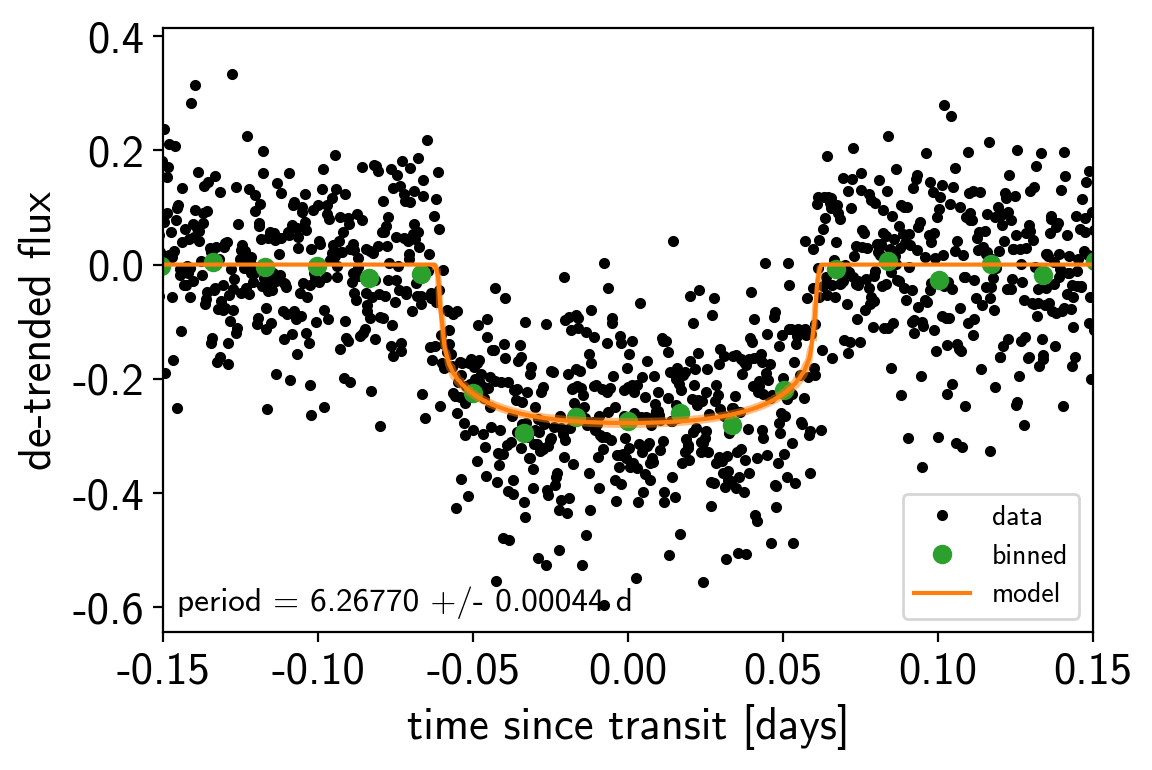

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, "o", color="C2",
         label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points", 
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

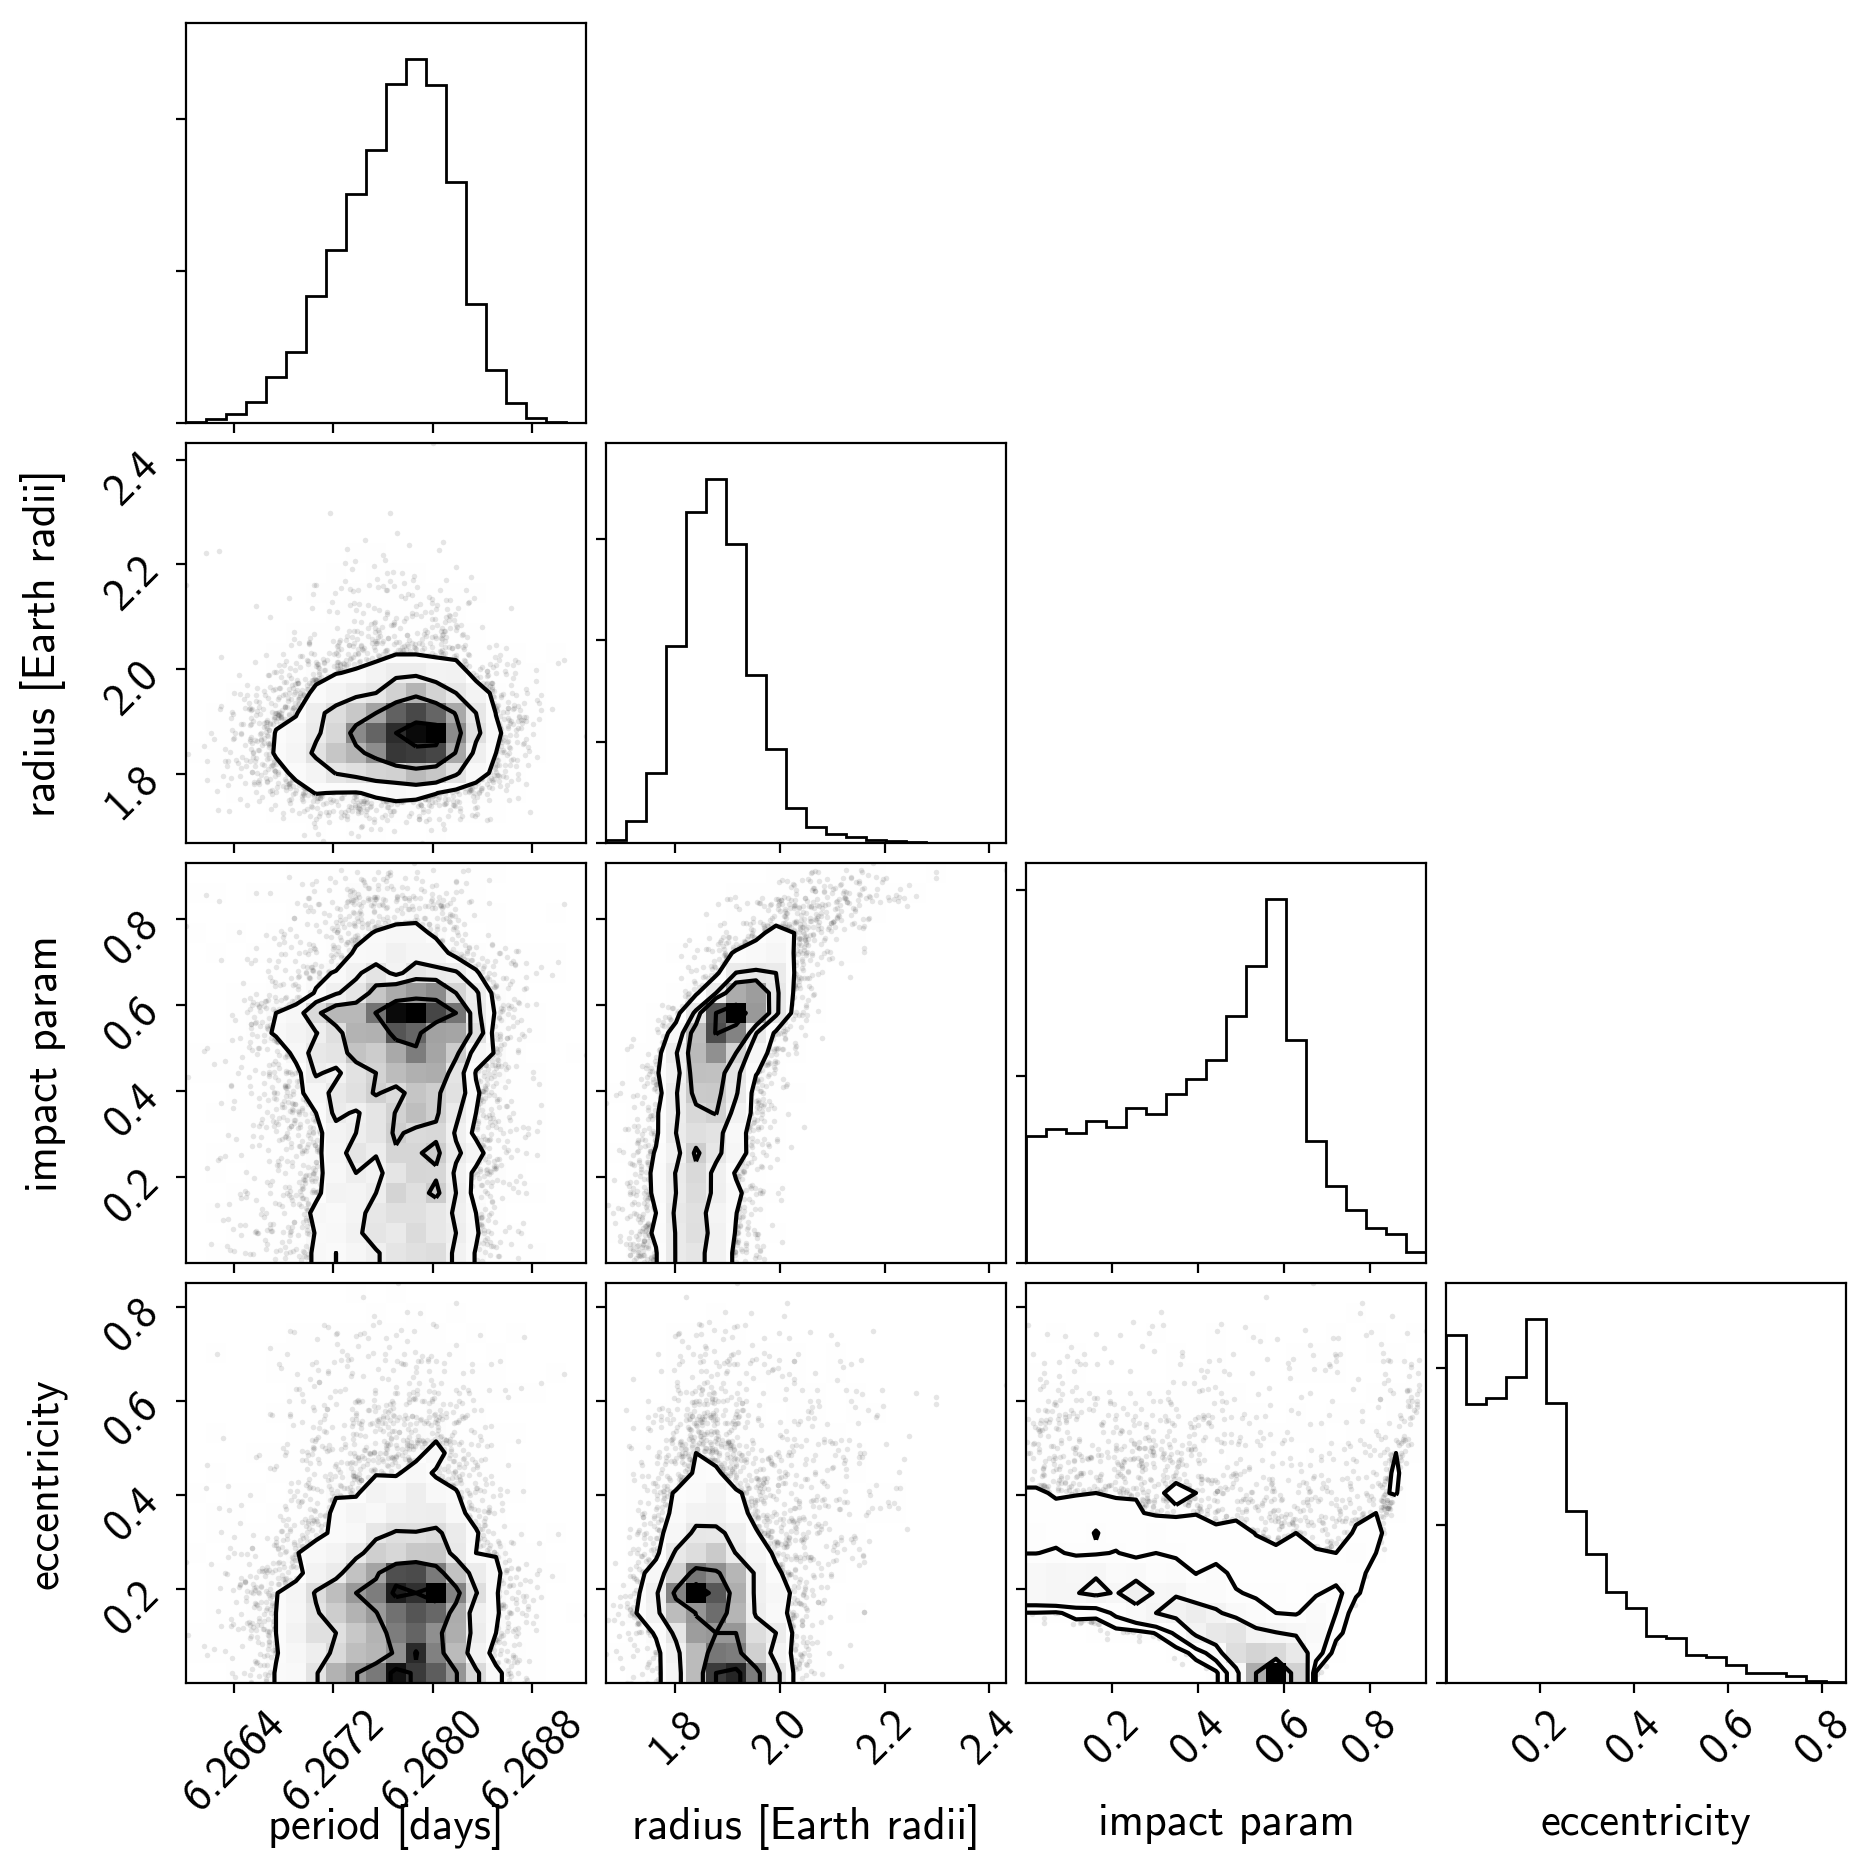

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"]);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.